In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0'
# !git clone https://github.com/bytedance/VideoWorld.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Chinese font configured!


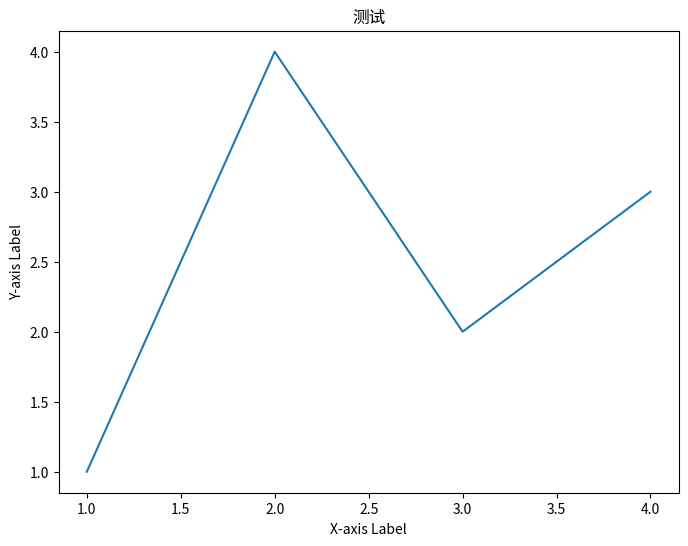

Note: Chinese characters may not display properly with DejaVu Sans
Consider installing a Chinese font for proper display


In [2]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

!pip install prettytable
!pip install rotary-embedding-torch
!pip install kornia
!pip install gateloop_transformer
!pip install webdataset

#@title 使用matplotlib显示中文字符
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import urllib.request
import os

# Download a Chinese font
font_url = "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"
font_filename = "SourceHanSansSC-Regular.otf"

if not os.path.exists(font_filename):
    print("Downloading Chinese font...")
    urllib.request.urlretrieve(font_url, font_filename)
    print("Font downloaded successfully!")

# Add the font to matplotlib
fm.fontManager.addfont(font_filename)
plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False

print("Chinese font configured!")


# Your plot with a note about font limitations
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3, 4], [1, 4, 2, 3])
plt.title('测试')  # English fallback
plt.xlabel('X-axis Label')  # English fallback
plt.ylabel('Y-axis Label')  # English fallback
plt.show()

print("Note: Chinese characters may not display properly with DejaVu Sans")
print("Consider installing a Chinese font for proper display")





In [3]:
#@title utilities
import torch

def tensor_allclose(a, b, atol=1e-8, rtol=1e-5):
    """
    比较两个张量是否满足：
    |a - b| ≤ atol + rtol * |b|

    参数：
    a, b: 要比较的PyTorch张量
    atol: 绝对容差（默认1e-8）
    rtol: 相对容差（默认1e-5）

    返回：
    bool: 是否所有元素都满足容差要求
    """
    if a.shape != b.shape:
        raise ValueError("张量形状不匹配")

    return torch.allclose(a, b, atol=atol, rtol=rtol)

import torch
import matplotlib.pyplot as plt

def compare_4d_slices(tensor1, tensor2,
                     dim=1,  # 切片维度：1(x),2(y),3(z)
                     index=0,  # 切片索引
                     atol=1e-5,
                     rtol=1e-3,
                     save_path=None  # 新增，保存路径（如 'result.pdf'）
                     ):
    """
    四维张量切片对比工具
    返回：
    - 差异统计指标
    - 可视化对比图
    用例：
    # 比较通道维度第50层的切片并保存为PDF
    stats, fig = compare_4d_slices(tensor1, tensor2, dim=1, index=50, save_path='compare.pdf')
    plt.show()
    print(stats)
    """

    # 维度验证
    assert tensor1.shape == tensor2.shape, "张量形状必须相同"
    assert tensor1.dim() == 4, "输入必须是四维张量"
    assert 1 <= dim <= 3, "切片维度需在[1,3]范围内"

    # 切片提取（保持四维结构）
    if dim == 1:
        slice1 = tensor1[0, index, ...]
        slice2 = tensor2[0, index, ...]
    elif dim == 2:
        slice1 = tensor1[0, :, index, ...]
        slice2 = tensor2[0, :, index, ...]
    elif dim == 3 or dim == -1:
        slice1 = tensor1[0, ..., index]
        slice2 = tensor2[0, ..., index]

    # 差异计算
    abs_diff = torch.abs(slice1 - slice2)
    rel_diff = abs_diff / (torch.abs(slice2) + atol)  # 避免除零

    # 统计指标
    stats = {
        'max_abs': abs_diff.max().item(),
        'mean_abs': abs_diff.mean().item(),
        'rel_over_threshold': (rel_diff > rtol).sum().item() / slice1.numel()
    }

    # 可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 原始数据可视化（取三维切片中间层）
    im0 = axes[0, 0].imshow(slice1.cpu().numpy(), cmap='turbo')
    axes[0, 0].set_title(f'Tensor1 Slice {dim}-{index}')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(slice2.cpu().numpy(), cmap='turbo')
    axes[0, 1].set_title(f'Tensor2 Slice {dim}-{index}')
    plt.colorbar(im1, ax=axes[0, 1])

    # 差异热图
    diff_map = axes[0, 2].imshow(abs_diff.cpu(), cmap='hot')
    plt.colorbar(diff_map, ax=axes[0, 2])
    axes[0, 2].set_title('Absolute Difference')

    # 差异分布直方图
    axes[1, 0].hist(abs_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Frequency')

    # 相对差异分布
    axes[1, 1].hist(rel_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 1].set_xlabel('Relative Difference')

    plt.tight_layout()

    # 新增：保存为PDF
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
        print(f'Figure saved to {save_path}')

    return stats, fig


import matplotlib.pyplot as plt
import numpy as np

def plot(tensor):
    """
    绘制一个 2D 张量

    参数:
    tensor: PyTorch 张量，形状为 [H, W]
    """
    # 将张量转换为 NumPy 数组
    if tensor.is_cuda:
        tensor = tensor.detach().cpu()

    img = tensor.numpy()

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制热图
    im = plt.imshow(img, cmap='viridis')

    # 添加颜色条
    plt.colorbar(im, label='值')

    # 添加标题和轴标签
    plt.title('地震数据切片可视化')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 显示图形
    plt.tight_layout()
    plt.show()

def downsample_3d_time_aware(x, target_size=(128, 128)):
    B, C, T, H, W = x.shape
    results = []

    # 逐时间步处理
    for t in range(T):
        time_slice = x[:, :, t, :, :]  # [B, C, H, W]
        down_slice = F.interpolate(
            time_slice,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        results.append(down_slice)

    return torch.stack(results, dim=2)  # 重组时间维度

In [4]:
#@title 读取一组时移（地震-河道标签）数据


# Number of time steps
nt = 8  # Adjust based on your actual data

# Initialize empty lists to collect data
all_seismic_data = []
all_channel_data = []
all_gravity_data = []
all_magnetic_data = []
all_vp_data = []

# Base path for your data
base_path = "/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64_co2/"
size = 64
# Loop through all indices
for selected_idx in range(20):  # 0 to 19
    # Load seismic data for current index
    seismic_file = f"{base_path}64_co2tl_seis_meandering_{selected_idx}.bin"
    gravity_file = f"{base_path}64_co2tl_gramaly_meandering_{selected_idx}.bin"
    magnetic_file = f"{base_path}64_co2tl_magmaly3D_meandering_{selected_idx}.bin"
    vp_file = f"{base_path}64_co2tl_vp_meandering_{selected_idx}.bin"

    # Check if file exists before loading
    if os.path.exists(seismic_file):
        seismic = np.fromfile(seismic_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_seismic_data.append(seismic)

        # # Load corresponding channel data
        # channel_file = f"{base_path}64_tld_channel_meandering_{selected_idx}.bin"
        # channel = np.fromfile(channel_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        # all_channel_data.append(channel)

        # Load gravity anomoly data
        gravity = np.fromfile(gravity_file, dtype=np.float32).reshape(nt+1, size, size)[None, ...]
        all_gravity_data.append(gravity)

        # Load magnetic anomoly data
        magnetic = np.fromfile(magnetic_file, dtype=np.float64).reshape(nt+1, size, size)[None, ...]
        all_magnetic_data.append(magnetic)

        # Load vp data
        vp = np.fromfile(vp_file, dtype=np.float64).reshape(nt+1, size, size, size)[None, ...]
        all_vp_data.append(vp)

        print(f"Loaded data for index {selected_idx}")
    else:
        print(f"Warning: File not found for index {selected_idx}")

# Concatenate all loaded data along the first dimension
if all_seismic_data and all_gravity_data and all_magnetic_data:
    seismic_data_total = np.concatenate(all_seismic_data, axis=0)
    gravity_data_total = np.concatenate(all_gravity_data, axis=0)
    magnetic_data_total = np.concatenate(all_magnetic_data, axis=0)
    vp_data_total = np.concatenate(all_vp_data, axis=0)
    # channel_data = np.concatenate(all_channel_data, axis=0)

    print(f"Combined seismic data shape: {seismic_data_total.shape}")
    print(f"Combined gravity data shape: {gravity_data_total.shape}")
    print(f"Combined magnetic data shape: {magnetic_data_total.shape}")
    print(f"Combined vp data shape: {vp_data_total.shape}")
    # print(f"Combined channel data shape: {channel_data.shape}")
else:
    print("No data was loaded. Check file paths.")


seismic_data = torch.from_numpy(seismic_data_total)# (20, 9, 64, 64, 64)
# Select first T (index 0) and last T (index -1 or 8)
seismic_data = seismic_data[:, [0, -1], :, :, :]

# Now seismic_data shape will be: [20, 2, 64, 64, 64]
print(f"New shape: {seismic_data.shape}")

Loaded data for index 0
Loaded data for index 1
Loaded data for index 2
Loaded data for index 3
Loaded data for index 4
Loaded data for index 5
Loaded data for index 6
Loaded data for index 7
Loaded data for index 8
Loaded data for index 9
Loaded data for index 10
Loaded data for index 11
Loaded data for index 12
Loaded data for index 13
Loaded data for index 14
Loaded data for index 15
Loaded data for index 16
Loaded data for index 17
Loaded data for index 18
Loaded data for index 19
Combined seismic data shape: (20, 9, 64, 64, 64)
Combined gravity data shape: (20, 9, 64, 64)
Combined magnetic data shape: (20, 9, 64, 64)
Combined vp data shape: (20, 9, 64, 64, 64)
New shape: torch.Size([20, 2, 64, 64, 64])


In [5]:
#@title SeismicWorld 数据处理函数集合

import torch
import numpy as np
import matplotlib.pyplot as plt

def process_seismic_for_world(seismic_data):
    """
    处理地震数据用于SeismicWorld训练
    输入: seismic_data [b, t, X, Y, Z] = [20, 9, 64, 64, 64]
    输出: 沿X轴切片的视频数据 [b*X, t, Y, Z]
    """
    b, t, X, Y, Z = seismic_data.shape
    print(f"原始数据形状: {seismic_data.shape}")

    # 重新排列维度，将X轴作为batch维度
    # [b, t, X, Y, Z] -> [b, X, t, Y, Z] -> [b*X, t, Y, Z]
    seismic_slices = seismic_data.permute(0, 2, 1, 3, 4)  # [b, X, t, Y, Z]
    seismic_slices = seismic_slices.reshape(b * X, t, Y, Z)  # [b*X, t, Y, Z]

    print(f"处理后形状: {seismic_slices.shape}")
    print(f"现在有 {b*X} 个视频切片，每个视频有 {t} 帧，分辨率为 {Y}×{Z}")

    return seismic_slices

def reconstruct_4d_seismic(predicted_slices, original_batch_size, original_time_steps=9,
                          original_x_size=64, original_y_size=64, original_z_size=64):
    """
    将SeismicWorld预测的64个切片重新组合成4D时移地震体

    参数:
    - predicted_slices: [b*X, t, Y, Z] 预测的切片数据
    - original_batch_size: 原始batch大小
    - original_time_steps: 时间步数
    - original_x_size: X维度大小
    - original_y_size: Y维度大小
    - original_z_size: Z维度大小

    返回: [b, t, X, Y, Z] 重构的4D地震体
    """
    print(f"输入预测切片形状: {predicted_slices.shape}")

    # 确保输入形状正确
    total_slices, t, Y, Z = predicted_slices.shape
    expected_slices = original_batch_size * original_x_size

    if total_slices != expected_slices:
        raise ValueError(f"切片数量不匹配: 期望 {expected_slices}, 实际 {total_slices}")

    # 重新整形为 [b, X, t, Y, Z]
    reconstructed = predicted_slices.reshape(original_batch_size, original_x_size, t, Y, Z)

    # 重新排列维度为 [b, t, X, Y, Z]
    reconstructed = reconstructed.permute(0, 2, 1, 3, 4)

    print(f"重构后4D地震体形状: {reconstructed.shape}")

    return reconstructed

def compare_original_vs_reconstructed(original_data, reconstructed_data,
                                    batch_idx=0, time_idx=4, x_slice=32):
    """
    比较原始数据和重构数据的可视化
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 原始数据切片
    orig_slice = original_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[0].imshow(orig_slice, cmap='seismic', aspect='auto')
    axes[0].set_title(f'Original (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[0].axis('off')

    # 重构数据切片
    recon_slice = reconstructed_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[1].imshow(recon_slice, cmap='seismic', aspect='auto')
    axes[1].set_title(f'Reconstructed (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[1].axis('off')

    # 差异图
    diff = orig_slice - recon_slice
    im = axes[2].imshow(diff, cmap='RdBu', aspect='auto')
    axes[2].set_title(f'Difference')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # 计算重构误差统计
    mse = torch.mean((original_data - reconstructed_data) ** 2).item()
    mae = torch.mean(torch.abs(original_data - reconstructed_data)).item()
    print(f"重构误差 - MSE: {mse:.6f}, MAE: {mae:.6f}")

def visualize_slice_time_series(seismic_data, batch_idx=0, x_slice=32):
    """
    可视化某个X切片的时间序列
    """
    slice_data = seismic_data[batch_idx, :, x_slice, :, :]  # [t, Y, Z]
    t_steps = slice_data.shape[0]

    cols = 4
    rows = (t_steps + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(t_steps):
        row, col = i // cols, i % cols
        axes[row, col].imshow(slice_data[i].cpu().numpy(), cmap='seismic', aspect='auto')
        axes[row, col].set_title(f'Time step {i}')
        axes[row, col].axis('off')

    # 隐藏多余的子图
    for i in range(t_steps, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.suptitle(f'X-slice {x_slice} through time (Batch {batch_idx})', y=1.02)
    plt.show()

def format_as_video_batches(processed_data, videos_per_batch=64):
    """
    将处理后的数据重新组织成视频批次（可选功能）
    """
    total_videos, t, h, w = processed_data.shape

    if total_videos % videos_per_batch == 0:
        num_batches = total_videos // videos_per_batch
        video_batches = processed_data.reshape(num_batches, videos_per_batch, t, h, w)
        print(f"重新组织为 {num_batches} 个批次，每批次 {videos_per_batch} 个视频")
        return video_batches
    else:
        print(f"警告: 总视频数 {total_videos} 不能被 {videos_per_batch} 整除")
        return processed_data

def create_differenced_seismic_data(seismic_data):
    """
    Creates a differenced version of the seismic data along the time axis.

    Args:
        seismic_data (torch.Tensor): Input data with shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Differenced data of the same shape, where frame t > 0
                      is replaced by frame[t] - frame[t-1]. Frame 0 remains unchanged.
    """
    if not isinstance(seismic_data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")
    if seismic_data.dim() != 5:
        raise ValueError("Input data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = seismic_data.shape
    print(f"Original data shape for differencing: {seismic_data.shape}")

    # Initialize the output tensor with the same shape and type
    differenced_data = torch.zeros_like(seismic_data)

    # Keep the first frame (t=0) as is
    differenced_data[:, 0, :, :, :] = seismic_data[:, 0, :, :, :]

    # Calculate the difference for subsequent frames (t=1 to t-1)
    for i in range(1, t):
        differenced_data[:, i, :, :, :] = seismic_data[:, i, :, :, :] - seismic_data[:, i-1, :, :, :]

    print(f"Differenced data shape: {differenced_data.shape}")
    return differenced_data

def normalize_data(data, eps=1e-8):
    """
    Normalizes data using global mean and standard deviation.

    Args:
        data (torch.Tensor): Input data tensor.
        eps (float): Small value to prevent division by zero.

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            - normalized_data: Tensor with normalized values.
            - mean: Calculated mean of the input data.
            - std: Calculated standard deviation of the input data.
    """
    if not isinstance(data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")

    # Calculate global mean and std
    # NOTE: For actual training, calculate these stats over the entire training dataset
    #       and reuse them for validation/testing and normalization here.
    #       Calculating per-tensor here for demonstration purposes.
    mean = torch.mean(data.float()) # Ensure float for calculation
    std = torch.std(data.float())

    print(f"Normalizing data: Mean={mean.item():.4f}, Std={std.item():.4f}")

    normalized_data = (data - mean) / (std + eps)
    return normalized_data, mean, std

def denormalize_data(normalized_data, mean, std, eps=1e-8):
    """
    Reverses the normalization process.

    Args:
        normalized_data (torch.Tensor): Data that was previously normalized.
        mean (torch.Tensor or float): Mean used during normalization.
        std (torch.Tensor or float): Standard deviation used during normalization.
        eps (float): Small value used during normalization's division.

    Returns:
        torch.Tensor: Data restored to its original scale.
    """
    if not isinstance(normalized_data, torch.Tensor):
        raise TypeError("Input normalized_data must be a PyTorch tensor.")

    print(f"Denormalizing data using: Mean={mean.item():.4f}, Std={std.item():.4f}")
    original_scale_data = normalized_data * (std + eps) + mean
    return original_scale_data

def recover_absolute_frames(differenced_data):
    """
    Recovers absolute frames from differenced data [frame_0, diff_1, diff_2, ...].

    Args:
        differenced_data (torch.Tensor): Data in differenced format,
                                         shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Data with absolute frame values, shape [b, t, X, Y, Z].
    """
    if not isinstance(differenced_data, torch.Tensor):
        raise TypeError("Input differenced_data must be a PyTorch tensor.")
    if differenced_data.dim() != 5:
        raise ValueError("Input differenced_data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = differenced_data.shape
    print(f"Recovering absolute frames from shape: {differenced_data.shape}")

    recovered_data = torch.zeros_like(differenced_data)

    # First frame is already absolute
    recovered_data[:, 0, :, :, :] = differenced_data[:, 0, :, :, :]

    # Cumulatively add differences for subsequent frames
    for i in range(1, t):
        recovered_data[:, i, :, :, :] = recovered_data[:, i-1, :, :, :] + differenced_data[:, i, :, :, :]

    print(f"Recovered absolute data shape: {recovered_data.shape}")
    return recovered_data

def seismic_world_diff_norm_workflow_demo(seismic_data):
    """
    Complete workflow: differencing, normalization, processing,
    simulated prediction, reconstruction, denormalization, recovery.
    """
    print("=== SeismicWorld Differencing & Normalization Workflow ===\n")
    original_shape = seismic_data.shape
    b, t, X, Y, Z = original_shape

    # Step 1: Create differenced data
    print("Step 1: Create differenced data")
    differenced_seismic_data = create_differenced_seismic_data(seismic_data)

    # Step 2: Normalize the differenced data
    print("\nStep 2: Normalize the differenced data")
    # NOTE: In a real scenario, 'data_mean' and 'data_std' should be pre-calculated
    #       on the training set and loaded here.
    normalized_diff_data, data_mean, data_std = normalize_data(differenced_seismic_data)
    # Keep mean/std safe, they are needed later!

    # Step 3: Process normalized differenced data for VQ-VAE input (slicing)
    print("\nStep 3: Process normalized differenced data into video slices")
    normalized_diff_video = process_seismic_for_world(normalized_diff_data)
    # Shape: [b*X, t, Y, Z]

    # Step 4: Simulate VQ-VAE Prediction
    # The model predicts the *normalized differenced slices*
    print("\nStep 4: Simulate VQ-VAE prediction (using processed input as placeholder)")
    predicted_normalized_diff_video = normalized_diff_video.clone() # Perfect reconstruction assumed

    # --- Recovery Steps ---

    # Step 5: Reconstruct the 4D shape from predicted slices
    print("\nStep 5: Reconstruct 4D shape from predicted normalized slices")
    predicted_normalized_diff_4d = reconstruct_4d_seismic(
        predicted_normalized_diff_video,
        original_batch_size=b,
        original_time_steps=t,
        original_x_size=X,
        original_y_size=Y,
        original_z_size=Z
    )
    # Shape: [b, t, X, Y, Z]

    # Step 6: Denormalize the reconstructed 4D prediction
    print("\nStep 6: Denormalize the reconstructed 4D data")
    predicted_diff_4d = denormalize_data(predicted_normalized_diff_4d, data_mean, data_std)
    # Shape: [b, t, X, Y, Z], values are back to the scale of differenced data

    # Step 7: Recover absolute frames from the denormalized differenced data
    print("\nStep 7: Recover absolute frames from denormalized differenced data")
    reconstructed_absolute_4d = recover_absolute_frames(predicted_diff_4d)
    # Shape: [b, t, X, Y, Z], values are back to the original absolute scale

    # Step 8: Compare final recovered data with original input
    print("\nStep 8: Compare original data vs fully recovered data")
    compare_original_vs_reconstructed(seismic_data, reconstructed_absolute_4d)

    return reconstructed_absolute_4d

# 主要工作流程示例
def seismic_world_workflow_demo(seismic_data):
    """
    完整的SeismicWorld工作流程演示
    """
    print("=== SeismicWorld 数据处理工作流程 ===\n")

    # 步骤1: 处理数据用于训练
    print("步骤1: 处理4D地震数据为切片视频")
    processed_slices = process_seismic_for_world(seismic_data)

    # 步骤2: 模拟SeismicWorld预测（这里用原始数据模拟）
    print("\n步骤2: SeismicWorld模型预测（此处用原始数据模拟）")
    predicted_slices = processed_slices.clone()  # 实际使用时这里是模型预测结果

    # 步骤3: 重构4D地震体
    print("\n步骤3: 重构4D地震体")
    reconstructed_4d = reconstruct_4d_seismic(
        predicted_slices,
        original_batch_size=seismic_data.shape[0],
        original_time_steps=seismic_data.shape[1],
        original_x_size=seismic_data.shape[2],
        original_y_size=seismic_data.shape[3],
        original_z_size=seismic_data.shape[4]
    )

    # 步骤4: 验证重构质量
    print("\n步骤4: 验证重构质量")
    compare_original_vs_reconstructed(seismic_data, reconstructed_4d)

    return processed_slices, reconstructed_4d


seismic_data_video = process_seismic_for_world(seismic_data) # torch.Size([1280, 2, 64, 64])




原始数据形状: torch.Size([20, 2, 64, 64, 64])
处理后形状: torch.Size([1280, 2, 64, 64])
现在有 1280 个视频切片，每个视频有 2 帧，分辨率为 64×64


In [6]:
#@title VQ-VAE:Separate Training
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0') # Adjust path if needed
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import torch
import torch.nn as nn
from torch import Tensor
from typing import Optional, Tuple, Union, List
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
# 兼容不同PyTorch版本的混合精度导入
try:
    # 新版本 PyTorch (>= 2.0)
    from torch.amp import autocast, GradScaler
    def get_autocast_context(device_type='cuda'):
        return autocast(device_type=device_type, dtype=torch.float16)
    def get_grad_scaler(device_type='cuda'):
        return GradScaler(device_type)
    AMP_AVAILABLE = True
    print("Using torch.amp (PyTorch >= 2.0)")
except ImportError:
    try:
        # 旧版本 PyTorch (1.6-2.0)
        from torch.cuda.amp import autocast, GradScaler
        def get_autocast_context(device_type='cuda'):
            return autocast(enabled=True, dtype=torch.float16)
        def get_grad_scaler(device_type='cuda'):
            return GradScaler()
        AMP_AVAILABLE = True
        print("Using torch.cuda.amp (PyTorch 1.6-2.0)")
    except ImportError:
        # 非常旧的版本，不支持混合精度
        AMP_AVAILABLE = False
        print("Mixed precision not available in this PyTorch version")
        def get_autocast_context(device_type='cuda'):
            from contextlib import nullcontext
            return nullcontext()
        def get_grad_scaler(device_type='cuda'):
            return None

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor, # 输入形状: [batch, ...] 或 [batch, num_codebooks, ...] (取决于keep_num_codebooks_dim)
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        # indices形状: [batch, ..., 1] (在最后一维添加维度1)

        codes_non_centered = (indices // self._basis) % self._levels
        # indices形状: [batch, ..., 1]
        # self._basis形状: [codebook_dim] 例如 [1, 8, 64, 512, 2560, 12800]
        # self._levels形状: [codebook_dim] 例如 [8, 8, 8, 5, 5, 5]
        # codes_non_centered形状: [batch, ..., codebook_dim] 例如 [batch, seq_len, 6] 或 [batch, num_codebooks, H, W, 6]

        codes = self._scale_and_shift_inverse(codes_non_centered)
        # codes形状: [batch, ..., codebook_dim] (形状不变，但数值从[0, level-1]转换为[-1, 1])

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)') # [batch, seq_len, num_codebooks, codebook_dim]
            # codes形状变化: [batch, ..., num_codebooks, codebook_dim] -> [batch, ..., num_codebooks * codebook_dim]
            # 例如: [batch, seq_len, num_codebooks, 6] -> [batch, seq_len, num_codebooks * 6]
        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')
            # codes形状变化: [batch, H, W, dim] -> [batch, dim, H, W] (图像格式)
            # 或 [batch, H, W, T, dim] -> [batch, dim, H, W, T] (视频格式)

        return codes # torch.Size([1, 8, 8, 512])
        # 最终返回的codes形状:
        # - 图像/视频: [batch, dim, H, W] 或 [batch, dim, H, W, T]
        # - 序列: [batch, seq_len, dim]

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# Dynamic自适应版
class FSQDQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        scale = F.sigmoid(self.ada_param)*4
        return torch.tanh(scale*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes

    def forward(
        self,
        z: torch.Tensor,
    ):
        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class FSQLQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        return torch.tanh(self.ada_param*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes



    def forward(
        self,
        z: torch.Tensor,
    ):

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

def default(val, d):
    return val if exists(val) else d

def cast_tuple(t, length = 1):
    return t if isinstance(t, tuple) else ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0

def pad_at_dim(t, pad, dim = -1, value = 0.):
    dims_from_right = (- dim - 1) if dim < 0 else (t.ndim - dim - 1)
    padded_dims = [(0, 0)] * dims_from_right + [pad] + [(0, 0)] * (t.ndim - dims_from_right - 1)
    return F.pad(t, tuple(rearrange(torch.tensor(padded_dims), 'r n -> n r').tolist()), value = value)

# --- VQ-VAE Class ---
class VQVAE(Module):
    """
    Vector Quantized Variational Autoencoder (VQ-VAE) using MagvitV2 style
    encoder/decoder and Finite Scalar Quantization (FSQ).
    """
    def __init__(
        self,
        *,
        image_size: int,
        channels: int = 1,
        init_dim: int = 128,
        fsq_levels: List[int], # e.g., [8, 8, 8, 5, 5, 5]
        fsq_dim: Optional[int] = None, # Dimension of encoder output / FSQ input. If None, calculated based on layers.
        num_fsq_codebooks: int = 1, # As per FSQ class
        encoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1), # dim: 128 -> 256
            ('consecutive_residual', 3), ('time_spatial_down', 1),                     # dim: 256
            ('consecutive_residual', 4), ('time_spatial_down', 1),                     # dim: 256
            ('channel_residual', 1), ('consecutive_residual', 3),                      # dim: 256 -> 512
            ('consecutive_residual', 4),                                               # dim: 512
        ),
        decoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
             # Inverse of encoder layers (example, adjust as needed)
            ('consecutive_residual', 4),                                               # dim: 512
            ('consecutive_residual', 3), ('channel_residual', 1),                      # dim: 512 -> 256
            ('time_spatial_up', 1), ('consecutive_residual', 4),                       # dim: 256
            ('time_spatial_up', 1), ('consecutive_residual', 3),                       # dim: 256
            ('channel_residual', 1), ('spatial_up', 1), ('consecutive_residual', 4),   # dim: 256 -> 128
        ),
        input_conv_kernel_size: Tuple[int, int, int] = (7, 7, 7),
        output_conv_kernel_size: Tuple[int, int, int] = (3, 3, 3),
        separate_first_frame_encoding: bool = False,
        pad_mode: str = 'constant',
    ):
        super().__init__()
        self.image_size = image_size
        self.channels = channels
        self.separate_first_frame_encoding = separate_first_frame_encoding

        # --- Encoder ---
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=channels,
            init_dim=init_dim,
            layers=encoder_layers,
            input_conv_kernel_size=input_conv_kernel_size,
            pad_mode=pad_mode,
            separate_first_frame_encoding=separate_first_frame_encoding
        )

        # Determine FSQ dimension if not provided
        if fsq_dim is None:
            # 根据encoder_layers计算最终维度
            current_dim = init_dim
            for layer_def in encoder_layers:
                layer_type, *layer_params = cast_tuple(layer_def)
                if layer_type == 'channel_residual':
                     # channel_residual层会将维度翻倍
                     current_dim = current_dim * 2
            fsq_dim = current_dim
            print(f"Auto-determined FSQ dimension: {fsq_dim}")
        self.fsq_dim = fsq_dim

        # --- Quantizer ---
        self.quantizer = FSQLQuantizer(
            dim=fsq_dim,
            levels=fsq_levels,
            num_codebooks=num_fsq_codebooks,
            # keep_num_codebooks_dim=True # Keep separate dim for codebooks if num_codebooks > 1
                                         # Set based on how you want indices shaped
        )
        self.codebook_size = self.quantizer.codebook_size # Total size of the discrete codebook

        # --- Decoder ---
        # Decoder's init_dim should match the FSQ output dimension
        self.decoder = MagvitV2decoder(
             image_size=image_size,
             channels=channels,
             init_dim=init_dim,#fsq_dim, # Decoder input dim = FSQ output dim
             layers=decoder_layers, # Provide appropriate decoder layers
             output_conv_kernel_size=output_conv_kernel_size,
             separate_first_frame_encoding=separate_first_frame_encoding
        )

    def encode(
        self,
        video_or_images: Tensor
    ) -> Tuple[Tensor, Optional[Tensor], bool]:
        """ Encodes input video/images into continuous latent features. """
        assert video_or_images.ndim in {4, 5} # B, C, H, W or B, C, T, H, W
        assert video_or_images.shape[-2:] == (self.image_size, self.image_size)

        is_image = video_or_images.ndim == 4
        if is_image:
            video = rearrange(video_or_images, 'b c ... -> b c 1 ...')
            video_contains_first_frame = True # Treat image as the first frame
        else:
            video = video_or_images
            # Heuristic: Assume first frame exists if T > 1 or if specifically handling
            video_contains_first_frame = video.shape[2] > 0

        # Encoder forward pass
        # Note: cond is returned but not used in this basic VQVAE setup
        encoded_features, cond, video_contains_first_frame_out = self.encoder(
            video,
            cond=None, # No conditioning in basic VQVAE
            video_contains_first_frame=video_contains_first_frame
        )
        return encoded_features, cond, video_contains_first_frame_out

    def quantize(self, features: Tensor) -> Tuple[Tensor, Tensor]:
        """ Quantizes continuous features using FSQ. """
        quantized, indices = self.quantizer(features)
        return quantized, indices

    def decode(
        self,
        quantized_features: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True
    ) -> Tensor:
        """ Decodes quantized features back into video/images. """
        recon_video = self.decoder(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video

    def encode_to_indices(self, video_or_images: Tensor) -> Tensor:
        """ Encodes input directly to discrete FSQ indices. """
        features, _, _ = self.encode(video_or_images)
        _, indices = self.quantize(features)
        # Indices shape depends on FSQ keep_num_codebooks_dim and input shape
        # e.g., [B, T', H', W'] or [B, T', H', W', C] if keep_num_codebooks_dim=True
        return indices

    def decode_from_indices(
        self,
        indices: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True # Important context for decoder padding
        ) -> Tensor:
        """ Decodes discrete FSQ indices back into video/images. """
        # Convert indices back to the continuous-like quantized vectors
        # project_out=True applies the final linear layer if FSQ has projections
        # 如果indices传入是单帧'序列'： [1,1,8,8] [B,T,..]
        quantized_features = self.quantizer.indices_to_codes(indices, project_out=True)
        print(f'quantized_features={quantized_features.shape}') # torch.Size([B:1, T:1, 8, 8, D:512]) 序列的dim512是在最后

        # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')

        # # Ensure the shape matches decoder input (B, D, T', H', W')
        # # FSQ indices_to_codes might return [B, ..., D], need to permute
        # if quantized_features.shape[-1] == self.fsq_dim and quantized_features.ndim > 3:
        #      # Example reshape/permute if indices were [B, T', H', W', D] or similar
        #      # This depends heavily on the exact shape returned by indices_to_codes
        #      # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        #      expected_spatial_dims = indices.ndim - 2 # B and T are non-spatial
        #      if quantized_features.ndim == expected_spatial_dims + 1: # Check if D is last
        #          num_spatial_dims = len(quantized_features.shape[1:-1])
        #          permute_dims = [0] + [quantized_features.ndim - 1] + list(range(1, 1 + num_spatial_dims))
        #          quantized_features = quantized_features.permute(*permute_dims).contiguous()
        #      else:
        #          print(f"Warning: Unexpected shape from indices_to_codes: {quantized_features.shape}. Decoder might fail.")
        #          # Attempt a generic permute if possible
        #          if quantized_features.ndim >= 4:
        #               quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')


        # Decode the features
        recon_video = self.decode(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video.squeeze(2) # 不这样会出现多余的维度

    def forward(
        self,
        video_or_images: Tensor,
        return_indices: bool = False,
        return_loss: bool = False, # Placeholder for potential loss calculation
        beta: float = 0.25
        ) -> Union[Tensor, Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
        """
        Full forward pass: Encode -> Quantize -> Decode.

        Args:
            video_or_images (Tensor):
            图像输入：[B, C, H, W]
            视频输入：[B, C, H, W] （每次处理一帧）
            return_indices (bool): If True, also return the discrete code indices.
            return_loss (bool): If True, calculate and return reconstruction loss
                                (and potentially commitment loss - requires modification).

        Returns:
            Tensor or Tuple:
                - Reconstructed video/images.
                - (Optional) FSQ indices.
                - (Optional) Loss tensor (if return_loss=True).
        """
        # 1. Encode
        features, cond, video_contains_first_frame = self.encode(video_or_images)
        # print(f'编码器的输出形状/FSQ的输入形状为{features.shape}') # torch.Size([5, 512, 1, 8, 8])

        # 2. Quantize
        quantized, indices = self.quantize(features) # 原版FSQ期望的输入形状：多玛本[batch, num_codebooks, height, width, time]；单码本：[batch, height, width, time]
        # print(f'FSQ的输出code形状为{quantized.shape}') # torch.Size([5, 512, 1, 8, 8])  在FSQ的forward()变成了[5,1,8,8,512->6]
        # print(f'FSQ的输出indices形状为{indices.shape}')# torch.Size([5, 1, 8, 8]) FSQ要求的输入形状: [batch, ...] 或 [batch, num_codebooks, ...]

        # 3. Decode
        recon_output = self.decode(
            quantized,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        # print(f'解码器的输出code形状为{recon_output.shape}') # torch.Size([5, 1, 1, 64, 64])

        # --- Optional: Loss Calculation ---
        loss = None
        if return_loss:
            # Reconstruction Loss (e.g., MSE)
            # Ensure original input and reconstruction match shape (handle image vs video)
            original_input = video_or_images
            if original_input.ndim == 4: # Input was image
                 # Decoder might output B,C,1,H,W, compare with B,C,H,W
                 if recon_output.shape[2] == 1:
                      recon_output_for_loss = recon_output.squeeze(2)
                 else:
                      recon_output_for_loss = recon_output # Should match if decoder handles images correctly
            else: # Input was video
                 recon_output_for_loss = recon_output

            # Handle potential padding differences if decoder output length != input length
            target_len = original_input.shape[2] if original_input.ndim == 5 else 1
            recon_len = recon_output_for_loss.shape[2] if recon_output_for_loss.ndim == 5 else 1

            if target_len != recon_len:
                 min_len = min(target_len, recon_len)
                 print(f"Warning: Reconstruction length ({recon_len}) differs from input length ({target_len}). Calculating loss on first {min_len} frames.")
                 if original_input.ndim == 5:
                      original_input = original_input[:, :, :min_len, :, :]
                 if recon_output_for_loss.ndim == 5:
                      recon_output_for_loss = recon_output_for_loss[:, :, :min_len, :, :]

            recon_loss = F.mse_loss(recon_output_for_loss, original_input)

            # Commitment Loss (Optional - typical in VQ-VAE but FSQ might not need it explicitly)
            # If needed, it's typically: beta * ||sg(features) - quantized||^2
            commit_loss = F.mse_loss(features, quantized.detach())
            loss = recon_loss + beta * commit_loss
            # loss = recon_loss # Simple reconstruction loss for now

        # --- Return Values ---
        if return_loss and return_indices:
            return recon_output, indices, loss
        elif return_loss:
            return recon_output, loss
        elif return_indices:
            return recon_output, indices
        else:
            return recon_output

# --- VideoWorldLDM Class Definition (Copied from your code) ---
class VideoWorldLDM(nn.Module):
    def __init__(self, image_size=128, latent_channels=1, frame_num=9,act_embedding_num=8):
        super().__init__()
        self.encoder = MagvitV2LAencoder(
            image_size=image_size,
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num,
        layers=(
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1),
            ('consecutive_residual', 3), ('spatial_down', 1), ('consecutive_residual', 4),
            ('spatial_down', 1), ('channel_residual', 1), ('consecutive_residual', 3),
            ('consecutive_residual', 4)
        ))
        self.quantizer = FSQ( dim=512, levels=[8, 8, 8, 5, 5, 5], num_codebooks=1)
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size, channels=latent_channels, init_dim=128,
            use_pre_video=False, use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3), ('channel_residual', 1), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 4), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 3), ('channel_residual', 1),
            ('condation', 1), ('spatial_up', 1), ('consecutive_residual', 4),
            ('condation', 1), ('consecutive_residual', 4)
        ))
        # Store channels for input check
        self.channels = latent_channels

    def forward(self, x):
        if x.dim() == 4: x = x.unsqueeze(0)
        # Ensure input has correct channel dimension C
        if x.shape[1] != self.channels:
             # Example: Input might be [B, T, C, H, W], needs permute
             if x.shape[2] == self.channels:
                  x = x.permute(0, 2, 1, 3, 4) # B, C, T, H, W
             else:
                  raise ValueError(f"Input channel dimension {x.shape[1]} or {x.shape[2]} does not match model channels {self.channels}")

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # encoded shape might be [B, D, T', H', W'] or similar, depends on encoder output
        # print(f"Encoded shape before quantizer: {encoded.shape}")

        quantized, indices = self.quantizer(encoded)
        # print(f"Quantized shape: {quantized.shape}")
        # print(f"Indices shape: {indices.shape}")

        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

# --- SeismicWorldVideoWorld Class Definition (Modified for clarity and token mapping) ---
class SeismicWorldVideoWorld(nn.Module):
    def __init__(
        self,
        codebook_size_ldm,
        codebook_size_frame,
        special_token_count=3,     # BOS/EOS/PAD
        max_seq_length=1024,
        hidden_size=4096,
        num_hidden_layers=12,
        num_attention_heads=16,
        intermediate_size=4096,
        num_ldm_codes_per_step=1, # Number of LDM codes per time step (H in paper)
        num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
        pretrained_model_path=None,
        device=None,
    ):
        super().__init__()
        self.codebook_size_ldm = codebook_size_ldm
        self.codebook_size_frame = codebook_size_frame
        self.special_token_count = special_token_count

        # Define vocabulary ranges
        self.ldm_token_offset = 0
        self.frame_token_offset = self.codebook_size_ldm
        self.special_token_offset = self.codebook_size_ldm + self.codebook_size_frame

        self.vocab_size = self.special_token_offset + special_token_count

        self.max_seq_length = max_seq_length
        self.num_ldm_codes_per_step = num_ldm_codes_per_step
        self.num_frame_tokens_per_step = num_frame_tokens_per_step
        self.tokens_per_step = num_ldm_codes_per_step + num_frame_tokens_per_step
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # InternLM configuration
        if pretrained_model_path:
            # from MoE.modeling_internlm import InternLMForCausalLM # Assuming import exists
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16, # Consider float32 for stability if needed
                low_cpu_mem_usage=True,
            )
            print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
            self.model.resize_token_embeddings(self.vocab_size)
            if self.model.config.max_position_embeddings < max_seq_length:
                print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
                # Be cautious with resizing position embeddings, might need interpolation
                self.model.resize_position_embeddings(max_seq_length)
        else:
            # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM # Assuming import exists
            config = InternLMConfig(
                vocab_size=self.vocab_size,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True, # Enable for generation
                # Add other relevant InternLM config options if needed
            )
            self.model = InternLMForCausalLM(config)

        # Positional Encoding - More sophisticated encoding might be needed
        # Simple approach: Treat each step (LDM codes + Frame tokens) as a "time" unit
        # and position within the step as "space" unit.
        self.num_time_steps_for_pos = math.ceil(max_seq_length / self.tokens_per_step) + 1 # +1 for BOS potentially
        self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
        # Use a single embedding for position within the combined step
        self.step_pos_embed = nn.Embedding(self.tokens_per_step, hidden_size)

        # Special token IDs
        self.bos_token_id = self.special_token_offset
        self.eos_token_id = self.special_token_offset + 1
        self.pad_token_id = self.special_token_offset + 2
        # Ensure PAD ID matches InternLM's expected PAD ID if using HF trainer etc.
        # self.model.config.pad_token_id = self.pad_token_id

        self.to(self.device)

    def get_token_type_ids(self, input_ids):
        """ Distinguish between BOS, LDM, Frame, PAD tokens """
        token_type_ids = torch.zeros_like(input_ids)
        # Mark LDM tokens (type 1)
        token_type_ids[(input_ids >= self.ldm_token_offset) & (input_ids < self.frame_token_offset)] = 1
        # Mark Frame tokens (type 2)
        token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 2
        # Mark Special tokens (type 0 or specific types if needed)
        token_type_ids[input_ids == self.bos_token_id] = 0 # Or a specific BOS type
        token_type_ids[input_ids == self.eos_token_id] = 0 # Or a specific EOS type
        token_type_ids[input_ids == self.pad_token_id] = 0 # Or a specific PAD type
        return token_type_ids


    def add_positional_encoding(self, input_ids):
        """
        Adds positional encoding based on time step and position within the step.
        Assumes input_ids shape [B, seq_len] and structure like:
        [BOS, ldm_0_0, ..., ldm_0_N, frame_0_0, ..., frame_0_M, ldm_1_0, ...]
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        # Create position IDs: 0, 1, 2, ..., seq_len-1
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

        # Calculate time step ID and position within step ID
        # This assumes a fixed structure per step, adjust if structure varies
        # Start counting steps after BOS token
        positions_after_bos = position_ids - 1 # -1 for positions 0, 1, ... relative to first LDM/Frame token
        time_step_ids = torch.zeros_like(position_ids)
        position_in_step_ids = torch.zeros_like(position_ids)

        # Handle BOS token separately (time step 0, position 0)
        is_not_bos = (input_ids != self.bos_token_id)
        time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.tokens_per_step + 1 # Steps 1, 2, ...
        position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.tokens_per_step

        # Clamp time_step_ids to max embedding index
        time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

        # Get embeddings
        time_pos = self.time_pos_embed(time_step_ids)
        step_pos = self.step_pos_embed(position_in_step_ids)

        # Combine embeddings (simple addition)
        pos_encoding = time_pos + step_pos
        return pos_encoding


    def forward(
        self,
        input_ids,      # [B, seq_len], input token sequence (BOS+Z0+frame0+...)
        labels=None,    # [B, seq_len], target token sequence (shifted input_ids)
        attention_mask=None,
        return_dict=None # Use model's default usually
    ):
        """
        Teacher Forcing training.
        input_ids: [B, seq_len]
        labels: [B, seq_len] (should be input_ids shifted left, with -100 for padding)
        """
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

        # Get token embeddings
        inputs_embeds = self.model.get_input_embeddings()(input_ids)

        # Add positional encoding
        pos_encoding = self.add_positional_encoding(input_ids)
        inputs_embeds = inputs_embeds + pos_encoding

        # Optional: Add token type embeddings if needed
        # token_type_ids = self.get_token_type_ids(input_ids)
        # token_type_embeddings = self.model.get_input_embeddings()(token_type_ids) # Or a separate type embedding layer
        # inputs_embeds = inputs_embeds + token_type_embeddings

        # Prepare attention mask if not provided (handle padding)
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()

        # Prepare labels for Causal LM
        # Standard practice: shift logits and labels, compute loss only on non-padded label tokens
        if labels is not None:
             shift_logits = outputs.logits[..., :-1, :].contiguous()
             shift_labels = labels[..., 1:].contiguous()
             # Flatten the tokens
             loss_fct = nn.CrossEntropyLoss()
             shift_logits = shift_logits.view(-1, self.config.vocab_size)
             shift_labels = shift_labels.view(-1)
             # Enable model parallelism
             shift_labels = shift_labels.to(shift_logits.device)
             loss = loss_fct(shift_logits, shift_labels)
             # The InternLMForCausalLM forward pass likely handles this internally if labels are provided.
             # We just need to pass the labels argument to the underlying model.
             pass # No explicit loss calculation needed here if labels are passed to self.model

        # Call the underlying InternLM model
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels, # Pass labels here for internal loss calculation
            use_cache=False, # Typically False during training
            return_dict=return_dict,
            output_hidden_states=False, # Set as needed
            output_attentions=False,    # Set as needed
        )

        return outputs # Return the output object from InternLM, which contains loss, logits, etc.


    @torch.no_grad()
    def generate(
        self,
        input_ids, # [B, seq_len], initial sequence (e.g., BOS + ldm_tokens_0 + frame_tokens_0)
        max_new_tokens,
        attention_mask=None, # Optional initial attention mask
        temperature=1.0,
        top_k=None,
        eos_token_id=None, # Specify EOS token ID for stopping
        **kwargs # Pass other generation config args to model.generate
    ):
        """
        Autoregressive generation using the underlying model's generate method.
        Handles positional encoding addition.
        """
        self.model.eval()
        device = input_ids.device
        batch_size, cur_len = input_ids.shape

        # Prepare initial inputs for the model's generate method
        # The generate method typically handles caching and token selection.
        # We need a way to inject our custom positional encoding logic if
        # the model's internal generate doesn't support it directly.

        # Option 1: Use model.generate directly if it works with custom embeddings (less likely)
        # This might fail if generate expects `input_ids` and calculates embeddings internally.

        # Option 2: Manual generation loop (more control, less optimized than HF generate)
        generated = input_ids
        past_key_values = None
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

        for _ in range(max_new_tokens):
            # Prepare inputs for the current step
            if past_key_values is None:
                # First step: use the full input_ids
                current_input_ids = generated
                current_attention_mask = attention_mask
            else:
                # Subsequent steps: use only the last generated token
                current_input_ids = generated[:, -1:]
                # Update attention mask for the new token
                current_attention_mask = torch.cat(
                    [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
                )
                attention_mask = current_attention_mask # Update for next iteration

            # Get embeddings and add positional encoding for the current input sequence length
            current_seq_len = current_input_ids.shape[1]
            inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
            # Need positional encoding only for the current input tokens
            pos_encoding = self.add_positional_encoding(generated) # Pos encoding for the whole sequence so far
            if past_key_values is None:
                 current_pos_encoding = pos_encoding # Use full encoding for first step
            else:
                 current_pos_encoding = pos_encoding[:, -1:, :] # Use only encoding for the last token

            current_inputs_embeds = inputs_embeds + current_pos_encoding

            # Forward pass
            outputs = self.model(
                inputs_embeds=current_inputs_embeds,
                attention_mask=current_attention_mask,
                past_key_values=past_key_values,
                use_cache=True,
                return_dict=True,
            )

            # Get logits for the next token
            next_token_logits = outputs.logits[:, -1, :] # [B, vocab_size]

            # Apply temperature scaling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

            # Sample next token
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # [B, 1]

            # Append generated token
            generated = torch.cat([generated, next_token], dim=1)

            # Update past_key_values
            past_key_values = outputs.past_key_values

            # Check for EOS token
            if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
                break

            # Update attention mask length for next iteration if using manual loop with past_key_values
            # (Already handled above by updating attention_mask)

        return generated

def train_vq(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float,
    beta: float, # Weight for the commitment loss term in VQVAE
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 512, # Pass other VQVAE params as needed
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    # ... other VQVAE parameters if needed
    save_path_prefix: Optional[str] = "vqvae_trained", # Changed to prefix
    save_best_only: bool = True, # Whether to save only the best model
    patience: int = 5, # Early stopping patience
    min_delta: float = 1e-6 # Minimum change to qualify as an improvement
    ):
    """
    Trains the VQ-VAE model with best model saving and optional early stopping.

    Args:
        vq_dataloader: TPU dataloader.
        image_size: Height/Width of the video frames.
        vid_channels: Number of channels in the video.
        vid_frames: Number of frames in the video clips (used for info, VQVAE handles variable T).
        fsq_levels_config: List of levels for the FSQ quantizer.
        vq_epochs: Number of epochs to train.
        batch_size: Training batch size.
        learning_rate: Optimizer learning rate.
        beta: Weight for the commitment loss component.
        num_workers: Number of DataLoader workers.
        device: Computation device ('cuda' or 'cpu').
        init_dim: Initial dimension for VQVAE encoder/decoder.
        fsq_dim: Dimension entering the FSQ layer (can be auto-determined).
        encoder_layers: Custom encoder layer configuration.
        decoder_layers: Custom decoder layer configuration.
        save_path_prefix: Prefix for saving model files.
        save_best_only: If True, only save the best model. If False, save both best and final.
        patience: Number of epochs to wait for improvement before early stopping (0 to disable).
        min_delta: Minimum change in loss to qualify as an improvement.

    Returns:
        The trained VQ-VAE model.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    print(f"Data shape: {seismic_data_video.shape}")
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, LR={learning_rate}, Beta={beta}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    # Use provided args, falling back to defaults in VQVAE definition if None
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        # Only pass layers if they are provided, otherwise use VQVAE defaults
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
        # Add other VQVAE __init__ args here if needed
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Optimizer ---
    optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)

    # GPU混合精度训练
    scaler = GradScaler() if device.startswith('cuda') else None

    # 最佳模型跟踪变量
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    # 训练历史记录
    train_losses = []

    # 准备保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")

    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # 预定义最佳模型保存路径
    best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
    info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")

    # 训练循环
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_tuple in progress_bar:
            batch_videos = batch_tuple.to(device)
            # print(f'batch_videos的形状是{batch_videos.shape}，应该是[B,C,H,W]') # batch_videos的形状是torch.Size([5, 1, 64, 64])，应该是[B,C,H,W]

            optimizer.zero_grad()

            # GPU混合精度训练
            if scaler is not None:
                with autocast(device_type='cuda', dtype=torch.float16):  # GPU使用float16
                    try:
                        reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta) # batch_videos是一帧一帧传入的，[B,C,H,W]
                    except Exception as e:
                        print(f"Error during VQVAE forward pass: {e}")
                        raise e

                    if loss is None:
                        raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                # 缩放损失并反向传播
                scaler.scale(loss).backward()

                # 梯度裁剪
                scaler.unscale_(optimizer)
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)

                # 优化器步骤
                scaler.step(optimizer)
                scaler.update()
            else:
                # CPU训练或不使用混合精度
                try:
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta)
                except Exception as e:
                    print(f"Error during VQVAE forward pass: {e}")
                    raise e

                if loss is None:
                    raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            total_epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=loss.item())

        # 计算平均损失
        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_epoch_loss)

        # 检查是否是最佳模型并实时保存
        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            # 实时保存最佳模型
            if save_path_prefix:
                try:
                    torch.save(vqvae_model.state_dict(), best_model_path)

                    # 同时保存训练信息
                    training_info = {
                        'best_loss': best_loss,
                        'best_epoch': best_epoch,
                        'current_epoch': epoch + 1,
                        'train_losses': train_losses,
                        'model_args': vqvae_model_args,
                        'training_params': {
                            'learning_rate': learning_rate,
                            'beta': beta,
                            'batch_size': batch_size,
                        }
                    }
                    with open(info_path, 'w') as f:
                        import json
                        json.dump(training_info, f, indent=2)

                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Model Saved)")
                except Exception as e:
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Save Error: {e})")
            else:
                print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        # Early stopping检查
        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")

    # 最终保存处理
    if save_path_prefix:
        try:
            # 如果不是只保存最佳模型，也保存最终模型
            if not save_best_only:
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")

            print(f"Best VQ-VAE model saved to {best_model_path}")
            print(f"Training info saved to {info_path}")

        except Exception as e:
            print(f"Error in final save operations: {e}")

    # 载入最佳模型权重到返回的模型中
    if save_path_prefix and os.path.exists(best_model_path):
        try:
            vqvae_model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model weights: {e}")

    vqvae_model.eval()
    return vqvae_model

class FrameDataset(Dataset):
    """
    将视频数据 [N, C, T, H, W] 重新组织为单帧数据 [N*T, C, H, W]
    """
    def __init__(self, video_tensor):
        """
        Args:
            video_tensor: shape [N, C, T, H, W]
        """
        self.video_tensor = video_tensor
        N, C, T, H, W = video_tensor.shape

        # 重构为 [N*T, C, H, W] - 每一帧都是独立的样本
        self.frames = video_tensor.view(N * T, C, H, W)
        print(f"Original video shape: {video_tensor.shape}")
        print(f"Reshaped frames shape: {self.frames.shape}")
        print(f"Total frames: {len(self.frames)}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return self.frames[idx]


# # --- Define training parameters ---
# VQ_EPOCHS = 50
# BATCH_SIZE = 12 # 16
# LEARNING_RATE = 1e-4
# BETA = 0.25
# FSQ_LEVELS = [7, 7, 7, 5, 5, 5]
# NUM_WORKERS = 1

# # --- 数据集 --- 包含旧逻辑
# # seismic_data_video = normalized_diff_video.clone()
# seismic_data_video_ = seismic_data_video.unsqueeze(1)
# print(f"Reshaped data shape: {seismic_data_video_.shape}") # Output: [1280, 1, 9, 64, 64]
# B,C,T,H,W = seismic_data_video_.shape

# frame_dataset = FrameDataset(seismic_data_video_)
# frame_dataloader = DataLoader(
#     frame_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS
# )

# # --- 验证数据形状 ---
# for batch in frame_dataloader:
#     print(f"Frame batch shape: {batch.shape}")  # 应该是 [BATCH_SIZE, C, H, W]
#     break


# # 3. Run training (ensure vid_channels matches the C added above)
# trained_vqvae = train_vq(
#     vq_dataloader=frame_dataloader,
#     image_size=H,
#     vid_channels=C,
#     vid_frames=T,
#     fsq_levels_config=FSQ_LEVELS,
#     vq_epochs=VQ_EPOCHS,
#     batch_size=BATCH_SIZE,
#     learning_rate=LEARNING_RATE,
#     beta=BETA,
#     num_workers=NUM_WORKERS,
#     device=DEVICE,
#     init_dim=128,
#     fsq_dim=None,
#     save_path_prefix=f_path+"/seismic_world_checkpoints/vqvae_trained",
#     save_best_only=True,  # 只保存最佳模型
#     patience=3,           # 5个epoch没有改善就早停
#     min_delta=1e-6        # 最小改善阈值
# )


# print("VQ-VAE training complete.")


Using torch.amp (PyTorch >= 2.0)
Using device: cuda


In [ ]:
#@title VQ-VAE:dynamic scheduler (might be deprecated)
import math
import torch
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import AdamW # Import AdamW

def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor, # 输入形状: [batch, ...] 或 [batch, num_codebooks, ...] (取决于keep_num_codebooks_dim)
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        # indices形状: [batch, ..., 1] (在最后一维添加维度1)

        codes_non_centered = (indices // self._basis) % self._levels
        # indices形状: [batch, ..., 1]
        # self._basis形状: [codebook_dim] 例如 [1, 8, 64, 512, 2560, 12800]
        # self._levels形状: [codebook_dim] 例如 [8, 8, 8, 5, 5, 5]
        # codes_non_centered形状: [batch, ..., codebook_dim] 例如 [batch, seq_len, 6] 或 [batch, num_codebooks, H, W, 6]

        codes = self._scale_and_shift_inverse(codes_non_centered)
        # codes形状: [batch, ..., codebook_dim] (形状不变，但数值从[0, level-1]转换为[-1, 1])

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)') # [batch, seq_len, num_codebooks, codebook_dim]
            # codes形状变化: [batch, ..., num_codebooks, codebook_dim] -> [batch, ..., num_codebooks * codebook_dim]
            # 例如: [batch, seq_len, num_codebooks, 6] -> [batch, seq_len, num_codebooks * 6]
        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')
            # codes形状变化: [batch, H, W, dim] -> [batch, dim, H, W] (图像格式)
            # 或 [batch, H, W, T, dim] -> [batch, dim, H, W, T] (视频格式)

        return codes
        # 最终返回的codes形状:
        # - 图像/视频: [batch, dim, H, W] 或 [batch, dim, H, W, T]
        # - 序列: [batch, seq_len, dim]

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

def create_warmup_cosine_scheduler(
    optimizer: torch.optim.Optimizer,
    warmup_steps: int,
    total_training_steps: int,
    min_lr_factor: float = 0.0 # Factor of initial LR to decay down to (0 means decay to 0)
    ) -> LambdaLR:
    """
    Creates a learning rate scheduler with a linear warmup phase followed by a cosine decay phase.

    Args:
        optimizer: The optimizer instance.
        warmup_steps: The number of steps for the linear warmup.
        total_training_steps: The total number of training steps (epochs * steps_per_epoch).
        min_lr_factor: The minimum learning rate factor (relative to initial LR) at the end of decay.

    Returns:
        A LambdaLR scheduler instance.
    """
    if min_lr_factor < 0.0 or min_lr_factor >= 1.0:
        raise ValueError("min_lr_factor must be between 0.0 and 1.0")

    def lr_lambda(current_step: int):
        # Linear warmup phase
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))

        # Cosine decay phase
        progress = float(current_step - warmup_steps) / float(max(1, total_training_steps - warmup_steps))
        # Ensure progress doesn't go beyond 1.0 for cosine calculation
        progress = min(progress, 1.0)

        # Cosine decay formula from 1.0 down to min_lr_factor
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        decayed_factor = min_lr_factor + (1.0 - min_lr_factor) * cosine_decay
        return decayed_factor

    return LambdaLR(optimizer, lr_lambda)

def train_vq(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float, # This is the PEAK learning rate after warmup
    beta: float, # Weight for the commitment loss term in VQVAE
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 128, # Changed default to 128 to match VQVAE
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    save_path_prefix: Optional[str] = "vqvae_trained",
    save_best_only: bool = True,
    patience: int = 5,
    min_delta: float = 1e-6,
    # --- New Scheduler Params ---
    warmup_steps: int = 500, # Example: Warmup for 500 steps
    weight_decay: float = 0.01 # Weight decay for AdamW
    ):
    """
    Trains the VQ-VAE model with AdamW, warmup+cosine scheduler, best model saving, and early stopping.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    # Assuming seismic_data_video is accessible or passed appropriately if needed for shape info
    # print(f"Data shape: {seismic_data_video.shape}") # Be careful with global variables
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, PeakLR={learning_rate}, Beta={beta}")
    print(f"Optimizer: AdamW, WeightDecay={weight_decay}, WarmupSteps={warmup_steps}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Optimizer (Use AdamW) ---
    optimizer = AdamW(vqvae_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # --- Calculate Total Steps and Create Scheduler ---
    try:
        steps_per_epoch = len(vq_dataloader)
        total_training_steps = vq_epochs * steps_per_epoch
        print(f"Total training steps calculated: {total_training_steps}")
    except TypeError:
        # Handle cases where DataLoader might not have a defined length initially (e.g., IterableDataset)
        # You might need to estimate or set total_training_steps manually in such cases.
        print("Warning: Could not determine dataloader length. Estimating total steps.")
        # Example estimation (adjust if needed):
        # estimated_total_samples = 10000 # Or get from dataset if possible
        # steps_per_epoch = math.ceil(estimated_total_samples / batch_size)
        # total_training_steps = vq_epochs * steps_per_epoch
        # For now, let's set a large default, but this should be accurate
        total_training_steps = 100000 # Replace with a better estimate if possible
        print(f"Using estimated total steps: {total_training_steps}")


    if warmup_steps >= total_training_steps:
        print(f"Warning: warmup_steps ({warmup_steps}) >= total_training_steps ({total_training_steps}). Adjust scheduler parameters.")
        # Handle this case, maybe just use constant LR or shorter warmup
        warmup_steps = min(warmup_steps, max(0, total_training_steps - 1))


    lr_scheduler = create_warmup_cosine_scheduler(
        optimizer,
        warmup_steps=warmup_steps,
        total_training_steps=total_training_steps
    )

    # GPU混合精度训练
    scaler = get_grad_scaler(device) if AMP_AVAILABLE and device.startswith('cuda') else None
    autocast_context = get_autocast_context(device) if AMP_AVAILABLE and device.startswith('cuda') else nullcontext()

    # Best model tracking
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    epochs_without_improvement = 0
    train_losses = []

    # Prepare saving paths
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")
    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # Training loop
    current_step = 0
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_tuple in progress_bar:
            batch_videos = batch_tuple[0].to(device)

            optimizer.zero_grad()

            with autocast_context:
                try:
                    # Pass beta=0.0 initially if using commitment loss later
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=0.0) # Use beta=0 if not using commitment loss here

                    # --- Add Commitment Loss (Optional but recommended for VQVAE stability) ---
                    # Get features before quantization if needed (modify VQVAE forward or re-encode)
                    # For simplicity, assume recon_loss is the main loss for now
                    # If adding commitment loss:
                    # features, _, _ = vqvae_model.encode(batch_videos)
                    # quantized, _ = vqvae_model.quantize(features) # Get quantized without STE gradient
                    # commit_loss = F.mse_loss(features, quantized.detach()) # Compare encoder output to detached quantized
                    # total_loss = loss + beta * commit_loss # Combine losses
                    total_loss = loss # If only using reconstruction loss from VQVAE forward

                except Exception as e:
                    print(f"\nError during VQVAE forward pass at step {current_step}: {e}")
                    import traceback
                    traceback.print_exc()
                    # Optionally: save state, skip batch, or raise error
                    # For now, re-raise to stop training
                    raise e

                if total_loss is None or torch.isnan(total_loss) or torch.isinf(total_loss):
                     print(f"\nInvalid loss detected at step {current_step}: {total_loss}. Skipping batch.")
                     # Consider stopping training or debugging further
                     continue # Skip this batch

            # Backpropagation
            if scaler:
                scaler.scale(total_loss).backward()
                scaler.unscale_(optimizer) # Unscale before clipping
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                total_loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            # Step the scheduler AFTER the optimizer step
            lr_scheduler.step()

            total_epoch_loss += total_loss.item()
            num_batches += 1
            current_step += 1
            progress_bar.set_postfix(loss=total_loss.item(), lr=optimizer.param_groups[0]['lr']) # Show current LR

        # Calculate average loss for the epoch
        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else float('inf')
        train_losses.append(avg_epoch_loss)

        # Check for best model
        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            best_model_state = vqvae_model.state_dict().copy()
            epochs_without_improvement = 0
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        # Early stopping check
        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    if best_model_state is not None:
        print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")
    else:
        print("No best model state recorded (training might have failed early).")


    # Save model logic (same as before)
    if save_path_prefix:
        try:
            if best_model_state is not None:
                best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
                torch.save(best_model_state, best_model_path)
                print(f"Best VQ-VAE model saved to {best_model_path}")

                training_info = {
                    'best_loss': best_loss,
                    'best_epoch': best_epoch,
                    'total_epochs_completed': epoch + 1,
                    'total_training_steps': total_training_steps,
                    'warmup_steps': warmup_steps,
                    'train_losses': train_losses,
                    'model_args': vqvae_model_args,
                    'training_params': {
                        'peak_learning_rate': learning_rate,
                        'beta': beta,
                        'batch_size': batch_size,
                        'weight_decay': weight_decay,
                    }
                }
                info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")
                with open(info_path, 'w') as f:
                    import json
                    json.dump(training_info, f, indent=2)
                print(f"Training info saved to {info_path}")

            if not save_best_only and epochs_without_improvement < patience: # Save final only if not early stopped
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")

        except Exception as e:
            print(f"Error saving model: {e}")

    # Load best weights into the model to be returned
    if best_model_state is not None:
        try:
            vqvae_model.load_state_dict(best_model_state)
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model state: {e}")

    vqvae_model.eval()
    return vqvae_model

# 2. Define parameters
VQ_EPOCHS = 50 # Maybe more epochs needed
BATCH_SIZE = 6
PEAK_LEARNING_RATE = 3e-4 # Peak LR after warmup
BETA = 0.25 # For commitment loss if you add it
FSQ_LEVELS = [8, 5, 5] # Your original levels
NUM_WORKERS = 2
WARMUP_STEPS = 1000 # e.g., 1000 steps warmup
WEIGHT_DECAY = 0.05 # Common weight decay for AdamW

# Reshape from [N, T, H, W] to [N, C, T, H, W]
seismic_data_video = normalized_diff_video.clone()
seismic_data_video_ = seismic_data_video.unsqueeze(1)
print(f"Reshaped data shape: {seismic_data_video_.shape}") # Output: [1280, 1, 9, 64, 64]
B,C,T,H,W = seismic_data_video_.shape
dataset = TensorDataset(seismic_data_video_)
vq_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# 3. Run training
trained_vqvae = train_vq(
    vq_dataloader=vq_dataloader,
    image_size=H, # From your data shape
    vid_channels=C, # From your data shape
    vid_frames=T, # From your data shape
    fsq_levels_config=FSQ_LEVELS,
    vq_epochs=VQ_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=PEAK_LEARNING_RATE,
    beta=BETA,
    num_workers=NUM_WORKERS,
    device=DEVICE,
    init_dim=128,
    fsq_dim=None, # Auto-determine
    save_path_prefix="/content/drive/MyDrive/DiTing2.0/seismic_world_checkpoints/vqvae_trained_ws", # Example path
    save_best_only=True,
    patience=2, # Increase patience maybe
    min_delta=1e-5,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY
)

print("VQ-VAE training with scheduler complete.")


In [7]:
#@title VQ-VAE Model Inference and Visualization
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import glob
from datetime import datetime

# 设置设备
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

def load_trained_vqvae(model_path, image_size, vid_channels, fsq_levels, init_dim=128, device='cuda'):
  """
  载入训练好的VQ-VAE模型

  Args:
      model_path: 模型权重文件路径
      image_size: 图像尺寸
      vid_channels: 视频通道数
      fsq_levels: FSQ量化级别
      init_dim: 初始维度
      device: 计算设备

  Returns:
      载入权重的VQ-VAE模型
  """
  # 重新实例化模型（确保架构一致）
  vqvae_model = VQVAE(
      image_size=image_size,
      channels=vid_channels,
      fsq_levels=fsq_levels,
      init_dim=init_dim,
      fsq_dim=None,  # 自动计算
  ).to(device)

  # 载入权重
  if os.path.exists(model_path):
      state_dict = torch.load(model_path, map_location=device)
      vqvae_model.load_state_dict(state_dict)
      print(f"Successfully loaded model from: {model_path}")
  else:
      raise FileNotFoundError(f"Model file not found: {model_path}")

  vqvae_model.eval()
  return vqvae_model

def visualize_reconstruction(original, reconstructed, indices=None, num_samples=4, num_frames=9):
    """
    可视化原始视频和重建视频的对比

    Args:
        original: 原始视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        reconstructed: 重建视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        indices: 量化索引（可选）
        num_samples: 显示的样本数量
        num_frames: 显示的帧数（对于单帧输入会被忽略）
    """
    # 确保输入是numpy数组
    if torch.is_tensor(original):
        original = original.detach().cpu().numpy()
    if torch.is_tensor(reconstructed):
        reconstructed = reconstructed.detach().cpu().numpy()

    # 调试信息
    print(f"Original shape: {original.shape}")
    print(f"Reconstructed shape: {reconstructed.shape}")

    # 检查输入是否为单帧（4维）还是视频序列（5维）
    is_single_frame = len(original.shape) == 4

    if is_single_frame:
        # 单帧情况：[B, C, H, W]
        batch_size, channels, height, width = original.shape
        num_frames = 1  # 强制设置为1帧
        print("检测到单帧输入，将显示图像对比")
    else:
        # 视频序列情况：[B, C, T, H, W]
        batch_size, channels, time_steps, height, width = original.shape
        num_frames = min(num_frames, time_steps)
        print(f"检测到视频序列输入，时间步数: {time_steps}")

    # 限制显示的样本数量
    num_samples = min(num_samples, batch_size)

    # 创建子图
    if is_single_frame:
        # 单帧情况：只需要2行（原始和重建）
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
        if num_samples == 1:
            axes = axes.reshape(2, 1)
    else:
        # 视频序列情况：保持原有布局
        fig, axes = plt.subplots(2 * num_samples, num_frames, figsize=(num_frames * 3, num_samples * 6))
        if num_samples == 1:
            axes = axes.reshape(2, num_frames)

    for sample_idx in range(num_samples):
        if is_single_frame:
            # 单帧处理
            # 获取原始数据
            orig_data = original[sample_idx]  # [C, H, W]
            recon_data = reconstructed[sample_idx]  # [C, H, W]

            print(f"Sample {sample_idx} - orig_data shape: {orig_data.shape}")
            print(f"Sample {sample_idx} - recon_data shape: {recon_data.shape}")

            if channels == 1:
                # 单通道图像：[1, H, W] -> [H, W]
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]
            elif channels == 3:
                # RGB图像：[3, H, W] -> [H, W, 3]
                orig_frame = np.transpose(orig_data, (1, 2, 0))  # [H, W, 3]
                recon_frame = np.transpose(recon_data, (1, 2, 0))  # [H, W, 3]
            else:
                # 多通道情况，取第一个通道
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]

            print(f"After processing - orig_frame shape: {orig_frame.shape}")
            print(f"After processing - recon_frame shape: {recon_frame.shape}")

            # 确保数据是2D（灰度）或3D（RGB）
            if orig_frame.ndim == 3 and orig_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                orig_frame = orig_frame[0]
            if recon_frame.ndim == 3 and recon_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                recon_frame = recon_frame[0]

            print(f"Final - orig_frame shape: {orig_frame.shape}")
            print(f"Final - recon_frame shape: {recon_frame.shape}")

            # 归一化到[0,1]范围用于显示
            orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
            recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

            # 显示原始图像
            if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                axes[0, sample_idx].imshow(orig_frame_norm)  # RGB
            else:
                axes[0, sample_idx].imshow(orig_frame_norm, cmap='viridis')  # 灰度
            axes[0, sample_idx].set_title(f'Original Sample {sample_idx+1}')
            axes[0, sample_idx].axis('off')

            # 显示重建图像
            if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                axes[1, sample_idx].imshow(recon_frame_norm)  # RGB
            else:
                axes[1, sample_idx].imshow(recon_frame_norm, cmap='viridis')  # 灰度
            axes[1, sample_idx].set_title(f'Reconstructed Sample {sample_idx+1}')
            axes[1, sample_idx].axis('off')

        else:
            # 视频序列处理（原有逻辑）
            for frame_idx in range(num_frames):
                if channels == 1:
                    # 单通道视频帧
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]
                elif channels == 3:
                    # RGB视频帧：[3, H, W] -> [H, W, 3]
                    orig_frame = np.transpose(original[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                    recon_frame = np.transpose(reconstructed[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                else:
                    # 多通道情况，取第一个通道
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]

                # 归一化到[0,1]范围用于显示
                orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
                recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

                # 显示原始帧
                if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm)
                else:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm, cmap='viridis')
                axes[2*sample_idx, frame_idx].set_title(f'Original S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx, frame_idx].axis('off')

                # 显示重建帧
                if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm)
                else:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm, cmap='viridis')
                axes[2*sample_idx+1, frame_idx].set_title(f'Reconstructed S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx+1, frame_idx].axis('off')

    plt.tight_layout()
    plt.show()

    # 计算重建误差统计
    mse = np.mean((original[:num_samples] - reconstructed[:num_samples]) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse + 1e-8))

    print(f"\n重建质量统计:")
    print(f"MSE: {mse:.6f}")
    print(f"PSNR: {psnr:.2f} dB")

    if is_single_frame:
        print(f"处理的样本数量: {num_samples}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")
    else:
        print(f"处理的样本数量: {num_samples}")
        print(f"显示的帧数: {num_frames}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")

def analyze_quantization(indices, codebook_size):
    """
    分析量化索引的分布

    Args:
        indices: 量化索引张量
        codebook_size: 码本大小
    """
    if torch.is_tensor(indices):
        indices_np = indices.detach().cpu().numpy().flatten()
    else:
        indices_np = indices.flatten()

    # 计算索引分布
    unique_indices, counts = np.unique(indices_np, return_counts=True)
    usage_ratio = len(unique_indices) / codebook_size

    print(f"\n量化分析:")
    print(f"码本大小: {codebook_size}")
    print(f"使用的码字数量: {len(unique_indices)}")
    print(f"码本利用率: {usage_ratio:.2%}")
    print(f"最常用的5个码字: {unique_indices[np.argsort(counts)[-5:]]}")

    # 可视化索引分布
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(indices_np, bins=min(50, len(unique_indices)), alpha=0.7, color='skyblue')
    plt.title('量化索引分布')
    plt.xlabel('索引值')
    plt.ylabel('频次')

    plt.subplot(1, 2, 2)
    # 修复：确保x轴和y轴数据长度匹配
    sorted_counts = np.sort(counts)[::-1]  # 降序排列
    num_bars = min(20, len(sorted_counts))  # 取前20个或所有（如果少于20个）

    plt.bar(range(num_bars), sorted_counts[:num_bars])
    plt.title(f'前{num_bars}个最常用码字的使用频次')
    plt.xlabel('码字排名')
    plt.ylabel('使用次数')

    plt.tight_layout()
    plt.show()

# # === 主要推理和可视化代码 ===

# # 1. 设置参数（与训练时保持一致）
# IMAGE_SIZE = 64
# VID_CHANNELS = 1
# FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5]
# INIT_DIM = 128
# BATCH_SIZE = 4
# NUM_WORKERS = 1

# # 2. 找到并载入最新的训练模型
# try:
#   checkpoint_dir = f_path + "/seismic_world_checkpoints"
#   model_path = checkpoint_dir+'/vqvae_trained_best_20250613_124407_LinearFSQ_777555.pth'

#   # 载入模型
#   trained_vqvae = load_trained_vqvae(
#       model_path=model_path,
#       image_size=IMAGE_SIZE,
#       vid_channels=VID_CHANNELS,
#       fsq_levels=FSQ_LEVELS,
#       init_dim=INIT_DIM,
#       device=DEVICE
#   )

#   print("模型载入成功!")

# except Exception as e:
#   print(f"载入模型时出错: {e}")
#   print("请确保已完成VQ-VAE训练并且模型文件存在")
#   raise

# # 3. 准备测试数据
# print(f"原始地震数据形状: {seismic_data_video.shape}") # torch.Size([1280, 2, 64, 64])

# if seismic_data_video.dim() == 4:  # [N, T, H, W]
#   test_data = seismic_data_video.unsqueeze(1)  # 添加通道维度
# else:
#   test_data = seismic_data_video

# print(f"测试数据形状: {test_data.shape}")

# # 创建测试数据加载器
# frame_dataset = FrameDataset(test_data)
# test_dataloader = DataLoader(
#     frame_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS
# )

# infer = None
# make_frames_tokens = True

# if infer:
#   # 4. 执行推理
#   print("\n开始推理...")
#   idx = 900
#   with torch.no_grad():
#     # 取第一个批次进行详细分析
#     test_batch = next(iter(test_dataloader)).to(DEVICE)
#     # test_batch = test_data[idx:idx+4].to(DEVICE)
#     print(f"测试批次形状: {test_batch.shape}")


#     # 完整的前向传播
#     reconstructed, indices, loss = trained_vqvae(
#         test_batch,
#         return_indices=True,
#         return_loss=True
#     )

#     print(f"重建数据形状: {reconstructed.shape}")
#     print(f"量化索引形状: {indices.shape}")
#     print(f"重建损失: {loss.item():.6f}")

#     # 5. 可视化结果
#     print("\n生成可视化...")

#     # 可视化重建对比
#     visualize_reconstruction(
#         original=test_batch,
#         reconstructed=reconstructed,
#         indices=indices,
#         num_samples=min(2, test_batch.shape[0]),  # 显示2个样本
#         num_frames=min(9, test_batch.shape[2])    # 显示9帧
#     )

#     # 分析量化效果
#     codebook_size = trained_vqvae.quantizer.codebook_size
#     analyze_quantization(indices, codebook_size)

#   # # 6. 测试编码-解码流程
#   print("\n测试编码-解码流程...")
#   with torch.no_grad():
#     # 直接编码到索引
#     test_sample = test_batch[:1]  # 取一个样本 # [1,1,64,64]
#     encoded_indices = trained_vqvae.encode_to_indices(test_sample)
#     print(f"编码索引形状: {encoded_indices.shape}") # torch.Size([1, 1, 8, 8])

#     # 从索引解码
#     decoded_video = trained_vqvae.decode_from_indices(
#         encoded_indices,
#         video_contains_first_frame=True
#     )
#     print(f"解码视频形状: {decoded_video.shape}") # torch.Size([1, 1, 9, 64, 64])

#     # 计算编码-解码的重建误差
#     encode_decode_mse = F.mse_loss(test_sample, decoded_video).item()
#     print(f"编码-解码MSE: {encode_decode_mse:.6f}") # 0.004258

#   print("\n推理和可视化完成!")

# if make_frames_tokens:
#   def generate_video_tokens(vqvae_model, video_data, batch_size=4, device='cuda'):
#       """
#       使用VQ-VAE的encode_to_indices方法生成视频tokens

#       Args:
#           vqvae_model: 训练好的VQ-VAE模型
#           video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
#           batch_size: 批处理大小
#           device: 设备

#       Returns:
#           video_tokens: 所有视频的tokens [N, T, H', W'] 或相应形状
#       """
#       vqvae_model.eval()

#       # # 确保数据格式正确
#       # if video_data.dim() == 4:  # [N, T, H, W] - 缺少通道维度
#       #     video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]
#       #     print(f"添加通道维度后的形状: {video_data.shape}")

#       N, T, H, W = video_data.shape
#       print(f"处理视频数据形状: {video_data.shape}")

#       all_video_tokens = []

#       with torch.no_grad():
#           # 按视频批次处理
#           for i in range(0, N, batch_size):
#               end_idx = min(i + batch_size, N)
#               batch_videos = video_data[i:end_idx].to(device)  # [batch_size, C, T, H, W]

#               print(f"处理视频批次 {i//batch_size + 1}/{(N-1)//batch_size + 1}, "
#                     f"视频索引 {i}-{end_idx-1}, 批次形状: {batch_videos.shape}")

#               batch_tokens_list = []

#               # 对批次中的每个视频逐帧处理
#               for video_idx in range(batch_videos.shape[0]):
#                   video = batch_videos[video_idx]  # [T, H, W]
#                   video_tokens_list = []

#                   # 逐帧编码
#                   for t in range(T):
#                       # 提取单帧 [C, H, W] -> [1, C, H, W] (添加batch维度)
#                       frame = video[t:t+1, :, :].unsqueeze(0)
#                       # 使用VQ-VAE的encode_to_indices方法直接获取tokens
#                       frame_tokens = vqvae_model.encode_to_indices(frame)  # [1, H', W'] 或其他形状

#                       # 移除batch维度
#                       frame_tokens = frame_tokens.squeeze(0)  # [H', W'] 或其他形状

#                       video_tokens_list.append(frame_tokens.cpu())

#                   # 将该视频的所有帧tokens堆叠 [T, H', W'] 或相应形状
#                   video_tokens = torch.stack(video_tokens_list, dim=0)
#                   batch_tokens_list.append(video_tokens)

#               # 将批次中的所有视频tokens堆叠 [batch_size, T, H', W']
#               batch_tokens = torch.stack(batch_tokens_list, dim=0)
#               all_video_tokens.append(batch_tokens)

#       # 合并所有批次 [N, T, H', W']
#       all_video_tokens = torch.cat(all_video_tokens, dim=0)

#       print(f"生成的视频tokens形状: {all_video_tokens.shape}")
#       print(f"Token数据类型: {all_video_tokens.dtype}")

#       return all_video_tokens

#   def generate_video_tokens_efficient(vqvae_model, video_data, batch_size=16, device='cuda'):
#       """
#       更高效的版本：将所有帧重组后批量处理

#       Args:
#           vqvae_model: 训练好的VQ-VAE模型
#           video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
#           batch_size: 帧的批处理大小
#           device: 设备

#       Returns:
#           video_tokens: 所有视频的tokens [N, T, H', W']
#       """
#       vqvae_model.eval()

#       # 确保数据格式正确
#       if video_data.dim() == 4:  # [N, T, H, W]
#           video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]

#       N, C, T, H, W = video_data.shape
#       print(f"处理视频数据形状: {video_data.shape}")

#       # 重组数据：[N, C, T, H, W] -> [N*T, C, H, W]
#       all_frames = video_data.view(N * T, C, H, W)
#       print(f"重组后的帧数据形状: {all_frames.shape}")

#       all_frame_tokens = []

#       with torch.no_grad():
#           # 批量处理所有帧
#           for i in range(0, all_frames.shape[0], batch_size):
#               end_idx = min(i + batch_size, all_frames.shape[0])
#               batch_frames = all_frames[i:end_idx].to(device)  # [batch_size, C, H, W]

#               print(f"处理帧批次 {i//batch_size + 1}/{(all_frames.shape[0]-1)//batch_size + 1}, "
#                     f"帧索引 {i}-{end_idx-1}")

#               # 批量编码帧
#               batch_tokens = vqvae_model.encode_to_indices(batch_frames)  # [batch_size, H', W']
#               all_frame_tokens.append(batch_tokens.cpu())

#       # 合并所有帧tokens [N*T, H', W']
#       all_frame_tokens = torch.cat(all_frame_tokens, dim=0)

#       # 重新组织为视频格式 [N*T, H', W'] -> [N, T, H', W']
#       token_shape = all_frame_tokens.shape[1:]  # (H', W') 或其他空间维度
#       video_tokens = all_frame_tokens.view(N, T, *token_shape)

#       print(f"生成的视频tokens形状: {video_tokens.shape}")
#       print(f"Token数据类型: {video_tokens.dtype}")

#       return video_tokens


#   # 使用示例
#   print("开始生成视频tokens...")

#   # 方法1: 逐视频逐帧处理（更符合VideoWorld的处理方式）
#   video_tokens = generate_video_tokens(
#       vqvae_model=trained_vqvae,
#       video_data=seismic_data_video,
#       batch_size=BATCH_SIZE,
#       device=DEVICE
#   )

#   # 或者使用方法2: 高效批量处理
#   # video_tokens = generate_video_tokens_efficient(
#   #     vqvae_model=trained_vqvae,
#   #     video_data=seismic_data_video,
#   #     batch_size=BATCH_SIZE * 4,  # 可以用更大的批次
#   #     device=DEVICE
#   # )

#   print(f"完成! 生成了形状为 {video_tokens.shape} 的视频tokens")

#   # 检查tokens的值范围（用于验证）
#   print(f"Tokens值范围: min={video_tokens.min()}, max={video_tokens.max()}")
#   print(f"Tokens唯一值数量: {len(torch.unique(video_tokens))}")

#   from datetime import datetime

#   # 生成详细的时间戳和描述信息
#   timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#   num_videos = video_tokens.shape[0]
#   num_frames = video_tokens.shape[1]

#   # 创建保存目录
#   save_dir = f_path + "/dataset/frame_tokens"
#   try:
#       os.makedirs(save_dir, exist_ok=True)
#       print(f"目录已创建/确认存在: {save_dir}")
#   except Exception as e:
#       print(f"创建目录失败: {e}")

#   # 保存tokens
#   filename = f"frame_tokens_{num_videos}videos_{num_frames}frames_{timestamp}.pt"
#   save_path = f_path + f"/dataset/frame_tokens/{filename}"

#   torch.save({
#       'tokens': video_tokens,
#       'original_shape': seismic_data_video.shape,
#       'fsq_levels': FSQ_LEVELS,
#       'codebook_size': trained_vqvae.codebook_size,
#       'timestamp': timestamp,
#       'generation_info': {
#           'num_videos': num_videos,
#           'frames_per_video': num_frames,
#           'token_spatial_shape': video_tokens.shape[2:],
#           'total_frames': num_videos * num_frames,
#           'token_dtype': str(video_tokens.dtype),
#           'device_used': str(DEVICE)
#       }
#   }, save_path)

#   print(f"视频tokens已保存到: {save_path}")
#   print(f"文件名: {filename}")

#   # 可选：验证tokens可以正确解码
#   print("\n验证tokens解码...")
#   with torch.no_grad():
#       # 取第一个视频的第一帧进行验证
#       test_tokens = video_tokens[0, 0:1].to(DEVICE)  # [1, 1, H', W']

#       try:
#           decoded_frame = trained_vqvae.decode_from_indices(
#               test_tokens,
#               video_contains_first_frame=True
#           )
#           print(f"解码验证成功! 解码帧形状: {decoded_frame.shape}")
#       except Exception as e:
#           print(f"解码验证失败: {e}")
#           print("这可能是正常的，取决于VQ-VAE的具体实现")

Using device: cuda


In [ ]:
#@title LDM:Separate Training (might be deprecated)
# --- Training Setup ---

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters (adjust based on Table A.1 and your resources)
ldm_epochs = 20 # Example: Set LDM training epochs
transformer_epochs = 20 # Example: Set Transformer training epochs
ldm_lr = 1e-4 # From Table A.1
transformer_lr = 3e-4 # From Table A.1
ldm_batch_size = 8 # Adjust based on GPU memory
transformer_batch_size = 4 # Adjust based on GPU memory and sequence length
image_size = 64 # Match LDM config
latent_channels = 1 # Match LDM config
frame_num = 2 # Match LDM config (T)
num_workers = 1 # For DataLoader

# LDM Model Instantiation
model_ldm = VideoWorldLDM(
    image_size=image_size,
    latent_channels=latent_channels,
    frame_num=frame_num,
    act_embedding_num = frame_num-1
).to(device)

# Calculate LDM codebook size from the instantiated model
codebook_size_ldm = model_ldm.quantizer.codebook_size
print(f"LDM Codebook Size: {codebook_size_ldm}")

# Optimizers (AdamW as per paper)
optimizer_ldm = optim.AdamW(model_ldm.parameters(), lr=ldm_lr)
# optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=transformer_lr)

# Grad clipping value
max_grad_norm = 1.0

# -- dataloader ---
# Ensure the data has the channel dimension C=1 expected by the model [N, C, T, H, W]
if seismic_data_video.dim() == 4: # If shape is [N, T, H, W]
    seismic_data_video = seismic_data_video.unsqueeze(1) # Add channel dim -> [N, 1, T, H, W]
elif seismic_data_video.dim() == 5: # If shape is already [N, C, T, H, W]
    # Verify channel dimension matches model's expected channels
    if seismic_data_video.shape[1] != latent_channels: # 设置为1
         raise ValueError(f"Seismic data channel dimension ({seismic_data_video.shape[1]}) does not match model's latent_channels ({latent_channels})")
else:
    raise ValueError(f"Unexpected seismic_data_video dimensions: {seismic_data_video.dim()}. Expected 4 or 5.")

# Verify T, H, W dimensions match model config
if seismic_data_video.shape[2] != frame_num:
     raise ValueError(f"Seismic data time dimension ({seismic_data_video.shape[2]}) does not match model's frame_num ({frame_num})")
if seismic_data_video.shape[3] != image_size or seismic_data_video.shape[4] != image_size:
     raise ValueError(f"Seismic data spatial dimensions ({seismic_data_video.shape[3]}x{seismic_data_video.shape[4]}) do not match model's image_size ({image_size}x{image_size})")


# Create a Dataset wrapping the tensor
# We can use PyTorch's built-in TensorDataset for simplicity
dataset = TensorDataset(seismic_data_video)

# --- Create DataLoader ---
# Note: TensorDataset returns a tuple containing the sample.
# We need to unpack it in the training loop.
ldm_dataloader = DataLoader(dataset, batch_size=ldm_batch_size, shuffle=True, num_workers=num_workers)

print(f"LDM training sample number: {len(dataset)} samples.")

import os
from datetime import datetime

# --- Stage 1: Train LDM (Enhanced Version) ---
print("--- Starting LDM Training (Enhanced) ---")
model_ldm.train()

# 添加时间戳和最佳模型追踪
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_loss = float('inf')
best_epoch = 0
patience = 3  # 早停的耐心值
patience_counter = 0
loss_history = []

# 创建保存目录
checkpoint_dir = f_path + '/seismic_world_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 学习率调度器（可选）
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ldm, mode='min', factor=0.5, patience=5, verbose=True
)

for epoch in range(ldm_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(ldm_dataloader, desc=f"LDM Epoch {epoch+1}/{ldm_epochs}")

    for batch_tuple in progress_bar:
        batch = batch_tuple[0].to(device)

        optimizer_ldm.zero_grad()
        decoded, quantized, indices, _, _ = model_ldm(batch)
        ldm_loss = F.mse_loss(decoded, batch)
        epoch_loss += ldm_loss.item()

        ldm_loss.backward()
        clip_grad_norm_(model_ldm.parameters(), max_grad_norm)
        optimizer_ldm.step()

        progress_bar.set_postfix(
            loss=ldm_loss.item(),
            best_loss=best_loss,
            lr=optimizer_ldm.param_groups[0]['lr']
        )

    avg_epoch_loss = epoch_loss / len(ldm_dataloader)
    loss_history.append(avg_epoch_loss)

    # 学习率调度
    scheduler.step(avg_epoch_loss)

    print(f"LDM Epoch {epoch+1} Average Loss: {avg_epoch_loss:.6f}, LR: {optimizer_ldm.param_groups[0]['lr']:.2e}")

    # 检查是否是最佳模型
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_epoch = epoch + 1
        patience_counter = 0  # 重置耐心计数器

        # 保存最佳模型
        best_model_path = os.path.join(checkpoint_dir, f'ldm_best_{timestamp}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_ldm.state_dict(),
            'optimizer_state_dict': optimizer_ldm.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_epoch_loss,
            'loss_history': loss_history,
            'timestamp': timestamp,
            'training_info': {
                'best_epoch': best_epoch,
                'best_loss': best_loss,
                'total_epochs_so_far': epoch + 1,
                'learning_rate': optimizer_ldm.param_groups[0]['lr']
            }
        }, best_model_path)
        print(f"✅ 新的最佳模型已保存! 损失: {avg_epoch_loss:.6f}")
    else:
        patience_counter += 1
        print(f"⏳ 损失未改善 {patience_counter}/{patience}")

    # 早停检查
    if patience_counter >= patience:
        print(f"🛑 早停触发! 在第 {epoch+1} 轮停止训练")
        print(f"最佳模型在第 {best_epoch} 轮，损失: {best_loss:.6f}")
        break

print("--- LDM Training Finished ---")

# 保存最终模型和完整训练信息
final_model_path = os.path.join(checkpoint_dir, f'ldm_final_{timestamp}.pth')
torch.save({
    'epoch': epoch + 1,  # 实际训练的轮数
    'model_state_dict': model_ldm.state_dict(),
    'optimizer_state_dict': optimizer_ldm.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'final_loss': avg_epoch_loss,
    'best_loss': best_loss,
    'best_epoch': best_epoch,
    'loss_history': loss_history,
    'timestamp': timestamp,
    'training_info': {
        'total_epochs_planned': ldm_epochs,
        'total_epochs_completed': epoch + 1,
        'early_stopped': patience_counter >= patience,
        'final_lr': optimizer_ldm.param_groups[0]['lr']
    }
}, final_model_path)

print(f"🎯 LDM训练完成总结:")
print(f"   最佳模型: {best_model_path}")
print(f"   最终模型: {final_model_path}")
print(f"   最佳损失: {best_loss:.6f} (第 {best_epoch} 轮)")
print(f"   最终损失: {avg_epoch_loss:.6f}")
print(f"   完成轮数: {epoch + 1}/{ldm_epochs}")
print(f"   训练时间戳: {timestamp}")



Using device: cuda
LDM Codebook Size: 64000
LDM training sample number: 1280 samples.
--- Starting LDM Training (Enhanced) ---


LDM Epoch 1/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.587935447692871e-09, std: 1.000117301940918
Input feature min: -3.047234058380127, max: 3.116100788116455


LDM Epoch 1/20:   1%|          | 1/160 [00:01<04:20,  1.64s/it, best_loss=inf, loss=0.343, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.123415470123291e-07, std: 1.0001369714736938
Input feature min: -3.6956987380981445, max: 2.6379663944244385


LDM Epoch 1/20:   1%|▏         | 2/160 [00:03<04:12,  1.60s/it, best_loss=inf, loss=8.54, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7294660210609436e-06, std: 1.0001442432403564
Input feature min: -3.653346300125122, max: 2.4389476776123047


LDM Epoch 1/20:   2%|▏         | 3/160 [00:04<04:08,  1.58s/it, best_loss=inf, loss=28.6, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.492910087108612e-06, std: 1.0001606941223145
Input feature min: -3.2073991298675537, max: 3.0833346843719482


LDM Epoch 1/20:   2%|▎         | 4/160 [00:06<04:06,  1.58s/it, best_loss=inf, loss=7.53, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.975816071033478e-06, std: 1.000157117843628
Input feature min: -3.389702796936035, max: 2.411020517349243


LDM Epoch 1/20:   3%|▎         | 5/160 [00:07<04:04,  1.58s/it, best_loss=inf, loss=10.5, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.909001290798187e-06, std: 1.0001733303070068
Input feature min: -2.686471462249756, max: 2.4524664878845215


LDM Epoch 1/20:   4%|▍         | 6/160 [00:09<04:02,  1.58s/it, best_loss=inf, loss=0.888, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.070841431617737e-06, std: 1.0001953840255737
Input feature min: -3.1787853240966797, max: 2.073047637939453


LDM Epoch 1/20:   4%|▍         | 7/160 [00:11<04:01,  1.58s/it, best_loss=inf, loss=4.79, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.156042218208313e-06, std: 1.0001927614212036
Input feature min: -2.9987897872924805, max: 2.5525593757629395


LDM Epoch 1/20:   5%|▌         | 8/160 [00:12<03:59,  1.58s/it, best_loss=inf, loss=0.593, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.273629307746887e-06, std: 1.0001815557479858
Input feature min: -3.14243745803833, max: 2.4006314277648926


LDM Epoch 1/20:   6%|▌         | 9/160 [00:14<03:58,  1.58s/it, best_loss=inf, loss=3.75, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9745901226997375e-05, std: 1.0001838207244873
Input feature min: -3.0393471717834473, max: 2.7934536933898926


LDM Epoch 1/20:   6%|▋         | 10/160 [00:15<03:56,  1.58s/it, best_loss=inf, loss=1.26, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.550978049635887e-05, std: 1.0001938343048096
Input feature min: -3.0180227756500244, max: 2.639936923980713


LDM Epoch 1/20:   7%|▋         | 11/160 [00:17<03:55,  1.58s/it, best_loss=inf, loss=0.028, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1412426829338074e-05, std: 1.0001929998397827
Input feature min: -2.7088000774383545, max: 2.6451752185821533


LDM Epoch 1/20:   8%|▊         | 12/160 [00:18<03:53,  1.58s/it, best_loss=inf, loss=3, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.850087523460388e-06, std: 1.000185251235962
Input feature min: -2.767599105834961, max: 2.565094470977783


LDM Epoch 1/20:   8%|▊         | 13/160 [00:20<03:52,  1.58s/it, best_loss=inf, loss=1.93, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2684613466262817e-06, std: 1.000186800956726
Input feature min: -2.602088689804077, max: 2.592047929763794


LDM Epoch 1/20:   9%|▉         | 14/160 [00:22<03:50,  1.58s/it, best_loss=inf, loss=0.606, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.019843906164169e-06, std: 1.000192642211914
Input feature min: -2.663347005844116, max: 2.643867254257202


LDM Epoch 1/20:   9%|▉         | 15/160 [00:23<03:48,  1.58s/it, best_loss=inf, loss=1.62, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0641291737556458e-05, std: 1.0001795291900635
Input feature min: -2.890432357788086, max: 2.701561450958252


LDM Epoch 1/20:  10%|█         | 16/160 [00:25<03:47,  1.58s/it, best_loss=inf, loss=0.978, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2170523405075073e-05, std: 1.0001729726791382
Input feature min: -2.998249053955078, max: 2.7504847049713135


LDM Epoch 1/20:  11%|█         | 17/160 [00:26<03:45,  1.58s/it, best_loss=inf, loss=3.85, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1145137250423431e-05, std: 1.0001887083053589
Input feature min: -3.103623867034912, max: 2.6979141235351562


LDM Epoch 1/20:  11%|█▏        | 18/160 [00:28<03:43,  1.58s/it, best_loss=inf, loss=1.4, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.916947990655899e-06, std: 1.0002208948135376
Input feature min: -3.2062389850616455, max: 2.5083141326904297


LDM Epoch 1/20:  12%|█▏        | 19/160 [00:29<03:41,  1.57s/it, best_loss=inf, loss=2.5, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.965361535549164e-06, std: 1.0002295970916748
Input feature min: -3.2099196910858154, max: 2.5030181407928467


LDM Epoch 1/20:  12%|█▎        | 20/160 [00:31<03:39,  1.57s/it, best_loss=inf, loss=3.49, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.868007868528366e-06, std: 1.0002260208129883
Input feature min: -3.3614859580993652, max: 2.5485424995422363


LDM Epoch 1/20:  13%|█▎        | 21/160 [00:33<03:37,  1.57s/it, best_loss=inf, loss=0.213, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.158805727958679e-06, std: 1.0002164840698242
Input feature min: -3.5302419662475586, max: 2.5904054641723633


LDM Epoch 1/20:  14%|█▍        | 22/160 [00:34<03:36,  1.57s/it, best_loss=inf, loss=5.19, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.223337888717651e-06, std: 1.0002164840698242
Input feature min: -3.634165048599243, max: 2.4995360374450684


LDM Epoch 1/20:  14%|█▍        | 23/160 [00:36<03:34,  1.57s/it, best_loss=inf, loss=8.74, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.247599720954895e-05, std: 1.000217318534851
Input feature min: -3.620522975921631, max: 2.524602174758911


LDM Epoch 1/20:  15%|█▌        | 24/160 [00:37<03:32,  1.56s/it, best_loss=inf, loss=4.4, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.66967511177063e-05, std: 1.000209093093872
Input feature min: -3.433476448059082, max: 2.7728278636932373


LDM Epoch 1/20:  16%|█▌        | 25/160 [00:39<03:30,  1.56s/it, best_loss=inf, loss=0.0343, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.901388168334961e-05, std: 1.0001977682113647
Input feature min: -3.144516706466675, max: 2.904649496078491


LDM Epoch 1/20:  16%|█▋        | 26/160 [00:40<03:29,  1.56s/it, best_loss=inf, loss=6.11, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0098872482776642e-05, std: 1.0001940727233887
Input feature min: -3.008573293685913, max: 2.962282419204712


LDM Epoch 1/20:  17%|█▋        | 27/160 [00:42<03:27,  1.56s/it, best_loss=inf, loss=11.2, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.1187588572502136e-05, std: 1.0001920461654663
Input feature min: -2.9678561687469482, max: 2.936431407928467


LDM Epoch 1/20:  18%|█▊        | 28/160 [00:44<03:25,  1.56s/it, best_loss=inf, loss=8.34, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.2717751562595367e-05, std: 1.0001879930496216
Input feature min: -2.959751844406128, max: 2.858100414276123


LDM Epoch 1/20:  18%|█▊        | 29/160 [00:45<03:24,  1.56s/it, best_loss=inf, loss=2.03, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.3387372493743896e-05, std: 1.0001826286315918
Input feature min: -2.9722466468811035, max: 2.893237829208374


LDM Epoch 1/20:  19%|█▉        | 30/160 [00:47<03:22,  1.56s/it, best_loss=inf, loss=0.477, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.5171786546707153e-05, std: 1.00018310546875
Input feature min: -2.96087646484375, max: 2.8854265213012695


LDM Epoch 1/20:  19%|█▉        | 31/160 [00:48<03:20,  1.55s/it, best_loss=inf, loss=1.32, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8049573302268982e-05, std: 1.000190258026123
Input feature min: -2.9037857055664062, max: 2.8714261054992676


LDM Epoch 1/20:  20%|██        | 32/160 [00:50<03:18,  1.55s/it, best_loss=inf, loss=0.112, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.1890347599983215e-05, std: 1.000201940536499
Input feature min: -2.7684340476989746, max: 2.8449783325195312


LDM Epoch 1/20:  21%|██        | 33/160 [00:51<03:17,  1.55s/it, best_loss=inf, loss=2.41, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.3495016396045685e-05, std: 1.0002113580703735
Input feature min: -2.7249867916107178, max: 2.793605089187622


LDM Epoch 1/20:  21%|██▏       | 34/160 [00:53<03:15,  1.55s/it, best_loss=inf, loss=3.52, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.3896416425704956e-05, std: 1.0002208948135376
Input feature min: -2.74861216545105, max: 2.7240793704986572


LDM Epoch 1/20:  22%|██▏       | 35/160 [00:54<03:13,  1.55s/it, best_loss=inf, loss=1.06, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.3210963010787964e-05, std: 1.0002292394638062
Input feature min: -2.805180311203003, max: 2.59073543548584


LDM Epoch 1/20:  22%|██▎       | 36/160 [00:56<03:11,  1.55s/it, best_loss=inf, loss=0.477, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.1599774956703186e-05, std: 1.000241994857788
Input feature min: -2.8333442211151123, max: 2.4937522411346436


LDM Epoch 1/20:  23%|██▎       | 37/160 [00:57<03:10,  1.55s/it, best_loss=inf, loss=1.23, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.685522824525833e-05, std: 1.000209093093872
Input feature min: -2.861563205718994, max: 2.773068428039551


LDM Epoch 1/20:  24%|██▍       | 38/160 [00:59<03:08,  1.54s/it, best_loss=inf, loss=0.204, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.288034349679947e-05, std: 1.0002084970474243
Input feature min: -2.726634979248047, max: 2.7903339862823486


LDM Epoch 1/20:  24%|██▍       | 39/160 [01:01<03:06,  1.54s/it, best_loss=inf, loss=0.818, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.175903111696243e-05, std: 1.0002137422561646
Input feature min: -2.6766059398651123, max: 2.7312943935394287


LDM Epoch 1/20:  25%|██▌       | 40/160 [01:02<03:05,  1.55s/it, best_loss=inf, loss=0.933, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.0516646802425385e-05, std: 1.0002193450927734
Input feature min: -2.719465494155884, max: 2.687502145767212


LDM Epoch 1/20:  26%|██▌       | 41/160 [01:04<03:03,  1.54s/it, best_loss=inf, loss=0.0353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8606504201889038e-05, std: 1.000222086906433
Input feature min: -2.7794625759124756, max: 2.653970241546631


LDM Epoch 1/20:  26%|██▋       | 42/160 [01:05<03:02,  1.54s/it, best_loss=inf, loss=1.65, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.727936953306198e-05, std: 1.0002244710922241
Input feature min: -2.830446720123291, max: 2.6379406452178955


LDM Epoch 1/20:  27%|██▋       | 43/160 [01:07<03:00,  1.54s/it, best_loss=inf, loss=2.51, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.6143155992031097e-05, std: 1.0002307891845703
Input feature min: -2.8915891647338867, max: 2.659533739089966


LDM Epoch 1/20:  28%|██▊       | 44/160 [01:08<02:58,  1.54s/it, best_loss=inf, loss=1.02, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.494826912879944e-05, std: 1.000240445137024
Input feature min: -2.936249017715454, max: 2.6771769523620605


LDM Epoch 1/20:  28%|██▊       | 45/160 [01:10<02:57,  1.54s/it, best_loss=inf, loss=0.0548, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.520717680454254e-05, std: 1.0002477169036865
Input feature min: -2.9634597301483154, max: 2.6874287128448486


LDM Epoch 1/20:  29%|██▉       | 46/160 [01:11<02:55,  1.54s/it, best_loss=inf, loss=0.218, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.7106143534183502e-05, std: 1.0002548694610596
Input feature min: -3.0461862087249756, max: 2.690237045288086


LDM Epoch 1/20:  29%|██▉       | 47/160 [01:13<02:54,  1.54s/it, best_loss=inf, loss=0.011, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.9014423489570618e-05, std: 1.0002617835998535
Input feature min: -3.1034247875213623, max: 2.692650079727173


LDM Epoch 1/20:  30%|███       | 48/160 [01:14<02:52,  1.54s/it, best_loss=inf, loss=0.0228, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.0574388802051544e-05, std: 1.000265121459961
Input feature min: -3.110679864883423, max: 2.657122850418091


LDM Epoch 1/20:  31%|███       | 49/160 [01:16<02:50,  1.54s/it, best_loss=inf, loss=0.112, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.070291131734848e-05, std: 1.0002678632736206
Input feature min: -3.1124656200408936, max: 2.644176959991455


LDM Epoch 1/20:  31%|███▏      | 50/160 [01:18<02:49,  1.54s/it, best_loss=inf, loss=0.0085, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8952956199645996e-05, std: 1.0002681016921997
Input feature min: -3.0855953693389893, max: 2.652116060256958


LDM Epoch 1/20:  32%|███▏      | 51/160 [01:19<02:47,  1.54s/it, best_loss=inf, loss=0.74, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.7953647077083588e-05, std: 1.0002678632736206
Input feature min: -3.063236951828003, max: 2.704045534133911


LDM Epoch 1/20:  32%|███▎      | 52/160 [01:21<02:46,  1.54s/it, best_loss=inf, loss=1.12, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.7369707822799683e-05, std: 1.0002673864364624
Input feature min: -3.057842969894409, max: 2.783689498901367


LDM Epoch 1/20:  33%|███▎      | 53/160 [01:22<02:44,  1.54s/it, best_loss=inf, loss=0.481, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.835877239704132e-05, std: 1.0002686977386475
Input feature min: -3.0462613105773926, max: 2.869936943054199


LDM Epoch 1/20:  34%|███▍      | 54/160 [01:24<02:43,  1.54s/it, best_loss=inf, loss=0.34, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.837926149368286e-05, std: 1.000270962715149
Input feature min: -3.0494697093963623, max: 2.841468334197998


LDM Epoch 1/20:  34%|███▍      | 55/160 [01:25<02:41,  1.54s/it, best_loss=inf, loss=0.608, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.595130354166031e-05, std: 1.000270128250122
Input feature min: -3.043524980545044, max: 2.7220985889434814


LDM Epoch 1/20:  35%|███▌      | 56/160 [01:27<02:40,  1.54s/it, best_loss=inf, loss=0.221, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.329982817173004e-05, std: 1.0002715587615967
Input feature min: -3.003333330154419, max: 2.6437180042266846


LDM Epoch 1/20:  36%|███▌      | 57/160 [01:28<02:39,  1.54s/it, best_loss=inf, loss=0.098, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.367887645959854e-05, std: 1.0002739429473877
Input feature min: -2.941960573196411, max: 2.499469041824341


LDM Epoch 1/20:  36%|███▋      | 58/160 [01:30<02:37,  1.54s/it, best_loss=inf, loss=0.157, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.5410670787096024e-05, std: 1.0002720355987549
Input feature min: -3.022672414779663, max: 2.483076333999634


LDM Epoch 1/20:  37%|███▋      | 59/160 [01:31<02:35,  1.54s/it, best_loss=inf, loss=0.0932, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.4504028260707855e-05, std: 1.0002667903900146
Input feature min: -3.0130505561828613, max: 2.479249954223633


LDM Epoch 1/20:  38%|███▊      | 60/160 [01:33<02:34,  1.55s/it, best_loss=inf, loss=0.00699, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.447003498673439e-05, std: 1.0002585649490356
Input feature min: -3.0800371170043945, max: 2.5072128772735596


LDM Epoch 1/20:  38%|███▊      | 61/160 [01:34<02:33,  1.55s/it, best_loss=inf, loss=0.0983, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.426235005259514e-05, std: 1.0002548694610596
Input feature min: -3.0640335083007812, max: 2.55387806892395


LDM Epoch 1/20:  39%|███▉      | 62/160 [01:36<02:31,  1.55s/it, best_loss=inf, loss=0.122, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.4943146854639053e-05, std: 1.0002602338790894
Input feature min: -3.0517096519470215, max: 2.5684473514556885


LDM Epoch 1/20:  39%|███▉      | 63/160 [01:38<02:30,  1.55s/it, best_loss=inf, loss=0.0399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.612173557281494e-05, std: 1.0002630949020386
Input feature min: -3.0624823570251465, max: 2.5299336910247803


LDM Epoch 1/20:  40%|████      | 64/160 [01:39<02:28,  1.55s/it, best_loss=inf, loss=0.0537, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.6579946279525757e-05, std: 1.000264286994934
Input feature min: -3.017392635345459, max: 2.5085482597351074


LDM Epoch 1/20:  41%|████      | 65/160 [01:41<02:27,  1.55s/it, best_loss=inf, loss=0.0836, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.6207417249679565e-05, std: 1.0002633333206177
Input feature min: -3.0296363830566406, max: 2.481940269470215


LDM Epoch 1/20:  41%|████▏     | 66/160 [01:42<02:25,  1.55s/it, best_loss=inf, loss=0.0456, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.5005079805850983e-05, std: 1.000259518623352
Input feature min: -3.100162982940674, max: 2.456094741821289


LDM Epoch 1/20:  42%|████▏     | 67/160 [01:44<02:24,  1.55s/it, best_loss=inf, loss=0.0936, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.4242326617240906e-05, std: 1.0002559423446655
Input feature min: -3.1172821521759033, max: 2.473065137863159


LDM Epoch 1/20:  42%|████▎     | 68/160 [01:45<02:22,  1.55s/it, best_loss=inf, loss=0.0517, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.3962929844856262e-05, std: 1.0002539157867432
Input feature min: -3.0763583183288574, max: 2.492623805999756


LDM Epoch 1/20:  43%|████▎     | 69/160 [01:47<02:21,  1.55s/it, best_loss=inf, loss=0.268, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.3016706109046936e-05, std: 1.0002542734146118
Input feature min: -3.0649194717407227, max: 2.520989418029785


LDM Epoch 1/20:  44%|████▍     | 70/160 [01:48<02:19,  1.55s/it, best_loss=inf, loss=0.263, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.153683453798294e-05, std: 1.0002566576004028
Input feature min: -3.0767016410827637, max: 2.560624837875366


LDM Epoch 1/20:  44%|████▍     | 71/160 [01:50<02:18,  1.55s/it, best_loss=inf, loss=0.079, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0235776901245117e-05, std: 1.0002601146697998
Input feature min: -3.0297625064849854, max: 2.6100575923919678


LDM Epoch 1/20:  45%|████▌     | 72/160 [01:52<02:16,  1.56s/it, best_loss=inf, loss=0.0704, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9001774489879608e-05, std: 1.0002623796463013
Input feature min: -2.943390369415283, max: 2.6501927375793457


LDM Epoch 1/20:  46%|████▌     | 73/160 [01:53<02:15,  1.56s/it, best_loss=inf, loss=0.0232, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.810118556022644e-05, std: 1.0002659559249878
Input feature min: -2.894059896469116, max: 2.6913111209869385


LDM Epoch 1/20:  46%|████▋     | 74/160 [01:55<02:13,  1.56s/it, best_loss=inf, loss=0.0174, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7530284821987152e-05, std: 1.000266194343567
Input feature min: -2.8853554725646973, max: 2.6524658203125


LDM Epoch 1/20:  47%|████▋     | 75/160 [01:56<02:12,  1.56s/it, best_loss=inf, loss=0.096, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7282553017139435e-05, std: 1.0002686977386475
Input feature min: -2.9072470664978027, max: 2.6194097995758057


LDM Epoch 1/20:  48%|████▊     | 76/160 [01:58<02:10,  1.56s/it, best_loss=inf, loss=0.03, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.718290150165558e-05, std: 1.0002729892730713
Input feature min: -2.952704906463623, max: 2.5995171070098877


LDM Epoch 1/20:  48%|████▊     | 77/160 [01:59<02:09,  1.56s/it, best_loss=inf, loss=0.275, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7073936760425568e-05, std: 1.0002758502960205
Input feature min: -2.9581961631774902, max: 2.5670270919799805


LDM Epoch 1/20:  49%|████▉     | 78/160 [02:01<02:07,  1.56s/it, best_loss=inf, loss=0.408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7033889889717102e-05, std: 1.0002776384353638
Input feature min: -2.9235594272613525, max: 2.59075927734375


LDM Epoch 1/20:  49%|████▉     | 79/160 [02:02<02:06,  1.56s/it, best_loss=inf, loss=0.106, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.708371564745903e-05, std: 1.0002785921096802
Input feature min: -2.836911916732788, max: 2.63733172416687


LDM Epoch 1/20:  50%|█████     | 80/160 [02:04<02:04,  1.56s/it, best_loss=inf, loss=0.241, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7002224922180176e-05, std: 1.0002810955047607
Input feature min: -2.807884693145752, max: 2.671173095703125


LDM Epoch 1/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=inf, loss=0.421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.677451655268669e-05, std: 1.0002851486206055
Input feature min: -2.8358418941497803, max: 2.696030616760254


LDM Epoch 1/20:  51%|█████▏    | 82/160 [02:07<02:01,  1.56s/it, best_loss=inf, loss=0.133, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6511883586645126e-05, std: 1.0002902746200562
Input feature min: -2.901521921157837, max: 2.7079849243164062


LDM Epoch 1/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=inf, loss=0.118, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.63298100233078e-05, std: 1.0002937316894531
Input feature min: -2.9181768894195557, max: 2.7278640270233154


LDM Epoch 1/20:  52%|█████▎    | 84/160 [02:10<01:58,  1.56s/it, best_loss=inf, loss=0.26, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6102567315101624e-05, std: 1.0002961158752441
Input feature min: -2.8993680477142334, max: 2.755567789077759


LDM Epoch 1/20:  53%|█████▎    | 85/160 [02:12<01:56,  1.56s/it, best_loss=inf, loss=0.0665, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.5735160559415817e-05, std: 1.0002965927124023
Input feature min: -2.8508338928222656, max: 2.7817745208740234


LDM Epoch 1/20:  54%|█████▍    | 86/160 [02:13<01:55,  1.56s/it, best_loss=inf, loss=0.162, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.597357913851738e-05, std: 1.000298023223877
Input feature min: -2.8248825073242188, max: 2.8072807788848877


LDM Epoch 1/20:  54%|█████▍    | 87/160 [02:15<01:53,  1.56s/it, best_loss=inf, loss=0.304, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6925623640418053e-05, std: 1.0003007650375366
Input feature min: -2.8215088844299316, max: 2.8325674533843994


LDM Epoch 1/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=inf, loss=0.0924, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.8595950677990913e-05, std: 1.0003029108047485
Input feature min: -2.8349850177764893, max: 2.8405075073242188


LDM Epoch 1/20:  56%|█████▌    | 89/160 [02:18<01:50,  1.56s/it, best_loss=inf, loss=0.106, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9513536244630814e-05, std: 1.0003056526184082
Input feature min: -2.8155040740966797, max: 2.8826847076416016


LDM Epoch 1/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=inf, loss=0.183, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0038336515426636e-05, std: 1.0003095865249634
Input feature min: -2.757577657699585, max: 2.9811489582061768


LDM Epoch 1/20:  57%|█████▋    | 91/160 [02:21<01:47,  1.56s/it, best_loss=inf, loss=0.0216, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.180691808462143e-05, std: 1.0003007650375366
Input feature min: -2.6442837715148926, max: 3.164212465286255


LDM Epoch 1/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=inf, loss=0.318, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.01505608856678e-05, std: 1.000312328338623
Input feature min: -2.6211719512939453, max: 3.211775541305542


LDM Epoch 1/20:  58%|█████▊    | 93/160 [02:24<01:44,  1.56s/it, best_loss=inf, loss=0.487, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9208993762731552e-05, std: 1.000313639640808
Input feature min: -2.6223325729370117, max: 3.1922860145568848


LDM Epoch 1/20:  59%|█████▉    | 94/160 [02:26<01:42,  1.56s/it, best_loss=inf, loss=0.266, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.899339258670807e-05, std: 1.0003058910369873
Input feature min: -2.625176191329956, max: 3.1395699977874756


LDM Epoch 1/20:  59%|█████▉    | 95/160 [02:27<01:41,  1.56s/it, best_loss=inf, loss=0.0108, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9762665033340454e-05, std: 1.0002965927124023
Input feature min: -2.583954334259033, max: 3.077057361602783


LDM Epoch 1/20:  60%|██████    | 96/160 [02:29<01:39,  1.56s/it, best_loss=inf, loss=0.42, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0071398466825485e-05, std: 1.0002938508987427
Input feature min: -2.521498680114746, max: 3.0183908939361572


LDM Epoch 1/20:  61%|██████    | 97/160 [02:31<01:38,  1.56s/it, best_loss=inf, loss=0.747, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0153820514678955e-05, std: 1.000298261642456
Input feature min: -2.7645699977874756, max: 2.953279972076416


LDM Epoch 1/20:  61%|██████▏   | 98/160 [02:32<01:36,  1.56s/it, best_loss=inf, loss=0.472, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.07582488656044e-05, std: 1.0003001689910889
Input feature min: -3.095792055130005, max: 2.8951687812805176


LDM Epoch 1/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=inf, loss=0.371, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0777806639671326e-05, std: 1.0002962350845337
Input feature min: -3.1288654804229736, max: 2.948637008666992


LDM Epoch 1/20:  62%|██████▎   | 100/160 [02:35<01:33,  1.56s/it, best_loss=inf, loss=0.427, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.1960586309432983e-05, std: 1.0002952814102173
Input feature min: -2.9316091537475586, max: 3.0527634620666504


LDM Epoch 1/20:  63%|██████▎   | 101/160 [02:37<01:31,  1.56s/it, best_loss=inf, loss=0.0855, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.261810004711151e-05, std: 1.0002834796905518
Input feature min: -2.8727340698242188, max: 3.1093530654907227


LDM Epoch 1/20:  64%|██████▍   | 102/160 [02:38<01:30,  1.56s/it, best_loss=inf, loss=0.275, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.3653730750083923e-05, std: 1.0003018379211426
Input feature min: -3.018845796585083, max: 3.066002368927002


LDM Epoch 1/20:  64%|██████▍   | 103/160 [02:40<01:28,  1.56s/it, best_loss=inf, loss=0.174, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.659989356994629e-05, std: 1.0003160238265991
Input feature min: -3.436192750930786, max: 2.5977354049682617


LDM Epoch 1/20:  65%|██████▌   | 104/160 [02:41<01:27,  1.56s/it, best_loss=inf, loss=0.127, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7405487596988678e-05, std: 1.000317096710205
Input feature min: -3.515955924987793, max: 2.596531391143799


LDM Epoch 1/20:  66%|██████▌   | 105/160 [02:43<01:25,  1.56s/it, best_loss=inf, loss=0.0872, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.682434231042862e-05, std: 1.0003162622451782
Input feature min: -3.6384177207946777, max: 2.588921308517456


LDM Epoch 1/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=inf, loss=0.13, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7029233276844025e-05, std: 1.0003187656402588
Input feature min: -3.620558977127075, max: 2.5951318740844727


LDM Epoch 1/20:  67%|██████▋   | 107/160 [02:46<01:22,  1.56s/it, best_loss=inf, loss=0.159, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7843209207057953e-05, std: 1.0003219842910767
Input feature min: -3.520310401916504, max: 2.596496105194092


LDM Epoch 1/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=inf, loss=0.0219, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.8933787941932678e-05, std: 1.0003184080123901
Input feature min: -3.4751956462860107, max: 2.581798553466797


LDM Epoch 1/20:  68%|██████▊   | 109/160 [02:49<01:19,  1.56s/it, best_loss=inf, loss=0.0104, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9854865968227386e-05, std: 1.0003165006637573
Input feature min: -3.4295129776000977, max: 2.5275983810424805


LDM Epoch 1/20:  69%|██████▉   | 110/160 [02:51<01:17,  1.56s/it, best_loss=inf, loss=0.173, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.023112028837204e-05, std: 1.0003153085708618
Input feature min: -3.4362919330596924, max: 2.5040507316589355


LDM Epoch 1/20:  69%|██████▉   | 111/160 [02:52<01:16,  1.56s/it, best_loss=inf, loss=0.114, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9922852516174316e-05, std: 1.0003124475479126
Input feature min: -3.4863922595977783, max: 2.568976879119873


LDM Epoch 1/20:  70%|███████   | 112/160 [02:54<01:14,  1.56s/it, best_loss=inf, loss=0.0697, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9537284970283508e-05, std: 1.0003142356872559
Input feature min: -3.5249481201171875, max: 2.575117588043213


LDM Epoch 1/20:  71%|███████   | 113/160 [02:55<01:13,  1.56s/it, best_loss=inf, loss=0.0568, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.913495361804962e-05, std: 1.0003200769424438
Input feature min: -3.55279541015625, max: 2.5378127098083496


LDM Epoch 1/20:  71%|███████▏  | 114/160 [02:57<01:11,  1.56s/it, best_loss=inf, loss=0.0793, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.911073923110962e-05, std: 1.0003236532211304
Input feature min: -3.5328433513641357, max: 2.5667691230773926


LDM Epoch 1/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=inf, loss=0.0531, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.960713416337967e-05, std: 1.000322937965393
Input feature min: -3.443504810333252, max: 2.6527397632598877


LDM Epoch 1/20:  72%|███████▎  | 116/160 [03:00<01:08,  1.56s/it, best_loss=inf, loss=0.0933, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0070001482963562e-05, std: 1.0003247261047363
Input feature min: -3.364251136779785, max: 2.693542957305908


LDM Epoch 1/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=inf, loss=0.108, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0586885511875153e-05, std: 1.0003305673599243
Input feature min: -3.3038198947906494, max: 2.7001750469207764


LDM Epoch 1/20:  74%|███████▍  | 118/160 [03:03<01:05,  1.56s/it, best_loss=inf, loss=0.013, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0679086446762085e-05, std: 1.0003305673599243
Input feature min: -3.283522844314575, max: 2.7240793704986572


LDM Epoch 1/20:  74%|███████▍  | 119/160 [03:05<01:03,  1.56s/it, best_loss=inf, loss=0.00626, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9018538296222687e-05, std: 1.0003373622894287
Input feature min: -3.4237754344940186, max: 2.674126148223877


LDM Epoch 1/20:  75%|███████▌  | 120/160 [03:06<01:02,  1.56s/it, best_loss=inf, loss=0.0757, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.823343336582184e-05, std: 1.000342607498169
Input feature min: -3.502828359603882, max: 2.617863416671753


LDM Epoch 1/20:  76%|███████▌  | 121/160 [03:08<01:00,  1.56s/it, best_loss=inf, loss=0.0839, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9669532775878906e-05, std: 1.0003412961959839
Input feature min: -3.4439687728881836, max: 2.6163320541381836


LDM Epoch 1/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=inf, loss=0.104, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.0589679479599e-05, std: 1.000331997871399
Input feature min: -3.4081547260284424, max: 2.657299280166626


LDM Epoch 1/20:  77%|███████▋  | 123/160 [03:11<00:57,  1.56s/it, best_loss=inf, loss=0.0513, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9813887774944305e-05, std: 1.000317931175232
Input feature min: -3.433445692062378, max: 2.702316999435425


LDM Epoch 1/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=inf, loss=0.127, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.8602237105369568e-05, std: 1.0003089904785156
Input feature min: -3.4936635494232178, max: 2.7918691635131836


LDM Epoch 1/20:  78%|███████▊  | 125/160 [03:14<00:54,  1.56s/it, best_loss=inf, loss=0.115, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.64862722158432e-05, std: 1.0003019571304321
Input feature min: -3.5786595344543457, max: 2.7663793563842773


LDM Epoch 1/20:  79%|███████▉  | 126/160 [03:16<00:53,  1.56s/it, best_loss=inf, loss=0.0336, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.2680888175964355e-05, std: 1.0002962350845337
Input feature min: -3.587848424911499, max: 2.655407190322876


LDM Epoch 1/20:  79%|███████▉  | 127/160 [03:17<00:51,  1.56s/it, best_loss=inf, loss=0.0487, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.095794141292572e-05, std: 1.0002986192703247
Input feature min: -3.6139321327209473, max: 2.6563003063201904


LDM Epoch 1/20:  80%|████████  | 128/160 [03:19<00:49,  1.56s/it, best_loss=inf, loss=0.0216, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.2814067304134369e-05, std: 1.0003026723861694
Input feature min: -3.5349063873291016, max: 2.707237958908081


LDM Epoch 1/20:  81%|████████  | 129/160 [03:20<00:48,  1.56s/it, best_loss=inf, loss=0.0113, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6374513506889343e-05, std: 1.0003021955490112
Input feature min: -3.347562551498413, max: 2.7432966232299805


LDM Epoch 1/20:  81%|████████▏ | 130/160 [03:22<00:46,  1.56s/it, best_loss=inf, loss=0.0811, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.742970198392868e-05, std: 1.000300407409668
Input feature min: -3.224368095397949, max: 2.7891767024993896


LDM Epoch 1/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=inf, loss=0.077, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6466714441776276e-05, std: 1.0002989768981934
Input feature min: -3.1536808013916016, max: 2.8403007984161377


LDM Epoch 1/20:  82%|████████▎ | 132/160 [03:25<00:43,  1.56s/it, best_loss=inf, loss=0.0481, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.4538876712322235e-05, std: 1.000305414199829
Input feature min: -3.075629711151123, max: 2.6611928939819336


LDM Epoch 1/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=inf, loss=0.0101, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0594725608825684e-05, std: 1.0003232955932617
Input feature min: -2.998018980026245, max: 2.5167672634124756


LDM Epoch 1/20:  84%|████████▍ | 134/160 [03:28<00:40,  1.56s/it, best_loss=inf, loss=0.063, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.122304618358612e-06, std: 1.0003324747085571
Input feature min: -2.997263193130493, max: 2.5827176570892334


LDM Epoch 1/20:  84%|████████▍ | 135/160 [03:30<00:39,  1.56s/it, best_loss=inf, loss=0.109, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.942799806594849e-06, std: 1.0003381967544556
Input feature min: -3.1396265029907227, max: 2.637563705444336


LDM Epoch 1/20:  85%|████████▌ | 136/160 [03:31<00:37,  1.56s/it, best_loss=inf, loss=0.0527, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0614283382892609e-05, std: 1.0003366470336914
Input feature min: -3.3760151863098145, max: 2.6123111248016357


LDM Epoch 1/20:  86%|████████▌ | 137/160 [03:33<00:35,  1.56s/it, best_loss=inf, loss=0.0763, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.099705696105957e-05, std: 1.000327467918396
Input feature min: -3.498506546020508, max: 2.6006574630737305


LDM Epoch 1/20:  86%|████████▋ | 138/160 [03:34<00:34,  1.56s/it, best_loss=inf, loss=0.131, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1372379958629608e-05, std: 1.0003151893615723
Input feature min: -3.5740458965301514, max: 2.592092514038086


LDM Epoch 1/20:  87%|████████▋ | 139/160 [03:36<00:32,  1.56s/it, best_loss=inf, loss=0.2, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1169351637363434e-05, std: 1.0003021955490112
Input feature min: -3.6191349029541016, max: 2.5585031509399414


LDM Epoch 1/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=inf, loss=0.311, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0658986866474152e-05, std: 1.0002903938293457
Input feature min: -3.649850368499756, max: 2.5187435150146484


LDM Epoch 1/20:  88%|████████▊ | 141/160 [03:39<00:29,  1.56s/it, best_loss=inf, loss=0.185, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.012161374092102e-05, std: 1.0002796649932861
Input feature min: -3.66239333152771, max: 2.501433849334717


LDM Epoch 1/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=inf, loss=0.0959, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.043081283569336e-05, std: 1.0002673864364624
Input feature min: -3.6792359352111816, max: 2.486595630645752


LDM Epoch 1/20:  89%|████████▉ | 143/160 [03:42<00:26,  1.56s/it, best_loss=inf, loss=0.0376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1169351637363434e-05, std: 1.0002518892288208
Input feature min: -3.70076584815979, max: 2.454868793487549


LDM Epoch 1/20:  90%|█████████ | 144/160 [03:44<00:24,  1.56s/it, best_loss=inf, loss=0.105, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.209694892168045e-05, std: 1.000241756439209
Input feature min: -3.6984779834747314, max: 2.405560255050659


LDM Epoch 1/20:  91%|█████████ | 145/160 [03:45<00:23,  1.56s/it, best_loss=inf, loss=0.131, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.3276003301143646e-05, std: 1.000236988067627
Input feature min: -3.6807000637054443, max: 2.3660247325897217


LDM Epoch 1/20:  91%|█████████▏| 146/160 [03:47<00:21,  1.56s/it, best_loss=inf, loss=0.0526, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.3135373592376709e-05, std: 1.0002329349517822
Input feature min: -3.712324619293213, max: 2.3814189434051514


LDM Epoch 1/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=inf, loss=0.0479, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.2206844985485077e-05, std: 1.0002275705337524
Input feature min: -3.758096694946289, max: 2.369610071182251


LDM Epoch 1/20:  92%|█████████▎| 148/160 [03:50<00:18,  1.56s/it, best_loss=inf, loss=0.0545, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1620111763477325e-05, std: 1.0002269744873047
Input feature min: -3.77313494682312, max: 2.3909122943878174


LDM Epoch 1/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=inf, loss=0.0109, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1178664863109589e-05, std: 1.0002301931381226
Input feature min: -3.7636637687683105, max: 2.4331581592559814


LDM Epoch 1/20:  94%|█████████▍| 150/160 [03:53<00:15,  1.56s/it, best_loss=inf, loss=0.177, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0441988706588745e-05, std: 1.000231146812439
Input feature min: -3.740746259689331, max: 2.4285616874694824


LDM Epoch 1/20:  94%|█████████▍| 151/160 [03:55<00:14,  1.56s/it, best_loss=inf, loss=0.225, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.791685104370117e-06, std: 1.0002291202545166
Input feature min: -3.6809494495391846, max: 2.333623170852661


LDM Epoch 1/20:  95%|█████████▌| 152/160 [03:56<00:12,  1.56s/it, best_loss=inf, loss=0.0441, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0326504707336426e-05, std: 1.0003072023391724
Input feature min: -3.5416207313537598, max: 2.4395041465759277


LDM Epoch 1/20:  96%|█████████▌| 153/160 [03:58<00:10,  1.56s/it, best_loss=inf, loss=0.355, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.822178304195404e-06, std: 1.0003033876419067
Input feature min: -3.3463220596313477, max: 2.463268995285034


LDM Epoch 1/20:  96%|█████████▋| 154/160 [03:59<00:09,  1.56s/it, best_loss=inf, loss=0.649, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.111098289489746e-06, std: 1.0002979040145874
Input feature min: -3.3070406913757324, max: 2.4190027713775635


LDM Epoch 1/20:  97%|█████████▋| 155/160 [04:01<00:07,  1.56s/it, best_loss=inf, loss=0.33, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.307592123746872e-06, std: 1.000291347503662
Input feature min: -3.2504777908325195, max: 2.3529140949249268


LDM Epoch 1/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=inf, loss=0.022, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.3499520719051361e-06, std: 1.0002895593643188
Input feature min: -3.285097599029541, max: 2.4583888053894043


LDM Epoch 1/20:  98%|█████████▊| 157/160 [04:04<00:04,  1.56s/it, best_loss=inf, loss=0.0378, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.9616057872772217e-07, std: 1.0003010034561157
Input feature min: -3.5224506855010986, max: 2.5723063945770264


LDM Epoch 1/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=inf, loss=0.11, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.868473529815674e-07, std: 1.0003020763397217
Input feature min: -3.5129690170288086, max: 2.557079553604126


LDM Epoch 1/20:  99%|█████████▉| 159/160 [04:07<00:01,  1.56s/it, best_loss=inf, loss=0.0352, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.693896234035492e-07, std: 1.0002952814102173
Input feature min: -3.3699679374694824, max: 2.6202023029327393


LDM Epoch 1/20: 100%|██████████| 160/160 [04:09<00:00,  1.56s/it, best_loss=inf, loss=0.206, lr=0.0001]


LDM Epoch 1 Average Loss: 1.056545, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 1.056545


LDM Epoch 2/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.280568540096283e-06, std: 1.000298023223877
Input feature min: -3.3437278270721436, max: 2.6120717525482178


LDM Epoch 2/20:   1%|          | 1/160 [00:01<04:14,  1.60s/it, best_loss=1.06, loss=0.26, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.404014468193054e-07, std: 1.0003074407577515
Input feature min: -3.4024465084075928, max: 2.5348873138427734


LDM Epoch 2/20:   1%|▏         | 2/160 [00:03<04:07,  1.56s/it, best_loss=1.06, loss=0.0273, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.194886863231659e-06, std: 1.0003154277801514
Input feature min: -3.5062739849090576, max: 2.5407602787017822


LDM Epoch 2/20:   2%|▏         | 3/160 [00:04<04:04,  1.56s/it, best_loss=1.06, loss=0.332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.587935447692871e-07, std: 1.0003188848495483
Input feature min: -3.5501434803009033, max: 2.579730272293091


LDM Epoch 2/20:   2%|▎         | 4/160 [00:06<04:01,  1.55s/it, best_loss=1.06, loss=0.519, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.483837306499481e-06, std: 1.000321626663208
Input feature min: -3.55594539642334, max: 2.604177236557007


LDM Epoch 2/20:   3%|▎         | 5/160 [00:07<04:00,  1.55s/it, best_loss=1.06, loss=0.217, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.0980750024318695e-06, std: 1.0003182888031006
Input feature min: -3.492591381072998, max: 2.5743021965026855


LDM Epoch 2/20:   4%|▍         | 6/160 [00:09<03:58,  1.55s/it, best_loss=1.06, loss=0.0114, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.065261110663414e-06, std: 1.0003156661987305
Input feature min: -3.495488405227661, max: 2.6252241134643555


LDM Epoch 2/20:   4%|▍         | 7/160 [00:10<03:57,  1.55s/it, best_loss=1.06, loss=0.032, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.975861757993698e-06, std: 1.0003145933151245
Input feature min: -3.5558481216430664, max: 2.7350525856018066


LDM Epoch 2/20:   5%|▌         | 8/160 [00:12<03:55,  1.55s/it, best_loss=1.06, loss=0.0265, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0490883141756058e-05, std: 1.000308632850647
Input feature min: -3.589672803878784, max: 2.760054111480713


LDM Epoch 2/20:   6%|▌         | 9/160 [00:13<03:54,  1.55s/it, best_loss=1.06, loss=0.00972, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0943971574306488e-05, std: 1.0002996921539307
Input feature min: -3.610790252685547, max: 2.722146987915039


LDM Epoch 2/20:   6%|▋         | 10/160 [00:15<03:53,  1.56s/it, best_loss=1.06, loss=0.115, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1026859283447266e-05, std: 1.00029456615448
Input feature min: -3.6333930492401123, max: 2.740522623062134


LDM Epoch 2/20:   7%|▋         | 11/160 [00:17<03:52,  1.56s/it, best_loss=1.06, loss=0.138, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0736286640167236e-05, std: 1.0002917051315308
Input feature min: -3.6605818271636963, max: 2.802672863006592


LDM Epoch 2/20:   8%|▊         | 12/160 [00:18<03:50,  1.56s/it, best_loss=1.06, loss=0.0139, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0231509804725647e-05, std: 1.0002890825271606
Input feature min: -3.673842668533325, max: 2.890404462814331


LDM Epoch 2/20:   8%|▊         | 13/160 [00:20<03:49,  1.56s/it, best_loss=1.06, loss=0.177, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.974464774131775e-06, std: 1.0002859830856323
Input feature min: -3.6897740364074707, max: 2.9453165531158447


LDM Epoch 2/20:   9%|▉         | 14/160 [00:21<03:48,  1.57s/it, best_loss=1.06, loss=0.306, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0249204933643341e-05, std: 1.0002810955047607
Input feature min: -3.6920382976531982, max: 2.9736220836639404


LDM Epoch 2/20:   9%|▉         | 15/160 [00:23<03:47,  1.57s/it, best_loss=1.06, loss=0.144, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.1071562767028809e-05, std: 1.0002703666687012
Input feature min: -3.6371123790740967, max: 2.9625654220581055


LDM Epoch 2/20:  10%|█         | 16/160 [00:24<03:46,  1.57s/it, best_loss=1.06, loss=0.00684, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.082196831703186e-05, std: 1.0002636909484863
Input feature min: -3.576416254043579, max: 2.995800495147705


LDM Epoch 2/20:  11%|█         | 17/160 [00:26<03:45,  1.58s/it, best_loss=1.06, loss=0.0237, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.813345968723297e-06, std: 1.0002623796463013
Input feature min: -3.5291850566864014, max: 3.0749423503875732


LDM Epoch 2/20:  11%|█▏        | 18/160 [00:28<03:43,  1.58s/it, best_loss=1.06, loss=0.00651, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.573996067047119e-06, std: 1.0002573728561401
Input feature min: -3.4461164474487305, max: 3.1032774448394775


LDM Epoch 2/20:  12%|█▏        | 19/160 [00:29<03:42,  1.58s/it, best_loss=1.06, loss=0.00733, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.3092600107193e-06, std: 1.0002566576004028
Input feature min: -3.3817265033721924, max: 3.1698501110076904


LDM Epoch 2/20:  12%|█▎        | 20/160 [00:31<03:40,  1.58s/it, best_loss=1.06, loss=0.0204, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.162111043930054e-06, std: 1.0002540349960327
Input feature min: -3.295196771621704, max: 3.205404281616211


LDM Epoch 2/20:  13%|█▎        | 21/160 [00:32<03:39,  1.58s/it, best_loss=1.06, loss=0.00616, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.162351489067078e-06, std: 1.0002481937408447
Input feature min: -3.270599126815796, max: 3.2131762504577637


LDM Epoch 2/20:  14%|█▍        | 22/160 [00:34<03:37,  1.58s/it, best_loss=1.06, loss=0.101, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.243376553058624e-06, std: 1.000252604484558
Input feature min: -3.2949259281158447, max: 3.2607977390289307


LDM Epoch 2/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=1.06, loss=0.141, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.534640073776245e-06, std: 1.0002659559249878
Input feature min: -3.3123722076416016, max: 3.3508071899414062


LDM Epoch 2/20:  15%|█▌        | 24/160 [00:37<03:34,  1.58s/it, best_loss=1.06, loss=0.0367, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.081776857376099e-06, std: 1.000281810760498
Input feature min: -3.300896644592285, max: 3.4726696014404297


LDM Epoch 2/20:  16%|█▌        | 25/160 [00:39<03:32,  1.57s/it, best_loss=1.06, loss=0.0569, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.4820051193237305e-06, std: 1.0002918243408203
Input feature min: -3.3132622241973877, max: 3.553001642227173


LDM Epoch 2/20:  16%|█▋        | 26/160 [00:40<03:30,  1.57s/it, best_loss=1.06, loss=0.123, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.670132279396057e-06, std: 1.0003010034561157
Input feature min: -3.3687081336975098, max: 3.6167800426483154


LDM Epoch 2/20:  17%|█▋        | 27/160 [00:42<03:29,  1.57s/it, best_loss=1.06, loss=0.0504, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.580244421958923e-06, std: 1.0003407001495361
Input feature min: -3.3213961124420166, max: 3.4797985553741455


LDM Epoch 2/20:  18%|█▊        | 28/160 [00:43<03:27,  1.57s/it, best_loss=1.06, loss=0.0262, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.47596675157547e-06, std: 1.0003304481506348
Input feature min: -3.4539945125579834, max: 3.1512808799743652


LDM Epoch 2/20:  18%|█▊        | 29/160 [00:45<03:25,  1.57s/it, best_loss=1.06, loss=0.0454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.666406989097595e-06, std: 1.0003353357315063
Input feature min: -3.3792264461517334, max: 3.1576128005981445


LDM Epoch 2/20:  19%|█▉        | 30/160 [00:47<03:24,  1.57s/it, best_loss=1.06, loss=0.00536, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.804212272167206e-06, std: 1.000339388847351
Input feature min: -3.3379876613616943, max: 3.1935312747955322


LDM Epoch 2/20:  19%|█▉        | 31/160 [00:48<03:22,  1.57s/it, best_loss=1.06, loss=0.103, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.3723038136959076e-06, std: 1.0003440380096436
Input feature min: -3.3739662170410156, max: 3.205702781677246


LDM Epoch 2/20:  20%|██        | 32/160 [00:50<03:20,  1.57s/it, best_loss=1.06, loss=0.155, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.7061829566955566e-06, std: 1.0003490447998047
Input feature min: -3.3891592025756836, max: 3.180255174636841


LDM Epoch 2/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=1.06, loss=0.0626, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.4782493710517883e-06, std: 1.0003507137298584
Input feature min: -3.3735475540161133, max: 3.0976662635803223


LDM Epoch 2/20:  21%|██▏       | 34/160 [00:53<03:17,  1.57s/it, best_loss=1.06, loss=0.0175, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.630986273288727e-06, std: 1.0003448724746704
Input feature min: -3.296971082687378, max: 3.048111915588379


LDM Epoch 2/20:  22%|██▏       | 35/160 [00:54<03:15,  1.57s/it, best_loss=1.06, loss=0.0167, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6167759895324707e-06, std: 1.0003321170806885
Input feature min: -3.291804552078247, max: 3.049598455429077


LDM Epoch 2/20:  22%|██▎       | 36/160 [00:56<03:14,  1.56s/it, best_loss=1.06, loss=0.0168, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.5068799257278442e-06, std: 1.0003318786621094
Input feature min: -3.241848945617676, max: 3.0874083042144775


LDM Epoch 2/20:  23%|██▎       | 37/160 [00:57<03:12,  1.56s/it, best_loss=1.06, loss=0.00855, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.604218363761902e-06, std: 1.0003443956375122
Input feature min: -3.2651476860046387, max: 3.183518648147583


LDM Epoch 2/20:  24%|██▍       | 38/160 [00:59<03:10,  1.56s/it, best_loss=1.06, loss=0.107, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.023553967475891e-06, std: 1.0003458261489868
Input feature min: -3.3127973079681396, max: 3.1861603260040283


LDM Epoch 2/20:  24%|██▍       | 39/160 [01:01<03:08,  1.56s/it, best_loss=1.06, loss=0.175, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.108544766902924e-06, std: 1.0003364086151123
Input feature min: -3.295891046524048, max: 3.099696159362793


LDM Epoch 2/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=1.06, loss=0.0971, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.51204788684845e-06, std: 1.0003061294555664
Input feature min: -3.160943031311035, max: 2.7841596603393555


LDM Epoch 2/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=1.06, loss=0.209, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.700640708208084e-06, std: 1.0002906322479248
Input feature min: -3.0363845825195312, max: 2.595940351486206


LDM Epoch 2/20:  26%|██▋       | 42/160 [01:05<03:03,  1.56s/it, best_loss=1.06, loss=0.415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.935318768024445e-06, std: 1.0002926588058472
Input feature min: -2.9861886501312256, max: 2.547081470489502


LDM Epoch 2/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=1.06, loss=0.265, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8675422072410583e-06, std: 1.000304102897644
Input feature min: -3.161189317703247, max: 2.5676302909851074


LDM Epoch 2/20:  28%|██▊       | 44/160 [01:08<03:00,  1.56s/it, best_loss=1.06, loss=0.0176, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.954636096954346e-06, std: 1.0002652406692505
Input feature min: -3.2596349716186523, max: 2.7185332775115967


LDM Epoch 2/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=1.06, loss=0.341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.05897468328476e-06, std: 1.0002819299697876
Input feature min: -3.374584674835205, max: 2.6961171627044678


LDM Epoch 2/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=1.06, loss=0.598, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1888332664966583e-05, std: 1.0002949237823486
Input feature min: -3.495603561401367, max: 2.6587302684783936


LDM Epoch 2/20:  29%|██▉       | 47/160 [01:13<02:55,  1.56s/it, best_loss=1.06, loss=0.277, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2696720659732819e-05, std: 1.0002845525741577
Input feature min: -3.4542713165283203, max: 2.771620512008667


LDM Epoch 2/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=1.06, loss=0.0094, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.274560630321503e-06, std: 1.0002647638320923
Input feature min: -3.831759214401245, max: 2.667703866958618


LDM Epoch 2/20:  31%|███       | 49/160 [01:16<02:52,  1.56s/it, best_loss=1.06, loss=0.237, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.4901161193847656e-08, std: 1.0002788305282593
Input feature min: -3.9164421558380127, max: 2.6282756328582764


LDM Epoch 2/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=1.06, loss=0.162, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.742294549942017e-06, std: 1.0002330541610718
Input feature min: -3.9206008911132812, max: 2.873612403869629


LDM Epoch 2/20:  32%|███▏      | 51/160 [01:19<02:49,  1.56s/it, best_loss=1.06, loss=0.0846, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.361383616924286e-06, std: 1.0002994537353516
Input feature min: -3.303539514541626, max: 2.6558306217193604


LDM Epoch 2/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=1.06, loss=0.0517, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.325272023677826e-06, std: 1.000318169593811
Input feature min: -2.772200107574463, max: 2.3685338497161865


LDM Epoch 2/20:  33%|███▎      | 53/160 [01:22<02:46,  1.56s/it, best_loss=1.06, loss=0.00639, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.320164978504181e-07, std: 1.0003284215927124
Input feature min: -2.945392608642578, max: 2.2804453372955322


LDM Epoch 2/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=1.06, loss=0.00771, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2069940567016602e-06, std: 1.0003217458724976
Input feature min: -3.005842447280884, max: 2.2688703536987305


LDM Epoch 2/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=1.06, loss=0.0416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.7550926208496094e-06, std: 1.000322937965393
Input feature min: -3.105733871459961, max: 2.4860002994537354


LDM Epoch 2/20:  35%|███▌      | 56/160 [01:27<02:42,  1.56s/it, best_loss=1.06, loss=0.00864, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.847083568572998e-06, std: 1.000320315361023
Input feature min: -3.1387224197387695, max: 2.584498167037964


LDM Epoch 2/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=1.06, loss=0.215, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.607283234596252e-06, std: 1.000307559967041
Input feature min: -2.9639499187469482, max: 2.6034204959869385


LDM Epoch 2/20:  36%|███▋      | 58/160 [01:30<02:38,  1.56s/it, best_loss=1.06, loss=0.306, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2906268239021301e-05, std: 1.0002859830856323
Input feature min: -2.90216064453125, max: 2.6400749683380127


LDM Epoch 2/20:  37%|███▋      | 59/160 [01:32<02:39,  1.57s/it, best_loss=1.06, loss=0.108, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6956590116024017e-05, std: 1.0002503395080566
Input feature min: -2.9526376724243164, max: 2.613551139831543


LDM Epoch 2/20:  38%|███▊      | 60/160 [01:33<02:36,  1.57s/it, best_loss=1.06, loss=0.0814, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5527941286563873e-05, std: 1.0002398490905762
Input feature min: -3.040111541748047, max: 2.4503326416015625


LDM Epoch 2/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=1.06, loss=0.0472, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.887565642595291e-06, std: 1.0002731084823608
Input feature min: -3.010660171508789, max: 2.75997257232666


LDM Epoch 2/20:  39%|███▉      | 62/160 [01:36<02:32,  1.56s/it, best_loss=1.06, loss=0.0227, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4093704521656036e-05, std: 1.0001251697540283
Input feature min: -2.878994941711426, max: 2.710378646850586


LDM Epoch 2/20:  39%|███▉      | 63/160 [01:38<02:31,  1.56s/it, best_loss=1.06, loss=0.131, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.2238187789917e-06, std: 1.0002055168151855
Input feature min: -3.141181707382202, max: 2.740947723388672


LDM Epoch 2/20:  40%|████      | 64/160 [01:40<02:29,  1.56s/it, best_loss=1.06, loss=0.257, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.9802322387695312e-08, std: 1.0003037452697754
Input feature min: -3.29437255859375, max: 2.650869369506836


LDM Epoch 2/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=1.06, loss=0.0613, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.476432412862778e-06, std: 1.0003403425216675
Input feature min: -3.489917039871216, max: 2.28375244140625


LDM Epoch 2/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=1.06, loss=0.0251, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8870999813079834e-07, std: 1.0002835988998413
Input feature min: -2.992933750152588, max: 2.7758407592773438


LDM Epoch 2/20:  42%|████▏     | 67/160 [01:44<02:25,  1.56s/it, best_loss=1.06, loss=0.0547, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.806345820426941e-06, std: 1.0002409219741821
Input feature min: -3.141723871231079, max: 2.9419522285461426


LDM Epoch 2/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=1.06, loss=0.0545, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.709247827529907e-06, std: 1.00022292137146
Input feature min: -3.067204475402832, max: 3.0775060653686523


LDM Epoch 2/20:  43%|████▎     | 69/160 [01:47<02:21,  1.56s/it, best_loss=1.06, loss=0.0881, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.603077054023743e-06, std: 1.0002028942108154
Input feature min: -2.954653263092041, max: 3.1214540004730225


LDM Epoch 2/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=1.06, loss=0.0736, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.1302056312561035e-06, std: 1.0001860857009888
Input feature min: -2.9363064765930176, max: 3.1126832962036133


LDM Epoch 2/20:  44%|████▍     | 71/160 [01:50<02:18,  1.56s/it, best_loss=1.06, loss=0.287, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.282461643218994e-06, std: 1.0001912117004395
Input feature min: -2.9821324348449707, max: 3.245645761489868


LDM Epoch 2/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=1.06, loss=0.384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.675239324569702e-07, std: 1.0002174377441406
Input feature min: -3.022881031036377, max: 3.4549624919891357


LDM Epoch 2/20:  46%|████▌     | 73/160 [01:54<02:15,  1.56s/it, best_loss=1.06, loss=0.114, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.020790457725525e-06, std: 1.0002621412277222
Input feature min: -3.2831380367279053, max: 3.4517548084259033


LDM Epoch 2/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=1.06, loss=0.187, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4994293451309204e-05, std: 1.000261664390564
Input feature min: -3.592400074005127, max: 3.059927225112915


LDM Epoch 2/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=1.06, loss=0.132, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.573996067047119e-06, std: 1.0002087354660034
Input feature min: -3.603889226913452, max: 2.722736120223999


LDM Epoch 2/20:  48%|████▊     | 76/160 [01:58<02:11,  1.56s/it, best_loss=1.06, loss=0.0479, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0716728866100311e-05, std: 1.0001990795135498
Input feature min: -3.5457346439361572, max: 2.6915504932403564


LDM Epoch 2/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=1.06, loss=0.0311, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7122365534305573e-05, std: 1.0002162456512451
Input feature min: -3.3666882514953613, max: 2.7437305450439453


LDM Epoch 2/20:  49%|████▉     | 78/160 [02:01<02:07,  1.56s/it, best_loss=1.06, loss=0.183, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4132820069789886e-05, std: 1.0002391338348389
Input feature min: -3.331111192703247, max: 2.6771316528320312


LDM Epoch 2/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=1.06, loss=0.261, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.406808435916901e-06, std: 1.000278115272522
Input feature min: -3.351187229156494, max: 2.6549389362335205


LDM Epoch 2/20:  50%|█████     | 80/160 [02:05<02:04,  1.56s/it, best_loss=1.06, loss=0.0674, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9408762454986572e-06, std: 1.0002461671829224
Input feature min: -2.9154179096221924, max: 2.667053461074829


LDM Epoch 2/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=1.06, loss=0.0848, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -8.236616849899292e-06, std: 1.0002201795578003
Input feature min: -2.765916109085083, max: 2.702495574951172


LDM Epoch 2/20:  51%|█████▏    | 82/160 [02:08<02:01,  1.56s/it, best_loss=1.06, loss=0.192, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.6966834664344788e-05, std: 1.000191569328308
Input feature min: -2.592296600341797, max: 2.7241921424865723


LDM Epoch 2/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=1.06, loss=0.0909, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.527143806219101e-05, std: 1.0001674890518188
Input feature min: -2.5478665828704834, max: 2.775336265563965


LDM Epoch 2/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=1.06, loss=0.0171, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8223730623722076e-05, std: 1.0001556873321533
Input feature min: -2.5745911598205566, max: 2.7440333366394043


LDM Epoch 2/20:  53%|█████▎    | 85/160 [02:12<01:57,  1.56s/it, best_loss=1.06, loss=0.0245, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8291717171669006e-05, std: 1.0001440048217773
Input feature min: -2.6697330474853516, max: 2.7057666778564453


LDM Epoch 2/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=1.06, loss=0.0116, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.887565642595291e-05, std: 1.0001450777053833
Input feature min: -2.6997337341308594, max: 2.816103219985962


LDM Epoch 2/20:  54%|█████▍    | 87/160 [02:15<01:53,  1.56s/it, best_loss=1.06, loss=0.00601, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8531067073345184e-05, std: 1.0001507997512817
Input feature min: -2.7652223110198975, max: 2.988391637802124


LDM Epoch 2/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=1.06, loss=0.0797, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.7130357921123505e-05, std: 1.0001559257507324
Input feature min: -2.8920352458953857, max: 3.0458810329437256


LDM Epoch 2/20:  56%|█████▌    | 89/160 [02:19<01:50,  1.56s/it, best_loss=1.06, loss=0.0983, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.5531277060508728e-05, std: 1.0001659393310547
Input feature min: -2.9234423637390137, max: 3.043015718460083


LDM Epoch 2/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=1.06, loss=0.0163, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.3941509425640106e-05, std: 1.00016188621521
Input feature min: -2.9888062477111816, max: 3.000706911087036


LDM Epoch 2/20:  57%|█████▋    | 91/160 [02:22<01:47,  1.56s/it, best_loss=1.06, loss=0.0968, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.138875424861908e-05, std: 1.0001763105392456
Input feature min: -3.0633111000061035, max: 2.9107601642608643


LDM Epoch 2/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=1.06, loss=0.173, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.8907710909843445e-05, std: 1.0002076625823975
Input feature min: -2.945626735687256, max: 2.74601149559021


LDM Epoch 2/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.56s/it, best_loss=1.06, loss=0.0794, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.9410625100135803e-05, std: 1.0002394914627075
Input feature min: -3.1927473545074463, max: 2.512894630432129


LDM Epoch 2/20:  59%|█████▉    | 94/160 [02:26<01:42,  1.56s/it, best_loss=1.06, loss=0.00799, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.3262033462524414e-05, std: 1.0002611875534058
Input feature min: -3.3656513690948486, max: 2.469651460647583


LDM Epoch 2/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.56s/it, best_loss=1.06, loss=0.00683, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.3714181780815125e-06, std: 1.000258445739746
Input feature min: -3.4817426204681396, max: 2.562373161315918


LDM Epoch 2/20:  60%|██████    | 96/160 [02:29<01:39,  1.56s/it, best_loss=1.06, loss=0.0203, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.236601620912552e-06, std: 1.0002576112747192
Input feature min: -3.5544652938842773, max: 2.6350016593933105


LDM Epoch 2/20:  61%|██████    | 97/160 [02:31<01:38,  1.56s/it, best_loss=1.06, loss=0.00674, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0021030902862549e-05, std: 1.0002676248550415
Input feature min: -3.5990078449249268, max: 2.7013447284698486


LDM Epoch 2/20:  61%|██████▏   | 98/160 [02:33<01:36,  1.56s/it, best_loss=1.06, loss=0.0654, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -9.140931069850922e-06, std: 1.0002760887145996
Input feature min: -3.696746587753296, max: 2.7006425857543945


LDM Epoch 2/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=1.06, loss=0.0923, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.330184310674667e-06, std: 1.0002845525741577
Input feature min: -3.8398725986480713, max: 2.649836778640747


LDM Epoch 2/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=1.06, loss=0.0237, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.620756953954697e-06, std: 1.00028395652771
Input feature min: -3.9765090942382812, max: 2.5154812335968018


LDM Epoch 2/20:  63%|██████▎   | 101/160 [02:37<01:31,  1.56s/it, best_loss=1.06, loss=0.0535, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.941387593746185e-06, std: 1.000295639038086
Input feature min: -4.030148983001709, max: 2.4940736293792725


LDM Epoch 2/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=1.06, loss=0.106, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.3693150877952576e-06, std: 1.0003238916397095
Input feature min: -4.055590629577637, max: 2.5506019592285156


LDM Epoch 2/20:  64%|██████▍   | 103/160 [02:40<01:28,  1.56s/it, best_loss=1.06, loss=0.0391, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.261010766029358e-06, std: 1.000355839729309
Input feature min: -4.057470798492432, max: 2.5998899936676025


LDM Epoch 2/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=1.06, loss=0.0182, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.841224730014801e-06, std: 1.0003701448440552
Input feature min: -3.9824206829071045, max: 2.5858569145202637


LDM Epoch 2/20:  66%|██████▌   | 105/160 [02:44<01:25,  1.56s/it, best_loss=1.06, loss=0.0337, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.223307430744171e-06, std: 1.0003772974014282
Input feature min: -3.8582310676574707, max: 2.5042755603790283


LDM Epoch 2/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=1.06, loss=0.00517, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.964399755001068e-06, std: 1.0003736019134521
Input feature min: -3.6411197185516357, max: 2.4016993045806885


LDM Epoch 2/20:  67%|██████▋   | 107/160 [02:47<01:22,  1.56s/it, best_loss=1.06, loss=0.0656, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.139247953891754e-06, std: 1.0003715753555298
Input feature min: -3.5036418437957764, max: 2.379037857055664


LDM Epoch 2/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=1.06, loss=0.1, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.294568836688995e-07, std: 1.0003710985183716
Input feature min: -3.4327824115753174, max: 2.3971197605133057


LDM Epoch 2/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=1.06, loss=0.0435, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.514330506324768e-06, std: 1.0003705024719238
Input feature min: -3.3969626426696777, max: 2.491271734237671


LDM Epoch 2/20:  69%|██████▉   | 110/160 [02:51<01:17,  1.56s/it, best_loss=1.06, loss=0.0283, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6959384083747864e-06, std: 1.0003700256347656
Input feature min: -3.3857014179229736, max: 2.4651803970336914


LDM Epoch 2/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=1.06, loss=0.0162, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.0838494896888733e-07, std: 1.0003639459609985
Input feature min: -3.357271194458008, max: 2.4545810222625732


LDM Epoch 2/20:  70%|███████   | 112/160 [02:54<01:14,  1.56s/it, best_loss=1.06, loss=0.0157, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.271316230297089e-07, std: 1.0003657341003418
Input feature min: -3.383730173110962, max: 2.446613311767578


LDM Epoch 2/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=1.06, loss=0.0169, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.901775926351547e-06, std: 1.0003799200057983
Input feature min: -3.47888445854187, max: 2.3708763122558594


LDM Epoch 2/20:  71%|███████▏  | 114/160 [02:58<01:11,  1.56s/it, best_loss=1.06, loss=0.0428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.088746547698975e-06, std: 1.0003879070281982
Input feature min: -3.534942865371704, max: 2.4750583171844482


LDM Epoch 2/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=1.06, loss=0.0747, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.773028194904327e-06, std: 1.0003938674926758
Input feature min: -3.575165033340454, max: 2.522397994995117


LDM Epoch 2/20:  72%|███████▎  | 116/160 [03:01<01:08,  1.56s/it, best_loss=1.06, loss=0.0379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.071501851081848e-06, std: 1.0004003047943115
Input feature min: -3.5957140922546387, max: 2.5193140506744385


LDM Epoch 2/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=1.06, loss=0.0257, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.2971071302890778e-06, std: 1.0004016160964966
Input feature min: -3.6109893321990967, max: 2.535552740097046


LDM Epoch 2/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=1.06, loss=0.0574, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.212822437286377e-06, std: 1.000396728515625
Input feature min: -3.634287118911743, max: 2.5703883171081543


LDM Epoch 2/20:  74%|███████▍  | 119/160 [03:05<01:03,  1.56s/it, best_loss=1.06, loss=0.0369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.4819746613502502e-06, std: 1.0003844499588013
Input feature min: -3.6571216583251953, max: 2.6120569705963135


LDM Epoch 2/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=1.06, loss=0.00549, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.9150396585464478e-06, std: 1.0003750324249268
Input feature min: -3.656684637069702, max: 2.6195716857910156


LDM Epoch 2/20:  76%|███████▌  | 121/160 [03:08<01:00,  1.56s/it, best_loss=1.06, loss=0.0126, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.081986844539642e-06, std: 1.0003712177276611
Input feature min: -3.656308889389038, max: 2.6063883304595947


LDM Epoch 2/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=1.06, loss=0.012, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.120651960372925e-06, std: 1.000372052192688
Input feature min: -3.6798319816589355, max: 2.6015753746032715


LDM Epoch 2/20:  77%|███████▋  | 123/160 [03:12<00:57,  1.56s/it, best_loss=1.06, loss=0.00845, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.027760148048401e-06, std: 1.000370979309082
Input feature min: -3.7139804363250732, max: 2.617435932159424


LDM Epoch 2/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=1.06, loss=0.0115, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.226612746715546e-06, std: 1.0003727674484253
Input feature min: -3.6097583770751953, max: 2.652411937713623


LDM Epoch 2/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=1.06, loss=0.0105, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.912997484207153e-06, std: 1.0003751516342163
Input feature min: -3.5383596420288086, max: 2.704909324645996


LDM Epoch 2/20:  79%|███████▉  | 126/160 [03:16<00:53,  1.56s/it, best_loss=1.06, loss=0.013, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0417774319648743e-05, std: 1.0003756284713745
Input feature min: -3.484513521194458, max: 2.7474448680877686


LDM Epoch 2/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=1.06, loss=0.0112, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1495314538478851e-05, std: 1.0003706216812134
Input feature min: -3.418625831604004, max: 2.7585084438323975


LDM Epoch 2/20:  80%|████████  | 128/160 [03:19<00:49,  1.56s/it, best_loss=1.06, loss=0.0045, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1193566024303436e-05, std: 1.0003737211227417
Input feature min: -3.4320743083953857, max: 2.776421308517456


LDM Epoch 2/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=1.06, loss=0.00975, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1138617992401123e-05, std: 1.0003721714019775
Input feature min: -3.4249186515808105, max: 2.757434606552124


LDM Epoch 2/20:  81%|████████▏ | 130/160 [03:23<00:46,  1.56s/it, best_loss=1.06, loss=0.0131, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0496005415916443e-05, std: 1.0003783702850342
Input feature min: -3.458397626876831, max: 2.733489513397217


LDM Epoch 2/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=1.06, loss=0.01, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.578652679920197e-06, std: 1.000389814376831
Input feature min: -3.5040178298950195, max: 2.7039732933044434


LDM Epoch 2/20:  82%|████████▎ | 132/160 [03:26<00:43,  1.56s/it, best_loss=1.06, loss=0.0118, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.752569556236267e-06, std: 1.0003950595855713
Input feature min: -3.533263921737671, max: 2.6591663360595703


LDM Epoch 2/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=1.06, loss=0.0107, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.934868335723877e-06, std: 1.000396966934204
Input feature min: -3.5570101737976074, max: 2.60418701171875


LDM Epoch 2/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=1.06, loss=0.0116, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.3695555329322815e-06, std: 1.000400424003601
Input feature min: -3.531079053878784, max: 2.5886104106903076


LDM Epoch 2/20:  84%|████████▍ | 135/160 [03:30<00:38,  1.56s/it, best_loss=1.06, loss=0.00549, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.9034285843372345e-06, std: 1.0004040002822876
Input feature min: -3.4677462577819824, max: 2.5853545665740967


LDM Epoch 2/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=1.06, loss=0.0249, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.34416937828064e-06, std: 1.0004030466079712
Input feature min: -3.462557792663574, max: 2.573077917098999


LDM Epoch 2/20:  86%|████████▌ | 137/160 [03:33<00:35,  1.56s/it, best_loss=1.06, loss=0.0235, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.840323865413666e-06, std: 1.0003993511199951
Input feature min: -3.523181915283203, max: 2.550525665283203


LDM Epoch 2/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=1.06, loss=0.0197, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.639158189296722e-06, std: 1.0003955364227295
Input feature min: -3.5763015747070312, max: 2.5292484760284424


LDM Epoch 2/20:  87%|████████▋ | 139/160 [03:37<00:32,  1.56s/it, best_loss=1.06, loss=0.0329, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.827285349369049e-06, std: 1.0003899335861206
Input feature min: -3.6242170333862305, max: 2.5834548473358154


LDM Epoch 2/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=1.06, loss=0.0122, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.352551281452179e-06, std: 1.0003834962844849
Input feature min: -3.6633806228637695, max: 2.6410515308380127


LDM Epoch 2/20:  88%|████████▊ | 141/160 [03:40<00:29,  1.56s/it, best_loss=1.06, loss=0.0147, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.800517439842224e-06, std: 1.0003751516342163
Input feature min: -3.6879589557647705, max: 2.697554349899292


LDM Epoch 2/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=1.06, loss=0.0233, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.413327693939209e-06, std: 1.0003628730773926
Input feature min: -3.69711971282959, max: 2.7785520553588867


LDM Epoch 2/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=1.06, loss=0.00954, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.981434464454651e-06, std: 1.0003509521484375
Input feature min: -3.692999839782715, max: 2.8501710891723633


LDM Epoch 2/20:  90%|█████████ | 144/160 [03:44<00:24,  1.56s/it, best_loss=1.06, loss=0.0173, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.897374987602234e-06, std: 1.0003429651260376
Input feature min: -3.662195920944214, max: 2.8189902305603027


LDM Epoch 2/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=1.06, loss=0.0161, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.595145583152771e-06, std: 1.000334620475769
Input feature min: -3.6047616004943848, max: 2.7298412322998047


LDM Epoch 2/20:  91%|█████████▏| 146/160 [03:47<00:21,  1.56s/it, best_loss=1.06, loss=0.00974, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.8461217880249023e-06, std: 1.0003297328948975
Input feature min: -3.545638084411621, max: 2.7758069038391113


LDM Epoch 2/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=1.06, loss=0.0084, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.6263296604156494e-06, std: 1.0003273487091064
Input feature min: -3.5190091133117676, max: 2.77363920211792


LDM Epoch 2/20:  92%|█████████▎| 148/160 [03:51<00:18,  1.56s/it, best_loss=1.06, loss=0.0144, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6195699572563171e-06, std: 1.0003331899642944
Input feature min: -3.5885183811187744, max: 2.7707440853118896


LDM Epoch 2/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=1.06, loss=0.00683, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.842877388000488e-07, std: 1.000335931777954
Input feature min: -3.679133176803589, max: 2.7700235843658447


LDM Epoch 2/20:  94%|█████████▍| 150/160 [03:54<00:15,  1.56s/it, best_loss=1.06, loss=0.0207, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.8870999813079834e-07, std: 1.0003385543823242
Input feature min: -3.7644267082214355, max: 2.6900949478149414


LDM Epoch 2/20:  94%|█████████▍| 151/160 [03:55<00:14,  1.56s/it, best_loss=1.06, loss=0.0237, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -7.450580596923828e-09, std: 1.0003390312194824
Input feature min: -3.8084537982940674, max: 2.5658435821533203


LDM Epoch 2/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=1.06, loss=0.023, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.5331974029541016e-07, std: 1.0003403425216675
Input feature min: -3.775923490524292, max: 2.494689464569092


LDM Epoch 2/20:  96%|█████████▌| 153/160 [03:58<00:10,  1.56s/it, best_loss=1.06, loss=0.0196, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.6728957891464233e-07, std: 1.000351905822754
Input feature min: -3.6917953491210938, max: 2.517674207687378


LDM Epoch 2/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=1.06, loss=0.00801, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.171603798866272e-06, std: 1.0003725290298462
Input feature min: -3.591783046722412, max: 2.510887861251831


LDM Epoch 2/20:  97%|█████████▋| 155/160 [04:01<00:07,  1.56s/it, best_loss=1.06, loss=0.0151, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.955777406692505e-06, std: 1.0003820657730103
Input feature min: -3.4462685585021973, max: 2.6061384677886963


LDM Epoch 2/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=1.06, loss=0.0066, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.161374479532242e-06, std: 1.0003772974014282
Input feature min: -3.217168092727661, max: 2.783609628677368


LDM Epoch 2/20:  98%|█████████▊| 157/160 [04:05<00:04,  1.56s/it, best_loss=1.06, loss=0.0123, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.448237061500549e-06, std: 1.0003737211227417
Input feature min: -3.0790393352508545, max: 2.895224094390869


LDM Epoch 2/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=1.06, loss=0.00968, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.638467311859131e-06, std: 1.00037682056427
Input feature min: -3.0358026027679443, max: 2.943882703781128


LDM Epoch 2/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=1.06, loss=0.0169, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2004747986793518e-06, std: 1.0003645420074463
Input feature min: -3.0714147090911865, max: 2.861224889755249


LDM Epoch 2/20: 100%|██████████| 160/160 [04:09<00:00,  1.56s/it, best_loss=1.06, loss=0.00596, lr=0.0001]


LDM Epoch 2 Average Loss: 0.076665, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 0.076665


LDM Epoch 3/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.8225982785224915e-06, std: 1.000357985496521
Input feature min: -3.1417295932769775, max: 2.8143417835235596


LDM Epoch 3/20:   1%|          | 1/160 [00:01<04:15,  1.61s/it, best_loss=0.0767, loss=0.00704, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.7492642402648926e-06, std: 1.0003591775894165
Input feature min: -3.215050220489502, max: 2.8102102279663086


LDM Epoch 3/20:   1%|▏         | 2/160 [00:03<04:07,  1.57s/it, best_loss=0.0767, loss=0.0102, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.271736204624176e-06, std: 1.0003514289855957
Input feature min: -3.313176393508911, max: 2.8120996952056885


LDM Epoch 3/20:   2%|▏         | 3/160 [00:04<04:04,  1.56s/it, best_loss=0.0767, loss=0.00442, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -3.973022103309631e-06, std: 1.0003418922424316
Input feature min: -3.401529312133789, max: 2.783076047897339


LDM Epoch 3/20:   2%|▎         | 4/160 [00:06<04:01,  1.55s/it, best_loss=0.0767, loss=0.0121, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -4.950910806655884e-06, std: 1.0003440380096436
Input feature min: -3.4726383686065674, max: 2.733032703399658


LDM Epoch 3/20:   3%|▎         | 5/160 [00:07<03:59,  1.55s/it, best_loss=0.0767, loss=0.00656, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.7211145758628845e-06, std: 1.0003503561019897
Input feature min: -3.5172903537750244, max: 2.662334442138672


LDM Epoch 3/20:   4%|▍         | 6/160 [00:09<03:58,  1.55s/it, best_loss=0.0767, loss=0.0201, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.973502993583679e-06, std: 1.0003525018692017
Input feature min: -3.5598084926605225, max: 2.6248018741607666


LDM Epoch 3/20:   4%|▍         | 7/160 [00:10<03:56,  1.55s/it, best_loss=0.0767, loss=0.0269, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.010755896568298e-06, std: 1.000353455543518
Input feature min: -3.6054422855377197, max: 2.6094303131103516


LDM Epoch 3/20:   5%|▌         | 8/160 [00:12<03:55,  1.55s/it, best_loss=0.0767, loss=0.00987, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -6.0605816543102264e-06, std: 1.0003559589385986
Input feature min: -3.6471872329711914, max: 2.6133689880371094


LDM Epoch 3/20:   6%|▌         | 9/160 [00:13<03:54,  1.55s/it, best_loss=0.0767, loss=0.0141, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -5.022156983613968e-06, std: 1.000353455543518
Input feature min: -3.6926214694976807, max: 2.6123569011688232


LDM Epoch 3/20:   6%|▋         | 10/160 [00:15<03:52,  1.55s/it, best_loss=0.0767, loss=0.0224, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -2.977438271045685e-06, std: 1.0003459453582764
Input feature min: -3.745018243789673, max: 2.632434129714966


LDM Epoch 3/20:   7%|▋         | 11/160 [00:17<03:51,  1.56s/it, best_loss=0.0767, loss=0.0108, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: -1.0570511221885681e-07, std: 1.000331997871399
Input feature min: -3.7809243202209473, max: 2.6378109455108643


LDM Epoch 3/20:   8%|▊         | 12/160 [00:18<03:50,  1.56s/it, best_loss=0.0767, loss=0.00742, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3350509107112885e-06, std: 1.000320315361023
Input feature min: -3.845384120941162, max: 2.6421048641204834


LDM Epoch 3/20:   8%|▊         | 13/160 [00:20<03:49,  1.56s/it, best_loss=0.0767, loss=0.00937, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.259388566017151e-06, std: 1.0003046989440918
Input feature min: -3.925670623779297, max: 2.638155937194824


LDM Epoch 3/20:   9%|▉         | 14/160 [00:21<03:48,  1.56s/it, best_loss=0.0767, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.8219074010849e-06, std: 1.000292181968689
Input feature min: -3.949169158935547, max: 2.614792585372925


LDM Epoch 3/20:   9%|▉         | 15/160 [00:23<03:47,  1.57s/it, best_loss=0.0767, loss=0.00629, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.527639925479889e-06, std: 1.0002944469451904
Input feature min: -3.8995583057403564, max: 2.5512592792510986


LDM Epoch 3/20:  10%|█         | 16/160 [00:24<03:46,  1.57s/it, best_loss=0.0767, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.4174881875514984e-06, std: 1.0002890825271606
Input feature min: -3.9640204906463623, max: 2.4664154052734375


LDM Epoch 3/20:  11%|█         | 17/160 [00:26<03:45,  1.57s/it, best_loss=0.0767, loss=0.00476, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3690441846847534e-06, std: 1.0002855062484741
Input feature min: -3.9780523777008057, max: 2.5632457733154297


LDM Epoch 3/20:  11%|█▏        | 18/160 [00:28<03:43,  1.58s/it, best_loss=0.0767, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.103678166866302e-07, std: 1.000280499458313
Input feature min: -3.963933229446411, max: 2.6156527996063232


LDM Epoch 3/20:  12%|█▏        | 19/160 [00:29<03:42,  1.58s/it, best_loss=0.0767, loss=0.00531, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3029202818870544e-06, std: 1.0002789497375488
Input feature min: -3.9650843143463135, max: 2.599125623703003


LDM Epoch 3/20:  12%|█▎        | 20/160 [00:31<03:40,  1.58s/it, best_loss=0.0767, loss=0.00488, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3848766684532166e-06, std: 1.0002734661102295
Input feature min: -3.9595158100128174, max: 2.5981061458587646


LDM Epoch 3/20:  13%|█▎        | 21/160 [00:32<03:39,  1.58s/it, best_loss=0.0767, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7276033759117126e-06, std: 1.0002686977386475
Input feature min: -3.92995023727417, max: 2.5910849571228027


LDM Epoch 3/20:  14%|█▍        | 22/160 [00:34<03:37,  1.58s/it, best_loss=0.0767, loss=0.00474, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.327375113964081e-06, std: 1.0002660751342773
Input feature min: -3.912175178527832, max: 2.5620713233947754


LDM Epoch 3/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=0.0767, loss=0.00489, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.909451723098755e-06, std: 1.0002635717391968
Input feature min: -3.891984462738037, max: 2.567765474319458


LDM Epoch 3/20:  15%|█▌        | 24/160 [00:37<03:34,  1.58s/it, best_loss=0.0767, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.270339220762253e-06, std: 1.00026273727417
Input feature min: -3.8663101196289062, max: 2.5879452228546143


LDM Epoch 3/20:  16%|█▌        | 25/160 [00:39<03:33,  1.58s/it, best_loss=0.0767, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.6652199923992157e-06, std: 1.0002623796463013
Input feature min: -3.844790458679199, max: 2.589608907699585


LDM Epoch 3/20:  16%|█▋        | 26/160 [00:40<03:31,  1.58s/it, best_loss=0.0767, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.7159770727157593e-06, std: 1.000260591506958
Input feature min: -3.822864294052124, max: 2.6008851528167725


LDM Epoch 3/20:  17%|█▋        | 27/160 [00:42<03:29,  1.58s/it, best_loss=0.0767, loss=0.00509, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.78582626581192e-06, std: 1.0002578496932983
Input feature min: -3.7903599739074707, max: 2.6216018199920654


LDM Epoch 3/20:  18%|█▊        | 28/160 [00:43<03:28,  1.58s/it, best_loss=0.0767, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 3.7867575883865356e-06, std: 1.0002557039260864
Input feature min: -3.7747278213500977, max: 2.6223855018615723


LDM Epoch 3/20:  18%|█▊        | 29/160 [00:45<03:26,  1.58s/it, best_loss=0.0767, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.006084054708481e-06, std: 1.0002541542053223
Input feature min: -3.7578556537628174, max: 2.6168885231018066


LDM Epoch 3/20:  19%|█▉        | 30/160 [00:47<03:24,  1.57s/it, best_loss=0.0767, loss=0.00498, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.262663424015045e-06, std: 1.0002524852752686
Input feature min: -3.7399089336395264, max: 2.6177353858947754


LDM Epoch 3/20:  19%|█▉        | 31/160 [00:48<03:22,  1.57s/it, best_loss=0.0767, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.4871121644973755e-06, std: 1.0002516508102417
Input feature min: -3.7366750240325928, max: 2.5998153686523438


LDM Epoch 3/20:  20%|██        | 32/160 [00:50<03:21,  1.57s/it, best_loss=0.0767, loss=0.00465, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.7818757593631744e-06, std: 1.0002515316009521
Input feature min: -3.7288689613342285, max: 2.585618257522583


LDM Epoch 3/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=0.0767, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.828441888093948e-06, std: 1.0002504587173462
Input feature min: -3.7172348499298096, max: 2.5903937816619873


LDM Epoch 3/20:  21%|██▏       | 34/160 [00:53<03:17,  1.57s/it, best_loss=0.0767, loss=0.00479, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.917848855257034e-06, std: 1.000251054763794
Input feature min: -3.711071491241455, max: 2.5815699100494385


LDM Epoch 3/20:  22%|██▏       | 35/160 [00:54<03:15,  1.57s/it, best_loss=0.0767, loss=0.00326, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.000736564397812e-06, std: 1.0002514123916626
Input feature min: -3.7055773735046387, max: 2.5798330307006836


LDM Epoch 3/20:  22%|██▎       | 36/160 [00:56<03:14,  1.57s/it, best_loss=0.0767, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 4.916451871395111e-06, std: 1.0002505779266357
Input feature min: -3.703071355819702, max: 2.5877552032470703


LDM Epoch 3/20:  23%|██▎       | 37/160 [00:58<03:12,  1.57s/it, best_loss=0.0767, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.165580660104752e-06, std: 1.0002517700195312
Input feature min: -3.696366310119629, max: 2.5870320796966553


LDM Epoch 3/20:  24%|██▍       | 38/160 [00:59<03:10,  1.56s/it, best_loss=0.0767, loss=0.00411, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.144160240888596e-06, std: 1.0002520084381104
Input feature min: -3.7088751792907715, max: 2.574795961380005


LDM Epoch 3/20:  24%|██▍       | 39/160 [01:01<03:09,  1.56s/it, best_loss=0.0767, loss=0.00457, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.325302481651306e-06, std: 1.0002524852752686
Input feature min: -3.7066550254821777, max: 2.577303886413574


LDM Epoch 3/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.0767, loss=0.00489, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.489680916070938e-06, std: 1.000252604484558
Input feature min: -3.7045764923095703, max: 2.5708932876586914


LDM Epoch 3/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.0767, loss=0.00445, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.501322448253632e-06, std: 1.0002527236938477
Input feature min: -3.707470417022705, max: 2.5557026863098145


LDM Epoch 3/20:  26%|██▋       | 42/160 [01:05<03:04,  1.56s/it, best_loss=0.0767, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.5604614317417145e-06, std: 1.0002518892288208
Input feature min: -3.6963307857513428, max: 2.5585553646087646


LDM Epoch 3/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.0767, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.403067916631699e-06, std: 1.000249981880188
Input feature min: -3.689804792404175, max: 2.558120012283325


LDM Epoch 3/20:  28%|██▊       | 44/160 [01:08<03:00,  1.56s/it, best_loss=0.0767, loss=0.00354, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.373265594244003e-06, std: 1.0002495050430298
Input feature min: -3.683319568634033, max: 2.5480973720550537


LDM Epoch 3/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.0767, loss=0.00431, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.114823579788208e-06, std: 1.0002467632293701
Input feature min: -3.6785695552825928, max: 2.5486605167388916


LDM Epoch 3/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=0.0767, loss=0.00518, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.0710514187812805e-06, std: 1.0002447366714478
Input feature min: -3.669464588165283, max: 2.5453760623931885


LDM Epoch 3/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.0767, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.188398063182831e-06, std: 1.0002446174621582
Input feature min: -3.6636056900024414, max: 2.536632537841797


LDM Epoch 3/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=0.0767, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.010049790143967e-06, std: 1.0002425909042358
Input feature min: -3.666877508163452, max: 2.5332534313201904


LDM Epoch 3/20:  31%|███       | 49/160 [01:16<02:52,  1.56s/it, best_loss=0.0767, loss=0.00351, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.1604583859443665e-06, std: 1.0002421140670776
Input feature min: -3.6612744331359863, max: 2.529236316680908


LDM Epoch 3/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.0767, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.091540515422821e-06, std: 1.0002411603927612
Input feature min: -3.6644186973571777, max: 2.5273447036743164


LDM Epoch 3/20:  32%|███▏      | 51/160 [01:19<02:49,  1.56s/it, best_loss=0.0767, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.3299590945243835e-06, std: 1.000241994857788
Input feature min: -3.659346103668213, max: 2.5279946327209473


LDM Epoch 3/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.0767, loss=0.00441, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.443114787340164e-06, std: 1.0002424716949463
Input feature min: -3.6589739322662354, max: 2.5249154567718506


LDM Epoch 3/20:  33%|███▎      | 53/160 [01:22<02:46,  1.56s/it, best_loss=0.0767, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.451962351799011e-06, std: 1.000241756439209
Input feature min: -3.65842604637146, max: 2.525843858718872


LDM Epoch 3/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.0767, loss=0.00435, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.555804818868637e-06, std: 1.0002405643463135
Input feature min: -3.6479687690734863, max: 2.5301625728607178


LDM Epoch 3/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=0.0767, loss=0.00457, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.418434739112854e-06, std: 1.0002391338348389
Input feature min: -3.6532974243164062, max: 2.5249240398406982


LDM Epoch 3/20:  35%|███▌      | 56/160 [01:27<02:42,  1.56s/it, best_loss=0.0767, loss=0.00446, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.4105184972286224e-06, std: 1.0002375841140747
Input feature min: -3.650489091873169, max: 2.5255930423736572


LDM Epoch 3/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=0.0767, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.412846803665161e-06, std: 1.0002360343933105
Input feature min: -3.64719820022583, max: 2.527777671813965


LDM Epoch 3/20:  36%|███▋      | 58/160 [01:30<02:39,  1.56s/it, best_loss=0.0767, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.532987415790558e-06, std: 1.000235915184021
Input feature min: -3.6471097469329834, max: 2.517026901245117


LDM Epoch 3/20:  37%|███▋      | 59/160 [01:32<02:37,  1.56s/it, best_loss=0.0767, loss=0.0051, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.632173269987106e-06, std: 1.0002344846725464
Input feature min: -3.638981580734253, max: 2.519230365753174


LDM Epoch 3/20:  38%|███▊      | 60/160 [01:33<02:35,  1.56s/it, best_loss=0.0767, loss=0.0045, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.6354328989982605e-06, std: 1.0002331733703613
Input feature min: -3.635568857192993, max: 2.521050453186035


LDM Epoch 3/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.0767, loss=0.0053, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.890149623155594e-06, std: 1.0002338886260986
Input feature min: -3.631251573562622, max: 2.507675886154175


LDM Epoch 3/20:  39%|███▉      | 62/160 [01:36<02:32,  1.56s/it, best_loss=0.0767, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.776993930339813e-06, std: 1.0002318620681763
Input feature min: -3.6289713382720947, max: 2.5128002166748047


LDM Epoch 3/20:  39%|███▉      | 63/160 [01:38<02:30,  1.56s/it, best_loss=0.0767, loss=0.0048, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.663372576236725e-06, std: 1.000230312347412
Input feature min: -3.6308488845825195, max: 2.5159249305725098


LDM Epoch 3/20:  40%|████      | 64/160 [01:40<02:29,  1.56s/it, best_loss=0.0767, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.733221769332886e-06, std: 1.000231146812439
Input feature min: -3.6393353939056396, max: 2.5033762454986572


LDM Epoch 3/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=0.0767, loss=0.00461, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.701091140508652e-06, std: 1.0002304315567017
Input feature min: -3.64025616645813, max: 2.508540391921997


LDM Epoch 3/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=0.0767, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.6140124797821045e-06, std: 1.0002291202545166
Input feature min: -3.6446681022644043, max: 2.509300947189331


LDM Epoch 3/20:  42%|████▏     | 67/160 [01:44<02:24,  1.56s/it, best_loss=0.0767, loss=0.00459, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.725771188735962e-06, std: 1.0002292394638062
Input feature min: -3.648219585418701, max: 2.501952886581421


LDM Epoch 3/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=0.0767, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.003770977258682e-06, std: 1.0002294778823853
Input feature min: -3.642705202102661, max: 2.501498222351074


LDM Epoch 3/20:  43%|████▎     | 69/160 [01:47<02:21,  1.56s/it, best_loss=0.0767, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 5.929265171289444e-06, std: 1.0002285242080688
Input feature min: -3.649580240249634, max: 2.5019843578338623


LDM Epoch 3/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=0.0767, loss=0.00451, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.095971912145615e-06, std: 1.0002280473709106
Input feature min: -3.6458637714385986, max: 2.499384641647339


LDM Epoch 3/20:  44%|████▍     | 71/160 [01:51<02:18,  1.56s/it, best_loss=0.0767, loss=0.00473, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.247777491807938e-06, std: 1.0002275705337524
Input feature min: -3.6417644023895264, max: 2.497898817062378


LDM Epoch 3/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=0.0767, loss=0.00381, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.1802566051483154e-06, std: 1.0002260208129883
Input feature min: -3.644843578338623, max: 2.4927499294281006


LDM Epoch 3/20:  46%|████▌     | 73/160 [01:54<02:15,  1.56s/it, best_loss=0.0767, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.39772042632103e-06, std: 1.0002245903015137
Input feature min: -3.6331074237823486, max: 2.4947640895843506


LDM Epoch 3/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=0.0767, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.331130862236023e-06, std: 1.0002233982086182
Input feature min: -3.6379780769348145, max: 2.4901812076568604


LDM Epoch 3/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=0.0767, loss=0.00451, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.550457328557968e-06, std: 1.0002235174179077
Input feature min: -3.6346724033355713, max: 2.4855473041534424


LDM Epoch 3/20:  48%|████▊     | 76/160 [01:58<02:11,  1.56s/it, best_loss=0.0767, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.700865924358368e-06, std: 1.00022292137146
Input feature min: -3.6308257579803467, max: 2.4871912002563477


LDM Epoch 3/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=0.0767, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.644055247306824e-06, std: 1.0002211332321167
Input feature min: -3.6314539909362793, max: 2.485058307647705


LDM Epoch 3/20:  49%|████▉     | 78/160 [02:01<02:07,  1.56s/it, best_loss=0.0767, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.757210940122604e-06, std: 1.000220537185669
Input feature min: -3.6291537284851074, max: 2.484602451324463


LDM Epoch 3/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=0.0767, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.071532309055328e-06, std: 1.000221610069275
Input feature min: -3.6261672973632812, max: 2.4864985942840576


LDM Epoch 3/20:  50%|█████     | 80/160 [02:05<02:04,  1.56s/it, best_loss=0.0767, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.049646228551865e-06, std: 1.0002206563949585
Input feature min: -3.6300761699676514, max: 2.4877612590789795


LDM Epoch 3/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=0.0767, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.018912583589554e-06, std: 1.0002198219299316
Input feature min: -3.6326587200164795, max: 2.491011619567871


LDM Epoch 3/20:  51%|█████▏    | 82/160 [02:08<02:01,  1.56s/it, best_loss=0.0767, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.336493581533432e-06, std: 1.0002187490463257
Input feature min: -3.6172842979431152, max: 2.4900643825531006


LDM Epoch 3/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=0.0767, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 6.996095180511475e-06, std: 1.0002187490463257
Input feature min: -3.64176869392395, max: 2.479205369949341


LDM Epoch 3/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=0.0767, loss=0.00451, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.4855051934719086e-06, std: 1.0002198219299316
Input feature min: -3.6267900466918945, max: 2.491415500640869


LDM Epoch 3/20:  53%|█████▎    | 85/160 [02:12<01:57,  1.56s/it, best_loss=0.0767, loss=0.00523, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.298309355974197e-06, std: 1.0002211332321167
Input feature min: -3.642103910446167, max: 2.476557970046997


LDM Epoch 3/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=0.0767, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.214024662971497e-06, std: 1.0002214908599854
Input feature min: -3.6465134620666504, max: 2.4691855907440186


LDM Epoch 3/20:  54%|█████▍    | 87/160 [02:15<01:54,  1.56s/it, best_loss=0.0767, loss=0.00514, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.64988362789154e-06, std: 1.000221848487854
Input feature min: -3.626875162124634, max: 2.4666903018951416


LDM Epoch 3/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=0.0767, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.437076419591904e-06, std: 1.000221610069275
Input feature min: -3.631385326385498, max: 2.446542263031006


LDM Epoch 3/20:  56%|█████▌    | 89/160 [02:19<01:50,  1.56s/it, best_loss=0.0767, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.426366209983826e-06, std: 1.0002199411392212
Input feature min: -3.623755931854248, max: 2.4375462532043457


LDM Epoch 3/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=0.0767, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.533468306064606e-06, std: 1.0002187490463257
Input feature min: -3.6177797317504883, max: 2.43664288520813


LDM Epoch 3/20:  57%|█████▋    | 91/160 [02:22<01:47,  1.56s/it, best_loss=0.0767, loss=0.00436, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.3285773396492004e-06, std: 1.000218391418457
Input feature min: -3.626358985900879, max: 2.420361280441284


LDM Epoch 3/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=0.0767, loss=0.00439, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.751397788524628e-06, std: 1.0002187490463257
Input feature min: -3.6164040565490723, max: 2.417252540588379


LDM Epoch 3/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.56s/it, best_loss=0.0767, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.840339094400406e-06, std: 1.0002201795578003
Input feature min: -3.619462013244629, max: 2.4148921966552734


LDM Epoch 3/20:  59%|█████▉    | 94/160 [02:26<01:43,  1.56s/it, best_loss=0.0767, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.892027497291565e-06, std: 1.0002217292785645
Input feature min: -3.625688076019287, max: 2.4108824729919434


LDM Epoch 3/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.56s/it, best_loss=0.0767, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.025206625461578e-06, std: 1.0002232789993286
Input feature min: -3.627161979675293, max: 2.413118362426758


LDM Epoch 3/20:  60%|██████    | 96/160 [02:30<01:40,  1.56s/it, best_loss=0.0767, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.95070081949234e-06, std: 1.0002230405807495
Input feature min: -3.6265525817871094, max: 2.4121944904327393


LDM Epoch 3/20:  61%|██████    | 97/160 [02:31<01:38,  1.57s/it, best_loss=0.0767, loss=0.0045, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 7.900409400463104e-06, std: 1.000222086906433
Input feature min: -3.6242282390594482, max: 2.4163622856140137


LDM Epoch 3/20:  61%|██████▏   | 98/160 [02:33<01:36,  1.56s/it, best_loss=0.0767, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.082948625087738e-06, std: 1.0002219676971436
Input feature min: -3.6209933757781982, max: 2.4194388389587402


LDM Epoch 3/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=0.0767, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.30693170428276e-06, std: 1.0002204179763794
Input feature min: -3.6099960803985596, max: 2.4197096824645996


LDM Epoch 3/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=0.0767, loss=0.00353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.36467370390892e-06, std: 1.0002202987670898
Input feature min: -3.611598491668701, max: 2.418146848678589


LDM Epoch 3/20:  63%|██████▎   | 101/160 [02:37<01:32,  1.56s/it, best_loss=0.0767, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.666887879371643e-06, std: 1.0002191066741943
Input feature min: -3.6011099815368652, max: 2.417578935623169


LDM Epoch 3/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=0.0767, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 8.852221071720123e-06, std: 1.0002186298370361
Input feature min: -3.5969159603118896, max: 2.4162721633911133


LDM Epoch 3/20:  64%|██████▍   | 103/160 [02:40<01:28,  1.56s/it, best_loss=0.0767, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.155366569757462e-06, std: 1.0002188682556152
Input feature min: -3.596446990966797, max: 2.414395809173584


LDM Epoch 3/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=0.0767, loss=0.00445, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.46037471294403e-06, std: 1.0002195835113525
Input feature min: -3.601578712463379, max: 2.4121627807617188


LDM Epoch 3/20:  66%|██████▌   | 105/160 [02:44<01:25,  1.56s/it, best_loss=0.0767, loss=0.00474, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.44593921303749e-06, std: 1.000220775604248
Input feature min: -3.617810010910034, max: 2.4079489707946777


LDM Epoch 3/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=0.0767, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 9.975861757993698e-06, std: 1.0002223253250122
Input feature min: -3.6275484561920166, max: 2.404010534286499


LDM Epoch 3/20:  67%|██████▋   | 107/160 [02:47<01:22,  1.56s/it, best_loss=0.0767, loss=0.00436, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0021496564149857e-05, std: 1.0002245903015137
Input feature min: -3.6516737937927246, max: 2.39778995513916


LDM Epoch 3/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=0.0767, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0320916771888733e-05, std: 1.0002260208129883
Input feature min: -3.6660122871398926, max: 2.3913064002990723


LDM Epoch 3/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=0.0767, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.0722316801548004e-05, std: 1.000226378440857
Input feature min: -3.670903205871582, max: 2.3846521377563477


LDM Epoch 3/20:  69%|██████▉   | 110/160 [02:51<01:17,  1.56s/it, best_loss=0.0767, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1010095477104187e-05, std: 1.000226378440857
Input feature min: -3.6674840450286865, max: 2.382091999053955


LDM Epoch 3/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=0.0767, loss=0.00483, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.126294955611229e-05, std: 1.000226616859436
Input feature min: -3.6589889526367188, max: 2.3842053413391113


LDM Epoch 3/20:  70%|███████   | 112/160 [02:55<01:14,  1.56s/it, best_loss=0.0767, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1601950973272324e-05, std: 1.0002261400222778
Input feature min: -3.6484553813934326, max: 2.3845224380493164


LDM Epoch 3/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=0.0767, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.17509625852108e-05, std: 1.000223994255066
Input feature min: -3.6367413997650146, max: 2.385629892349243


LDM Epoch 3/20:  71%|███████▏  | 114/160 [02:58<01:11,  1.56s/it, best_loss=0.0767, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.1835712939500809e-05, std: 1.0002198219299316
Input feature min: -3.6205830574035645, max: 2.3853890895843506


LDM Epoch 3/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=0.0767, loss=0.00444, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2054573744535446e-05, std: 1.000214695930481
Input feature min: -3.6047780513763428, max: 2.3785364627838135


LDM Epoch 3/20:  72%|███████▎  | 116/160 [03:01<01:08,  1.56s/it, best_loss=0.0767, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2235715985298157e-05, std: 1.0002158880233765
Input feature min: -3.619128704071045, max: 2.3751304149627686


LDM Epoch 3/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=0.0767, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2664590030908585e-05, std: 1.0002206563949585
Input feature min: -3.636333465576172, max: 2.3735556602478027


LDM Epoch 3/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=0.0767, loss=0.00435, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3288110494613647e-05, std: 1.0002237558364868
Input feature min: -3.6425862312316895, max: 2.3732917308807373


LDM Epoch 3/20:  74%|███████▍  | 119/160 [03:05<01:03,  1.56s/it, best_loss=0.0767, loss=0.00501, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.331232488155365e-05, std: 1.000223994255066
Input feature min: -3.658158779144287, max: 2.3724803924560547


LDM Epoch 3/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=0.0767, loss=0.0046, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.346273347735405e-05, std: 1.00022292137146
Input feature min: -3.6648988723754883, max: 2.3673434257507324


LDM Epoch 3/20:  76%|███████▌  | 121/160 [03:09<01:00,  1.56s/it, best_loss=0.0767, loss=0.00476, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3616867363452911e-05, std: 1.000219702720642
Input feature min: -3.658313035964966, max: 2.3599853515625


LDM Epoch 3/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=0.0767, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3824086636304855e-05, std: 1.0002171993255615
Input feature min: -3.6469571590423584, max: 2.3527021408081055


LDM Epoch 3/20:  77%|███████▋  | 123/160 [03:12<00:57,  1.56s/it, best_loss=0.0767, loss=0.00585, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4303717762231827e-05, std: 1.0002152919769287
Input feature min: -3.6236257553100586, max: 2.3753514289855957


LDM Epoch 3/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=0.0767, loss=0.00361, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4840159565210342e-05, std: 1.0002152919769287
Input feature min: -3.610661268234253, max: 2.387866973876953


LDM Epoch 3/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=0.0767, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5175901353359222e-05, std: 1.0002167224884033
Input feature min: -3.616590976715088, max: 2.3790478706359863


LDM Epoch 3/20:  79%|███████▉  | 126/160 [03:16<00:53,  1.56s/it, best_loss=0.0767, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5107914805412292e-05, std: 1.000218391418457
Input feature min: -3.642357110977173, max: 2.352093458175659


LDM Epoch 3/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=0.0767, loss=0.00468, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.504458487033844e-05, std: 1.0002169609069824
Input feature min: -3.655883550643921, max: 2.3514153957366943


LDM Epoch 3/20:  80%|████████  | 128/160 [03:19<00:49,  1.56s/it, best_loss=0.0767, loss=0.00374, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.506088301539421e-05, std: 1.0002167224884033
Input feature min: -3.6743698120117188, max: 2.3380393981933594


LDM Epoch 3/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=0.0767, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4999881386756897e-05, std: 1.000216007232666
Input feature min: -3.682771682739258, max: 2.3382203578948975


LDM Epoch 3/20:  81%|████████▏ | 130/160 [03:23<00:46,  1.56s/it, best_loss=0.0767, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5118159353733063e-05, std: 1.0002154111862183
Input feature min: -3.6816179752349854, max: 2.339958906173706


LDM Epoch 3/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=0.0767, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.54031440615654e-05, std: 1.0002155303955078
Input feature min: -3.675217866897583, max: 2.3403782844543457


LDM Epoch 3/20:  82%|████████▎ | 132/160 [03:26<00:43,  1.56s/it, best_loss=0.0767, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.564621925354004e-05, std: 1.0002154111862183
Input feature min: -3.670363426208496, max: 2.341249942779541


LDM Epoch 3/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=0.0767, loss=0.00464, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5751458704471588e-05, std: 1.0002137422561646
Input feature min: -3.6624457836151123, max: 2.3539953231811523


LDM Epoch 3/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=0.0767, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.556985080242157e-05, std: 1.0002130270004272
Input feature min: -3.6677420139312744, max: 2.354968786239624


LDM Epoch 3/20:  84%|████████▍ | 135/160 [03:30<00:38,  1.56s/it, best_loss=0.0767, loss=0.00524, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5443656593561172e-05, std: 1.000213384628296
Input feature min: -3.677100658416748, max: 2.351426124572754


LDM Epoch 3/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=0.0767, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.547485589981079e-05, std: 1.0002130270004272
Input feature min: -3.681668758392334, max: 2.3508617877960205


LDM Epoch 3/20:  86%|████████▌ | 137/160 [03:33<00:35,  1.56s/it, best_loss=0.0767, loss=0.00442, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.517217606306076e-05, std: 1.0002139806747437
Input feature min: -3.6985409259796143, max: 2.338914394378662


LDM Epoch 3/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=0.0767, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.530628651380539e-05, std: 1.0002150535583496
Input feature min: -3.702868938446045, max: 2.3400464057922363


LDM Epoch 3/20:  87%|████████▋ | 139/160 [03:37<00:32,  1.56s/it, best_loss=0.0767, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.556379720568657e-05, std: 1.0002163648605347
Input feature min: -3.703580856323242, max: 2.3510725498199463


LDM Epoch 3/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=0.0767, loss=0.0053, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.553073525428772e-05, std: 1.0002156496047974
Input feature min: -3.7039287090301514, max: 2.3542869091033936


LDM Epoch 3/20:  88%|████████▊ | 141/160 [03:40<00:29,  1.56s/it, best_loss=0.0767, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.566251739859581e-05, std: 1.0002139806747437
Input feature min: -3.700388193130493, max: 2.3572211265563965


LDM Epoch 3/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=0.0767, loss=0.00431, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.583341509103775e-05, std: 1.0002107620239258
Input feature min: -3.6921355724334717, max: 2.3558504581451416


LDM Epoch 3/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=0.0767, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.576123759150505e-05, std: 1.000207781791687
Input feature min: -3.6930155754089355, max: 2.3657007217407227


LDM Epoch 3/20:  90%|█████████ | 144/160 [03:44<00:24,  1.56s/it, best_loss=0.0767, loss=0.00314, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5950296074151993e-05, std: 1.0002050399780273
Input feature min: -3.688074827194214, max: 2.3830060958862305


LDM Epoch 3/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=0.0767, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6180332750082016e-05, std: 1.0002013444900513
Input feature min: -3.673678398132324, max: 2.403545379638672


LDM Epoch 3/20:  91%|█████████▏| 146/160 [03:48<00:21,  1.56s/it, best_loss=0.0767, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6219448298215866e-05, std: 1.0002007484436035
Input feature min: -3.6746575832366943, max: 2.4051551818847656


LDM Epoch 3/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=0.0767, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6304664313793182e-05, std: 1.00020170211792
Input feature min: -3.6814286708831787, max: 2.4021553993225098


LDM Epoch 3/20:  92%|█████████▎| 148/160 [03:51<00:18,  1.56s/it, best_loss=0.0767, loss=0.0039, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6584526747465134e-05, std: 1.000200867652893
Input feature min: -3.6734020709991455, max: 2.413027763366699


LDM Epoch 3/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=0.0767, loss=0.00466, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.651747152209282e-05, std: 1.0001987218856812
Input feature min: -3.6698873043060303, max: 2.4230124950408936


LDM Epoch 3/20:  94%|█████████▍| 150/160 [03:54<00:15,  1.56s/it, best_loss=0.0767, loss=0.00412, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6347505152225494e-05, std: 1.0001966953277588
Input feature min: -3.672075033187866, max: 2.4325437545776367


LDM Epoch 3/20:  94%|█████████▍| 151/160 [03:55<00:14,  1.56s/it, best_loss=0.0767, loss=0.00381, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6468577086925507e-05, std: 1.000195026397705
Input feature min: -3.6639726161956787, max: 2.4338841438293457


LDM Epoch 3/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=0.0767, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6636215150356293e-05, std: 1.0001955032348633
Input feature min: -3.6609394550323486, max: 2.427407741546631


LDM Epoch 3/20:  96%|█████████▌| 153/160 [03:58<00:10,  1.56s/it, best_loss=0.0767, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.680804416537285e-05, std: 1.000196099281311
Input feature min: -3.6624069213867188, max: 2.426164150238037


LDM Epoch 3/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=0.0767, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6920268535614014e-05, std: 1.0001965761184692
Input feature min: -3.665631055831909, max: 2.4225852489471436


LDM Epoch 3/20:  97%|█████████▋| 155/160 [04:02<00:07,  1.56s/it, best_loss=0.0767, loss=0.00334, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.710420474410057e-05, std: 1.0001966953277588
Input feature min: -3.6625711917877197, max: 2.4250285625457764


LDM Epoch 3/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=0.0767, loss=0.00314, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6995705664157867e-05, std: 1.0001981258392334
Input feature min: -3.6815900802612305, max: 2.40975022315979


LDM Epoch 3/20:  98%|█████████▊| 157/160 [04:05<00:04,  1.56s/it, best_loss=0.0767, loss=0.00373, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6923528164625168e-05, std: 1.000198483467102
Input feature min: -3.6946749687194824, max: 2.3989949226379395


LDM Epoch 3/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=0.0767, loss=0.00344, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6893260180950165e-05, std: 1.0001977682113647
Input feature min: -3.698273181915283, max: 2.3950088024139404


LDM Epoch 3/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=0.0767, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6941223293542862e-05, std: 1.0001978874206543
Input feature min: -3.7073755264282227, max: 2.393566131591797


LDM Epoch 3/20: 100%|██████████| 160/160 [04:09<00:00,  1.56s/it, best_loss=0.0767, loss=0.00446, lr=0.0001]


LDM Epoch 3 Average Loss: 0.004899, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 0.004899


LDM Epoch 4/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6981735825538635e-05, std: 1.0001978874206543
Input feature min: -3.711427927017212, max: 2.3883819580078125


LDM Epoch 4/20:   1%|          | 1/160 [00:01<04:15,  1.61s/it, best_loss=0.0049, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.701759174466133e-05, std: 1.0001976490020752
Input feature min: -3.7113351821899414, max: 2.3855369091033936


LDM Epoch 4/20:   1%|▏         | 2/160 [00:03<04:07,  1.57s/it, best_loss=0.0049, loss=0.00473, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.712702214717865e-05, std: 1.0001953840255737
Input feature min: -3.703031539916992, max: 2.3990650177001953


LDM Epoch 4/20:   2%|▏         | 3/160 [00:04<04:05,  1.56s/it, best_loss=0.0049, loss=0.00468, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7193611711263657e-05, std: 1.00019371509552
Input feature min: -3.700852632522583, max: 2.403014898300171


LDM Epoch 4/20:   2%|▎         | 4/160 [00:06<04:02,  1.56s/it, best_loss=0.0049, loss=0.00354, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.681596040725708e-05, std: 1.0001931190490723
Input feature min: -3.711996555328369, max: 2.392400026321411


LDM Epoch 4/20:   3%|▎         | 5/160 [00:07<04:01,  1.56s/it, best_loss=0.0049, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6941223293542862e-05, std: 1.0001921653747559
Input feature min: -3.7124087810516357, max: 2.395604372024536


LDM Epoch 4/20:   4%|▍         | 6/160 [00:09<03:59,  1.56s/it, best_loss=0.0049, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6870442777872086e-05, std: 1.0001922845840454
Input feature min: -3.7189579010009766, max: 2.387876272201538


LDM Epoch 4/20:   4%|▍         | 7/160 [00:10<03:58,  1.56s/it, best_loss=0.0049, loss=0.00462, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6563571989536285e-05, std: 1.0001914501190186
Input feature min: -3.7272934913635254, max: 2.3754794597625732


LDM Epoch 4/20:   5%|▌         | 8/160 [00:12<03:57,  1.56s/it, best_loss=0.0049, loss=0.00342, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.650303602218628e-05, std: 1.00019109249115
Input feature min: -3.7389447689056396, max: 2.369913339614868


LDM Epoch 4/20:   6%|▌         | 9/160 [00:14<03:55,  1.56s/it, best_loss=0.0049, loss=0.00305, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6481615602970123e-05, std: 1.0001899003982544
Input feature min: -3.742382764816284, max: 2.3670482635498047


LDM Epoch 4/20:   6%|▋         | 10/160 [00:15<03:54,  1.56s/it, best_loss=0.0049, loss=0.00349, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.661013811826706e-05, std: 1.0001872777938843
Input feature min: -3.7369439601898193, max: 2.3573849201202393


LDM Epoch 4/20:   7%|▋         | 11/160 [00:17<03:52,  1.56s/it, best_loss=0.0049, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.645786687731743e-05, std: 1.0001846551895142
Input feature min: -3.7311666011810303, max: 2.364734172821045


LDM Epoch 4/20:   8%|▊         | 12/160 [00:18<03:51,  1.57s/it, best_loss=0.0049, loss=0.00473, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6557984054088593e-05, std: 1.0001825094223022
Input feature min: -3.723435640335083, max: 2.3757734298706055


LDM Epoch 4/20:   8%|▊         | 13/160 [00:20<03:50,  1.57s/it, best_loss=0.0049, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.689651980996132e-05, std: 1.0001804828643799
Input feature min: -3.7082343101501465, max: 2.396947145462036


LDM Epoch 4/20:   9%|▉         | 14/160 [00:21<03:48,  1.57s/it, best_loss=0.0049, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6654841601848602e-05, std: 1.0001814365386963
Input feature min: -3.716944694519043, max: 2.3932559490203857


LDM Epoch 4/20:   9%|▉         | 15/160 [00:23<03:47,  1.57s/it, best_loss=0.0049, loss=0.00452, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6454607248306274e-05, std: 1.0001823902130127
Input feature min: -3.726548671722412, max: 2.390408992767334


LDM Epoch 4/20:  10%|█         | 16/160 [00:25<03:46,  1.57s/it, best_loss=0.0049, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6714446246623993e-05, std: 1.0001821517944336
Input feature min: -3.720170736312866, max: 2.4043233394622803


LDM Epoch 4/20:  11%|█         | 17/160 [00:26<03:45,  1.58s/it, best_loss=0.0049, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6590580344200134e-05, std: 1.0001806020736694
Input feature min: -3.7149839401245117, max: 2.4150550365448


LDM Epoch 4/20:  11%|█▏        | 18/160 [00:28<03:43,  1.58s/it, best_loss=0.0049, loss=0.00443, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6272999346256256e-05, std: 1.0001808404922485
Input feature min: -3.7239301204681396, max: 2.416283369064331


LDM Epoch 4/20:  12%|█▏        | 19/160 [00:29<03:42,  1.58s/it, best_loss=0.0049, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6736797988414764e-05, std: 1.0001797676086426
Input feature min: -3.710080862045288, max: 2.4340403079986572


LDM Epoch 4/20:  12%|█▎        | 20/160 [00:31<03:41,  1.58s/it, best_loss=0.0049, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.688627526164055e-05, std: 1.000179409980774
Input feature min: -3.695683717727661, max: 2.4465034008026123


LDM Epoch 4/20:  13%|█▎        | 21/160 [00:32<03:40,  1.58s/it, best_loss=0.0049, loss=0.00439, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6926787793636322e-05, std: 1.0001777410507202
Input feature min: -3.683034658432007, max: 2.4659762382507324


LDM Epoch 4/20:  14%|█▍        | 22/160 [00:34<03:38,  1.58s/it, best_loss=0.0049, loss=0.00373, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.70818530023098e-05, std: 1.0001758337020874
Input feature min: -3.6676266193389893, max: 2.484527587890625


LDM Epoch 4/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=0.0049, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7372891306877136e-05, std: 1.0001753568649292
Input feature min: -3.6539387702941895, max: 2.4829306602478027


LDM Epoch 4/20:  15%|█▌        | 24/160 [00:37<03:34,  1.58s/it, best_loss=0.0049, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7413869500160217e-05, std: 1.0001742839813232
Input feature min: -3.6463732719421387, max: 2.47532057762146


LDM Epoch 4/20:  16%|█▌        | 25/160 [00:39<03:33,  1.58s/it, best_loss=0.0049, loss=0.00371, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.678522676229477e-05, std: 1.0001742839813232
Input feature min: -3.6568593978881836, max: 2.4630355834960938


LDM Epoch 4/20:  16%|█▋        | 26/160 [00:40<03:31,  1.58s/it, best_loss=0.0049, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6744248569011688e-05, std: 1.000174880027771
Input feature min: -3.6633925437927246, max: 2.4393460750579834


LDM Epoch 4/20:  17%|█▋        | 27/160 [00:42<03:29,  1.58s/it, best_loss=0.0049, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.681409776210785e-05, std: 1.0001744031906128
Input feature min: -3.6595444679260254, max: 2.421961784362793


LDM Epoch 4/20:  18%|█▊        | 28/160 [00:44<03:28,  1.58s/it, best_loss=0.0049, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6408972442150116e-05, std: 1.000173568725586
Input feature min: -3.666435956954956, max: 2.409712553024292


LDM Epoch 4/20:  18%|█▊        | 29/160 [00:45<03:26,  1.58s/it, best_loss=0.0049, loss=0.00418, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5956349670886993e-05, std: 1.0001723766326904
Input feature min: -3.6731350421905518, max: 2.4047014713287354


LDM Epoch 4/20:  19%|█▉        | 30/160 [00:47<03:24,  1.58s/it, best_loss=0.0049, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.588929444551468e-05, std: 1.0001691579818726
Input feature min: -3.6563332080841064, max: 2.4037466049194336


LDM Epoch 4/20:  19%|█▉        | 31/160 [00:48<03:23,  1.57s/it, best_loss=0.0049, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6255304217338562e-05, std: 1.0001657009124756
Input feature min: -3.6386561393737793, max: 2.4174981117248535


LDM Epoch 4/20:  20%|██        | 32/160 [00:50<03:21,  1.57s/it, best_loss=0.0049, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5730969607830048e-05, std: 1.00016450881958
Input feature min: -3.6380584239959717, max: 2.416078805923462


LDM Epoch 4/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=0.0049, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.566484570503235e-05, std: 1.0001651048660278
Input feature min: -3.6419901847839355, max: 2.3988683223724365


LDM Epoch 4/20:  21%|██▏       | 34/160 [00:53<03:17,  1.57s/it, best_loss=0.0049, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.582736149430275e-05, std: 1.000166654586792
Input feature min: -3.648378610610962, max: 2.3929760456085205


LDM Epoch 4/20:  22%|██▏       | 35/160 [00:55<03:16,  1.57s/it, best_loss=0.0049, loss=0.00424, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.577148213982582e-05, std: 1.0001699924468994
Input feature min: -3.674130439758301, max: 2.4197330474853516


LDM Epoch 4/20:  22%|██▎       | 36/160 [00:56<03:14,  1.57s/it, best_loss=0.0049, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.54152512550354e-05, std: 1.0001716613769531
Input feature min: -3.6948041915893555, max: 2.4336748123168945


LDM Epoch 4/20:  23%|██▎       | 37/160 [00:58<03:12,  1.57s/it, best_loss=0.0049, loss=0.00319, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5018507838249207e-05, std: 1.0001730918884277
Input feature min: -3.7137610912323, max: 2.45133638381958


LDM Epoch 4/20:  24%|██▍       | 38/160 [00:59<03:10,  1.57s/it, best_loss=0.0049, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5032012015581131e-05, std: 1.0001734495162964
Input feature min: -3.719693660736084, max: 2.4631550312042236


LDM Epoch 4/20:  24%|██▍       | 39/160 [01:01<03:09,  1.56s/it, best_loss=0.0049, loss=0.00375, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4736317098140717e-05, std: 1.0001726150512695
Input feature min: -3.714646100997925, max: 2.4604220390319824


LDM Epoch 4/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.0049, loss=0.00335, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4586374163627625e-05, std: 1.000172734260559
Input feature min: -3.7195188999176025, max: 2.4680416584014893


LDM Epoch 4/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.0049, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4727935194969177e-05, std: 1.0001721382141113
Input feature min: -3.715458393096924, max: 2.4712436199188232


LDM Epoch 4/20:  26%|██▋       | 42/160 [01:05<03:04,  1.56s/it, best_loss=0.0049, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4984514564275742e-05, std: 1.000170111656189
Input feature min: -3.6926252841949463, max: 2.4605491161346436


LDM Epoch 4/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.0049, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.541944220662117e-05, std: 1.0001689195632935
Input feature min: -3.684223175048828, max: 2.4591917991638184


LDM Epoch 4/20:  28%|██▊       | 44/160 [01:09<03:00,  1.56s/it, best_loss=0.0049, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.579197123646736e-05, std: 1.0001671314239502
Input feature min: -3.6749825477600098, max: 2.456463575363159


LDM Epoch 4/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.0049, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5694648027420044e-05, std: 1.0001643896102905
Input feature min: -3.6545448303222656, max: 2.443298101425171


LDM Epoch 4/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=0.0049, loss=0.00419, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6559846699237823e-05, std: 1.00016188621521
Input feature min: -3.6381404399871826, max: 2.4447169303894043


LDM Epoch 4/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.0049, loss=0.00441, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.670699566602707e-05, std: 1.0001592636108398
Input feature min: -3.62040376663208, max: 2.443617343902588


LDM Epoch 4/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=0.0049, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6519799828529358e-05, std: 1.0001574754714966
Input feature min: -3.6140189170837402, max: 2.4448394775390625


LDM Epoch 4/20:  31%|███       | 49/160 [01:16<02:53,  1.56s/it, best_loss=0.0049, loss=0.00311, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6845762729644775e-05, std: 1.0001565217971802
Input feature min: -3.6187350749969482, max: 2.4519052505493164


LDM Epoch 4/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.0049, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6843900084495544e-05, std: 1.0001553297042847
Input feature min: -3.613643169403076, max: 2.4515841007232666


LDM Epoch 4/20:  32%|███▏      | 51/160 [01:19<02:49,  1.56s/it, best_loss=0.0049, loss=0.00486, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.676660031080246e-05, std: 1.0001541376113892
Input feature min: -3.608450412750244, max: 2.4505794048309326


LDM Epoch 4/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.0049, loss=0.00424, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6828998923301697e-05, std: 1.0001540184020996
Input feature min: -3.6166367530822754, max: 2.4569592475891113


LDM Epoch 4/20:  33%|███▎      | 53/160 [01:23<02:46,  1.56s/it, best_loss=0.0049, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6796402633190155e-05, std: 1.000153660774231
Input feature min: -3.625762462615967, max: 2.4653661251068115


LDM Epoch 4/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.0049, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6483478248119354e-05, std: 1.0001524686813354
Input feature min: -3.6187357902526855, max: 2.4569599628448486


LDM Epoch 4/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=0.0049, loss=0.00335, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6990117728710175e-05, std: 1.0001518726348877
Input feature min: -3.6203129291534424, max: 2.460703134536743


LDM Epoch 4/20:  35%|███▌      | 56/160 [01:27<02:41,  1.56s/it, best_loss=0.0049, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.712888479232788e-05, std: 1.0001506805419922
Input feature min: -3.6153440475463867, max: 2.45682954788208


LDM Epoch 4/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=0.0049, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.710839569568634e-05, std: 1.0001490116119385
Input feature min: -3.6035447120666504, max: 2.444899320602417


LDM Epoch 4/20:  36%|███▋      | 58/160 [01:30<02:38,  1.56s/it, best_loss=0.0049, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.791398972272873e-05, std: 1.0001468658447266
Input feature min: -3.5888490676879883, max: 2.448101758956909


LDM Epoch 4/20:  37%|███▋      | 59/160 [01:32<02:37,  1.56s/it, best_loss=0.0049, loss=0.00308, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.821666955947876e-05, std: 1.0001450777053833
Input feature min: -3.577503204345703, max: 2.4417529106140137


LDM Epoch 4/20:  38%|███▊      | 60/160 [01:33<02:35,  1.56s/it, best_loss=0.0049, loss=0.00301, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.830514520406723e-05, std: 1.0001436471939087
Input feature min: -3.568251609802246, max: 2.4430999755859375


LDM Epoch 4/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.0049, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8523074686527252e-05, std: 1.000143051147461
Input feature min: -3.5688862800598145, max: 2.446422576904297


LDM Epoch 4/20:  39%|███▉      | 62/160 [01:37<02:32,  1.56s/it, best_loss=0.0049, loss=0.00418, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.845136284828186e-05, std: 1.0001438856124878
Input feature min: -3.575409412384033, max: 2.45501446723938


LDM Epoch 4/20:  39%|███▉      | 63/160 [01:38<02:31,  1.56s/it, best_loss=0.0049, loss=0.00396, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8213875591754913e-05, std: 1.0001435279846191
Input feature min: -3.575653076171875, max: 2.4607748985290527


LDM Epoch 4/20:  40%|████      | 64/160 [01:40<02:29,  1.56s/it, best_loss=0.0049, loss=0.00486, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8086284399032593e-05, std: 1.0001436471939087
Input feature min: -3.581388473510742, max: 2.4792392253875732


LDM Epoch 4/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=0.0049, loss=0.00464, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8209218978881836e-05, std: 1.0001417398452759
Input feature min: -3.576429605484009, max: 2.491873025894165


LDM Epoch 4/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=0.0049, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7943792045116425e-05, std: 1.000139832496643
Input feature min: -3.572836399078369, max: 2.4874253273010254


LDM Epoch 4/20:  42%|████▏     | 67/160 [01:44<02:24,  1.56s/it, best_loss=0.0049, loss=0.00363, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.824740320444107e-05, std: 1.000138521194458
Input feature min: -3.567537546157837, max: 2.4917478561401367


LDM Epoch 4/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=0.0049, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8262304365634918e-05, std: 1.0001376867294312
Input feature min: -3.567694902420044, max: 2.4880049228668213


LDM Epoch 4/20:  43%|████▎     | 69/160 [01:48<02:21,  1.56s/it, best_loss=0.0049, loss=0.00336, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8234364688396454e-05, std: 1.0001360177993774
Input feature min: -3.5619759559631348, max: 2.4938790798187256


LDM Epoch 4/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=0.0049, loss=0.00445, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.866184175014496e-05, std: 1.0001338720321655
Input feature min: -3.551873207092285, max: 2.5108449459075928


LDM Epoch 4/20:  44%|████▍     | 71/160 [01:51<02:18,  1.56s/it, best_loss=0.0049, loss=0.00442, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8795952200889587e-05, std: 1.0001323223114014
Input feature min: -3.548133134841919, max: 2.518988609313965


LDM Epoch 4/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=0.0049, loss=0.00329, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8460676074028015e-05, std: 1.0001311302185059
Input feature min: -3.5536537170410156, max: 2.51625657081604


LDM Epoch 4/20:  46%|████▌     | 73/160 [01:54<02:15,  1.56s/it, best_loss=0.0049, loss=0.00326, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8372200429439545e-05, std: 1.0001307725906372
Input feature min: -3.5610928535461426, max: 2.504884958267212


LDM Epoch 4/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=0.0049, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.810304820537567e-05, std: 1.0001318454742432
Input feature min: -3.5745327472686768, max: 2.477799415588379


LDM Epoch 4/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=0.0049, loss=0.00428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7615966498851776e-05, std: 1.0001319646835327
Input feature min: -3.5834124088287354, max: 2.4701571464538574


LDM Epoch 4/20:  48%|████▊     | 76/160 [01:58<02:11,  1.56s/it, best_loss=0.0049, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.717265695333481e-05, std: 1.0001314878463745
Input feature min: -3.595757007598877, max: 2.4726626873016357


LDM Epoch 4/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=0.0049, loss=0.00338, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6662292182445526e-05, std: 1.0001308917999268
Input feature min: -3.60788631439209, max: 2.472649335861206


LDM Epoch 4/20:  49%|████▉     | 78/160 [02:02<02:07,  1.56s/it, best_loss=0.0049, loss=0.00449, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6475096344947815e-05, std: 1.0001295804977417
Input feature min: -3.610499620437622, max: 2.471374034881592


LDM Epoch 4/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=0.0049, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6361474990844727e-05, std: 1.0001288652420044
Input feature min: -3.6131973266601562, max: 2.469738483428955


LDM Epoch 4/20:  50%|█████     | 80/160 [02:05<02:04,  1.56s/it, best_loss=0.0049, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6003847122192383e-05, std: 1.0001276731491089
Input feature min: -3.6136109828948975, max: 2.4571845531463623


LDM Epoch 4/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=0.0049, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.616310328245163e-05, std: 1.0001263618469238
Input feature min: -3.6105258464813232, max: 2.4514522552490234


LDM Epoch 4/20:  51%|█████▏    | 82/160 [02:08<02:01,  1.56s/it, best_loss=0.0049, loss=0.00346, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6260892152786255e-05, std: 1.0001248121261597
Input feature min: -3.601358652114868, max: 2.435570240020752


LDM Epoch 4/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=0.0049, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.634843647480011e-05, std: 1.0001239776611328
Input feature min: -3.5977768898010254, max: 2.4259631633758545


LDM Epoch 4/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=0.0049, loss=0.00391, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6354024410247803e-05, std: 1.0001225471496582
Input feature min: -3.5972914695739746, max: 2.419218063354492


LDM Epoch 4/20:  53%|█████▎    | 85/160 [02:12<01:57,  1.56s/it, best_loss=0.0049, loss=0.00372, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.606810837984085e-05, std: 1.0001214742660522
Input feature min: -3.6026268005371094, max: 2.4199225902557373


LDM Epoch 4/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=0.0049, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6245990991592407e-05, std: 1.000120759010315
Input feature min: -3.6098170280456543, max: 2.4156723022460938


LDM Epoch 4/20:  54%|█████▍    | 87/160 [02:16<01:54,  1.56s/it, best_loss=0.0049, loss=0.00493, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6135163605213165e-05, std: 1.0001193284988403
Input feature min: -3.6136302947998047, max: 2.416947603225708


LDM Epoch 4/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=0.0049, loss=0.00299, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.588277518749237e-05, std: 1.0001180171966553
Input feature min: -3.623980760574341, max: 2.4271388053894043


LDM Epoch 4/20:  56%|█████▌    | 89/160 [02:19<01:51,  1.56s/it, best_loss=0.0049, loss=0.00364, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6072764992713928e-05, std: 1.0001163482666016
Input feature min: -3.629805564880371, max: 2.4340641498565674


LDM Epoch 4/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=0.0049, loss=0.00412, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.570954918861389e-05, std: 1.0001147985458374
Input feature min: -3.6341915130615234, max: 2.4261019229888916


LDM Epoch 4/20:  57%|█████▋    | 91/160 [02:22<01:47,  1.56s/it, best_loss=0.0049, loss=0.0039, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5789642930030823e-05, std: 1.0001140832901
Input feature min: -3.641538619995117, max: 2.4372613430023193


LDM Epoch 4/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=0.0049, loss=0.00378, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.603085547685623e-05, std: 1.0001131296157837
Input feature min: -3.635673761367798, max: 2.439129590988159


LDM Epoch 4/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.57s/it, best_loss=0.0049, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6279518604278564e-05, std: 1.0001120567321777
Input feature min: -3.6277549266815186, max: 2.4355947971343994


LDM Epoch 4/20:  59%|█████▉    | 94/160 [02:27<01:43,  1.57s/it, best_loss=0.0049, loss=0.00445, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6291625797748566e-05, std: 1.000110387802124
Input feature min: -3.626127004623413, max: 2.4359123706817627


LDM Epoch 4/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.57s/it, best_loss=0.0049, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6312114894390106e-05, std: 1.000109314918518
Input feature min: -3.626683473587036, max: 2.4369888305664062


LDM Epoch 4/20:  60%|██████    | 96/160 [02:30<01:40,  1.57s/it, best_loss=0.0049, loss=0.00463, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6101635992527008e-05, std: 1.0001078844070435
Input feature min: -3.6256301403045654, max: 2.4290478229522705


LDM Epoch 4/20:  61%|██████    | 97/160 [02:31<01:38,  1.56s/it, best_loss=0.0049, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6276724636554718e-05, std: 1.0001070499420166
Input feature min: -3.626699447631836, max: 2.425901174545288


LDM Epoch 4/20:  61%|██████▏   | 98/160 [02:33<01:37,  1.57s/it, best_loss=0.0049, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.594237983226776e-05, std: 1.0001063346862793
Input feature min: -3.6309168338775635, max: 2.437869071960449


LDM Epoch 4/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.57s/it, best_loss=0.0049, loss=0.00373, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.507345587015152e-05, std: 1.0001060962677002
Input feature min: -3.644197702407837, max: 2.4506964683532715


LDM Epoch 4/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=0.0049, loss=0.00486, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.483876258134842e-05, std: 1.000105857849121
Input feature min: -3.656902551651001, max: 2.45513916015625


LDM Epoch 4/20:  63%|██████▎   | 101/160 [02:38<01:32,  1.56s/it, best_loss=0.0049, loss=0.00363, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4592893421649933e-05, std: 1.000105619430542
Input feature min: -3.6588103771209717, max: 2.466127395629883


LDM Epoch 4/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=0.0049, loss=0.00329, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4254823327064514e-05, std: 1.000105381011963
Input feature min: -3.666365623474121, max: 2.471055030822754


LDM Epoch 4/20:  64%|██████▍   | 103/160 [02:41<01:29,  1.56s/it, best_loss=0.0049, loss=0.00373, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.386832445859909e-05, std: 1.0001047849655151
Input feature min: -3.6736960411071777, max: 2.4626920223236084


LDM Epoch 4/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=0.0049, loss=0.00352, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3655982911586761e-05, std: 1.0001035928726196
Input feature min: -3.6684577465057373, max: 2.4730231761932373


LDM Epoch 4/20:  66%|██████▌   | 105/160 [02:44<01:25,  1.56s/it, best_loss=0.0049, loss=0.00429, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4052726328372955e-05, std: 1.0001028776168823
Input feature min: -3.6656620502471924, max: 2.4810984134674072


LDM Epoch 4/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=0.0049, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4222227036952972e-05, std: 1.0001020431518555
Input feature min: -3.6542181968688965, max: 2.4977543354034424


LDM Epoch 4/20:  67%|██████▋   | 107/160 [02:47<01:22,  1.56s/it, best_loss=0.0049, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4407560229301453e-05, std: 1.00010085105896
Input feature min: -3.646152973175049, max: 2.499113082885742


LDM Epoch 4/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=0.0049, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4399178326129913e-05, std: 1.0000991821289062
Input feature min: -3.6339645385742188, max: 2.5078678131103516


LDM Epoch 4/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=0.0049, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4340505003929138e-05, std: 1.0000978708267212
Input feature min: -3.6290273666381836, max: 2.5131192207336426


LDM Epoch 4/20:  69%|██████▉   | 110/160 [02:52<01:17,  1.56s/it, best_loss=0.0049, loss=0.00365, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4543533325195312e-05, std: 1.0000964403152466
Input feature min: -3.632516384124756, max: 2.5087802410125732


LDM Epoch 4/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=0.0049, loss=0.00333, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4613382518291473e-05, std: 1.0000948905944824
Input feature min: -3.621736764907837, max: 2.5187666416168213


LDM Epoch 4/20:  70%|███████   | 112/160 [02:55<01:14,  1.56s/it, best_loss=0.0049, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4939345419406891e-05, std: 1.0000933408737183
Input feature min: -3.6211698055267334, max: 2.505793571472168


LDM Epoch 4/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=0.0049, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4895573258399963e-05, std: 1.0000923871994019
Input feature min: -3.609743356704712, max: 2.508071184158325


LDM Epoch 4/20:  71%|███████▏  | 114/160 [02:58<01:11,  1.56s/it, best_loss=0.0049, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.555122435092926e-05, std: 1.0000907182693481
Input feature min: -3.6051900386810303, max: 2.4892308712005615


LDM Epoch 4/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=0.0049, loss=0.00487, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.584179699420929e-05, std: 1.0000892877578735
Input feature min: -3.594907760620117, max: 2.4785895347595215


LDM Epoch 4/20:  72%|███████▎  | 116/160 [03:01<01:08,  1.56s/it, best_loss=0.0049, loss=0.0046, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.606438308954239e-05, std: 1.0000886917114258
Input feature min: -3.5914390087127686, max: 2.4623806476593018


LDM Epoch 4/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=0.0049, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6411766409873962e-05, std: 1.0000896453857422
Input feature min: -3.597364902496338, max: 2.461698532104492


LDM Epoch 4/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=0.0049, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6616657376289368e-05, std: 1.0000903606414795
Input feature min: -3.592392683029175, max: 2.4716908931732178


LDM Epoch 4/20:  74%|███████▍  | 119/160 [03:06<01:03,  1.56s/it, best_loss=0.0049, loss=0.00436, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7167069017887115e-05, std: 1.000090479850769
Input feature min: -3.5813558101654053, max: 2.4878554344177246


LDM Epoch 4/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=0.0049, loss=0.00469, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7557293176651e-05, std: 1.0000910758972168
Input feature min: -3.5766592025756836, max: 2.50715708732605


LDM Epoch 4/20:  76%|███████▌  | 121/160 [03:09<01:00,  1.56s/it, best_loss=0.0049, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7330050468444824e-05, std: 1.000089406967163
Input feature min: -3.5633320808410645, max: 2.497126817703247


LDM Epoch 4/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=0.0049, loss=0.00485, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7900951206684113e-05, std: 1.0000869035720825
Input feature min: -3.5414795875549316, max: 2.5061073303222656


LDM Epoch 4/20:  77%|███████▋  | 123/160 [03:12<00:57,  1.56s/it, best_loss=0.0049, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.835636794567108e-05, std: 1.0000848770141602
Input feature min: -3.521791458129883, max: 2.5069046020507812


LDM Epoch 4/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=0.0049, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.842435449361801e-05, std: 1.00008225440979
Input feature min: -3.5024895668029785, max: 2.4887561798095703


LDM Epoch 4/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=0.0049, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.857709139585495e-05, std: 1.0000803470611572
Input feature min: -3.4908573627471924, max: 2.496140241622925


LDM Epoch 4/20:  79%|███████▉  | 126/160 [03:17<00:53,  1.56s/it, best_loss=0.0049, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8795020878314972e-05, std: 1.0000786781311035
Input feature min: -3.479966402053833, max: 2.506706476211548


LDM Epoch 4/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=0.0049, loss=0.00337, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8804334104061127e-05, std: 1.0000771284103394
Input feature min: -3.4641857147216797, max: 2.501027822494507


LDM Epoch 4/20:  80%|████████  | 128/160 [03:20<00:49,  1.56s/it, best_loss=0.0049, loss=0.00367, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9127503037452698e-05, std: 1.0000758171081543
Input feature min: -3.452023506164551, max: 2.5086190700531006


LDM Epoch 4/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=0.0049, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9175931811332703e-05, std: 1.0000752210617065
Input feature min: -3.4522316455841064, max: 2.525663375854492


LDM Epoch 4/20:  81%|████████▏ | 130/160 [03:23<00:46,  1.56s/it, best_loss=0.0049, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8712133169174194e-05, std: 1.0000745058059692
Input feature min: -3.456780433654785, max: 2.5233609676361084


LDM Epoch 4/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=0.0049, loss=0.00452, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8837861716747284e-05, std: 1.0000724792480469
Input feature min: -3.453425407409668, max: 2.515650510787964


LDM Epoch 4/20:  82%|████████▎ | 132/160 [03:26<00:43,  1.56s/it, best_loss=0.0049, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8737278878688812e-05, std: 1.0000723600387573
Input feature min: -3.458723783493042, max: 2.5163443088531494


LDM Epoch 4/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=0.0049, loss=0.00355, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8110498785972595e-05, std: 1.0000735521316528
Input feature min: -3.475586414337158, max: 2.512631893157959


LDM Epoch 4/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=0.0049, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7764046788215637e-05, std: 1.000074863433838
Input feature min: -3.494387626647949, max: 2.518289566040039


LDM Epoch 4/20:  84%|████████▍ | 135/160 [03:31<00:38,  1.56s/it, best_loss=0.0049, loss=0.00479, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7836689949035645e-05, std: 1.0000746250152588
Input feature min: -3.5011250972747803, max: 2.517019033432007


LDM Epoch 4/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=0.0049, loss=0.0039, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.739896833896637e-05, std: 1.0000741481781006
Input feature min: -3.5096933841705322, max: 2.5039279460906982


LDM Epoch 4/20:  86%|████████▌ | 137/160 [03:34<00:35,  1.56s/it, best_loss=0.0049, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7045065760612488e-05, std: 1.0000741481781006
Input feature min: -3.5380330085754395, max: 2.4993810653686523


LDM Epoch 4/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=0.0049, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.701340079307556e-05, std: 1.000074028968811
Input feature min: -3.5615508556365967, max: 2.4921302795410156


LDM Epoch 4/20:  87%|████████▋ | 139/160 [03:37<00:32,  1.56s/it, best_loss=0.0049, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6905367374420166e-05, std: 1.0000730752944946
Input feature min: -3.5692732334136963, max: 2.4711482524871826


LDM Epoch 4/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=0.0049, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7344951629638672e-05, std: 1.0000702142715454
Input feature min: -3.5653445720672607, max: 2.450920343399048


LDM Epoch 4/20:  88%|████████▊ | 141/160 [03:40<00:29,  1.56s/it, best_loss=0.0049, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7581507563591003e-05, std: 1.0000669956207275
Input feature min: -3.561004161834717, max: 2.43407940864563


LDM Epoch 4/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=0.0049, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7522834241390228e-05, std: 1.0000649690628052
Input feature min: -3.5540273189544678, max: 2.4236457347869873


LDM Epoch 4/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=0.0049, loss=0.00314, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.761317253112793e-05, std: 1.0000628232955933
Input feature min: -3.5475244522094727, max: 2.419724702835083


LDM Epoch 4/20:  90%|█████████ | 144/160 [03:45<00:24,  1.56s/it, best_loss=0.0049, loss=0.00437, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7803162336349487e-05, std: 1.0000604391098022
Input feature min: -3.54435396194458, max: 2.4229493141174316


LDM Epoch 4/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=0.0049, loss=0.00439, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7500482499599457e-05, std: 1.0000592470169067
Input feature min: -3.5470221042633057, max: 2.43442964553833


LDM Epoch 4/20:  91%|█████████▏| 146/160 [03:48<00:21,  1.56s/it, best_loss=0.0049, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6721896827220917e-05, std: 1.0000584125518799
Input feature min: -3.5680999755859375, max: 2.45123291015625


LDM Epoch 4/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=0.0049, loss=0.00306, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6402453184127808e-05, std: 1.0000567436218262
Input feature min: -3.5841569900512695, max: 2.4684102535247803


LDM Epoch 4/20:  92%|█████████▎| 148/160 [03:51<00:18,  1.56s/it, best_loss=0.0049, loss=0.00424, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.634843647480011e-05, std: 1.0000550746917725
Input feature min: -3.5769639015197754, max: 2.476591110229492


LDM Epoch 4/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=0.0049, loss=0.00521, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6598962247371674e-05, std: 1.0000532865524292
Input feature min: -3.5675556659698486, max: 2.487194061279297


LDM Epoch 4/20:  94%|█████████▍| 150/160 [03:54<00:15,  1.56s/it, best_loss=0.0049, loss=0.00424, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7078593373298645e-05, std: 1.000050663948059
Input feature min: -3.545684814453125, max: 2.4940903186798096


LDM Epoch 4/20:  94%|█████████▍| 151/160 [03:56<00:14,  1.56s/it, best_loss=0.0049, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7515383660793304e-05, std: 1.0000485181808472
Input feature min: -3.52960467338562, max: 2.486283540725708


LDM Epoch 4/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=0.0049, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7658807337284088e-05, std: 1.000046730041504
Input feature min: -3.5095643997192383, max: 2.4727089405059814


LDM Epoch 4/20:  96%|█████████▌| 153/160 [03:59<00:10,  1.56s/it, best_loss=0.0049, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.796148717403412e-05, std: 1.0000452995300293
Input feature min: -3.4980814456939697, max: 2.4748218059539795


LDM Epoch 4/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=0.0049, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7949379980564117e-05, std: 1.000044822692871
Input feature min: -3.489119529724121, max: 2.480665445327759


LDM Epoch 4/20:  97%|█████████▋| 155/160 [04:02<00:07,  1.56s/it, best_loss=0.0049, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.767929643392563e-05, std: 1.0000451803207397
Input feature min: -3.4790828227996826, max: 2.4861233234405518


LDM Epoch 4/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=0.0049, loss=0.00374, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.772865653038025e-05, std: 1.0000462532043457
Input feature min: -3.4814789295196533, max: 2.5011913776397705


LDM Epoch 4/20:  98%|█████████▊| 157/160 [04:05<00:04,  1.56s/it, best_loss=0.0049, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7780810594558716e-05, std: 1.000046730041504
Input feature min: -3.4854109287261963, max: 2.5142529010772705


LDM Epoch 4/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=0.0049, loss=0.00363, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7323531210422516e-05, std: 1.0000473260879517
Input feature min: -3.4787778854370117, max: 2.5219058990478516


LDM Epoch 4/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=0.0049, loss=0.00275, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7389655113220215e-05, std: 1.000045895576477
Input feature min: -3.4686238765716553, max: 2.5298662185668945


LDM Epoch 4/20: 100%|██████████| 160/160 [04:10<00:00,  1.56s/it, best_loss=0.0049, loss=0.00375, lr=0.0001]


LDM Epoch 4 Average Loss: 0.003979, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 0.003979


LDM Epoch 5/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7707236111164093e-05, std: 1.0000447034835815
Input feature min: -3.4628350734710693, max: 2.528831958770752


LDM Epoch 5/20:   1%|          | 1/160 [00:01<04:15,  1.61s/it, best_loss=0.00398, loss=0.00334, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7745420336723328e-05, std: 1.0000441074371338
Input feature min: -3.453555107116699, max: 2.5155696868896484


LDM Epoch 5/20:   1%|▏         | 2/160 [00:03<04:07,  1.57s/it, best_loss=0.00398, loss=0.00334, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7898157238960266e-05, std: 1.0000418424606323
Input feature min: -3.442375659942627, max: 2.505903959274292


LDM Epoch 5/20:   2%|▏         | 3/160 [00:04<04:04,  1.56s/it, best_loss=0.00398, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.791398972272873e-05, std: 1.000040054321289
Input feature min: -3.439995288848877, max: 2.5039663314819336


LDM Epoch 5/20:   2%|▎         | 4/160 [00:06<04:02,  1.56s/it, best_loss=0.00398, loss=0.00347, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.786649227142334e-05, std: 1.0000377893447876
Input feature min: -3.4275691509246826, max: 2.493553638458252


LDM Epoch 5/20:   3%|▎         | 5/160 [00:07<04:01,  1.56s/it, best_loss=0.00398, loss=0.00439, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8333084881305695e-05, std: 1.0000354051589966
Input feature min: -3.413133382797241, max: 2.4931447505950928


LDM Epoch 5/20:   4%|▍         | 6/160 [00:09<03:59,  1.55s/it, best_loss=0.00398, loss=0.00328, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.846347004175186e-05, std: 1.0000327825546265
Input feature min: -3.407336950302124, max: 2.4991166591644287


LDM Epoch 5/20:   4%|▍         | 7/160 [00:10<03:58,  1.56s/it, best_loss=0.00398, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.81710347533226e-05, std: 1.0000311136245728
Input feature min: -3.4110641479492188, max: 2.5004823207855225


LDM Epoch 5/20:   5%|▌         | 8/160 [00:12<03:56,  1.56s/it, best_loss=0.00398, loss=0.00339, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8212944269180298e-05, std: 1.00002920627594
Input feature min: -3.409104585647583, max: 2.5078024864196777


LDM Epoch 5/20:   6%|▌         | 9/160 [00:14<03:55,  1.56s/it, best_loss=0.00398, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8217600882053375e-05, std: 1.0000282526016235
Input feature min: -3.4080264568328857, max: 2.5173678398132324


LDM Epoch 5/20:   6%|▋         | 10/160 [00:15<03:53,  1.56s/it, best_loss=0.00398, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8008053302764893e-05, std: 1.0000289678573608
Input feature min: -3.414388418197632, max: 2.5360896587371826


LDM Epoch 5/20:   7%|▋         | 11/160 [00:17<03:52,  1.56s/it, best_loss=0.00398, loss=0.00325, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7704442143440247e-05, std: 1.0000295639038086
Input feature min: -3.4255125522613525, max: 2.5564706325531006


LDM Epoch 5/20:   8%|▊         | 12/160 [00:18<03:51,  1.56s/it, best_loss=0.00398, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7444603145122528e-05, std: 1.0000298023223877
Input feature min: -3.437424421310425, max: 2.5688748359680176


LDM Epoch 5/20:   8%|▊         | 13/160 [00:20<03:50,  1.57s/it, best_loss=0.00398, loss=0.00283, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7230398952960968e-05, std: 1.0000296831130981
Input feature min: -3.4469997882843018, max: 2.5747244358062744


LDM Epoch 5/20:   9%|▉         | 14/160 [00:21<03:49,  1.57s/it, best_loss=0.00398, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7033889889717102e-05, std: 1.0000290870666504
Input feature min: -3.4590048789978027, max: 2.5744152069091797


LDM Epoch 5/20:   9%|▉         | 15/160 [00:23<03:47,  1.57s/it, best_loss=0.00398, loss=0.0046, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6936101019382477e-05, std: 1.0000280141830444
Input feature min: -3.4715964794158936, max: 2.571993827819824


LDM Epoch 5/20:  10%|█         | 16/160 [00:25<03:46,  1.58s/it, best_loss=0.00398, loss=0.00371, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6744248569011688e-05, std: 1.000026822090149
Input feature min: -3.4821205139160156, max: 2.5641489028930664


LDM Epoch 5/20:  11%|█         | 17/160 [00:26<03:45,  1.58s/it, best_loss=0.00398, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.655425876379013e-05, std: 1.0000250339508057
Input feature min: -3.4905409812927246, max: 2.55218243598938


LDM Epoch 5/20:  11%|█▏        | 18/160 [00:28<03:44,  1.58s/it, best_loss=0.00398, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.658499240875244e-05, std: 1.0000227689743042
Input feature min: -3.4975650310516357, max: 2.533749580383301


LDM Epoch 5/20:  12%|█▏        | 19/160 [00:29<03:43,  1.58s/it, best_loss=0.00398, loss=0.00465, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6357749700546265e-05, std: 1.0000206232070923
Input feature min: -3.500659704208374, max: 2.5206992626190186


LDM Epoch 5/20:  12%|█▎        | 20/160 [00:31<03:41,  1.58s/it, best_loss=0.00398, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6137957572937012e-05, std: 1.0000176429748535
Input feature min: -3.5095791816711426, max: 2.508868932723999


LDM Epoch 5/20:  13%|█▎        | 21/160 [00:32<03:39,  1.58s/it, best_loss=0.00398, loss=0.00393, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5976838767528534e-05, std: 1.0000144243240356
Input feature min: -3.5133984088897705, max: 2.494922399520874


LDM Epoch 5/20:  14%|█▍        | 22/160 [00:34<03:38,  1.58s/it, best_loss=0.00398, loss=0.00412, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5955418348312378e-05, std: 1.0000115633010864
Input feature min: -3.5066845417022705, max: 2.4731662273406982


LDM Epoch 5/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=0.00398, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6072764992713928e-05, std: 1.0000091791152954
Input feature min: -3.504335403442383, max: 2.4590930938720703


LDM Epoch 5/20:  15%|█▌        | 24/160 [00:37<03:34,  1.58s/it, best_loss=0.00398, loss=0.00354, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.596938818693161e-05, std: 1.000006914138794
Input feature min: -3.506932020187378, max: 2.442248582839966


LDM Epoch 5/20:  16%|█▌        | 25/160 [00:39<03:33,  1.58s/it, best_loss=0.00398, loss=0.00357, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5741214156150818e-05, std: 1.0000057220458984
Input feature min: -3.5089991092681885, max: 2.431065320968628


LDM Epoch 5/20:  16%|█▋        | 26/160 [00:40<03:31,  1.58s/it, best_loss=0.00398, loss=0.00446, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5963800251483917e-05, std: 1.0000050067901611
Input feature min: -3.511826753616333, max: 2.4265425205230713


LDM Epoch 5/20:  17%|█▋        | 27/160 [00:42<03:29,  1.58s/it, best_loss=0.00398, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6091391444206238e-05, std: 1.0000046491622925
Input feature min: -3.5136301517486572, max: 2.4237167835235596


LDM Epoch 5/20:  18%|█▊        | 28/160 [00:44<03:28,  1.58s/it, best_loss=0.00398, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5993602573871613e-05, std: 1.0000041723251343
Input feature min: -3.515866756439209, max: 2.420426368713379


LDM Epoch 5/20:  18%|█▊        | 29/160 [00:45<03:26,  1.58s/it, best_loss=0.00398, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.605600118637085e-05, std: 1.0000032186508179
Input feature min: -3.5171632766723633, max: 2.4224867820739746


LDM Epoch 5/20:  19%|█▉        | 30/160 [00:47<03:25,  1.58s/it, best_loss=0.00398, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6223639249801636e-05, std: 1.0000029802322388
Input feature min: -3.5176548957824707, max: 2.4249095916748047


LDM Epoch 5/20:  19%|█▉        | 31/160 [00:48<03:23,  1.57s/it, best_loss=0.00398, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6017816960811615e-05, std: 1.0000030994415283
Input feature min: -3.5200846195220947, max: 2.426053047180176


LDM Epoch 5/20:  20%|██        | 32/160 [00:50<03:21,  1.57s/it, best_loss=0.00398, loss=0.00462, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5818513929843903e-05, std: 1.000002384185791
Input feature min: -3.52663516998291, max: 2.443598985671997


LDM Epoch 5/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=0.00398, loss=0.00396, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5650875866413116e-05, std: 1.000002384185791
Input feature min: -3.5311334133148193, max: 2.455496311187744


LDM Epoch 5/20:  21%|██▏       | 34/160 [00:53<03:17,  1.57s/it, best_loss=0.00398, loss=0.00452, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5463680028915405e-05, std: 1.0000026226043701
Input feature min: -3.5330889225006104, max: 2.4655871391296387


LDM Epoch 5/20:  22%|██▏       | 35/160 [00:55<03:16,  1.57s/it, best_loss=0.00398, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5342608094215393e-05, std: 1.000002384185791
Input feature min: -3.5360143184661865, max: 2.4771811962127686


LDM Epoch 5/20:  22%|██▎       | 36/160 [00:56<03:14,  1.57s/it, best_loss=0.00398, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5074387192726135e-05, std: 1.0000017881393433
Input feature min: -3.5362868309020996, max: 2.482901096343994


LDM Epoch 5/20:  23%|██▎       | 37/160 [00:58<03:12,  1.57s/it, best_loss=0.00398, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5076249837875366e-05, std: 1.000001311302185
Input feature min: -3.5330750942230225, max: 2.48415470123291


LDM Epoch 5/20:  24%|██▍       | 38/160 [00:59<03:11,  1.57s/it, best_loss=0.00398, loss=0.00396, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5387311577796936e-05, std: 1.000001072883606
Input feature min: -3.530277967453003, max: 2.484884738922119


LDM Epoch 5/20:  24%|██▍       | 39/160 [01:01<03:09,  1.56s/it, best_loss=0.00398, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.556798815727234e-05, std: 1.0000009536743164
Input feature min: -3.527832269668579, max: 2.484119415283203


LDM Epoch 5/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.00398, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.580081880092621e-05, std: 1.0000007152557373
Input feature min: -3.5269856452941895, max: 2.48503041267395


LDM Epoch 5/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.00398, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6050413250923157e-05, std: 1.0000001192092896
Input feature min: -3.5247089862823486, max: 2.484381675720215


LDM Epoch 5/20:  26%|██▋       | 42/160 [01:05<03:04,  1.56s/it, best_loss=0.00398, loss=0.00347, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6382895410060883e-05, std: 0.9999990463256836
Input feature min: -3.522571563720703, max: 2.4853012561798096


LDM Epoch 5/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.00398, loss=0.00304, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6653910279273987e-05, std: 0.999998152256012
Input feature min: -3.5198254585266113, max: 2.478438138961792


LDM Epoch 5/20:  28%|██▊       | 44/160 [01:09<03:00,  1.56s/it, best_loss=0.00398, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7005018889904022e-05, std: 0.9999967813491821
Input feature min: -3.518178701400757, max: 2.482351064682007


LDM Epoch 5/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.00398, loss=0.00344, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7066486179828644e-05, std: 0.9999955296516418
Input feature min: -3.517003297805786, max: 2.482743740081787


LDM Epoch 5/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=0.00398, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7086975276470184e-05, std: 0.9999947547912598
Input feature min: -3.516716241836548, max: 2.482022762298584


LDM Epoch 5/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.00398, loss=0.00338, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7084181308746338e-05, std: 0.9999934434890747
Input feature min: -3.5168304443359375, max: 2.489466905593872


LDM Epoch 5/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=0.00398, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.708604395389557e-05, std: 0.9999920129776001
Input feature min: -3.510059118270874, max: 2.4997146129608154


LDM Epoch 5/20:  31%|███       | 49/160 [01:16<02:53,  1.56s/it, best_loss=0.00398, loss=0.00331, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6801059246063232e-05, std: 0.9999907612800598
Input feature min: -3.504868268966675, max: 2.502890110015869


LDM Epoch 5/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.00398, loss=0.00382, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6988255083560944e-05, std: 0.9999889135360718
Input feature min: -3.4958035945892334, max: 2.5178942680358887


LDM Epoch 5/20:  32%|███▏      | 51/160 [01:19<02:49,  1.56s/it, best_loss=0.00398, loss=0.00457, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.687370240688324e-05, std: 0.9999875426292419
Input feature min: -3.490190029144287, max: 2.5238940715789795


LDM Epoch 5/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.00398, loss=0.0039, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6789883375167847e-05, std: 0.9999865889549255
Input feature min: -3.4853761196136475, max: 2.5196943283081055


LDM Epoch 5/20:  33%|███▎      | 53/160 [01:23<02:46,  1.56s/it, best_loss=0.00398, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.696404069662094e-05, std: 0.9999851584434509
Input feature min: -3.479933023452759, max: 2.5233054161071777


LDM Epoch 5/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.00398, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7061829566955566e-05, std: 0.9999836087226868
Input feature min: -3.470395565032959, max: 2.5222129821777344


LDM Epoch 5/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=0.00398, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.692958176136017e-05, std: 0.9999819993972778
Input feature min: -3.461604595184326, max: 2.523965835571289


LDM Epoch 5/20:  35%|███▌      | 56/160 [01:27<02:41,  1.56s/it, best_loss=0.00398, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7033889889717102e-05, std: 0.9999807476997375
Input feature min: -3.4614436626434326, max: 2.5291571617126465


LDM Epoch 5/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=0.00398, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.681409776210785e-05, std: 0.9999803900718689
Input feature min: -3.4594919681549072, max: 2.531101703643799


LDM Epoch 5/20:  36%|███▋      | 58/160 [01:30<02:38,  1.56s/it, best_loss=0.00398, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6685575246810913e-05, std: 0.9999797940254211
Input feature min: -3.4608511924743652, max: 2.531006097793579


LDM Epoch 5/20:  37%|███▋      | 59/160 [01:32<02:37,  1.55s/it, best_loss=0.00398, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6614794731140137e-05, std: 0.9999790787696838
Input feature min: -3.4655075073242188, max: 2.529426336288452


LDM Epoch 5/20:  38%|███▊      | 60/160 [01:33<02:35,  1.56s/it, best_loss=0.00398, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6410835087299347e-05, std: 0.9999786019325256
Input feature min: -3.4636754989624023, max: 2.529099225997925


LDM Epoch 5/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.00398, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.627206802368164e-05, std: 0.999978244304657
Input feature min: -3.463425636291504, max: 2.5289933681488037


LDM Epoch 5/20:  39%|███▉      | 62/160 [01:37<02:32,  1.56s/it, best_loss=0.00398, loss=0.00374, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6481615602970123e-05, std: 0.9999778270721436
Input feature min: -3.4712958335876465, max: 2.526458978652954


LDM Epoch 5/20:  39%|███▉      | 63/160 [01:38<02:31,  1.56s/it, best_loss=0.00398, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.648813486099243e-05, std: 0.9999774098396301
Input feature min: -3.467153787612915, max: 2.5226986408233643


LDM Epoch 5/20:  40%|████      | 64/160 [01:40<02:29,  1.56s/it, best_loss=0.00398, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6487203538417816e-05, std: 0.9999759793281555
Input feature min: -3.459148406982422, max: 2.5203704833984375


LDM Epoch 5/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=0.00398, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.68653205037117e-05, std: 0.999974250793457
Input feature min: -3.463913679122925, max: 2.5148189067840576


LDM Epoch 5/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=0.00398, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7183832824230194e-05, std: 0.9999732375144958
Input feature min: -3.4636716842651367, max: 2.5058343410491943


LDM Epoch 5/20:  42%|████▏     | 67/160 [01:44<02:25,  1.56s/it, best_loss=0.00398, loss=0.00336, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7263926565647125e-05, std: 0.9999718070030212
Input feature min: -3.4631540775299072, max: 2.495579719543457


LDM Epoch 5/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=0.00398, loss=0.00353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7303042113780975e-05, std: 0.9999692440032959
Input feature min: -3.464615821838379, max: 2.4963948726654053


LDM Epoch 5/20:  43%|████▎     | 69/160 [01:48<02:21,  1.56s/it, best_loss=0.00398, loss=0.00461, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.720339059829712e-05, std: 0.9999670386314392
Input feature min: -3.457720994949341, max: 2.499469041824341


LDM Epoch 5/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=0.00398, loss=0.00411, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.730211079120636e-05, std: 0.9999650120735168
Input feature min: -3.4464595317840576, max: 2.49821138381958


LDM Epoch 5/20:  44%|████▍     | 71/160 [01:51<02:18,  1.56s/it, best_loss=0.00398, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7704442143440247e-05, std: 0.999963104724884
Input feature min: -3.435502767562866, max: 2.51876163482666


LDM Epoch 5/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=0.00398, loss=0.00443, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7384067177772522e-05, std: 0.9999625086784363
Input feature min: -3.4379425048828125, max: 2.522087812423706


LDM Epoch 5/20:  46%|████▌     | 73/160 [01:54<02:15,  1.56s/it, best_loss=0.00398, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6991980373859406e-05, std: 0.9999625086784363
Input feature min: -3.4462993144989014, max: 2.5283679962158203


LDM Epoch 5/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=0.00398, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7123296856880188e-05, std: 0.9999617338180542
Input feature min: -3.4473118782043457, max: 2.5473709106445312


LDM Epoch 5/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=0.00398, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.712515950202942e-05, std: 0.9999607801437378
Input feature min: -3.4355380535125732, max: 2.5533885955810547


LDM Epoch 5/20:  48%|████▊     | 76/160 [01:58<02:11,  1.56s/it, best_loss=0.00398, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.722574234008789e-05, std: 0.9999595284461975
Input feature min: -3.4291419982910156, max: 2.55877685546875


LDM Epoch 5/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=0.00398, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.729559153318405e-05, std: 0.9999582767486572
Input feature min: -3.4322195053100586, max: 2.570112705230713


LDM Epoch 5/20:  49%|████▉     | 78/160 [02:02<02:07,  1.56s/it, best_loss=0.00398, loss=0.00466, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6981735825538635e-05, std: 0.9999577403068542
Input feature min: -3.4334263801574707, max: 2.5727434158325195


LDM Epoch 5/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=0.00398, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.678336411714554e-05, std: 0.9999564290046692
Input feature min: -3.4377193450927734, max: 2.568150043487549


LDM Epoch 5/20:  50%|█████     | 80/160 [02:05<02:04,  1.56s/it, best_loss=0.00398, loss=0.00355, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.685507595539093e-05, std: 0.9999546408653259
Input feature min: -3.4439711570739746, max: 2.5628108978271484


LDM Epoch 5/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=0.00398, loss=0.00361, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6462989151477814e-05, std: 0.9999529123306274
Input feature min: -3.447362184524536, max: 2.552835464477539


LDM Epoch 5/20:  51%|█████▏    | 82/160 [02:08<02:01,  1.56s/it, best_loss=0.00398, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6026198863983154e-05, std: 0.9999513030052185
Input feature min: -3.4511311054229736, max: 2.546004056930542


LDM Epoch 5/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=0.00398, loss=0.00444, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.611560583114624e-05, std: 0.9999492168426514
Input feature min: -3.4631235599517822, max: 2.544938325881958


LDM Epoch 5/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=0.00398, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.591164618730545e-05, std: 0.9999478459358215
Input feature min: -3.4610071182250977, max: 2.544431209564209


LDM Epoch 5/20:  53%|█████▎    | 85/160 [02:12<01:57,  1.56s/it, best_loss=0.00398, loss=0.00485, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5516765415668488e-05, std: 0.999946117401123
Input feature min: -3.4640886783599854, max: 2.539598226547241


LDM Epoch 5/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=0.00398, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5933066606521606e-05, std: 0.9999431371688843
Input feature min: -3.470294713973999, max: 2.5411651134490967


LDM Epoch 5/20:  54%|█████▍    | 87/160 [02:16<01:54,  1.56s/it, best_loss=0.00398, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5894882380962372e-05, std: 0.9999420046806335
Input feature min: -3.4676778316497803, max: 2.5366499423980713


LDM Epoch 5/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=0.00398, loss=0.00334, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5766359865665436e-05, std: 0.9999406933784485
Input feature min: -3.4617269039154053, max: 2.5285444259643555


LDM Epoch 5/20:  56%|█████▌    | 89/160 [02:19<01:51,  1.56s/it, best_loss=0.00398, loss=0.00328, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6468577086925507e-05, std: 0.9999376535415649
Input feature min: -3.4509172439575195, max: 2.5298867225646973


LDM Epoch 5/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=0.00398, loss=0.00357, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6898848116397858e-05, std: 0.9999358654022217
Input feature min: -3.4390311241149902, max: 2.5216622352600098


LDM Epoch 5/20:  57%|█████▋    | 91/160 [02:22<01:47,  1.56s/it, best_loss=0.00398, loss=0.00427, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7156824469566345e-05, std: 0.9999338984489441
Input feature min: -3.42903733253479, max: 2.5162224769592285


LDM Epoch 5/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=0.00398, loss=0.00336, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7507001757621765e-05, std: 0.9999315738677979
Input feature min: -3.4225337505340576, max: 2.5161776542663574


LDM Epoch 5/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.56s/it, best_loss=0.00398, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.786649227142334e-05, std: 0.999929666519165
Input feature min: -3.4135782718658447, max: 2.518343448638916


LDM Epoch 5/20:  59%|█████▉    | 94/160 [02:27<01:43,  1.57s/it, best_loss=0.00398, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8035992980003357e-05, std: 0.9999287724494934
Input feature min: -3.4014172554016113, max: 2.515625


LDM Epoch 5/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.57s/it, best_loss=0.00398, loss=0.00492, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8076971173286438e-05, std: 0.9999273419380188
Input feature min: -3.398282766342163, max: 2.523589849472046


LDM Epoch 5/20:  60%|██████    | 96/160 [02:30<01:40,  1.57s/it, best_loss=0.00398, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8265098333358765e-05, std: 0.9999259114265442
Input feature min: -3.3956093788146973, max: 2.538426399230957


LDM Epoch 5/20:  61%|██████    | 97/160 [02:31<01:38,  1.57s/it, best_loss=0.00398, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.813843846321106e-05, std: 0.999925971031189
Input feature min: -3.3903756141662598, max: 2.542473793029785


LDM Epoch 5/20:  61%|██████▏   | 98/160 [02:33<01:36,  1.56s/it, best_loss=0.00398, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.801922917366028e-05, std: 0.9999257922172546
Input feature min: -3.387240409851074, max: 2.5524682998657227


LDM Epoch 5/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=0.00398, loss=0.00323, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7914921045303345e-05, std: 0.9999253153800964
Input feature min: -3.389157295227051, max: 2.5709922313690186


LDM Epoch 5/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=0.00398, loss=0.00313, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7726793885231018e-05, std: 0.9999251961708069
Input feature min: -3.3910915851593018, max: 2.5869300365448


LDM Epoch 5/20:  63%|██████▎   | 101/160 [02:38<01:32,  1.56s/it, best_loss=0.00398, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.741759479045868e-05, std: 0.9999250769615173
Input feature min: -3.3893015384674072, max: 2.5931236743927


LDM Epoch 5/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=0.00398, loss=0.00382, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.722387969493866e-05, std: 0.9999246001243591
Input feature min: -3.388209819793701, max: 2.6030538082122803


LDM Epoch 5/20:  64%|██████▍   | 103/160 [02:41<01:29,  1.56s/it, best_loss=0.00398, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.706555485725403e-05, std: 0.9999240040779114
Input feature min: -3.388390064239502, max: 2.6083192825317383


LDM Epoch 5/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=0.00398, loss=0.00308, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6961246728897095e-05, std: 0.999923050403595
Input feature min: -3.3897180557250977, max: 2.6094586849212646


LDM Epoch 5/20:  66%|██████▌   | 105/160 [02:44<01:25,  1.56s/it, best_loss=0.00398, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6878359019756317e-05, std: 0.9999217391014099
Input feature min: -3.3910536766052246, max: 2.6061999797821045


LDM Epoch 5/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=0.00398, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6944482922554016e-05, std: 0.9999203681945801
Input feature min: -3.39290714263916, max: 2.595741033554077


LDM Epoch 5/20:  67%|██████▋   | 107/160 [02:47<01:22,  1.56s/it, best_loss=0.00398, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7005018889904022e-05, std: 0.9999189376831055
Input feature min: -3.3903517723083496, max: 2.587125778198242


LDM Epoch 5/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=0.00398, loss=0.00468, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.714937388896942e-05, std: 0.9999175071716309
Input feature min: -3.3892674446105957, max: 2.579014778137207


LDM Epoch 5/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=0.00398, loss=0.00308, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7342157661914825e-05, std: 0.999915599822998
Input feature min: -3.3872687816619873, max: 2.572697162628174


LDM Epoch 5/20:  69%|██████▉   | 110/160 [02:52<01:17,  1.56s/it, best_loss=0.00398, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7637386918067932e-05, std: 0.9999140501022339
Input feature min: -3.386996030807495, max: 2.5675618648529053


LDM Epoch 5/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=0.00398, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7816200852394104e-05, std: 0.9999128580093384
Input feature min: -3.3856403827667236, max: 2.5532102584838867


LDM Epoch 5/20:  70%|███████   | 112/160 [02:55<01:14,  1.56s/it, best_loss=0.00398, loss=0.00441, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.803319901227951e-05, std: 0.9999111294746399
Input feature min: -3.380791425704956, max: 2.544631004333496


LDM Epoch 5/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=0.00398, loss=0.00364, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8222257494926453e-05, std: 0.9999094605445862
Input feature min: -3.3784995079040527, max: 2.5392255783081055


LDM Epoch 5/20:  71%|███████▏  | 114/160 [02:58<01:11,  1.56s/it, best_loss=0.00398, loss=0.00508, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.823343336582184e-05, std: 0.9999080300331116
Input feature min: -3.375910520553589, max: 2.5334208011627197


LDM Epoch 5/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=0.00398, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.809746026992798e-05, std: 0.9999080300331116
Input feature min: -3.3756513595581055, max: 2.5335476398468018


LDM Epoch 5/20:  72%|███████▎  | 116/160 [03:01<01:08,  1.56s/it, best_loss=0.00398, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8028542399406433e-05, std: 0.9999076724052429
Input feature min: -3.3803935050964355, max: 2.5408010482788086


LDM Epoch 5/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=0.00398, loss=0.00381, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.782737672328949e-05, std: 0.9999080896377563
Input feature min: -3.3870086669921875, max: 2.5488321781158447


LDM Epoch 5/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=0.00398, loss=0.00475, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.748930662870407e-05, std: 0.9999086260795593
Input feature min: -3.3899765014648438, max: 2.562882900238037


LDM Epoch 5/20:  74%|███████▍  | 119/160 [03:06<01:03,  1.56s/it, best_loss=0.00398, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7167069017887115e-05, std: 0.999908447265625
Input feature min: -3.396740674972534, max: 2.572127103805542


LDM Epoch 5/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=0.00398, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6966834664344788e-05, std: 0.9999081492424011
Input feature min: -3.4026803970336914, max: 2.5764150619506836


LDM Epoch 5/20:  76%|███████▌  | 121/160 [03:09<01:00,  1.56s/it, best_loss=0.00398, loss=0.00312, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6869977116584778e-05, std: 0.9999080300331116
Input feature min: -3.4048001766204834, max: 2.57700252532959


LDM Epoch 5/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=0.00398, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6854144632816315e-05, std: 0.9999072551727295
Input feature min: -3.4046013355255127, max: 2.5730862617492676


LDM Epoch 5/20:  77%|███████▋  | 123/160 [03:12<00:57,  1.56s/it, best_loss=0.00398, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6870908439159393e-05, std: 0.999905526638031
Input feature min: -3.4057915210723877, max: 2.5668015480041504


LDM Epoch 5/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=0.00398, loss=0.00322, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.690071076154709e-05, std: 0.9999041557312012
Input feature min: -3.402543306350708, max: 2.5582070350646973


LDM Epoch 5/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=0.00398, loss=0.00335, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.683644950389862e-05, std: 0.9999029636383057
Input feature min: -3.4008781909942627, max: 2.5528910160064697


LDM Epoch 5/20:  79%|███████▉  | 126/160 [03:16<00:53,  1.56s/it, best_loss=0.00398, loss=0.00349, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6674399375915527e-05, std: 0.9999016523361206
Input feature min: -3.406306028366089, max: 2.546164035797119


LDM Epoch 5/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=0.00398, loss=0.00446, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6357749700546265e-05, std: 0.9999006390571594
Input feature min: -3.4192936420440674, max: 2.544945001602173


LDM Epoch 5/20:  80%|████████  | 128/160 [03:20<00:49,  1.56s/it, best_loss=0.00398, loss=0.00282, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.610349863767624e-05, std: 0.9999004006385803
Input feature min: -3.4321463108062744, max: 2.5456666946411133


LDM Epoch 5/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=0.00398, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.597590744495392e-05, std: 0.9998995661735535
Input feature min: -3.435196876525879, max: 2.5498218536376953


LDM Epoch 5/20:  81%|████████▏ | 130/160 [03:23<00:46,  1.56s/it, best_loss=0.00398, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.594237983226776e-05, std: 0.9998980164527893
Input feature min: -3.441148519515991, max: 2.5526702404022217


LDM Epoch 5/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=0.00398, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5824101865291595e-05, std: 0.999896764755249
Input feature min: -3.4377715587615967, max: 2.5526158809661865


LDM Epoch 5/20:  82%|████████▎ | 132/160 [03:26<00:43,  1.56s/it, best_loss=0.00398, loss=0.00319, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5692785382270813e-05, std: 0.9998952150344849
Input feature min: -3.443042039871216, max: 2.5485990047454834


LDM Epoch 5/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=0.00398, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.566484570503235e-05, std: 0.9998935461044312
Input feature min: -3.450608730316162, max: 2.544106960296631


LDM Epoch 5/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=0.00398, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.559220254421234e-05, std: 0.9998927712440491
Input feature min: -3.4455394744873047, max: 2.533930778503418


LDM Epoch 5/20:  84%|████████▍ | 135/160 [03:31<00:38,  1.56s/it, best_loss=0.00398, loss=0.00422, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5573576092720032e-05, std: 0.9998911023139954
Input feature min: -3.4458975791931152, max: 2.5279159545898438


LDM Epoch 5/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=0.00398, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5622004866600037e-05, std: 0.9998893141746521
Input feature min: -3.445984125137329, max: 2.5163702964782715


LDM Epoch 5/20:  86%|████████▌ | 137/160 [03:34<00:35,  1.56s/it, best_loss=0.00398, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.562945544719696e-05, std: 0.9998884201049805
Input feature min: -3.4469518661499023, max: 2.504955768585205


LDM Epoch 5/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=0.00398, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5716999769210815e-05, std: 0.9998876452445984
Input feature min: -3.4456584453582764, max: 2.495100498199463


LDM Epoch 5/20:  87%|████████▋ | 139/160 [03:37<00:32,  1.56s/it, best_loss=0.00398, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5741214156150818e-05, std: 0.999886691570282
Input feature min: -3.4406814575195312, max: 2.488676071166992


LDM Epoch 5/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=0.00398, loss=0.00351, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5783123672008514e-05, std: 0.9998859763145447
Input feature min: -3.438599109649658, max: 2.482381582260132


LDM Epoch 5/20:  88%|████████▊ | 141/160 [03:40<00:29,  1.56s/it, best_loss=0.00398, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.599825918674469e-05, std: 0.9998857378959656
Input feature min: -3.4408011436462402, max: 2.4793190956115723


LDM Epoch 5/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=0.00398, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6256235539913177e-05, std: 0.9998856782913208
Input feature min: -3.446856737136841, max: 2.479238271713257


LDM Epoch 5/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=0.00398, loss=0.00337, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6257166862487793e-05, std: 0.9998849630355835
Input feature min: -3.4519293308258057, max: 2.4761407375335693


LDM Epoch 5/20:  90%|█████████ | 144/160 [03:45<00:24,  1.56s/it, best_loss=0.00398, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6104429960250854e-05, std: 0.999884307384491
Input feature min: -3.461770534515381, max: 2.474107027053833


LDM Epoch 5/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=0.00398, loss=0.00359, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.62636861205101e-05, std: 0.9998840689659119
Input feature min: -3.4699923992156982, max: 2.4719555377960205


LDM Epoch 5/20:  91%|█████████▏| 146/160 [03:48<00:21,  1.56s/it, best_loss=0.00398, loss=0.00448, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6421079635620117e-05, std: 0.9998839497566223
Input feature min: -3.475689649581909, max: 2.4709107875823975


LDM Epoch 5/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=0.00398, loss=0.00446, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6221776604652405e-05, std: 0.9998831152915955
Input feature min: -3.4802253246307373, max: 2.4768435955047607


LDM Epoch 5/20:  92%|█████████▎| 148/160 [03:51<00:18,  1.56s/it, best_loss=0.00398, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.597590744495392e-05, std: 0.9998823404312134
Input feature min: -3.4844064712524414, max: 2.4869303703308105


LDM Epoch 5/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=0.00398, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5751458704471588e-05, std: 0.9998818635940552
Input feature min: -3.4921858310699463, max: 2.493067979812622


LDM Epoch 5/20:  94%|█████████▍| 150/160 [03:54<00:15,  1.56s/it, best_loss=0.00398, loss=0.0049, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5550293028354645e-05, std: 0.9998807907104492
Input feature min: -3.499501943588257, max: 2.5047621726989746


LDM Epoch 5/20:  94%|█████████▍| 151/160 [03:55<00:14,  1.56s/it, best_loss=0.00398, loss=0.00484, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.532677561044693e-05, std: 0.999880313873291
Input feature min: -3.504408836364746, max: 2.517193078994751


LDM Epoch 5/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=0.00398, loss=0.00318, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5125609934329987e-05, std: 0.999879777431488
Input feature min: -3.5101118087768555, max: 2.5299031734466553


LDM Epoch 5/20:  96%|█████████▌| 153/160 [03:59<00:10,  1.56s/it, best_loss=0.00398, loss=0.00303, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4932826161384583e-05, std: 0.9998788237571716
Input feature min: -3.517259120941162, max: 2.5436174869537354


LDM Epoch 5/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=0.00398, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4483928680419922e-05, std: 0.9998773336410522
Input feature min: -3.5132639408111572, max: 2.5372426509857178


LDM Epoch 5/20:  97%|█████████▋| 155/160 [04:02<00:07,  1.56s/it, best_loss=0.00398, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4786608517169952e-05, std: 0.9998756051063538
Input feature min: -3.514479160308838, max: 2.5517971515655518


LDM Epoch 5/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=0.00398, loss=0.00456, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5051104128360748e-05, std: 0.9998745322227478
Input feature min: -3.4843435287475586, max: 2.5620529651641846


LDM Epoch 5/20:  98%|█████████▊| 157/160 [04:05<00:04,  1.56s/it, best_loss=0.00398, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5905126929283142e-05, std: 0.9998739361763
Input feature min: -3.456132411956787, max: 2.597879648208618


LDM Epoch 5/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=0.00398, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6684643924236298e-05, std: 0.9998734593391418
Input feature min: -3.4302284717559814, max: 2.634746551513672


LDM Epoch 5/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=0.00398, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6762875020503998e-05, std: 0.9998730421066284
Input feature min: -3.4047045707702637, max: 2.6476316452026367


LDM Epoch 5/20: 100%|██████████| 160/160 [04:10<00:00,  1.56s/it, best_loss=0.00398, loss=0.00395, lr=0.0001]


LDM Epoch 5 Average Loss: 0.003899, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 0.003899


LDM Epoch 6/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7629936337471008e-05, std: 0.9998714923858643
Input feature min: -3.3730719089508057, max: 2.672729730606079


LDM Epoch 6/20:   1%|          | 1/160 [00:01<04:16,  1.61s/it, best_loss=0.0039, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8091872334480286e-05, std: 0.9998696446418762
Input feature min: -3.3505280017852783, max: 2.6822991371154785


LDM Epoch 6/20:   1%|▏         | 2/160 [00:03<04:07,  1.57s/it, best_loss=0.0039, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.816544681787491e-05, std: 0.9998681545257568
Input feature min: -3.332772731781006, max: 2.6831095218658447


LDM Epoch 6/20:   2%|▏         | 3/160 [00:04<04:04,  1.56s/it, best_loss=0.0039, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8858350813388824e-05, std: 0.9998660087585449
Input feature min: -3.3143820762634277, max: 2.6938021183013916


LDM Epoch 6/20:   2%|▎         | 4/160 [00:06<04:02,  1.55s/it, best_loss=0.0039, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9494444131851196e-05, std: 0.9998639822006226
Input feature min: -3.296722888946533, max: 2.7071151733398438


LDM Epoch 6/20:   3%|▎         | 5/160 [00:07<04:00,  1.55s/it, best_loss=0.0039, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9441358745098114e-05, std: 0.9998629689216614
Input feature min: -3.2966039180755615, max: 2.686898708343506


LDM Epoch 6/20:   4%|▍         | 6/160 [00:09<03:59,  1.55s/it, best_loss=0.0039, loss=0.00333, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9920989871025085e-05, std: 0.9998607635498047
Input feature min: -3.281912088394165, max: 2.684692144393921


LDM Epoch 6/20:   4%|▍         | 7/160 [00:10<03:58,  1.56s/it, best_loss=0.0039, loss=0.00441, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0276755094528198e-05, std: 0.9998588562011719
Input feature min: -3.2690343856811523, max: 2.6920392513275146


LDM Epoch 6/20:   5%|▌         | 8/160 [00:12<03:56,  1.56s/it, best_loss=0.0039, loss=0.00484, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.024136483669281e-05, std: 0.9998576641082764
Input feature min: -3.2632977962493896, max: 2.6939871311187744


LDM Epoch 6/20:   6%|▌         | 9/160 [00:14<03:55,  1.56s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.989305019378662e-05, std: 0.99985671043396
Input feature min: -3.260969638824463, max: 2.69254469871521


LDM Epoch 6/20:   6%|▋         | 10/160 [00:15<03:54,  1.57s/it, best_loss=0.0039, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9566155970096588e-05, std: 0.9998551607131958
Input feature min: -3.259810209274292, max: 2.692070960998535


LDM Epoch 6/20:   7%|▋         | 11/160 [00:17<03:53,  1.57s/it, best_loss=0.0039, loss=0.00501, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.905485987663269e-05, std: 0.9998551607131958
Input feature min: -3.269564151763916, max: 2.685185194015503


LDM Epoch 6/20:   8%|▊         | 12/160 [00:18<03:52,  1.57s/it, best_loss=0.0039, loss=0.00366, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8598511815071106e-05, std: 0.9998552203178406
Input feature min: -3.2826788425445557, max: 2.6768832206726074


LDM Epoch 6/20:   8%|▊         | 13/160 [00:20<03:51,  1.57s/it, best_loss=0.0039, loss=0.00452, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8329359591007233e-05, std: 0.9998536705970764
Input feature min: -3.2921905517578125, max: 2.6697049140930176


LDM Epoch 6/20:   9%|▉         | 14/160 [00:21<03:50,  1.58s/it, best_loss=0.0039, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7861835658550262e-05, std: 0.9998512864112854
Input feature min: -3.305145502090454, max: 2.6364548206329346


LDM Epoch 6/20:   9%|▉         | 15/160 [00:23<03:48,  1.58s/it, best_loss=0.0039, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7437152564525604e-05, std: 0.9998483657836914
Input feature min: -3.316441297531128, max: 2.597815752029419


LDM Epoch 6/20:  10%|█         | 16/160 [00:25<03:47,  1.58s/it, best_loss=0.0039, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7121434211730957e-05, std: 0.9998453259468079
Input feature min: -3.3327555656433105, max: 2.567117691040039


LDM Epoch 6/20:  11%|█         | 17/160 [00:26<03:45,  1.58s/it, best_loss=0.0039, loss=0.00344, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.676660031080246e-05, std: 0.9998432993888855
Input feature min: -3.349118232727051, max: 2.5456583499908447


LDM Epoch 6/20:  11%|█▏        | 18/160 [00:28<03:44,  1.58s/it, best_loss=0.0039, loss=0.00342, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6391277313232422e-05, std: 0.99984210729599
Input feature min: -3.365211009979248, max: 2.524235248565674


LDM Epoch 6/20:  12%|█▏        | 19/160 [00:29<03:43,  1.58s/it, best_loss=0.0039, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5951693058013916e-05, std: 0.9998406767845154
Input feature min: -3.3858022689819336, max: 2.5008184909820557


LDM Epoch 6/20:  12%|█▎        | 20/160 [00:31<03:42,  1.59s/it, best_loss=0.0039, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.55474990606308e-05, std: 0.9998392462730408
Input feature min: -3.4094388484954834, max: 2.4849276542663574


LDM Epoch 6/20:  13%|█▎        | 21/160 [00:33<03:40,  1.59s/it, best_loss=0.0039, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.535750925540924e-05, std: 0.9998389482498169
Input feature min: -3.4227864742279053, max: 2.476870059967041


LDM Epoch 6/20:  14%|█▍        | 22/160 [00:34<03:38,  1.58s/it, best_loss=0.0039, loss=0.00314, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5283934772014618e-05, std: 0.9998379945755005
Input feature min: -3.4359545707702637, max: 2.470158100128174


LDM Epoch 6/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=0.0039, loss=0.00333, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5210360288619995e-05, std: 0.9998365640640259
Input feature min: -3.4548003673553467, max: 2.461256504058838


LDM Epoch 6/20:  15%|█▌        | 24/160 [00:37<03:35,  1.58s/it, best_loss=0.0039, loss=0.00449, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5446916222572327e-05, std: 0.9998366832733154
Input feature min: -3.4601733684539795, max: 2.458688497543335


LDM Epoch 6/20:  16%|█▌        | 25/160 [00:39<03:33,  1.58s/it, best_loss=0.0039, loss=0.00326, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5716999769210815e-05, std: 0.9998355507850647
Input feature min: -3.458707809448242, max: 2.46189022064209


LDM Epoch 6/20:  16%|█▋        | 26/160 [00:40<03:31,  1.58s/it, best_loss=0.0039, loss=0.00307, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5828758478164673e-05, std: 0.9998334646224976
Input feature min: -3.461003303527832, max: 2.4682066440582275


LDM Epoch 6/20:  17%|█▋        | 27/160 [00:42<03:30,  1.58s/it, best_loss=0.0039, loss=0.00468, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6143545508384705e-05, std: 0.9998326897621155
Input feature min: -3.4465861320495605, max: 2.4775848388671875


LDM Epoch 6/20:  18%|█▊        | 28/160 [00:44<03:28,  1.58s/it, best_loss=0.0039, loss=0.00442, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6262754797935486e-05, std: 0.9998313784599304
Input feature min: -3.4370510578155518, max: 2.4875733852386475


LDM Epoch 6/20:  18%|█▊        | 29/160 [00:45<03:26,  1.58s/it, best_loss=0.0039, loss=0.00436, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6246922314167023e-05, std: 0.9998297691345215
Input feature min: -3.4329402446746826, max: 2.501373529434204


LDM Epoch 6/20:  19%|█▉        | 30/160 [00:47<03:25,  1.58s/it, best_loss=0.0039, loss=0.00343, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6001984477043152e-05, std: 0.9998291730880737
Input feature min: -3.424243688583374, max: 2.508580446243286


LDM Epoch 6/20:  19%|█▉        | 31/160 [00:48<03:23,  1.58s/it, best_loss=0.0039, loss=0.00418, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5741214156150818e-05, std: 0.9998285174369812
Input feature min: -3.418931245803833, max: 2.5120394229888916


LDM Epoch 6/20:  20%|██        | 32/160 [00:50<03:21,  1.58s/it, best_loss=0.0039, loss=0.00338, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.609884202480316e-05, std: 0.9998264312744141
Input feature min: -3.4144351482391357, max: 2.5285723209381104


LDM Epoch 6/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=0.0039, loss=0.00393, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.58604234457016e-05, std: 0.999825656414032
Input feature min: -3.4143729209899902, max: 2.5263869762420654


LDM Epoch 6/20:  21%|██▏       | 34/160 [00:53<03:18,  1.57s/it, best_loss=0.0039, loss=0.00463, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5582889318466187e-05, std: 0.9998260140419006
Input feature min: -3.4127037525177, max: 2.5249125957489014


LDM Epoch 6/20:  22%|██▏       | 35/160 [00:55<03:16,  1.57s/it, best_loss=0.0039, loss=0.00429, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6004778444766998e-05, std: 0.9998252987861633
Input feature min: -3.416273832321167, max: 2.53824782371521


LDM Epoch 6/20:  22%|██▎       | 36/160 [00:56<03:14,  1.57s/it, best_loss=0.0039, loss=0.00463, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.609697937965393e-05, std: 0.9998254776000977
Input feature min: -3.4059462547302246, max: 2.540483236312866


LDM Epoch 6/20:  23%|██▎       | 37/160 [00:58<03:13,  1.57s/it, best_loss=0.0039, loss=0.00366, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.637544482946396e-05, std: 0.9998251795768738
Input feature min: -3.40364933013916, max: 2.550132989883423


LDM Epoch 6/20:  24%|██▍       | 38/160 [00:59<03:11,  1.57s/it, best_loss=0.0039, loss=0.00465, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6703270375728607e-05, std: 0.9998239278793335
Input feature min: -3.401582717895508, max: 2.557216167449951


LDM Epoch 6/20:  24%|██▍       | 39/160 [01:01<03:09,  1.56s/it, best_loss=0.0039, loss=0.00366, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6791746020317078e-05, std: 0.9998228549957275
Input feature min: -3.3906185626983643, max: 2.5511858463287354


LDM Epoch 6/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.0039, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.700129359960556e-05, std: 0.9998220801353455
Input feature min: -3.386154890060425, max: 2.5478763580322266


LDM Epoch 6/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.0039, loss=0.00378, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7414800822734833e-05, std: 0.9998216032981873
Input feature min: -3.3912806510925293, max: 2.54571270942688


LDM Epoch 6/20:  26%|██▋       | 42/160 [01:06<03:04,  1.56s/it, best_loss=0.0039, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7570331692695618e-05, std: 0.999821126461029
Input feature min: -3.3917837142944336, max: 2.5317676067352295


LDM Epoch 6/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.0039, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7877668142318726e-05, std: 0.9998197555541992
Input feature min: -3.389366865158081, max: 2.527548313140869


LDM Epoch 6/20:  28%|██▊       | 44/160 [01:09<03:00,  1.56s/it, best_loss=0.0039, loss=0.00393, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7969869077205658e-05, std: 0.9998181462287903
Input feature min: -3.387361764907837, max: 2.522383689880371


LDM Epoch 6/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.0039, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.804344356060028e-05, std: 0.9998162984848022
Input feature min: -3.3876285552978516, max: 2.520338773727417


LDM Epoch 6/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=0.0039, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8032267689704895e-05, std: 0.9998144507408142
Input feature min: -3.3926169872283936, max: 2.5279579162597656


LDM Epoch 6/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.0039, loss=0.00354, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.798197627067566e-05, std: 0.99981290102005
Input feature min: -3.394578456878662, max: 2.532360553741455


LDM Epoch 6/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=0.0039, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7743557691574097e-05, std: 0.9998118877410889
Input feature min: -3.399498701095581, max: 2.5392284393310547


LDM Epoch 6/20:  31%|███       | 49/160 [01:16<02:52,  1.56s/it, best_loss=0.0039, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7356127500534058e-05, std: 0.9998106360435486
Input feature min: -3.4041359424591064, max: 2.555333137512207


LDM Epoch 6/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.0039, loss=0.00456, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6977079212665558e-05, std: 0.9998091459274292
Input feature min: -3.402362823486328, max: 2.562530517578125


LDM Epoch 6/20:  32%|███▏      | 51/160 [01:20<02:49,  1.56s/it, best_loss=0.0039, loss=0.00364, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6571953892707825e-05, std: 0.9998083710670471
Input feature min: -3.4030399322509766, max: 2.569464683532715


LDM Epoch 6/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.0039, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.628231257200241e-05, std: 0.999807596206665
Input feature min: -3.4075052738189697, max: 2.5831336975097656


LDM Epoch 6/20:  33%|███▎      | 53/160 [01:23<02:46,  1.56s/it, best_loss=0.0039, loss=0.0047, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5818513929843903e-05, std: 0.9998077154159546
Input feature min: -3.407278537750244, max: 2.591123342514038


LDM Epoch 6/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.0039, loss=0.00432, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5370547771453857e-05, std: 0.9998075366020203
Input feature min: -3.410548210144043, max: 2.6007652282714844


LDM Epoch 6/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=0.0039, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5138648450374603e-05, std: 0.9998070001602173
Input feature min: -3.4154012203216553, max: 2.6100289821624756


LDM Epoch 6/20:  35%|███▌      | 56/160 [01:27<02:42,  1.56s/it, best_loss=0.0039, loss=0.00299, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5052035450935364e-05, std: 0.999807596206665
Input feature min: -3.4221670627593994, max: 2.620729684829712


LDM Epoch 6/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=0.0039, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.507345587015152e-05, std: 0.9998083710670471
Input feature min: -3.4256012439727783, max: 2.626734972000122


LDM Epoch 6/20:  36%|███▋      | 58/160 [01:30<02:38,  1.56s/it, best_loss=0.0039, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5263445675373077e-05, std: 0.9998095035552979
Input feature min: -3.428395986557007, max: 2.6297614574432373


LDM Epoch 6/20:  37%|███▋      | 59/160 [01:32<02:37,  1.56s/it, best_loss=0.0039, loss=0.00473, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5517696738243103e-05, std: 0.9998095631599426
Input feature min: -3.4294044971466064, max: 2.6323211193084717


LDM Epoch 6/20:  38%|███▊      | 60/160 [01:34<02:35,  1.56s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5720725059509277e-05, std: 0.999810516834259
Input feature min: -3.4262311458587646, max: 2.6300837993621826


LDM Epoch 6/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.0039, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.599173992872238e-05, std: 0.999809741973877
Input feature min: -3.42318058013916, max: 2.6216914653778076


LDM Epoch 6/20:  39%|███▉      | 62/160 [01:37<02:32,  1.56s/it, best_loss=0.0039, loss=0.00378, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6237609088420868e-05, std: 0.9998087882995605
Input feature min: -3.4183366298675537, max: 2.6106491088867188


LDM Epoch 6/20:  39%|███▉      | 63/160 [01:38<02:31,  1.56s/it, best_loss=0.0039, loss=0.00372, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6510486602783203e-05, std: 0.9998090267181396
Input feature min: -3.4124743938446045, max: 2.6037449836730957


LDM Epoch 6/20:  40%|████      | 64/160 [01:40<02:29,  1.56s/it, best_loss=0.0039, loss=0.00419, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.658499240875244e-05, std: 0.999808669090271
Input feature min: -3.4158103466033936, max: 2.601062536239624


LDM Epoch 6/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=0.0039, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.654215157032013e-05, std: 0.9998071193695068
Input feature min: -3.4253056049346924, max: 2.5937392711639404


LDM Epoch 6/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=0.0039, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.641828566789627e-05, std: 0.9998068809509277
Input feature min: -3.436225414276123, max: 2.590674638748169


LDM Epoch 6/20:  42%|████▏     | 67/160 [01:44<02:25,  1.56s/it, best_loss=0.0039, loss=0.00324, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6400590538978577e-05, std: 0.9998056888580322
Input feature min: -3.45583176612854, max: 2.5902490615844727


LDM Epoch 6/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=0.0039, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.638103276491165e-05, std: 0.9998049736022949
Input feature min: -3.473750591278076, max: 2.5911996364593506


LDM Epoch 6/20:  43%|████▎     | 69/160 [01:48<02:21,  1.56s/it, best_loss=0.0039, loss=0.00338, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6374513506889343e-05, std: 0.999805748462677
Input feature min: -3.4916505813598633, max: 2.5907809734344482


LDM Epoch 6/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=0.0039, loss=0.00411, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6565434634685516e-05, std: 0.9998043179512024
Input feature min: -3.4973039627075195, max: 2.5943896770477295


LDM Epoch 6/20:  44%|████▍     | 71/160 [01:51<02:18,  1.56s/it, best_loss=0.0039, loss=0.00372, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6782432794570923e-05, std: 0.9998025298118591
Input feature min: -3.499589681625366, max: 2.5878844261169434


LDM Epoch 6/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=0.0039, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.695379614830017e-05, std: 0.9998011589050293
Input feature min: -3.5011343955993652, max: 2.5832910537719727


LDM Epoch 6/20:  46%|████▌     | 73/160 [01:54<02:15,  1.56s/it, best_loss=0.0039, loss=0.00518, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6957521438598633e-05, std: 0.9997979998588562
Input feature min: -3.49564528465271, max: 2.584392547607422


LDM Epoch 6/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=0.0039, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.69975683093071e-05, std: 0.9997950792312622
Input feature min: -3.489776849746704, max: 2.5796186923980713


LDM Epoch 6/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=0.0039, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7072074115276337e-05, std: 0.9997925162315369
Input feature min: -3.482189655303955, max: 2.571244239807129


LDM Epoch 6/20:  48%|████▊     | 76/160 [01:59<02:11,  1.56s/it, best_loss=0.0039, loss=0.00313, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7045997083187103e-05, std: 0.9997899532318115
Input feature min: -3.4788577556610107, max: 2.5683202743530273


LDM Epoch 6/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=0.0039, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6964972019195557e-05, std: 0.9997882843017578
Input feature min: -3.4746899604797363, max: 2.5648066997528076


LDM Epoch 6/20:  49%|████▉     | 78/160 [02:02<02:07,  1.56s/it, best_loss=0.0039, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6849488019943237e-05, std: 0.9997867941856384
Input feature min: -3.4768295288085938, max: 2.5639638900756836


LDM Epoch 6/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=0.0039, loss=0.00295, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.672748476266861e-05, std: 0.9997850656509399
Input feature min: -3.484206199645996, max: 2.5613744258880615


LDM Epoch 6/20:  50%|█████     | 80/160 [02:05<02:04,  1.56s/it, best_loss=0.0039, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6519799828529358e-05, std: 0.9997836947441101
Input feature min: -3.4889233112335205, max: 2.560199737548828


LDM Epoch 6/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=0.0039, loss=0.00343, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.636892557144165e-05, std: 0.9997820258140564
Input feature min: -3.498825788497925, max: 2.559356927871704


LDM Epoch 6/20:  51%|█████▏    | 82/160 [02:08<02:01,  1.56s/it, best_loss=0.0039, loss=0.00391, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6147270798683167e-05, std: 0.9997801780700684
Input feature min: -3.5071585178375244, max: 2.556403636932373


LDM Epoch 6/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=0.0039, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5947967767715454e-05, std: 0.9997788667678833
Input feature min: -3.512270927429199, max: 2.5508999824523926


LDM Epoch 6/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=0.0039, loss=0.00374, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5801750123500824e-05, std: 0.9997777342796326
Input feature min: -3.5178887844085693, max: 2.545870780944824


LDM Epoch 6/20:  53%|█████▎    | 85/160 [02:13<01:57,  1.56s/it, best_loss=0.0039, loss=0.00335, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5719793736934662e-05, std: 0.9997774958610535
Input feature min: -3.520993947982788, max: 2.543088436126709


LDM Epoch 6/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=0.0039, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5574507415294647e-05, std: 0.9997772574424744
Input feature min: -3.5250868797302246, max: 2.5418825149536133


LDM Epoch 6/20:  54%|█████▍    | 87/160 [02:16<01:54,  1.56s/it, best_loss=0.0039, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.531839370727539e-05, std: 0.9997759461402893
Input feature min: -3.52954363822937, max: 2.5378024578094482


LDM Epoch 6/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=0.0039, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.504458487033844e-05, std: 0.9997744560241699
Input feature min: -3.5314860343933105, max: 2.5346243381500244


LDM Epoch 6/20:  56%|█████▌    | 89/160 [02:19<01:51,  1.56s/it, best_loss=0.0039, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4847144484519958e-05, std: 0.9997732639312744
Input feature min: -3.536088705062866, max: 2.5332226753234863


LDM Epoch 6/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.57s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4774501323699951e-05, std: 0.9997718334197998
Input feature min: -3.5421440601348877, max: 2.530839204788208


LDM Epoch 6/20:  57%|█████▋    | 91/160 [02:22<01:48,  1.57s/it, best_loss=0.0039, loss=0.00361, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.467391848564148e-05, std: 0.9997700452804565
Input feature min: -3.540426731109619, max: 2.5248019695281982


LDM Epoch 6/20:  57%|█████▊    | 92/160 [02:24<01:46,  1.57s/it, best_loss=0.0039, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4788471162319183e-05, std: 0.9997676610946655
Input feature min: -3.536530017852783, max: 2.5216786861419678


LDM Epoch 6/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.57s/it, best_loss=0.0039, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4899298548698425e-05, std: 0.9997655749320984
Input feature min: -3.5306928157806396, max: 2.5157485008239746


LDM Epoch 6/20:  59%|█████▉    | 94/160 [02:27<01:43,  1.57s/it, best_loss=0.0039, loss=0.00359, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5174038708209991e-05, std: 0.999764084815979
Input feature min: -3.530318260192871, max: 2.511761426925659


LDM Epoch 6/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.56s/it, best_loss=0.0039, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5342608094215393e-05, std: 0.999762773513794
Input feature min: -3.5272576808929443, max: 2.5112619400024414


LDM Epoch 6/20:  60%|██████    | 96/160 [02:30<01:40,  1.56s/it, best_loss=0.0039, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5327706933021545e-05, std: 0.9997611045837402
Input feature min: -3.522775411605835, max: 2.507642984390259


LDM Epoch 6/20:  61%|██████    | 97/160 [02:31<01:38,  1.56s/it, best_loss=0.0039, loss=0.00352, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5204772353172302e-05, std: 0.9997604489326477
Input feature min: -3.521327257156372, max: 2.505056142807007


LDM Epoch 6/20:  61%|██████▏   | 98/160 [02:33<01:36,  1.56s/it, best_loss=0.0039, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5082769095897675e-05, std: 0.9997601509094238
Input feature min: -3.522608995437622, max: 2.505526542663574


LDM Epoch 6/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=0.0039, loss=0.00344, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.502595841884613e-05, std: 0.9997599124908447
Input feature min: -3.5280210971832275, max: 2.5034701824188232


LDM Epoch 6/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=0.0039, loss=0.005, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4695338904857635e-05, std: 0.9997590780258179
Input feature min: -3.526130437850952, max: 2.5113706588745117


LDM Epoch 6/20:  63%|██████▎   | 101/160 [02:38<01:32,  1.56s/it, best_loss=0.0039, loss=0.00447, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4269724488258362e-05, std: 0.999757707118988
Input feature min: -3.5158915519714355, max: 2.5195975303649902


LDM Epoch 6/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=0.0039, loss=0.00437, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.389533281326294e-05, std: 0.9997559189796448
Input feature min: -3.5106866359710693, max: 2.5294675827026367


LDM Epoch 6/20:  64%|██████▍   | 103/160 [02:41<01:28,  1.56s/it, best_loss=0.0039, loss=0.00311, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.36643648147583e-05, std: 0.9997549057006836
Input feature min: -3.5123836994171143, max: 2.540517568588257


LDM Epoch 6/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=0.0039, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.360476016998291e-05, std: 0.9997543096542358
Input feature min: -3.5249855518341064, max: 2.5537071228027344


LDM Epoch 6/20:  66%|██████▌   | 105/160 [02:44<01:25,  1.56s/it, best_loss=0.0039, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3432465493679047e-05, std: 0.9997540712356567
Input feature min: -3.529712438583374, max: 2.5660042762756348


LDM Epoch 6/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=0.0039, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3124197721481323e-05, std: 0.9997531175613403
Input feature min: -3.535112142562866, max: 2.5849227905273438


LDM Epoch 6/20:  67%|██████▋   | 107/160 [02:47<01:22,  1.56s/it, best_loss=0.0039, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2976117432117462e-05, std: 0.999753475189209
Input feature min: -3.52028226852417, max: 2.5940918922424316


LDM Epoch 6/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=0.0039, loss=0.00507, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3873912394046783e-05, std: 0.9997519850730896
Input feature min: -3.5352823734283447, max: 2.634521961212158


LDM Epoch 6/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=0.0039, loss=0.00848, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.551862806081772e-05, std: 0.9997578859329224
Input feature min: -3.4278388023376465, max: 2.7086920738220215


LDM Epoch 6/20:  69%|██████▉   | 110/160 [02:52<01:17,  1.56s/it, best_loss=0.0039, loss=0.00502, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8817372620105743e-05, std: 0.9997501373291016
Input feature min: -3.2671239376068115, max: 2.8171725273132324


LDM Epoch 6/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=0.0039, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.2231601178646088e-05, std: 0.9997372627258301
Input feature min: -3.1530838012695312, max: 2.848803997039795


LDM Epoch 6/20:  70%|███████   | 112/160 [02:55<01:14,  1.56s/it, best_loss=0.0039, loss=0.00617, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.107582986354828e-05, std: 0.999754011631012
Input feature min: -3.237215995788574, max: 2.784284830093384


LDM Epoch 6/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=0.0039, loss=0.0091, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9292347133159637e-05, std: 0.9997422099113464
Input feature min: -3.2867558002471924, max: 2.720433235168457


LDM Epoch 6/20:  71%|███████▏  | 114/160 [02:58<01:11,  1.56s/it, best_loss=0.0039, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.845322549343109e-05, std: 0.9997276663780212
Input feature min: -3.2895045280456543, max: 2.6393821239471436


LDM Epoch 6/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=0.0039, loss=0.00656, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7315149307250977e-05, std: 0.9997031688690186
Input feature min: -3.244121789932251, max: 2.639408826828003


LDM Epoch 6/20:  72%|███████▎  | 116/160 [03:01<01:08,  1.56s/it, best_loss=0.0039, loss=0.00626, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6182661056518555e-05, std: 0.9996967911720276
Input feature min: -3.274325132369995, max: 2.6366817951202393


LDM Epoch 6/20:  73%|███████▎  | 117/160 [03:03<01:07,  1.56s/it, best_loss=0.0039, loss=0.00371, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.51805579662323e-05, std: 0.9996926188468933
Input feature min: -3.309523582458496, max: 2.6614036560058594


LDM Epoch 6/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=0.0039, loss=0.00626, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5294179320335388e-05, std: 0.9996978640556335
Input feature min: -3.354442834854126, max: 2.6057238578796387


LDM Epoch 6/20:  74%|███████▍  | 119/160 [03:06<01:03,  1.56s/it, best_loss=0.0039, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5477649867534637e-05, std: 0.9997020959854126
Input feature min: -3.3954358100891113, max: 2.531096935272217


LDM Epoch 6/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=0.0039, loss=0.00507, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6964972019195557e-05, std: 0.9996974468231201
Input feature min: -3.445561647415161, max: 2.537916898727417


LDM Epoch 6/20:  76%|███████▌  | 121/160 [03:09<01:00,  1.56s/it, best_loss=0.0039, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8520280718803406e-05, std: 0.9996964335441589
Input feature min: -3.5129623413085938, max: 2.5068233013153076


LDM Epoch 6/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=0.0039, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0223669707775116e-05, std: 0.9996989369392395
Input feature min: -3.554534673690796, max: 2.530703067779541


LDM Epoch 6/20:  77%|███████▋  | 123/160 [03:12<00:57,  1.56s/it, best_loss=0.0039, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.095010131597519e-05, std: 0.9996991157531738
Input feature min: -3.5537736415863037, max: 2.5541484355926514


LDM Epoch 6/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=0.0039, loss=0.00447, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0887702703475952e-05, std: 0.9997003674507141
Input feature min: -3.604900360107422, max: 2.577930450439453


LDM Epoch 6/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=0.0039, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.1072104573249817e-05, std: 0.9997004270553589
Input feature min: -3.674304246902466, max: 2.6045076847076416


LDM Epoch 6/20:  79%|███████▉  | 126/160 [03:17<00:53,  1.56s/it, best_loss=0.0039, loss=0.00527, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.1073967218399048e-05, std: 0.9996998906135559
Input feature min: -3.662283420562744, max: 2.622340679168701


LDM Epoch 6/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=0.0039, loss=0.00304, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.106092870235443e-05, std: 0.9996992349624634
Input feature min: -3.6421217918395996, max: 2.6373636722564697


LDM Epoch 6/20:  80%|████████  | 128/160 [03:20<00:49,  1.56s/it, best_loss=0.0039, loss=0.00528, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.1032989025115967e-05, std: 0.9997004866600037
Input feature min: -3.6518919467926025, max: 2.6513805389404297


LDM Epoch 6/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=0.0039, loss=0.00357, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0905397832393646e-05, std: 0.9997020959854126
Input feature min: -3.6675891876220703, max: 2.658989667892456


LDM Epoch 6/20:  81%|████████▏ | 130/160 [03:23<00:46,  1.56s/it, best_loss=0.0039, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0499341189861298e-05, std: 0.9997032880783081
Input feature min: -3.675931453704834, max: 2.6711955070495605


LDM Epoch 6/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=0.0039, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9876286387443542e-05, std: 0.9997034668922424
Input feature min: -3.6825168132781982, max: 2.68428635597229


LDM Epoch 6/20:  82%|████████▎ | 132/160 [03:26<00:43,  1.56s/it, best_loss=0.0039, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8981285393238068e-05, std: 0.9997049570083618
Input feature min: -3.6776645183563232, max: 2.6846065521240234


LDM Epoch 6/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=0.0039, loss=0.00415, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8605031073093414e-05, std: 0.9997078776359558
Input feature min: -3.6706082820892334, max: 2.6881232261657715


LDM Epoch 6/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=0.0039, loss=0.0033, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8775463104248047e-05, std: 0.9997105598449707
Input feature min: -3.677382707595825, max: 2.7020304203033447


LDM Epoch 6/20:  84%|████████▍ | 135/160 [03:31<00:39,  1.56s/it, best_loss=0.0039, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8287450075149536e-05, std: 0.9997114539146423
Input feature min: -3.698622226715088, max: 2.7100040912628174


LDM Epoch 6/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=0.0039, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6981735825538635e-05, std: 0.9997116327285767
Input feature min: -3.7075440883636475, max: 2.7065415382385254


LDM Epoch 6/20:  86%|████████▌ | 137/160 [03:34<00:35,  1.56s/it, best_loss=0.0039, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.649651676416397e-05, std: 0.9997109174728394
Input feature min: -3.722459554672241, max: 2.7148098945617676


LDM Epoch 6/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=0.0039, loss=0.00383, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.627020537853241e-05, std: 0.9997097253799438
Input feature min: -3.7360851764678955, max: 2.7202377319335938


LDM Epoch 6/20:  87%|████████▋ | 139/160 [03:37<00:32,  1.56s/it, best_loss=0.0039, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5849247574806213e-05, std: 0.9997091889381409
Input feature min: -3.7463619709014893, max: 2.718580961227417


LDM Epoch 6/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=0.0039, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5341676771640778e-05, std: 0.9997097253799438
Input feature min: -3.753636598587036, max: 2.7147397994995117


LDM Epoch 6/20:  88%|████████▊ | 141/160 [03:40<00:29,  1.56s/it, best_loss=0.0039, loss=0.00428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5157274901866913e-05, std: 0.9997095465660095
Input feature min: -3.7661373615264893, max: 2.711796760559082


LDM Epoch 6/20:  89%|████████▉ | 142/160 [03:42<00:28,  1.56s/it, best_loss=0.0039, loss=0.00323, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.503434032201767e-05, std: 0.9997081756591797
Input feature min: -3.7792017459869385, max: 2.703578233718872


LDM Epoch 6/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=0.0039, loss=0.00363, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4764256775379181e-05, std: 0.9997062683105469
Input feature min: -3.7840559482574463, max: 2.6927895545959473


LDM Epoch 6/20:  90%|█████████ | 144/160 [03:45<00:24,  1.56s/it, best_loss=0.0039, loss=0.00351, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4427118003368378e-05, std: 0.999704897403717
Input feature min: -3.7834320068359375, max: 2.681259870529175


LDM Epoch 6/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=0.0039, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4377757906913757e-05, std: 0.9997040629386902
Input feature min: -3.790450096130371, max: 2.6714673042297363


LDM Epoch 6/20:  91%|█████████▏| 146/160 [03:48<00:21,  1.56s/it, best_loss=0.0039, loss=0.00326, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.425575464963913e-05, std: 0.9997026920318604
Input feature min: -3.802522659301758, max: 2.6633951663970947


LDM Epoch 6/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=0.0039, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3818033039569855e-05, std: 0.9997003078460693
Input feature min: -3.8090431690216064, max: 2.650735855102539


LDM Epoch 6/20:  92%|█████████▎| 148/160 [03:51<00:18,  1.56s/it, best_loss=0.0039, loss=0.00339, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3357028365135193e-05, std: 0.9996984004974365
Input feature min: -3.812225580215454, max: 2.6411445140838623


LDM Epoch 6/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=0.0039, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3321638107299805e-05, std: 0.9996970891952515
Input feature min: -3.818131923675537, max: 2.6414849758148193


LDM Epoch 6/20:  94%|█████████▍| 150/160 [03:54<00:15,  1.56s/it, best_loss=0.0039, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3548880815505981e-05, std: 0.9996958374977112
Input feature min: -3.824035406112671, max: 2.64337420463562


LDM Epoch 6/20:  94%|█████████▍| 151/160 [03:56<00:14,  1.56s/it, best_loss=0.0039, loss=0.00477, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3554468750953674e-05, std: 0.9996944665908813
Input feature min: -3.8222854137420654, max: 2.647634506225586


LDM Epoch 6/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=0.0039, loss=0.00489, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3210810720920563e-05, std: 0.9996926784515381
Input feature min: -3.8171067237854004, max: 2.65204119682312


LDM Epoch 6/20:  96%|█████████▌| 153/160 [03:59<00:10,  1.56s/it, best_loss=0.0039, loss=0.00389, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3094395399093628e-05, std: 0.9996906518936157
Input feature min: -3.8191306591033936, max: 2.64855694770813


LDM Epoch 6/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=0.0039, loss=0.00339, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3284385204315186e-05, std: 0.9996896386146545
Input feature min: -3.8219010829925537, max: 2.6496617794036865


LDM Epoch 6/20:  97%|█████████▋| 155/160 [04:02<00:07,  1.56s/it, best_loss=0.0039, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3548880815505981e-05, std: 0.9996895790100098
Input feature min: -3.8154940605163574, max: 2.646995782852173


LDM Epoch 6/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=0.0039, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.35079026222229e-05, std: 0.9996886253356934
Input feature min: -3.8094162940979004, max: 2.6419639587402344


LDM Epoch 6/20:  98%|█████████▊| 157/160 [04:05<00:04,  1.56s/it, best_loss=0.0039, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3262033462524414e-05, std: 0.9996858835220337
Input feature min: -3.809819221496582, max: 2.631601572036743


LDM Epoch 6/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=0.0039, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.325458288192749e-05, std: 0.9996839761734009
Input feature min: -3.8064510822296143, max: 2.6249358654022217


LDM Epoch 6/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=0.0039, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3146549463272095e-05, std: 0.9996827840805054
Input feature min: -3.7938156127929688, max: 2.6223480701446533


LDM Epoch 6/20: 100%|██████████| 160/160 [04:10<00:00,  1.56s/it, best_loss=0.0039, loss=0.00438, lr=0.0001]


LDM Epoch 6 Average Loss: 0.004065, LR: 1.00e-04
⏳ 损失未改善 1/10


LDM Epoch 7/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3107433915138245e-05, std: 0.9996809363365173
Input feature min: -3.784613847732544, max: 2.620490550994873


LDM Epoch 7/20:   1%|          | 1/160 [00:01<04:19,  1.63s/it, best_loss=0.0039, loss=0.00475, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2966804206371307e-05, std: 0.9996780157089233
Input feature min: -3.78109073638916, max: 2.6173808574676514


LDM Epoch 7/20:   1%|▏         | 2/160 [00:03<04:11,  1.59s/it, best_loss=0.0039, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.2855976819992065e-05, std: 0.9996762275695801
Input feature min: -3.7758431434631348, max: 2.6196177005767822


LDM Epoch 7/20:   2%|▏         | 3/160 [00:04<04:07,  1.58s/it, best_loss=0.0039, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.302175223827362e-05, std: 0.9996756315231323
Input feature min: -3.7672970294952393, max: 2.622694492340088


LDM Epoch 7/20:   2%|▎         | 4/160 [00:06<04:04,  1.57s/it, best_loss=0.0039, loss=0.00312, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3298355042934418e-05, std: 0.9996748566627502
Input feature min: -3.7586028575897217, max: 2.617962121963501


LDM Epoch 7/20:   3%|▎         | 5/160 [00:07<04:02,  1.57s/it, best_loss=0.0039, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3480894267559052e-05, std: 0.9996739029884338
Input feature min: -3.7518224716186523, max: 2.6079115867614746


LDM Epoch 7/20:   4%|▍         | 6/160 [00:09<04:00,  1.56s/it, best_loss=0.0039, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3481825590133667e-05, std: 0.9996726512908936
Input feature min: -3.7450907230377197, max: 2.6004297733306885


LDM Epoch 7/20:   4%|▍         | 7/160 [00:10<03:59,  1.56s/it, best_loss=0.0039, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3550743460655212e-05, std: 0.9996716976165771
Input feature min: -3.7378785610198975, max: 2.5907185077667236


LDM Epoch 7/20:   5%|▌         | 8/160 [00:12<03:57,  1.56s/it, best_loss=0.0039, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3716518878936768e-05, std: 0.9996705055236816
Input feature min: -3.73093581199646, max: 2.5805892944335938


LDM Epoch 7/20:   6%|▌         | 9/160 [00:14<03:55,  1.56s/it, best_loss=0.0039, loss=0.00346, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3890676200389862e-05, std: 0.9996694326400757
Input feature min: -3.724374771118164, max: 2.568995952606201


LDM Epoch 7/20:   6%|▋         | 10/160 [00:15<03:54,  1.56s/it, best_loss=0.0039, loss=0.00299, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3958662748336792e-05, std: 0.9996687173843384
Input feature min: -3.7217650413513184, max: 2.557873487472534


LDM Epoch 7/20:   7%|▋         | 11/160 [00:17<03:52,  1.56s/it, best_loss=0.0039, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3913027942180634e-05, std: 0.9996675252914429
Input feature min: -3.717620372772217, max: 2.5464041233062744


LDM Epoch 7/20:   8%|▊         | 12/160 [00:18<03:50,  1.56s/it, best_loss=0.0039, loss=0.00478, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.372024416923523e-05, std: 0.9996667504310608
Input feature min: -3.7157132625579834, max: 2.5447351932525635


LDM Epoch 7/20:   8%|▊         | 13/160 [00:20<03:49,  1.56s/it, best_loss=0.0039, loss=0.00376, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3794749975204468e-05, std: 0.9996666312217712
Input feature min: -3.713566303253174, max: 2.5456600189208984


LDM Epoch 7/20:   9%|▉         | 14/160 [00:21<03:47,  1.56s/it, best_loss=0.0039, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3952143490314484e-05, std: 0.9996666312217712
Input feature min: -3.7109014987945557, max: 2.550022840499878


LDM Epoch 7/20:   9%|▉         | 15/160 [00:23<03:46,  1.56s/it, best_loss=0.0039, loss=0.0043, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4062970876693726e-05, std: 0.9996660947799683
Input feature min: -3.7076079845428467, max: 2.5523929595947266


LDM Epoch 7/20:  10%|█         | 16/160 [00:25<03:44,  1.56s/it, best_loss=0.0039, loss=0.00306, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3964250683784485e-05, std: 0.9996656179428101
Input feature min: -3.703561782836914, max: 2.55790376663208


LDM Epoch 7/20:  11%|█         | 17/160 [00:26<03:42,  1.56s/it, best_loss=0.0039, loss=0.00344, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3811513781547546e-05, std: 0.9996656179428101
Input feature min: -3.7042953968048096, max: 2.5659589767456055


LDM Epoch 7/20:  11%|█▏        | 18/160 [00:28<03:41,  1.56s/it, best_loss=0.0039, loss=0.00412, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3853423297405243e-05, std: 0.9996651411056519
Input feature min: -3.7089345455169678, max: 2.5755791664123535


LDM Epoch 7/20:  12%|█▏        | 19/160 [00:29<03:39,  1.56s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4162622392177582e-05, std: 0.9996643662452698
Input feature min: -3.709064483642578, max: 2.5807502269744873


LDM Epoch 7/20:  12%|█▎        | 20/160 [00:31<03:38,  1.56s/it, best_loss=0.0039, loss=0.00462, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4376826584339142e-05, std: 0.9996632933616638
Input feature min: -3.700039863586426, max: 2.5808565616607666


LDM Epoch 7/20:  13%|█▎        | 21/160 [00:32<03:36,  1.56s/it, best_loss=0.0039, loss=0.00484, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4094635844230652e-05, std: 0.999660849571228
Input feature min: -3.6900551319122314, max: 2.56958270072937


LDM Epoch 7/20:  14%|█▍        | 22/160 [00:34<03:35,  1.56s/it, best_loss=0.0039, loss=0.00354, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.391582190990448e-05, std: 0.9996575713157654
Input feature min: -3.692241668701172, max: 2.5564606189727783


LDM Epoch 7/20:  14%|█▍        | 23/160 [00:35<03:33,  1.56s/it, best_loss=0.0039, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.3972632586956024e-05, std: 0.9996543526649475
Input feature min: -3.6930954456329346, max: 2.547548294067383


LDM Epoch 7/20:  15%|█▌        | 24/160 [00:37<03:32,  1.56s/it, best_loss=0.0039, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4244578778743744e-05, std: 0.9996519684791565
Input feature min: -3.679959774017334, max: 2.54327130317688


LDM Epoch 7/20:  16%|█▌        | 25/160 [00:39<03:30,  1.56s/it, best_loss=0.0039, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4453195035457611e-05, std: 0.9996500611305237
Input feature min: -3.6606547832489014, max: 2.5386998653411865


LDM Epoch 7/20:  16%|█▋        | 26/160 [00:40<03:29,  1.56s/it, best_loss=0.0039, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4585442841053009e-05, std: 0.9996480345726013
Input feature min: -3.654766082763672, max: 2.5327610969543457


LDM Epoch 7/20:  17%|█▋        | 27/160 [00:42<03:27,  1.56s/it, best_loss=0.0039, loss=0.00431, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.4867633581161499e-05, std: 0.9996458888053894
Input feature min: -3.6628146171569824, max: 2.5299220085144043


LDM Epoch 7/20:  18%|█▊        | 28/160 [00:43<03:25,  1.56s/it, best_loss=0.0039, loss=0.00295, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5206634998321533e-05, std: 0.9996445178985596
Input feature min: -3.666003465652466, max: 2.530864715576172


LDM Epoch 7/20:  18%|█▊        | 29/160 [00:45<03:24,  1.56s/it, best_loss=0.0039, loss=0.00325, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5368685126304626e-05, std: 0.9996437430381775
Input feature min: -3.656118631362915, max: 2.531592845916748


LDM Epoch 7/20:  19%|█▉        | 30/160 [00:46<03:22,  1.56s/it, best_loss=0.0039, loss=0.00366, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5370547771453857e-05, std: 0.9996423721313477
Input feature min: -3.6456680297851562, max: 2.529188394546509


LDM Epoch 7/20:  19%|█▉        | 31/160 [00:48<03:21,  1.56s/it, best_loss=0.0039, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.545622944831848e-05, std: 0.9996400475502014
Input feature min: -3.6472420692443848, max: 2.527575731277466


LDM Epoch 7/20:  20%|██        | 32/160 [00:49<03:19,  1.56s/it, best_loss=0.0039, loss=0.00357, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.547299325466156e-05, std: 0.9996364116668701
Input feature min: -3.656071186065674, max: 2.523669719696045


LDM Epoch 7/20:  21%|██        | 33/160 [00:51<03:18,  1.56s/it, best_loss=0.0039, loss=0.00346, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.546461135149002e-05, std: 0.9996330142021179
Input feature min: -3.6583917140960693, max: 2.5214970111846924


LDM Epoch 7/20:  21%|██▏       | 34/160 [00:53<03:16,  1.56s/it, best_loss=0.0039, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.537613570690155e-05, std: 0.9996310472488403
Input feature min: -3.651503324508667, max: 2.5188496112823486


LDM Epoch 7/20:  22%|██▏       | 35/160 [00:54<03:14,  1.56s/it, best_loss=0.0039, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.54934823513031e-05, std: 0.9996292591094971
Input feature min: -3.6454923152923584, max: 2.5160574913024902


LDM Epoch 7/20:  22%|██▎       | 36/160 [00:56<03:13,  1.56s/it, best_loss=0.0039, loss=0.00428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.566484570503235e-05, std: 0.9996272325515747
Input feature min: -3.6466033458709717, max: 2.515547275543213


LDM Epoch 7/20:  23%|██▎       | 37/160 [00:57<03:11,  1.56s/it, best_loss=0.0039, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.57942995429039e-05, std: 0.9996256232261658
Input feature min: -3.650520086288452, max: 2.515719413757324


LDM Epoch 7/20:  24%|██▍       | 38/160 [00:59<03:10,  1.56s/it, best_loss=0.0039, loss=0.00318, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.5993602573871613e-05, std: 0.9996249079704285
Input feature min: -3.6542232036590576, max: 2.5133066177368164


LDM Epoch 7/20:  24%|██▍       | 39/160 [01:00<03:08,  1.56s/it, best_loss=0.0039, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6196630895137787e-05, std: 0.9996248483657837
Input feature min: -3.6542694568634033, max: 2.5129125118255615


LDM Epoch 7/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.0039, loss=0.00307, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6441568732261658e-05, std: 0.9996249079704285
Input feature min: -3.654207229614258, max: 2.515143871307373


LDM Epoch 7/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.0039, loss=0.00352, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.668836921453476e-05, std: 0.9996247291564941
Input feature min: -3.6562750339508057, max: 2.517688512802124


LDM Epoch 7/20:  26%|██▋       | 42/160 [01:05<03:04,  1.56s/it, best_loss=0.0039, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6810372471809387e-05, std: 0.9996243119239807
Input feature min: -3.6597628593444824, max: 2.5211181640625


LDM Epoch 7/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.0039, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6903504729270935e-05, std: 0.9996241927146912
Input feature min: -3.662100315093994, max: 2.5235676765441895


LDM Epoch 7/20:  28%|██▊       | 44/160 [01:08<03:00,  1.56s/it, best_loss=0.0039, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.692306250333786e-05, std: 0.9996234178543091
Input feature min: -3.6612448692321777, max: 2.524843215942383


LDM Epoch 7/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.0039, loss=0.0048, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7018988728523254e-05, std: 0.9996222853660583
Input feature min: -3.663875102996826, max: 2.5284407138824463


LDM Epoch 7/20:  29%|██▉       | 46/160 [01:11<02:57,  1.56s/it, best_loss=0.0039, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7100945115089417e-05, std: 0.9996210932731628
Input feature min: -3.663400173187256, max: 2.532493829727173


LDM Epoch 7/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.0039, loss=0.00413, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7162412405014038e-05, std: 0.9996200799942017
Input feature min: -3.66225004196167, max: 2.5355584621429443


LDM Epoch 7/20:  30%|███       | 48/160 [01:14<02:54,  1.56s/it, best_loss=0.0039, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7192214727401733e-05, std: 0.9996191263198853
Input feature min: -3.6618831157684326, max: 2.538179397583008


LDM Epoch 7/20:  31%|███       | 49/160 [01:16<02:53,  1.56s/it, best_loss=0.0039, loss=0.00453, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7231330275535583e-05, std: 0.9996175765991211
Input feature min: -3.6625335216522217, max: 2.5427260398864746


LDM Epoch 7/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.0039, loss=0.00491, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7298385500907898e-05, std: 0.9996159672737122
Input feature min: -3.659275531768799, max: 2.547572374343872


LDM Epoch 7/20:  32%|███▏      | 51/160 [01:19<02:50,  1.56s/it, best_loss=0.0039, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7290934920310974e-05, std: 0.9996147155761719
Input feature min: -3.6552138328552246, max: 2.550135374069214


LDM Epoch 7/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.0039, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7194077372550964e-05, std: 0.9996138215065002
Input feature min: -3.6507749557495117, max: 2.554042100906372


LDM Epoch 7/20:  33%|███▎      | 53/160 [01:22<02:46,  1.56s/it, best_loss=0.0039, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.703202724456787e-05, std: 0.9996127486228943
Input feature min: -3.647298812866211, max: 2.5600738525390625


LDM Epoch 7/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.0039, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6983598470687866e-05, std: 0.9996113181114197
Input feature min: -3.647254467010498, max: 2.5622706413269043


LDM Epoch 7/20:  34%|███▍      | 55/160 [01:25<02:43,  1.56s/it, best_loss=0.0039, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6948208212852478e-05, std: 0.9996099472045898
Input feature min: -3.6476335525512695, max: 2.563246250152588


LDM Epoch 7/20:  35%|███▌      | 56/160 [01:27<02:42,  1.56s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.6966834664344788e-05, std: 0.999609649181366
Input feature min: -3.6462244987487793, max: 2.5645411014556885


LDM Epoch 7/20:  36%|███▌      | 57/160 [01:28<02:40,  1.56s/it, best_loss=0.0039, loss=0.00336, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7097219824790955e-05, std: 0.9996103048324585
Input feature min: -3.6475226879119873, max: 2.5641415119171143


LDM Epoch 7/20:  36%|███▋      | 58/160 [01:30<02:39,  1.56s/it, best_loss=0.0039, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.72564759850502e-05, std: 0.9996100664138794
Input feature min: -3.649012565612793, max: 2.5632059574127197


LDM Epoch 7/20:  37%|███▋      | 59/160 [01:32<02:37,  1.56s/it, best_loss=0.0039, loss=0.00356, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7445534467697144e-05, std: 0.999609649181366
Input feature min: -3.6508963108062744, max: 2.5687642097473145


LDM Epoch 7/20:  38%|███▊      | 60/160 [01:33<02:35,  1.56s/it, best_loss=0.0039, loss=0.0032, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7608515918254852e-05, std: 0.9996091723442078
Input feature min: -3.6542437076568604, max: 2.5741512775421143


LDM Epoch 7/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.0039, loss=0.00407, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.757591962814331e-05, std: 0.9996083974838257
Input feature min: -3.6557979583740234, max: 2.57500958442688


LDM Epoch 7/20:  39%|███▉      | 62/160 [01:36<02:32,  1.56s/it, best_loss=0.0039, loss=0.00339, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7520971596240997e-05, std: 0.9996078610420227
Input feature min: -3.6567623615264893, max: 2.573078155517578


LDM Epoch 7/20:  39%|███▉      | 63/160 [01:38<02:31,  1.56s/it, best_loss=0.0039, loss=0.00346, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7560087144374847e-05, std: 0.9996073842048645
Input feature min: -3.659158706665039, max: 2.569094657897949


LDM Epoch 7/20:  40%|████      | 64/160 [01:39<02:29,  1.56s/it, best_loss=0.0039, loss=0.00274, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7745420336723328e-05, std: 0.9996069669723511
Input feature min: -3.6627986431121826, max: 2.5677857398986816


LDM Epoch 7/20:  41%|████      | 65/160 [01:41<02:28,  1.56s/it, best_loss=0.0039, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7947517335414886e-05, std: 0.9996064305305481
Input feature min: -3.6664531230926514, max: 2.5709025859832764


LDM Epoch 7/20:  41%|████▏     | 66/160 [01:43<02:26,  1.56s/it, best_loss=0.0039, loss=0.00333, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8231570720672607e-05, std: 0.9996064305305481
Input feature min: -3.6692380905151367, max: 2.572815179824829


LDM Epoch 7/20:  42%|████▏     | 67/160 [01:44<02:25,  1.56s/it, best_loss=0.0039, loss=0.00411, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.854635775089264e-05, std: 0.9996069073677063
Input feature min: -3.6695282459259033, max: 2.571903705596924


LDM Epoch 7/20:  42%|████▎     | 68/160 [01:46<02:23,  1.56s/it, best_loss=0.0039, loss=0.00372, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8835067749023438e-05, std: 0.999607264995575
Input feature min: -3.6700375080108643, max: 2.569552183151245


LDM Epoch 7/20:  43%|████▎     | 69/160 [01:47<02:21,  1.56s/it, best_loss=0.0039, loss=0.00347, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8969178199768066e-05, std: 0.999606192111969
Input feature min: -3.6705198287963867, max: 2.566944122314453


LDM Epoch 7/20:  44%|████▍     | 70/160 [01:49<02:20,  1.56s/it, best_loss=0.0039, loss=0.00405, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.895986497402191e-05, std: 0.999604344367981
Input feature min: -3.6707937717437744, max: 2.568420648574829


LDM Epoch 7/20:  44%|████▍     | 71/160 [01:50<02:18,  1.56s/it, best_loss=0.0039, loss=0.00335, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.887790858745575e-05, std: 0.9996028542518616
Input feature min: -3.6726675033569336, max: 2.57586407661438


LDM Epoch 7/20:  45%|████▌     | 72/160 [01:52<02:17,  1.56s/it, best_loss=0.0039, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8851831555366516e-05, std: 0.9996010661125183
Input feature min: -3.6732966899871826, max: 2.574432373046875


LDM Epoch 7/20:  46%|████▌     | 73/160 [01:53<02:15,  1.56s/it, best_loss=0.0039, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8868595361709595e-05, std: 0.999599814414978
Input feature min: -3.672717332839966, max: 2.5729432106018066


LDM Epoch 7/20:  46%|████▋     | 74/160 [01:55<02:14,  1.56s/it, best_loss=0.0039, loss=0.00366, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8767081201076508e-05, std: 0.9995983242988586
Input feature min: -3.670524835586548, max: 2.5755884647369385


LDM Epoch 7/20:  47%|████▋     | 75/160 [01:57<02:12,  1.56s/it, best_loss=0.0039, loss=0.0034, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8659979104995728e-05, std: 0.9995965957641602
Input feature min: -3.669398784637451, max: 2.579435348510742


LDM Epoch 7/20:  48%|████▊     | 76/160 [01:58<02:10,  1.56s/it, best_loss=0.0039, loss=0.0036, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.863669604063034e-05, std: 0.9995949268341064
Input feature min: -3.669841766357422, max: 2.5828511714935303


LDM Epoch 7/20:  48%|████▊     | 77/160 [02:00<02:09,  1.56s/it, best_loss=0.0039, loss=0.0031, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8617138266563416e-05, std: 0.9995937347412109
Input feature min: -3.66813325881958, max: 2.584909677505493


LDM Epoch 7/20:  49%|████▉     | 78/160 [02:01<02:07,  1.56s/it, best_loss=0.0039, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8579885363578796e-05, std: 0.9995924234390259
Input feature min: -3.660176992416382, max: 2.5868983268737793


LDM Epoch 7/20:  49%|████▉     | 79/160 [02:03<02:06,  1.56s/it, best_loss=0.0039, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8620863556861877e-05, std: 0.9995914101600647
Input feature min: -3.6521406173706055, max: 2.585695505142212


LDM Epoch 7/20:  50%|█████     | 80/160 [02:04<02:04,  1.56s/it, best_loss=0.0039, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.87605619430542e-05, std: 0.9995901584625244
Input feature min: -3.647387981414795, max: 2.588029384613037


LDM Epoch 7/20:  51%|█████     | 81/160 [02:06<02:03,  1.56s/it, best_loss=0.0039, loss=0.00414, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8748454749584198e-05, std: 0.9995891451835632
Input feature min: -3.641294240951538, max: 2.5922319889068604


LDM Epoch 7/20:  51%|█████▏    | 82/160 [02:07<02:01,  1.56s/it, best_loss=0.0039, loss=0.00393, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8688850104808807e-05, std: 0.9995890855789185
Input feature min: -3.636016845703125, max: 2.5995874404907227


LDM Epoch 7/20:  52%|█████▏    | 83/160 [02:09<02:00,  1.56s/it, best_loss=0.0039, loss=0.00325, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.866742968559265e-05, std: 0.9995893239974976
Input feature min: -3.6355221271514893, max: 2.606692314147949


LDM Epoch 7/20:  52%|█████▎    | 84/160 [02:11<01:58,  1.56s/it, best_loss=0.0039, loss=0.00342, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.871306449174881e-05, std: 0.9995890259742737
Input feature min: -3.638324737548828, max: 2.611477851867676


LDM Epoch 7/20:  53%|█████▎    | 85/160 [02:12<01:56,  1.56s/it, best_loss=0.0039, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8756836652755737e-05, std: 0.9995886087417603
Input feature min: -3.6408519744873047, max: 2.614201307296753


LDM Epoch 7/20:  54%|█████▍    | 86/160 [02:14<01:55,  1.56s/it, best_loss=0.0039, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8773600459098816e-05, std: 0.9995872974395752
Input feature min: -3.6431186199188232, max: 2.61268949508667


LDM Epoch 7/20:  54%|█████▍    | 87/160 [02:15<01:53,  1.56s/it, best_loss=0.0039, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.879129558801651e-05, std: 0.9995856881141663
Input feature min: -3.6460752487182617, max: 2.609442949295044


LDM Epoch 7/20:  55%|█████▌    | 88/160 [02:17<01:52,  1.56s/it, best_loss=0.0039, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8839724361896515e-05, std: 0.9995838403701782
Input feature min: -3.647549629211426, max: 2.604763984680176


LDM Epoch 7/20:  56%|█████▌    | 89/160 [02:18<01:50,  1.56s/it, best_loss=0.0039, loss=0.00347, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8825754523277283e-05, std: 0.9995821118354797
Input feature min: -3.648530960083008, max: 2.599294662475586


LDM Epoch 7/20:  56%|█████▋    | 90/160 [02:20<01:49,  1.56s/it, best_loss=0.0039, loss=0.00393, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.871306449174881e-05, std: 0.999579131603241
Input feature min: -3.648599863052368, max: 2.59175181388855


LDM Epoch 7/20:  57%|█████▋    | 91/160 [02:21<01:47,  1.56s/it, best_loss=0.0039, loss=0.00402, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8726103007793427e-05, std: 0.9995768070220947
Input feature min: -3.6489899158477783, max: 2.5868985652923584


LDM Epoch 7/20:  57%|█████▊    | 92/160 [02:23<01:46,  1.56s/it, best_loss=0.0039, loss=0.00325, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8712133169174194e-05, std: 0.9995753169059753
Input feature min: -3.649085760116577, max: 2.58427357673645


LDM Epoch 7/20:  58%|█████▊    | 93/160 [02:25<01:44,  1.56s/it, best_loss=0.0039, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8786638975143433e-05, std: 0.9995744824409485
Input feature min: -3.6507315635681152, max: 2.5855565071105957


LDM Epoch 7/20:  59%|█████▉    | 94/160 [02:26<01:42,  1.56s/it, best_loss=0.0039, loss=0.00365, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8967315554618835e-05, std: 0.9995736479759216
Input feature min: -3.6523399353027344, max: 2.5880086421966553


LDM Epoch 7/20:  59%|█████▉    | 95/160 [02:28<01:41,  1.56s/it, best_loss=0.0039, loss=0.00472, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8942635506391525e-05, std: 0.9995734095573425
Input feature min: -3.654226779937744, max: 2.592867374420166


LDM Epoch 7/20:  60%|██████    | 96/160 [02:29<01:39,  1.56s/it, best_loss=0.0039, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.893984153866768e-05, std: 0.9995735883712769
Input feature min: -3.655035972595215, max: 2.6009469032287598


LDM Epoch 7/20:  61%|██████    | 97/160 [02:31<01:38,  1.56s/it, best_loss=0.0039, loss=0.00361, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8940772861242294e-05, std: 0.9995744824409485
Input feature min: -3.6587603092193604, max: 2.6118710041046143


LDM Epoch 7/20:  61%|██████▏   | 98/160 [02:32<01:36,  1.56s/it, best_loss=0.0039, loss=0.00324, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8962658941745758e-05, std: 0.9995753765106201
Input feature min: -3.6620469093322754, max: 2.6203370094299316


LDM Epoch 7/20:  62%|██████▏   | 99/160 [02:34<01:35,  1.56s/it, best_loss=0.0039, loss=0.00353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.897662878036499e-05, std: 0.9995763897895813
Input feature min: -3.6664373874664307, max: 2.6290218830108643


LDM Epoch 7/20:  62%|██████▎   | 100/160 [02:36<01:33,  1.56s/it, best_loss=0.0039, loss=0.00337, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9012950360774994e-05, std: 0.9995769262313843
Input feature min: -3.669718027114868, max: 2.6359522342681885


LDM Epoch 7/20:  63%|██████▎   | 101/160 [02:37<01:32,  1.56s/it, best_loss=0.0039, loss=0.00365, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.898081973195076e-05, std: 0.9995778799057007
Input feature min: -3.6750173568725586, max: 2.6419503688812256


LDM Epoch 7/20:  64%|██████▍   | 102/160 [02:39<01:30,  1.56s/it, best_loss=0.0039, loss=0.00394, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8984079360961914e-05, std: 0.9995788931846619
Input feature min: -3.681215763092041, max: 2.646949291229248


LDM Epoch 7/20:  64%|██████▍   | 103/160 [02:40<01:28,  1.56s/it, best_loss=0.0039, loss=0.00506, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.897662878036499e-05, std: 0.9995788931846619
Input feature min: -3.6876180171966553, max: 2.6503939628601074


LDM Epoch 7/20:  65%|██████▌   | 104/160 [02:42<01:27,  1.56s/it, best_loss=0.0039, loss=0.00395, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8985476344823837e-05, std: 0.9995788335800171
Input feature min: -3.6937313079833984, max: 2.651048183441162


LDM Epoch 7/20:  66%|██████▌   | 105/160 [02:43<01:25,  1.56s/it, best_loss=0.0039, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8893275409936905e-05, std: 0.9995789527893066
Input feature min: -3.6981208324432373, max: 2.6525039672851562


LDM Epoch 7/20:  66%|██████▋   | 106/160 [02:45<01:24,  1.56s/it, best_loss=0.0039, loss=0.00404, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8704216927289963e-05, std: 0.9995781183242798
Input feature min: -3.6989145278930664, max: 2.648974657058716


LDM Epoch 7/20:  67%|██████▋   | 107/160 [02:46<01:22,  1.56s/it, best_loss=0.0039, loss=0.0042, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.84476375579834e-05, std: 0.9995763897895813
Input feature min: -3.7003066539764404, max: 2.645589828491211


LDM Epoch 7/20:  68%|██████▊   | 108/160 [02:48<01:21,  1.56s/it, best_loss=0.0039, loss=0.00303, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.826370134949684e-05, std: 0.9995753169059753
Input feature min: -3.7022361755371094, max: 2.6419849395751953


LDM Epoch 7/20:  68%|██████▊   | 109/160 [02:50<01:19,  1.56s/it, best_loss=0.0039, loss=0.0046, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.812772825360298e-05, std: 0.9995745420455933
Input feature min: -3.7036874294281006, max: 2.6356513500213623


LDM Epoch 7/20:  69%|██████▉   | 110/160 [02:51<01:17,  1.56s/it, best_loss=0.0039, loss=0.00361, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8049031496047974e-05, std: 0.9995735287666321
Input feature min: -3.7041850090026855, max: 2.6324427127838135


LDM Epoch 7/20:  69%|██████▉   | 111/160 [02:53<01:16,  1.56s/it, best_loss=0.0039, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.80024653673172e-05, std: 0.9995719194412231
Input feature min: -3.7030467987060547, max: 2.6321322917938232


LDM Epoch 7/20:  70%|███████   | 112/160 [02:54<01:14,  1.56s/it, best_loss=0.0039, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8021557480096817e-05, std: 0.999570369720459
Input feature min: -3.7022948265075684, max: 2.6346755027770996


LDM Epoch 7/20:  71%|███████   | 113/160 [02:56<01:13,  1.56s/it, best_loss=0.0039, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8141232430934906e-05, std: 0.9995686411857605
Input feature min: -3.69641375541687, max: 2.628143548965454


LDM Epoch 7/20:  71%|███████▏  | 114/160 [02:57<01:11,  1.56s/it, best_loss=0.0039, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8339138478040695e-05, std: 0.9995676279067993
Input feature min: -3.685626268386841, max: 2.616673231124878


LDM Epoch 7/20:  72%|███████▏  | 115/160 [02:59<01:10,  1.56s/it, best_loss=0.0039, loss=0.00382, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.84476375579834e-05, std: 0.9995660781860352
Input feature min: -3.672072172164917, max: 2.6107559204101562


LDM Epoch 7/20:  72%|███████▎  | 116/160 [03:00<01:08,  1.56s/it, best_loss=0.0039, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.854822039604187e-05, std: 0.9995633363723755
Input feature min: -3.6600451469421387, max: 2.608062744140625


LDM Epoch 7/20:  73%|███████▎  | 117/160 [03:02<01:07,  1.56s/it, best_loss=0.0039, loss=0.00359, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8671154975891113e-05, std: 0.999560534954071
Input feature min: -3.651916265487671, max: 2.607454538345337


LDM Epoch 7/20:  74%|███████▍  | 118/160 [03:04<01:05,  1.56s/it, best_loss=0.0039, loss=0.00352, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8776394426822662e-05, std: 0.9995592832565308
Input feature min: -3.642439842224121, max: 2.6052610874176025


LDM Epoch 7/20:  74%|███████▍  | 119/160 [03:05<01:03,  1.56s/it, best_loss=0.0039, loss=0.00468, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8596649169921875e-05, std: 0.99955815076828
Input feature min: -3.628514289855957, max: 2.6025495529174805


LDM Epoch 7/20:  75%|███████▌  | 120/160 [03:07<01:02,  1.56s/it, best_loss=0.0039, loss=0.0047, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.846160739660263e-05, std: 0.9995568990707397
Input feature min: -3.616239547729492, max: 2.602978467941284


LDM Epoch 7/20:  76%|███████▌  | 121/160 [03:08<01:00,  1.56s/it, best_loss=0.0039, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8650665879249573e-05, std: 0.9995554089546204
Input feature min: -3.615631341934204, max: 2.60672664642334


LDM Epoch 7/20:  76%|███████▋  | 122/160 [03:10<00:59,  1.56s/it, best_loss=0.0039, loss=0.00409, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.86283141374588e-05, std: 0.9995537400245667
Input feature min: -3.6113505363464355, max: 2.6108438968658447


LDM Epoch 7/20:  77%|███████▋  | 123/160 [03:11<00:57,  1.56s/it, best_loss=0.0039, loss=0.00353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8307939171791077e-05, std: 0.9995524287223816
Input feature min: -3.60371994972229, max: 2.610807418823242


LDM Epoch 7/20:  78%|███████▊  | 124/160 [03:13<00:56,  1.56s/it, best_loss=0.0039, loss=0.00397, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8061138689517975e-05, std: 0.9995511174201965
Input feature min: -3.601268768310547, max: 2.6129236221313477


LDM Epoch 7/20:  78%|███████▊  | 125/160 [03:15<00:54,  1.56s/it, best_loss=0.0039, loss=0.00475, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7833895981311798e-05, std: 0.9995484948158264
Input feature min: -3.602586507797241, max: 2.6129631996154785


LDM Epoch 7/20:  79%|███████▉  | 126/160 [03:16<00:53,  1.56s/it, best_loss=0.0039, loss=0.00399, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.767091453075409e-05, std: 0.9995457530021667
Input feature min: -3.604867935180664, max: 2.612206220626831


LDM Epoch 7/20:  79%|███████▉  | 127/160 [03:18<00:51,  1.56s/it, best_loss=0.0039, loss=0.00428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.752655953168869e-05, std: 0.9995440244674683
Input feature min: -3.6034395694732666, max: 2.61086368560791


LDM Epoch 7/20:  80%|████████  | 128/160 [03:19<00:49,  1.56s/it, best_loss=0.0039, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.748744398355484e-05, std: 0.9995437264442444
Input feature min: -3.5994930267333984, max: 2.6084768772125244


LDM Epoch 7/20:  81%|████████  | 129/160 [03:21<00:48,  1.56s/it, best_loss=0.0039, loss=0.00358, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.761503517627716e-05, std: 0.9995431900024414
Input feature min: -3.5981061458587646, max: 2.6064584255218506


LDM Epoch 7/20:  81%|████████▏ | 130/160 [03:22<00:46,  1.56s/it, best_loss=0.0039, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7736107110977173e-05, std: 0.9995421767234802
Input feature min: -3.599055290222168, max: 2.606663703918457


LDM Epoch 7/20:  82%|████████▏ | 131/160 [03:24<00:45,  1.56s/it, best_loss=0.0039, loss=0.00349, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7826445400714874e-05, std: 0.9995409846305847
Input feature min: -3.6018011569976807, max: 2.6055328845977783


LDM Epoch 7/20:  82%|████████▎ | 132/160 [03:25<00:43,  1.56s/it, best_loss=0.0039, loss=0.00343, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.7997808754444122e-05, std: 0.9995401501655579
Input feature min: -3.6004209518432617, max: 2.602895498275757


LDM Epoch 7/20:  83%|████████▎ | 133/160 [03:27<00:42,  1.56s/it, best_loss=0.0039, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8256716430187225e-05, std: 0.9995395541191101
Input feature min: -3.595914125442505, max: 2.598386287689209


LDM Epoch 7/20:  84%|████████▍ | 134/160 [03:29<00:40,  1.56s/it, best_loss=0.0039, loss=0.00411, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8397346138954163e-05, std: 0.9995390772819519
Input feature min: -3.595212697982788, max: 2.5958175659179688


LDM Epoch 7/20:  84%|████████▍ | 135/160 [03:30<00:38,  1.56s/it, best_loss=0.0039, loss=0.00406, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.837313175201416e-05, std: 0.999538242816925
Input feature min: -3.599626064300537, max: 2.5970230102539062


LDM Epoch 7/20:  85%|████████▌ | 136/160 [03:32<00:37,  1.56s/it, best_loss=0.0039, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.837126910686493e-05, std: 0.9995366930961609
Input feature min: -3.6045098304748535, max: 2.597327709197998


LDM Epoch 7/20:  86%|████████▌ | 137/160 [03:33<00:35,  1.56s/it, best_loss=0.0039, loss=0.004, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8465332686901093e-05, std: 0.9995356202125549
Input feature min: -3.605630397796631, max: 2.597541332244873


LDM Epoch 7/20:  86%|████████▋ | 138/160 [03:35<00:34,  1.56s/it, best_loss=0.0039, loss=0.0029, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.867208629846573e-05, std: 0.999534547328949
Input feature min: -3.602743625640869, max: 2.5965230464935303


LDM Epoch 7/20:  87%|████████▋ | 139/160 [03:36<00:32,  1.56s/it, best_loss=0.0039, loss=0.00392, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8821097910404205e-05, std: 0.9995332360267639
Input feature min: -3.5996758937835693, max: 2.5945308208465576


LDM Epoch 7/20:  88%|████████▊ | 140/160 [03:38<00:31,  1.56s/it, best_loss=0.0039, loss=0.00447, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8817372620105743e-05, std: 0.9995311498641968
Input feature min: -3.5974767208099365, max: 2.593871593475342


LDM Epoch 7/20:  88%|████████▊ | 141/160 [03:39<00:29,  1.56s/it, best_loss=0.0039, loss=0.00347, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8948689103126526e-05, std: 0.999529242515564
Input feature min: -3.5945541858673096, max: 2.5924715995788574


LDM Epoch 7/20:  89%|████████▉ | 142/160 [03:41<00:28,  1.56s/it, best_loss=0.0039, loss=0.0045, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.903623342514038e-05, std: 0.999527096748352
Input feature min: -3.588679790496826, max: 2.5897891521453857


LDM Epoch 7/20:  89%|████████▉ | 143/160 [03:43<00:26,  1.56s/it, best_loss=0.0039, loss=0.00417, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9002705812454224e-05, std: 0.9995251893997192
Input feature min: -3.5827057361602783, max: 2.587388038635254


LDM Epoch 7/20:  90%|█████████ | 144/160 [03:44<00:24,  1.56s/it, best_loss=0.0039, loss=0.00353, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.897662878036499e-05, std: 0.9995227456092834
Input feature min: -3.580489158630371, max: 2.583376884460449


LDM Epoch 7/20:  91%|█████████ | 145/160 [03:46<00:23,  1.56s/it, best_loss=0.0039, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9098632037639618e-05, std: 0.9995208382606506
Input feature min: -3.5793557167053223, max: 2.5778207778930664


LDM Epoch 7/20:  91%|█████████▏| 146/160 [03:47<00:21,  1.56s/it, best_loss=0.0039, loss=0.00363, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.931004226207733e-05, std: 0.9995193481445312
Input feature min: -3.5767905712127686, max: 2.5725975036621094


LDM Epoch 7/20:  92%|█████████▏| 147/160 [03:49<00:20,  1.56s/it, best_loss=0.0039, loss=0.00434, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9478611648082733e-05, std: 0.9995177984237671
Input feature min: -3.5714502334594727, max: 2.5673604011535645


LDM Epoch 7/20:  92%|█████████▎| 148/160 [03:50<00:18,  1.56s/it, best_loss=0.0039, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9681639969348907e-05, std: 0.999515950679779
Input feature min: -3.567436695098877, max: 2.5613269805908203


LDM Epoch 7/20:  93%|█████████▎| 149/160 [03:52<00:17,  1.56s/it, best_loss=0.0039, loss=0.00459, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9791536033153534e-05, std: 0.9995132088661194
Input feature min: -3.5656578540802, max: 2.5574231147766113


LDM Epoch 7/20:  94%|█████████▍| 150/160 [03:53<00:15,  1.56s/it, best_loss=0.0039, loss=0.00408, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.979246735572815e-05, std: 0.9995103478431702
Input feature min: -3.5635311603546143, max: 2.5568017959594727


LDM Epoch 7/20:  94%|█████████▍| 151/160 [03:55<00:14,  1.56s/it, best_loss=0.0039, loss=0.00332, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9770115613937378e-05, std: 0.9995087385177612
Input feature min: -3.5580408573150635, max: 2.5544419288635254


LDM Epoch 7/20:  95%|█████████▌| 152/160 [03:57<00:12,  1.56s/it, best_loss=0.0039, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.979619264602661e-05, std: 0.9995083808898926
Input feature min: -3.552248477935791, max: 2.5530014038085938


LDM Epoch 7/20:  96%|█████████▌| 153/160 [03:58<00:10,  1.56s/it, best_loss=0.0039, loss=0.00351, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9783154129981995e-05, std: 0.9995083212852478
Input feature min: -3.5522141456604004, max: 2.553743839263916


LDM Epoch 7/20:  96%|█████████▋| 154/160 [04:00<00:09,  1.56s/it, best_loss=0.0039, loss=0.00355, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.977384090423584e-05, std: 0.9995083808898926
Input feature min: -3.5571582317352295, max: 2.559486150741577


LDM Epoch 7/20:  97%|█████████▋| 155/160 [04:01<00:07,  1.56s/it, best_loss=0.0039, loss=0.00374, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.974496990442276e-05, std: 0.9995086193084717
Input feature min: -3.5632076263427734, max: 2.5671048164367676


LDM Epoch 7/20:  98%|█████████▊| 156/160 [04:03<00:06,  1.56s/it, best_loss=0.0039, loss=0.00322, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9657425582408905e-05, std: 0.9995088577270508
Input feature min: -3.5663280487060547, max: 2.5715692043304443


LDM Epoch 7/20:  98%|█████████▊| 157/160 [04:04<00:04,  1.56s/it, best_loss=0.0039, loss=0.00293, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.950189471244812e-05, std: 0.9995095729827881
Input feature min: -3.5667295455932617, max: 2.573235273361206


LDM Epoch 7/20:  99%|█████████▉| 158/160 [04:06<00:03,  1.56s/it, best_loss=0.0039, loss=0.00439, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.942180097103119e-05, std: 0.9995096921920776
Input feature min: -3.5688090324401855, max: 2.5753140449523926


LDM Epoch 7/20:  99%|█████████▉| 159/160 [04:08<00:01,  1.56s/it, best_loss=0.0039, loss=0.00371, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.941714435815811e-05, std: 0.9995087385177612
Input feature min: -3.5716609954833984, max: 2.5802762508392334


LDM Epoch 7/20: 100%|██████████| 160/160 [04:09<00:00,  1.56s/it, best_loss=0.0039, loss=0.00332, lr=0.0001]


LDM Epoch 7 Average Loss: 0.003823, LR: 1.00e-04
✅ 新的最佳模型已保存! 损失: 0.003823


LDM Epoch 8/20:   0%|          | 0/160 [00:00<?, ?it/s]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9457191228866577e-05, std: 0.9995081424713135
Input feature min: -3.5731961727142334, max: 2.5874733924865723


LDM Epoch 8/20:   1%|          | 1/160 [00:01<04:15,  1.61s/it, best_loss=0.00382, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.943204551935196e-05, std: 0.9995077252388
Input feature min: -3.569908857345581, max: 2.5956358909606934


LDM Epoch 8/20:   1%|▏         | 2/160 [00:03<04:07,  1.57s/it, best_loss=0.00382, loss=0.00403, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9466504454612732e-05, std: 0.9995074272155762
Input feature min: -3.566704750061035, max: 2.6019577980041504


LDM Epoch 8/20:   2%|▏         | 3/160 [00:04<04:04,  1.56s/it, best_loss=0.00382, loss=0.00316, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9543804228305817e-05, std: 0.9995068907737732
Input feature min: -3.5666751861572266, max: 2.6072652339935303


LDM Epoch 8/20:   2%|▎         | 4/160 [00:06<04:01,  1.55s/it, best_loss=0.00382, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9680708646774292e-05, std: 0.9995059967041016
Input feature min: -3.569459915161133, max: 2.613469123840332


LDM Epoch 8/20:   3%|▎         | 5/160 [00:07<03:59,  1.55s/it, best_loss=0.00382, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9818544387817383e-05, std: 0.9995057582855225
Input feature min: -3.571451187133789, max: 2.6192071437835693


LDM Epoch 8/20:   4%|▍         | 6/160 [00:09<03:58,  1.55s/it, best_loss=0.00382, loss=0.00428, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.995079219341278e-05, std: 0.9995059967041016
Input feature min: -3.571030378341675, max: 2.6231191158294678


LDM Epoch 8/20:   4%|▍         | 7/160 [00:10<03:57,  1.55s/it, best_loss=0.00382, loss=0.00302, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0042061805725098e-05, std: 0.9995062351226807
Input feature min: -3.5686020851135254, max: 2.6229801177978516


LDM Epoch 8/20:   5%|▌         | 8/160 [00:12<03:55,  1.55s/it, best_loss=0.00382, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0168721675872803e-05, std: 0.9995064735412598
Input feature min: -3.569730281829834, max: 2.623823881149292


LDM Epoch 8/20:   6%|▌         | 9/160 [00:13<03:54,  1.55s/it, best_loss=0.00382, loss=0.00367, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0300038158893585e-05, std: 0.9995059967041016
Input feature min: -3.5721373558044434, max: 2.6270413398742676


LDM Epoch 8/20:   6%|▋         | 10/160 [00:15<03:53,  1.56s/it, best_loss=0.00382, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.047792077064514e-05, std: 0.999506413936615
Input feature min: -3.5730676651000977, max: 2.631371021270752


LDM Epoch 8/20:   7%|▋         | 11/160 [00:17<03:52,  1.56s/it, best_loss=0.00382, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.071913331747055e-05, std: 0.9995070695877075
Input feature min: -3.570080041885376, max: 2.6355233192443848


LDM Epoch 8/20:   8%|▊         | 12/160 [00:18<03:50,  1.56s/it, best_loss=0.00382, loss=0.00423, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0862556993961334e-05, std: 0.9995070099830627
Input feature min: -3.5666847229003906, max: 2.640047550201416


LDM Epoch 8/20:   8%|▊         | 13/160 [00:20<03:49,  1.56s/it, best_loss=0.00382, loss=0.00416, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.087559551000595e-05, std: 0.9995061159133911
Input feature min: -3.567261219024658, max: 2.6443142890930176


LDM Epoch 8/20:   9%|▉         | 14/160 [00:21<03:48,  1.56s/it, best_loss=0.00382, loss=0.00398, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0857900381088257e-05, std: 0.9995043873786926
Input feature min: -3.567932367324829, max: 2.6475865840911865


LDM Epoch 8/20:   9%|▉         | 15/160 [00:23<03:47,  1.57s/it, best_loss=0.00382, loss=0.00304, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.090446650981903e-05, std: 0.999502956867218
Input feature min: -3.565669059753418, max: 2.6481010913848877


LDM Epoch 8/20:  10%|█         | 16/160 [00:24<03:45,  1.57s/it, best_loss=0.00382, loss=0.0044, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0813196897506714e-05, std: 0.9995011687278748
Input feature min: -3.564950704574585, max: 2.648617744445801


LDM Epoch 8/20:  11%|█         | 17/160 [00:26<03:44,  1.57s/it, best_loss=0.00382, loss=0.00442, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0567327737808228e-05, std: 0.9994989037513733
Input feature min: -3.5682406425476074, max: 2.652773380279541


LDM Epoch 8/20:  11%|█▏        | 18/160 [00:28<03:43,  1.58s/it, best_loss=0.00382, loss=0.00391, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.02227383852005e-05, std: 0.999496340751648
Input feature min: -3.575512409210205, max: 2.656893730163574


LDM Epoch 8/20:  12%|█▏        | 19/160 [00:29<03:42,  1.58s/it, best_loss=0.00382, loss=0.00348, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9991770386695862e-05, std: 0.9994942545890808
Input feature min: -3.581028699874878, max: 2.6614668369293213


LDM Epoch 8/20:  12%|█▎        | 20/160 [00:31<03:41,  1.58s/it, best_loss=0.00382, loss=0.0041, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9742175936698914e-05, std: 0.9994924068450928
Input feature min: -3.5855283737182617, max: 2.668614625930786


LDM Epoch 8/20:  13%|█▎        | 21/160 [00:32<03:39,  1.58s/it, best_loss=0.00382, loss=0.00362, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.945625990629196e-05, std: 0.9994900226593018
Input feature min: -3.589895486831665, max: 2.67653751373291


LDM Epoch 8/20:  14%|█▍        | 22/160 [00:34<03:38,  1.58s/it, best_loss=0.00382, loss=0.00429, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9283965229988098e-05, std: 0.9994874000549316
Input feature min: -3.5895488262176514, max: 2.6833229064941406


LDM Epoch 8/20:  14%|█▍        | 23/160 [00:36<03:36,  1.58s/it, best_loss=0.00382, loss=0.00401, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.923181116580963e-05, std: 0.9994848966598511
Input feature min: -3.5874407291412354, max: 2.6851603984832764


LDM Epoch 8/20:  15%|█▌        | 24/160 [00:37<03:34,  1.58s/it, best_loss=0.00382, loss=0.00357, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9323080778121948e-05, std: 0.9994831681251526
Input feature min: -3.5854198932647705, max: 2.6858553886413574


LDM Epoch 8/20:  16%|█▌        | 25/160 [00:39<03:33,  1.58s/it, best_loss=0.00382, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.937244087457657e-05, std: 0.9994825124740601
Input feature min: -3.5865495204925537, max: 2.6892170906066895


LDM Epoch 8/20:  16%|█▋        | 26/160 [00:40<03:31,  1.58s/it, best_loss=0.00382, loss=0.00437, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9390136003494263e-05, std: 0.9994822144508362
Input feature min: -3.590137004852295, max: 2.69421124458313


LDM Epoch 8/20:  17%|█▋        | 27/160 [00:42<03:29,  1.58s/it, best_loss=0.00382, loss=0.00273, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.945439726114273e-05, std: 0.9994820952415466
Input feature min: -3.5952110290527344, max: 2.6982297897338867


LDM Epoch 8/20:  18%|█▊        | 28/160 [00:43<03:28,  1.58s/it, best_loss=0.00382, loss=0.00384, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9539613276720047e-05, std: 0.999482274055481
Input feature min: -3.5985701084136963, max: 2.702176809310913


LDM Epoch 8/20:  18%|█▊        | 29/160 [00:45<03:26,  1.58s/it, best_loss=0.00382, loss=0.00476, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9698869436979294e-05, std: 0.9994818568229675
Input feature min: -3.596953868865967, max: 2.702526807785034


LDM Epoch 8/20:  19%|█▉        | 30/160 [00:47<03:24,  1.58s/it, best_loss=0.00382, loss=0.00422, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.996569335460663e-05, std: 0.9994820356369019
Input feature min: -3.5959105491638184, max: 2.702680826187134


LDM Epoch 8/20:  19%|█▉        | 31/160 [00:48<03:23,  1.57s/it, best_loss=0.00382, loss=0.00339, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0169652998447418e-05, std: 0.9994819760322571
Input feature min: -3.5933997631073, max: 2.699248790740967


LDM Epoch 8/20:  20%|██        | 32/160 [00:50<03:21,  1.57s/it, best_loss=0.00382, loss=0.0047, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.02828086912632e-05, std: 0.9994816780090332
Input feature min: -3.588282823562622, max: 2.6979081630706787


LDM Epoch 8/20:  21%|██        | 33/160 [00:51<03:19,  1.57s/it, best_loss=0.00382, loss=0.00425, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.035079523921013e-05, std: 0.9994808435440063
Input feature min: -3.584264039993286, max: 2.6985161304473877


LDM Epoch 8/20:  21%|██▏       | 34/160 [00:53<03:17,  1.57s/it, best_loss=0.00382, loss=0.00427, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0478852093219757e-05, std: 0.9994798898696899
Input feature min: -3.580043077468872, max: 2.6920723915100098


LDM Epoch 8/20:  22%|██▏       | 35/160 [00:54<03:16,  1.57s/it, best_loss=0.00382, loss=0.0035, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0683743059635162e-05, std: 0.999480128288269
Input feature min: -3.57710599899292, max: 2.6847212314605713


LDM Epoch 8/20:  22%|██▎       | 36/160 [00:56<03:14,  1.57s/it, best_loss=0.00382, loss=0.00421, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.073775976896286e-05, std: 0.9994799494743347
Input feature min: -3.5693612098693848, max: 2.678652763366699


LDM Epoch 8/20:  23%|██▎       | 37/160 [00:58<03:12,  1.57s/it, best_loss=0.00382, loss=0.00385, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0697712898254395e-05, std: 0.9994788765907288
Input feature min: -3.561513900756836, max: 2.676800489425659


LDM Epoch 8/20:  24%|██▍       | 38/160 [00:59<03:11,  1.57s/it, best_loss=0.00382, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.055056393146515e-05, std: 0.9994773864746094
Input feature min: -3.55737566947937, max: 2.6746482849121094


LDM Epoch 8/20:  24%|██▍       | 39/160 [01:01<03:09,  1.56s/it, best_loss=0.00382, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0384788513183594e-05, std: 0.9994759559631348
Input feature min: -3.5606353282928467, max: 2.6637067794799805


LDM Epoch 8/20:  25%|██▌       | 40/160 [01:02<03:07,  1.56s/it, best_loss=0.00382, loss=0.00386, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.025999128818512e-05, std: 0.9994747042655945
Input feature min: -3.5654408931732178, max: 2.649538278579712


LDM Epoch 8/20:  26%|██▌       | 41/160 [01:04<03:05,  1.56s/it, best_loss=0.00382, loss=0.00379, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.997780054807663e-05, std: 0.9994719624519348
Input feature min: -3.566124200820923, max: 2.6345603466033936


LDM Epoch 8/20:  26%|██▋       | 42/160 [01:05<03:04,  1.56s/it, best_loss=0.00382, loss=0.00387, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9603408873081207e-05, std: 0.9994668960571289
Input feature min: -3.566262722015381, max: 2.617250680923462


LDM Epoch 8/20:  27%|██▋       | 43/160 [01:07<03:02,  1.56s/it, best_loss=0.00382, loss=0.0037, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.915823668241501e-05, std: 0.999461829662323
Input feature min: -3.5651657581329346, max: 2.600815773010254


LDM Epoch 8/20:  28%|██▊       | 44/160 [01:08<03:00,  1.56s/it, best_loss=0.00382, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8792226910591125e-05, std: 0.999458372592926
Input feature min: -3.562612771987915, max: 2.5883407592773438


LDM Epoch 8/20:  28%|██▊       | 45/160 [01:10<02:59,  1.56s/it, best_loss=0.00382, loss=0.00454, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.85258686542511e-05, std: 0.9994568824768066
Input feature min: -3.5597469806671143, max: 2.5844080448150635


LDM Epoch 8/20:  29%|██▉       | 46/160 [01:12<02:57,  1.56s/it, best_loss=0.00382, loss=0.00342, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8436461687088013e-05, std: 0.9994550347328186
Input feature min: -3.5613014698028564, max: 2.5840823650360107


LDM Epoch 8/20:  29%|██▉       | 47/160 [01:13<02:56,  1.56s/it, best_loss=0.00382, loss=0.00426, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.844298094511032e-05, std: 0.9994549751281738
Input feature min: -3.5632288455963135, max: 2.5881407260894775


LDM Epoch 8/20:  30%|███       | 48/160 [01:15<02:54,  1.56s/it, best_loss=0.00382, loss=0.00433, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8299557268619537e-05, std: 0.9994555711746216
Input feature min: -3.5605123043060303, max: 2.5917880535125732


LDM Epoch 8/20:  31%|███       | 49/160 [01:16<02:53,  1.56s/it, best_loss=0.00382, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8320046365261078e-05, std: 0.9994559288024902
Input feature min: -3.5595853328704834, max: 2.594609022140503


LDM Epoch 8/20:  31%|███▏      | 50/160 [01:18<02:51,  1.56s/it, best_loss=0.00382, loss=0.00412, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.849234104156494e-05, std: 0.9994555711746216
Input feature min: -3.5619261264801025, max: 2.5929465293884277


LDM Epoch 8/20:  32%|███▏      | 51/160 [01:19<02:49,  1.56s/it, best_loss=0.00382, loss=0.00341, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.8826685845851898e-05, std: 0.9994556903839111
Input feature min: -3.5656495094299316, max: 2.590252161026001


LDM Epoch 8/20:  32%|███▎      | 52/160 [01:21<02:48,  1.56s/it, best_loss=0.00382, loss=0.00369, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9089318811893463e-05, std: 0.9994557499885559
Input feature min: -3.566006898880005, max: 2.5897140502929688


LDM Epoch 8/20:  33%|███▎      | 53/160 [01:22<02:46,  1.56s/it, best_loss=0.00382, loss=0.00377, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9284896552562714e-05, std: 0.9994551539421082
Input feature min: -3.563120126724243, max: 2.5912466049194336


LDM Epoch 8/20:  34%|███▍      | 54/160 [01:24<02:45,  1.56s/it, best_loss=0.00382, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9535422325134277e-05, std: 0.9994544982910156
Input feature min: -3.564640998840332, max: 2.5940001010894775


LDM Epoch 8/20:  34%|███▍      | 55/160 [01:26<02:43,  1.56s/it, best_loss=0.00382, loss=0.00372, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9827857613563538e-05, std: 0.9994546175003052
Input feature min: -3.5678727626800537, max: 2.5942494869232178


LDM Epoch 8/20:  35%|███▌      | 56/160 [01:27<02:42,  1.56s/it, best_loss=0.00382, loss=0.00533, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.987908035516739e-05, std: 0.9994547963142395
Input feature min: -3.5663394927978516, max: 2.5940897464752197


LDM Epoch 8/20:  36%|███▌      | 57/160 [01:29<02:40,  1.56s/it, best_loss=0.00382, loss=0.00388, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9990839064121246e-05, std: 0.9994551539421082
Input feature min: -3.566676616668701, max: 2.5945346355438232


LDM Epoch 8/20:  36%|███▋      | 58/160 [01:30<02:39,  1.56s/it, best_loss=0.00382, loss=0.0038, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0042061805725098e-05, std: 0.9994542002677917
Input feature min: -3.5660407543182373, max: 2.591665744781494


LDM Epoch 8/20:  37%|███▋      | 59/160 [01:32<02:37,  1.56s/it, best_loss=0.00382, loss=0.00438, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.0040199160575867e-05, std: 0.999452531337738
Input feature min: -3.563302516937256, max: 2.5912728309631348


LDM Epoch 8/20:  38%|███▊      | 60/160 [01:33<02:35,  1.56s/it, best_loss=0.00382, loss=0.00368, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 2.006441354751587e-05, std: 0.9994509220123291
Input feature min: -3.564265251159668, max: 2.5916404724121094


LDM Epoch 8/20:  38%|███▊      | 61/160 [01:35<02:34,  1.56s/it, best_loss=0.00382, loss=0.00479, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9994564354419708e-05, std: 0.9994480609893799
Input feature min: -3.565199613571167, max: 2.58961820602417


LDM Epoch 8/20:  39%|███▉      | 62/160 [01:37<02:32,  1.56s/it, best_loss=0.00382, loss=0.00345, lr=0.0001]

video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.988094300031662e-05, std: 0.9994451999664307
Input feature min: -3.56477689743042, max: 2.584247350692749


LDM Epoch 8/20:  39%|███▉      | 62/160 [01:38<02:35,  1.59s/it, best_loss=0.00382, loss=0.00345, lr=0.0001]


KeyboardInterrupt: 

=== 载入训练好的LDM模型并进行可视化 ===

--- 可视化LDM重建结果 ---
输入批次形状: torch.Size([4, 1, 2, 64, 64])
video:torch.Size([4, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([4, 512, 2, 8, 8])
query：torch.Size([4, 1, 512]),video:torch.Size([4, 512, 2, 8, 8])
Input feature mean: 1.9758939743041992e-05, std: 0.9995641112327576
Input feature min: -3.565765857696533, max: 2.5834178924560547
解码输出形状: torch.Size([4, 1, 2, 64, 64])
量化特征形状: torch.Size([4, 512, 1, 1, 1])
索引形状: torch.Size([4, 1, 1, 1])
可视化结果已保存到: /content/drive/MyDrive/DiTing2.0/seismic_world_checkpoints/ldm_reconstruction_vis_20250614_044322.png


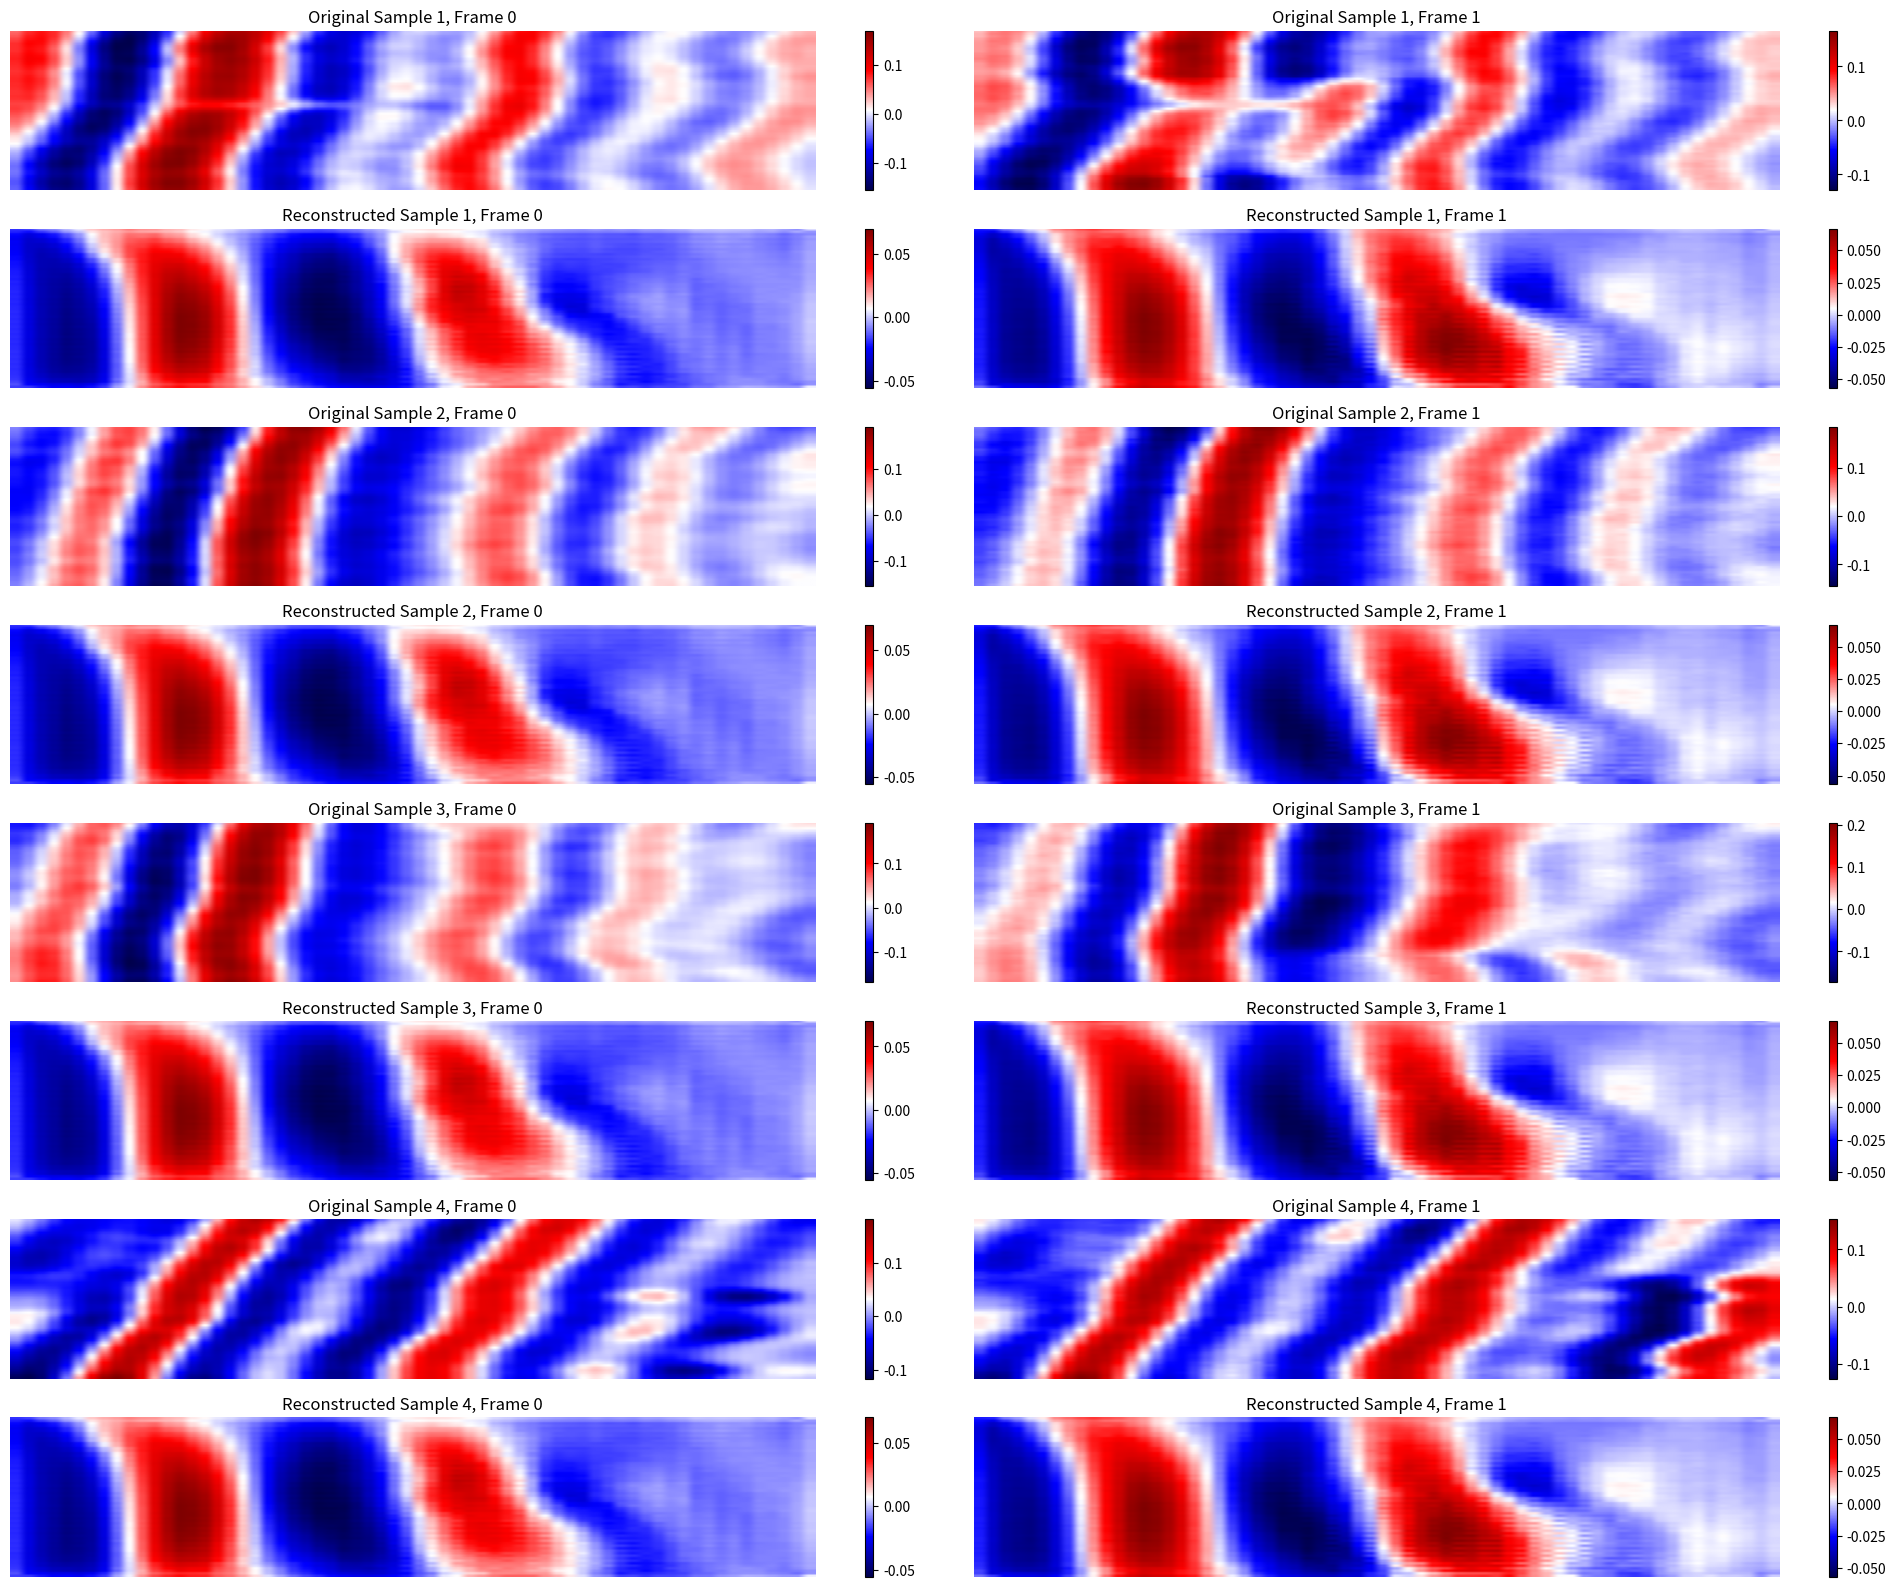

样本 1 MSE: 0.003445
样本 2 MSE: 0.005703
样本 3 MSE: 0.005582
样本 4 MSE: 0.003259
平均 MSE: 0.004497
MSE 标准差: 0.001148

--- 分析量化质量 ---
video:torch.Size([8, 512, 2, 8, 8])
dense_pe第一步：torch.Size([1, 512, 2, 8, 8])
dense_pe第二步：torch.Size([8, 512, 2, 8, 8])
query：torch.Size([8, 1, 512]),video:torch.Size([8, 512, 2, 8, 8])
Input feature mean: 1.9760802388191223e-05, std: 0.9994421601295471
Input feature min: -3.565861940383911, max: 2.583331346511841


AttributeError: 'FSQ' object has no attribute 'levels'

In [ ]:
#@title LDM:inference (might be deprecated)
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def load_best_ldm_model(checkpoint_dir, timestamp, device):
    """载入最佳的LDM模型"""
    best_model_path = os.path.join(checkpoint_dir, f'ldm_best_{timestamp}.pth')

    if not os.path.exists(best_model_path):
        print(f"❌ 最佳模型文件不存在: {best_model_path}")
        return None

    # 载入检查点
    checkpoint = torch.load(best_model_path, map_location=device)

    # 载入模型状态
    model_ldm.load_state_dict(checkpoint['model_state_dict'])
    model_ldm.eval()

    print(f"✅ 已载入最佳LDM模型 (第 {checkpoint['epoch']} 轮, 损失: {checkpoint['loss']:.6f})")
    return checkpoint

def visualize_ldm_reconstruction(model, dataloader, device, num_samples=4, save_path=None):
    """可视化LDM的重建结果"""
    model.eval()

    with torch.no_grad():
        # 获取一个批次的数据
        for batch_tuple in dataloader:
            batch = batch_tuple[0].to(device)  # [B, T, H, W] 或 [B, C, T, H, W]

            # 只取前num_samples个样本
            if batch.shape[0] > num_samples:
                batch = batch[:num_samples]

            print(f"输入批次形状: {batch.shape}")

            # 前向传播
            decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model(batch)

            print(f"解码输出形状: {decoded.shape}")
            print(f"量化特征形状: {quantized.shape}")
            print(f"索引形状: {indices.shape}")

            # 转换为numpy用于可视化
            original = batch.cpu().numpy()
            reconstructed = decoded.cpu().numpy()

            # 确保数据格式正确 [B, C, T, H, W] -> [B, T, H, W] (如果有通道维度)
            if original.ndim == 5 and original.shape[1] == 1:
                original = original.squeeze(1)  # 移除通道维度
            if reconstructed.ndim == 5 and reconstructed.shape[1] == 1:
                reconstructed = reconstructed.squeeze(1)

            # 创建可视化
            fig = plt.figure(figsize=(20, num_samples * 4))

            for i in range(min(num_samples, original.shape[0])):
                # 选择几个关键帧进行显示
                num_frames_to_show = min(8, original.shape[1])
                frame_indices = np.linspace(0, original.shape[1]-1, num_frames_to_show, dtype=int)

                for j, frame_idx in enumerate(frame_indices):
                    # 原始帧
                    plt.subplot(num_samples * 2, num_frames_to_show, i * 2 * num_frames_to_show + j + 1)
                    plt.imshow(original[i, frame_idx], cmap='seismic', aspect='auto')
                    plt.title(f'Original Sample {i+1}, Frame {frame_idx}')
                    plt.colorbar()
                    plt.axis('off')

                    # 重建帧
                    plt.subplot(num_samples * 2, num_frames_to_show, (i * 2 + 1) * num_frames_to_show + j + 1)
                    plt.imshow(reconstructed[i, frame_idx], cmap='seismic', aspect='auto')
                    plt.title(f'Reconstructed Sample {i+1}, Frame {frame_idx}')
                    plt.colorbar()
                    plt.axis('off')

            plt.tight_layout()

            if save_path:
                plt.savefig(save_path, dpi=150, bbox_inches='tight')
                print(f"可视化结果已保存到: {save_path}")

            plt.show()

            # 计算重建误差统计
            mse_per_sample = []
            for i in range(original.shape[0]):
                mse = np.mean((original[i] - reconstructed[i]) ** 2)
                mse_per_sample.append(mse)
                print(f"样本 {i+1} MSE: {mse:.6f}")

            print(f"平均 MSE: {np.mean(mse_per_sample):.6f}")
            print(f"MSE 标准差: {np.std(mse_per_sample):.6f}")

            break  # 只处理第一个批次

def analyze_quantization_quality(model, dataloader, device, num_batches=5):
    """分析量化质量"""
    model.eval()

    all_mse = []
    all_indices_stats = []

    with torch.no_grad():
        for batch_idx, batch_tuple in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            batch = batch_tuple[0].to(device)
            decoded, quantized, indices, _, _ = model(batch)

            # 计算重建误差
            mse = F.mse_loss(decoded, batch).item()
            all_mse.append(mse)

            # 分析索引统计
            indices_np = indices.cpu().numpy()
            unique_indices = np.unique(indices_np)
            all_indices_stats.append({
                'unique_count': len(unique_indices),
                'total_tokens': indices_np.size,
                'usage_ratio': len(unique_indices) / np.prod(model.quantizer.levels),
                'min_index': indices_np.min(),
                'max_index': indices_np.max()
            })

            print(f"批次 {batch_idx+1}: MSE={mse:.6f}, "
                  f"唯一索引数={len(unique_indices)}, "
                  f"码本利用率={len(unique_indices) / np.prod(model.quantizer.levels):.3f}")

    # 总结统计
    print(f"\n=== 量化质量分析 ===")
    print(f"平均 MSE: {np.mean(all_mse):.6f} ± {np.std(all_mse):.6f}")
    print(f"平均码本利用率: {np.mean([s['usage_ratio'] for s in all_indices_stats]):.3f}")
    print(f"平均唯一索引数: {np.mean([s['unique_count'] for s in all_indices_stats]):.1f}")

def compare_with_original_vqvae(model_ldm, trained_vqvae, dataloader, device):
    """比较LDM和原始VQ-VAE的性能"""
    model_ldm.eval()
    trained_vqvae.eval()

    ldm_losses = []
    vqvae_losses = []

    with torch.no_grad():
        for batch_tuple in dataloader:
            batch = batch_tuple[0].to(device)

            # LDM重建
            ldm_decoded, _, _, _, _ = model_ldm(batch)
            ldm_loss = F.mse_loss(ldm_decoded, batch).item()
            ldm_losses.append(ldm_loss)

            # 原始VQ-VAE重建 (需要调整输入格式)
            if batch.dim() == 4:  # [B, T, H, W]
                batch_vqvae = batch.unsqueeze(1)  # [B, C, T, H, W]
            else:
                batch_vqvae = batch

            vqvae_decoded = trained_vqvae(batch_vqvae)
            if vqvae_decoded.dim() == 5 and vqvae_decoded.shape[1] == 1:
                vqvae_decoded = vqvae_decoded.squeeze(1)
            vqvae_loss = F.mse_loss(vqvae_decoded, batch).item()
            vqvae_losses.append(vqvae_loss)

            if len(ldm_losses) >= 10:  # 只比较前10个批次
                break

    print(f"\n=== 模型性能比较 ===")
    print(f"LDM 平均损失: {np.mean(ldm_losses):.6f} ± {np.std(ldm_losses):.6f}")
    print(f"原始VQ-VAE 平均损失: {np.mean(vqvae_losses):.6f} ± {np.std(vqvae_losses):.6f}")

    if np.mean(ldm_losses) < np.mean(vqvae_losses):
        print("✅ LDM 性能更好!")
    else:
        print("⚠️ 原始VQ-VAE 性能更好，LDM可能需要更多训练")

# === 主要使用代码 ===
print("=== 载入训练好的LDM模型并进行可视化 ===")

checkpoint_dir = f_path + '/seismic_world_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 1. 载入最佳模型
checkpoint = checkpoint_dir+'/ldm_best_20250614_044322.pth'

if checkpoint is not None:
    # 2. 可视化重建结果
    print("\n--- 可视化LDM重建结果 ---")
    vis_save_path = os.path.join(checkpoint_dir, f'ldm_reconstruction_vis_{timestamp}.png')
    visualize_ldm_reconstruction(
        model=model_ldm,
        dataloader=ldm_dataloader,
        device=device,
        num_samples=4,
        save_path=vis_save_path
    )

    # # 3. 分析量化质量
    # print("\n--- 分析量化质量 ---")
    # analyze_quantization_quality(
    #     model=model_ldm,
    #     dataloader=ldm_dataloader,
    #     device=device,
    #     num_batches=5
    # )

    # # 4. 与原始VQ-VAE比较 (如果有的话)
    # if 'trained_vqvae' in globals():
    #     print("\n--- 与原始VQ-VAE比较 ---")
    #     compare_with_original_vqvae(
    #         model_ldm=model_ldm,
    #         trained_vqvae=trained_vqvae,
    #         dataloader=ldm_dataloader,
    #         device=device
    #     )

    # # 5. 生成tokens用于后续Transformer训练
    # print("\n--- 生成视频tokens用于Transformer训练 ---")
    # def generate_tokens_from_ldm(model, dataloader, device, save_path=None):
    #     """使用训练好的LDM生成tokens"""
    #     model.eval()
    #     all_tokens = []

    #     with torch.no_grad():
    #         for batch_tuple in tqdm(dataloader, desc="生成tokens"):
    #             batch = batch_tuple[0].to(device)
    #             _, _, indices, _, _ = model(batch)
    #             all_tokens.append(indices.cpu())

    #     all_tokens = torch.cat(all_tokens, dim=0)

    #     if save_path:
    #         torch.save({
    #             'tokens': all_tokens,
    #             'model_info': {
    #                 'quantizer_levels': model.quantizer.levels,
    #                 'codebook_size': np.prod(model.quantizer.levels),
    #                 'timestamp': timestamp
    #             }
    #         }, save_path)
    #         print(f"Tokens已保存到: {save_path}")

    #     return all_tokens

    # tokens_save_path = os.path.join(checkpoint_dir, f'ldm_tokens_{timestamp}.pt')
    # video_tokens_ldm = generate_tokens_from_ldm(
    #     model=model_ldm,
    #     dataloader=ldm_dataloader,
    #     device=device,
    #     save_path=tokens_save_path
    # )

    # print(f"✅ 生成的LDM tokens形状: {video_tokens_ldm.shape}")
    # print(f"Tokens值范围: {video_tokens_ldm.min()} - {video_tokens_ldm.max()}")

else:
    print("❌ 无法载入模型，请检查模型文件路径")


In [ ]:
#@title # Training Setup for LDM+AR transformer workflow (might be deprecated)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters (adjust based on Table A.1 and your resources)
ldm_epochs = 50 # Example: Set LDM training epochs
transformer_epochs = 100 # Example: Set Transformer training epochs
ldm_lr = 1e-4 # From Table A.1
transformer_lr = 3e-4 # From Table A.1
ldm_batch_size = 8 # Adjust based on GPU memory
transformer_batch_size = 4 # Adjust based on GPU memory and sequence length
image_size = 64 # Match LDM config
latent_channels = 1 # Match LDM config
frame_num = 9 # Match LDM config (T)
num_workers = 4 # For DataLoader

# LDM Model Instantiation
model_ldm = VideoWorldLDM(
    image_size=image_size,
    latent_channels=latent_channels,
    frame_num=frame_num
).to(device)

# Calculate LDM codebook size from the instantiated model
codebook_size_ldm = model_ldm.quantizer.codebook_size
print(f"LDM Codebook Size: {codebook_size_ldm}")

# Frame Tokenizer / VQ-VAE (Placeholder - Requires actual implementation)
# You need a way to get frame tokens. Let's assume a VQ-VAE exists.
# vqvae_model = YourVQVAE().to(device)
# vqvae_model.eval() # Use pre-trained VQ-VAE
codebook_size_frame = 8192 # Example: Set your frame VQ-VAE codebook size
num_space_frame_tokens = 16*16 # Example: Number of tokens per frame (e.g., 16x16 spatial resolution)

# Transformer Model Instantiation
# Calculate sequence length: BOS + T * (LDM_tokens + Frame_tokens)
# LDM indices shape: [B, H', W'] -> num_ldm_codes = H' * W' (e.g., 8*8=64)
# Need to know the spatial dimensions of LDM indices output
# Let's assume LDM encoder downsamples 64x64 by 8 -> 8x8 latent space
num_ldm_codes_per_step = 8 * 8 # Example: Adjust based on actual LDM output spatial dim
max_seq_length = 1 + frame_num * (num_ldm_codes_per_step + num_space_frame_tokens)
print(f"Max Sequence Length: {max_seq_length}")

# Adjust Transformer hyperparameters if needed based on sequence length and memory
transformer_hidden_size = 1024 # Example
transformer_num_layers = 8   # Example
transformer_num_heads = 8    # Example
transformer_intermediate_size = 4096 # Example

model_transformer = SeismicWorldVideoWorld(
    codebook_size_ldm=codebook_size_ldm,
    codebook_size_frame=codebook_size_frame,
    special_token_count=3,
    max_seq_length=max_seq_length, # Set calculated max length
    hidden_size=transformer_hidden_size,
    num_hidden_layers=transformer_num_layers,
    num_attention_heads=transformer_num_heads,
    intermediate_size=transformer_intermediate_size,
    num_ldm_codes_per_step=num_ldm_codes_per_step,
    num_frame_tokens_per_step=num_space_frame_tokens,
    # pretrained_model_path=None, # Set path if using pretrained InternLM
    device=device,
).to(device)

# Optimizers (AdamW as per paper)
optimizer_ldm = optim.AdamW(model_ldm.parameters(), lr=ldm_lr)
optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=transformer_lr)

# Grad clipping value
max_grad_norm = 1.0

# -- dataloader ---
# Ensure the data has the channel dimension C=1 expected by the model [N, C, T, H, W]
if seismic_data_video.dim() == 4: # If shape is [N, T, H, W]
    seismic_data_video = seismic_data_video.unsqueeze(1) # Add channel dim -> [N, 1, T, H, W]
elif seismic_data_video.dim() == 5: # If shape is already [N, C, T, H, W]
    # Verify channel dimension matches model's expected channels
    if seismic_data_video.shape[1] != latent_channels:
         raise ValueError(f"Seismic data channel dimension ({seismic_data_video.shape[1]}) does not match model's latent_channels ({latent_channels})")
else:
    raise ValueError(f"Unexpected seismic_data_video dimensions: {seismic_data_video.dim()}. Expected 4 or 5.")

# Verify T, H, W dimensions match model config
if seismic_data_video.shape[2] != frame_num:
     raise ValueError(f"Seismic data time dimension ({seismic_data_video.shape[2]}) does not match model's frame_num ({frame_num})")
if seismic_data_video.shape[3] != image_size or seismic_data_video.shape[4] != image_size:
     raise ValueError(f"Seismic data spatial dimensions ({seismic_data_video.shape[3]}x{seismic_data_video.shape[4]}) do not match model's image_size ({image_size}x{image_size})")


# Create a Dataset wrapping the tensor
# We can use PyTorch's built-in TensorDataset for simplicity
dataset = TensorDataset(seismic_data_video)

# --- Create DataLoader ---
# Note: TensorDataset returns a tuple containing the sample.
# We need to unpack it in the training loop.
ldm_dataloader = DataLoader(dataset, batch_size=ldm_batch_size, shuffle=True, num_workers=num_workers)

print(f"Using pre-loaded seismic data with {len(dataset)} samples.")

# --- Stage 1: Train LDM ---
print("--- Starting LDM Training ---")
model_ldm.train()
model_transformer.eval() # Keep transformer frozen

for epoch in range(ldm_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(ldm_dataloader, desc=f"LDM Epoch {epoch+1}/{ldm_epochs}")
    for batch_tuple in progress_bar:
        batch = batch_tuple[0].to(device) # Shape: [B, C, T, H, W]

        optimizer_ldm.zero_grad()

        # Forward pass through LDM
        decoded, quantized, indices, _, _ = model_ldm(batch)

        # LDM Loss: Reconstruction (MSE Loss as per Table A.1)
        ldm_loss = F.mse_loss(decoded, batch)
        epoch_loss += ldm_loss.item()

        # Backward pass and optimization
        ldm_loss.backward()
        clip_grad_norm_(model_ldm.parameters(), max_grad_norm)
        optimizer_ldm.step()

        progress_bar.set_postfix(loss=ldm_loss.item())

    avg_epoch_loss = epoch_loss / len(ldm_dataloader)
    print(f"LDM Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

    # Optional: Save LDM checkpoint periodically
    # torch.save(model_ldm.state_dict(), f_path+'/seismic_world_checkpoints/ldm_epoch_{epoch+1}.pth')

print("--- LDM Training Finished ---")
# Save final LDM model
torch.save(model_ldm.state_dict(), f_path+'/seismic_world_checkpoints/ldm_final.pth')


# --- Intermediate Step: Prepare Data for Transformer ---
print("--- Preparing Data for Transformer Training ---")
model_ldm.eval() # Freeze LDM
# vqvae_model.eval() # Ensure VQVAE is frozen if used

all_input_ids = []
all_labels = []
all_attention_masks = []

# Use a DataLoader for efficient processing, batch size can be larger here
# No need to create a separate prepare_dataloader, reuse ldm_dataloader definition
# but set shuffle=False for reproducibility if needed, though not critical here.
prepare_dataloader = DataLoader(dataset, batch_size=ldm_batch_size * 2, shuffle=False, num_workers=num_workers)

with torch.no_grad():
    for batch_tuple in tqdm(prepare_dataloader, desc="Generating Tokens"):
        batch_videos = batch_tuple[0].to(device) # [B, C, T, H, W]
        current_batch_size = batch_videos.size(0)

        # 1. Get LDM latent codes (indices)
        _, _, ldm_indices, _, _ = model_ldm(batch_videos)
        # ldm_indices shape: e.g., [B, H', W'] or [B, T', H', W']
        # We need indices corresponding to each time step T
        # Assuming LDM compresses time, we might need to rethink this or use a different LDM arch
        # For now, let's assume indices correspond to the output steps somehow.
        # If indices are [B, H', W'], flatten them: [B, H'*W']
        # Let's assume the LDM outputs one set of codes for the future frames as in the paper
        ldm_tokens = ldm_indices.view(current_batch_size, -1) # Shape: [B, num_ldm_codes_per_step]
        # Add LDM offset
        ldm_tokens = ldm_tokens + model_transformer.ldm_token_offset

        # 2. Get Frame Tokens (Requires your VQ-VAE/Tokenizer)
        # Ensure vqvae_model is in eval mode and on the correct device
        vqvae_model.eval()
        vqvae_model.to(device)

        # Process the entire video clip
        # Output indices will have a time dimension T' (after VQVAE temporal downsampling)
        # Shape: [B, T', H', W'] (or [B, T', H', W', C] if FSQ keep_num_codebooks_dim=True)
        all_frame_indices = vqvae_model.encode_to_indices(batch_videos.to(device))

        # Reshape/Permute if needed so T' is an iterable dimension
        # Example: if shape is [B, T', H', W']
        B, T_prime, H_prime, W_prime = all_frame_indices.shape
        num_space_frame_tokens = H_prime * W_prime

        # Flatten spatial dimensions: -> [B, T', H'*W']
        all_frame_indices_flat = all_frame_indices.view(B, T_prime, num_space_frame_tokens)

        # Now loop through T_prime (the time dimension from VQVAE output)
        frame_tokens_list = []
        for t_prime in range(T_prime): # Iterate through VQVAE's output time
            frame_tokens_flat = all_frame_indices_flat[:, t_prime, :] # Get tokens for time t' -> [B, num_space_frame_tokens]

            # Add the frame offset (after getting indices from VQVAE)
            frame_tokens_flat_offset = frame_tokens_flat + model_transformer.frame_token_offset
            frame_tokens_list.append(frame_tokens_flat_offset)

        # 3. Construct Sequences: BOS + LDM_0 + Frame_0 + LDM_1 + Frame_1 ...
        #    The paper structure might be different (e.g., all LDM codes first?)
        #    Let's assume interleaved: BOS + LDM + Frame_0 + Frame_1 ... Frame_T-1
        #    According to the paper Fig 2: Input is [BOS, z_LDM, v_0, v_1, ..., v_{T-1}]
        bos_token = torch.full((current_batch_size, 1), model_transformer.bos_token_id, device=device, dtype=torch.long)

        # Concatenate: BOS + LDM codes + All Frame tokens flattened
        current_input_ids = [bos_token, ldm_tokens]
        for t in range(frame_num):
            current_input_ids.append(frame_tokens_list[t])

        input_ids_cat = torch.cat(current_input_ids, dim=1) # Shape [B, 1 + num_ldm + T*num_frame]

        # Truncate or pad to max_seq_length
        seq_len = input_ids_cat.shape[1]
        if seq_len > model_transformer.max_seq_length:
            print(f"Warning: Sequence length {seq_len} exceeds max {model_transformer.max_seq_length}. Truncating.")
            input_ids_final = input_ids_cat[:, :model_transformer.max_seq_length]
        elif seq_len < model_transformer.max_seq_length:
            padding_len = model_transformer.max_seq_length - seq_len
            padding = torch.full((current_batch_size, padding_len), model_transformer.pad_token_id, device=device, dtype=torch.long)
            input_ids_final = torch.cat([input_ids_cat, padding], dim=1)
        else:
            input_ids_final = input_ids_cat

        # Create labels (shifted input_ids, replace padding with -100)
        labels = input_ids_final.clone()
        labels[labels == model_transformer.pad_token_id] = -100 # Mask padding for loss calculation

        # Create attention mask
        attention_mask = (input_ids_final != model_transformer.pad_token_id).long()

        all_input_ids.append(input_ids_final.cpu())
        all_labels.append(labels.cpu())
        all_attention_masks.append(attention_mask.cpu())

# Combine all processed batches
all_input_ids_tensor = torch.cat(all_input_ids, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)
all_attention_masks_tensor = torch.cat(all_attention_masks, dim=0)

# Create a new Dataset and DataLoader for the Transformer
transformer_dataset = TensorDataset(all_input_ids_tensor, all_attention_masks_tensor, all_labels_tensor)
transformer_dataloader = DataLoader(transformer_dataset, batch_size=transformer_batch_size, shuffle=True, num_workers=num_workers)

print(f"--- Transformer Data Prepared: {len(transformer_dataset)} samples ---")


# --- Stage 2: Train Auto-Regressive Transformer ---
print("--- Starting Transformer Training ---")
model_ldm.eval() # Keep LDM frozen
model_transformer.train() # Set Transformer to train mode

for epoch in range(transformer_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(transformer_dataloader, desc=f"Transformer Epoch {epoch+1}/{transformer_epochs}")
    for input_ids, attention_mask, labels in progress_bar:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device) # Labels already shifted and padded with -100

        optimizer_transformer.zero_grad()

        # Forward pass through Transformer
        # The model's forward pass calculates the loss internally when labels are provided
        outputs = model_transformer(
            input_ids=input_ids,
            labels=labels, # Pass labels for loss calculation
            attention_mask=attention_mask,
            return_dict=True
        )

        # Loss is directly available in the outputs object
        transformer_loss = outputs.loss

        # Check if loss is valid
        if transformer_loss is None:
             print("Warning: Transformer loss is None. Check model forward pass and label preparation.")
             continue
        if torch.isnan(transformer_loss) or torch.isinf(transformer_loss):
             print(f"Warning: Encountered NaN/Inf loss: {transformer_loss.item()}. Skipping step.")
             continue

        epoch_loss += transformer_loss.item()

        # Backward pass and optimization
        transformer_loss.backward()
        clip_grad_norm_(model_transformer.parameters(), max_grad_norm)
        optimizer_transformer.step()

        progress_bar.set_postfix(loss=transformer_loss.item())

    avg_epoch_loss = epoch_loss / len(transformer_dataloader)
    print(f"Transformer Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

    # Optional: Save Transformer checkpoint periodically
    # torch.save(model_transformer.state_dict(), f'transformer_epoch_{epoch+1}.pth')

print("--- Transformer Training Finished ---")
# Save final Transformer model
# torch.save(model_transformer.state_dict(), 'transformer_final.pth')

print("--- Training Complete ---")

In [8]:
# @title SeismicWorld auto-regressive transformer 覆盖

# --- SeismicWorld Frame-Only Auto-regressive Transformer Training---
class SeismicWorld(nn.Module):
  def __init__(
      self,
      codebook_size_frame,
      special_token_count=3,     # BOS/EOS/PAD
      max_seq_length=1024,
      hidden_size=4096,
      num_hidden_layers=12,
      num_attention_heads=16,
      intermediate_size=4096,
      num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
      pretrained_model_path=None,
      device=None,
  ):
      super().__init__()
      self.codebook_size_frame = codebook_size_frame
      self.special_token_count = special_token_count

      # Define vocabulary ranges (simplified without LDM tokens)
      self.frame_token_offset = 0  # Frame tokens start from 0
      self.special_token_offset = self.codebook_size_frame

      self.vocab_size = self.special_token_offset + special_token_count

      self.max_seq_length = max_seq_length
      self.num_frame_tokens_per_step = num_frame_tokens_per_step
      self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # InternLM configuration
      if pretrained_model_path:
          # from MoE.modeling_internlm import InternLMForCausalLM
          self.model = InternLMForCausalLM.from_pretrained(
              pretrained_model_path,
              torch_dtype=torch.float16,
              low_cpu_mem_usage=True,
          )
          print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
          self.model.resize_token_embeddings(self.vocab_size)
          if self.model.config.max_position_embeddings < max_seq_length:
              print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
              self.model.resize_position_embeddings(max_seq_length)
      else:
          # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
          config = InternLMConfig(
              vocab_size=self.vocab_size,
              hidden_size=hidden_size,
              num_hidden_layers=num_hidden_layers,
              num_attention_heads=num_attention_heads,
              intermediate_size=intermediate_size,
              max_position_embeddings=max_seq_length,
              rms_norm_eps=1e-6,
              use_cache=True,
          )
          self.model = InternLMForCausalLM(config)

      # Positional Encoding for frame sequences
      self.num_time_steps_for_pos = math.ceil(max_seq_length / self.num_frame_tokens_per_step) + 1
      self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
      self.step_pos_embed = nn.Embedding(self.num_frame_tokens_per_step, hidden_size)

      # Special token IDs
      self.bos_token_id = self.special_token_offset
      self.eos_token_id = self.special_token_offset + 1
      self.pad_token_id = self.special_token_offset + 2

      self.to(self.device)

  def get_token_type_ids(self, input_ids):
      """ Distinguish between BOS, Frame, PAD tokens """
      token_type_ids = torch.zeros_like(input_ids)
      # Mark Frame tokens (type 1)
      token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 1
      # Mark Special tokens (type 0)
      token_type_ids[input_ids == self.bos_token_id] = 0
      token_type_ids[input_ids == self.eos_token_id] = 0
      token_type_ids[input_ids == self.pad_token_id] = 0
      return token_type_ids

  def add_positional_encoding(self, input_ids):
      """
      Adds positional encoding based on time step and position within the step.
      Assumes input_ids shape [B, seq_len] and structure like:
      [BOS, frame_0_0, ..., frame_0_M, frame_1_0, ..., frame_1_M, ...]
      """
      batch_size, seq_len = input_ids.shape
      device = input_ids.device

      position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

      # Calculate time step ID and position within step ID
      positions_after_bos = position_ids - 1  # -1 for positions relative to first frame token
      time_step_ids = torch.zeros_like(position_ids)
      position_in_step_ids = torch.zeros_like(position_ids)

      # Handle BOS token separately (time step 0, position 0)
      is_not_bos = (input_ids != self.bos_token_id)
      time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.num_frame_tokens_per_step + 1
      position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.num_frame_tokens_per_step

      # Clamp time_step_ids to max embedding index
      time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

      # Get embeddings
      time_pos = self.time_pos_embed(time_step_ids)
      step_pos = self.step_pos_embed(position_in_step_ids)

      # Combine embeddings
      pos_encoding = time_pos + step_pos
      return pos_encoding

  def forward(
      self,
      input_ids,
      labels=None,
      attention_mask=None,
      return_dict=None
  ):
      """
      Teacher Forcing training for frame-only sequences.
      input_ids: [B, seq_len] - BOS + frame_0 + frame_1 + ...
      labels: [B, seq_len] - shifted input_ids with -100 for padding
      """
      return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

      # Get token embeddings
      inputs_embeds = self.model.get_input_embeddings()(input_ids)

      # Add positional encoding
      pos_encoding = self.add_positional_encoding(input_ids)
      inputs_embeds = inputs_embeds + pos_encoding

      # Prepare attention mask if not provided
      if attention_mask is None:
          attention_mask = (input_ids != self.pad_token_id).long()

      # Call the underlying InternLM model
      outputs = self.model(
          inputs_embeds=inputs_embeds,
          attention_mask=attention_mask,
          labels=labels,
          use_cache=False,
          return_dict=return_dict,
          output_hidden_states=False,
          output_attentions=False,
      )

      return outputs

  @torch.no_grad()
  def generate(
      self,
      input_ids,
      max_new_tokens,
      attention_mask=None,
      temperature=1.0,
      top_k=None,
      eos_token_id=None,
      **kwargs
  ):
      """
      Autoregressive generation for frame sequences.
      """
      self.model.eval()
      device = input_ids.device
      batch_size, cur_len = input_ids.shape

      generated = input_ids
      past_key_values = None
      if attention_mask is None:
          attention_mask = torch.ones_like(input_ids)

      effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

      for _ in range(max_new_tokens):
          if past_key_values is None:
              current_input_ids = generated
              current_attention_mask = attention_mask
          else:
              current_input_ids = generated[:, -1:]
              current_attention_mask = torch.cat(
                  [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
              )
              attention_mask = current_attention_mask

          # Get embeddings and add positional encoding
          inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
          pos_encoding = self.add_positional_encoding(generated)
          if past_key_values is None:
              current_pos_encoding = pos_encoding
          else:
              current_pos_encoding = pos_encoding[:, -1:, :]

          current_inputs_embeds = inputs_embeds + current_pos_encoding

          # Forward pass
          outputs = self.model(
              inputs_embeds=current_inputs_embeds,
              attention_mask=current_attention_mask,
              past_key_values=past_key_values,
              use_cache=True,
              return_dict=True,
          )

          # Get logits for the next token
          next_token_logits = outputs.logits[:, -1, :]

          # Apply temperature scaling
          if temperature != 1.0:
              next_token_logits = next_token_logits / temperature

          # Apply top-k filtering
          if top_k is not None:
              v, _ = torch.topk(next_token_logits, top_k, dim=-1)
              next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

          # Sample next token
          probs = F.softmax(next_token_logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)

          # Append generated token
          generated = torch.cat([generated, next_token], dim=1)

          # Update past_key_values
          past_key_values = outputs.past_key_values

          # Check for EOS token, if EOS then end.
          if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
              break

      return generated

# --- Training Pipeline for Frame-Only SeismicWorld (with EOS token and Best Model Saving) ---
def train_seismic_world_frame_only(
  seismic_data_video,  # torch.Size([1280, 2, 64, 64])
  vqvae_model,
  device,
  # Model hyperparameters
  transformer_hidden_size=1024,
  transformer_num_layers=8,
  transformer_num_heads=8,
  transformer_intermediate_size=4096,
  # Training hyperparameters
  transformer_batch_size=16,
  transformer_epochs=10,
  learning_rate=1e-4,
  max_grad_norm=1.0,
  num_workers=4,
  # Best model saving parameters
  validation_split=0.1,  # 10% for validation
  save_best_model=True,
  best_model_path='seismic_world_frame_only_best.pth',
  patience=3,  # Early stopping patience (optional)
):
  """
  Complete training pipeline for frame-only SeismicWorld model with EOS token and best model saving.

  Args:
      seismic_data_video: Tensor of shape [1280, 2, 64, 64] - video data
      vqvae_model: Trained VQ-VAE model for frame tokenization
      device: Training device
      validation_split: Fraction of data to use for validation
      save_best_model: Whether to save the best model based on validation loss
      best_model_path: Path to save the best model
      patience: Early stopping patience (0 to disable early stopping)
  """

  print("=== Starting Frame-Only SeismicWorld Training (with EOS and Best Model Saving) ===")

  # Get VQ-VAE codebook size
  codebook_size_frame = vqvae_model.codebook_size
  print(f"Frame codebook size: {codebook_size_frame}")

  # Calculate sequence parameters
  # Assuming VQ-VAE downsamples 64x64 to 8x8
  num_frame_tokens_per_step = 8 * 8  # Adjust based on actual VQ-VAE output
  frame_num = seismic_data_video.shape[1]  # 2 frames per video

  # Sequence structure: BOS + Frame_0_tokens + Frame_1_tokens + EOS
  max_seq_length = 1 + frame_num * num_frame_tokens_per_step + 1  # +1 for EOS
  print(f"Max sequence length: {max_seq_length}")

  # Initialize transformer model
  model_transformer = SeismicWorld(
      codebook_size_frame=codebook_size_frame,
      special_token_count=3,  # BOS, EOS, PAD
      max_seq_length=max_seq_length,
      hidden_size=transformer_hidden_size,
      num_hidden_layers=transformer_num_layers,
      num_attention_heads=transformer_num_heads,
      intermediate_size=transformer_intermediate_size,
      num_frame_tokens_per_step=num_frame_tokens_per_step,
      device=device,
  ).to(device)

  # Setup optimizer
  optimizer_transformer = torch.optim.AdamW(
      model_transformer.parameters(),
      lr=learning_rate,
      weight_decay=0.01
  )

  print("--- Preparing Frame Tokens ---")
  vqvae_model.eval()
  vqvae_model.to(device)

  all_input_ids = []
  all_labels = []
  all_attention_masks = []

  # Process data in batches to manage memory
  batch_size_prep = 64  # Batch size for token preparation
  num_batches = math.ceil(len(seismic_data_video) / batch_size_prep)

  with torch.no_grad():
      for batch_idx in tqdm(range(num_batches), desc="Generating Frame Tokens"):
          start_idx = batch_idx * batch_size_prep
          end_idx = min(start_idx + batch_size_prep, len(seismic_data_video))

          # Get batch data: [B, T, H, W]
          batch_videos = seismic_data_video[start_idx:end_idx].to(device)
          current_batch_size = batch_videos.size(0)
          print(f'batch_videos={batch_videos.shape}') # torch.Size([64, 2, 64, 64])

          # Get frame tokens from VQ-VAE
          # Expected output: [B, T', H', W'] where T'=2, H'=8, W'=8
          all_frame_indices_1 = vqvae_model.encode_to_indices(batch_videos[:,:1,...])
          all_frame_indices_2 = vqvae_model.encode_to_indices(batch_videos[:,1:2,...])
          all_frame_indices = torch.cat([all_frame_indices_1, all_frame_indices_2], dim=1)

          print(f'all_frame_indices={all_frame_indices.shape}')

          # Reshape: [B, T', H', W'] -> [B, T', H'*W']
          B, T_prime, H_prime, W_prime = all_frame_indices.shape
          num_space_frame_tokens = H_prime * W_prime
          all_frame_indices_flat = all_frame_indices.view(B, T_prime, num_space_frame_tokens)

          # Construct sequences: BOS + Frame_0 + Frame_1 + ... + EOS
          bos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.bos_token_id,
              device=device,
              dtype=torch.long
          )

          eos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.eos_token_id,
              device=device,
              dtype=torch.long
          )

          # Build sequence for each sample
          sequence_parts = [bos_token]

          for t in range(T_prime):
              frame_tokens = all_frame_indices_flat[:, t, :]  # [B, num_space_frame_tokens]
              # Add frame token offset
              frame_tokens_offset = frame_tokens + model_transformer.frame_token_offset
              sequence_parts.append(frame_tokens_offset)

          # Add EOS token at the end
          sequence_parts.append(eos_token)

          # Concatenate all parts to get complete sequence
          # [BOS, frame0_tokens..., frame1_tokens..., EOS]
          complete_sequence = torch.cat(sequence_parts, dim=1)

          # === CORRECTED INPUT/LABEL CREATION ===
          seq_len = complete_sequence.shape[1]

          # Check if sequence is too long
          if seq_len > model_transformer.max_seq_length:
              print(f"Warning: Sequence length {seq_len} exceeds max {model_transformer.max_seq_length}. Truncating.")
              complete_sequence = complete_sequence[:, :model_transformer.max_seq_length]
              seq_len = model_transformer.max_seq_length

          # Create input_ids and labels with proper shifting
          # input_ids: [BOS, frame0_tokens..., frame1_tokens...]  (all tokens except EOS)
          # labels:    [frame0_tokens..., frame1_tokens..., EOS]   (all tokens except BOS)
          input_ids = complete_sequence[:, :-1]  # Remove last token (EOS for input)
          labels = complete_sequence[:, 1:]      # Remove first token (BOS for labels)

          # Current lengths after shifting
          current_input_len = input_ids.shape[1]
          current_label_len = labels.shape[1]

          # Pad to max_seq_length - 1 (to account for the shift)
          target_length = model_transformer.max_seq_length - 1

          if current_input_len < target_length:
              padding_length = target_length - current_input_len

              # Pad input_ids with pad_token_id
              input_padding = torch.full(
                  (current_batch_size, padding_length),
                  model_transformer.pad_token_id,
                  device=device,
                  dtype=torch.long
              )
              input_ids = torch.cat([input_ids, input_padding], dim=1)

              # Pad labels with -100 (ignored in loss calculation)
              label_padding = torch.full(
                  (current_batch_size, padding_length),
                  -100,
                  device=device,
                  dtype=torch.long
              )
              labels = torch.cat([labels, label_padding], dim=1)

          # Create attention mask (1 for real tokens, 0 for padding)
          attention_mask = (input_ids != model_transformer.pad_token_id).long()

          # Store results
          all_input_ids.append(input_ids.cpu())
          all_labels.append(labels.cpu())
          all_attention_masks.append(attention_mask.cpu())

  # Combine all processed batches
  all_input_ids_tensor = torch.cat(all_input_ids, dim=0)
  all_labels_tensor = torch.cat(all_labels, dim=0)
  all_attention_masks_tensor = torch.cat(all_attention_masks, dim=0)

  print(f"Total training samples: {len(all_input_ids_tensor)}")
  print(f"Input shape: {all_input_ids_tensor.shape}")
  print(f"Labels shape: {all_labels_tensor.shape}")
  print(f"Attention mask shape: {all_attention_masks_tensor.shape}")

  # === TRAIN/VALIDATION SPLIT ===
  total_samples = len(all_input_ids_tensor)
  val_size = int(total_samples * validation_split)
  train_size = total_samples - val_size

  # Random split
  indices = torch.randperm(total_samples)
  train_indices = indices[:train_size]
  val_indices = indices[train_size:]

  # Create train and validation datasets
  train_input_ids = all_input_ids_tensor[train_indices]
  train_attention_masks = all_attention_masks_tensor[train_indices]
  train_labels = all_labels_tensor[train_indices]

  val_input_ids = all_input_ids_tensor[val_indices]
  val_attention_masks = all_attention_masks_tensor[val_indices]
  val_labels = all_labels_tensor[val_indices]

  print(f"Training samples: {len(train_input_ids)}")
  print(f"Validation samples: {len(val_input_ids)}")

  # Verify the input/label alignment
  print("\n--- Verifying Input/Label Alignment ---")
  sample_idx = 0
  print(f"Sample {sample_idx}:")
  print(f"Input (first 10):  {train_input_ids[sample_idx, :10].tolist()}")
  print(f"Labels (first 10): {train_labels[sample_idx, :10].tolist()}")
  print(f"Input (last 5):    {train_input_ids[sample_idx, -5:].tolist()}")
  print(f"Labels (last 5):   {train_labels[sample_idx, -5:].tolist()}")
  print(f"BOS token ID: {model_transformer.bos_token_id}")
  print(f"EOS token ID: {model_transformer.eos_token_id}")
  print(f"PAD token ID: {model_transformer.pad_token_id}")

  # Create datasets and dataloaders
  train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
  val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

  train_dataloader = DataLoader(
      train_dataset,
      batch_size=transformer_batch_size,
      shuffle=True,
      num_workers=num_workers
  )
  val_dataloader = DataLoader(
      val_dataset,
      batch_size=transformer_batch_size,
      shuffle=False,
      num_workers=num_workers
  )

  # === BEST MODEL TRACKING VARIABLES ===
  best_train_loss = float('inf')
  best_epoch = 0
  epochs_without_improvement = 0

  print("--- Starting Transformer Training ---")
  model_transformer.train()

  for epoch in range(transformer_epochs):
      # === TRAINING PHASE ===
      model_transformer.train()
      epoch_train_loss = 0.0
      train_progress_bar = tqdm(
          train_dataloader,
          desc=f"Training Epoch {epoch+1}/{transformer_epochs}"
      )

      for input_ids, attention_mask, labels in train_progress_bar:
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          labels = labels.to(device)

          optimizer_transformer.zero_grad()

          # Forward pass
          outputs = model_transformer(
              input_ids=input_ids,
              labels=labels,
              attention_mask=attention_mask,
              return_dict=True
          )

          transformer_loss = outputs.loss

          # Check for valid loss
          if transformer_loss is None:
              print("Warning: Transformer loss is None. Skipping step.")
              continue
          if torch.isnan(transformer_loss) or torch.isinf(transformer_loss):
              print(f"Warning: Invalid loss: {transformer_loss.item()}. Skipping step.")
              continue

          epoch_train_loss += transformer_loss.item()

          # Backward pass
          transformer_loss.backward()
          torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), max_grad_norm)
          optimizer_transformer.step()

          train_progress_bar.set_postfix(loss=transformer_loss.item())

      avg_train_loss = epoch_train_loss / len(train_dataloader)

      # === VALIDATION PHASE ===
      model_transformer.eval()
      epoch_val_loss = 0.0
      val_progress_bar = tqdm(
          val_dataloader,
          desc=f"Validation Epoch {epoch+1}/{transformer_epochs}"
      )

      with torch.no_grad():
          for input_ids, attention_mask, labels in val_progress_bar:
              input_ids = input_ids.to(device)
              attention_mask = attention_mask.to(device)
              labels = labels.to(device)

              # Forward pass
              outputs = model_transformer(
                  input_ids=input_ids,
                  labels=labels,
                  attention_mask=attention_mask,
                  return_dict=True
              )

              val_loss = outputs.loss

              if val_loss is not None and not (torch.isnan(val_loss) or torch.isinf(val_loss)):
                  epoch_val_loss += val_loss.item()

              val_progress_bar.set_postfix(loss=val_loss.item() if val_loss is not None else 0.0)

      avg_val_loss = epoch_val_loss / len(val_dataloader)

      print(f"Epoch {epoch+1}/{transformer_epochs}")
      print(f"  Train Loss: {avg_train_loss:.4f}")
      # print(f"  Val Loss:   {avg_val_loss:.4f}")

      # === BEST MODEL SAVING ===
      if save_best_model and avg_train_loss < best_train_loss:
          best_train_loss = avg_train_loss
          best_epoch = epoch + 1
          epochs_without_improvement = 0

          # Save best model
          torch.save({
              'epoch': epoch + 1,
              'model_state_dict': model_transformer.state_dict(),
              'optimizer_state_dict': optimizer_transformer.state_dict(),
              'train_loss': avg_train_loss,
              'val_loss': avg_val_loss,
              'best_train_loss': best_train_loss,
          }, best_model_path)

          print(f"  🎉 New best model saved! Train Loss: {best_train_loss:.4f}")
      else:
          epochs_without_improvement += 1
          print(f"  No improvement for {epochs_without_improvement} epochs. Best: {best_train_loss:.4f} (Epoch {best_epoch})")

      # === EARLY STOPPING ===
      if patience > 0 and epochs_without_improvement >= patience:
          print(f"\n⏹️  Early stopping triggered after {patience} epochs without improvement.")
          print(f"Best training loss: {best_train_loss:.4f} at epoch {best_epoch}")
          break

      # # Optional: Save checkpoint every 5 epochs
      # if (epoch + 1) % 5 == 0:
      #     checkpoint_path = f'seismic_world_frame_only_epoch_{epoch+1}.pth'
      #     torch.save({
      #         'epoch': epoch + 1,
      #         'model_state_dict': model_transformer.state_dict(),
      #         'optimizer_state_dict': optimizer_transformer.state_dict(),
      #         'train_loss': avg_train_loss,
      #         'val_loss': avg_val_loss,
      #     }, checkpoint_path)
      #     print(f"  💾 Checkpoint saved: {checkpoint_path}")

  print("\n--- Training Complete ---")
  print(f"Best training loss: {best_train_loss:.4f} achieved at epoch {best_epoch}")

  # Load best model if it was saved
  if save_best_model and os.path.exists(best_model_path):
      print(f"Loading best model from {best_model_path}")
      checkpoint = torch.load(best_model_path, map_location=device)
      model_transformer.load_state_dict(checkpoint['model_state_dict'])
      print(f"Best model loaded (Epoch {checkpoint['epoch']}, Train Loss: {checkpoint['train_loss']:.4f})")

  # # Save final model (current state)
  # final_model_path = 'seismic_world_frame_only_final.pth'
  # torch.save({
  #     'model_state_dict': model_transformer.state_dict(),
  #     'optimizer_state_dict': optimizer_transformer.state_dict(),
  #     'final_epoch': epoch + 1,
  #     'best_train_loss': best_train_loss,
  #     'best_epoch': best_epoch,
  # }, final_model_path)
  # print(f"Final model saved: {final_model_path}")

  return model_transformer, best_train_loss, best_epoch


# --- 训练 ---
# seismic_data_video: torch.Size([1280, 2, 64, 64])

# vqvae_model: trained VQ-VAE model
# Frame Tokenizer / VQ-VAE
IMAGE_SIZE = 64
VID_CHANNELS = 1
FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5]
INIT_DIM = 128
BATCH_SIZE = 4
NUM_WORKERS = 1

checkpoint_dir = f_path + "/seismic_world_checkpoints"
model_path = checkpoint_dir+'/vqvae_trained_best_20250613_124407_LinearFSQ_777555.pth'

# 载入模型
vqvae_model = load_trained_vqvae(
    model_path=model_path,
    image_size=IMAGE_SIZE,
    vid_channels=VID_CHANNELS,
    fsq_levels=FSQ_LEVELS,
    init_dim=INIT_DIM,
    device=DEVICE
)

print("模型载入成功!")

codebook_size_frame = 42875 # Example: Set your frame VQ-VAE codebook size
num_space_frame_tokens = 8*8 # Example: Number of tokens per frame (e.g., 16x16 spatial resolution)

model_transformer, best_val_loss, best_epoch = train_seismic_world_frame_only(
    # 数据参数
    seismic_data_video=seismic_data_video.squeeze(1),  # 如果需要squeeze的话
    vqvae_model=vqvae_model,
    device=DEVICE,

    # 模型超参数
    transformer_hidden_size=1024,
    transformer_num_layers=8,
    transformer_num_heads=16,
    transformer_intermediate_size=4096,

    # 训练超参数
    transformer_batch_size=6,
    transformer_epochs=100,
    learning_rate=1e-4,
    max_grad_norm=1.0,
    num_workers=1,

    # 验证和保存参数
    validation_split=0.05,  # 5%用于验证
    save_best_model=True,
    best_model_path=checkpoint_dir+'/seismic_world_best.pth', #
    patience=0,  # 早停耐心值，0表示不使用早停
)
print("--- Training Complete ---")

Auto-determined FSQ dimension: 512


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Successfully loaded model from: /content/drive/MyDrive/DiTing2.0/seismic_world_checkpoints/vqvae_trained_best_20250613_124407_LinearFSQ_777555.pth
模型载入成功!
=== Starting Frame-Only SeismicWorld Training (with EOS and Best Model Saving) ===
Frame codebook size: 42875
Max sequence length: 130
--- Preparing Frame Tokens ---


Generating Frame Tokens:   0%|          | 0/20 [00:00<?, ?it/s]

batch_videos=torch.Size([64, 2, 64, 64])


Generating Frame Tokens:   5%|▌         | 1/20 [00:09<02:51,  9.03s/it]

all_frame_indices=torch.Size([64, 2, 8, 8])
batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  10%|█         | 2/20 [00:16<02:29,  8.30s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  15%|█▌        | 3/20 [00:24<02:17,  8.09s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  20%|██        | 4/20 [00:32<02:08,  8.01s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  25%|██▌       | 5/20 [00:40<01:59,  7.99s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  30%|███       | 6/20 [00:48<01:51,  7.99s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  35%|███▌      | 7/20 [00:56<01:44,  8.01s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  40%|████      | 8/20 [01:04<01:36,  8.03s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  45%|████▌     | 9/20 [01:12<01:28,  8.05s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  50%|█████     | 10/20 [01:20<01:20,  8.08s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  55%|█████▌    | 11/20 [01:29<01:12,  8.11s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  60%|██████    | 12/20 [01:37<01:05,  8.14s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  65%|██████▌   | 13/20 [01:45<00:57,  8.17s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  70%|███████   | 14/20 [01:53<00:49,  8.20s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  75%|███████▌  | 15/20 [02:02<00:41,  8.23s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  80%|████████  | 16/20 [02:10<00:32,  8.25s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  85%|████████▌ | 17/20 [02:18<00:24,  8.27s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  90%|█████████ | 18/20 [02:26<00:16,  8.29s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens:  95%|█████████▌| 19/20 [02:35<00:08,  8.31s/it]

batch_videos=torch.Size([64, 2, 64, 64])
all_frame_indices=torch.Size([64, 2, 8, 8])


Generating Frame Tokens: 100%|██████████| 20/20 [02:43<00:00,  8.19s/it]


Total training samples: 1280
Input shape: torch.Size([1280, 129])
Labels shape: torch.Size([1280, 129])
Attention mask shape: torch.Size([1280, 129])
Training samples: 1216
Validation samples: 64

--- Verifying Input/Label Alignment ---
Sample 0:
Input (first 10):  [42875, 21437, 20000, 21500, 20063, 21439, 20119, 21494, 20056, 21436]
Labels (first 10): [21437, 20000, 21500, 20063, 21439, 20119, 21494, 20056, 21436, 19659]
Input (last 5):    [22818, 20063, 22818, 21381, 19728]
Labels (last 5):   [20063, 22818, 21381, 19728, 42876]
BOS token ID: 42875
EOS token ID: 42876
PAD token ID: 42877
--- Starting Transformer Training ---


Validation Epoch 1/100: 100%|██████████| 11/11 [00:02<00:00,  5.39it/s, loss=3.51]


Epoch 1/100
  Train Loss: 4.0128
  🎉 New best model saved! Train Loss: 4.0128


Validation Epoch 2/100: 100%|██████████| 11/11 [00:02<00:00,  5.20it/s, loss=3.46]


Epoch 2/100
  Train Loss: 3.5347
  🎉 New best model saved! Train Loss: 3.5347


Validation Epoch 3/100: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s, loss=3.48]


Epoch 3/100
  Train Loss: 3.5098
  🎉 New best model saved! Train Loss: 3.5098


Validation Epoch 4/100: 100%|██████████| 11/11 [00:01<00:00,  7.52it/s, loss=3.45]


Epoch 4/100
  Train Loss: 3.4966
  🎉 New best model saved! Train Loss: 3.4966


Validation Epoch 5/100: 100%|██████████| 11/11 [00:01<00:00,  7.34it/s, loss=3.46]


Epoch 5/100
  Train Loss: 3.4862
  🎉 New best model saved! Train Loss: 3.4862


Validation Epoch 6/100: 100%|██████████| 11/11 [00:01<00:00,  5.85it/s, loss=3.47]


Epoch 6/100
  Train Loss: 3.4816
  🎉 New best model saved! Train Loss: 3.4816


Validation Epoch 7/100: 100%|██████████| 11/11 [00:01<00:00,  8.29it/s, loss=3.4]


Epoch 7/100
  Train Loss: 3.4672
  🎉 New best model saved! Train Loss: 3.4672


Validation Epoch 8/100: 100%|██████████| 11/11 [00:01<00:00,  7.54it/s, loss=2.61]


Epoch 8/100
  Train Loss: 3.0944
  🎉 New best model saved! Train Loss: 3.0944


Validation Epoch 9/100: 100%|██████████| 11/11 [00:01<00:00,  7.41it/s, loss=2]


Epoch 9/100
  Train Loss: 2.2428
  🎉 New best model saved! Train Loss: 2.2428


Validation Epoch 10/100: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=1.63]


Epoch 10/100
  Train Loss: 1.6127
  🎉 New best model saved! Train Loss: 1.6127


Validation Epoch 11/100: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s, loss=1.5]


Epoch 11/100
  Train Loss: 1.2393
  🎉 New best model saved! Train Loss: 1.2393


Validation Epoch 12/100: 100%|██████████| 11/11 [00:01<00:00,  6.35it/s, loss=1.29]


Epoch 12/100
  Train Loss: 1.0139
  🎉 New best model saved! Train Loss: 1.0139


Validation Epoch 13/100: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=1.26]


Epoch 13/100
  Train Loss: 0.8691
  🎉 New best model saved! Train Loss: 0.8691


Validation Epoch 14/100: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=1.23]


Epoch 14/100
  Train Loss: 0.7442
  🎉 New best model saved! Train Loss: 0.7442


Validation Epoch 15/100: 100%|██████████| 11/11 [00:01<00:00,  7.26it/s, loss=1.19]


Epoch 15/100
  Train Loss: 0.6638
  🎉 New best model saved! Train Loss: 0.6638


Validation Epoch 16/100: 100%|██████████| 11/11 [00:01<00:00,  6.78it/s, loss=1.19]


Epoch 16/100
  Train Loss: 0.5940
  🎉 New best model saved! Train Loss: 0.5940


Validation Epoch 17/100: 100%|██████████| 11/11 [00:01<00:00,  7.47it/s, loss=1.2]


Epoch 17/100
  Train Loss: 0.5489
  🎉 New best model saved! Train Loss: 0.5489


Validation Epoch 18/100: 100%|██████████| 11/11 [00:01<00:00,  7.44it/s, loss=1.12]


Epoch 18/100
  Train Loss: 0.4917
  🎉 New best model saved! Train Loss: 0.4917


Validation Epoch 19/100: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s, loss=1.28]


Epoch 19/100
  Train Loss: 0.4605
  🎉 New best model saved! Train Loss: 0.4605


Validation Epoch 20/100: 100%|██████████| 11/11 [00:01<00:00,  5.86it/s, loss=1.2]


Epoch 20/100
  Train Loss: 0.4207
  🎉 New best model saved! Train Loss: 0.4207


Validation Epoch 21/100: 100%|██████████| 11/11 [00:01<00:00,  7.65it/s, loss=1.18]


Epoch 21/100
  Train Loss: 0.4024
  🎉 New best model saved! Train Loss: 0.4024


Validation Epoch 22/100: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=1.3]


Epoch 22/100
  Train Loss: 0.3771
  🎉 New best model saved! Train Loss: 0.3771


Validation Epoch 23/100: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s, loss=1.31]


Epoch 23/100
  Train Loss: 0.3548
  🎉 New best model saved! Train Loss: 0.3548


Validation Epoch 24/100: 100%|██████████| 11/11 [00:01<00:00,  5.99it/s, loss=1.32]


Epoch 24/100
  Train Loss: 0.3424
  🎉 New best model saved! Train Loss: 0.3424


Validation Epoch 25/100: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s, loss=1.32]


Epoch 25/100
  Train Loss: 0.3134
  🎉 New best model saved! Train Loss: 0.3134


Validation Epoch 26/100: 100%|██████████| 11/11 [00:01<00:00,  7.00it/s, loss=1.32]


Epoch 26/100
  Train Loss: 0.3036
  🎉 New best model saved! Train Loss: 0.3036


Validation Epoch 27/100: 100%|██████████| 11/11 [00:02<00:00,  5.11it/s, loss=1.33]


Epoch 27/100
  Train Loss: 0.2881
  🎉 New best model saved! Train Loss: 0.2881


Validation Epoch 28/100: 100%|██████████| 11/11 [00:01<00:00,  7.26it/s, loss=1.42]


Epoch 28/100
  Train Loss: 0.2874
  🎉 New best model saved! Train Loss: 0.2874


Validation Epoch 29/100: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s, loss=1.36]


Epoch 29/100
  Train Loss: 0.2711
  🎉 New best model saved! Train Loss: 0.2711


Validation Epoch 30/100: 100%|██████████| 11/11 [00:01<00:00,  7.01it/s, loss=1.46]


Epoch 30/100
  Train Loss: 0.2627
  🎉 New best model saved! Train Loss: 0.2627


Validation Epoch 31/100: 100%|██████████| 11/11 [00:01<00:00,  7.10it/s, loss=1.33]


Epoch 31/100
  Train Loss: 0.2488
  🎉 New best model saved! Train Loss: 0.2488


Validation Epoch 32/100: 100%|██████████| 11/11 [00:02<00:00,  5.14it/s, loss=1.38]


Epoch 32/100
  Train Loss: 0.2456
  🎉 New best model saved! Train Loss: 0.2456


Validation Epoch 33/100: 100%|██████████| 11/11 [00:01<00:00,  7.62it/s, loss=1.42]


Epoch 33/100
  Train Loss: 0.2416
  🎉 New best model saved! Train Loss: 0.2416


Validation Epoch 34/100: 100%|██████████| 11/11 [00:01<00:00,  7.69it/s, loss=1.42]


Epoch 34/100
  Train Loss: 0.2287
  🎉 New best model saved! Train Loss: 0.2287


Validation Epoch 35/100: 100%|██████████| 11/11 [00:01<00:00,  7.12it/s, loss=1.46]


Epoch 35/100
  Train Loss: 0.2198
  🎉 New best model saved! Train Loss: 0.2198


Validation Epoch 36/100: 100%|██████████| 11/11 [00:02<00:00,  5.27it/s, loss=1.4]


Epoch 36/100
  Train Loss: 0.2193
  🎉 New best model saved! Train Loss: 0.2193


Validation Epoch 37/100: 100%|██████████| 11/11 [00:01<00:00,  7.47it/s, loss=1.42]


Epoch 37/100
  Train Loss: 0.2148
  🎉 New best model saved! Train Loss: 0.2148


Validation Epoch 38/100: 100%|██████████| 11/11 [00:01<00:00,  7.12it/s, loss=1.46]


Epoch 38/100
  Train Loss: 0.2089
  🎉 New best model saved! Train Loss: 0.2089


Validation Epoch 39/100: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s, loss=1.59]


Epoch 39/100
  Train Loss: 0.2095
  No improvement for 1 epochs. Best: 0.2089 (Epoch 38)


Validation Epoch 40/100: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s, loss=1.53]


Epoch 40/100
  Train Loss: 0.2019
  🎉 New best model saved! Train Loss: 0.2019


Validation Epoch 41/100: 100%|██████████| 11/11 [00:01<00:00,  6.92it/s, loss=1.5]


Epoch 41/100
  Train Loss: 0.1963
  🎉 New best model saved! Train Loss: 0.1963


Validation Epoch 42/100: 100%|██████████| 11/11 [00:01<00:00,  6.05it/s, loss=1.58]


Epoch 42/100
  Train Loss: 0.1963
  No improvement for 1 epochs. Best: 0.1963 (Epoch 41)


Validation Epoch 43/100: 100%|██████████| 11/11 [00:01<00:00,  6.91it/s, loss=1.63]


Epoch 43/100
  Train Loss: 0.1941
  🎉 New best model saved! Train Loss: 0.1941


Validation Epoch 44/100: 100%|██████████| 11/11 [00:01<00:00,  5.80it/s, loss=1.59]


Epoch 44/100
  Train Loss: 0.1833
  🎉 New best model saved! Train Loss: 0.1833


Validation Epoch 45/100: 100%|██████████| 11/11 [00:02<00:00,  5.03it/s, loss=1.63]


Epoch 45/100
  Train Loss: 0.1840
  No improvement for 1 epochs. Best: 0.1833 (Epoch 44)


Validation Epoch 46/100: 100%|██████████| 11/11 [00:02<00:00,  4.81it/s, loss=1.56]


Epoch 46/100
  Train Loss: 0.1794
  🎉 New best model saved! Train Loss: 0.1794


Validation Epoch 47/100: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s, loss=1.56]


Epoch 47/100
  Train Loss: 0.1798
  No improvement for 1 epochs. Best: 0.1794 (Epoch 46)


Validation Epoch 48/100: 100%|██████████| 11/11 [00:01<00:00,  6.35it/s, loss=1.62]


Epoch 48/100
  Train Loss: 0.1796
  No improvement for 2 epochs. Best: 0.1794 (Epoch 46)


Validation Epoch 49/100: 100%|██████████| 11/11 [00:02<00:00,  5.24it/s, loss=1.57]


Epoch 49/100
  Train Loss: 0.1726
  🎉 New best model saved! Train Loss: 0.1726


Validation Epoch 50/100: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s, loss=1.54]


Epoch 50/100
  Train Loss: 0.1671
  🎉 New best model saved! Train Loss: 0.1671


Validation Epoch 51/100: 100%|██████████| 11/11 [00:01<00:00,  7.55it/s, loss=1.48]


Epoch 51/100
  Train Loss: 0.1687
  No improvement for 1 epochs. Best: 0.1671 (Epoch 50)


Validation Epoch 52/100: 100%|██████████| 11/11 [00:01<00:00,  5.97it/s, loss=1.54]


Epoch 52/100
  Train Loss: 0.1648
  🎉 New best model saved! Train Loss: 0.1648


Validation Epoch 53/100: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s, loss=1.57]


Epoch 53/100
  Train Loss: 0.1625
  🎉 New best model saved! Train Loss: 0.1625


Validation Epoch 54/100: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s, loss=1.65]


Epoch 54/100
  Train Loss: 0.1618
  🎉 New best model saved! Train Loss: 0.1618


Validation Epoch 55/100: 100%|██████████| 11/11 [00:01<00:00,  7.03it/s, loss=1.67]


Epoch 55/100
  Train Loss: 0.1592
  🎉 New best model saved! Train Loss: 0.1592


Validation Epoch 56/100: 100%|██████████| 11/11 [00:01<00:00,  7.92it/s, loss=1.66]


Epoch 56/100
  Train Loss: 0.1584
  🎉 New best model saved! Train Loss: 0.1584


Validation Epoch 57/100: 100%|██████████| 11/11 [00:02<00:00,  5.32it/s, loss=1.65]


Epoch 57/100
  Train Loss: 0.1566
  🎉 New best model saved! Train Loss: 0.1566


Validation Epoch 58/100: 100%|██████████| 11/11 [00:01<00:00,  7.23it/s, loss=1.63]


Epoch 58/100
  Train Loss: 0.1555
  🎉 New best model saved! Train Loss: 0.1555


Validation Epoch 59/100: 100%|██████████| 11/11 [00:01<00:00,  7.41it/s, loss=1.56]


Epoch 59/100
  Train Loss: 0.1499
  🎉 New best model saved! Train Loss: 0.1499


Validation Epoch 60/100: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s, loss=1.51]


Epoch 60/100
  Train Loss: 0.1509
  No improvement for 1 epochs. Best: 0.1499 (Epoch 59)


Validation Epoch 61/100: 100%|██████████| 11/11 [00:01<00:00,  5.72it/s, loss=1.61]


Epoch 61/100
  Train Loss: 0.1458
  🎉 New best model saved! Train Loss: 0.1458


Validation Epoch 62/100: 100%|██████████| 11/11 [00:01<00:00,  6.96it/s, loss=1.69]


Epoch 62/100
  Train Loss: 0.1474
  No improvement for 1 epochs. Best: 0.1458 (Epoch 61)


Validation Epoch 63/100: 100%|██████████| 11/11 [00:01<00:00,  6.69it/s, loss=1.56]


Epoch 63/100
  Train Loss: 0.1454
  🎉 New best model saved! Train Loss: 0.1454


Validation Epoch 64/100: 100%|██████████| 11/11 [00:02<00:00,  5.41it/s, loss=1.63]


Epoch 64/100
  Train Loss: 0.1439
  🎉 New best model saved! Train Loss: 0.1439


Validation Epoch 65/100: 100%|██████████| 11/11 [00:02<00:00,  5.20it/s, loss=1.72]


Epoch 65/100
  Train Loss: 0.1437
  🎉 New best model saved! Train Loss: 0.1437


Validation Epoch 66/100: 100%|██████████| 11/11 [00:01<00:00,  7.62it/s, loss=1.75]


Epoch 66/100
  Train Loss: 0.1430
  🎉 New best model saved! Train Loss: 0.1430


Validation Epoch 67/100: 100%|██████████| 11/11 [00:01<00:00,  6.59it/s, loss=1.59]


Epoch 67/100
  Train Loss: 0.1406
  🎉 New best model saved! Train Loss: 0.1406


Validation Epoch 68/100: 100%|██████████| 11/11 [00:01<00:00,  7.70it/s, loss=1.79]


Epoch 68/100
  Train Loss: 0.1411
  No improvement for 1 epochs. Best: 0.1406 (Epoch 67)


Validation Epoch 69/100: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s, loss=1.74]


Epoch 69/100
  Train Loss: 0.1389
  🎉 New best model saved! Train Loss: 0.1389


Validation Epoch 70/100: 100%|██████████| 11/11 [00:01<00:00,  7.05it/s, loss=1.77]


Epoch 70/100
  Train Loss: 0.1365
  🎉 New best model saved! Train Loss: 0.1365


Validation Epoch 71/100: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=1.79]


Epoch 71/100
  Train Loss: 0.1372
  No improvement for 1 epochs. Best: 0.1365 (Epoch 70)


Validation Epoch 72/100: 100%|██████████| 11/11 [00:01<00:00,  6.84it/s, loss=1.74]


Epoch 72/100
  Train Loss: 0.1378
  No improvement for 2 epochs. Best: 0.1365 (Epoch 70)


Validation Epoch 73/100: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s, loss=1.73]


Epoch 73/100
  Train Loss: 0.1358
  🎉 New best model saved! Train Loss: 0.1358


Validation Epoch 74/100: 100%|██████████| 11/11 [00:01<00:00,  6.58it/s, loss=1.72]


Epoch 74/100
  Train Loss: 0.1353
  🎉 New best model saved! Train Loss: 0.1353


Validation Epoch 75/100: 100%|██████████| 11/11 [00:01<00:00,  5.87it/s, loss=1.75]


Epoch 75/100
  Train Loss: 0.1344
  🎉 New best model saved! Train Loss: 0.1344


Validation Epoch 76/100: 100%|██████████| 11/11 [00:01<00:00,  7.73it/s, loss=1.71]


Epoch 76/100
  Train Loss: 0.1314
  🎉 New best model saved! Train Loss: 0.1314


Validation Epoch 77/100: 100%|██████████| 11/11 [00:02<00:00,  5.32it/s, loss=1.74]


Epoch 77/100
  Train Loss: 0.1325
  No improvement for 1 epochs. Best: 0.1314 (Epoch 76)


Validation Epoch 78/100: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s, loss=1.78]


Epoch 78/100
  Train Loss: 0.1293
  🎉 New best model saved! Train Loss: 0.1293


Validation Epoch 79/100: 100%|██████████| 11/11 [00:01<00:00,  6.99it/s, loss=1.75]


Epoch 79/100
  Train Loss: 0.1313
  No improvement for 1 epochs. Best: 0.1293 (Epoch 78)


Validation Epoch 80/100: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s, loss=1.73]


Epoch 80/100
  Train Loss: 0.1306
  No improvement for 2 epochs. Best: 0.1293 (Epoch 78)


Validation Epoch 81/100: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s, loss=1.92]


Epoch 81/100
  Train Loss: 0.1280
  🎉 New best model saved! Train Loss: 0.1280


Validation Epoch 82/100: 100%|██████████| 11/11 [00:01<00:00,  6.83it/s, loss=1.78]


Epoch 82/100
  Train Loss: 0.1257
  🎉 New best model saved! Train Loss: 0.1257


Validation Epoch 83/100: 100%|██████████| 11/11 [00:01<00:00,  7.92it/s, loss=1.82]


Epoch 83/100
  Train Loss: 0.1261
  No improvement for 1 epochs. Best: 0.1257 (Epoch 82)


Validation Epoch 84/100: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s, loss=1.69]


Epoch 84/100
  Train Loss: 0.1272
  No improvement for 2 epochs. Best: 0.1257 (Epoch 82)


Validation Epoch 85/100: 100%|██████████| 11/11 [00:01<00:00,  5.62it/s, loss=1.78]


Epoch 85/100
  Train Loss: 0.1272
  No improvement for 3 epochs. Best: 0.1257 (Epoch 82)


Validation Epoch 86/100: 100%|██████████| 11/11 [00:01<00:00,  7.03it/s, loss=1.77]


Epoch 86/100
  Train Loss: 0.1250
  🎉 New best model saved! Train Loss: 0.1250


Validation Epoch 87/100: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s, loss=1.73]


Epoch 87/100
  Train Loss: 0.1240
  🎉 New best model saved! Train Loss: 0.1240


Validation Epoch 88/100: 100%|██████████| 11/11 [00:01<00:00,  5.85it/s, loss=1.71]


Epoch 88/100
  Train Loss: 0.1236
  🎉 New best model saved! Train Loss: 0.1236


Validation Epoch 89/100: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s, loss=1.86]


Epoch 89/100
  Train Loss: 0.1227
  🎉 New best model saved! Train Loss: 0.1227


Validation Epoch 90/100: 100%|██████████| 11/11 [00:01<00:00,  7.15it/s, loss=1.78]


Epoch 90/100
  Train Loss: 0.1224
  🎉 New best model saved! Train Loss: 0.1224


Validation Epoch 91/100: 100%|██████████| 11/11 [00:01<00:00,  7.68it/s, loss=1.84]


Epoch 91/100
  Train Loss: 0.1230
  No improvement for 1 epochs. Best: 0.1224 (Epoch 90)


Validation Epoch 92/100: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=1.73]


Epoch 92/100
  Train Loss: 0.1224
  🎉 New best model saved! Train Loss: 0.1224


Validation Epoch 93/100: 100%|██████████| 11/11 [00:01<00:00,  6.15it/s, loss=1.69]


Epoch 93/100
  Train Loss: 0.1192
  🎉 New best model saved! Train Loss: 0.1192


Validation Epoch 94/100: 100%|██████████| 11/11 [00:01<00:00,  5.87it/s, loss=1.73]


Epoch 94/100
  Train Loss: 0.1227
  No improvement for 1 epochs. Best: 0.1192 (Epoch 93)


Validation Epoch 95/100: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s, loss=1.69]


Epoch 95/100
  Train Loss: 0.1192
  🎉 New best model saved! Train Loss: 0.1192


Validation Epoch 96/100: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=1.8]


Epoch 96/100
  Train Loss: 0.1178
  🎉 New best model saved! Train Loss: 0.1178


Validation Epoch 97/100: 100%|██████████| 11/11 [00:01<00:00,  6.49it/s, loss=1.85]


Epoch 97/100
  Train Loss: 0.1179
  No improvement for 1 epochs. Best: 0.1178 (Epoch 96)


Validation Epoch 98/100: 100%|██████████| 11/11 [00:01<00:00,  6.91it/s, loss=1.79]


Epoch 98/100
  Train Loss: 0.1168
  🎉 New best model saved! Train Loss: 0.1168


Validation Epoch 99/100: 100%|██████████| 11/11 [00:01<00:00,  6.17it/s, loss=1.88]


Epoch 99/100
  Train Loss: 0.1169
  No improvement for 1 epochs. Best: 0.1168 (Epoch 98)


Validation Epoch 100/100: 100%|██████████| 11/11 [00:01<00:00,  6.87it/s, loss=1.89]


Epoch 100/100
  Train Loss: 0.1185
  No improvement for 2 epochs. Best: 0.1168 (Epoch 98)

--- Training Complete ---
Best training loss: 0.1168 achieved at epoch 98
Loading best model from /content/drive/MyDrive/DiTing2.0/seismic_world_checkpoints/seismic_world_best.pth
Best model loaded (Epoch 98, Train Loss: 0.1168)
--- Training Complete ---


In [9]:
def load_trained_seismic_world(
    model_path,
    codebook_size_frame,
    max_seq_length=130,  # Adjust based on your training setup
    hidden_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=4096,
    num_frame_tokens_per_step=64,
    device=None
):
    """
    Load a trained SeismicWorld model from checkpoint.

    Args:
        model_path: Path to the saved model checkpoint
        codebook_size_frame: VQ-VAE codebook size
        max_seq_length: Maximum sequence length used during training
        hidden_size: Transformer hidden size
        num_hidden_layers: Number of transformer layers
        num_attention_heads: Number of attention heads
        intermediate_size: Transformer intermediate size
        num_frame_tokens_per_step: Tokens per frame
        device: Device to load model on

    Returns:
        model: Loaded SeismicWorld model
        checkpoint: Checkpoint dictionary with training info
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with same architecture as training
    model = SeismicWorld(
        codebook_size_frame=codebook_size_frame,
        special_token_count=3,  # BOS, EOS, PAD
        max_seq_length=max_seq_length,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        num_attention_heads=num_attention_heads,
        intermediate_size=intermediate_size,
        num_frame_tokens_per_step=num_frame_tokens_per_step,
        device=device,
    ).to(device)

    # Load checkpoint
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)

    # Load model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Print checkpoint info
    print(f"Model loaded successfully!")
    print(f"  Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"  Train Loss: {checkpoint.get('train_loss', 'Unknown'):.4f}")
    print(f"  Val Loss: {checkpoint.get('val_loss', 'Unknown'):.4f}")
    # print(f"  Best Val Loss: {checkpoint.get('best_val_loss', 'Unknown'):.4f}")

    return model, checkpoint


# Usage example:
checkpoint_dir = f_path + "/seismic_world_checkpoints"
model_path = checkpoint_dir + '/seismic_world_best.pth'

# Load the trained model
loaded_model, checkpoint_info = load_trained_seismic_world(
    model_path=model_path,
    codebook_size_frame=42875,  # Use the same as training
    max_seq_length=130,         # BOS + 64 + 64 + EOS + PAD = 130 or 65
    hidden_size=1024,
    num_hidden_layers=8,
    num_attention_heads=16,
    intermediate_size=4096,
    num_frame_tokens_per_step=64,
    device=DEVICE
)

# Set to evaluation mode for inference
loaded_model.eval()
print("Model ready for inference!")

InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading model from /content/drive/MyDrive/DiTing2.0/seismic_world_checkpoints/seismic_world_best.pth
Model loaded successfully!
  Epoch: 98
  Train Loss: 0.1168
  Val Loss: 1.4714
Model ready for inference!


In [23]:
generated_sequence

tensor([[42875, 19784, 19665, 19666, 19783, 19721, 21492, 20056, 21492, 20126,
         19665, 21383, 21444, 19721, 21444, 19665, 19721, 19776, 19727, 22756,
         21438, 20063, 21382, 20063, 22762, 21437, 20126, 21382, 21375, 20119,
         21430, 21493, 19659, 21430, 20119, 21437, 19658, 19728, 21437, 21444,
         19665, 21375, 20119, 19666, 19665, 19728, 19721, 21500, 19658, 19658,
         21096, 19720, 21096, 21445, 20063, 21381, 20118, 20069, 22700, 19783,
         21495, 21376, 20119, 21381, 22867, 19666, 21382, 20126, 19721, 21493,
         19713, 21492, 20175, 19659, 21436, 19721, 19721, 21445, 19665, 21439,
         19783, 20063, 22756, 21443, 20056, 21382, 20063, 22755, 21436, 20126,
         22749, 21383, 20118, 21382, 19783, 21374, 21430, 20119, 21431, 21374,
         21382, 19728, 21445, 21381, 21382, 19721, 21437, 20007, 21096, 19721,
         21500, 19658, 19658, 21445, 19721, 22763, 19784, 20063, 21382, 20112,
         20069, 22699, 20126, 22811, 21376, 20125, 2

In [22]:
generated_sequence[:,-65:-1]

tensor([[22867, 19666, 21382, 20126, 19721, 21493, 19713, 21492, 20175, 19659,
         21436, 19721, 19721, 21445, 19665, 21439, 19783, 20063, 22756, 21443,
         20056, 21382, 20063, 22755, 21436, 20126, 22749, 21383, 20118, 21382,
         19783, 21374, 21430, 20119, 21431, 21374, 21382, 19728, 21445, 21381,
         21382, 19721, 21437, 20007, 21096, 19721, 21500, 19658, 19658, 21445,
         19721, 22763, 19784, 20063, 21382, 20112, 20069, 22699, 20126, 22811,
         21376, 20125, 21382, 20118]], device='cuda:0')

In [17]:
input_sequence

tensor([[42875, 19784, 19665, 19666, 19783, 19721, 21492, 20056, 21492, 20126,
         19665, 21383, 21444, 19721, 21444, 19665, 19721, 19776, 19727, 22756,
         21438, 20063, 21382, 20063, 22762, 21437, 20126, 21382, 21375, 20119,
         21430, 21493, 19659, 21430, 20119, 21437, 19658, 19728, 21437, 21444,
         19665, 21375, 20119, 19666, 19665, 19728, 19721, 21500, 19658, 19658,
         21096, 19720, 21096, 21445, 20063, 21381, 20118, 20069, 22700, 19783,
         21495, 21376, 20119, 21381, 22867]], device='cuda:0')

In [18]:
target_sequence

tensor([[42875, 20127, 19666, 21382, 20126, 19721, 21493, 19713, 21492, 20175,
         19659, 22755, 19783, 19721, 21445, 19665, 19721, 19783, 20063, 22756,
         21443, 20056, 21382, 20063, 22762, 21437, 20126, 22749, 21383, 20125,
         21382, 21444, 21374, 21430, 20119, 21431, 21375, 19776, 21438, 21445,
         21381, 21382, 19721, 21437, 20007, 21437, 21444, 21500, 19658, 19658,
         21445, 19664, 22763, 19783, 20063, 21382, 20118, 20069, 22699, 20126,
         22811, 22755, 20125, 21382, 22867]], device='cuda:0')

=== Frame-to-Frame Generation Example ===
Using sample from seismic_data_video: torch.Size([1, 1, 64, 64])
Encoding first frame to tokens...
First frame indices shape: torch.Size([1, 1, 8, 8])
Second frame indices shape: torch.Size([1, 1, 8, 8])
First frame tokens shape: torch.Size([1, 64])
Second frame tokens shape: torch.Size([1, 64])
Input sequence shape (BOS + first frame): torch.Size([1, 65])
Target sequence shape (BOS + second frame): torch.Size([1, 65])
Generating next frame...
Generated sequence shape: torch.Size([1, 129])
Original input length: 65
Generated tokens: 64
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: tor

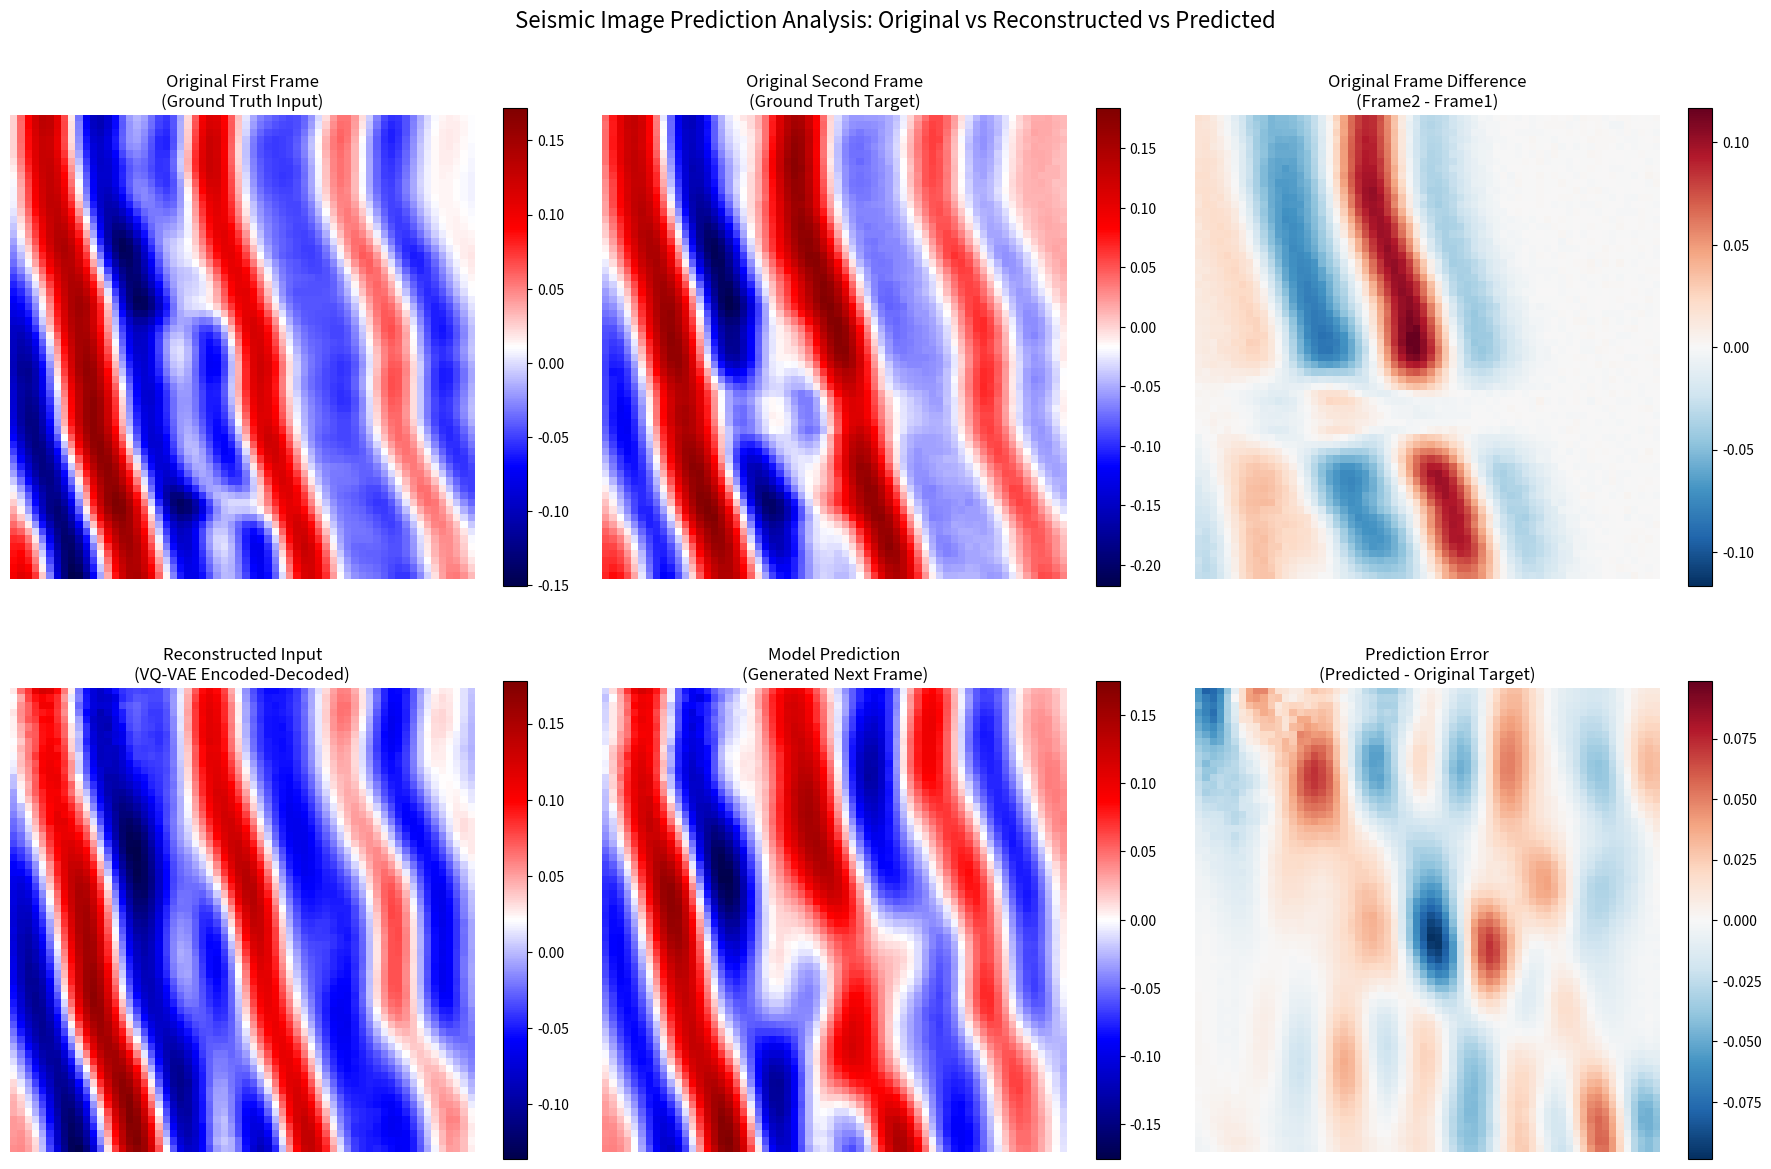

In [30]:
#@title reconstruct image from generated sequence
def reconstruct_images_from_generated_sequence(
    generated_sequence,
    vqvae_model,
    seismic_world_model,
    device,
    return_both_frames=True
):
    """
    将生成的token序列重建为图片

    Args:
        generated_sequence: [1, seq_len] 生成的token序列
        vqvae_model: 训练好的VQ-VAE模型
        seismic_world_model: SeismicWorld模型 (用于获取token偏移量)
        device: 设备
        return_both_frames: 是否返回两帧图片，否则只返回生成的第二帧

    Returns:
        reconstructed_images: 重建的图片 tensor
    """
    vqvae_model.eval()

    with torch.no_grad():
        # 1. 移除 BOS token 和可能的 EOS/PAD tokens
        sequence = generated_sequence.squeeze(0)  # [seq_len]

        # 找到有效的frame tokens (排除特殊tokens)
        frame_mask = (sequence >= seismic_world_model.frame_token_offset) & \
                    (sequence < seismic_world_model.special_token_offset)

        frame_tokens = sequence[frame_mask]
        print(f"Valid frame tokens: {len(frame_tokens)}")

        # 2. 移除token偏移量，恢复原始VQ-VAE indices
        frame_indices = frame_tokens - seismic_world_model.frame_token_offset

        # 3. 根据每帧64个tokens分割序列
        tokens_per_frame = seismic_world_model.num_frame_tokens_per_step  # 64

        if len(frame_indices) < tokens_per_frame:
            print(f"Warning: Not enough tokens for a complete frame. Got {len(frame_indices)}, expected {tokens_per_frame}")
            # 用0填充不足的tokens
            padding_needed = tokens_per_frame - len(frame_indices)
            padding = torch.zeros(padding_needed, dtype=frame_indices.dtype, device=device)
            frame_indices = torch.cat([frame_indices, padding])

        reconstructed_frames = []

        # 4. 处理每一帧
        num_complete_frames = len(frame_indices) // tokens_per_frame
        print(f"Number of complete frames to reconstruct: {num_complete_frames}")

        for frame_idx in range(num_complete_frames):
            start_idx = frame_idx * tokens_per_frame
            end_idx = start_idx + tokens_per_frame

            # 获取当前帧的indices
            current_frame_indices = frame_indices[start_idx:end_idx]

            # 5. 重塑为空间维度 [1, 1, 8, 8] (假设是8x8的spatial tokens)
            spatial_size = int(math.sqrt(tokens_per_frame))  # 8
            current_frame_indices = current_frame_indices.view(1, 1, spatial_size, spatial_size)

            print(f"Frame {frame_idx} indices shape: {current_frame_indices.shape}")

            # 6. 使用VQ-VAE解码
            try:
                reconstructed_frame = vqvae_model.decode_from_indices(
                    current_frame_indices,
                    video_contains_first_frame=True
                )

                print(f"Frame {frame_idx} reconstructed shape: {reconstructed_frame.shape}")
                reconstructed_frames.append(reconstructed_frame)

            except Exception as e:
                print(f"Error reconstructing frame {frame_idx}: {e}")
                # 创建一个零填充的帧作为fallback
                fallback_frame = torch.zeros(1, 1, 64, 64, device=device)
                reconstructed_frames.append(fallback_frame)

        if not reconstructed_frames:
            print("No frames could be reconstructed!")
            return None

        # 7. 组合所有帧
        if return_both_frames and len(reconstructed_frames) >= 2:
            # 返回两帧 [1, 2, 64, 64]
            combined_frames = torch.cat(reconstructed_frames[:2], dim=1)
        elif len(reconstructed_frames) >= 1:
            # 只返回第一帧（或生成的帧）
            combined_frames = reconstructed_frames[-1]  # 取最后生成的帧
        else:
            return None

        return combined_frames


# Generation example: Given first frame, predict next frame
print("=== Frame-to-Frame Generation Example ===")

index = 666 #@param {type:"integer"}
# Method 1: Using a sample from your seismic data
if 'seismic_data_video' in locals():
    # Take the first frame from your seismic data
    sample_first_frame = seismic_data_video[index:index+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video[index:index+1, 1:2, :, :]  # [1, 1, 64, 64]
    print(f"Using sample from seismic_data_video: {sample_first_frame.shape}")
else:
    print(f"seismic_data_video DOES NOT EXIST!")

# Encode the first frame using VQ-VAE
print("Encoding first frame to tokens...")
vqvae_model.eval()
with torch.no_grad():
    # Encode first frame: [1, 1, 64, 64] -> [1, 1, 8, 8]
    first_frame_indices = vqvae_model.encode_to_indices(sample_first_frame.to(DEVICE))
    second_frame_indices = vqvae_model.encode_to_indices(sample_second_frame.to(DEVICE))
    print(f"First frame indices shape: {first_frame_indices.shape}")
    print(f"Second frame indices shape: {second_frame_indices.shape}")

    # Flatten spatial dimensions: [1, 1, 8, 8] -> [1, 64]
    first_frame_tokens = first_frame_indices.view(1, -1)
    second_frame_tokens = second_frame_indices.view(1, -1)
    print(f"First frame tokens shape: {first_frame_tokens.shape}")
    print(f"Second frame tokens shape: {second_frame_tokens.shape}")

    # Add frame token offset
    first_frame_tokens_offset = first_frame_tokens + loaded_model.frame_token_offset
    second_frame_tokens_offset = second_frame_tokens + loaded_model.frame_token_offset

# Create input sequence: BOS + first_frame_tokens
bos_token = torch.tensor([[loaded_model.bos_token_id]], device=DEVICE)
input_sequence = torch.cat([bos_token, first_frame_tokens_offset], dim=1)
target_sequence = torch.cat([bos_token, second_frame_tokens_offset], dim=1) # add bos_token?
print(f"Input sequence shape (BOS + first frame): {input_sequence.shape}")
print(f"Target sequence shape (BOS + second frame): {target_sequence.shape}")

# Generate the next frame tokens
print("Generating next frame...")
generated_sequence = loaded_model.generate(
    input_ids=input_sequence,
    max_new_tokens=65,  # 64 tokens for next frame + 1 EOS token = 65
    temperature=0.9,
    top_k=50,
    eos_token_id=loaded_model.eos_token_id
)


print(f"Generated sequence shape: {generated_sequence.shape}")
print(f"Original input length: {input_sequence.shape[1]}")
print(f"Generated tokens: {generated_sequence.shape[1] - input_sequence.shape[1]}")

# 使用示例 - 重构第一张图（前65个token）
reconstructed_images_1 = reconstruct_images_from_generated_sequence(
    generated_sequence=generated_sequence[:,0:65],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

# 使用示例 - 重构第二张图（后64个token）
reconstructed_images_2 = reconstruct_images_from_generated_sequence(
    generated_sequence=generated_sequence[:,-65:],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

reconstructed_images_3 = reconstruct_images_from_generated_sequence(
    generated_sequence=target_sequence,
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)
# 定义图像处理函数
def process_image_for_display(img_tensor):
    """将tensor转换为可显示的numpy数组"""
    if img_tensor.dim() == 4:  # [1, C, H, W]
        return img_tensor.squeeze(0).squeeze(0).cpu().numpy()
    elif img_tensor.dim() == 5:  # [1, C, T, H, W]
        return img_tensor.squeeze(0).squeeze(0).squeeze(0).cpu().numpy()
    else:
        return img_tensor.cpu().numpy()

save = False #@param {type:"boolean"}

if (reconstructed_images_1 is not None and
    reconstructed_images_2 is not None and
    reconstructed_images_3 is not None):

    print(f"Input image shape: {reconstructed_images_1.shape}")
    print(f"Prediction image shape: {reconstructed_images_2.shape}")
    print(f"Target image shape: {reconstructed_images_3.shape}")

    # 处理图像
    img_input = process_image_for_display(reconstructed_images_1)      # 输入
    img_prediction = process_image_for_display(reconstructed_images_2) # 预测
    img_target = process_image_for_display(reconstructed_images_3)     # 标签
    img_diff = img_prediction - img_target                             # 预测与标签的差异

    # 处理原图
    img_original_first = process_image_for_display(sample_first_frame)   # 原始第一帧
    img_original_second = process_image_for_display(sample_second_frame) # 原始第二帧
    img_original_diff = img_original_second - img_original_first         # 原图差值

    # 创建2x3的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 第一行：原图对比
    # 子图1：原始第一帧
    im1 = axes[0,0].imshow(img_original_first, cmap='seismic')
    axes[0,0].set_title('Original First Frame\n(Ground Truth Input)', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

    # 子图2：原始第二帧
    im2 = axes[0,1].imshow(img_original_second, cmap='seismic')
    axes[0,1].set_title('Original Second Frame\n(Ground Truth Target)', fontsize=12, fontweight='bold')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

    # 子图3：原图差值
    original_diff_max = np.abs(img_original_diff).max()
    im3 = axes[0,2].imshow(img_original_diff, cmap='RdBu_r', vmin=-original_diff_max, vmax=original_diff_max)
    axes[0,2].set_title('Original Frame Difference\n(Frame2 - Frame1)', fontsize=12, fontweight='bold')
    axes[0,2].axis('off')
    plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

    # 第二行：重建图对比
    # 子图4：重建输入图像
    im4 = axes[1,0].imshow(img_input, cmap='seismic')
    axes[1,0].set_title('Reconstructed Input\n(VQ-VAE Encoded-Decoded)', fontsize=12, fontweight='bold')
    axes[1,0].axis('off')
    plt.colorbar(im4, ax=axes[1,0], shrink=0.8)

    # 子图5：预测图像
    im5 = axes[1,1].imshow(img_prediction, cmap='seismic')
    axes[1,1].set_title('Model Prediction\n(Generated Next Frame)', fontsize=12, fontweight='bold')
    axes[1,1].axis('off')
    plt.colorbar(im5, ax=axes[1,1], shrink=0.8)

    # 子图6：预测误差
    pred_diff_max = np.abs(img_diff).max()
    im6 = axes[1,2].imshow(img_diff, cmap='RdBu_r', vmin=-pred_diff_max, vmax=pred_diff_max)
    axes[1,2].set_title('Prediction Error\n(Predicted - Original Target)', fontsize=12, fontweight='bold')
    axes[1,2].axis('off')
    plt.colorbar(im6, ax=axes[1,2], shrink=0.8)

    # 调整子图间距
    plt.tight_layout()

    # 添加总标题
    fig.suptitle('Seismic Image Prediction Analysis: Original vs Reconstructed vs Predicted',
                 fontsize=16, fontweight='bold', y=1.02)

    # 显示详细统计信息
    print("="*80)
    print("COMPREHENSIVE PREDICTION ANALYSIS STATISTICS")
    print("="*80)

    print(f"Original First Frame Stats:")
    print(f"  Shape: {img_original_first.shape}")
    print(f"  Range: [{img_original_first.min():.4f}, {img_original_first.max():.4f}]")
    print(f"  Mean: {img_original_first.mean():.4f}, Std: {img_original_first.std():.4f}")

    print(f"\nOriginal Second Frame Stats:")
    print(f"  Shape: {img_original_second.shape}")
    print(f"  Range: [{img_original_second.min():.4f}, {img_original_second.max():.4f}]")
    print(f"  Mean: {img_original_second.mean():.4f}, Std: {img_original_second.std():.4f}")

    print(f"\nReconstructed Input Image Stats:")
    print(f"  Shape: {img_input.shape}")
    print(f"  Range: [{img_input.min():.4f}, {img_input.max():.4f}]")
    print(f"  Mean: {img_input.mean():.4f}, Std: {img_input.std():.4f}")

    print(f"\nPredicted Image Stats:")
    print(f"  Shape: {img_prediction.shape}")
    print(f"  Range: [{img_prediction.min():.4f}, {img_prediction.max():.4f}]")
    print(f"  Mean: {img_prediction.mean():.4f}, Std: {img_prediction.std():.4f}")

    print(f"\nOriginal Frame Difference Stats:")
    print(f"  Range: [{img_original_diff.min():.4f}, {img_original_diff.max():.4f}]")
    print(f"  Mean: {img_original_diff.mean():.4f}, Std: {img_original_diff.std():.4f}")
    print(f"  Mean Absolute Difference: {np.abs(img_original_diff).mean():.4f}")

    print(f"\nPrediction Error Stats (vs Original Target):")
    print(f"  Range: [{img_diff.min():.4f}, {img_diff.max():.4f}]")
    print(f"  Mean: {img_diff.mean():.4f}, Std: {img_diff.std():.4f}")
    print(f"  Mean Absolute Error (MAE): {np.abs(img_diff).mean():.4f}")
    print(f"  Root Mean Square Error (RMSE): {np.sqrt(np.mean(img_diff**2)):.4f}")

    # VQ-VAE重建质量评估
    input_reconstruction_error = img_input - img_original_first
    print(f"\nVQ-VAE Reconstruction Quality (Input):")
    print(f"  Reconstruction MAE: {np.abs(input_reconstruction_error).mean():.4f}")
    print(f"  Reconstruction RMSE: {np.sqrt(np.mean(input_reconstruction_error**2)):.4f}")

    # 相似性指标
    correlation_pred_orig = np.corrcoef(img_prediction.flatten(), img_original_second.flatten())[0,1]
    correlation_pred_target = np.corrcoef(img_prediction.flatten(), img_target.flatten())[0,1]
    correlation_orig_frames = np.corrcoef(img_original_first.flatten(), img_original_second.flatten())[0,1]

    print(f"\nCorrelation Analysis:")
    print(f"  Prediction vs Original Target: {correlation_pred_orig:.4f}")
    print(f"  Prediction vs Reconstructed Target: {correlation_pred_target:.4f}")
    print(f"  Original Frame1 vs Frame2: {correlation_orig_frames:.4f}")

    # 结构相似性指标 (简化版)
    def simple_ssim(img1, img2):
        mu1, mu2 = img1.mean(), img2.mean()
        sigma1, sigma2 = img1.std(), img2.std()
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))

        c1, c2 = 0.01**2, 0.03**2
        ssim = ((2*mu1*mu2 + c1) * (2*sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        return ssim

    ssim_pred_orig = simple_ssim(img_prediction, img_original_second)
    ssim_input_orig = simple_ssim(img_input, img_original_first)

    print(f"\nStructural Similarity (SSIM):")
    print(f"  Prediction vs Original Target: {ssim_pred_orig:.4f}")
    print(f"  VQ-VAE Input Reconstruction: {ssim_input_orig:.4f}")

    print("="*80)

    if save:
      # 保存图片为PDF格式
      plt.savefig(f_path+f'/SW地震预测展示图{index}.pdf',
                  format='pdf',           # 指定PDF格式
                  dpi=300,               # 设置分辨率
                  bbox_inches='tight',   # 紧凑布局，去除多余空白
                  facecolor='white',     # 背景色为白色
                  edgecolor='none',      # 无边框
                  transparent=False)     # 非透明背景
      print(f'已经成功保存到{f_path}/SW地震预测展示图{index}.pdf')
    plt.show()

else:
    print("Error: One or more reconstructed images is None")
    if reconstructed_images_1 is None:
        print("- Input image reconstruction failed")
    if reconstructed_images_2 is None:
        print("- Prediction image reconstruction failed")
    if reconstructed_images_3 is None:
        print("- Target image reconstruction failed")





In [ ]:
#@title END-2-END train
# ================================================================================
# --- Configuration ---
# ================================================================================
# --- Training Hyperparameters ---
NUM_EPOCHS = 20
BATCH_SIZE = 9  # Adjust based on GPU memory
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
SAVE_DIR = f_path+"/seismic_world_checkpoints" # Directory to save checkpoints
SAVE_EVERY_N_EPOCHS = 50
SAVE_BEST_MODEL = True
MAX_CHECKPOINTS_TO_KEEP = 2 # Keep the latest N checkpoints + best_model.pt

# --- Model Workflow Parameters ---
# These MUST match the time dimension of your data (T_full = 1 + N + M)
# Your data has T_full = 9. Let's set N=4, M=4, so 1+4+4 = 9.
NUM_PREDICT_FRAMES_INTERNLM = 4 # N: Number of difference frames predicted by InternLM
NUM_PREDICT_FRAMES_LDM = 4    # M: Number of *additional* difference frames predicted by LDM
TOTAL_PREDICT_FRAMES = NUM_PREDICT_FRAMES_INTERNLM + NUM_PREDICT_FRAMES_LDM
SEQUENCE_LENGTH = 1 + TOTAL_PREDICT_FRAMES # Total length needed per sample (A_0 to A_{N+M})

# --- Data Dimensions (deduced from seismic_data shape [20, 9, 64, 64, 64]) ---
INPUT_C = 1    # Assuming single channel input if not specified
INPUT_X = 64
INPUT_Y = 64
INPUT_Z = 64
# Latent dimensions - MUST be consistent across modules
LATENT_DIM = 512
LATENT_H = 16 # Assuming AEs preserve H, W. Adjust if your AEs change spatial dims.
LATENT_W = 16

# --- Sub-module Configurations (Ensure consistency) ---
pre_ae_1_config = {
    'input_channels': INPUT_C,
    'z_dim': INPUT_Z,
    'latent_dim': LATENT_DIM
}
# Ensure fsq_levels length matches LATENT_DIM
pre_ae_2_fsq_levels = [8] * LATENT_DIM # Example FSQ levels
pre_ae_2_config = {
    'input_channels': INPUT_C,
    'z_dim': INPUT_Z,
    'latent_dim': LATENT_DIM,
    'fsq_levels': pre_ae_2_fsq_levels
}
internlm_config = {
    # Specify InternLM architecture details if not loading pretrained
    # If loading pretrained, these might be inferred, but good to define
    'hidden_size': 4096,
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    # 'pretrained_model_path': '/path/to/your/internlm/weights' # Optional: Path to pretrained InternLM weights
}
ldm_config = {
    'image_size': LATENT_H, # LDM operates on latent space spatial dimensions
    'latent_channels': LATENT_DIM,
    'frame_num': NUM_PREDICT_FRAMES_INTERNLM, # LDM input is InternLM's output sequence length
    'act_embedding_num': NUM_PREDICT_FRAMES_INTERNLM - 1 # Often related to frame_num
}
# --- Loss Weights ---
lambda_main_loss = 1.0
lambda_internlm_loss = 0.1
lambda_ldm_latent_loss = 0.1
lambda_pre_ae_1_recon_loss = 0.01 # Optional: Encourage good AE reconstruction
lambda_pre_ae_2_recon_loss = 0.01 # Optional: Encourage good AE reconstruction

# ================================================================================
# --- Device Setup ---
# ================================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================================================================
# --- Data Loading ---
# ================================================================================
seismic_data = seismic_data[:-2]

if seismic_data is None:
    raise ValueError("Please define the 'seismic_data' tensor before proceeding.")

if seismic_data.shape[1] != SEQUENCE_LENGTH:
     raise ValueError(
         f"The time dimension of your seismic_data ({seismic_data.shape[1]}) "
         f"does not match the required SEQUENCE_LENGTH ({SEQUENCE_LENGTH} = 1 + N + M). "
         f"Adjust NUM_PREDICT_FRAMES_INTERNLM (N) and NUM_PREDICT_FRAMES_LDM (M) accordingly."
     )

# Create Dataset and DataLoader
print("Creating Seismic Dataset...")
dataset = SeismicDataset(data=seismic_data, sequence_length=SEQUENCE_LENGTH)
print("Creating DataLoader...")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) # Adjust num_workers as needed
print(f"Dataset size: {len(dataset)}, DataLoader steps per epoch: {len(dataloader)}")

# ================================================================================
# --- Model, Optimizer, Scheduler, Trainer Initialization ---
# ================================================================================
print("Initializing SeismicWorld model...")
model = SeismicWorld(
    pre_ae_1_config=pre_ae_1_config,
    pre_ae_2_config=pre_ae_2_config,
    internlm_config=internlm_config,
    ldm_config=ldm_config,
    num_predict_frames_internlm=NUM_PREDICT_FRAMES_INTERNLM,
    num_predict_frames_ldm=NUM_PREDICT_FRAMES_LDM,
    # Optional: Provide paths to load pretrained weights for sub-modules
    # pre_ae_1_ckpt=None,
    # pre_ae_2_ckpt=None,
    # internlm_ckpt=None, # Can be path to HF model or custom checkpoint
    # ldm_ckpt=None,
    lambda_main_loss=lambda_main_loss,
    lambda_internlm_loss=lambda_internlm_loss,
    lambda_ldm_latent_loss=lambda_ldm_latent_loss,
    lambda_pre_ae_1_recon_loss=lambda_pre_ae_1_recon_loss,
    lambda_pre_ae_2_recon_loss=lambda_pre_ae_2_recon_loss,
    model_name="SeismicWorldDiff",
    version="2.1"
)
model.to(device)
model.print_model_summary() # Print summary after initialization

print("Initializing Optimizer and Scheduler...")
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Example scheduler: Cosine Annealing
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(dataloader), eta_min=LEARNING_RATE * 0.1)

print("Initializing Trainer...")
trainer = SeismicWorldTrainer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    save_dir=SAVE_DIR,
    save_every_n_epochs=SAVE_EVERY_N_EPOCHS,
    save_best=SAVE_BEST_MODEL,
    max_checkpoints=MAX_CHECKPOINTS_TO_KEEP
)

# --- Optional: Resume from checkpoint ---
checkpoint_to_resume = SAVE_DIR+"/best_model.pt"
if os.path.exists(checkpoint_to_resume):
    print(f"Resuming training from {checkpoint_to_resume}")
    start_epoch = trainer.resume_from_checkpoint(checkpoint_to_resume)
else:
    start_epoch = 0
# start_epoch = model.training_metadata.get('epoch', 0) # Get epoch from model metadata if not resuming

# ================================================================================
# --- Training Loop ---
# ================================================================================
print(f"\nStarting training from epoch {start_epoch + 1}...")

for epoch in range(start_epoch + 1, NUM_EPOCHS + 1):
    model.train() # Set model to training mode
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)

    for step, batch_data in enumerate(progress_bar):
        # batch_data shape: [B, T_total, C, X, Y, Z]
        batch_data = batch_data.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        # The model's forward handles difference calculation and loss computation
        output_dict = model(batch_data)
        loss = output_dict['total_loss']

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update learning rate scheduler (if used)
        if scheduler:
            scheduler.step() # Step per iteration for CosineAnnealingLR

        # --- Logging ---
        current_loss = loss.item()
        epoch_loss += current_loss
        model.training_metadata['global_step'] += 1 # Increment global step

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{current_loss:.4f}",
            'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
        })

    # --- End of Epoch ---
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch}/{NUM_EPOCHS} finished. Average Loss: {avg_epoch_loss:.4f}")

    # --- Checkpointing ---
    # if epoch % SAVE_EVERY_N_EPOCHS == 10:
    #     print(f"Saving checkpoint for epoch {epoch}...")
    # Save checkpoint using the trainer
    additional_info = {'avg_epoch_loss': avg_epoch_loss}
    trainer.save_checkpoint(epoch=epoch, loss=avg_epoch_loss, additional_info=additional_info)

    # Update model's internal epoch tracker (already done by trainer.save_checkpoint)
    # model.training_metadata['epoch'] = epoch

# ================================================================================
# --- Post-Training ---
# ================================================================================
print("\nTraining finished.")

# Save the final model state explicitly -- save best model only
# final_save_path = os.path.join(SAVE_DIR, f"{model.config['model_name'].lower()}_final_epoch_{NUM_EPOCHS}.pt")
# final_checkpoint_data = {
#     'model_state_dict': model.state_dict(),
#     'config': model.config,
#     'training_metadata': model.training_metadata,
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
#     'timestamp': datetime.now().isoformat()
# }
# torch.save(final_checkpoint_data, final_save_path)
# print(f"Final model state saved to: {final_save_path}")

# Save final config
config_save_path = os.path.join(SAVE_DIR, f"{model.config['model_name'].lower()}_final_config.json")
model.save_config(config_save_path)

print("Training script complete.")

In [ ]:
#@title inference
import torch
import torch.nn as nn
import torch.nn.functional as F
# <<< ADDED IMPORTS >>>
from torch.utils.data import Dataset, DataLoader
# <<< END ADDED IMPORTS >>>
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any # Adjusted imports
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast


# --- Configuration (Should match your training setup) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- loading path ---
save_dir = os.path.join(f_path, "seismic_world_checkpoints")
subcheckpoint_dir = f_path+'/seismic_world_checkpoints/sub_modules'
pre_ae_checkpoint_path = os.path.join(subcheckpoint_dir, "pre_ae_20250608_143004.pt")
frame_ae_checkpoint_path = os.path.join(subcheckpoint_dir, "frame_ae_20250608_143004.pt")
internlm_checkpoint_path = os.path.join(subcheckpoint_dir, "internlm_20250608_143004.pt")
ldm_checkpoint_path = os.path.join(subcheckpoint_dir, "ldm_20250608_143004.pt")

# --- Frame configuration (Must match the trained model's config) ---
T_in = 1 # Number of input frames the model expects for prediction
T_out_pred = 4 # Number of frames the model was trained to predict (num_predict_frames_ldm)
T_internlm_pred = 3 # num_predict_frames_internlm
T_total = T_in + T_internlm_pred + T_out_pred # Total sequence length needed for dataset loading

# --- Find Checkpoint ---
# We'll try to load the 'best_model.pt' saved by the trainer
checkpoint_path = os.path.join(save_dir, "best_model.pt")
if not os.path.isfile(checkpoint_path):
    # If best_model.pt doesn't exist, try finding the latest checkpoint (more complex)
    # For simplicity, we'll just error out if best_model.pt is missing.
    # You might need a helper function to find the latest checkpoint based on filename timestamp.
    print(f"Error: Checkpoint 'best_model.pt' not found in {save_dir}")
    print("Ensure training completed and saved the best model, or specify a different checkpoint path.")
    # As an alternative, list files and let the user choose or pick the latest one:
    available_checkpoints = [f for f in os.listdir(save_dir) if f.endswith('.pt')]
    print("Available checkpoints:", available_checkpoints)
    exit()

# --- Load Model ---
print(f"\nLoading model from checkpoint: {checkpoint_path}")
try:
    # Use the class method to load the model structure and weights
    seismic_world_model, checkpoint_data = SeismicWorld.load_checkpoint(
        checkpoint_path=checkpoint_path,
        map_location=device,
    )
    seismic_world_model.to(device) # Ensure model is on the correct device
    seismic_world_model.eval() # Set the model to evaluation mode
    print("Model loaded successfully.")
    seismic_world_model.print_model_summary()

    # Verify loaded config matches expectations (optional)
    loaded_T_in = seismic_world_model.config.get('num_input_frames_pre_ae', -1)
    loaded_T_out = seismic_world_model.config.get('num_predict_frames_ldm', -1)
    if loaded_T_in != T_in or loaded_T_out != T_out_pred:
         print(f"\nWarning: Mismatch between current frame config and loaded model config.")
         print(f"  Current: T_in={T_in}, T_out_pred={T_out_pred}")
         print(f"  Loaded Model: T_in={loaded_T_in}, T_out_pred={loaded_T_out}")
         print(f"  Using loaded model's configuration for inference.")
         T_in = loaded_T_in
         T_out_pred = loaded_T_out

except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {checkpoint_path}")
    exit()
except KeyError as e:
    print(f"Error: Missing key in checkpoint data: {e}. Checkpoint might be corrupted or incompatible.")
    exit()
except Exception as e:
    print(f"An error occurred during model loading: {e}")
    import traceback
    traceback.print_exc()
    exit()


In [ ]:
#@title visualization of predictions & labels
label_index = 17
# --- Prepare Input Data for Inference ---
print("\nPreparing input data for inference...")
try:
    label = seismic_data[label_index:label_index+1]
    # Use the same SeismicDataset as in training to get a sample sequence
    inference_dataset = SeismicDataset(data=label, sequence_length=T_total)

    # Get the first sample sequence from the dataset
    # The dataset returns [T_total, C, X, Y, Z]
    sample_sequence = inference_dataset[0] # Get the first sequence
    print(f"Sample sequence shape from dataset: {sample_sequence.shape}") # Should be [T_total, C, X, Y, Z]

    # Extract the first T_in frames as input for the predict method
    # Shape required by predict: [B=1, T_in, C, X, Y, Z] or [B=1, T_in, X, Y, Z]
    input_data = sample_sequence[:T_in, ...] # Select first T_in frames -> [T_in, C, X, Y, Z]

    # Add the batch dimension (B=1)
    input_data = input_data.unsqueeze(0) # -> [1, T_in, C, X, Y, Z]

    # Move data to the model's device
    input_data = input_data.to(device)

    print(f"Input data shape for model.predict: {input_data.shape}") # Should be [1, T_in, C, X, Y, Z]

except IndexError:
     print("Error: Could not get a sample from the dataset. Is the dataset empty?")
     exit()
except Exception as e:
     print(f"Error preparing input data: {e}")
     exit()


# --- Perform Inference ---
print("\nPerforming inference...")
try:
    with torch.no_grad(): # Ensure gradients are not calculated
        prediction = seismic_world_model.predict(input_data)

    print("Inference completed.")
    # The prediction shape should be [B=1, T_out_pred, ...]
    # It will be [1, T_out_pred, C, X, Y, Z] or [1, T_out_pred, X, Y, Z]
    # depending on the original data dimension handling within the model.
    print(f"Prediction output shape: {prediction.shape}")

    # You can now use the 'prediction' tensor for visualization or further analysis
    # Example: Move prediction to CPU and convert to numpy
    prediction_np = prediction.cpu().squeeze(0).squeeze(1).numpy()
    print(f"Prediction converted to numpy array with shape: {prediction_np.shape}")

    # Optional: Save the prediction
    # np.save(os.path.join(save_dir, "inference_prediction.npy"), prediction_np)
    # print("Prediction saved to inference_prediction.npy")

except Exception as e:
    print(f"An error occurred during inference: {e}")
    import traceback
    traceback.print_exc()

print("\nInference script finished.")

t = 0
stats, fig = compare_4d_slices(prediction.squeeze(2)[:,0,...], prediction.squeeze(2)[:,6,...], dim=1, index=50)
plt.show()
print(stats)
stats, fig = compare_4d_slices(label[:,1,...], label[:,7,...], dim=1, index=50)
plt.show()
print(stats)

In [ ]:
#@title SeismicWorld Workflow
# ================================================================================
# --- 1）pre_ae ---
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from functools import reduce
import operator

def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return print(c)

class PhysicsDataset(Dataset):
    def __init__(self, seismic_data, channel_data, patch_size=None, transform=None):
        """
        初始化物理数据集

        参数:
            seismic_data: 形状为 (model_num, nt+1, 256, 256, 256) 的地震数据
            channel_data: 形状为 (model_num, nt+1, 256, 256, 256) 的河道标签数据
            patch_size: 可选，如果需要对数据进行分块，指定块大小 (px, py, pz)
            transform: 可选，数据增强转换
        """
        self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        self.channel_data = torch.tensor(channel_data, dtype=torch.float32)
        self.patch_size = patch_size
        self.transform = transform

        # 检查数据形状是否匹配
        assert seismic_data.shape == channel_data.shape, "地震数据和河道标签数据形状必须相同"

        self.model_num = seismic_data.shape[0]  # 模型数量
        self.nt = seismic_data.shape[1] - 1  # 每个模型的总时间步数减1

    def __len__(self):
        # 返回模型的数量
        return self.model_num

    def __getitem__(self, idx):
        """
        返回:
            inputs: 包含指定模型idx的前nt个时刻的地震数据和河道标签
            targets: 包含指定模型idx的第nt+1时刻的地震数据和河道标签
        """
        # 获取特定模型的数据
        model_seismic = self.seismic_data[idx]  # (nt+1, 256, 256, 256)
        model_channel = self.channel_data[idx]  # (nt+1, 256, 256, 256)

        # 输入: 前nt个时刻的地震数据和河道标签
        seismic_input = model_seismic[:self.nt]  # (nt, 256, 256, 256)
        channel_input = model_channel[:self.nt]  # (nt, 256, 256, 256)

        # 目标: 第nt+1时刻的地震数据和河道标签
        seismic_target = model_seismic[self.nt]  # (256, 256, 256)
        channel_target = model_channel[self.nt]  # (256, 256, 256)

        # 如果需要分块处理
        if self.patch_size is not None:
            seismic_input, channel_input, seismic_target, channel_target = self._create_patches(
                seismic_input, channel_input, seismic_target, channel_target
            )

        # 数据增强
        if self.transform:
            seismic_input, channel_input, seismic_target, channel_target = self.transform(
                seismic_input, channel_input, seismic_target, channel_target
            )

        inputs = {
            'seismic': seismic_input,
            'channel': channel_input
        }

        targets = {
            'seismic': seismic_target,
            'channel': channel_target
        }

        return inputs, targets

    def _create_patches(self, seismic_input, channel_input, seismic_target, channel_target):
        """
        将数据分割成小块以提高计算效率

        注意: 这个函数需要根据你的具体需求进行实现
        这里只是一个简单的示例，展示如何将3D数据分成不重叠的块
        """
        if self.patch_size is None:
            return seismic_input, channel_input, seismic_target, channel_target

        px, py, pz = self.patch_size

        # 这里简化处理，假设数据尺寸能被块大小整除
        # 实际应用中可能需要更复杂的处理（如填充）

        # 处理输入数据
        nt, nx, ny, nz = seismic_input.shape

        # 计算每个维度上的块数
        n_patches_x = nx // px
        n_patches_y = ny // py
        n_patches_z = nz // pz

        # 初始化存储块的列表
        seismic_input_patches = []
        channel_input_patches = []
        seismic_target_patches = []
        channel_target_patches = []

        # 分块处理
        for i in range(n_patches_x):
            for j in range(n_patches_y):
                for k in range(n_patches_z):
                    # 输入数据块
                    si_patch = seismic_input[:, i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]
                    ci_patch = channel_input[:, i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]

                    # 目标数据块
                    st_patch = seismic_target[i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]
                    ct_patch = channel_target[i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]

                    seismic_input_patches.append(si_patch)
                    channel_input_patches.append(ci_patch)
                    seismic_target_patches.append(st_patch)
                    channel_target_patches.append(ct_patch)

        # 将列表转换为张量
        seismic_input_patches = torch.stack(seismic_input_patches)
        channel_input_patches = torch.stack(channel_input_patches)
        seismic_target_patches = torch.stack(seismic_target_patches)
        channel_target_patches = torch.stack(channel_target_patches)

        return seismic_input_patches, channel_input_patches, seismic_target_patches, channel_target_patches

class ResidualBlock3D(nn.Module):
    """3D残差块，用于特征提取和信息流保持"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class ResidualBlock2D(nn.Module):
    """2D残差块，用于处理2D特征图"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class SeismicVolumeEncoder(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z=64) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim(64) -> z_dim/2(32) -> z_dim/4(16) -> z_dim/8(8)
        final_z_dim = z_dim // 8  # 64 // 8 = 8

        # 初始卷积层
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        )

        # 第一个下采样块
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        )
        self.res1 = ResidualBlock3D(64)

        # 第二个下采样块
        self.down2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        )
        self.res2 = ResidualBlock3D(128)

        # 第三个下采样块
        self.down3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        )
        self.res3 = ResidualBlock3D(256)

        # 最终Z维度减少
        self.final_conv = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
        )

        # 最终投影到潜在维度
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # 通过初始卷积层
        x0 = self.initial_conv(x)  # 保存初始特征

        # 第一个下采样块和残差块
        x1 = self.down1(x0)
        x1 = self.res1(x1)  # 保存第一层特征

        # 第二个下采样块和残差块
        x2 = self.down2(x1)
        x2 = self.res2(x2)  # 保存第二层特征

        # 第三个下采样块和残差块
        x3 = self.down3(x2)
        x3 = self.res3(x3)  # 保存第三层特征

        # 最终Z维度减少
        x4 = self.final_conv(x3)

        # At this point x4 should have shape (B, 512, 1, X, Y)
        x4_2d = x4.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        # Project to latent dimension
        latent = self.to_latent(x4_2d)  # (B, latent_dim, X, Y)
        # 返回潜在表示和中间特征，用于跳跃连接
        return latent, (x0, x1, x2, x3, x4)

class SeismicVolumeDecoder(nn.Module):
    def __init__(self, output_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # 从潜在维度的初始投影
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # 2D处理阶段
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512)

        # 上采样块1: Z=1 -> Z=8
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(8,3,3), stride=(8,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1)
        self.res1 = ResidualBlock3D(256)

        # 上采样块2: Z=8 -> Z=16
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.res2 = ResidualBlock3D(128)

        # 上采样块3: Z=16 -> Z=32
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.res3 = ResidualBlock3D(64)

        # 上采样块4: Z=32 -> Z=64
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.res4 = ResidualBlock3D(32)

        # 最终输出层
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, skip_features):
        '''
        x: [B,C,H,W] or [B,C,T,H,W]
        '''
        frame_num = x.shape[2] if x.ndim == 5 else 1

        volumes = []  # 用于收集每个时间步的volume
        if x.ndim==5:
            for frame in range(frame_num):
                # 获取当前帧的特征
                x_frame = x[:, :, frame, :, :]  # [B,C,H,W]
                x0, x1, x2, x3, x4 = skip_features[frame]

                x0 = x0.squeeze(1).to(x.device)
                x1 = x1.squeeze(1).to(x.device)
                x2 = x2.squeeze(1).to(x.device)
                x3 = x3.squeeze(1).to(x.device)
                x4 = x4.squeeze(1).to(x.device)

                # 从潜在维度投影
                curr_x = self.from_latent(x_frame)  # [B,512,H,W]

                # 2D处理
                curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
                curr_x = self.res_2d(curr_x)

                # 添加Z维度
                curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

                # 上采样块1 - Z=1到Z=8
                curr_x = self.relu1(self.bn1(self.up1(curr_x)))
                curr_x = torch.cat([curr_x, x3], dim=1)
                curr_x = self.conv1(curr_x)
                curr_x = self.res1(curr_x)

                # 上采样块2 - Z=8到Z=16
                curr_x = self.relu2(self.bn2(self.up2(curr_x)))
                curr_x = torch.cat([curr_x, x2], dim=1)
                curr_x = self.conv2(curr_x)
                curr_x = self.res2(curr_x)

                # 上采样块3 - Z=16到Z=32
                curr_x = self.relu3(self.bn3(self.up3(curr_x)))
                curr_x = torch.cat([curr_x, x1], dim=1)
                curr_x = self.conv3(curr_x)
                curr_x = self.res3(curr_x)

                # 上采样块4 - Z=32到Z=64
                curr_x = self.relu4(self.bn4(self.up4(curr_x)))
                curr_x = torch.cat([curr_x, x0], dim=1)
                curr_x = self.conv4(curr_x)
                curr_x = self.res4(curr_x)

                # 最终输出
                volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

                if volume.shape[1] == 1:
                    volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

                volumes.append(volume)
        elif x.ndim==4:
            # 获取当前帧的特征
            x_frame = x  # [B,C,H,W]
            x0, x1, x2, x3, x4 = skip_features

            x0 = x0.to(x.device)
            x1 = x1.to(x.device)
            x2 = x2.to(x.device)
            x3 = x3.to(x.device)
            x4 = x4.to(x.device)

            # 从潜在维度投影
            curr_x = self.from_latent(x_frame)  # [B,512,H,W]

            # 2D处理
            curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
            curr_x = self.res_2d(curr_x)

            # 添加Z维度
            curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

            # 上采样块1 - Z=1到Z=8
            curr_x = self.relu1(self.bn1(self.up1(curr_x)))
            curr_x = torch.cat([curr_x, x3], dim=1)
            curr_x = self.conv1(curr_x)
            curr_x = self.res1(curr_x)

            # 上采样块2 - Z=8到Z=16
            curr_x = self.relu2(self.bn2(self.up2(curr_x)))
            curr_x = torch.cat([curr_x, x2], dim=1)
            curr_x = self.conv2(curr_x)
            curr_x = self.res2(curr_x)

            # 上采样块3 - Z=16到Z=32
            curr_x = self.relu3(self.bn3(self.up3(curr_x)))
            curr_x = torch.cat([curr_x, x1], dim=1)
            curr_x = self.conv3(curr_x)
            curr_x = self.res3(curr_x)

            # 上采样块4 - Z=32到Z=64
            curr_x = self.relu4(self.bn4(self.up4(curr_x)))
            curr_x = torch.cat([curr_x, x0], dim=1)
            curr_x = self.conv4(curr_x)
            curr_x = self.res4(curr_x)

            # 最终输出
            volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

            if volume.shape[1] == 1:
                volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

            volumes.append(volume)

        # 将所有时间步的volume拼接起来
        output = torch.stack(volumes, dim=1)  # [B,T,X,Y,Z]
        return output

# model
class SeismicDimensionAutoencoder(nn.Module):
    """Complete U-Net style autoencoder for 3D seismic volumes with skip connections"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        self.encoder = SeismicVolumeEncoder(input_channels, z_dim, latent_dim)
        self.decoder = SeismicVolumeDecoder(input_channels, z_dim, latent_dim)

    def forward(self, x):
        # Process a batch of 3D volumes
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        original_shape = x.shape

        # 编码器返回潜在表示和中间特征
        latent, skip_features = self.encoder(x)
        # print(f'latent.shape:{latent.shape}')

        # 解码器使用潜在表示和跳跃连接
        reconstructed = self.decoder(latent, skip_features)
        # Ensure output matches input shape
        if len(original_shape) == 4 and len(reconstructed.shape) == 5:
            reconstructed = reconstructed.squeeze(1)  # Remove channel dimension
        elif len(original_shape) == 5 and len(reconstructed.shape) == 4:
            reconstructed = reconstructed.unsqueeze(1)  # Add channel dimension

        return reconstructed, latent


class SeismicDataProcessor:
    """Processes 3D seismic data for use with VideoWorld"""

    def __init__(self, autoencoder_path=None):
        self.autoencoder = SeismicDimensionAutoencoder()

        # Load pretrained weights if provided
        if autoencoder_path:
            self.autoencoder.load_state_dict(torch.load(autoencoder_path))

        # Set to evaluation mode
        self.autoencoder.eval()

    def encode_batch_for_videoworld(self, seismic_data):
        """
        Convert 3D seismic data to 2D representation for VideoWorld

        Args:
            seismic_data: Tensor of shape (B, nt, X, Y, Z)

        Returns:
            encoded_data: Tensor of shape (B, C, nt, H, W)
        """
        B, nt, X, Y, Z = seismic_data.shape

        # Process each time frame separately
        encoded_frames = []

        for t in range(nt):
            # Get current time frame for all batches
            frame_t = seismic_data[:, t]  # (B, X, Y, Z)

            # Encode to 2D latent space
            with torch.no_grad():
                _, latent = self.autoencoder(frame_t)  # (B, latent_dim, X, Y)

            encoded_frames.append(latent)

        # Stack along time dimension
        encoded_data = torch.stack(encoded_frames, dim=2)  # (B, latent_dim, nt, X, Y)

        return encoded_data

    def decode_from_videoworld(self, encoded_data):
        """
        Convert 2D representation back to 3D seismic data

        Args:
            encoded_data: Tensor of shape (B, C, nt, H, W)

        Returns:
            decoded_data: Tensor of shape (B, nt, X, Y, Z)
        """
        B, C, nt, H, W = encoded_data.shape

        # Process each time frame separately
        decoded_frames = []

        for t in range(nt):
            # Get current time frame for all batches
            frame_t = encoded_data[:, :, t]  # (B, C, H, W)

            # Decode back to 3D volume
            with torch.no_grad():
                volume = self.autoencoder.decoder(frame_t)  # (B, 1, X, Y, Z)

            # Remove channel dimension
            volume = volume.squeeze(1)  # (B, X, Y, Z)

            decoded_frames.append(volume)

        # Stack along time dimension
        decoded_data = torch.stack(decoded_frames, dim=1)  # (B, nt, X, Y, Z)

        return decoded_data

# Modified Dataset class to work with the processor
class ProcessedPhysicsDataset(Dataset):
    def __init__(self, seismic_data, channel_data, processor, transform=None):
        """
        Args:
            seismic_data: Time-lapsed seismic data with shape (B, nt+1, nx, ny, nz)
            channel_data: Time-lapsed channel data with shape (B, nt+1, nx, ny, nz)
            processor: SeismicDataProcessor instance
            transform: Optional transform to be applied on samples
        """
        self.seismic_data = seismic_data
        self.channel_data = channel_data
        self.processor = processor
        self.transform = transform
        self.num_samples = seismic_data.shape[0]
        self.nt = seismic_data.shape[1] - 1  # Last frame is target

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Input: first nt frames, Target: last frame
        seismic_input = torch.from_numpy(self.seismic_data[idx, :self.nt]).float()
        seismic_target = torch.from_numpy(self.seismic_data[idx, self.nt]).float()

        channel_input = torch.from_numpy(self.channel_data[idx, :self.nt]).float()
        channel_target = torch.from_numpy(self.channel_data[idx, self.nt]).float()

        # Encode 3D volumes to 2D representations
        seismic_input_encoded = self.processor.encode_batch_for_videoworld(seismic_input.unsqueeze(0)).squeeze(0)
        channel_input_encoded = self.processor.encode_batch_for_videoworld(channel_input.unsqueeze(0)).squeeze(0)

        sample = {
            'inputs': {
                'seismic': seismic_input_encoded,  # Now in (C, nt, H, W) format
                'channel': channel_input_encoded,  # Now in (C, nt, H, W) format
            },
            'targets': {
                'seismic': seismic_target,  # Original 3D format
                'channel': channel_target,  # Original 3D format
            },
            'original_inputs': {
                'seismic': seismic_input,  # Original 3D format
                'channel': channel_input,  # Original 3D format
            }
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

def train_dimension_autoencoder(seismic_data, epochs=50, batch_size=1, load_ckp=False):
    """Train the autoencoder to convert between 3D and 2D representations"""

    # Create simple dataset for autoencoder training
    class SimpleSeismicDataset(Dataset):
        def __init__(self, data):
            self.data = data #(B,T,X,Y,Z)

        def __len__(self):
            return self.data.shape[0] * self.data.shape[1]

        def __getitem__(self, idx):
            # Convert idx to (batch_idx, time_idx)
            batch_idx = idx // self.data.shape[1]
            time_idx = idx % self.data.shape[1]

            # Get the volume
            volume = self.data[batch_idx, time_idx]
            return torch.from_numpy(volume).float()

    # Create dataset and dataloader
    dataset = SimpleSeismicDataset(seismic_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Create model
    model = SeismicDimensionAutoencoder(latent_dim=3)
    # Load the saved state dictionary
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if load_ckp:
      model.load_state_dict(torch.load(f_path+"/ckp/seismic_pre_autoencoder.pt", map_location=device))

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move to device
            batch = batch.to(device) # torch.Size([1, 256, 256, 256])
            # print(f'batch.shape={batch.shape}')

            # Forward pass
            optimizer.zero_grad()
            reconstructed, _ = model(batch) # torch.Size([1, 4096, 256, 256])
            # print(f'reconstructed.shape={reconstructed.shape}')

            # Calculate loss
            loss = criterion(reconstructed, batch) #

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

        # # Save checkpoint
        # if (epoch + 1) % 10 == 0:
        #     torch.save(model.state_dict(), f"seismic_autoencoder_epoch_{epoch+1}.pt")

    # Save final model
    torch.save(model.state_dict(), f_path+"/ckp_u_pre_ae/seismic_pre_autoencoder.pt")

    return model

# ===================================================================================================================
# --- 2）Latent Dynamics Model ---
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch import nn, einsum, Tensor
from torch.nn import Module, ModuleList
from typing import  Union, Tuple, Optional, List
from kornia.filters import filter3d
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import sys
# 添加父目录路径
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

# tensor helpers

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

# FSQ是一种标量量化方法，将连续值离散化为有限的级别
class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# 数据预处理器
class SeismicDataProcessor:
    def __init__(self, autoencoder_model, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.autoencoder = autoencoder_model.to(self.device)
        # 在训练模式下不要设置为eval模式
        # self.autoencoder.eval()  # 移除这一行

    def to(self, device):
        """Moves the internal autoencoder model to the specified device."""
        self.device = device # Update the processor's device attribute
        self.autoencoder = self.autoencoder.to(self.device)
        return self # Return self to allow chaining like nn.Module.to

    def encode_to_2d(self, volume_3d):
        """将3D体转换为2D latent表示，同时保存skip features"""
        # 在训练时需要梯度，移除no_grad上下文
        if not isinstance(volume_3d, torch.Tensor):
            volume_3d = torch.tensor(volume_3d, dtype=torch.float32)
        volume_3d = volume_3d.to(self.device)
        latent, skip_features = self.autoencoder.encoder(volume_3d)
        return latent, skip_features

    def decode_to_3d(self, latent_2d, skip_features):
        """使用保存的skip features将2D latent表示转换回3D体"""
        # 移除no_grad上下文，允许梯度传播
        latent_2d = latent_2d.to(self.device)
        volume_3d = self.autoencoder.decoder(latent_2d, skip_features)
        return volume_3d

class ProcessedPhysicsDataset_next_Optimized_NoPad_NonOverlap(Dataset):
    def __init__(self, seismic_data, gravity_data, magnetic_data, vp_data, processor, nt=4, device='cpu'):
        """
                    【隐空间-4D时移空间】
        Optimized Dataset for next sequence prediction. Processes data on-the-fly.
        Generates samples with NON-OVERLAPPING input time windows.

        Args:
            seismic_data (np.ndarray or torch.Tensor): Seismic data array of shape
                                                       (model_num, t_total, D, H, W)
                                                       or (model_num, t_total, H, W, C) etc.
                                                       Assumes time is the second dimension.
            gravity_data (np.ndarray or torch.Tensor): Gravity anomaly data of shape
                                                       (model_num, t_total, H, W)
            magnetic_data (np.ndarray or torch.Tensor): Magnetic anomaly data of shape
                                                       (model_num, t_total, H, W)
            vp_data (np.ndarray or torch.Tensor): Vp data array of shape
                                                  (model_num, t_total, D, H, W)
            processor: SeismicDataProcessor instance with an `encode_to_2d` method
                       and a `device` attribute.
            nt (int): Number of consecutive time steps in each input/output sample.
                      This also defines the step size between samples for non-overlap.
            device (str or torch.device): Device to perform encoding on.
                                          Should match the processor's device.
        """
        # Ensure seismic_data is a tensor. Convert only once.
        if not isinstance(seismic_data, torch.Tensor):
            self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
            self.seismic_data = seismic_data.float()

        # Gravity anomaly
        if not isinstance(gravity_data, torch.Tensor):
            self.gravity_data = torch.tensor(gravity_data, dtype=torch.float32)
        else:
            self.gravity_data = gravity_data.float()

        # Magnetic anomaly
        if not isinstance(magnetic_data, torch.Tensor):
            self.magnetic_data = torch.tensor(magnetic_data, dtype=torch.float32)
        else:
            self.magnetic_data = magnetic_data.float()

        # vp
        if not isinstance(vp_data, torch.Tensor):
            self.vp_data = torch.tensor(vp_data, dtype=torch.float32)
        else:
            self.vp_data = vp_data.float()

        self.processor = processor
        self.device = device
        if hasattr(processor, 'device') and processor.device != torch.device(device):
            print(f"Warning: Provided device '{device}' differs from processor's device '{processor.device}'. Using processor's device.")
            self.device = processor.device

        self.model_num = self.seismic_data.shape[0]
        self.t_total = self.seismic_data.shape[1] # Total time steps available
        self.nt = nt
        # NOTE: Stride is implicitly set to nt for non-overlapping windows

        # --- Index Pre-computation ---
        self.sample_indices = []
        print("Pre-computing sample indices for non-overlapping windows...")
        for model_idx in tqdm(range(self.model_num)):
            # Need at least 2*nt steps for one input and one target sequence
            last_possible_start_t = self.t_total - (2 * self.nt)
            if last_possible_start_t < 0:
                print(f"Warning: Model {model_idx} has t_total={self.t_total} < 2*nt={2*self.nt}. Skipping this model.")
                continue

            # Step by nt to ensure non-overlapping input windows
            for start_t in range(0, last_possible_start_t + 1, self.nt):
                self.sample_indices.append({'model_idx': model_idx, 'start_t': start_t})

        if not self.sample_indices:
            raise ValueError(f"Could not create any valid non-overlapping windows. Check t_total ({self.t_total}) and nt ({self.nt}).")

        print(f"Dataset created with {len(self.sample_indices)} total non-overlapping samples.")

    def __len__(self):
        """Returns the total number of samples across all models."""
        return len(self.sample_indices)

    def __getitem__(self, idx):
        """
        Retrieves, processes (encodes), and returns a single sample.
        """
        sample_info = self.sample_indices[idx]
        model_idx = sample_info['model_idx']
        start_t = sample_info['start_t']
        end_t = start_t + self.nt # End index for input slice (exclusive)

        # --- 1. Get Input Sequence: Seismic, Gravity, Magnetic, Vp ---
        seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t] # (nt, D, H, W)
        gravity_seq_raw = self.gravity_data[model_idx, start_t:end_t] # (nt, H, W)
        magnetic_seq_raw = self.magnetic_data[model_idx, start_t:end_t] # (nt, H, W)
        vp_seq_raw = self.vp_data[model_idx, start_t:end_t]  # (nt, D, H, W)

        # --- 2. Encode Input Sequence (Time step by time step) ---
        seismic_seq_latents = []
        seismic_seq_skips = []
        self.processor.to(self.device)
        for t in range(self.nt):
            input_step = seismic_seq_raw[t].unsqueeze(0).to(self.device)
            with torch.no_grad():
                # Assuming encode_to_2d returns (latent, skip_features)
                # Adjust if your processor returns something different
                seismic_latent, seismic_skip = self.processor.encode_to_2d(input_step)
            seismic_seq_latents.append(seismic_latent.detach())
            # Handle skips carefully (might be single tensor, list/tuple, or None)
            if isinstance(seismic_skip, torch.Tensor):
                seismic_seq_skips.append(seismic_skip.detach())
            elif isinstance(seismic_skip, (list, tuple)):
                # Assuming skips are tensors within the list/tuple
                seismic_seq_skips.append([s.detach() for s in seismic_skip if isinstance(s, torch.Tensor)])
            # Add handling for other types or None if necessary

        seismic_seq_latents = torch.cat(seismic_seq_latents, dim=0) # Shape: (nt, latent_channels, H', W')

        # --- Process skip features ---
        # This part depends heavily on how skips are structured and used later.
        # If skips from different time steps need to be stacked/concatenated:
        final_skips = None # Placeholder - adjust based on skip structure
        if seismic_seq_skips:
             # Example: If skips are lists of tensors from U-Net layers
             if isinstance(seismic_seq_skips[0], list):
                 num_skip_levels = len(seismic_seq_skips[0])
                 final_skips = []
                 for level in range(num_skip_levels):
                     # Stack skips from the same level across time
                     level_skips = torch.stack([skips_at_t[level] for skips_at_t in seismic_seq_skips], dim=1) # Shape: (B=1, T=nt, C, H, W)
                     final_skips.append(level_skips.squeeze(0)) # Remove batch dim -> (nt, C, H, W)
             # Example: If skips are single tensors per time step
             elif all(isinstance(s, torch.Tensor) for s in seismic_seq_skips):
                  try:
                      # Stack skips across time
                      final_skips = torch.stack(seismic_seq_skips, dim=1) # Shape: (B=1, T=nt, C, H, W)
                      final_skips = final_skips.squeeze(0) # Remove batch dim -> (nt, C, H, W)
                  except Exception as e:
                      print(f"Could not stack skip features: {e}")
                      # Handle error or set final_skips differently
                      final_skips = None # Or maybe keep the list: seismic_seq_skips
             else:
                 # Fallback or specific handling if skips are mixed types or structured differently
                 print("Warning: Skip features have an unexpected structure.")
                 final_skips = seismic_seq_skips # Keep as list of lists/tensors?


        # --- 3. Get Target Sequence: Seismic, Gravity, Magnetic ---
        target_start_t = start_t + self.nt
        target_end_t = target_start_t + self.nt

        # --- Padding Logic (remains the same) ---
        # Seismic target (3D)
        if target_start_t >= self.t_total:
            last_step = self.seismic_data[model_idx, -1].unsqueeze(0)
            seismic_target = last_step.repeat(self.nt, 1, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            seismic_target_available = self.seismic_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = seismic_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_step = self.seismic_data[model_idx, -1].unsqueeze(0)
                padding = last_step.repeat(padding_steps, 1, 1, 1)
                seismic_target = torch.cat([seismic_target_available, padding], dim=0)
            else:
                seismic_target = seismic_target_available

        # Gravity anomaly target (2D)
        if target_start_t >= self.t_total:
            last_grav = self.gravity_data[model_idx, -1].unsqueeze(0)
            gravity_target = last_grav.repeat(self.nt, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            gravity_target_available = self.gravity_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = gravity_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_grav = self.gravity_data[model_idx, -1].unsqueeze(0)
                padding = last_grav.repeat(padding_steps, 1, 1)
                gravity_target = torch.cat([gravity_target_available, padding], dim=0)
            else:
                gravity_target = gravity_target_available

        # Magnetic anomaly target (2D)
        if target_start_t >= self.t_total:
            last_mag = self.magnetic_data[model_idx, -1].unsqueeze(0)
            magnetic_target = last_mag.repeat(self.nt, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            magnetic_target_available = self.magnetic_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = magnetic_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_mag = self.magnetic_data[model_idx, -1].unsqueeze(0)
                padding = last_mag.repeat(padding_steps, 1, 1)
                magnetic_target = torch.cat([magnetic_target_available, padding], dim=0)
            else:
                magnetic_target = magnetic_target_available
        # VP (3D)
        if target_start_t >= self.t_total:
            last_vp = self.vp_data[model_idx, -1].unsqueeze(0)
            vp_target = last_vp.repeat(self.nt, 1, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            vp_target_available = self.vp_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = vp_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_vp = self.vp_data[model_idx, -1].unsqueeze(0)
                padding = last_vp.repeat(padding_steps, 1, 1, 1)
                vp_target = torch.cat([vp_target_available, padding], dim=0)
            else:
                vp_target = vp_target_available

        # --- 4. Construct Output Dictionary ---
        sample = {
            'inputs': {
                'seismic': {
                    'latent': seismic_seq_latents,      # (nt, latent_C, H', W')
                    'skip_features': final_skips        # Structure depends on processing above
                },
                'gravity_anomoly': gravity_seq_raw,   # (nt, H, W)
                'magnetic_anomoly': magnetic_seq_raw,  # (nt, H, W)
                'vp': vp_seq_raw                     # (nt, D, H, W)
            },
            'targets': {
                'seismic': seismic_target,                # (nt, D, H, W)
                'gravity_anomoly': gravity_target,        # (nt, H, W)
                'magnetic_anomoly': magnetic_target,       # (nt, H, W)
                'vp': vp_target                         # (nt, D, H, W)
            },
            'metadata': {
                'model_idx': model_idx,
                'start_t': start_t,
                'end_t': end_t,
                'target_start_t': target_start_t,
                'target_end_t': target_end_t
            }
        }

        return sample

# 改进的VideoWorld模型
class VideoWorldPhysicsModel(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=512, frame_num=4,act_embedding_num=2):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[5024] * 6,#[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        # print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        # print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        # print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        # print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

# ===================================================================================================================
# --- 构建时移数据集 (Using Non-Overlapping Dataset) ---

import torch
import numpy as np
import random
from torch.utils.data import DataLoader # Make sure DataLoader is imported

# 设置所有随机种子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Assume these variables are pre-loaded ---
# f_path = "your/path" # Path to your checkpoint
# seismic_data_total = torch.randn(20, 50, 1, 64, 64) # Example: (model_num, t_total, D, H, W)
# gravity_data_total = torch.randn(20, 50, 64, 64)    # Example: (model_num, t_total, H, W)
# magnetic_data_total = torch.randn(20, 50, 64, 64)   # Example: (model_num, t_total, H, W)
# vp_data_total = torch.randn(20, 50, 1, 64, 64)      # Example: (model_num, t_total, D, H, W)
# --- End Assume ---

# 加载预训练的autoencoder
autoencoder = SeismicDimensionAutoencoder(latent_dim=3)
autoencoder.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_64.pt", map_location=device))

# 创建数据处理器 pre_ae
processor = SeismicDataProcessor(autoencoder, device)

# 定义参数
H_plus_1 = 4 # This is 'nt' in the Dataset class
T = 10 # This seems unused here, t_total comes from data shape

# 创建数据集: Use the new class, stride is implicitly nt=H_plus_1
# No stride argument needed here.
dataset = ProcessedPhysicsDataset_next_Optimized_NoPad_NonOverlap(
    seismic_data=seismic_data_total,
    gravity_data=gravity_data_total,
    magnetic_data=magnetic_data_total,
    vp_data=vp_data_total,
    processor=processor,
    nt=H_plus_1,
    device=device
)


# Create the DataLoader directly from the new dataset
set_seed(42)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # Use 'dataset' directly

# 查看数据集大小
print(f"数据集大小 (non-overlapping samples): {len(dataset)}")

# 查看第一个批次
if len(dataloader) > 0:
    for batch in dataloader:
        print("\n--- First Batch Sample ---")
        print("Input Shapes:")
        if 'seismic' in batch['inputs']:
            print(f"  Seismic Latent: {batch['inputs']['seismic']['latent'].shape}")
            # Be careful accessing skips if they might be None or list
            skip_shape = "N/A or complex structure"
            if batch['inputs']['seismic']['skip_features'] is not None:
                 if isinstance(batch['inputs']['seismic']['skip_features'], torch.Tensor):
                     skip_shape = batch['inputs']['seismic']['skip_features'].shape
                 elif isinstance(batch['inputs']['seismic']['skip_features'], list) and batch['inputs']['seismic']['skip_features']:
                     skip_shape = f"List of {len(batch['inputs']['seismic']['skip_features'])} tensors, e.g., 1st: {batch['inputs']['seismic']['skip_features'][0].shape}"

            print(f"  Seismic Skips: {skip_shape}")
        if 'gravity_anomoly' in batch['inputs']:
             print(f"  Gravity Anomaly Raw: {batch['inputs']['gravity_anomoly'].shape}")
        if 'magnetic_anomoly' in batch['inputs']:
             print(f"  Magnetic Anomaly Raw: {batch['inputs']['magnetic_anomoly'].shape}")
        if 'vp' in batch['inputs']:
             print(f"  Vp Raw: {batch['inputs']['vp'].shape}")

        print("\nTarget Shapes:")
        if 'seismic' in batch['targets']:
             print(f"  Seismic Target: {batch['targets']['seismic'].shape}")
        if 'gravity_anomoly' in batch['targets']:
             print(f"  Gravity Target: {batch['targets']['gravity_anomoly'].shape}")
        if 'magnetic_anomoly' in batch['targets']:
             print(f"  Magnetic Target: {batch['targets']['magnetic_anomoly'].shape}")
        if 'vp' in batch['targets']:
             print(f"  Vp Target: {batch['targets']['vp'].shape}")

        print("\nMetadata:")
        print(f"  Model Index: {batch['metadata']['model_idx']}")
        print(f"  Start Time (t): {batch['metadata']['start_t']}")
        print(f"  End Time (t+nt): {batch['metadata']['end_t']}")
        print(f"  Target Start Time (t+nt): {batch['metadata']['target_start_t']}")
        print(f"  Target End Time (t+2*nt): {batch['metadata']['target_end_t']}")
        break
else:
    print("Dataloader is empty. Check dataset creation.")

# --- train LDM with Temporal Difference Loss (in Latent Space) ---

import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
# 假设 VideoWorldPhysicsModel, Processor, dataloader, H_plus_1, device 已经定义好
# from your_module import VideoWorldPhysicsModel, Processor # 确保导入模型定义

# --- 配置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
latent_channels = 3
# H_plus_1 = ... # 确保 H_plus_1 与保存模型时一致
act_embedding_num = H_plus_1 - 1 # 确保 act_embedding_num 与保存模型时一致
learning_rate = 1e-5 # 可以根据需要调整
start_epoch = 2 # 你之前训练到了第10个epoch，现在从第11个开始 (或者根据需要设定)
num_epochs = 8 # 总共希望训练到的epoch数
model_load_path = f_path + "/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch2.pt"
model_save_path_prefix = f_path + "/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch"

# --- Loss function weights ---
lambda_recon = 1.0      # 重建损失权重
lambda_latent = 1.0     # 潜在空间MSE损失权重
lambda_temporal = 0.5   # 时间差分损失权重

# --- 1. 重新实例化模型和优化器 ---
model = VideoWorldPhysicsModel(
    image_size=image_size,
    latent_channels=latent_channels,
    frame_num=H_plus_1,
    act_embedding_num=act_embedding_num
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# --- (同样需要处理 Autoencoder) ---
# autoencoder = ... # 重新加载或定义autoencoder
# autoencoder.eval()
# for param in autoencoder.parameters():
#     param.requires_grad = False
# processor = ... # 重新加载或定义processor

# --- 2. 加载模型状态字典 ---
print(f"Loading model state_dict from: {model_load_path}")
model.load_state_dict(torch.load(model_load_path, map_location=device))
print("Model state_dict loaded successfully.")

# --- （可选）如果你之前保存了优化器状态 ---
# optimizer_load_path = "path/to/your/optimizer_epoch10.pt"
# if os.path.exists(optimizer_load_path):
#     optimizer.load_state_dict(torch.load(optimizer_load_path, map_location=device))
#     print("Optimizer state_dict loaded successfully.")
# else:
#     print("Optimizer state_dict not found, starting optimizer from scratch.")

# --- Helper function to encode target sequence to latent space ---
def encode_target_to_latent(seismic_target, processor, device):
    """
    将目标序列编码到潜在空间
    Args:
        seismic_target: (B, T, D, H, W) - 目标地震数据序列
        processor: 数据处理器，包含encode_to_2d方法
        device: 设备
    Returns:
        target_latents: (B, latent_C, T, H', W') - 目标潜在表示序列
    """
    batch_size, time_steps = seismic_target.shape[0], seismic_target.shape[1]
    target_latents_list = []

    with torch.no_grad():
        processor.to(device)
        for t in range(time_steps):
            # 获取单个时间步的数据 (B, D, H, W)
            target_step_3d = seismic_target[:, t, :, :, :]

            # 根据processor的输入要求调整维度
            # 假设encode_to_2d需要 (B, C, D, H, W) 格式
            if target_step_3d.dim() == 4:  # (B, D, H, W)
                target_step_3d = target_step_3d.unsqueeze(1)  # (B, 1, D, H, W)

            # 编码到潜在空间，只取潜在表示，忽略skip features
            target_latent_step, _ = processor.encode_to_2d(target_step_3d)
            target_latents_list.append(target_latent_step)

    # 沿时间维度堆叠: (B, latent_C, T, H', W')
    target_latents = torch.stack(target_latents_list, dim=2)
    return target_latents

# --- 训练循环 ---
for epoch in range(start_epoch, num_epochs): # 从 start_epoch 开始
    # --- 4. 将模型设置为训练模式 ---
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_latent_loss = 0
    total_temporal_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        # 准备输入数据
        seismic_input = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']
        seismic_target = batch['targets']['seismic'].to(device)

        # 前向传播
        decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model(seismic_input)

        # === 1. 重建损失 (Reconstruction Loss) ===
        seismic_output_3d = processor.decode_to_3d(decoded, seismic_skip_features)
        recon_loss = F.mse_loss(seismic_output_3d, seismic_target)

        # === 2. 潜在空间MSE损失 (Latent Space MSE Loss) ===
        # 将目标序列编码到潜在空间
        target_latents = encode_target_to_latent(seismic_target, processor, device)
        latent_loss = F.mse_loss(decoded, target_latents)

        # === 3. 时间差分损失 (Temporal Difference Loss in Latent Space) ===
        temporal_loss = torch.tensor(0.0).to(device)

        if decoded.size(2) > 1:  # 确保有至少2个时间步
            # 计算预测潜在表示的时间差分
            # decoded shape: (B, latent_C, T, H', W')
            pred_temporal_diff = decoded[:, :, 1:, :, :] - decoded[:, :, :-1, :, :]

            # 计算目标潜在表示的时间差分
            target_temporal_diff = target_latents[:, :, 1:, :, :] - target_latents[:, :, :-1, :, :]

            # 计算时间差分损失
            temporal_loss = F.mse_loss(pred_temporal_diff, target_temporal_diff)

        # === 4. 组合损失 ===
        loss = (lambda_recon * recon_loss +
                lambda_latent * latent_loss +
                lambda_temporal * temporal_loss)

        # 反向传播
        loss.backward()
        optimizer.step()

        # 记录损失
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_latent_loss += latent_loss.item()
        total_temporal_loss += temporal_loss.item()

        # 打印详细损失信息（可选）
        if len(dataloader) <= 10 or (len(dataloader) > 10 and len(dataloader) % 10 == 0):
            print(f"Batch Loss: {loss:.6f} | Recon: {recon_loss:.6f} | Latent: {latent_loss:.6f} | Temporal: {temporal_loss:.6f}")

    # 输出训练信息
    avg_loss = total_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    avg_latent_loss = total_latent_loss / len(dataloader)
    avg_temporal_loss = total_temporal_loss / len(dataloader)

    print(f"\n=== Epoch {epoch+1}/{num_epochs} Summary ===")
    print(f"Total Loss: {avg_loss:.6f}")
    print(f"Reconstruction Loss: {avg_recon_loss:.6f}")
    print(f"Latent MSE Loss: {avg_latent_loss:.6f}")
    print(f"Temporal Difference Loss: {avg_temporal_loss:.6f}")
    print("=" * 50)

    # --- 保存当前 epoch 的模型 ---
    current_save_path = f"{model_save_path_prefix}{epoch+1}.pt"
    torch.save(model.state_dict(), current_save_path)
    print(f"Model saved to {current_save_path}")

    # --- （可选但推荐）保存优化器状态 ---
    # optimizer_save_path = f"path/to/your/optimizer_epoch{epoch+1}.pt"
    # torch.save(optimizer.state_dict(), optimizer_save_path)
    # print(f"Optimizer state saved to {optimizer_save_path}")

print("Training finished.")
# ===================================================================================================================
# --- frame_ae ---
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder

# FSQ可能需要更高分辨率的encoder
class VideoFrameAE_16EncodeLatent(nn.Module):
    def __init__(self, image_size=64, in_channels=3, latent_dim=512):  # 修改默认image_size为64
        super().__init__()

        # 编码器：减少空间下采样次数，从64×64压缩到16×16
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 64 -> 32
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 32 -> 16
                ('consecutive_residual', 4),
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
            ),
            input_conv_kernel_size=(1,3,3),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
            # frame_num=1, # 4
            # act_embedding_num=1, # does not work
        )

        # 量化器：保持不变
        self.quantizer = FSQ(
            dim=latent_dim,
            # levels=[5024] * 6,
            levels=[8, 8, 8, 16],  # 8*8*8*16=8192
            num_codebooks=1
        )

        # 解码器：对应编码器的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    # forward和encode方法保持不变
    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/4,W/4]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        encoded = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices

def train(load):
    # 初始化模型
    frame_ae = VideoFrameAE_16EncodeLatent(
        image_size=64,
        in_channels=3,
        latent_dim=512
    )
    # 训练配置
    initial_lr = 1e-6
    optimizer = torch.optim.AdamW(frame_ae.parameters(), lr=initial_lr)

    if load:
        try:
            # 加载保存的模型参数
            model_path = f_path+"/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"
            checkpoint = torch.load(model_path, map_location='cpu')
            frame_ae.load_state_dict(checkpoint)
            print(f"Model loaded from {model_path}")
            # 加载优化器状态
            optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
            if os.path.exists(optimizer_path):
                optimizer_state = torch.load(optimizer_path, map_location='cpu')
                optimizer.load_state_dict(optimizer_state)
                # 加载后重新设置学习率
                for param_group in optimizer.param_groups:
                    param_group['lr'] = initial_lr
                print(f"Optimizer state loaded from {optimizer_path} and learning rate reset to {initial_lr}")
            else:
                print(f"No optimizer state found at {optimizer_path}, using initial optimizer settings")
        except Exception as e:
          print(f"Error during loading: {e}")
          print("Proceeding with initialized model and optimizer")
        frame_ae = frame_ae.to(device)
    else:
        frame_ae = frame_ae.to(device)



    num_epochs = 20

    def check_input_shape(x):
        """检查输入张量的形状"""
        if x.dim() != 5:
            raise ValueError(f"Expected 5D input tensor, got {x.dim()}D")
        b, c, t, h, w = x.shape
        if c != 3:
            raise ValueError(f"Expected 3 channels, got {c}")
        if h != 64 or w != 64:
            raise ValueError(f"Expected 64x64 spatial dimensions, got {h}x{w}")
        return x

    # 用于记录训练历史
    history = {
        'loss': [],
        'lr': []
    }

    # 初始化最佳损失和最佳模型保存路径
    best_loss = float('inf')
    best_model_path = f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"

    # 训练循环
    for epoch in range(num_epochs):
        frame_ae.train()
        epoch_loss = 0.0
        batch_count = 0

        # 使用tqdm创建进度条
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        try:
            for batch in progress_bar:
                # 1. 数据预处理
                seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4)
                seismic_input = seismic_input.to(device)

                # 2. 检查输入形状
                try:
                    seismic_input = check_input_shape(seismic_input)
                except ValueError as e:
                    print(f"Input shape error: {e}")
                    continue

                # 3. 清零梯度
                optimizer.zero_grad()

                # 4. 前向传播
                try:
                    outputs = frame_ae(seismic_input)
                    recon_loss = F.mse_loss(outputs['decoded'], outputs['input'])
                except RuntimeError as e:
                    print(f"Forward pass error: {e}")
                    continue

                # 5. 反向传播
                recon_loss.backward(retain_graph=True)
                optimizer.step()

                # 6. 更新统计信息
                current_loss = recon_loss.item()
                epoch_loss += current_loss
                batch_count += 1

                # 7. 更新进度条 - 添加当前学习率显示
                current_lr = optimizer.param_groups[0]['lr']
                progress_bar.set_postfix({
                    'loss': f'{current_loss:.6f}',
                    'avg_loss': f'{epoch_loss/batch_count:.6f}',
                    'lr': f'{current_lr:.2e}'
                })

            # 8. 每个epoch结束后的处理
            avg_epoch_loss = epoch_loss / batch_count
            print(f"\nEpoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_epoch_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

            # 记录历史
            history['loss'].append(avg_epoch_loss)
            history['lr'].append(optimizer.param_groups[0]['lr'])

            # 检查是否是最佳模型
            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                # 保存最佳模型
                torch.save(frame_ae.state_dict(), best_model_path)
                print(f"New best model saved with loss: {best_loss:.6f}")

        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
            break
        except Exception as e:
            print(f"\nUnexpected error occurred: {e}")
            break

    print("Training completed or interrupted")

    # 保存最终模型（无论是否是最佳模型）
    torch.save(frame_ae.state_dict(), f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_final.pt")

    # 如果最终模型不是最佳模型，提示用户
    if os.path.exists(best_model_path):
        print(f"Best model saved at {best_model_path} with loss: {best_loss:.6f}")
        if best_loss < epoch_loss / batch_count:
            print("Note: The best model has better performance than the final model.")

    # 单独保存优化器状态
    optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
    torch.save(optimizer.state_dict(), optimizer_path)
    print(f"Optimizer state saved at: {optimizer_path}")

    plot = False
    if plot:
      # 可选：绘制学习率和损失曲线
      import matplotlib.pyplot as plt

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(history['loss'])
      plt.title('Training Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')

      plt.subplot(1, 2, 2)
      plt.plot(history['lr'])
      plt.title('Learning Rate')
      plt.xlabel('Epoch')
      plt.ylabel('Learning Rate')
      plt.yscale('log')

      plt.tight_layout()
      # plt.savefig(f"{f_path}/training_history.png")
      plt.show()

# ===================================================================================================================
# --- 用大语言模型（InternLM）作为潜在空间序列建模器，对地震物理模拟任务中的潜在表征（latent codes）进行序列预测 ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union

from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast

from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel

class LatentInternLM(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小
        max_seq_length=16,           # 最大序列长度
        special_token_count=3,       # 特殊标记数量
        hidden_size=1024,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                  # 设备
        num_time_steps=3,    # 多步预测
        num_space=16*16         # frame_ae: h*w
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.max_seq_length = max_seq_length
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # 创建配置
        if pretrained_model_path:
            # 加载预训练模型
            self.model = InternLMForCausalLM.from_pretrained(pretrained_model_path)
            # 调整词汇表大小以适应码本
            self.model.resize_token_embeddings(codebook_size + special_token_count)
        else:
            # 从头创建模型
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True,
            )
            self.model = InternLMForCausalLM(config)

        # 创建从潜在向量到模型输入的映射层
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size) #通过latent_to_embedding层将潜在向量z_input映射到模型期望的inputs_embeds
        # 添加从模型输出到潜在向量的映射
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)
        # 特殊标记
        # 为特殊标记创建可学习的潜在向量表示
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim))
        # Learnable position embedding
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)
        # 将模型移至指定设备
        self.to(self.device)
    # 添加BOS
    def prepare_latent_sequence(self, z_input):
        """添加BOS标记到潜在向量序列开头"""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1)
        return torch.cat([bos, z_input], dim=1)
    # add learnable position embedding
    def prepare_inputs_from_latent(self, z_input):
        """
        z_input: [batch, seq_len, latent_dim]
        """
        batch_size, seq_len, latent_dim = z_input.shape
        # 计算时间和空间位置索引
        # 先时间后空间
        time_ids = torch.arange(seq_len, device=z_input.device) // self.num_space  # [seq_len]
        space_ids = torch.arange(seq_len, device=z_input.device) % self.num_space  # [seq_len]
        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]
        pos_encoding = time_pos + space_pos           # [seq_len, latent_dim]
        pos_encoding = pos_encoding.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]
        # 融合位置编码
        z_input_with_pos = z_input + pos_encoding     # [batch, seq_len, latent_dim]
        # 投影到hidden
        return self.latent_to_embedding(z_input_with_pos) # # [batch, seq_len, hidden_size]

    # 处理传统的token ID
    def encode_latent_to_indices(self, z_input):
        """
        encode_latent_to_indices只是占位，实际应用中如果用VQ-VAE等离散化方法，需要实现连续潜在向量到离散码的映射（如最近邻查找）
        将潜在向量转换为离散索引
        注意：这里假设z_input已经是量化后的索引，实际应用中可能需要调整

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            input_ids: 输入索引 [batch_size, seq_len]
        """
        # 这里简化处理，假设z_input已经是索引形式
        # 在实际应用中，你可能需要实现从连续潜在向量到离散索引的映射
        return z_input


    def forward(
        self,
        z_input=None,           # 潜在向量输入 [batch, seq_len_in, latent_dim]
        input_ids=None,         # 索引输入（可选）
        attention_mask=None,    # 注意力掩码
        labels=None,            # 标签 [batch, seq_len_out, latent_dim]
        use_cache=None,         # 是否使用缓存
        return_dict=None,       # 是否返回字典
    ):
        """
        前向传播，支持latent输入（含时空位置编码）或传统token id输入

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]
            input_ids: 输入索引 [batch_size, seq_len]
            attention_mask: 注意力掩码 [batch_size, seq_len]
            labels: 标签索引 [batch_size, seq_len]

        Returns:
            logits: 输出概率 [batch_size, seq_len, vocab_size]
            loss: 损失值
        """
        if z_input is not None:
          # 1. 拼接BOS
          z_with_bos = self.prepare_latent_sequence(z_input)  # [batch, seq_len_in+1, latent_dim]
          # 2. 带位置编码的输入嵌入（推荐）
          inputs_embeds = self.prepare_inputs_from_latent(z_with_bos)  # [batch, seq_len_in+1, hidden_size]
          # 3. attention_mask对齐
          if attention_mask is None:
              attention_mask = torch.ones(
                  (z_with_bos.shape[0], z_with_bos.shape[1]),
                  dtype=torch.long,
                  device=z_with_bos.device
              )
          elif attention_mask.shape[1] != z_with_bos.shape[1]:
              bos_mask = torch.ones(
                  (attention_mask.shape[0], 1),
                  dtype=attention_mask.dtype,
                  device=attention_mask.device
              )
              attention_mask = torch.cat([bos_mask, attention_mask], dim=1)
          # 4. 前向
          outputs = self.model(
              inputs_embeds=inputs_embeds,
              attention_mask=attention_mask,
              use_cache=use_cache,
              return_dict=True,
              output_hidden_states=True
          )
          # 5. 预测latent
          last_hidden_states = outputs.hidden_states[-1] # Shape: [batch, seq_len_in+1, hidden_size]
          predicted_latents = self.output_to_latent(last_hidden_states) # [batch, seq_len_in+1, latent_dim]
          # print(f"z_hat_1,z_hat_2,z_hat_3:{predicted_latents.shape}")
          # print(f"z_1,z_2,z_3:{labels.shape}")

          # 6. 计算MSE损失（如果有标签）
          loss = None
          if labels is not None:
              assert predicted_latents[:, 1:, :].shape[1]*self.num_time_steps == labels.shape[1], "预测输出与标签 shape 不匹配"
              loss = F.mse_loss(predicted_latents[:, 1:, :], labels)  # 去掉BOS位置的预测
          # 7. 返回
          return CausalLMOutputWithPast(
              loss=loss,
              logits=outputs.logits,
              past_key_values=outputs.past_key_values,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
              latent_vectors=predicted_latents
          )
        else:
            # 支持传统token id输入
            if z_input is not None and input_ids is None:
                # 这里也用prepare_inputs_from_latent，保证一致性
                inputs_embeds = self.prepare_inputs_from_latent(z_input)
                return self.model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )
            else:
                return self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )

    def generate_from_latent(
        self,
        z_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.8,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0,
        attention_mask=None
    ):
        """
        从潜在向量生成序列

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            generated_indices: 生成的索引序列 [batch_size, seq_len]
        """
        # 将潜在向量转换为模型输入
        inputs_embeds = self.prepare_inputs_from_latent(z_input)

        # 生成序列
        outputs = self.model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            repetition_penalty=repetition_penalty,
            eos_token_id=self.eos_token_id,
            pad_token_id=self.pad_token_id,
            bos_token_id=self.bos_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

        return outputs

class LatentInternLM_TeacherForcing(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    实现了多步预测的 Teacher Forcing 训练逻辑。
    提供了自回归生成潜在向量序列的功能。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小 (主要用于词汇表大小，实际不一定使用码本)
        max_seq_length=256,          # << 调整：模型能处理的最大序列长度 (BOS + Z0...Zn-1)
        special_token_count=3,       # 特殊标记数量 (BOS, EOS, PAD) - 确保与词汇表一致
        hidden_size=4096,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                 # 设备
        num_time_steps=3,            # 多步预测的时间步数 (预测 Z1, Z2, ..., Zn)
        num_space=16*16              # 每个时间步的空间维度 (frame_ae: h*w)
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size # Note: Actual discrete codebook use depends on VQ-VAE etc.
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # --- Crucial Check/Adjustment for max_seq_length ---
        # Max length needed for teacher forcing input: BOS + Z0 + Z1 + ... + Z(n-1)
        required_max_len = 1 + self.num_time_steps * self.num_space
        if max_seq_length < required_max_len:
            print(f"Warning: Provided max_seq_length ({max_seq_length}) is less than required ({required_max_len}) "
                  f"for teacher forcing loop with num_time_steps={num_time_steps}. Adjusting...")
            self.max_seq_length = required_max_len
        else:
            self.max_seq_length = max_seq_length
        print(f"Using max_seq_length: {self.max_seq_length}")
        # --- End Check ---

        # Model Config/Loading (using self.max_seq_length)
        if pretrained_model_path:
            print(f"Loading pretrained InternLM model from: {pretrained_model_path}")
            # 加载模型（推荐用float16节省内存）
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,      # 如果显卡支持，用float16
                low_cpu_mem_usage=True,
            )
            # Adjust vocab size if necessary (though we primarily use embeds)
            current_vocab_size = self.model.config.vocab_size
            target_vocab_size = codebook_size + special_token_count
            if current_vocab_size != target_vocab_size:
                 print(f"Resizing token embeddings from {current_vocab_size} to: {target_vocab_size}")
                 self.model.resize_token_embeddings(target_vocab_size)

            # Potentially update position embedding size if loaded model's is smaller
            if self.model.config.max_position_embeddings < self.max_seq_length:
                 print(f"Warning: Pretrained model max_position_embeddings ({self.model.config.max_position_embeddings}) "
                       f"is smaller than required ({self.max_seq_length}). Resizing position embeddings.")
                 # Note: Resizing position embeddings might require careful handling
                 # depending on the model architecture and pretraining.
                 # Simple resizing might work, or might need interpolation/reinitialization.
                 self.model.resize_position_embeddings(self.max_seq_length)

        else:
            print("Initializing new InternLM model from scratch.")
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=self.max_seq_length, # Use adjusted length
                rms_norm_eps=1e-6,
                use_cache=True, # Enable KV cache for generation
            )
            self.model = InternLMForCausalLM(config)

        # Linear layers
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size)
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)

        # Special tokens (learnable latent representations)
        # We need BOS for sequence start. EOS/PAD might be needed for generation logic.
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # EOS/PAD might be represented by specific indices if using token generation,
        # but for latent generation, their role is less direct unless used as stop signals.
        # self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim)) # Often zero

        # Learnable position embedding
        # Time embedding needs size num_time_steps for IDs 0 to n-1 (relative to Z0)
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)

        # Store token IDs for potential use in generation (if mixing with token logic)
        # These should correspond to the indices in the resized embedding matrix
        # Typically, special tokens are added at the end.
        self.bos_token_id = codebook_size # Example ID
        self.eos_token_id = codebook_size + 1 # Example ID
        self.pad_token_id = codebook_size + 2 # Example ID
        # Ensure these IDs are within the vocab_size = codebook_size + special_token_count

        self.to(self.device)

    def add_positional_encoding(self, z_input):
        """
        Adds time and space positional encoding to latent vectors.
        Assumes input z_input is a sequence like [Z0] or [Z0, Z1] or [Z0, ..., Zi].
        Shape: [batch, seq_len, latent_dim] where seq_len = (current_step + 1) * num_space
        """
        batch_size, seq_len, _ = z_input.shape
        device = z_input.device

        # Calculate time and space IDs based on flattened sequence structure
        time_ids = torch.arange(seq_len, device=device) // self.num_space  # Time step index (0, 0,..., 1, 1,...)
        space_ids = torch.arange(seq_len, device=device) % self.num_space   # Spatial index within frame (0..num_space-1)

        # --- Bounds checks ---
        max_time_id = time_ids.max()
        # Max expected time ID is num_time_steps - 1 (for input Z0...Z(n-1))
        if max_time_id >= self.time_pos_embed.num_embeddings:
             raise ValueError(f"Max time_id {max_time_id} encountered, but time embedding size is {self.time_pos_embed.num_embeddings}. "
                              f"Input sequence length {seq_len} is too long for num_time_steps {self.num_time_steps} and num_space {self.num_space}.")
        if space_ids.max() >= self.space_pos_embed.num_embeddings:
             raise ValueError(f"Max space_id {space_ids.max()} exceeds space embedding size {self.space_pos_embed.num_embeddings}.")
        # --- End Bounds checks ---

        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]

        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]

        return z_input + pos_encoding

    def prepare_latent_sequence(self, z_input):
        """Adds BOS latent vector to the beginning of the sequence."""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1).to(z_input.device) # Ensure device match
        # z_input shape: [batch, seq_len, latent_dim]
        # bos shape: [batch, 1, latent_dim]
        # result shape: [batch, seq_len + 1, latent_dim]
        return torch.cat([bos, z_input], dim=1)

    # encode_latent_to_indices is removed as it's a placeholder and not used here.

    def forward(
        self,
        z_input: torch.Tensor,           # 初始潜在向量输入 [B, num_space, D] (e.g., Z0)
        labels: torch.Tensor,            # 目标标签 [B, num_time_steps * num_space, D] (e.g., Z1,Z2,Z3)
        attention_mask: Optional[torch.Tensor] = None, # 初始注意力掩码 (对应 z_input) [B, num_space]
        use_cache: Optional[bool] = None,         # 缓存（在训练循环中应为False）
        return_dict: Optional[bool] = None,       # 是否返回字典 (推荐 True)
        input_ids=None, # Ignored in this mode
    ) -> CausalLMOutputWithPast:
        """
        实现多步预测的 Teacher Forcing 训练逻辑。
        输入 z_input (Z0) 和 labels (Z1, Z2, ..., Zn)。
        循环 n 次：
          1. 构建当前输入序列 (Z0, Z1, ..., Z(i-1)) + PosEncoding + BOS
          2. 通过模型预测 Z_hat(i)
          3. 计算 loss(Z_hat(i), Zi)
          4. 累加损失
        返回 CausalLMOutputWithPast 格式，其中 loss 是所有步骤的平均损失。
        其他字段（logits, past_key_values, hidden_states, attentions）将包含 *最后一步* 迭代的结果。
        新增 latent_vectors 字段包含最后一步预测的完整潜在序列 (含BOS)。
        """
        if z_input is None:
            raise ValueError("z_input (initial latent state Z0) is required for teacher forcing.")
        if labels is None:
            raise ValueError("labels (target latent states Z1..Zn) are required for teacher forcing.")

        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        # Force use_cache=False during teacher forcing loop as KV cache is not applicable step-by-step here
        use_cache = False

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if labels.shape[0] != batch_size or labels.shape[2] != latent_dim:
             raise ValueError("Batch size or latent dim mismatch between z_input and labels.")
        expected_label_len = self.num_time_steps * self.num_space
        if labels.shape[1] != expected_label_len:
            raise ValueError(f"Labels sequence length ({labels.shape[1]}) must be num_time_steps ({self.num_time_steps}) * num_space ({self.num_space}) = {expected_label_len}")
        # --- End Validation ---

        # --- Teacher Forcing Loop ---
        total_loss = 0.0
        current_input_latent = z_input # Starts with Z0 [B, num_space, D]

        # Split labels into target frames [Z1, Z2, ..., Zn]
        # Each target_frame shape: [B, num_space, D]
        target_frames = list(torch.split(labels, self.num_space, dim=1))

        # Initialize attention mask for Z0 (if provided) or create default
        # This mask corresponds to `current_input_latent` (without BOS)
        current_attention_mask_no_bos = attention_mask
        if current_attention_mask_no_bos is None:
             current_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )
        elif current_attention_mask_no_bos.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {current_attention_mask_no_bos.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")

        # Store outputs from the last step to return
        last_step_outputs = None
        last_step_predicted_latents = None

        # Loop through each prediction step (predicting Z1, then Z2, ..., Zn)
        for i in range(self.num_time_steps):
            # Target for this step is Z(i+1)
            current_target = target_frames[i] # [B, num_space, D]

            # 1. Add positional encoding to the *current* input sequence (Z0..Zi)
            #    Sequence length = (i + 1) * num_space
            input_with_pos = self.add_positional_encoding(current_input_latent) # [B, (i+1)*num_space, D]

            # 2. Add BOS token
            input_with_bos = self.prepare_latent_sequence(input_with_pos) # [B, (i+1)*num_space + 1, D]

            # 3. Project to hidden size
            inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, (i+1)*num_space + 1, H]

            # 4. Prepare attention mask for the BOS + current sequence
            bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
            # Mask includes BOS + Z0 + Z1 + ... + Zi
            step_attention_mask = torch.cat([bos_mask, current_attention_mask_no_bos], dim=1) # [B, (i+1)*num_space + 1]

            # --- Check max sequence length before model call ---
            current_total_seq_len = inputs_embeds.shape[1]
            if current_total_seq_len > self.max_seq_length:
                raise ValueError(
                    f"Sequence length in step {i+1} ({current_total_seq_len}) exceeds "
                    f"model's max_seq_length ({self.max_seq_length}). "
                    f"Increase max_seq_length in model initialization or decrease num_time_steps."
                )
            # --- End Check ---

            # 5. Call the underlying Transformer model
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=step_attention_mask,
                use_cache=use_cache, # Should be False for teacher forcing loop
                return_dict=True,    # Force return_dict for easier access
                output_hidden_states=True, # Need hidden states for latent prediction
                output_attentions=False # Optional: if needed
            )

            # 6. Get hidden states and predict next latent frame
            last_hidden_states = outputs.hidden_states[-1] # [B, (i+1)*num_space + 1, H]
            predicted_latents_all = self.output_to_latent(last_hidden_states) # [B, (i+1)*num_space + 1, D]

            # Prediction for the *next* frame (Z(i+1)_hat) corresponds to the output
            # at the positions of the *last frame* of the input (Zi).
            # In predicted_latents_all (which includes BOS), these are the last num_space positions.
            predicted_next_frame = predicted_latents_all[:, -self.num_space:, :] # [B, num_space, D]

            # 7. Calculate loss for this step (Prediction Z_hat(i+1) vs Target Z(i+1))
            step_loss = F.mse_loss(predicted_next_frame, current_target)
            total_loss += step_loss

            # 8. Prepare for the next iteration (Teacher Forcing):
            #    Append the *ground truth* target from this step to the input sequence
            current_input_latent = torch.cat([current_input_latent, current_target], dim=1)
            #    Append ones to the attention mask (without BOS) for the added ground truth frame
            #    (Assume the added ground truth tokens are not padded)
            ones_mask = torch.ones((batch_size, self.num_space), dtype=torch.long, device=device)
            current_attention_mask_no_bos = torch.cat([current_attention_mask_no_bos, ones_mask], dim=1)

            # Store the final step's outputs
            if i == self.num_time_steps - 1:
                last_step_outputs = outputs
                last_step_predicted_latents = predicted_latents_all # Full sequence prediction from last step

        # --- End Loop ---

        # Calculate average loss over the prediction steps
        final_loss = total_loss / self.num_time_steps

        # --- Return Results in CausalLMOutputWithPast format ---
        # Note: logits, past_key_values etc. are from the *last* step of the loop.
        # The primary output is the averaged loss.
        return CausalLMOutputWithPast(
            loss=final_loss,
            logits=last_step_outputs.logits if last_step_outputs else None, # Logits from last step
            past_key_values=last_step_outputs.past_key_values if last_step_outputs else None, # Useless if use_cache=False
            hidden_states=last_step_outputs.hidden_states if last_step_outputs else None, # Hidden states from last step
            attentions=last_step_outputs.attentions if last_step_outputs else None, # Attentions from last step
            # Add custom attribute for predicted latents (from last step)
            # Or return a custom dictionary/dataclass if CausalLMOutputWithPast is too restrictive
            # Let's add it as an extra attribute if possible, otherwise just return standard fields.
            # CausalLMOutputWithPast doesn't inherently support extra fields easily.
            # We will return the standard fields, populated from the last step where applicable.
        )

    @torch.no_grad() # Generation should not require gradients
    def generate_from_latent(
        self,
        z_input: torch.Tensor,              # Initial latent frame [B, num_space, D] (e.g., Z0)
        max_new_frames: Optional[int] = None, # Number of new frames to generate (Z1..Zn)
        attention_mask: Optional[torch.Tensor] = None, # Mask for z_input [B, num_space]
        **kwargs # To absorb other potential generate kwargs if mimicking HF API
    ):
        """
        Generates a sequence of latent frames autoregressively starting from z_input (Z0).
        Uses KV caching for efficient generation.
        [Correction Attempt 2: Passes full attention mask history]
        """
        self.model.eval() # Set model to evaluation mode

        if max_new_frames is None:
            max_new_frames = self.num_time_steps

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if attention_mask is not None and attention_mask.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {attention_mask.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")
        # --- End Validation ---

        # Initialize the sequence with the input Z0
        current_latent_sequence = z_input # [B, num_space, D]

        # Initialize KV cache
        past_key_values = None

        # Prepare initial attention mask (for Z0, without BOS yet)
        initial_attention_mask_no_bos = attention_mask
        if initial_attention_mask_no_bos is None:
             initial_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store generated frames
        generated_frames = []

        # Keep track of the full attention mask history (including BOS)
        # This will be passed to the model in steps i > 0
        full_attention_mask_history = None

        # Autoregressive generation loop
        for i in range(max_new_frames):
            # --- Prepare input for this step ---
            if i == 0:
                # --- First Step (Processing Z0 to predict Z1) ---
                # 1a. Add positional encoding to Z0
                input_with_pos = self.add_positional_encoding(current_latent_sequence) # Z0 + PosEnc [B, num_space, D]

                # 1b. Add BOS token
                input_with_bos = self.prepare_latent_sequence(input_with_pos) # BOS + Z0 + PosEnc [B, num_space + 1, D]

                # 1c. Project to hidden size
                inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, num_space + 1, H]

                # 1d. Prepare attention mask including BOS for the first step
                bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
                # Mask for BOS + Z0
                model_input_attention_mask = torch.cat([bos_mask, initial_attention_mask_no_bos], dim=1) # [B, num_space + 1]

                # Store this full mask as the history for the next step
                full_attention_mask_history = model_input_attention_mask

                # No past_key_values for the first step
                current_past_key_values = None
            else:
                # === Subsequent Steps (Processing Z_i_hat to predict Z_{i+1}, using KV cache) ===
                # We only need to process the *last added frame* (Z_i_hat)

                # 2a. Get the last predicted frame Z_i_hat from the sequence
                last_predicted_frame = current_latent_sequence[:, -self.num_space:, :] # Shape [B, num_space, D]

                # 2b. Calculate positional encoding *only* for this frame (time index = i)
                time_ids = torch.full((self.num_space,), i, dtype=torch.long, device=device) # Time index `i` for frame Z_i
                space_ids = torch.arange(self.num_space, device=device)

                # Bounds checks (good practice)
                if hasattr(self, 'time_pos_embed') and time_ids.max() >= self.time_pos_embed.num_embeddings:
                     raise ValueError(f"Time index {time_ids.max()} out of bounds for time embedding size {self.time_pos_embed.num_embeddings}")
                if hasattr(self, 'space_pos_embed') and space_ids.max() >= self.space_pos_embed.num_embeddings:
                     raise ValueError(f"Space index {space_ids.max()} out of bounds for space embedding size {self.space_pos_embed.num_embeddings}")

                time_pos = self.time_pos_embed(time_ids)    # [num_space, D]
                space_pos = self.space_pos_embed(space_ids) # [num_space, D]
                pos_encoding = (time_pos + space_pos).unsqueeze(0) # Shape [1, num_space, D]
                last_frame_with_pos = last_predicted_frame + pos_encoding # Shape [B, num_space, D]

                # 2c. Project *only this frame* to hidden size. This is the input for the model call.
                inputs_embeds = self.latent_to_embedding(last_frame_with_pos) # Shape [B, num_space, H]

                # --- FIX ATTEMPT 2: Construct the attention mask for the *full* sequence ---
                # The mask passed needs to align with the *total* sequence length expected by the causal mask.
                past_len = full_attention_mask_history.shape[1] # Length of mask from previous step (e.g., 257 for i=1)
                current_input_len = inputs_embeds.shape[1]      # Should be num_space (e.g., 256 for i=1)

                # Create a mask of ones for the current input tokens
                current_mask_segment = torch.ones(
                    (batch_size, current_input_len), dtype=torch.long, device=device
                )

                # Concatenate the history mask with the current segment mask
                # This creates the mask for the *entire* sequence up to this point
                model_input_attention_mask = torch.cat(
                    [full_attention_mask_history, current_mask_segment], dim=1
                )
                # Shape [B, past_len + current_input_len]
                # e.g., i=1: past_len=257, current_len=256 -> total=513. Matches tensor 'b' size!

                # Update the history mask for the *next* iteration
                full_attention_mask_history = model_input_attention_mask
                # --- END FIX ATTEMPT 2 ---

                # 2e. Use the KV cache from the previous step
                current_past_key_values = past_key_values


            # --- Check max sequence length before model call ---
            # Check against the length of the mask we are passing
            current_total_seq_len = model_input_attention_mask.shape[1] # Length including BOS and history
            if current_total_seq_len > self.max_seq_length:
                 raise ValueError(
                     f"Generation step {i+1}: Sequence length ({current_total_seq_len}) would exceed "
                     f"model's max_seq_length ({self.max_seq_length}). "
                     f"Generation stopped."
                 )
            # --- End Check ---

            # --- Model Forward Pass ---
            outputs = self.model(
                inputs_embeds=inputs_embeds,              # Input for this step (length num_space+1 or num_space)
                attention_mask=model_input_attention_mask,# *Full* mask up to this step
                past_key_values=current_past_key_values,  # Use KV cache after step 0
                use_cache=True,                           # Enable KV cache usage/return
                return_dict=True,
                output_hidden_states=True
            )

            # --- Process Output ---
            # Prediction comes from the hidden states corresponding to the *last frame* of the input sequence.
            last_hidden_states = outputs.hidden_states[-1] # If KV used, shape [B, num_space, H]
                                                           # If i=0, shape [B, num_space+1, H]

            # We need the hidden states corresponding to the last `num_space` input positions
            hidden_states_for_prediction = last_hidden_states[:, -self.num_space:, :] # [B, num_space, H]

            # Predict the next latent frame Z(i+1)_hat
            predicted_next_frame = self.output_to_latent(hidden_states_for_prediction) # [B, num_space, D]

            # --- Update State for Next Iteration ---
            # Append the *predicted* frame to the sequence
            generated_frames.append(predicted_next_frame)
            current_latent_sequence = torch.cat([current_latent_sequence, predicted_next_frame], dim=1)

            # Update KV cache for the *next* iteration
            past_key_values = outputs.past_key_values


        # Concatenate all generated frames (Z1_hat, Z2_hat, ..., Zn_hat)
        if generated_frames:
            generated_sequence = torch.cat(generated_frames, dim=1) # [B, max_new_frames * num_space, D]
        else:
            # Handle case where max_new_frames might be 0
            generated_sequence = torch.empty((batch_size, 0, latent_dim), device=device)

        return generated_sequence

class LatentSequenceDataset(Dataset):
    """
    用于处理潜在序列数据的数据集类
    """
    def __init__(self, z_inputs, z_labels):
        """
        Args:
            z_inputs: 潜在向量 [有待确定形状]
            z_labels: 目标索引 [有待确定形状]
        """
        self.z_inputs = z_inputs
        self.z_labels = z_labels

    def __len__(self):
        return len(self.z_inputs)

    def __getitem__(self, idx):
        return {
            'z_input': self.z_inputs[idx],
            'z_label': self.z_labels[idx]
        }

# next-predict数据集
# Assuming this class remains the same and 'processor' is correctly initialized
# (e.g., processor = SeismicDataProcessor(frame_ae, device=device))
# before creating the dataset instance.
class ProcessedPhysicsDataset_nextFrame(Dataset):
    def __init__(self, seismic_data, processor, nt=2, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, C, H, W) - Assuming C,H,W match frame_ae input
            processor: SeismicDataProcessor instance (initialized with the frame_ae)
            nt: 每个样本包含的连续时间步数 (e.g., 4 for T=0,1,2,3)
            stride: 滑动窗口的步长
        """
        # Convert to tensor only if it's not already one
        if not isinstance(seismic_data, torch.Tensor):
             self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
             self.seismic_data = seismic_data.float() # Ensure correct dtype

        self.processor = processor
        self.model_num = seismic_data.shape[0]
        # Ensure time dimension is axis 1
        if seismic_data.shape[2] != nt and seismic_data.shape[1] == nt:
             print("Warning: seismic_data might have shape (model_num, C, T, H, W) instead of (model_num, T, C, H, W). Adjusting.")
             # Example adjustment if needed, verify dimensions:
             # self.seismic_data = self.seismic_data.permute(0, 2, 1, 3, 4)

        self.t_total = seismic_data.shape[1]  # 总时间步数 (e.g., total frames available)
        self.nt = nt  # 每个样本的时间步数 (e.g., 4)
        self.stride = stride  # 滑动窗口步长

        # --- Input shape check ---
        # Example: Expecting (model_num, t_total, C, H, W)
        # Add checks based on your actual data dimensions if necessary
        print(f"Input data shape: {self.seismic_data.shape}")
        # ---

        # Calculate number of windows for input sequences of length nt
        self.num_windows = max(0, (self.t_total - self.nt) // self.stride) if self.stride > 0 else 1
        # Calculate number of windows for target sequences (shifted by 1)
        # Need at least nt+1 total steps to form one input/target pair
        self.num_valid_pairs = max(0, (self.t_total - (self.nt + 1) + 1) // self.stride) if self.stride > 0 else (1 if self.t_total >= self.nt + 1 else 0)


        if self.num_valid_pairs == 0:
             raise ValueError(f"无法创建有效的输入/目标对：总时间步数 {self.t_total} 不足以支持 nt={self.nt} 的预测。需要至少 {self.nt + 1} 步。")

        print(f"创建数据集：{self.model_num} 个模型，每个模型最多有 {self.num_valid_pairs} 个有效预测窗口 (nt={nt}, stride={stride})")

        # Pre-process data (Encode inputs to latent)
        print("预处理数据 (编码输入序列)...")
        self.processed_data = []

        # Determine latent shape by encoding a dummy tensor
        dummy_input = torch.randn(1, self.seismic_data.shape[2], self.seismic_data.shape[3], self.seismic_data.shape[4])
        dummy_latent, _ = self.processor.encode_to_2d(dummy_input.unsqueeze(1)) # Add time dim
        self.latent_shape = dummy_latent.shape # e.g., [1, latent_dim, 1, h, w]
        print(f"Detected latent shape per frame: {self.latent_shape}")


        for model_idx in tqdm(range(self.model_num), desc="Processing Models"):
            model_windows = []
            # Iterate only through valid starting points for pairs
            for window_idx in range(self.num_valid_pairs):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt # Input frames T=start_t to end_t-1

                # Target frames T=start_t+1 to end_t
                target_start_t = start_t + 1
                target_end_t = end_t + 1

                # Extract raw input sequence (T=0..nt-1 relative)
                seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t]  # (nt, C, H, W)

                # Extract raw target sequence (T=1..nt relative)
                seismic_target_raw = self.seismic_data[model_idx, target_start_t:target_end_t] # (nt, C, H, W)


                # Encode the *input* sequence frame by frame
                seismic_seq_latents = []
                seismic_seq_skips = [] # Store skips if needed by processor/decoder later, otherwise optional

                for t in range(self.nt):
                    # Add batch dim for processor, input shape (1, C, H, W)
                    frame_input = seismic_seq_raw[t].unsqueeze(0)
                    # Encode to latent space
                    # Assuming encode_to_2d returns (latent [1, latent_dim, 1, h, w], skips)
                    seismic_latent, seismic_skip = self.processor.encode_to_2d(frame_input.unsqueeze(2)) # Add time dim = 1
                    # Remove batch and time dim before appending if latent shape is [1, D, 1, h, w]
                    seismic_seq_latents.append(seismic_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]
                    seismic_seq_skips.append(seismic_skip) # Store skips associated with input frames

                # Stack latents along a new time dimension -> (nt, latent_dim, h, w)
                seismic_seq_latents_stacked = torch.stack(seismic_seq_latents, dim=0)

                # --- Encode the *target* sequence frame by frame ---
                # This is needed for the LatentInternLM labels!
                seismic_target_latents = []
                for t in range(self.nt):
                    frame_target = seismic_target_raw[t].unsqueeze(0)
                    target_latent, _ = self.processor.encode_to_2d(frame_target.unsqueeze(2)) # Add time dim = 1
                    seismic_target_latents.append(target_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]

                # Stack target latents -> (nt, latent_dim, h, w)
                seismic_target_latents_stacked = torch.stack(seismic_target_latents, dim=0)
                # --- End target encoding ---


                window_data = {
                    # Input for LatentInternLM (and potentially LDM context)
                    'input_latents': seismic_seq_latents_stacked, # (nt, latent_dim, h, w)
                    # Target for LatentInternLM (predicting next latent steps)
                    'target_latents': seismic_target_latents_stacked, # (nt, latent_dim, h, w)
                    # Original target volumes (if needed for other loss/evaluation)
                    'target_volumes': seismic_target_raw, # (nt, C, H, W)
                    # Optional: Skips from input encoding if needed by a decoder
                    'input_skips': seismic_seq_skips,
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t,
                        'target_start_t': target_start_t,
                        'target_end_t': target_end_t
                    }
                }
                model_windows.append(window_data)

            self.processed_data.extend(model_windows)
        print(f"Dataset created with {len(self.processed_data)} samples.")


    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        # Return the pre-processed dictionary
        return self.processed_data[idx]

def prepare_dataset(dataloader, frame_ae, device):
    """
    准备训练数据集
    z_input: 只用seismic_input_4_LDM的第一帧
    z_label: 用seismic_input_4_LDM的第2~4帧
    输出:
      z_inputs_all: [N, seq_len_in, latent_dim]
      z_labels_all: [N, seq_len_out, latent_dim]
      seq_len=时间步×空间位置数，即时空tokens
    """
    z_inputs_list = []
    z_labels_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Preparing dataset"):
            # [B, C, T, H, W]，T=4
            seismic_input_4_LDM = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device)
            # 1. z_input: 只取第一帧
            single_frame = seismic_input_4_LDM[:,:,0,...]  # [B, C, H, W]
            single_frame = single_frame.unsqueeze(2)       # [B, C, 1, H, W]
            encoded_input = frame_ae.encoder(single_frame, video_contains_first_frame=True)[0]  # [B, latent_dim, 1, h, w]
            z_input, _ = frame_ae.quantizer(encoded_input) # [B, latent_dim, 1, h, w]

            # 2. z_label: 取第2~4帧
            label_frames = seismic_input_4_LDM[:,:,1:,...] # [B, C, 3, H, W]
            encoded_label = frame_ae.encoder(label_frames, video_contains_first_frame=True)[0]  # [B, latent_dim, 3, h, w]
            z_label, _ = frame_ae.quantizer(encoded_label) # [B, latent_dim, 3, h, w]

            # ----------- 关键：flatten空间与时间维度为序列 -----------
            # z_input: [B, latent_dim, 1, h, w] → [B, 1*h*w, latent_dim]
            B, latent_dim, Tin, h, w = z_input.shape
            z_input_seq = z_input.permute(0, 2, 3, 4, 1).reshape(B, Tin*h*w, latent_dim)

            # z_label: [B, latent_dim, 3, h, w] → [B, 3*h*w, latent_dim]
            _, _, Tout, _, _ = z_label.shape
            z_label_seq = z_label.permute(0, 2, 3, 4, 1).reshape(B, Tout*h*w, latent_dim)

            z_inputs_list.append(z_input_seq.cpu())
            z_labels_list.append(z_label_seq.cpu())

    # 拼接所有批次
    z_inputs_all = torch.cat(z_inputs_list, dim=0)   # [N, seq_len_in, latent_dim]
    z_labels_all = torch.cat(z_labels_list, dim=0)   # [N, seq_len_out, latent_dim]

    dataset = LatentSequenceDataset(z_inputs_all, z_labels_all)
    return dataset

@torch.no_grad() # Ensure no gradients are computed during generation
def generate_with_latent_internlm(
    model: LatentInternLM_TeacherForcing, # Corrected type hint if needed
    frame_ae,                           # Frame autoencoder (e.g., VideoFrameAE)
    ldm, # : VideoWorldPhysicsModel,        # Latent Dynamics Model (VideoWorldPhysicsModel) # Type hint if available
    single_frame_input: torch.Tensor,   # Single input frame [B, C, 1, H, W] (T=0)
    num_pred_steps_internlm: int = 3,   # InternLM predicts Z_1, Z_2, Z_3
    num_pred_steps_ldm: int = 4,        # LDM should output T=1, 2, 3, 4
    device=None
):
    """
    Uses LatentInternLM to predict future latent codes, decodes them with frame_ae,
    and then uses LDM (VideoWorldPhysicsModel) to generate the final output sequence.

    Args:
        model: Trained LatentInternLM model.
        frame_ae: Frame autoencoder (must have .encoder, .quantizer, .decoder).
        ldm: Latent Dynamics Model (VideoWorldPhysicsModel instance).
        single_frame_input: Initial single frame input [B, C, 1, H, W] (T=0).
        num_pred_steps_internlm: Number of future latent steps InternLM predicts.
        num_pred_steps_ldm: Expected number of output frames from LDM (T=1 to T=num_pred_steps_ldm).
        device: Computation device.

    Returns:
        generated_sequence_ldm: LDM's generated frame sequence [B, C, num_pred_steps_ldm, H, W].
        next_input_frame: The last frame from LDM's output [B, C, 1, H, W], ready for the next iteration.
        generated_latent_sequence: The raw latent sequence predicted by InternLM [B, num_pred_steps_internlm * num_space, latent_dim] (Optional return)
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    frame_ae.eval()
    # ldm.eval() # Assuming LDM also needs eval mode if it has dropout/batchnorm

    B, C, _, H, W = single_frame_input.shape
    single_frame_input = single_frame_input.to(device)

    # --- Step 1: Encode initial frame (T=0) using frame_ae ---
    # Adapt based on your actual frame_ae.encoder signature
    encoded_t0, cond_info, video_contains_first_frame_flag = frame_ae.encoder(
        single_frame_input, video_contains_first_frame=True
    )

    # --- Step 1b: Quantize T=0 using frame_ae's quantizer ---
    # Adapt based on your actual frame_ae.quantizer signature
    Z_0, _ = frame_ae.quantizer(encoded_t0) # Z_0 shape: [B, latent_dim, 1, h, w]
    _, latent_dim, _, h, w = Z_0.shape
    num_space = h * w # Infer num_space from latent shape

    # --- Step 2: Prepare LatentInternLM input ---
    # Flatten Z_0: [B, latent_dim, 1, h, w] -> [B, 1*h*w, latent_dim]
    z_input_seq = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, latent_dim) # Reshape to [B, num_space, D]

    # --- Step 3: InternLM predicts latent codes Z_1, Z_2, ..., Z_N ---
    # N = num_pred_steps_internlm
    # *** CHANGE HERE: Use generate_from_latent instead of forward ***
    generated_latent_sequence = model.generate_from_latent(
        z_input=z_input_seq,
        max_new_frames=num_pred_steps_internlm
        # Pass attention_mask if needed for z_input_seq, otherwise it defaults to ones
    )
    # generated_latent_sequence shape: [B, num_pred_steps_internlm * num_space, latent_dim] ([1, 768, 512])
    print(f'generated_latent_sequence={generated_latent_sequence.shape}')

    # --- Step 4: Combine Z_0 and predicted latents for LDM ---
    # Reshape Z_0 back to [B, num_space, latent_dim] if it wasn't already
    z_0_flat = z_input_seq # Already in [B, num_space, D] format
    # Concatenate Z_0 with the generated sequence Z_1..Z_N
    # Total frames = 1 (Z_0) + num_pred_steps_internlm (Z_1..N)
    full_latent_sequence_flat = torch.cat([z_0_flat, generated_latent_sequence], dim=1)
    # Shape: [B, (1 + num_pred_steps_internlm) * num_space, latent_dim]

    # --- Step 5: Reshape latent sequence for frame_ae ---
    total_frames = 1 + num_pred_steps_internlm
    # Reshape: [B, total_frames * h * w, D] -> [B, total_frames, h, w, D] -> [B, D, total_frames, h, w]
    full_latent_sequence = full_latent_sequence_flat.reshape(
        B, total_frames, h, w, latent_dim
    ).permute(0, 4, 1, 2, 3) # # 确保输入形状正确 (B, C, T, H, W)
    # Shape: [B, latent_dim, total_frames, h, w]
    print(f'full_latent_sequence={full_latent_sequence.shape}') # frame_ae decode inputing shape [B,latent_dim,T,H/4,W/4]
    full_sequence = frame_ae.decoder(full_latent_sequence) # make sure full_latent_sequence shape is correct for frame_ae decoding

    # --- Step 6: LDM generates output frames ---
    # Adapt based on your actual ldm.generate or forward method signature
    # It might need the latent sequence, conditioning info, number of steps etc.
    # Example call (adjust as needed):
    ldm_output = ldm(full_sequence)
    # Assuming ldm_output is the generated frame sequence [B, C, num_pred_steps_ldm, H, W]
    generated_sequence_ldm = ldm_output[0]

    # --- Step 7: Extract the last frame for potential next iteration ---
    # Ensure generated_sequence_ldm has the time dimension
    if generated_sequence_ldm.dim() == 5 and generated_sequence_ldm.shape[2] > 0:
        next_input_frame = generated_sequence_ldm[:, :, -1:, :, :] # Keep time dim: [B, C, 1, H, W]
    else:
        # Handle cases where LDM might not return the expected shape or number of frames
        print("Warning: LDM output shape unexpected or empty. Cannot extract next_input_frame.")
        next_input_frame = None # Or handle appropriately

    # Optionally return the raw latents if needed elsewhere
    return generated_sequence_ldm, next_input_frame #, generated_latent_sequence

# ===================================================================================================================
# --- do training ---

# 初始化设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载现有模型
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3,
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# ldm.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/vw_ldm_4_64.pt"))
# ldm.eval()

# frame_ae = VideoFrameAE(
#     image_size=64,
#     in_channels=3,
#     latent_dim=512
# ).to(device)
# frame_ae.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/frame_ae_final_8192_best.pt"))
# frame_ae.eval()


import torch.optim as optim
from torch.utils.data import DataLoader
import os # For checkpoint saving
from tqdm.auto import tqdm # Use auto version for better notebook/script compatibility
def train_latent_internlm(
    frame_ae, # Still needed for prepare_dataset and model config
    dataloader, # DataLoader using ProcessedPhysicsDataset_nextFrame
    model_config={
        'hidden_size': 1024,
        'num_hidden_layers': 12,
        'num_attention_heads': 16,
        'intermediate_size': 4096,
        # Add max_seq_length if not implicitly handled by model/config
        # 'max_seq_length': max_len_calculated_from_data,
        # Pass num_time_steps and num_space for position embeddings
        'num_time_steps': 3, # Example: T-1 predicted steps (Z1, Z2, Z3)
        'num_space': 16*16 # Example: h*w from latent space
    },
    training_config={
        'num_epochs': 10,
        'lr': 1e-4,
        'weight_decay': 0.01,
        'warmup_steps': 500, # Consider adjusting based on total steps
        'batch_size': 8,
        'gradient_accumulation_steps': 1,
        'save_path': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_model.pt',
        'checkpoint_path_prefix': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_',
        'checkpoint_every_n_epochs': 5, # Save checkpoint every N epochs
        'num_workers': 4 # For DataLoader
    },
    device=None,
    resume_from_checkpoint=None # Path to the checkpoint file to resume from
):
    """
    Trains the LatentInternLM model using pre-computed latent sequences.

    Args:
        frame_ae: Frame autoencoder instance (used for config).
        dataloader: DataLoader providing batches of raw seismic data.
        model_config: Dictionary for LatentInternLM configuration.
        training_config: Dictionary for training loop configuration.
        device: Computation device ('cuda' or 'cpu').

    Returns:
        model: The trained LatentInternLM model.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Determine Latent Dim and Codebook Size ---
    # Assuming FSQ quantizer in frame_ae
    if hasattr(frame_ae, 'quantizer') and isinstance(frame_ae.quantizer, FSQ):
         latent_dim = frame_ae.quantizer.dim # FSQ dim
         codebook_size = frame_ae.quantizer.codebook_size # FSQ codebook size
         print(f"Using FSQ quantizer: latent_dim={latent_dim}, codebook_size={codebook_size}")
    else:
         # Fallback or different quantizer logic
         latent_dim = 512 # Example fallback
         codebook_size = 8192 # Example fallback
         print("Warning: Using fallback latent_dim and codebook_size.")

    # --- Prepare Dataset ---
    # This now uses the optimized prepare_dataset which expects latent inputs
    print("Preparing dataset for LatentInternLM...")
    # Note: The input dataloader here is the one created with ProcessedPhysicsDataset_next
    train_dataset = prepare_dataset(dataloader, frame_ae, device)

    # --- Create DataLoader for Latent Sequences ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=training_config['batch_size'],
        shuffle=True,
        num_workers=training_config.get('num_workers', 0), # Use configured num_workers
        pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
    )
    print(f"Created training DataLoader with {len(train_loader)} batches.")


    # --- Initialize Model ---
    # Calculate max_seq_length based on prepared data if needed
    # Example: max_seq_len_in = train_dataset.z_inputs.shape[1]
    #          max_seq_len_out = train_dataset.z_labels.shape[1]
    # Need to ensure model's max_position_embeddings >= max_seq_len_in + 1 (for BOS)
    # Example: Get h, w from latent shape if possible
    # _, _, h, w = frame_ae.encoder(...).shape # Get latent h, w
    # num_space = h * w
    # num_time_steps = train_dataset.z_labels.shape[1] // num_space # Calculate T-1

    model = LatentInternLM_TeacherForcing(
        # pretrained_model_path='/content/drive/MyDrive/DiTing2.0/pted_lm/internlm', # 预训练模型，4096 hidden_size导致训练速度缓慢
        latent_dim=latent_dim,
        codebook_size=codebook_size, # Or adjust based on VQ-VAE if used
        hidden_size=model_config['hidden_size'],
        num_hidden_layers=model_config['num_hidden_layers'],
        num_attention_heads=model_config['num_attention_heads'],
        intermediate_size=model_config['intermediate_size'],
        # Pass position embedding params if needed by your LatentInternLM init
        num_time_steps=model_config.get('num_time_steps', 3), # Example: T-1 steps predicted
        num_space=model_config.get('num_space', 16*16), # Example: h*w
        # max_seq_length=model_config.get('max_seq_length', 4096), # Ensure sufficient length
        device=device
    ).to(device)
    print(f"LatentInternLM model created on {device}.")
    # print(model) # Optional: Print model summary

    # --- Optimizer and Scheduler ---
    optimizer = optim.AdamW(
        model.parameters(),
        lr=training_config['lr'],
        weight_decay=training_config['weight_decay']
    )
    # Calculate total training steps for scheduler if needed
    num_training_steps = len(train_loader) // training_config['gradient_accumulation_steps'] * training_config['num_epochs']
    print(f"Total training steps: {num_training_steps}")

    # Example scheduler (adjust T_max or use a different scheduler like linear warmup)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=num_training_steps # Cosine decay over all steps
    #     # T_max=training_config['num_epochs'] # Cosine decay per epoch
    # )
    # Or use get_linear_schedule_with_warmup from transformers.optimization
    from transformers import get_linear_schedule_with_warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=training_config['warmup_steps'], num_training_steps=num_training_steps)

    # --- !!! LOAD CHECKPOINT LOGIC STARTS HERE !!! ---
    start_epoch = 0
    global_step = 0
    if resume_from_checkpoint and os.path.isfile(resume_from_checkpoint):
        print(f"Resuming training from checkpoint: {resume_from_checkpoint}")
        # Load the checkpoint dictionary. map_location ensures tensors are loaded to the correct device.
        checkpoint = torch.load(resume_from_checkpoint, map_location=device)

        # Load states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Restore training progress
        # Checkpoint saves the epoch *just completed*, so start from the next one
        start_epoch = checkpoint['epoch']
        global_step = checkpoint.get('global_step', 0) # Use .get for backward compatibility if global_step wasn't saved

        print(f"Loaded checkpoint. Resuming from Epoch {start_epoch + 1}, Global Step {global_step}")
        # Optional: You might want to load and print the loss from the checkpoint for reference
        loaded_loss = checkpoint.get('loss', 'N/A')
        print(f"Checkpoint saved with average loss: {loaded_loss}")

    else:
        if resume_from_checkpoint:
             print(f"Warning: Checkpoint file not found at {resume_from_checkpoint}. Starting training from scratch.")
        else:
             print("No checkpoint specified. Starting training from scratch.")
    # --- !!! LOAD CHECKPOINT LOGIC ENDS HERE !!! ---

    print("Starting training loop...")
    # The global_step is already restored if loading checkpoint
    model.train() # Set model to training mode

    # --- Modify the epoch loop to start from the correct epoch ---
    for epoch in range(start_epoch, training_config['num_epochs']):
        model.train()
        total_epoch_loss = 0.0
        optimizer.zero_grad() # Zero gradients at the beginning of the epoch

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{training_config['num_epochs']}", leave=False)

        for step, batch in enumerate(progress_bar):
            z_input = batch['z_input'].to(device, non_blocking=True)
            z_label = batch['z_label'].to(device, non_blocking=True)

            outputs = model(z_input=z_input, labels=z_label)

            # --- Get loss ---
            # Extract loss
            if isinstance(outputs, dict): loss = outputs.get('loss')
            elif hasattr(outputs, 'loss'): loss = outputs.loss
            else:
                # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue # Skip if loss not found

            if loss is None or not torch.isfinite(loss): # Check for None or NaN/Inf loss
                print(f"Warning: Skipping step {step} due to invalid loss: {loss}")
                 # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'loss' in locals(): del loss
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue

            total_epoch_loss += loss.item()
            scaled_loss = loss / training_config['gradient_accumulation_steps']
            scaled_loss.backward()

            if (step + 1) % training_config['gradient_accumulation_steps'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step() # Step scheduler after optimizer step
                optimizer.zero_grad()
                global_step += 1 # Increment global step here

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", # Unscaled loss
                    'lr': f"{scheduler.get_last_lr()[0]:.2e}",
                    'step': global_step
                })
            # --- Explicitly delete tensors at the end of the step ---
            # These are recalculated in the next iteration
            if 'outputs' in locals():
                del outputs
            if 'loss' in locals():
                del loss
            if 'z_input' in locals():
                del z_input
            if 'z_label' in locals():
                del z_label
        # --- End of Epoch ---
        avg_epoch_loss = total_epoch_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        print(f"\nEpoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}, Final LR: {scheduler.get_last_lr()[0]:.2e}")

        # --- Checkpoint Saving ---
        # Make sure 'checkpoint_path_prefix' is defined in training_config
        if ((epoch + 1) % training_config['checkpoint_every_n_epochs'] == 0) or ((epoch + 1) == training_config['num_epochs']):
            checkpoint_path = f"{training_config['checkpoint_path_prefix']}{epoch+1}.pt"
            checkpoint_dir = os.path.dirname(checkpoint_path)
            if checkpoint_dir: os.makedirs(checkpoint_dir, exist_ok=True)

            print(f"Saving checkpoint to {checkpoint_path}...")
            torch.save({
                'epoch': epoch + 1, # Save the epoch number just completed
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'global_step': global_step # Save the current global step
            }, checkpoint_path)

    # --- Final Model Saving ---
    # (Your existing final saving code...)
    final_save_path = training_config['save_path']
    final_save_dir = os.path.dirname(final_save_path)
    print(f"Training finished. Saving final model state_dict to {final_save_path}...")
    if final_save_dir: os.makedirs(final_save_dir, exist_ok=True)
    torch.save(model.state_dict(), final_save_path)
    print("Model saved.")

    return model

# --- How to call it for resuming ---
# Example: Resume from the checkpoint saved after epoch 5
# checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae_u_pre_ae/latent_internlm_epoch_5.pt'
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=checkpoint_to_load # Pass the path here
# )

# --- How to call it for starting from scratch ---
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=None # Or simply omit the argument
# )

# ===================================================================================================================
# --- InternLM-scratch end-2-end training pipeline (dependent on above) ---

# --- 加载预训练模型 ---
print("Loading pre-trained models...")
# LDM (如果需要，但在此训练流程中未使用，注释掉以节省内存)
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3, # 注意：这通常是 LDM 的潜在通道数，而不是 AE 的
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# try:
#     ldm.load_state_dict(torch.load(os.path.join(f_path, "ckp_u_pre_ae", "vw_ldm_4_64.pt"), map_location=device))
#     ldm.eval()
#     print("Loaded VideoWorldPhysicsModel (LDM).")
# except FileNotFoundError:
#     print("Warning: LDM checkpoint not found. Skipping LDM loading.")
# except Exception as e:
#     print(f"Error loading LDM: {e}")


# Frame Autoencoder (必需)
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=64,
    in_channels=3,
    latent_dim=512
).to(device)
try:
    frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 关键：设置为评估模式，用于 prepare_dataset !!
    print(f"Loaded FrameAE from {frame_ae_path}.")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit() # FrameAE 是必需的
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# --- 创建初始 DataLoader (用于 prepare_dataset) ---
print("Creating initial dataset and dataloader...")
# 加载数据
T = 10
H_plus_1 = 4
stride = 3  #
seismic_data = seismic_data_total
# 创建数据集和加载器
dataset = ProcessedPhysicsDataset_next_Optimized(seismic_data, processor, nt=H_plus_1, stride=stride)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# --- 定义训练配置 ---
print("Defining configurations...")
# 模型配置 (确保与 LatentInternLM 定义匹配)
num_space = 16*16
max_position_embeddings = 1+(H_plus_1 - 1)*16*16
model_cfg = {
    'hidden_size': 1024, # 4096:pre-trained model param
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': H_plus_1 - 1, # 预测 T-1 步 (例如 3 步)
    'num_space': num_space, # !! 关键：确保这与 frame_ae 输出的潜在空间 h*w 匹配 !!
                      # 可能需要通过运行 frame_ae.encode 来动态确定它
    'max_position_embeddings':max_position_embeddings
}

# 训练配置
train_cfg = {
    'num_epochs': 40, # 增加 epochs 示例
    'lr': 5e-5,      # 调整学习率示例
    'weight_decay': 0.01,
    'warmup_steps': 200, # 调整预热步数
    'batch_size': 4,   # 调整 LatentInternLM 训练的批次大小
    'gradient_accumulation_steps': 2, # 示例：梯度累积
    'save_path': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_final_model.pt'), # 最终模型保存路径
    'checkpoint_every_n_epochs': 5, # 每 N 个 epoch 保存一次检查点
    'checkpoint_path_prefix': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_epoch_'), # 检查点路径前缀
    'num_workers': 4 # DataLoader 的工作进程数 (调整以优化)
}

# 动态确定 num_space (如果需要且可行)
# try:
#     dummy_input = torch.randn(1, seismic_data.shape[2], 64, 64).to(device)
#     with torch.no_grad():
#         # 假设 frame_ae.encode 返回潜在表示 z
#         # 或者如果 AE 有单独的 encoder 部分: frame_ae.encoder(dummy_input)
#         # 假设潜在表示形状是 [B, D, h, w] 或类似结构
#         latent_z, _, _ = frame_ae.encode(dummy_input) # 调整此调用以匹配您的 AE
#         _, _, h, w = latent_z.shape
#         model_cfg['num_space'] = h * w
#         print(f"Dynamically determined num_space: {h}x{w} = {model_cfg['num_space']}")
# except Exception as e:
#     print(f"Could not dynamically determine num_space, using default {model_cfg['num_space']}. Error: {e}")


# --- 执行训练 ---
print("Starting LatentInternLM training pipeline...")
# trained_latent_model = train_latent_internlm(
#     frame_ae=frame_ae,                 # 传入加载的 FrameAE
#     dataloader=dataloader,     # 传入用于 prepare_dataset 的初始 dataloader
#     model_config=model_cfg,            # 传入模型配置
#     training_config=train_cfg,         # 传入训练配置
#     device=device                      # 传入计算设备
# )
checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_20.pt'
trained_model = train_latent_internlm(
    frame_ae=frame_ae,
    dataloader=dataloader,
    model_config=model_cfg,
    training_config=train_cfg,
    device=device,
    resume_from_checkpoint=checkpoint_to_load
)
# trained_model.model.gradient_checkpointing_enable() # 30% slower but with lower memory peak
print("Training pipeline completed successfully.")

# ===================================================================================================================
# --- INFERENCE:  使用 LatentInternLM 进行序列生成的示例 ---

import torch
import os
from tqdm import tqdm
# 确保以下类定义在环境中可用:
# from your_module import LatentInternLM_TeacherForcing, VideoFrameAE_16EncodeLatent, VideoWorldPhysicsModel

# --- 1. 基本设置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !! 实际的路径 !!
f_path = '/content/drive/MyDrive/DiTing2.0'

# 假设 seismic_data_total 已经加载 (例如: numpy array or torch tensor)
# seismic_data_total = np.load(...) or torch.load(...)
# 确保数据形状是 (model_num, t_total+1, C, H, W)
# 例如: seismic_data_total = torch.randn(10, 11, 3, 64, 64) # 示例数据

# --- 2. 定义模型配置 (应与训练时一致) ---
image_size = 64
H_plus_1 = 4 # LDM 使用的帧数 (T=0,1,2,3)
num_pred_steps_internlm = H_plus_1 - 1 # InternLM 预测 Z1, Z2, Z3 (共3步)
num_pred_steps_ldm = H_plus_1          # LDM 需要输出 T=1, 2, 3, 4 (共4帧)

# LatentInternLM 配置 (从训练脚本中获取)
latent_dim = 512 # 假设从 FrameAE 获取
codebook_size = 8192 # 假设从 FrameAE 获取
num_space = 16*16 # 假设 FrameAE 输出的 latent h*w
max_position_embeddings = 1 + num_pred_steps_internlm * num_space # BOS + Z1..Z3

model_cfg = {
    'hidden_size': 1024,
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': num_pred_steps_internlm, # 预测的步数
    'num_space': num_space,
    'max_seq_length': max_position_embeddings # 确保足够长
}

# --- 3. 加载训练好的模型 ---
print("Loading trained models...")

# 加载 Frame Autoencoder
frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=image_size,
    in_channels=3, # 假设输入通道为 3
    latent_dim=latent_dim
).to(device)
try:
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 设置为评估模式 !!
    print(f"Loaded FrameAE from {frame_ae_path}")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# 加载 LatentInternLM
latent_internlm_path = os.path.join(f_path, "ckp_u_pre_ae", "latent_internlm_final_model.pt")
latent_model = LatentInternLM_TeacherForcing(
    latent_dim=latent_dim,
    codebook_size=codebook_size,
    hidden_size=model_cfg['hidden_size'],
    num_hidden_layers=model_cfg['num_hidden_layers'],
    num_attention_heads=model_cfg['num_attention_heads'],
    intermediate_size=model_cfg['intermediate_size'],
    num_time_steps=model_cfg['num_time_steps'],
    num_space=model_cfg['num_space'],
    max_seq_length=model_cfg['max_seq_length'], # 传入最大序列长度
    device=device
).to(device)
try:
    # 如果保存的是 state_dict
    latent_model.load_state_dict(torch.load(latent_internlm_path, map_location=device))
    # 如果保存的是整个模型 (不推荐)
    # latent_model = torch.load(latent_internlm_path, map_location=device)
    latent_model.eval() # !! 设置为评估模式 !!
    print(f"Loaded LatentInternLM from {latent_internlm_path}")
except FileNotFoundError:
    print(f"Error: LatentInternLM checkpoint not found at {latent_internlm_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LatentInternLM: {e}")
    exit()


# 加载 LDM (VideoWorldPhysicsModel) - !! 必需 !!
ldm_path = os.path.join(f_path, "ckp_u_pre_ae", "LDM_64X64_4ntToBePred_NoPad_epoch8.pt") # !! 确认路径和文件名 !!
ldm = VideoWorldPhysicsModel(
    image_size=image_size,
    latent_channels=3, # LDM 的潜在通道数，可能与 AE 不同
    frame_num=H_plus_1, # LDM 期望的输入帧数
    act_embedding_num=H_plus_1-1 # 动作嵌入数量
).to(device)
try:
    ldm.load_state_dict(torch.load(ldm_path, map_location=device))
    ldm.eval() # !! 设置为评估模式 !!
    print(f"Loaded VideoWorldPhysicsModel (LDM) from {ldm_path}")
except FileNotFoundError:
    print(f"Error: LDM checkpoint not found at {ldm_path}. "
          f"generate_with_latent_internlm requires LDM. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LDM: {e}")
    exit()

# --- 4. 准备输入数据 ---
print("Preparing input data...")
# dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=H_plus_1, stride=stride)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# infer_dataset = prepare_dataset(dataloader, frame_ae, device)

# # --- Create DataLoader for Latent Sequences ---
# infer_loader = DataLoader(
#     infer_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=4, # Use configured num_workers
#     pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
# )

print("\nStarting inference loop through DataLoader...")

# 初始化列表以存储预测和目标数据
predictions_list = []
targets_list = []
seismic_vp_train_pairs = []
vp_list = []
magnetic_list = []

with torch.no_grad(): # 确保在无梯度模式下运行
    for i, batch in enumerate(tqdm(dataloader, desc="Processing Batches")):
        print(f"\n--- Processing Batch {i+1} ---")

        # --- 4. 准备当前批次的输入数据 ---
        seismic_input_latent = batch['inputs']['seismic']['latent'].to(device)
        gravity_anomoly_input = batch['inputs']['gravity_anomoly'].to(device)
        magnetic_anomoly_input = batch['inputs']['magnetic_anomoly'].to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']
        target_seismic_data = batch['targets']['seismic'].to(device) # 获取目标数据 [B, C, T_target, H, W]
        target_gravity_anomoly = batch['targets']['gravity_anomoly'].to(device)
        target_magnetic_anomoly = batch['targets']['magnetic_anomoly'].to(device)
        target_vp = batch['targets']['vp'].to(device)
        initial_frame_latent_t0 = seismic_input_latent[:, 0, ...].unsqueeze(2)

        print(f"Batch {i+1}: Initial input frame shape: {initial_frame_latent_t0.shape}")

        # --- 5. 执行生成 ---
        print(f"Batch {i+1}: Running generation...")
        predicted_sequence_ldm, _ = generate_with_latent_internlm(
            model=latent_model,
            frame_ae=frame_ae,
            ldm=ldm,
            single_frame_input=initial_frame_latent_t0,
            num_pred_steps_internlm=num_pred_steps_internlm,
            num_pred_steps_ldm=num_pred_steps_ldm,
            device=device
        )
        print(f"Batch {i+1}: SeismicWorld Generated Sequence Shape: {predicted_sequence_ldm.shape}")

        # --- 6. 解码预测结果 ---
        print(f"Batch {i+1}: Decoding prediction...")
        predicted_seismic_3d = processor.decode_to_3d(
            predicted_sequence_ldm.detach(), # 使用 detach()
            seismic_skip_features
        )
        print(f"Batch {i+1}: Decoded Prediction Shape: {predicted_seismic_3d.shape}")

        # --- 存储结果 ---
        # 将当前批次的预测和目标数据添加到列表中
        # 使用 .cpu() 将数据移到 CPU，避免 GPU 内存累积
        # 使用 .detach() 确保没有梯度信息被存储 (虽然在 no_grad() 下通常不是问题)
        predictions_list.append(predicted_seismic_3d.detach().cpu())
        targets_list.append(target_seismic_data.detach().cpu())
        vp_list.append(target_vp.detach().cpu())
        magnetic_list.append(target_magnetic_anomoly.detach().cpu().squeeze(0))
        print(f"Batch {i+1}: Prediction and target tensors stored.")

        # --- 捕捉地震-速度训练对 ---
        # 假设predicted_seismic_3d, target_vp形状：[B, T, D, H, W]
        for b in range(predicted_seismic_3d.shape[0]):
            for t in range(predicted_seismic_3d.shape[1]):
                # 只要一对就取 [b, t]，如需多对可全部存
                seismic = predicted_seismic_3d[b, t].cpu().clone().detach()   # [D, H, W]
                vp = target_vp[b, t].cpu().clone().detach()                   # [D, H, W]
                seismic_vp_train_pairs.append((seismic, vp))
        # break # 一组

print("\nInference loop finished.")
print(f"Stored {len(predictions_list)} predictions and {len(targets_list)} targets.")

'''
# 获取迭代器
data_iter = iter(dataloader)
# 获取第一个批次 (因为 batch_size=1, 这代表一个样本)
batch = next(data_iter)
print("Successfully retrieved a batch from DataLoader.")

# initial_frame_tensor = batch['inputs'].to(device, non_blocking=True) # [1, 256, 512]
seismic_input_4 = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device)
initial_frame_1 = seismic_input_4[:,:,0,...]  # [B, C, H, W]
initial_frame_tensor = initial_frame_1.unsqueeze(2)       # [B, C, 1, H, W]
print(f"Initial input frame shape: {initial_frame_tensor.shape}")# [1, 3, 1, 64, 64]

# --- 5. 执行生成 ---
print("Running generation...")
with torch.no_grad(): # 确保在无梯度模式下运行
    generated_sequence_ldm, next_input_frame = generate_with_latent_internlm(
        model=latent_model,                 # 加载的 LatentInternLM
        frame_ae=frame_ae,                  # 加载的 FrameAE
        ldm=ldm,                            # 加载的 LDM
        single_frame_input=initial_frame_tensor, # 准备好的初始帧 T=0 [B, C, 1, H, W] (T=0)
        num_pred_steps_internlm=num_pred_steps_internlm, # InternLM 预测步数 (e.g., 3)
        num_pred_steps_ldm=num_pred_steps_ldm,       # LDM 输出帧数 (e.g., 4)
        device=device
    )
'''
# --- 6. 处理输出 ---
print("Generation completed.")
print(f"LDM Generated Sequence Shape: {predicted_sequence_ldm.shape}") #  torch.Size([1, 3, 4, 64, 64])
# 预期形状: [1, C, num_pred_steps_ldm, H, W] (e.g., [1, 3, 4, 64, 64])
# 这包含了预测的 T=1, T=2, T=3, T=4 帧，可以用于下一轮预测的输入





# backup

In [ ]:
#@title SeismicWorld：pre_ae,frame_ae,ldm,internLM
import torch
import torch.nn as nn
import torch.nn.functional as F
# <<< ADDED IMPORTS >>>
from torch.utils.data import Dataset, DataLoader
# <<< END ADDED IMPORTS >>>
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any # Adjusted imports
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
# ================================================================================

class ResidualBlock3D(nn.Module):
    """3D残差块，用于特征提取和信息流保持"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class ResidualBlock2D(nn.Module):
    """2D残差块，用于处理2D特征图"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class SeismicVolumeEncoder(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z=64) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim(64) -> z_dim/2(32) -> z_dim/4(16) -> z_dim/8(8)
        final_z_dim = z_dim // 8  # 64 // 8 = 8

        # 初始卷积层
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        )

        # 第一个下采样块
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        )
        self.res1 = ResidualBlock3D(64)

        # 第二个下采样块
        self.down2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        )
        self.res2 = ResidualBlock3D(128)

        # 第三个下采样块
        self.down3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        )
        self.res3 = ResidualBlock3D(256)

        # 最终Z维度减少
        self.final_conv = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
        )

        # 最终投影到潜在维度
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # 通过初始卷积层
        x0 = self.initial_conv(x)  # 保存初始特征

        # 第一个下采样块和残差块
        x1 = self.down1(x0)
        x1 = self.res1(x1)  # 保存第一层特征

        # 第二个下采样块和残差块
        x2 = self.down2(x1)
        x2 = self.res2(x2)  # 保存第二层特征

        # 第三个下采样块和残差块
        x3 = self.down3(x2)
        x3 = self.res3(x3)  # 保存第三层特征

        # 最终Z维度减少
        x4 = self.final_conv(x3)

        # At this point x4 should have shape (B, 512, 1, X, Y)
        x4_2d = x4.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        # Project to latent dimension
        latent = self.to_latent(x4_2d)  # (B, latent_dim, X, Y)
        # 返回潜在表示和中间特征，用于跳跃连接
        return latent, (x0, x1, x2, x3, x4)

class SeismicVolumeDecoder(nn.Module):
    def __init__(self, output_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # 从潜在维度的初始投影
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # 2D处理阶段
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512)

        # 上采样块1: Z=1 -> Z=8
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(8,3,3), stride=(8,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1)
        self.res1 = ResidualBlock3D(256)

        # 上采样块2: Z=8 -> Z=16
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.res2 = ResidualBlock3D(128)

        # 上采样块3: Z=16 -> Z=32
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.res3 = ResidualBlock3D(64)

        # 上采样块4: Z=32 -> Z=64
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.res4 = ResidualBlock3D(32)

        # 最终输出层
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, skip_features):
        '''
        x: [B,C,H,W] or [B,C,T,H,W]
        '''
        frame_num = x.shape[2] if x.ndim == 5 else 1

        volumes = []  # 用于收集每个时间步的volume
        if x.ndim==5:
            for frame in range(frame_num):
                # 获取当前帧的特征
                x_frame = x[:, :, frame, :, :]  # [B,C,H,W]
                x0, x1, x2, x3, x4 = skip_features[frame]

                x0 = x0.squeeze(1).to(x.device)
                x1 = x1.squeeze(1).to(x.device)
                x2 = x2.squeeze(1).to(x.device)
                x3 = x3.squeeze(1).to(x.device)
                x4 = x4.squeeze(1).to(x.device)

                # 从潜在维度投影
                curr_x = self.from_latent(x_frame)  # [B,512,H,W]

                # 2D处理
                curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
                curr_x = self.res_2d(curr_x)

                # 添加Z维度
                curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

                # 上采样块1 - Z=1到Z=8
                curr_x = self.relu1(self.bn1(self.up1(curr_x)))
                curr_x = torch.cat([curr_x, x3], dim=1)
                curr_x = self.conv1(curr_x)
                curr_x = self.res1(curr_x)

                # 上采样块2 - Z=8到Z=16
                curr_x = self.relu2(self.bn2(self.up2(curr_x)))
                curr_x = torch.cat([curr_x, x2], dim=1)
                curr_x = self.conv2(curr_x)
                curr_x = self.res2(curr_x)

                # 上采样块3 - Z=16到Z=32
                curr_x = self.relu3(self.bn3(self.up3(curr_x)))
                curr_x = torch.cat([curr_x, x1], dim=1)
                curr_x = self.conv3(curr_x)
                curr_x = self.res3(curr_x)

                # 上采样块4 - Z=32到Z=64
                curr_x = self.relu4(self.bn4(self.up4(curr_x)))
                curr_x = torch.cat([curr_x, x0], dim=1)
                curr_x = self.conv4(curr_x)
                curr_x = self.res4(curr_x)

                # 最终输出
                volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

                if volume.shape[1] == 1:
                    volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

                volumes.append(volume)
        elif x.ndim==4:
            # 获取当前帧的特征
            x_frame = x  # [B,C,H,W]
            x0, x1, x2, x3, x4 = skip_features

            x0 = x0.to(x.device)
            x1 = x1.to(x.device)
            x2 = x2.to(x.device)
            x3 = x3.to(x.device)
            x4 = x4.to(x.device)

            # 从潜在维度投影
            curr_x = self.from_latent(x_frame)  # [B,512,H,W]

            # 2D处理
            curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
            curr_x = self.res_2d(curr_x)

            # 添加Z维度
            curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

            # 上采样块1 - Z=1到Z=8
            curr_x = self.relu1(self.bn1(self.up1(curr_x)))
            curr_x = torch.cat([curr_x, x3], dim=1)
            curr_x = self.conv1(curr_x)
            curr_x = self.res1(curr_x)

            # 上采样块2 - Z=8到Z=16
            curr_x = self.relu2(self.bn2(self.up2(curr_x)))
            curr_x = torch.cat([curr_x, x2], dim=1)
            curr_x = self.conv2(curr_x)
            curr_x = self.res2(curr_x)

            # 上采样块3 - Z=16到Z=32
            curr_x = self.relu3(self.bn3(self.up3(curr_x)))
            curr_x = torch.cat([curr_x, x1], dim=1)
            curr_x = self.conv3(curr_x)
            curr_x = self.res3(curr_x)

            # 上采样块4 - Z=32到Z=64
            curr_x = self.relu4(self.bn4(self.up4(curr_x)))
            curr_x = torch.cat([curr_x, x0], dim=1)
            curr_x = self.conv4(curr_x)
            curr_x = self.res4(curr_x)

            # 最终输出
            volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

            if volume.shape[1] == 1:
                volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

            volumes.append(volume)

        # 将所有时间步的volume拼接起来
        output = torch.stack(volumes, dim=1)  # [B,T,X,Y,Z]
        return output

class SeismicDimensionAutoencoder(nn.Module):
    """Complete U-Net style autoencoder for 3D seismic volumes with skip connections"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        self.encoder = SeismicVolumeEncoder(input_channels, z_dim, latent_dim)
        self.decoder = SeismicVolumeDecoder(input_channels, z_dim, latent_dim)

    def forward(self, x):
        # Process a batch of 3D volumes
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        original_shape = x.shape

        # 编码器返回潜在表示和中间特征
        latent, skip_features = self.encoder(x)
        # print(f'latent.shape:{latent.shape}')

        # 解码器使用潜在表示和跳跃连接
        reconstructed = self.decoder(latent, skip_features)
        # Ensure output matches input shape
        if len(original_shape) == 4 and len(reconstructed.shape) == 5:
            reconstructed = reconstructed.squeeze(1)  # Remove channel dimension
        elif len(original_shape) == 5 and len(reconstructed.shape) == 4:
            reconstructed = reconstructed.unsqueeze(1)  # Add channel dimension

        return reconstructed, latent

def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1') # [batch, seq] → [batch, seq, 1]
        codes_non_centered = (indices // self._basis) % self._levels #
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class VideoWorldPhysicsModel(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=512, frame_num=4,act_embedding_num=2):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[5024] * 6,#[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        # print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        # print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        # print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        # print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

class VideoFrameAE_16EncodeLatent(nn.Module):
    def __init__(self, image_size=64, in_channels=3, latent_dim=512):  # 修改默认image_size为64
        super().__init__()

        # 编码器：减少空间下采样次数，从64×64压缩到16×16
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 64 -> 32
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 32 -> 16
                ('consecutive_residual', 4),
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
            ),
            input_conv_kernel_size=(1,3,3),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
            # frame_num=1, # 4
            # act_embedding_num=1, # does not work
        )

        # 量化器：保持不变
        self.quantizer = FSQ(
            dim=latent_dim,
            # levels=[5024] * 6,
            levels=[8, 8, 8, 16],  # 8*8*8*16=8192
            num_codebooks=1
        )

        # 解码器：对应编码器的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    # forward和encode方法保持不变
    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/4,W/4]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        encoded, _, _ = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices

class LatentInternLM_TeacherForcing(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    实现了多步预测的 Teacher Forcing 训练逻辑。
    提供了自回归生成潜在向量序列的功能。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小 (主要用于词汇表大小，实际不一定使用码本)
        max_seq_length=256,          # << 调整：模型能处理的最大序列长度 (BOS + Z0...Zn-1)
        special_token_count=3,       # 特殊标记数量 (BOS, EOS, PAD) - 确保与词汇表一致
        hidden_size=4096,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                 # 设备
        num_time_steps=3,            # 多步预测的时间步数 (预测 Z1, Z2, ..., Zn)
        num_space=16*16              # 每个时间步的空间维度 (frame_ae: h*w)
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size # Note: Actual discrete codebook use depends on VQ-VAE etc.
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # --- Crucial Check/Adjustment for max_seq_length ---
        # Max length needed for teacher forcing input: BOS + Z0 + Z1 + ... + Z(n-1)
        required_max_len = 1 + self.num_time_steps * self.num_space
        if max_seq_length < required_max_len:
            print(f"Warning: Provided max_seq_length ({max_seq_length}) is less than required ({required_max_len}) "
                  f"for teacher forcing loop with num_time_steps={num_time_steps}. Adjusting...")
            self.max_seq_length = required_max_len
        else:
            self.max_seq_length = max_seq_length
        print(f"Using max_seq_length: {self.max_seq_length}")
        # --- End Check ---

        # Model Config/Loading (using self.max_seq_length)
        if pretrained_model_path:
            print(f"Loading pretrained InternLM model from: {pretrained_model_path}")
            # 加载模型（推荐用float16节省内存）
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,      # 如果显卡支持，用float16
                low_cpu_mem_usage=True,
            )
            # Adjust vocab size if necessary (though we primarily use embeds)
            current_vocab_size = self.model.config.vocab_size
            target_vocab_size = codebook_size + special_token_count
            if current_vocab_size != target_vocab_size:
                 print(f"Resizing token embeddings from {current_vocab_size} to: {target_vocab_size}")
                 self.model.resize_token_embeddings(target_vocab_size)

            # Potentially update position embedding size if loaded model's is smaller
            if self.model.config.max_position_embeddings < self.max_seq_length:
                 print(f"Warning: Pretrained model max_position_embeddings ({self.model.config.max_position_embeddings}) "
                       f"is smaller than required ({self.max_seq_length}). Resizing position embeddings.")
                 # Note: Resizing position embeddings might require careful handling
                 # depending on the model architecture and pretraining.
                 # Simple resizing might work, or might need interpolation/reinitialization.
                 self.model.resize_position_embeddings(self.max_seq_length)

        else:
            print("Initializing new InternLM model from scratch.")
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=self.max_seq_length, # Use adjusted length
                rms_norm_eps=1e-6,
                use_cache=True, # Enable KV cache for generation
            )
            self.model = InternLMForCausalLM(config)

        # Linear layers
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size)
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)

        # Special tokens (learnable latent representations)
        # We need BOS for sequence start. EOS/PAD might be needed for generation logic.
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # EOS/PAD might be represented by specific indices if using token generation,
        # but for latent generation, their role is less direct unless used as stop signals.
        # self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim)) # Often zero

        # Learnable position embedding
        # Time embedding needs size num_time_steps for IDs 0 to n-1 (relative to Z0)
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)

        # Store token IDs for potential use in generation (if mixing with token logic)
        # These should correspond to the indices in the resized embedding matrix
        # Typically, special tokens are added at the end.
        self.bos_token_id = codebook_size # Example ID
        self.eos_token_id = codebook_size + 1 # Example ID
        self.pad_token_id = codebook_size + 2 # Example ID
        # Ensure these IDs are within the vocab_size = codebook_size + special_token_count

        self.to(self.device)

    def add_positional_encoding(self, z_input):
        """
        Adds time and space positional encoding to latent vectors.
        Assumes input z_input is a sequence like [Z0] or [Z0, Z1] or [Z0, ..., Zi].
        Shape: [batch, seq_len, latent_dim] where seq_len = (current_step + 1) * num_space
        """
        batch_size, seq_len, _ = z_input.shape
        device = z_input.device

        # Calculate time and space IDs based on flattened sequence structure
        time_ids = torch.arange(seq_len, device=device) // self.num_space  # Time step index (0, 0,..., 1, 1,...)
        space_ids = torch.arange(seq_len, device=device) % self.num_space   # Spatial index within frame (0..num_space-1)

        # --- Bounds checks ---
        max_time_id = time_ids.max()
        # Max expected time ID is num_time_steps - 1 (for input Z0...Z(n-1))
        if max_time_id >= self.time_pos_embed.num_embeddings:
             raise ValueError(f"Max time_id {max_time_id} encountered, but time embedding size is {self.time_pos_embed.num_embeddings}. "
                              f"Input sequence length {seq_len} is too long for num_time_steps {self.num_time_steps} and num_space {self.num_space}.")
        if space_ids.max() >= self.space_pos_embed.num_embeddings:
             raise ValueError(f"Max space_id {space_ids.max()} exceeds space embedding size {self.space_pos_embed.num_embeddings}.")
        # --- End Bounds checks ---

        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]

        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]

        return z_input + pos_encoding

    def prepare_latent_sequence(self, z_input):
        """Adds BOS latent vector to the beginning of the sequence."""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1).to(z_input.device) # Ensure device match
        # z_input shape: [batch, seq_len, latent_dim]
        # bos shape: [batch, 1, latent_dim]
        # result shape: [batch, seq_len + 1, latent_dim]
        return torch.cat([bos, z_input], dim=1)

    # encode_latent_to_indices is removed as it's a placeholder and not used here.

    def forward(
        self,
        z_input: torch.Tensor,           # 初始潜在向量输入 [B, num_space, D] (e.g., Z0)
        labels: torch.Tensor,            # 目标标签 [B, num_time_steps * num_space, D] (e.g., Z1,Z2,Z3)
        attention_mask: Optional[torch.Tensor] = None, # 初始注意力掩码 (对应 z_input) [B, num_space]
        use_cache: Optional[bool] = None,         # 缓存（在训练循环中应为False）
        return_dict: Optional[bool] = None,       # 是否返回字典 (推荐 True)
        input_ids=None, # Ignored in this mode
    # ) -> CausalLMOutputWithPast: # <-- CHANGE: No longer returns CausalLMOutputWithPast directly
    ) -> Dict[str, Optional[torch.Tensor]]: # <-- CHANGE: Returns a dictionary
        """
        实现多步预测的 Teacher Forcing 训练逻辑。
        输入 z_input (Z0) 和 labels (Z1, Z2, ..., Zn)。
        循环 n 次：
          1. 构建当前输入序列 (Z0, Z1, ..., Z(i-1)) + PosEncoding + BOS
          2. 通过模型预测 Z_hat(i)
          3. 计算 loss(Z_hat(i), Zi)
          4. 累加损失
        返回包含 loss 和 predicted_latents 的字典。
        其他字段（logits, past_key_values, hidden_states, attentions）将包含 *最后一步* 迭代的结果。
        """
        if z_input is None:
            raise ValueError("z_input (initial latent state Z0) is required for teacher forcing.")
        if labels is None:
            raise ValueError("labels (target latent states Z1..Zn) are required for teacher forcing.")

        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        # Force use_cache=False during teacher forcing loop as KV cache is not applicable step-by-step here
        use_cache = False

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if labels.shape[0] != batch_size or labels.shape[2] != latent_dim:
             raise ValueError("Batch size or latent dim mismatch between z_input and labels.")
        expected_label_len = self.num_time_steps * self.num_space
        if labels.shape[1] != expected_label_len:
            raise ValueError(f"Labels sequence length ({labels.shape[1]}) must be num_time_steps ({self.num_time_steps}) * num_space ({self.num_space}) = {expected_label_len}")
        # --- End Validation ---

        # --- Teacher Forcing Loop ---
        total_loss = 0.0
        current_input_latent = z_input # Starts with Z0 [B, num_space, D]
        target_frames = list(torch.split(labels, self.num_space, dim=1))
        current_attention_mask_no_bos = attention_mask
        if current_attention_mask_no_bos is None:
             current_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store outputs from the last step to return
        last_step_outputs = None
        # --- ADD: List to store predicted frames ---
        all_predicted_frames = []
        # --- END ADD ---

        # Loop through each prediction step (predicting Z1, then Z2, ..., Zn)
        for i in range(self.num_time_steps):
            current_target = target_frames[i] # [B, num_space, D]

            # 1. Add positional encoding
            input_with_pos = self.add_positional_encoding(current_input_latent)

            # 2. Add BOS token
            input_with_bos = self.prepare_latent_sequence(input_with_pos)

            # 3. Project to hidden size
            inputs_embeds = self.latent_to_embedding(input_with_bos)

            # 4. Prepare attention mask
            bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
            step_attention_mask = torch.cat([bos_mask, current_attention_mask_no_bos], dim=1)

            # --- Check max sequence length ---
            current_total_seq_len = inputs_embeds.shape[1]
            if current_total_seq_len > self.max_seq_length:
                raise ValueError(
                    f"Sequence length in step {i+1} ({current_total_seq_len}) exceeds "
                    f"model's max_seq_length ({self.max_seq_length}). "
                )

            # 5. Call the underlying Transformer model
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=step_attention_mask,
                use_cache=False, # Force False for teacher forcing loop
                return_dict=True,
                output_hidden_states=True,
                output_attentions=False
            )

            # 6. Get hidden states and predict next latent frame
            last_hidden_states = outputs.hidden_states[-1]
            predicted_latents_all = self.output_to_latent(last_hidden_states)
            predicted_next_frame = predicted_latents_all[:, -self.num_space:, :] # [B, num_space, D]

            # --- ADD: Store the prediction for this step ---
            all_predicted_frames.append(predicted_next_frame)
            # --- END ADD ---

            # 7. Calculate loss for this step
            step_loss = F.mse_loss(predicted_next_frame, current_target)
            total_loss += step_loss

            # 8. Prepare for the next iteration (Teacher Forcing)
            current_input_latent = torch.cat([current_input_latent, current_target], dim=1)
            ones_mask = torch.ones((batch_size, self.num_space), dtype=torch.long, device=device)
            current_attention_mask_no_bos = torch.cat([current_attention_mask_no_bos, ones_mask], dim=1)

            if i == self.num_time_steps - 1:
                last_step_outputs = outputs

        # --- End Loop ---

        final_loss = total_loss / self.num_time_steps

        # --- CHANGE: Prepare the return dictionary ---
        # Concatenate predicted frames (Z_hat_1, ..., Z_hat_N)
        # Each frame is [B, num_space, D]
        if all_predicted_frames:
            final_predicted_sequence_flat = torch.cat(all_predicted_frames, dim=1) # Shape: [B, num_time_steps * num_space, D]
        else:
            # Handle edge case where num_time_steps might be 0
            final_predicted_sequence_flat = torch.empty((batch_size, 0, latent_dim), device=device)


        return {
            'loss': final_loss,
            'predicted_latents': final_predicted_sequence_flat, # The sequence needed by SeismicWorld
            # Optionally include other outputs from the last step if needed elsewhere
            'logits': last_step_outputs.logits if last_step_outputs else None,
            'hidden_states': last_step_outputs.hidden_states if last_step_outputs else None,
            'attentions': last_step_outputs.attentions if last_step_outputs else None,
            'past_key_values': last_step_outputs.past_key_values if last_step_outputs else None, # Still likely None
        }

    @torch.no_grad() # Generation should not require gradients
    def generate_from_latent(
        self,
        z_input: torch.Tensor,              # Initial latent frame [B, num_space, D] (e.g., Z0)
        max_new_frames: Optional[int] = None, # Number of new frames to generate (Z1..Zn)
        attention_mask: Optional[torch.Tensor] = None, # Mask for z_input [B, num_space]
        **kwargs # To absorb other potential generate kwargs if mimicking HF API
    ):
        """
        Generates a sequence of latent frames autoregressively starting from z_input (Z0).
        Uses KV caching for efficient generation.
        [Correction Attempt 2: Passes full attention mask history]
        """
        self.model.eval() # Set model to evaluation mode

        if max_new_frames is None:
            max_new_frames = self.num_time_steps

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if attention_mask is not None and attention_mask.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {attention_mask.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")
        # --- End Validation ---

        # Initialize the sequence with the input Z0
        current_latent_sequence = z_input # [B, num_space, D]

        # Initialize KV cache
        past_key_values = None

        # Prepare initial attention mask (for Z0, without BOS yet)
        initial_attention_mask_no_bos = attention_mask
        if initial_attention_mask_no_bos is None:
             initial_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store generated frames
        generated_frames = []

        # Keep track of the full attention mask history (including BOS)
        # This will be passed to the model in steps i > 0
        full_attention_mask_history = None

        # Autoregressive generation loop
        for i in range(max_new_frames):
            # --- Prepare input for this step ---
            if i == 0:
                # --- First Step (Processing Z0 to predict Z1) ---
                # 1a. Add positional encoding to Z0
                input_with_pos = self.add_positional_encoding(current_latent_sequence) # Z0 + PosEnc [B, num_space, D]

                # 1b. Add BOS token
                input_with_bos = self.prepare_latent_sequence(input_with_pos) # BOS + Z0 + PosEnc [B, num_space + 1, D]

                # 1c. Project to hidden size
                inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, num_space + 1, H]

                # 1d. Prepare attention mask including BOS for the first step
                bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
                # Mask for BOS + Z0
                model_input_attention_mask = torch.cat([bos_mask, initial_attention_mask_no_bos], dim=1) # [B, num_space + 1]

                # Store this full mask as the history for the next step
                full_attention_mask_history = model_input_attention_mask

                # No past_key_values for the first step
                current_past_key_values = None
            else:
                # === Subsequent Steps (Processing Z_i_hat to predict Z_{i+1}, using KV cache) ===
                # We only need to process the *last added frame* (Z_i_hat)

                # 2a. Get the last predicted frame Z_i_hat from the sequence
                last_predicted_frame = current_latent_sequence[:, -self.num_space:, :] # Shape [B, num_space, D]

                # 2b. Calculate positional encoding *only* for this frame (time index = i)
                time_ids = torch.full((self.num_space,), i, dtype=torch.long, device=device) # Time index `i` for frame Z_i
                space_ids = torch.arange(self.num_space, device=device)

                # Bounds checks (good practice)
                if hasattr(self, 'time_pos_embed') and time_ids.max() >= self.time_pos_embed.num_embeddings:
                     raise ValueError(f"Time index {time_ids.max()} out of bounds for time embedding size {self.time_pos_embed.num_embeddings}")
                if hasattr(self, 'space_pos_embed') and space_ids.max() >= self.space_pos_embed.num_embeddings:
                     raise ValueError(f"Space index {space_ids.max()} out of bounds for space embedding size {self.space_pos_embed.num_embeddings}")

                time_pos = self.time_pos_embed(time_ids)    # [num_space, D]
                space_pos = self.space_pos_embed(space_ids) # [num_space, D]
                pos_encoding = (time_pos + space_pos).unsqueeze(0) # Shape [1, num_space, D]
                last_frame_with_pos = last_predicted_frame + pos_encoding # Shape [B, num_space, D]

                # 2c. Project *only this frame* to hidden size. This is the input for the model call.
                inputs_embeds = self.latent_to_embedding(last_frame_with_pos) # Shape [B, num_space, H]

                # --- FIX ATTEMPT 2: Construct the attention mask for the *full* sequence ---
                # The mask passed needs to align with the *total* sequence length expected by the causal mask.
                past_len = full_attention_mask_history.shape[1] # Length of mask from previous step (e.g., 257 for i=1)
                current_input_len = inputs_embeds.shape[1]      # Should be num_space (e.g., 256 for i=1)

                # Create a mask of ones for the current input tokens
                current_mask_segment = torch.ones(
                    (batch_size, current_input_len), dtype=torch.long, device=device
                )

                # Concatenate the history mask with the current segment mask
                # This creates the mask for the *entire* sequence up to this point
                model_input_attention_mask = torch.cat(
                    [full_attention_mask_history, current_mask_segment], dim=1
                )
                # Shape [B, past_len + current_input_len]
                # e.g., i=1: past_len=257, current_len=256 -> total=513. Matches tensor 'b' size!

                # Update the history mask for the *next* iteration
                full_attention_mask_history = model_input_attention_mask
                # --- END FIX ATTEMPT 2 ---

                # 2e. Use the KV cache from the previous step
                current_past_key_values = past_key_values


            # --- Check max sequence length before model call ---
            # Check against the length of the mask we are passing
            current_total_seq_len = model_input_attention_mask.shape[1] # Length including BOS and history
            if current_total_seq_len > self.max_seq_length:
                 raise ValueError(
                     f"Generation step {i+1}: Sequence length ({current_total_seq_len}) would exceed "
                     f"model's max_seq_length ({self.max_seq_length}). "
                     f"Generation stopped."
                 )
            # --- End Check ---

            # --- Model Forward Pass ---
            outputs = self.model(
                inputs_embeds=inputs_embeds,              # Input for this step (length num_space+1 or num_space)
                attention_mask=model_input_attention_mask,# *Full* mask up to this step
                past_key_values=current_past_key_values,  # Use KV cache after step 0
                use_cache=True,                           # Enable KV cache usage/return
                return_dict=True,
                output_hidden_states=True
            )

            # --- Process Output ---
            # Prediction comes from the hidden states corresponding to the *last frame* of the input sequence.
            last_hidden_states = outputs.hidden_states[-1] # If KV used, shape [B, num_space, H]
                                                           # If i=0, shape [B, num_space+1, H]

            # We need the hidden states corresponding to the last `num_space` input positions
            hidden_states_for_prediction = last_hidden_states[:, -self.num_space:, :] # [B, num_space, H]

            # Predict the next latent frame Z(i+1)_hat
            predicted_next_frame = self.output_to_latent(hidden_states_for_prediction) # [B, num_space, D]

            # --- Update State for Next Iteration ---
            # Append the *predicted* frame to the sequence
            generated_frames.append(predicted_next_frame)
            current_latent_sequence = torch.cat([current_latent_sequence, predicted_next_frame], dim=1)

            # Update KV cache for the *next* iteration
            past_key_values = outputs.past_key_values


        # Concatenate all generated frames (Z1_hat, Z2_hat, ..., Zn_hat)
        if generated_frames:
            generated_sequence = torch.cat(generated_frames, dim=1) # [B, max_new_frames * num_space, D]
        else:
            # Handle case where max_new_frames might be 0
            generated_sequence = torch.empty((batch_size, 0, latent_dim), device=device)

        return generated_sequence

# ================================================================================

class SeismicWorld(nn.Module):
  """
  End-to-end model combining pre_ae, frame_ae, internlm, and ldm
  for 4D seismic data prediction with comprehensive save/load functionality.
  """
  def __init__(self,
               # --- Sub-module configurations ---
               pre_ae_config={'input_channels': 1, 'z_dim': 64, 'latent_dim': 10},
               frame_ae_config={'image_size': 64, 'in_channels': 10, 'latent_dim': 512},
               internlm_config={'hidden_size': 1024, 'num_hidden_layers': 12, 'num_attention_heads': 16, 'intermediate_size': 4096},
               ldm_config={'image_size': 64, 'latent_channels': 10, 'frame_num': 4},

               # --- Workflow parameters ---
               num_input_frames_pre_ae: int = 1,
               num_predict_frames_internlm: int = 3,
               num_predict_frames_ldm: int = 4,

               # --- Pre-trained weights paths (optional) ---
               pre_ae_ckpt: str = None,
               frame_ae_ckpt: str = None,
               internlm_ckpt: str = None,
               ldm_ckpt: str = None,

               # --- Loss weights ---
               lambda_main_loss: float = 1.0,
               lambda_internlm_loss: float = 0.1,
               lambda_ldm_latent_loss: float = 0.1,
               lambda_pre_ae_recon_loss: float = 0.0,

               # --- Model metadata ---
               model_name: str = "SeismicWorld",
               version: str = "1.0"
               ):
      super().__init__()

      # Store configuration for saving/loading
      self.config = {
          'pre_ae_config': pre_ae_config,
          'frame_ae_config': frame_ae_config,
          'internlm_config': internlm_config,
          'ldm_config': ldm_config,
          'num_input_frames_pre_ae': num_input_frames_pre_ae,
          'num_predict_frames_internlm': num_predict_frames_internlm,
          'num_predict_frames_ldm': num_predict_frames_ldm,
          'lambda_main_loss': lambda_main_loss,
          'lambda_internlm_loss': lambda_internlm_loss,
          'lambda_ldm_latent_loss': lambda_ldm_latent_loss,
          'lambda_pre_ae_recon_loss': lambda_pre_ae_recon_loss,
          'model_name': model_name,
          'version': version
      }

      self.num_input_frames_pre_ae = num_input_frames_pre_ae
      self.num_predict_frames_internlm = num_predict_frames_internlm
      self.num_predict_frames_ldm = num_predict_frames_ldm

      # --- Instantiate Sub-modules ---
      print("Instantiating sub-modules for SeismicWorld...")
      self.pre_ae = SeismicDimensionAutoencoder(**pre_ae_config)

      frame_ae_config['in_channels'] = pre_ae_config['latent_dim']
      self.frame_ae = VideoFrameAE_16EncodeLatent(**frame_ae_config)

      internlm_latent_dim = frame_ae_config['latent_dim']
      internlm_codebook_size = 8192
      internlm_num_space = (frame_ae_config['image_size'] // 4) ** 2  # Assuming 4x downsampling

      self.internlm = LatentInternLM_TeacherForcing(
          latent_dim=internlm_latent_dim,
          codebook_size=internlm_codebook_size,
          num_time_steps=num_predict_frames_internlm,
          num_space=internlm_num_space,
          **internlm_config
      )

      ldm_config['latent_channels'] = pre_ae_config['latent_dim']
      ldm_config['frame_num'] = 1 + num_predict_frames_internlm
      ldm_config['act_embedding_num'] = ldm_config['frame_num'] - 1

      self.ldm = VideoWorldPhysicsModel(**ldm_config)
      print("Sub-modules instantiated.")

      # --- Load Checkpoints ---
      self._load_checkpoint("pre_ae", pre_ae_ckpt)
      self._load_checkpoint("frame_ae", frame_ae_ckpt)
      self._load_checkpoint("internlm", internlm_ckpt)
      self._load_checkpoint("ldm", ldm_ckpt)

      # --- Store Loss Weights ---
      self.lambda_main_loss = lambda_main_loss
      self.lambda_internlm_loss = lambda_internlm_loss
      self.lambda_ldm_latent_loss = lambda_ldm_latent_loss
      self.lambda_pre_ae_recon_loss = lambda_pre_ae_recon_loss

      # Training metadata
      self.training_metadata = {
          'epoch': 0,
          'global_step': 0,
          'best_loss': float('inf'),
          'training_history': [],
          'created_at': datetime.now().isoformat(),
          'last_saved_at': None
      }

  def _load_checkpoint(self, module_name, ckpt_path):
      """Load checkpoint for a specific sub-module."""
      if ckpt_path and os.path.isfile(ckpt_path):
          print(f"Loading checkpoint for {module_name} from {ckpt_path}...")
          try:
              state_dict = torch.load(ckpt_path, map_location='cpu')
              if 'model_state_dict' in state_dict:
                  state_dict = state_dict['model_state_dict']
              elif 'state_dict' in state_dict:
                  state_dict = state_dict['state_dict']

              module = getattr(self, module_name)
              if isinstance(module, LatentInternLM_TeacherForcing) and not isinstance(module.model, nn.Identity):
                  module.load_state_dict(state_dict)
              else:
                  module.load_state_dict(state_dict)
              print(f"{module_name} checkpoint loaded successfully.")
          except Exception as e:
              print(f"Error loading checkpoint for {module_name}: {e}. Using initialized weights.")
      else:
          print(f"No valid checkpoint path provided for {module_name}. Using initialized weights.")

  def save_checkpoint(self,
                     save_dir: str,
                     optimizer: Optional[torch.optim.Optimizer] = None,
                     scheduler: Optional[Any] = None,
                     epoch: Optional[int] = None,
                     global_step: Optional[int] = None,
                     loss: Optional[float] = None,
                     additional_info: Optional[Dict[str, Any]] = None,
                     save_sub_modules: bool = True,
                     checkpoint_name: Optional[str] = None) -> str:
      """
      Save complete model checkpoint including all sub-modules and training state.

      Args:
          save_dir: Directory to save checkpoints
          optimizer: Optimizer state to save
          scheduler: Learning rate scheduler state to save
          epoch: Current epoch number
          global_step: Global training step
          loss: Current loss value
          additional_info: Additional information to save
          save_sub_modules: Whether to save individual sub-module checkpoints
          checkpoint_name: Custom checkpoint name (default: auto-generated)

      Returns:
          str: Path to the saved checkpoint
      """
      os.makedirs(save_dir, exist_ok=True)

      # Update training metadata
      if epoch is not None:
          self.training_metadata['epoch'] = epoch
      if global_step is not None:
          self.training_metadata['global_step'] = global_step
      if loss is not None:
          self.training_metadata['training_history'].append({
              'epoch': epoch,
              'global_step': global_step,
              'loss': loss,
              'timestamp': datetime.now().isoformat()
          })
          if loss < self.training_metadata['best_loss']:
              self.training_metadata['best_loss'] = loss

      self.training_metadata['last_saved_at'] = datetime.now().isoformat()

      # Generate checkpoint name if not provided
      if checkpoint_name is None:
          timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
          if epoch is not None:
              checkpoint_name = f"seismic_world_epoch_{epoch:04d}_{timestamp}.pt"
          else:
              checkpoint_name = f"seismic_world_{timestamp}.pt"

      checkpoint_path = os.path.join(save_dir, checkpoint_name)

      # Prepare checkpoint data
      checkpoint_data = {
          'model_state_dict': self.state_dict(),
          'config': self.config,
          'training_metadata': self.training_metadata,
          'model_architecture': self.__class__.__name__,
          'pytorch_version': torch.__version__,
          'timestamp': datetime.now().isoformat()
      }

      # Add optimizer state
      if optimizer is not None:
          checkpoint_data['optimizer_state_dict'] = optimizer.state_dict()
          checkpoint_data['optimizer_class'] = optimizer.__class__.__name__

      # Add scheduler state
      if scheduler is not None:
          checkpoint_data['scheduler_state_dict'] = scheduler.state_dict()
          checkpoint_data['scheduler_class'] = scheduler.__class__.__name__

      # Add additional information
      if additional_info is not None:
          checkpoint_data['additional_info'] = additional_info

      # Save main checkpoint
      torch.save(checkpoint_data, checkpoint_path)
      print(f"Main checkpoint saved to: {checkpoint_path}")

      # Save individual sub-module checkpoints if requested
      if save_sub_modules:
          sub_modules_dir = os.path.join(save_dir, "sub_modules")
          os.makedirs(sub_modules_dir, exist_ok=True)

          timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

          # Save each sub-module
          for module_name in ['pre_ae', 'frame_ae', 'internlm', 'ldm']:
              module = getattr(self, module_name)
              sub_checkpoint_path = os.path.join(
                  sub_modules_dir,
                  f"{module_name}_{timestamp}.pt"
              )
              torch.save({
                  'model_state_dict': module.state_dict(),
                  'config': self.config[f'{module_name}_config'],
                  'timestamp': datetime.now().isoformat(),
                  'parent_checkpoint': checkpoint_name
              }, sub_checkpoint_path)
              print(f"Sub-module {module_name} saved to: {sub_checkpoint_path}")

      return checkpoint_path

  def save_best_checkpoint(self,
                         save_dir: str,
                         current_loss: float,
                         optimizer: Optional[torch.optim.Optimizer] = None,
                         scheduler: Optional[Any] = None,
                         epoch: Optional[int] = None,
                         global_step: Optional[int] = None,
                         additional_info: Optional[Dict[str, Any]] = None) -> Optional[str]:
      """
      Save checkpoint only if current loss is better than the best recorded loss.

      Returns:
          str or None: Path to saved checkpoint if saved, None otherwise
      """
      if current_loss < self.training_metadata['best_loss']:
          checkpoint_path = self.save_checkpoint(
              save_dir=save_dir,
              optimizer=optimizer,
              scheduler=scheduler,
              epoch=epoch,
              global_step=global_step,
              loss=current_loss,
              additional_info=additional_info,
              checkpoint_name="best_model.pt"
          )
          print(f"New best model saved! Loss improved from {self.training_metadata['best_loss']:.6f} to {current_loss:.6f}")
          return checkpoint_path
      return None

  @classmethod
  def load_checkpoint(cls,
                     checkpoint_path: str,
                     map_location: Optional[str] = None,
                     strict: bool = True) -> tuple:
      """
      Load model from checkpoint.

      Args:
          checkpoint_path: Path to the checkpoint file
          map_location: Device to load the model on
          strict: Whether to strictly enforce state dict keys match

      Returns:
          tuple: (model, checkpoint_data)
      """
      if not os.path.isfile(checkpoint_path):
          raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

      print(f"Loading checkpoint from: {checkpoint_path}")
      checkpoint_data = torch.load(checkpoint_path, map_location=map_location, weights_only=False)

      # Verify checkpoint format
      required_keys = ['model_state_dict', 'config']
      for key in required_keys:
          if key not in checkpoint_data:
              raise KeyError(f"Missing required key in checkpoint: {key}")

      # Create model instance from saved config
      config = checkpoint_data['config']
      model = cls(**config)

      # Load model state
      model.load_state_dict(checkpoint_data['model_state_dict'], strict=strict)

      # Restore training metadata if available
      if 'training_metadata' in checkpoint_data:
          model.training_metadata = checkpoint_data['training_metadata']

      print(f"Model loaded successfully from epoch {model.training_metadata.get('epoch', 'unknown')}")
      print(f"Best loss: {model.training_metadata.get('best_loss', 'unknown')}")

      return model, checkpoint_data

  def load_optimizer_state(self,
                         checkpoint_data: Dict[str, Any],
                         optimizer: torch.optim.Optimizer) -> torch.optim.Optimizer:
      """
      Load optimizer state from checkpoint data.

      Args:
          checkpoint_data: Checkpoint data dictionary
          optimizer: Optimizer instance to load state into

      Returns:
          torch.optim.Optimizer: Optimizer with loaded state
      """
      if 'optimizer_state_dict' in checkpoint_data:
          optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
          print("Optimizer state loaded successfully")
      else:
          print("No optimizer state found in checkpoint")
      return optimizer

  def load_scheduler_state(self,
                         checkpoint_data: Dict[str, Any],
                         scheduler: Any) -> Any:
      """
      Load scheduler state from checkpoint data.

      Args:
          checkpoint_data: Checkpoint data dictionary
          scheduler: Scheduler instance to load state into

      Returns:
          Scheduler with loaded state
      """
      if 'scheduler_state_dict' in checkpoint_data:
          scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])
          print("Scheduler state loaded successfully")
      else:
          print("No scheduler state found in checkpoint")
      return scheduler

  def save_config(self, save_path: str):
      """Save model configuration to JSON file."""
      config_to_save = {
          'model_config': self.config,
          'training_metadata': self.training_metadata,
          'timestamp': datetime.now().isoformat()
      }

      with open(save_path, 'w') as f:
          json.dump(config_to_save, f, indent=2)
      print(f"Configuration saved to: {save_path}")

  @classmethod
  def load_config(cls, config_path: str) -> Dict[str, Any]:
      """Load model configuration from JSON file."""
      with open(config_path, 'r') as f:
          config_data = json.load(f)
      return config_data

  def get_model_summary(self) -> Dict[str, Any]:
      """Get comprehensive model summary including parameters and configuration."""
      def count_parameters(module):
          return sum(p.numel() for p in module.parameters() if p.requires_grad)

      summary = {
          'model_name': self.config['model_name'],
          'version': self.config['version'],
          'total_parameters': count_parameters(self),
          'sub_module_parameters': {
              'pre_ae': count_parameters(self.pre_ae),
              'frame_ae': count_parameters(self.frame_ae),
              'internlm': count_parameters(self.internlm),
              'ldm': count_parameters(self.ldm)
          },
          'configuration': self.config,
          'training_metadata': self.training_metadata,
          'device': next(self.parameters()).device.type if next(self.parameters(), None) is not None else 'unknown'
      }

      return summary

  def print_model_summary(self):
      """Print formatted model summary."""
      summary = self.get_model_summary()

      print("=" * 60)
      print(f"SeismicWorld Model Summary")
      print("=" * 60)
      print(f"Model Name: {summary['model_name']}")
      print(f"Version: {summary['version']}")
      print(f"Device: {summary['device']}")
      print(f"Total Parameters: {summary['total_parameters']:,}")
      print("\nSub-module Parameters:")
      for module_name, param_count in summary['sub_module_parameters'].items():
          print(f"  {module_name}: {param_count:,}")
      print(f"\nTraining Status:")
      print(f"  Epoch: {summary['training_metadata']['epoch']}")
      print(f"  Global Step: {summary['training_metadata']['global_step']}")
      print(f"  Best Loss: {summary['training_metadata']['best_loss']:.6f}")
      print("=" * 60)

  def forward(self, x_all):
      """
      End-to-end forward pass for training.

      Args:
          x_all: Ground truth 4D seismic sequence.
                  Shape: [B, T_total, X, Y, Z] or [B, T_total, C=1, X, Y, Z]
                  T_total = num_input_frames_pre_ae + num_predict_frames_ldm

      Returns:
          dict: Containing 'total_loss', 'main_loss', 'internlm_loss',
                'ldm_latent_loss', 'pre_ae_recon_loss', 'prediction'.
      """
      device = x_all.device
      B = x_all.shape[0]
      original_dim = x_all.dim() # 5 or 6

      # --- Input Preparation ---
      T_total = x_all.shape[1]
      T_in = self.num_input_frames_pre_ae
      T_out = self.num_predict_frames_ldm # This is the target length

      # Ensure T_in >= 1 and T_out >= 1
      if T_in < 1 or T_out < 1 or T_total < T_in + T_out:
            raise ValueError(f"Invalid frame configuration: T_total={T_total}, T_in={T_in}, T_out={T_out}")

      x_in = x_all[:, :(T_in+self.num_predict_frames_internlm), ...]     # Input frames [B, T_in, ...]
      x_target = x_all[:, (T_in+self.num_predict_frames_internlm):(T_in+self.num_predict_frames_internlm) + T_out, ...] # Target frames [B, T_out, ...]

      # Ensure channel dimension exists for pre_ae (expecting 6D: B, T, C, X, Y, Z)
      if original_dim == 5: # B, T, X, Y, Z
          x_in = x_in.unsqueeze(2) # B, T, C=1, X, Y, Z
          x_target = x_target.unsqueeze(2) # B, T, C=1, X, Y, Z
      C_in = x_in.shape[2] # Should be 1 if input was 5D

      # --- 1. pre_ae Encoding (Input and Target) ---
      latent_pre_in_list = []
      skips_pre_in_list = [] # Skips for input frames (needed for final decoding)
      latent_pre_target_list = []
      skips_pre_target_list = [] # Skips for target frames

      # Encode Input Frames (only need the first one for frame_ae, but might need others for optional pre_ae loss, rest 3 frames for InternLM validation)
      for t in range(T_in + self.num_predict_frames_internlm): # t=0,1,2,3
          frame = x_in[:, t, ...] # Shape [B, C_in, X, Y, Z]
          latent, skips = self.pre_ae.encoder(frame) # latent: [B, C_pre, H_pre, W_pre]
          latent_pre_in_list.append(latent)
          skips_pre_in_list.append(skips)

      # Encode Target Frames (for LDM loss and final decoding skips)
      for t in range(T_out): # t=4,5,6,7
          frame = x_target[:, t, ...] # Shape [B, C_in, X, Y, Z]
          latent, skips = self.pre_ae.encoder(frame) # latent: [B, C_pre, H_pre, W_pre]
          latent_pre_target_list.append(latent)
          skips_pre_target_list.append(skips)

      # Stack target latents for LDM loss calculation later
      # Shape: dim=1:[B, T_out, C_pre, H_pre, W_pre] -> dim=2:[B, C_pre, T_out, H_pre, W_pre]
      latent_pre_target_stacked = torch.stack(latent_pre_target_list, dim=2) # LDM labels
      latent_pre_in_list_stacked = torch.stack(latent_pre_in_list, dim=2)

      # --- 2. frame_ae Encoding (Initial frame and Targets) ---
      # Input for frame_ae is the first pre_ae latent, '0:' represents time t = 0,(1,2,3)
      latent_pre_t0 = latent_pre_in_list_stacked[:,:,0,...].squeeze(2) # [B, C_pre, H_pre, W_pre] squeeze(2) to maintain 'latent_pre_t0'
      # Add time dimension T=1 for frame_ae encoder
      frame_ae_input_t0 = latent_pre_t0.unsqueeze(2) # [B, C_pre, 1, H_pre, W_pre]

      # Encode T0 to get Z_0 (quantized latent)
      Z_0, _ = self.frame_ae.encode(frame_ae_input_t0) # [B, C_frame_latent, 1, h_frame, w_frame]

      # Encode target pre_ae latents to get Z_1 to Z_3 for InternLM labels
      frame_ae_input_targets = latent_pre_in_list_stacked[:,:,1:,...] # [B, C_pre, T_out, H_pre, W_pre], '1:' represents t = (0,)1,2,3
      # We only need the first T_internlm_pred target frames for InternLM labels
      T_internlm_pred = self.num_predict_frames_internlm
      if (T_out - 1) < T_internlm_pred:
            raise ValueError(f"Not enough target frames ({T_out}) for InternLM prediction steps ({T_internlm_pred})")

      frame_ae_input_internlm_targets = frame_ae_input_targets[:, :, :T_internlm_pred, :, :] # [B, C_pre, T_internlm_pred, H_pre, W_pre]
      Z_labels_internlm, _ = self.frame_ae.encode(frame_ae_input_internlm_targets) # [B, C_frame_latent, T_internlm_pred, h_frame, w_frame]

      # --- 3. Prepare InternLM Input and Labels ---
      _, C_frame_latent, _, h_frame, w_frame = Z_0.shape
      num_space = h_frame * w_frame

      # Reshape Z_0: [B, C_frame_latent, 1, h, w] -> [B, 1*h*w, C_frame_latent]
      z_input_internlm = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, C_frame_latent)

      # Reshape Z_labels: [B, C_frame_latent, T_internlm_pred, h, w] -> [B, T_internlm_pred*h*w, C_frame_latent]
      z_labels_internlm = Z_labels_internlm.permute(0, 2, 3, 4, 1).reshape(B, T_internlm_pred * num_space, C_frame_latent)

      # --- 4. InternLM Forward (Training) ---
      # InternLM forward should return loss and predicted latent sequence
      internlm_output = self.internlm(z_input=z_input_internlm, labels=z_labels_internlm)
      internlm_loss = internlm_output.get('loss', torch.tensor(0.0, device=device))

      # Predicted latents Z_hat_1 ... Z_hat_N
      # Shape: [B, T_internlm_pred * num_space, C_frame_latent]
      predicted_latents_internlm_flat = internlm_output.get('predicted_latents')
      if predicted_latents_internlm_flat is None:
            # Handle cases where prediction might not be returned directly
            # This might require adjusting the LatentInternLM forward method
            print("Warning: Predicted latents not found in InternLM output during training. As a fallback, use labels")
            # As a fallback, use labels (not ideal for pipeline)
            predicted_latents_internlm_flat = z_labels_internlm


      # --- 5. Prepare LDM Input ---
      # Combine Z_0 and predicted Z_hat_1..N
      # Z_0 shape: [B, num_space, C_frame_latent]
      # predicted_latents_internlm_flat: [B, T_internlm_pred * num_space, C_frame_latent]
      ldm_input_latent_flat = torch.cat([z_input_internlm, predicted_latents_internlm_flat], dim=1)
      # Shape: [B, (1 + T_internlm_pred) * num_space, C_frame_latent]

      # Reshape for frame_ae decoder:
      # [B, (1+T_pred)*h*w, C_latent] -> [B, 1+T_pred, h, w, C_latent] -> [B, C_latent, 1+T_pred, h, w]
      T_ldm_in = 1 + T_internlm_pred
      ldm_input_latent_reshaped = ldm_input_latent_flat.reshape(
          B, T_ldm_in, h_frame, w_frame, C_frame_latent
      ).permute(0, 4, 1, 2, 3)

      # Decode using frame_ae decoder to get pre_ae latent space representation
      # Assuming frame_ae.decoder takes the quantized latent sequence
      ldm_input_pre_ae_latent = self.frame_ae.decoder(ldm_input_latent_reshaped)
      # Expected shape: [B, C_pre, T_ldm_in, H_pre, W_pre]

      # --- 6. LDM Forward ---
      # LDM predicts the *next* sequence of pre_ae latents
      # Input shape: [B, C_pre, T_ldm_in, H_pre, W_pre]
      # Output shape should be: [B, C_pre, T_out, H_pre, W_pre]
      ldm_decoded, ldm_quantized, _, _, _ = self.ldm(ldm_input_pre_ae_latent)
      predicted_latents_ldm = ldm_decoded # LDM's prediction in pre_ae latent space

      # --- 7. Calculate LDM Latent Loss ---
      # Compare LDM prediction with ground truth pre_ae target latents
      # Ensure shapes match: Both should be [B, C_pre, T_out, H_pre, W_pre]
      if predicted_latents_ldm.shape == latent_pre_target_stacked.shape:
          ldm_latent_loss = F.mse_loss(predicted_latents_ldm, latent_pre_target_stacked)
      else:
          print(f"Warning: Shape mismatch for LDM latent loss. Pred: {predicted_latents_ldm.shape}, Target: {latent_pre_target_stacked.shape}")
          ldm_latent_loss = torch.tensor(0.0, device=device)


      # --- 8. pre_ae Decoding (Final Prediction) ---
      # Decode the LDM's predicted pre_ae latents using FIEXED input skips
      final_prediction_list = []
      # predicted_latents_ldm shape: [B, C_pre, T_out, H_pre, W_pre]
      skip = skips_pre_in_list[0] # Skips from the known data, this is FIXED
      for t in range(T_out):
          latent_pred_t = predicted_latents_ldm[:, :, t, :, :] # [B, C_pre, H_pre, W_pre]
          # Decode frame t
          decoded_frame = self.pre_ae.decoder(latent_pred_t, skip) # [B, C_in, X, Y, Z]
          final_prediction_list.append(decoded_frame)

      # Stack decoded frames along time dimension
      final_prediction = torch.stack(final_prediction_list, dim=1) # [B, T_out, C_in, X, Y, Z]

      # --- 9. Calculate Main Loss ---
      # Compare final 4D prediction with ground truth target
      # Ensure shapes match: Both [B, T_out, C_in, X, Y, Z]
      if final_prediction.shape == x_target.shape:
            main_loss = F.mse_loss(final_prediction, x_target)
      else:
            print(f"Warning: Shape mismatch for Main loss. Pred: {final_prediction.shape}, Target: {x_target.shape}")
            main_loss = torch.tensor(0.0, device=device)

      # --- 10. Calculate Optional pre_ae Reconstruction Loss (on input) ---
      pre_ae_recon_loss = torch.tensor(0.0, device=device)
      if self.lambda_pre_ae_recon_loss > 0:
          recon_in_list = []
          for t in range(T_in+self.num_predict_frames_internlm):
                latent_in_t = latent_pre_in_list[t]
                skips_in_t = skips_pre_in_list[t]
                recon_frame = self.pre_ae.decoder(latent_in_t, skips_in_t)
                recon_in_list.append(recon_frame)
          recon_in_stacked = torch.stack(recon_in_list, dim=1) # [B, T_in, C_in, X, Y, Z]
          if recon_in_stacked.shape == x_in.shape:
                pre_ae_recon_loss = F.mse_loss(recon_in_stacked, x_in)
          else:
                print(f"Warning: Shape mismatch for pre_ae recon loss. Pred: {recon_in_stacked.shape}, Target: {x_in.shape}")


      # --- 11. Combine Losses ---
      total_loss = (self.lambda_main_loss * main_loss +
                    self.lambda_internlm_loss * internlm_loss +
                    self.lambda_ldm_latent_loss * ldm_latent_loss +
                    self.lambda_pre_ae_recon_loss * pre_ae_recon_loss)

      # --- 12. Prepare Output ---
      # Remove channel dimension if original input was 5D
      if original_dim == 5 and final_prediction.shape[2] == 1:
          final_prediction = final_prediction.squeeze(2) # [B, T_out, X, Y, Z]

      return {
          'total_loss': total_loss,
          'main_loss': main_loss,
          'internlm_loss': internlm_loss,
          'ldm_latent_loss': ldm_latent_loss,
          'pre_ae_recon_loss': pre_ae_recon_loss,
          'prediction': final_prediction # Final 4D prediction [B, T_out, ...]
      }

  @torch.no_grad()
  def predict(self, x_in):
      """
      End-to-end prediction for inference.

      Args:
          x_in: Input 4D seismic sequence.
                Shape: [B, T_in, X, Y, Z] or [B, T_in, C=1, X, Y, Z]

      Returns:
          torch.Tensor: Predicted 4D sequence [B, T_out, X, Y, Z] or [B, T_out, C=1, X, Y, Z]
      """
      self.eval() # Set all modules to evaluation mode
      device = x_in.device
      B = x_in.shape[0]
      original_dim = x_in.dim()

      # Ensure channel dimension exists
      if original_dim == 5: # B, T, X, Y, Z
          x_in = x_in.unsqueeze(2) # B, T, C=1, X, Y, Z
      T_in = x_in.shape[1]

      if T_in != self.num_input_frames_pre_ae:
            print(f"Warning: Input frame count {T_in} differs from expected {self.num_input_frames_pre_ae}. Using first {self.num_input_frames_pre_ae} frames.")
            x_in = x_in[:, :self.num_input_frames_pre_ae, ...]

      # --- 1. pre_ae Encoding (Input only) ---
      latent_pre_in_list = []
      skips_pre_in_list = []
      for t in range(self.num_input_frames_pre_ae):
          frame = x_in[:, t, ...]
          latent, skips = self.pre_ae.encoder(frame)
          latent_pre_in_list.append(latent)
          skips_pre_in_list.append(skips)

      # --- 2. frame_ae Encoding (Initial frame) ---
      latent_pre_t0 = latent_pre_in_list[0]
      frame_ae_input_t0 = latent_pre_t0.unsqueeze(2)
      Z_0, _ = self.frame_ae.encode(frame_ae_input_t0)

      # --- 3. Prepare InternLM Input ---
      _, C_frame_latent, _, h_frame, w_frame = Z_0.shape
      num_space = h_frame * w_frame
      z_input_internlm = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, C_frame_latent)

      # --- 4. InternLM Generation ---
      predicted_latents_internlm_flat = self.internlm.generate_from_latent(
          z_input=z_input_internlm,
          max_new_frames=self.num_predict_frames_internlm
      )

      # --- 5. Prepare LDM Input ---
      ldm_input_latent_flat = torch.cat([z_input_internlm, predicted_latents_internlm_flat], dim=1)
      T_ldm_in = 1 + self.num_predict_frames_internlm
      ldm_input_latent_reshaped = ldm_input_latent_flat.reshape(
          B, T_ldm_in, h_frame, w_frame, C_frame_latent
      ).permute(0, 4, 1, 2, 3)
      ldm_input_pre_ae_latent = self.frame_ae.decoder(ldm_input_latent_reshaped)

      # --- 6. LDM Prediction ---
      ldm_decoded, _, _, _, _ = self.ldm(ldm_input_pre_ae_latent)
      predicted_latents_ldm = ldm_decoded # [B, C_pre, T_out, H_pre, W_pre]

      # --- 7. pre_ae Decoding (Final Prediction) ---
      # !! IMPORTANT FOR INFERENCE: We need skips! Since we don't have target frames,
      #    we must use skips from the *input* frames. This might degrade quality
      #    compared to training where target skips are available.
      #    Using the skips from the *last* input frame as an approximation for all output frames.
      skips_approx = skips_pre_in_list[-1]

      final_prediction_list = []
      T_lm = self.num_predict_frames_internlm
      T_in = self.num_input_frames_pre_ae
      for t in range(T_lm):
          latent_pred_t = ldm_input_pre_ae_latent[:, :, t+T_in, :, :]
          # Use approximate skips from the last input frame
          decoded_frame = self.pre_ae.decoder(latent_pred_t, skips_approx)
          final_prediction_list.append(decoded_frame)

      T_out = self.num_predict_frames_ldm
      for t in range(T_out):
          latent_pred_t = predicted_latents_ldm[:, :, t, :, :]
          # Use approximate skips from the last input frame
          decoded_frame = self.pre_ae.decoder(latent_pred_t, skips_approx)
          final_prediction_list.append(decoded_frame)

      final_prediction = torch.stack(final_prediction_list, dim=1) # [B, T_out, C_in, X, Y, Z]

      # Remove channel dim if original was 5D
      if original_dim == 5 and final_prediction.shape[2] == 1:
          final_prediction = final_prediction.squeeze(2) # [B, T_out, X, Y, Z]

      return final_prediction

class SeismicWorldTrainer:
  """Training manager with automatic checkpoint saving and resuming."""

  def __init__(self,
               model: SeismicWorld,
               optimizer: torch.optim.Optimizer,
               scheduler: Optional[Any] = None,
               save_dir: str = "./checkpoints",
               save_every_n_epochs: int = 5,
               save_best: bool = True,
               max_checkpoints: int = 10):
      """
      Initialize trainer.

      Args:
          model: SeismicWorld model instance
          optimizer: Optimizer for training
          scheduler: Learning rate scheduler (optional)
          save_dir: Directory to save checkpoints
          save_every_n_epochs: Save checkpoint every N epochs
          save_best: Whether to save best model separately
          max_checkpoints: Maximum number of checkpoints to keep
      """
      self.model = model
      self.optimizer = optimizer
      self.scheduler = scheduler
      self.save_dir = save_dir
      self.save_every_n_epochs = save_every_n_epochs
      self.save_best = save_best
      self.max_checkpoints = max_checkpoints

      os.makedirs(save_dir, exist_ok=True)

      # Keep track of saved checkpoints for cleanup
      self.saved_checkpoints = []

  def save_checkpoint(self, epoch: int, loss: float, additional_info: Optional[Dict] = None):
      """Save checkpoint and manage checkpoint cleanup."""
      # Save regular checkpoint
      if epoch % self.save_every_n_epochs == 0:
          checkpoint_path = self.model.save_checkpoint(
              save_dir=self.save_dir,
              optimizer=self.optimizer,
              scheduler=self.scheduler,
              epoch=epoch,
              global_step=self.model.training_metadata['global_step'],
              loss=loss,
              additional_info=additional_info
          )
          self.saved_checkpoints.append(checkpoint_path)

          # Cleanup old checkpoints
          self._cleanup_checkpoints()

      # Save best checkpoint
      if self.save_best:
          self.model.save_best_checkpoint(
              save_dir=self.save_dir,
              current_loss=loss,
              optimizer=self.optimizer,
              scheduler=self.scheduler,
              epoch=epoch,
              global_step=self.model.training_metadata['global_step'],
              additional_info=additional_info
          )

  def _cleanup_checkpoints(self):
      """Remove old checkpoints to maintain max_checkpoints limit."""
      if len(self.saved_checkpoints) > self.max_checkpoints:
          # Remove oldest checkpoints
          checkpoints_to_remove = self.saved_checkpoints[:-self.max_checkpoints]
          for checkpoint_path in checkpoints_to_remove:
              if os.path.exists(checkpoint_path) and "best_model.pt" not in checkpoint_path:
                  os.remove(checkpoint_path)
                  print(f"Removed old checkpoint: {checkpoint_path}")

          # Update saved checkpoints list
          self.saved_checkpoints = self.saved_checkpoints[-self.max_checkpoints:]

  def resume_from_checkpoint(self, checkpoint_path: str):
      """Resume training from checkpoint."""
      model, checkpoint_data = SeismicWorld.load_checkpoint(checkpoint_path)

      # Replace current model with loaded model
      self.model = model

      # Load optimizer and scheduler states
      self.model.load_optimizer_state(checkpoint_data, self.optimizer)
      if self.scheduler is not None:
          self.model.load_scheduler_state(checkpoint_data, self.scheduler)

      print(f"Training resumed from epoch {self.model.training_metadata['epoch']}")
      return self.model.training_metadata['epoch']

class SeismicDataset(Dataset):
    """
    PyTorch Dataset for extracting fixed-length sequences from 4D/5D seismic data.

    Args:
        data (torch.Tensor): The full seismic data tensor.
                             Expected shape: [B_full, T_full, X, Y, Z] (5D)
                             or [B_full, T_full, C, X, Y, Z] (6D).
        sequence_length (int): The total number of time steps (T_total)
                               required for a single training sample
                               (input + prediction frames).
    """
    def __init__(self, data: torch.Tensor, sequence_length: int):
        super().__init__()
        self.sequence_length = sequence_length

        # --- Input Validation and Data Preparation ---
        if data.ndim == 5:
            # Add channel dimension if input is [B, T, X, Y, Z]
            self.data = data.unsqueeze(2) # -> [B, T, C=1, X, Y, Z]
            print(f"Input data was 5D. Added channel dimension. New shape: {self.data.shape}")
        elif data.ndim == 6:
            self.data = data # Assumes [B, T, C, X, Y, Z]
            print(f"Input data is 6D. Shape: {self.data.shape}")
        else:
            raise ValueError(f"Input data must be 5D or 6D, but got {data.ndim}D")

        self.num_full_batches = self.data.shape[0]
        self.total_time_steps = self.data.shape[1]
        self.channels = self.data.shape[2]
        self.spatial_dims = self.data.shape[3:] # (X, Y, Z)

        if self.total_time_steps < self.sequence_length:
            raise ValueError(
                f"Total time steps in data ({self.total_time_steps}) "
                f"must be >= sequence_length ({self.sequence_length})"
            )

        # Calculate the number of sequences we can extract from each original batch item
        self.num_sequences_per_batch_item = self.total_time_steps - self.sequence_length + 1

        # Total number of samples the Dataset will provide
        self.total_samples = self.num_full_batches * self.num_sequences_per_batch_item

        print(f"Dataset initialized:")
        print(f"  Original data shape: {data.shape}")
        print(f"  Internal data shape (6D): {self.data.shape}")
        print(f"  Required sequence length (T_total): {self.sequence_length}")
        print(f"  Sequences per original batch item: {self.num_sequences_per_batch_item}")
        print(f"  Total samples in dataset: {self.total_samples}")


    def __len__(self) -> int:
        """Returns the total number of sequences that can be extracted."""
        return self.total_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        Returns a single training sequence of shape [T_total, C, X, Y, Z].

        Args:
            idx (int): Index of the sequence to retrieve.

        Returns:
            torch.Tensor: A tensor representing one training sequence.
        """
        if idx < 0 or idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of bounds for dataset with size {self.total_samples}")

        # Determine which original batch item and which time slice this index corresponds to
        original_batch_idx = idx // self.num_sequences_per_batch_item
        time_start_idx = idx % self.num_sequences_per_batch_item

        # Extract the sequence
        sequence = self.data[
            original_batch_idx,
            time_start_idx : time_start_idx + self.sequence_length,
            :, # Channel dim
            :, :, : # Spatial dims X, Y, Z
        ]

        # Ensure output is float (models usually expect float)
        return sequence.float()

# ================================================================================
# Usage for SeismicWorld
# ================================================================================
def main():
  # --- Configuration ---
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  T_in = 1
  T_out = 4  # Number of frames to predict
  T_total = T_in + 3 + T_out

  # Create save directory
  save_dir = f_path+"/seismic_world_checkpoints"
  os.makedirs(save_dir, exist_ok=True)

  # --- Model Configuration ---
  model_config = {
    'pre_ae_config': {
        'input_channels': 1,
        'z_dim': 64,
        'latent_dim': 10
    },
    'frame_ae_config': {
        'image_size': 64,
        'in_channels': 10,  # Will be set automatically to match pre_ae latent_dim
        'latent_dim': 512
    },
    'internlm_config': {
        'hidden_size': 1024,
        'num_hidden_layers': 12,
        'num_attention_heads': 16,
        'intermediate_size': 4096,
        'max_seq_length': 512  # Adjust based on your sequence requirements
    },
    'ldm_config': {
        'image_size': 64,
        'latent_channels': 10,  # Will be set automatically to match pre_ae latent_dim
        'frame_num': 4  # Will be adjusted automatically
    },
    'num_input_frames_pre_ae': T_in,
    'num_predict_frames_ldm': T_out,
    'num_predict_frames_internlm': T_out - 1,  # InternLM predicts T_out-1 future steps
    'lambda_main_loss': 1.0,
    'lambda_internlm_loss': 0.1,
    'lambda_ldm_latent_loss': 0.1,
    'lambda_pre_ae_recon_loss': 0.05,  # Optional regularization
    'model_name': "SeismicWorld",
    'version': "1.0"
  }

  # --- Instantiate Model ---
  print("Initializing SeismicWorld model...")
  seismic_world_model = SeismicWorld(
    **model_config,
    # Uncomment and provide paths to load pre-trained sub-modules if available
    # pre_ae_ckpt="path/to/pre_ae.pt",
    # frame_ae_ckpt="path/to/frame_ae.pt",
    # internlm_ckpt="path/to/internlm.pt",
    # ldm_ckpt="path/to/ldm.pt",
  ).to(device)

  # Print model summary
  seismic_world_model.print_model_summary()

  # --- Setup Training Components ---
  optimizer = torch.optim.AdamW(
    seismic_world_model.parameters(),
    lr=1e-4,
    weight_decay=1e-5,
    betas=(0.9, 0.999)
  )

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100,
    eta_min=1e-6
  )

  # Initialize trainer with automatic checkpoint management
  trainer = SeismicWorldTrainer(
    model=seismic_world_model,
    optimizer=optimizer,
    scheduler=scheduler,
    save_dir=save_dir,
    save_every_n_epochs=5,
    save_best=True,
    max_checkpoints=10
  )


  # --- Data: 'seismic_data_total' ---
  # Add channel dimension for 6D input [B, T, C=1, X, Y, Z]
  seismic_data = torch.from_numpy(seismic_data_total).unsqueeze(2)
  print(f"Seismic data shape has to be [B, T, C=1, X, Y, Z]: {seismic_data.shape}")

  # --- Data Loading Setup ---
  batch_size = 5 # <<< ADJUST BATCH SIZE based on your GPU memory >>>
  num_workers = 2 # <<< ADJUST based on your system's capabilities >>>

  print("\n--- Preparing Data ---")
  # Convert numpy data to torch tensor *before* creating the dataset
  seismic_data_tensor = torch.from_numpy(seismic_data_total)

  # Create the Dataset
  try:
      seismic_dataset = SeismicDataset(data=seismic_data_tensor, sequence_length=T_total)

      # Create the DataLoader
      train_dataloader = DataLoader(
          dataset=seismic_dataset,
          batch_size=batch_size,
          shuffle=True,       # Shuffle data for training
          num_workers=num_workers,   # Use background workers for loading
          pin_memory=True     # Helps speed up CPU-to-GPU transfer if using GPU
      )
      print(f"DataLoader created with batch size {batch_size}")
      print(f"Number of batches per epoch: {len(train_dataloader)}")

  except ValueError as e:
      print(f"Error creating Dataset/DataLoader: {e}")
      # Handle error appropriately, maybe exit or skip training
      exit()

  # --- Training Loop ---
  print("\n" + "="*60)
  print("Starting Training")
  print("="*60)

  num_epochs = 20
  # best_loss = float('inf') # Managed by trainer/model metadata now

  # --- Resume from checkpoint if needed (example) ---
  # latest_checkpoint = find_latest_checkpoint(save_dir) # Implement this function if needed
  # start_epoch = 0
  # if latest_checkpoint:
  #    start_epoch = trainer.resume_from_checkpoint(latest_checkpoint) + 1

  start_epoch = seismic_world_model.training_metadata.get('epoch', 0) # Get start epoch from model if resuming

  for epoch in range(start_epoch, num_epochs):
      seismic_world_model.train() # Set model to training mode
      epoch_loss = 0.0
      num_batches = 0

      # Use tqdm for progress bar over the dataloader
      pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}")

      for batch_idx, batch_data in enumerate(pbar):
          # batch_data shape should be [batch_size, T_total, C, X, Y, Z]
          batch_data = batch_data.to(device) # Move data to the correct device

          try:
              optimizer.zero_grad()

              # Forward pass with the current batch
              output_dict = seismic_world_model(batch_data)
              loss = output_dict['total_loss']

              # Check for NaN loss
              if torch.isnan(loss):
                  print(f"NaN loss detected in Epoch {epoch}, Batch {batch_idx}. Skipping batch.")
                  # Consider logging more details or stopping training
                  continue

              # Backward pass
              loss.backward()

              # Gradient clipping (optional but recommended)
              torch.nn.utils.clip_grad_norm_(seismic_world_model.parameters(), max_norm=1.0)

              optimizer.step()

              # Update global step (increment per batch)
              seismic_world_model.training_metadata['global_step'] += 1

              current_loss = loss.item()
              epoch_loss += current_loss
              num_batches += 1

              # Update progress bar description
              pbar.set_postfix({
                  'loss': f"{current_loss:.4f}",
                  'avg_loss': f"{epoch_loss / num_batches:.4f}",
                  'lr': f"{scheduler.get_last_lr()[0]:.2e}"
              })

          except Exception as e:
              import traceback
              print(f"\nError during Epoch {epoch}, Batch {batch_idx}:")
              traceback.print_exc()
              # Decide whether to continue to next batch or stop
              # For debugging, stopping might be better:
              raise e
              # Or just log and continue:
              # print("Skipping current batch due to error.")
              # continue

      # --- End of Epoch ---
      avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
      print(f"\nEpoch {epoch} finished. Average Loss: {avg_epoch_loss:.6f}")

      # Save checkpoint using trainer (pass average epoch loss)
      # The trainer internally uses the model's global_step
      trainer.save_checkpoint(
          epoch=epoch,
          loss=avg_epoch_loss, # Save average loss for the epoch
          additional_info={
              'learning_rate': scheduler.get_last_lr()[0],
              # Add other relevant epoch-level metrics if needed
          }
      )

      # Step the scheduler (usually done per epoch)
      if scheduler is not None:
          scheduler.step()

  # --- End of Training ---
  # Save final configuration
  config_path = os.path.join(save_dir, "final_config.json")
  seismic_world_model.save_config(config_path)
  print(f"\nTraining finished. Final configuration saved to: {config_path}")

  # Save final configuration
  config_path = os.path.join(save_dir, "final_config.json")
  seismic_world_model.save_config(config_path)
  print(f"\nFinal configuration saved to: {config_path}")


In [ ]:
#@title 时移数据集 (Using Non-Overlapping Dataset)
import torch
import numpy as np
import random
from torch.utils.data import DataLoader # Make sure DataLoader is imported

# 设置所有随机种子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Assume these variables are pre-loaded ---
# f_path = "your/path" # Path to your checkpoint
# seismic_data_total = torch.randn(20, 50, 1, 64, 64) # Example: (model_num, t_total, D, H, W)
# gravity_data_total = torch.randn(20, 50, 64, 64)    # Example: (model_num, t_total, H, W)
# magnetic_data_total = torch.randn(20, 50, 64, 64)   # Example: (model_num, t_total, H, W)
# vp_data_total = torch.randn(20, 50, 1, 64, 64)      # Example: (model_num, t_total, D, H, W)
# --- End Assume ---

# 加载预训练的autoencoder
autoencoder = SeismicDimensionAutoencoder(latent_dim=3)
autoencoder.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_64.pt", map_location=device))

# 创建数据处理器 pre_ae
processor = SeismicDataProcessor(autoencoder, device)

# 定义参数
H_plus_1 = 4 # This is 'nt' in the Dataset class
T = 10 # This seems unused here, t_total comes from data shape

# 创建数据集: Use the new class, stride is implicitly nt=H_plus_1
# No stride argument needed here.
dataset = ProcessedPhysicsDataset_next_Optimized_NoPad_NonOverlap(
    seismic_data=seismic_data_total,
    gravity_data=gravity_data_total,
    magnetic_data=magnetic_data_total,
    vp_data=vp_data_total,
    processor=processor,
    nt=H_plus_1,
    device=device
)


# Create the DataLoader directly from the new dataset
set_seed(42)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # Use 'dataset' directly

# 查看数据集大小
print(f"数据集大小 (non-overlapping samples): {len(dataset)}")

# 查看第一个批次
if len(dataloader) > 0:
    for batch in dataloader:
        print("\n--- First Batch Sample ---")
        print("Input Shapes:")
        if 'seismic' in batch['inputs']:
            print(f"  Seismic Latent: {batch['inputs']['seismic']['latent'].shape}")
            # Be careful accessing skips if they might be None or list
            skip_shape = "N/A or complex structure"
            if batch['inputs']['seismic']['skip_features'] is not None:
                 if isinstance(batch['inputs']['seismic']['skip_features'], torch.Tensor):
                     skip_shape = batch['inputs']['seismic']['skip_features'].shape
                 elif isinstance(batch['inputs']['seismic']['skip_features'], list) and batch['inputs']['seismic']['skip_features']:
                     skip_shape = f"List of {len(batch['inputs']['seismic']['skip_features'])} tensors, e.g., 1st: {batch['inputs']['seismic']['skip_features'][0].shape}"

            print(f"  Seismic Skips: {skip_shape}")
        if 'gravity_anomoly' in batch['inputs']:
             print(f"  Gravity Anomaly Raw: {batch['inputs']['gravity_anomoly'].shape}")
        if 'magnetic_anomoly' in batch['inputs']:
             print(f"  Magnetic Anomaly Raw: {batch['inputs']['magnetic_anomoly'].shape}")
        if 'vp' in batch['inputs']:
             print(f"  Vp Raw: {batch['inputs']['vp'].shape}")

        print("\nTarget Shapes:")
        if 'seismic' in batch['targets']:
             print(f"  Seismic Target: {batch['targets']['seismic'].shape}")
        if 'gravity_anomoly' in batch['targets']:
             print(f"  Gravity Target: {batch['targets']['gravity_anomoly'].shape}")
        if 'magnetic_anomoly' in batch['targets']:
             print(f"  Magnetic Target: {batch['targets']['magnetic_anomoly'].shape}")
        if 'vp' in batch['targets']:
             print(f"  Vp Target: {batch['targets']['vp'].shape}")

        print("\nMetadata:")
        print(f"  Model Index: {batch['metadata']['model_idx']}")
        print(f"  Start Time (t): {batch['metadata']['start_t']}")
        print(f"  End Time (t+nt): {batch['metadata']['end_t']}")
        print(f"  Target Start Time (t+nt): {batch['metadata']['target_start_t']}")
        print(f"  Target End Time (t+2*nt): {batch['metadata']['target_end_t']}")
        break
else:
    print("Dataloader is empty. Check dataset creation.")



In [ ]:
#@title 隐空间可视化
batch = next(iter(dataloader))
a = batch['inputs']['seismic']['latent'][0,0,0]
b = batch['inputs']['seismic']['latent'][0,0,1]

# 创建子图来并排显示两个tensor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 画第一个tensor (a)
im1 = ax1.imshow(a, cmap='viridis', interpolation='nearest')
ax1.set_title('Tensor a: batch[...][0,0,0]')
ax1.set_xlabel('Column Index')
ax1.set_ylabel('Row Index')
plt.colorbar(im1, ax=ax1, label='Value')

# 画第二个tensor (b)
im2 = ax2.imshow(b, cmap='viridis', interpolation='nearest')
ax2.set_title('Tensor b: batch[...][0,0,1]')
ax2.set_xlabel('Column Index')
ax2.set_ylabel('Row Index')
plt.colorbar(im2, ax=ax2, label='Value')

plt.tight_layout()
plt.show()

In [ ]:
#@title frame_ae
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder

class VideoFrameAE_8EncodeLatent(nn.Module):
    def __init__(self, image_size=128, in_channels=3, latent_dim=512):
        super().__init__()

        # 编码器：空间下采样和通道增加
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 128 -> 64
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 64 -> 32
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 32 -> 16
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 16 -> 8
                ('consecutive_residual', 4),
            ),
            input_conv_kernel_size=(1,3,3),  # 移除时间维度的卷积
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False  # if true, then padding.
        )

        # 量化器：与LDM保持一致的配置
        self.quantizer = FSQ(
            dim=latent_dim,
            levels=[5024] * 6,  # 与LDM使用相同的量化级别
            num_codebooks=1
        )

        # 解码器：与编码器对称的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 8 -> 16
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 64 -> 128
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        # 输入形状检查和调整
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/16,W/16]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        """单独的编码函数，用于生成潜在码"""
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 直接进行编码，不需要判断first_frame
        encoded = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices

# FSQ可能需要更高分辨率的encoder
class VideoFrameAE_16EncodeLatent(nn.Module):
    def __init__(self, image_size=64, in_channels=3, latent_dim=512):  # 修改默认image_size为64
        super().__init__()

        # 编码器：减少空间下采样次数，从64×64压缩到16×16
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 64 -> 32
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 32 -> 16
                ('consecutive_residual', 4),
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
            ),
            input_conv_kernel_size=(1,3,3),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
            # frame_num=1, # 4
            # act_embedding_num=1, # does not work
        )

        # 量化器：保持不变
        self.quantizer = FSQ(
            dim=latent_dim,
            # levels=[5024] * 6,
            levels=[8, 8, 8, 16],  # 8*8*8*16=8192
            num_codebooks=1
        )

        # 解码器：对应编码器的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    # forward和encode方法保持不变
    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/4,W/4]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        encoded = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices


def train(load):
    # 初始化模型
    frame_ae = VideoFrameAE_16EncodeLatent(
        image_size=64,
        in_channels=3,
        latent_dim=512
    )
    # 训练配置
    initial_lr = 1e-6
    optimizer = torch.optim.AdamW(frame_ae.parameters(), lr=initial_lr)

    if load:
        try:
            # 加载保存的模型参数
            model_path = f_path+"/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"
            checkpoint = torch.load(model_path, map_location='cpu')
            frame_ae.load_state_dict(checkpoint)
            print(f"Model loaded from {model_path}")
            # 加载优化器状态
            optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
            if os.path.exists(optimizer_path):
                optimizer_state = torch.load(optimizer_path, map_location='cpu')
                optimizer.load_state_dict(optimizer_state)
                # 加载后重新设置学习率
                for param_group in optimizer.param_groups:
                    param_group['lr'] = initial_lr
                print(f"Optimizer state loaded from {optimizer_path} and learning rate reset to {initial_lr}")
            else:
                print(f"No optimizer state found at {optimizer_path}, using initial optimizer settings")
        except Exception as e:
          print(f"Error during loading: {e}")
          print("Proceeding with initialized model and optimizer")
        frame_ae = frame_ae.to(device)
    else:
        frame_ae = frame_ae.to(device)



    num_epochs = 20

    def check_input_shape(x):
        """检查输入张量的形状"""
        if x.dim() != 5:
            raise ValueError(f"Expected 5D input tensor, got {x.dim()}D")
        b, c, t, h, w = x.shape
        if c != 3:
            raise ValueError(f"Expected 3 channels, got {c}")
        if h != 64 or w != 64:
            raise ValueError(f"Expected 64x64 spatial dimensions, got {h}x{w}")
        return x

    # 用于记录训练历史
    history = {
        'loss': [],
        'lr': []
    }

    # 初始化最佳损失和最佳模型保存路径
    best_loss = float('inf')
    best_model_path = f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"

    # 训练循环
    for epoch in range(num_epochs):
        frame_ae.train()
        epoch_loss = 0.0
        batch_count = 0

        # 使用tqdm创建进度条
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        try:
            for batch in progress_bar:
                # 1. 数据预处理
                seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4)
                seismic_input = seismic_input.to(device)

                # 2. 检查输入形状
                try:
                    seismic_input = check_input_shape(seismic_input)
                except ValueError as e:
                    print(f"Input shape error: {e}")
                    continue

                # 3. 清零梯度
                optimizer.zero_grad()

                # 4. 前向传播
                try:
                    outputs = frame_ae(seismic_input)
                    recon_loss = F.mse_loss(outputs['decoded'], outputs['input'])
                except RuntimeError as e:
                    print(f"Forward pass error: {e}")
                    continue

                # 5. 反向传播
                recon_loss.backward(retain_graph=True)
                optimizer.step()

                # 6. 更新统计信息
                current_loss = recon_loss.item()
                epoch_loss += current_loss
                batch_count += 1

                # 7. 更新进度条 - 添加当前学习率显示
                current_lr = optimizer.param_groups[0]['lr']
                progress_bar.set_postfix({
                    'loss': f'{current_loss:.6f}',
                    'avg_loss': f'{epoch_loss/batch_count:.6f}',
                    'lr': f'{current_lr:.2e}'
                })

            # 8. 每个epoch结束后的处理
            avg_epoch_loss = epoch_loss / batch_count
            print(f"\nEpoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_epoch_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

            # 记录历史
            history['loss'].append(avg_epoch_loss)
            history['lr'].append(optimizer.param_groups[0]['lr'])

            # 检查是否是最佳模型
            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                # 保存最佳模型
                torch.save(frame_ae.state_dict(), best_model_path)
                print(f"New best model saved with loss: {best_loss:.6f}")

        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
            break
        except Exception as e:
            print(f"\nUnexpected error occurred: {e}")
            break

    print("Training completed or interrupted")

    # 保存最终模型（无论是否是最佳模型）
    torch.save(frame_ae.state_dict(), f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_final.pt")

    # 如果最终模型不是最佳模型，提示用户
    if os.path.exists(best_model_path):
        print(f"Best model saved at {best_model_path} with loss: {best_loss:.6f}")
        if best_loss < epoch_loss / batch_count:
            print("Note: The best model has better performance than the final model.")

    # 单独保存优化器状态
    optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
    torch.save(optimizer.state_dict(), optimizer_path)
    print(f"Optimizer state saved at: {optimizer_path}")

    plot = False
    if plot:
      # 可选：绘制学习率和损失曲线
      import matplotlib.pyplot as plt

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(history['loss'])
      plt.title('Training Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')

      plt.subplot(1, 2, 2)
      plt.plot(history['lr'])
      plt.title('Learning Rate')
      plt.xlabel('Epoch')
      plt.ylabel('Learning Rate')
      plt.yscale('log')

      plt.tight_layout()
      # plt.savefig(f"{f_path}/training_history.png")
      plt.show()



In [ ]:
#@title 用大语言模型（InternLM）作为潜在空间序列建模器，对地震物理模拟任务中的潜在表征（latent codes）进行序列预测
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union

from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast

from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel

class LatentInternLM(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小
        max_seq_length=16,           # 最大序列长度
        special_token_count=3,       # 特殊标记数量
        hidden_size=1024,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                  # 设备
        num_time_steps=3,    # 多步预测
        num_space=16*16         # frame_ae: h*w
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.max_seq_length = max_seq_length
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # 创建配置
        if pretrained_model_path:
            # 加载预训练模型
            self.model = InternLMForCausalLM.from_pretrained(pretrained_model_path)
            # 调整词汇表大小以适应码本
            self.model.resize_token_embeddings(codebook_size + special_token_count)
        else:
            # 从头创建模型
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True,
            )
            self.model = InternLMForCausalLM(config)

        # 创建从潜在向量到模型输入的映射层
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size) #通过latent_to_embedding层将潜在向量z_input映射到模型期望的inputs_embeds
        # 添加从模型输出到潜在向量的映射
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)
        # 特殊标记
        # 为特殊标记创建可学习的潜在向量表示
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim))
        # Learnable position embedding
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)
        # 将模型移至指定设备
        self.to(self.device)
    # 添加BOS
    def prepare_latent_sequence(self, z_input):
        """添加BOS标记到潜在向量序列开头"""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1)
        return torch.cat([bos, z_input], dim=1)
    # add learnable position embedding
    def prepare_inputs_from_latent(self, z_input):
        """
        z_input: [batch, seq_len, latent_dim]
        """
        batch_size, seq_len, latent_dim = z_input.shape
        # 计算时间和空间位置索引
        # 先时间后空间
        time_ids = torch.arange(seq_len, device=z_input.device) // self.num_space  # [seq_len]
        space_ids = torch.arange(seq_len, device=z_input.device) % self.num_space  # [seq_len]
        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]
        pos_encoding = time_pos + space_pos           # [seq_len, latent_dim]
        pos_encoding = pos_encoding.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]
        # 融合位置编码
        z_input_with_pos = z_input + pos_encoding     # [batch, seq_len, latent_dim]
        # 投影到hidden
        return self.latent_to_embedding(z_input_with_pos) # # [batch, seq_len, hidden_size]

    # 处理传统的token ID
    def encode_latent_to_indices(self, z_input):
        """
        encode_latent_to_indices只是占位，实际应用中如果用VQ-VAE等离散化方法，需要实现连续潜在向量到离散码的映射（如最近邻查找）
        将潜在向量转换为离散索引
        注意：这里假设z_input已经是量化后的索引，实际应用中可能需要调整

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            input_ids: 输入索引 [batch_size, seq_len]
        """
        # 这里简化处理，假设z_input已经是索引形式
        # 在实际应用中，你可能需要实现从连续潜在向量到离散索引的映射
        return z_input


    def forward(
        self,
        z_input=None,           # 潜在向量输入 [batch, seq_len_in, latent_dim]
        input_ids=None,         # 索引输入（可选）
        attention_mask=None,    # 注意力掩码
        labels=None,            # 标签 [batch, seq_len_out, latent_dim]
        use_cache=None,         # 是否使用缓存
        return_dict=None,       # 是否返回字典
    ):
        """
        前向传播，支持latent输入（含时空位置编码）或传统token id输入

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]
            input_ids: 输入索引 [batch_size, seq_len]
            attention_mask: 注意力掩码 [batch_size, seq_len]
            labels: 标签索引 [batch_size, seq_len]

        Returns:
            logits: 输出概率 [batch_size, seq_len, vocab_size]
            loss: 损失值
        """
        if z_input is not None:
          # 1. 拼接BOS
          z_with_bos = self.prepare_latent_sequence(z_input)  # [batch, seq_len_in+1, latent_dim]
          # 2. 带位置编码的输入嵌入（推荐）
          inputs_embeds = self.prepare_inputs_from_latent(z_with_bos)  # [batch, seq_len_in+1, hidden_size]
          # 3. attention_mask对齐
          if attention_mask is None:
              attention_mask = torch.ones(
                  (z_with_bos.shape[0], z_with_bos.shape[1]),
                  dtype=torch.long,
                  device=z_with_bos.device
              )
          elif attention_mask.shape[1] != z_with_bos.shape[1]:
              bos_mask = torch.ones(
                  (attention_mask.shape[0], 1),
                  dtype=attention_mask.dtype,
                  device=attention_mask.device
              )
              attention_mask = torch.cat([bos_mask, attention_mask], dim=1)
          # 4. 前向
          outputs = self.model(
              inputs_embeds=inputs_embeds,
              attention_mask=attention_mask,
              use_cache=use_cache,
              return_dict=True,
              output_hidden_states=True
          )
          # 5. 预测latent
          last_hidden_states = outputs.hidden_states[-1] # Shape: [batch, seq_len_in+1, hidden_size]
          predicted_latents = self.output_to_latent(last_hidden_states) # [batch, seq_len_in+1, latent_dim]
          # print(f"z_hat_1,z_hat_2,z_hat_3:{predicted_latents.shape}")
          # print(f"z_1,z_2,z_3:{labels.shape}")

          # 6. 计算MSE损失（如果有标签）
          loss = None
          if labels is not None:
              assert predicted_latents[:, 1:, :].shape[1]*self.num_time_steps == labels.shape[1], "预测输出与标签 shape 不匹配"
              loss = F.mse_loss(predicted_latents[:, 1:, :], labels)  # 去掉BOS位置的预测
          # 7. 返回
          return CausalLMOutputWithPast(
              loss=loss,
              logits=outputs.logits,
              past_key_values=outputs.past_key_values,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
              latent_vectors=predicted_latents
          )
        else:
            # 支持传统token id输入
            if z_input is not None and input_ids is None:
                # 这里也用prepare_inputs_from_latent，保证一致性
                inputs_embeds = self.prepare_inputs_from_latent(z_input)
                return self.model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )
            else:
                return self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )

    def generate_from_latent(
        self,
        z_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.8,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0,
        attention_mask=None
    ):
        """
        从潜在向量生成序列

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            generated_indices: 生成的索引序列 [batch_size, seq_len]
        """
        # 将潜在向量转换为模型输入
        inputs_embeds = self.prepare_inputs_from_latent(z_input)

        # 生成序列
        outputs = self.model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            repetition_penalty=repetition_penalty,
            eos_token_id=self.eos_token_id,
            pad_token_id=self.pad_token_id,
            bos_token_id=self.bos_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

        return outputs


class LatentInternLM_TeacherForcing(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    实现了多步预测的 Teacher Forcing 训练逻辑。
    提供了自回归生成潜在向量序列的功能。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小 (主要用于词汇表大小，实际不一定使用码本)
        max_seq_length=256,          # << 调整：模型能处理的最大序列长度 (BOS + Z0...Zn-1)
        special_token_count=3,       # 特殊标记数量 (BOS, EOS, PAD) - 确保与词汇表一致
        hidden_size=4096,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                 # 设备
        num_time_steps=3,            # 多步预测的时间步数 (预测 Z1, Z2, ..., Zn)
        num_space=16*16              # 每个时间步的空间维度 (frame_ae: h*w)
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size # Note: Actual discrete codebook use depends on VQ-VAE etc.
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # --- Crucial Check/Adjustment for max_seq_length ---
        # Max length needed for teacher forcing input: BOS + Z0 + Z1 + ... + Z(n-1)
        required_max_len = 1 + self.num_time_steps * self.num_space
        if max_seq_length < required_max_len:
            print(f"Warning: Provided max_seq_length ({max_seq_length}) is less than required ({required_max_len}) "
                  f"for teacher forcing loop with num_time_steps={num_time_steps}. Adjusting...")
            self.max_seq_length = required_max_len
        else:
            self.max_seq_length = max_seq_length
        print(f"Using max_seq_length: {self.max_seq_length}")
        # --- End Check ---

        # Model Config/Loading (using self.max_seq_length)
        if pretrained_model_path:
            print(f"Loading pretrained InternLM model from: {pretrained_model_path}")
            # 加载模型（推荐用float16节省内存）
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,      # 如果显卡支持，用float16
                low_cpu_mem_usage=True,
            )
            # Adjust vocab size if necessary (though we primarily use embeds)
            current_vocab_size = self.model.config.vocab_size
            target_vocab_size = codebook_size + special_token_count
            if current_vocab_size != target_vocab_size:
                 print(f"Resizing token embeddings from {current_vocab_size} to: {target_vocab_size}")
                 self.model.resize_token_embeddings(target_vocab_size)

            # Potentially update position embedding size if loaded model's is smaller
            if self.model.config.max_position_embeddings < self.max_seq_length:
                 print(f"Warning: Pretrained model max_position_embeddings ({self.model.config.max_position_embeddings}) "
                       f"is smaller than required ({self.max_seq_length}). Resizing position embeddings.")
                 # Note: Resizing position embeddings might require careful handling
                 # depending on the model architecture and pretraining.
                 # Simple resizing might work, or might need interpolation/reinitialization.
                 self.model.resize_position_embeddings(self.max_seq_length)

        else:
            print("Initializing new InternLM model from scratch.")
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=self.max_seq_length, # Use adjusted length
                rms_norm_eps=1e-6,
                use_cache=True, # Enable KV cache for generation
            )
            self.model = InternLMForCausalLM(config)

        # Linear layers
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size)
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)

        # Special tokens (learnable latent representations)
        # We need BOS for sequence start. EOS/PAD might be needed for generation logic.
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # EOS/PAD might be represented by specific indices if using token generation,
        # but for latent generation, their role is less direct unless used as stop signals.
        # self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim)) # Often zero

        # Learnable position embedding
        # Time embedding needs size num_time_steps for IDs 0 to n-1 (relative to Z0)
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)

        # Store token IDs for potential use in generation (if mixing with token logic)
        # These should correspond to the indices in the resized embedding matrix
        # Typically, special tokens are added at the end.
        self.bos_token_id = codebook_size # Example ID
        self.eos_token_id = codebook_size + 1 # Example ID
        self.pad_token_id = codebook_size + 2 # Example ID
        # Ensure these IDs are within the vocab_size = codebook_size + special_token_count

        self.to(self.device)

    def add_positional_encoding(self, z_input):
        """
        Adds time and space positional encoding to latent vectors.
        Assumes input z_input is a sequence like [Z0] or [Z0, Z1] or [Z0, ..., Zi].
        Shape: [batch, seq_len, latent_dim] where seq_len = (current_step + 1) * num_space
        """
        batch_size, seq_len, _ = z_input.shape
        device = z_input.device

        # Calculate time and space IDs based on flattened sequence structure
        time_ids = torch.arange(seq_len, device=device) // self.num_space  # Time step index (0, 0,..., 1, 1,...)
        space_ids = torch.arange(seq_len, device=device) % self.num_space   # Spatial index within frame (0..num_space-1)

        # --- Bounds checks ---
        max_time_id = time_ids.max()
        # Max expected time ID is num_time_steps - 1 (for input Z0...Z(n-1))
        if max_time_id >= self.time_pos_embed.num_embeddings:
             raise ValueError(f"Max time_id {max_time_id} encountered, but time embedding size is {self.time_pos_embed.num_embeddings}. "
                              f"Input sequence length {seq_len} is too long for num_time_steps {self.num_time_steps} and num_space {self.num_space}.")
        if space_ids.max() >= self.space_pos_embed.num_embeddings:
             raise ValueError(f"Max space_id {space_ids.max()} exceeds space embedding size {self.space_pos_embed.num_embeddings}.")
        # --- End Bounds checks ---

        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]

        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]

        return z_input + pos_encoding

    def prepare_latent_sequence(self, z_input):
        """Adds BOS latent vector to the beginning of the sequence."""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1).to(z_input.device) # Ensure device match
        # z_input shape: [batch, seq_len, latent_dim]
        # bos shape: [batch, 1, latent_dim]
        # result shape: [batch, seq_len + 1, latent_dim]
        return torch.cat([bos, z_input], dim=1)

    # encode_latent_to_indices is removed as it's a placeholder and not used here.

    def forward(
        self,
        z_input: torch.Tensor,           # 初始潜在向量输入 [B, num_space, D] (e.g., Z0)
        labels: torch.Tensor,            # 目标标签 [B, num_time_steps * num_space, D] (e.g., Z1,Z2,Z3)
        attention_mask: Optional[torch.Tensor] = None, # 初始注意力掩码 (对应 z_input) [B, num_space]
        use_cache: Optional[bool] = None,         # 缓存（在训练循环中应为False）
        return_dict: Optional[bool] = None,       # 是否返回字典 (推荐 True)
        input_ids=None, # Ignored in this mode
    ) -> CausalLMOutputWithPast:
        """
        实现多步预测的 Teacher Forcing 训练逻辑。
        输入 z_input (Z0) 和 labels (Z1, Z2, ..., Zn)。
        循环 n 次：
          1. 构建当前输入序列 (Z0, Z1, ..., Z(i-1)) + PosEncoding + BOS
          2. 通过模型预测 Z_hat(i)
          3. 计算 loss(Z_hat(i), Zi)
          4. 累加损失
        返回 CausalLMOutputWithPast 格式，其中 loss 是所有步骤的平均损失。
        其他字段（logits, past_key_values, hidden_states, attentions）将包含 *最后一步* 迭代的结果。
        新增 latent_vectors 字段包含最后一步预测的完整潜在序列 (含BOS)。
        """
        if z_input is None:
            raise ValueError("z_input (initial latent state Z0) is required for teacher forcing.")
        if labels is None:
            raise ValueError("labels (target latent states Z1..Zn) are required for teacher forcing.")

        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        # Force use_cache=False during teacher forcing loop as KV cache is not applicable step-by-step here
        use_cache = False

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if labels.shape[0] != batch_size or labels.shape[2] != latent_dim:
             raise ValueError("Batch size or latent dim mismatch between z_input and labels.")
        expected_label_len = self.num_time_steps * self.num_space
        if labels.shape[1] != expected_label_len:
            raise ValueError(f"Labels sequence length ({labels.shape[1]}) must be num_time_steps ({self.num_time_steps}) * num_space ({self.num_space}) = {expected_label_len}")
        # --- End Validation ---

        # --- Teacher Forcing Loop ---
        total_loss = 0.0
        current_input_latent = z_input # Starts with Z0 [B, num_space, D]

        # Split labels into target frames [Z1, Z2, ..., Zn]
        # Each target_frame shape: [B, num_space, D]
        target_frames = list(torch.split(labels, self.num_space, dim=1))

        # Initialize attention mask for Z0 (if provided) or create default
        # This mask corresponds to `current_input_latent` (without BOS)
        current_attention_mask_no_bos = attention_mask
        if current_attention_mask_no_bos is None:
             current_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )
        elif current_attention_mask_no_bos.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {current_attention_mask_no_bos.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")

        # Store outputs from the last step to return
        last_step_outputs = None
        last_step_predicted_latents = None

        # Loop through each prediction step (predicting Z1, then Z2, ..., Zn)
        for i in range(self.num_time_steps):
            # Target for this step is Z(i+1)
            current_target = target_frames[i] # [B, num_space, D]

            # 1. Add positional encoding to the *current* input sequence (Z0..Zi)
            #    Sequence length = (i + 1) * num_space
            input_with_pos = self.add_positional_encoding(current_input_latent) # [B, (i+1)*num_space, D]

            # 2. Add BOS token
            input_with_bos = self.prepare_latent_sequence(input_with_pos) # [B, (i+1)*num_space + 1, D]

            # 3. Project to hidden size
            inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, (i+1)*num_space + 1, H]

            # 4. Prepare attention mask for the BOS + current sequence
            bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
            # Mask includes BOS + Z0 + Z1 + ... + Zi
            step_attention_mask = torch.cat([bos_mask, current_attention_mask_no_bos], dim=1) # [B, (i+1)*num_space + 1]

            # --- Check max sequence length before model call ---
            current_total_seq_len = inputs_embeds.shape[1]
            if current_total_seq_len > self.max_seq_length:
                raise ValueError(
                    f"Sequence length in step {i+1} ({current_total_seq_len}) exceeds "
                    f"model's max_seq_length ({self.max_seq_length}). "
                    f"Increase max_seq_length in model initialization or decrease num_time_steps."
                )
            # --- End Check ---

            # 5. Call the underlying Transformer model
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=step_attention_mask,
                use_cache=use_cache, # Should be False for teacher forcing loop
                return_dict=True,    # Force return_dict for easier access
                output_hidden_states=True, # Need hidden states for latent prediction
                output_attentions=False # Optional: if needed
            )

            # 6. Get hidden states and predict next latent frame
            last_hidden_states = outputs.hidden_states[-1] # [B, (i+1)*num_space + 1, H]
            predicted_latents_all = self.output_to_latent(last_hidden_states) # [B, (i+1)*num_space + 1, D]

            # Prediction for the *next* frame (Z(i+1)_hat) corresponds to the output
            # at the positions of the *last frame* of the input (Zi).
            # In predicted_latents_all (which includes BOS), these are the last num_space positions.
            predicted_next_frame = predicted_latents_all[:, -self.num_space:, :] # [B, num_space, D]

            # 7. Calculate loss for this step (Prediction Z_hat(i+1) vs Target Z(i+1))
            step_loss = F.mse_loss(predicted_next_frame, current_target)
            total_loss += step_loss

            # 8. Prepare for the next iteration (Teacher Forcing):
            #    Append the *ground truth* target from this step to the input sequence
            current_input_latent = torch.cat([current_input_latent, current_target], dim=1)
            #    Append ones to the attention mask (without BOS) for the added ground truth frame
            #    (Assume the added ground truth tokens are not padded)
            ones_mask = torch.ones((batch_size, self.num_space), dtype=torch.long, device=device)
            current_attention_mask_no_bos = torch.cat([current_attention_mask_no_bos, ones_mask], dim=1)

            # Store the final step's outputs
            if i == self.num_time_steps - 1:
                last_step_outputs = outputs
                last_step_predicted_latents = predicted_latents_all # Full sequence prediction from last step

        # --- End Loop ---

        # Calculate average loss over the prediction steps
        final_loss = total_loss / self.num_time_steps

        # --- Return Results in CausalLMOutputWithPast format ---
        # Note: logits, past_key_values etc. are from the *last* step of the loop.
        # The primary output is the averaged loss.
        return CausalLMOutputWithPast(
            loss=final_loss,
            logits=last_step_outputs.logits if last_step_outputs else None, # Logits from last step
            past_key_values=last_step_outputs.past_key_values if last_step_outputs else None, # Useless if use_cache=False
            hidden_states=last_step_outputs.hidden_states if last_step_outputs else None, # Hidden states from last step
            attentions=last_step_outputs.attentions if last_step_outputs else None, # Attentions from last step
            # Add custom attribute for predicted latents (from last step)
            # Or return a custom dictionary/dataclass if CausalLMOutputWithPast is too restrictive
            # Let's add it as an extra attribute if possible, otherwise just return standard fields.
            # CausalLMOutputWithPast doesn't inherently support extra fields easily.
            # We will return the standard fields, populated from the last step where applicable.
        )

    @torch.no_grad() # Generation should not require gradients
    def generate_from_latent(
        self,
        z_input: torch.Tensor,              # Initial latent frame [B, num_space, D] (e.g., Z0)
        max_new_frames: Optional[int] = None, # Number of new frames to generate (Z1..Zn)
        attention_mask: Optional[torch.Tensor] = None, # Mask for z_input [B, num_space]
        **kwargs # To absorb other potential generate kwargs if mimicking HF API
    ):
        """
        Generates a sequence of latent frames autoregressively starting from z_input (Z0).
        Uses KV caching for efficient generation.
        [Correction Attempt 2: Passes full attention mask history]
        """
        self.model.eval() # Set model to evaluation mode

        if max_new_frames is None:
            max_new_frames = self.num_time_steps

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if attention_mask is not None and attention_mask.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {attention_mask.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")
        # --- End Validation ---

        # Initialize the sequence with the input Z0
        current_latent_sequence = z_input # [B, num_space, D]

        # Initialize KV cache
        past_key_values = None

        # Prepare initial attention mask (for Z0, without BOS yet)
        initial_attention_mask_no_bos = attention_mask
        if initial_attention_mask_no_bos is None:
             initial_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store generated frames
        generated_frames = []

        # Keep track of the full attention mask history (including BOS)
        # This will be passed to the model in steps i > 0
        full_attention_mask_history = None

        # Autoregressive generation loop
        for i in range(max_new_frames):
            # --- Prepare input for this step ---
            if i == 0:
                # --- First Step (Processing Z0 to predict Z1) ---
                # 1a. Add positional encoding to Z0
                input_with_pos = self.add_positional_encoding(current_latent_sequence) # Z0 + PosEnc [B, num_space, D]

                # 1b. Add BOS token
                input_with_bos = self.prepare_latent_sequence(input_with_pos) # BOS + Z0 + PosEnc [B, num_space + 1, D]

                # 1c. Project to hidden size
                inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, num_space + 1, H]

                # 1d. Prepare attention mask including BOS for the first step
                bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
                # Mask for BOS + Z0
                model_input_attention_mask = torch.cat([bos_mask, initial_attention_mask_no_bos], dim=1) # [B, num_space + 1]

                # Store this full mask as the history for the next step
                full_attention_mask_history = model_input_attention_mask

                # No past_key_values for the first step
                current_past_key_values = None
            else:
                # === Subsequent Steps (Processing Z_i_hat to predict Z_{i+1}, using KV cache) ===
                # We only need to process the *last added frame* (Z_i_hat)

                # 2a. Get the last predicted frame Z_i_hat from the sequence
                last_predicted_frame = current_latent_sequence[:, -self.num_space:, :] # Shape [B, num_space, D]

                # 2b. Calculate positional encoding *only* for this frame (time index = i)
                time_ids = torch.full((self.num_space,), i, dtype=torch.long, device=device) # Time index `i` for frame Z_i
                space_ids = torch.arange(self.num_space, device=device)

                # Bounds checks (good practice)
                if hasattr(self, 'time_pos_embed') and time_ids.max() >= self.time_pos_embed.num_embeddings:
                     raise ValueError(f"Time index {time_ids.max()} out of bounds for time embedding size {self.time_pos_embed.num_embeddings}")
                if hasattr(self, 'space_pos_embed') and space_ids.max() >= self.space_pos_embed.num_embeddings:
                     raise ValueError(f"Space index {space_ids.max()} out of bounds for space embedding size {self.space_pos_embed.num_embeddings}")

                time_pos = self.time_pos_embed(time_ids)    # [num_space, D]
                space_pos = self.space_pos_embed(space_ids) # [num_space, D]
                pos_encoding = (time_pos + space_pos).unsqueeze(0) # Shape [1, num_space, D]
                last_frame_with_pos = last_predicted_frame + pos_encoding # Shape [B, num_space, D]

                # 2c. Project *only this frame* to hidden size. This is the input for the model call.
                inputs_embeds = self.latent_to_embedding(last_frame_with_pos) # Shape [B, num_space, H]

                # --- FIX ATTEMPT 2: Construct the attention mask for the *full* sequence ---
                # The mask passed needs to align with the *total* sequence length expected by the causal mask.
                past_len = full_attention_mask_history.shape[1] # Length of mask from previous step (e.g., 257 for i=1)
                current_input_len = inputs_embeds.shape[1]      # Should be num_space (e.g., 256 for i=1)

                # Create a mask of ones for the current input tokens
                current_mask_segment = torch.ones(
                    (batch_size, current_input_len), dtype=torch.long, device=device
                )

                # Concatenate the history mask with the current segment mask
                # This creates the mask for the *entire* sequence up to this point
                model_input_attention_mask = torch.cat(
                    [full_attention_mask_history, current_mask_segment], dim=1
                )
                # Shape [B, past_len + current_input_len]
                # e.g., i=1: past_len=257, current_len=256 -> total=513. Matches tensor 'b' size!

                # Update the history mask for the *next* iteration
                full_attention_mask_history = model_input_attention_mask
                # --- END FIX ATTEMPT 2 ---

                # 2e. Use the KV cache from the previous step
                current_past_key_values = past_key_values


            # --- Check max sequence length before model call ---
            # Check against the length of the mask we are passing
            current_total_seq_len = model_input_attention_mask.shape[1] # Length including BOS and history
            if current_total_seq_len > self.max_seq_length:
                 raise ValueError(
                     f"Generation step {i+1}: Sequence length ({current_total_seq_len}) would exceed "
                     f"model's max_seq_length ({self.max_seq_length}). "
                     f"Generation stopped."
                 )
            # --- End Check ---

            # --- Model Forward Pass ---
            outputs = self.model(
                inputs_embeds=inputs_embeds,              # Input for this step (length num_space+1 or num_space)
                attention_mask=model_input_attention_mask,# *Full* mask up to this step
                past_key_values=current_past_key_values,  # Use KV cache after step 0
                use_cache=True,                           # Enable KV cache usage/return
                return_dict=True,
                output_hidden_states=True
            )

            # --- Process Output ---
            # Prediction comes from the hidden states corresponding to the *last frame* of the input sequence.
            last_hidden_states = outputs.hidden_states[-1] # If KV used, shape [B, num_space, H]
                                                           # If i=0, shape [B, num_space+1, H]

            # We need the hidden states corresponding to the last `num_space` input positions
            hidden_states_for_prediction = last_hidden_states[:, -self.num_space:, :] # [B, num_space, H]

            # Predict the next latent frame Z(i+1)_hat
            predicted_next_frame = self.output_to_latent(hidden_states_for_prediction) # [B, num_space, D]

            # --- Update State for Next Iteration ---
            # Append the *predicted* frame to the sequence
            generated_frames.append(predicted_next_frame)
            current_latent_sequence = torch.cat([current_latent_sequence, predicted_next_frame], dim=1)

            # Update KV cache for the *next* iteration
            past_key_values = outputs.past_key_values


        # Concatenate all generated frames (Z1_hat, Z2_hat, ..., Zn_hat)
        if generated_frames:
            generated_sequence = torch.cat(generated_frames, dim=1) # [B, max_new_frames * num_space, D]
        else:
            # Handle case where max_new_frames might be 0
            generated_sequence = torch.empty((batch_size, 0, latent_dim), device=device)

        return generated_sequence


class LatentSequenceDataset(Dataset):
    """
    用于处理潜在序列数据的数据集类
    """
    def __init__(self, z_inputs, z_labels):
        """
        Args:
            z_inputs: 潜在向量 [有待确定形状]
            z_labels: 目标索引 [有待确定形状]
        """
        self.z_inputs = z_inputs
        self.z_labels = z_labels

    def __len__(self):
        return len(self.z_inputs)

    def __getitem__(self, idx):
        return {
            'z_input': self.z_inputs[idx],
            'z_label': self.z_labels[idx]
        }

# next-predict数据集
# Assuming this class remains the same and 'processor' is correctly initialized
# (e.g., processor = SeismicDataProcessor(frame_ae, device=device))
# before creating the dataset instance.
class ProcessedPhysicsDataset_nextFrame(Dataset):
    def __init__(self, seismic_data, processor, nt=2, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, C, H, W) - Assuming C,H,W match frame_ae input
            processor: SeismicDataProcessor instance (initialized with the frame_ae)
            nt: 每个样本包含的连续时间步数 (e.g., 4 for T=0,1,2,3)
            stride: 滑动窗口的步长
        """
        # Convert to tensor only if it's not already one
        if not isinstance(seismic_data, torch.Tensor):
             self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
             self.seismic_data = seismic_data.float() # Ensure correct dtype

        self.processor = processor
        self.model_num = seismic_data.shape[0]
        # Ensure time dimension is axis 1
        if seismic_data.shape[2] != nt and seismic_data.shape[1] == nt:
             print("Warning: seismic_data might have shape (model_num, C, T, H, W) instead of (model_num, T, C, H, W). Adjusting.")
             # Example adjustment if needed, verify dimensions:
             # self.seismic_data = self.seismic_data.permute(0, 2, 1, 3, 4)

        self.t_total = seismic_data.shape[1]  # 总时间步数 (e.g., total frames available)
        self.nt = nt  # 每个样本的时间步数 (e.g., 4)
        self.stride = stride  # 滑动窗口步长

        # --- Input shape check ---
        # Example: Expecting (model_num, t_total, C, H, W)
        # Add checks based on your actual data dimensions if necessary
        print(f"Input data shape: {self.seismic_data.shape}")
        # ---

        # Calculate number of windows for input sequences of length nt
        self.num_windows = max(0, (self.t_total - self.nt) // self.stride) if self.stride > 0 else 1
        # Calculate number of windows for target sequences (shifted by 1)
        # Need at least nt+1 total steps to form one input/target pair
        self.num_valid_pairs = max(0, (self.t_total - (self.nt + 1) + 1) // self.stride) if self.stride > 0 else (1 if self.t_total >= self.nt + 1 else 0)


        if self.num_valid_pairs == 0:
             raise ValueError(f"无法创建有效的输入/目标对：总时间步数 {self.t_total} 不足以支持 nt={self.nt} 的预测。需要至少 {self.nt + 1} 步。")

        print(f"创建数据集：{self.model_num} 个模型，每个模型最多有 {self.num_valid_pairs} 个有效预测窗口 (nt={nt}, stride={stride})")

        # Pre-process data (Encode inputs to latent)
        print("预处理数据 (编码输入序列)...")
        self.processed_data = []

        # Determine latent shape by encoding a dummy tensor
        dummy_input = torch.randn(1, self.seismic_data.shape[2], self.seismic_data.shape[3], self.seismic_data.shape[4])
        dummy_latent, _ = self.processor.encode_to_2d(dummy_input.unsqueeze(1)) # Add time dim
        self.latent_shape = dummy_latent.shape # e.g., [1, latent_dim, 1, h, w]
        print(f"Detected latent shape per frame: {self.latent_shape}")


        for model_idx in tqdm(range(self.model_num), desc="Processing Models"):
            model_windows = []
            # Iterate only through valid starting points for pairs
            for window_idx in range(self.num_valid_pairs):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt # Input frames T=start_t to end_t-1

                # Target frames T=start_t+1 to end_t
                target_start_t = start_t + 1
                target_end_t = end_t + 1

                # Extract raw input sequence (T=0..nt-1 relative)
                seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t]  # (nt, C, H, W)

                # Extract raw target sequence (T=1..nt relative)
                seismic_target_raw = self.seismic_data[model_idx, target_start_t:target_end_t] # (nt, C, H, W)


                # Encode the *input* sequence frame by frame
                seismic_seq_latents = []
                seismic_seq_skips = [] # Store skips if needed by processor/decoder later, otherwise optional

                for t in range(self.nt):
                    # Add batch dim for processor, input shape (1, C, H, W)
                    frame_input = seismic_seq_raw[t].unsqueeze(0)
                    # Encode to latent space
                    # Assuming encode_to_2d returns (latent [1, latent_dim, 1, h, w], skips)
                    seismic_latent, seismic_skip = self.processor.encode_to_2d(frame_input.unsqueeze(2)) # Add time dim = 1
                    # Remove batch and time dim before appending if latent shape is [1, D, 1, h, w]
                    seismic_seq_latents.append(seismic_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]
                    seismic_seq_skips.append(seismic_skip) # Store skips associated with input frames

                # Stack latents along a new time dimension -> (nt, latent_dim, h, w)
                seismic_seq_latents_stacked = torch.stack(seismic_seq_latents, dim=0)

                # --- Encode the *target* sequence frame by frame ---
                # This is needed for the LatentInternLM labels!
                seismic_target_latents = []
                for t in range(self.nt):
                    frame_target = seismic_target_raw[t].unsqueeze(0)
                    target_latent, _ = self.processor.encode_to_2d(frame_target.unsqueeze(2)) # Add time dim = 1
                    seismic_target_latents.append(target_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]

                # Stack target latents -> (nt, latent_dim, h, w)
                seismic_target_latents_stacked = torch.stack(seismic_target_latents, dim=0)
                # --- End target encoding ---


                window_data = {
                    # Input for LatentInternLM (and potentially LDM context)
                    'input_latents': seismic_seq_latents_stacked, # (nt, latent_dim, h, w)
                    # Target for LatentInternLM (predicting next latent steps)
                    'target_latents': seismic_target_latents_stacked, # (nt, latent_dim, h, w)
                    # Original target volumes (if needed for other loss/evaluation)
                    'target_volumes': seismic_target_raw, # (nt, C, H, W)
                    # Optional: Skips from input encoding if needed by a decoder
                    'input_skips': seismic_seq_skips,
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t,
                        'target_start_t': target_start_t,
                        'target_end_t': target_end_t
                    }
                }
                model_windows.append(window_data)

            self.processed_data.extend(model_windows)
        print(f"Dataset created with {len(self.processed_data)} samples.")


    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        # Return the pre-processed dictionary
        return self.processed_data[idx]

def prepare_dataset(dataloader, frame_ae, device):
    """
    准备训练数据集
    z_input: 只用seismic_input_4_LDM的第一帧
    z_label: 用seismic_input_4_LDM的第2~4帧
    输出:
      z_inputs_all: [N, seq_len_in, latent_dim]
      z_labels_all: [N, seq_len_out, latent_dim]
      seq_len=时间步×空间位置数，即时空tokens
    """
    z_inputs_list = []
    z_labels_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Preparing dataset"):
            # [B, C, T, H, W]，T=4
            seismic_input_4_LDM = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device)
            # 1. z_input: 只取第一帧
            single_frame = seismic_input_4_LDM[:,:,0,...]  # [B, C, H, W]
            single_frame = single_frame.unsqueeze(2)       # [B, C, 1, H, W]
            encoded_input = frame_ae.encoder(single_frame, video_contains_first_frame=True)[0]  # [B, latent_dim, 1, h, w]
            z_input, _ = frame_ae.quantizer(encoded_input) # [B, latent_dim, 1, h, w]

            # 2. z_label: 取第2~4帧
            label_frames = seismic_input_4_LDM[:,:,1:,...] # [B, C, 3, H, W]
            encoded_label = frame_ae.encoder(label_frames, video_contains_first_frame=True)[0]  # [B, latent_dim, 3, h, w]
            z_label, _ = frame_ae.quantizer(encoded_label) # [B, latent_dim, 3, h, w]

            # ----------- 关键：flatten空间与时间维度为序列 -----------
            # z_input: [B, latent_dim, 1, h, w] → [B, 1*h*w, latent_dim]
            B, latent_dim, Tin, h, w = z_input.shape
            z_input_seq = z_input.permute(0, 2, 3, 4, 1).reshape(B, Tin*h*w, latent_dim)

            # z_label: [B, latent_dim, 3, h, w] → [B, 3*h*w, latent_dim]
            _, _, Tout, _, _ = z_label.shape
            z_label_seq = z_label.permute(0, 2, 3, 4, 1).reshape(B, Tout*h*w, latent_dim)

            z_inputs_list.append(z_input_seq.cpu())
            z_labels_list.append(z_label_seq.cpu())

    # 拼接所有批次
    z_inputs_all = torch.cat(z_inputs_list, dim=0)   # [N, seq_len_in, latent_dim]
    z_labels_all = torch.cat(z_labels_list, dim=0)   # [N, seq_len_out, latent_dim]

    dataset = LatentSequenceDataset(z_inputs_all, z_labels_all)
    return dataset

@torch.no_grad() # Ensure no gradients are computed during generation
def generate_with_latent_internlm(
    model: LatentInternLM_TeacherForcing, # Corrected type hint if needed
    frame_ae,                           # Frame autoencoder (e.g., VideoFrameAE)
    ldm, # : VideoWorldPhysicsModel,        # Latent Dynamics Model (VideoWorldPhysicsModel) # Type hint if available
    single_frame_input: torch.Tensor,   # Single input frame [B, C, 1, H, W] (T=0)
    num_pred_steps_internlm: int = 3,   # InternLM predicts Z_1, Z_2, Z_3
    num_pred_steps_ldm: int = 4,        # LDM should output T=1, 2, 3, 4
    device=None
):
    """
    Uses LatentInternLM to predict future latent codes, decodes them with frame_ae,
    and then uses LDM (VideoWorldPhysicsModel) to generate the final output sequence.

    Args:
        model: Trained LatentInternLM model.
        frame_ae: Frame autoencoder (must have .encoder, .quantizer, .decoder).
        ldm: Latent Dynamics Model (VideoWorldPhysicsModel instance).
        single_frame_input: Initial single frame input [B, C, 1, H, W] (T=0).
        num_pred_steps_internlm: Number of future latent steps InternLM predicts.
        num_pred_steps_ldm: Expected number of output frames from LDM (T=1 to T=num_pred_steps_ldm).
        device: Computation device.

    Returns:
        generated_sequence_ldm: LDM's generated frame sequence [B, C, num_pred_steps_ldm, H, W].
        next_input_frame: The last frame from LDM's output [B, C, 1, H, W], ready for the next iteration.
        generated_latent_sequence: The raw latent sequence predicted by InternLM [B, num_pred_steps_internlm * num_space, latent_dim] (Optional return)
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    frame_ae.eval()
    # ldm.eval() # Assuming LDM also needs eval mode if it has dropout/batchnorm

    B, C, _, H, W = single_frame_input.shape
    single_frame_input = single_frame_input.to(device)

    # --- Step 1: Encode initial frame (T=0) using frame_ae ---
    # Adapt based on your actual frame_ae.encoder signature
    encoded_t0, cond_info, video_contains_first_frame_flag = frame_ae.encoder(
        single_frame_input, video_contains_first_frame=True
    )

    # --- Step 1b: Quantize T=0 using frame_ae's quantizer ---
    # Adapt based on your actual frame_ae.quantizer signature
    Z_0, _ = frame_ae.quantizer(encoded_t0) # Z_0 shape: [B, latent_dim, 1, h, w]
    _, latent_dim, _, h, w = Z_0.shape
    num_space = h * w # Infer num_space from latent shape

    # --- Step 2: Prepare LatentInternLM input ---
    # Flatten Z_0: [B, latent_dim, 1, h, w] -> [B, 1*h*w, latent_dim]
    z_input_seq = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, latent_dim) # Reshape to [B, num_space, D]

    # --- Step 3: InternLM predicts latent codes Z_1, Z_2, ..., Z_N ---
    # N = num_pred_steps_internlm
    # *** CHANGE HERE: Use generate_from_latent instead of forward ***
    generated_latent_sequence = model.generate_from_latent(
        z_input=z_input_seq,
        max_new_frames=num_pred_steps_internlm
        # Pass attention_mask if needed for z_input_seq, otherwise it defaults to ones
    )
    # generated_latent_sequence shape: [B, num_pred_steps_internlm * num_space, latent_dim] ([1, 768, 512])
    print(f'generated_latent_sequence={generated_latent_sequence.shape}')

    # --- Step 4: Combine Z_0 and predicted latents for LDM ---
    # Reshape Z_0 back to [B, num_space, latent_dim] if it wasn't already
    z_0_flat = z_input_seq # Already in [B, num_space, D] format
    # Concatenate Z_0 with the generated sequence Z_1..Z_N
    # Total frames = 1 (Z_0) + num_pred_steps_internlm (Z_1..N)
    full_latent_sequence_flat = torch.cat([z_0_flat, generated_latent_sequence], dim=1)
    # Shape: [B, (1 + num_pred_steps_internlm) * num_space, latent_dim]

    # --- Step 5: Reshape latent sequence for frame_ae ---
    total_frames = 1 + num_pred_steps_internlm
    # Reshape: [B, total_frames * h * w, D] -> [B, total_frames, h, w, D] -> [B, D, total_frames, h, w]
    full_latent_sequence = full_latent_sequence_flat.reshape(
        B, total_frames, h, w, latent_dim
    ).permute(0, 4, 1, 2, 3) # # 确保输入形状正确 (B, C, T, H, W)
    # Shape: [B, latent_dim, total_frames, h, w]
    print(f'full_latent_sequence={full_latent_sequence.shape}') # frame_ae decode inputing shape [B,latent_dim,T,H/4,W/4]
    full_sequence = frame_ae.decoder(full_latent_sequence) # make sure full_latent_sequence shape is correct for frame_ae decoding

    # --- Step 6: LDM generates output frames ---
    # Adapt based on your actual ldm.generate or forward method signature
    # It might need the latent sequence, conditioning info, number of steps etc.
    # Example call (adjust as needed):
    ldm_output = ldm(full_sequence)
    # Assuming ldm_output is the generated frame sequence [B, C, num_pred_steps_ldm, H, W]
    generated_sequence_ldm = ldm_output[0]

    # --- Step 7: Extract the last frame for potential next iteration ---
    # Ensure generated_sequence_ldm has the time dimension
    if generated_sequence_ldm.dim() == 5 and generated_sequence_ldm.shape[2] > 0:
        next_input_frame = generated_sequence_ldm[:, :, -1:, :, :] # Keep time dim: [B, C, 1, H, W]
    else:
        # Handle cases where LDM might not return the expected shape or number of frames
        print("Warning: LDM output shape unexpected or empty. Cannot extract next_input_frame.")
        next_input_frame = None # Or handle appropriately

    # Optionally return the raw latents if needed elsewhere
    return generated_sequence_ldm, next_input_frame #, generated_latent_sequence



In [ ]:
#@title do training

# 初始化设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载现有模型
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3,
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# ldm.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/vw_ldm_4_64.pt"))
# ldm.eval()

# frame_ae = VideoFrameAE(
#     image_size=64,
#     in_channels=3,
#     latent_dim=512
# ).to(device)
# frame_ae.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/frame_ae_final_8192_best.pt"))
# frame_ae.eval()


import torch.optim as optim
from torch.utils.data import DataLoader
import os # For checkpoint saving
from tqdm.auto import tqdm # Use auto version for better notebook/script compatibility
def train_latent_internlm(
    frame_ae, # Still needed for prepare_dataset and model config
    dataloader, # DataLoader using ProcessedPhysicsDataset_nextFrame
    model_config={
        'hidden_size': 1024,
        'num_hidden_layers': 12,
        'num_attention_heads': 16,
        'intermediate_size': 4096,
        # Add max_seq_length if not implicitly handled by model/config
        # 'max_seq_length': max_len_calculated_from_data,
        # Pass num_time_steps and num_space for position embeddings
        'num_time_steps': 3, # Example: T-1 predicted steps (Z1, Z2, Z3)
        'num_space': 16*16 # Example: h*w from latent space
    },
    training_config={
        'num_epochs': 10,
        'lr': 1e-4,
        'weight_decay': 0.01,
        'warmup_steps': 500, # Consider adjusting based on total steps
        'batch_size': 8,
        'gradient_accumulation_steps': 1,
        'save_path': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_model.pt',
        'checkpoint_path_prefix': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_',
        'checkpoint_every_n_epochs': 5, # Save checkpoint every N epochs
        'num_workers': 4 # For DataLoader
    },
    device=None,
    resume_from_checkpoint=None # Path to the checkpoint file to resume from
):
    """
    Trains the LatentInternLM model using pre-computed latent sequences.

    Args:
        frame_ae: Frame autoencoder instance (used for config).
        dataloader: DataLoader providing batches of raw seismic data.
        model_config: Dictionary for LatentInternLM configuration.
        training_config: Dictionary for training loop configuration.
        device: Computation device ('cuda' or 'cpu').

    Returns:
        model: The trained LatentInternLM model.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Determine Latent Dim and Codebook Size ---
    # Assuming FSQ quantizer in frame_ae
    if hasattr(frame_ae, 'quantizer') and isinstance(frame_ae.quantizer, FSQ):
         latent_dim = frame_ae.quantizer.dim # FSQ dim
         codebook_size = frame_ae.quantizer.codebook_size # FSQ codebook size
         print(f"Using FSQ quantizer: latent_dim={latent_dim}, codebook_size={codebook_size}")
    else:
         # Fallback or different quantizer logic
         latent_dim = 512 # Example fallback
         codebook_size = 8192 # Example fallback
         print("Warning: Using fallback latent_dim and codebook_size.")

    # --- Prepare Dataset ---
    # This now uses the optimized prepare_dataset which expects latent inputs
    print("Preparing dataset for LatentInternLM...")
    # Note: The input dataloader here is the one created with ProcessedPhysicsDataset_next
    train_dataset = prepare_dataset(dataloader, frame_ae, device)

    # --- Create DataLoader for Latent Sequences ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=training_config['batch_size'],
        shuffle=True,
        num_workers=training_config.get('num_workers', 0), # Use configured num_workers
        pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
    )
    print(f"Created training DataLoader with {len(train_loader)} batches.")


    # --- Initialize Model ---
    # Calculate max_seq_length based on prepared data if needed
    # Example: max_seq_len_in = train_dataset.z_inputs.shape[1]
    #          max_seq_len_out = train_dataset.z_labels.shape[1]
    # Need to ensure model's max_position_embeddings >= max_seq_len_in + 1 (for BOS)
    # Example: Get h, w from latent shape if possible
    # _, _, h, w = frame_ae.encoder(...).shape # Get latent h, w
    # num_space = h * w
    # num_time_steps = train_dataset.z_labels.shape[1] // num_space # Calculate T-1

    model = LatentInternLM_TeacherForcing(
        # pretrained_model_path='/content/drive/MyDrive/DiTing2.0/pted_lm/internlm', # 预训练模型，4096 hidden_size导致训练速度缓慢
        latent_dim=latent_dim,
        codebook_size=codebook_size, # Or adjust based on VQ-VAE if used
        hidden_size=model_config['hidden_size'],
        num_hidden_layers=model_config['num_hidden_layers'],
        num_attention_heads=model_config['num_attention_heads'],
        intermediate_size=model_config['intermediate_size'],
        # Pass position embedding params if needed by your LatentInternLM init
        num_time_steps=model_config.get('num_time_steps', 3), # Example: T-1 steps predicted
        num_space=model_config.get('num_space', 16*16), # Example: h*w
        # max_seq_length=model_config.get('max_seq_length', 4096), # Ensure sufficient length
        device=device
    ).to(device)
    print(f"LatentInternLM model created on {device}.")
    # print(model) # Optional: Print model summary

    # --- Optimizer and Scheduler ---
    optimizer = optim.AdamW(
        model.parameters(),
        lr=training_config['lr'],
        weight_decay=training_config['weight_decay']
    )
    # Calculate total training steps for scheduler if needed
    num_training_steps = len(train_loader) // training_config['gradient_accumulation_steps'] * training_config['num_epochs']
    print(f"Total training steps: {num_training_steps}")

    # Example scheduler (adjust T_max or use a different scheduler like linear warmup)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=num_training_steps # Cosine decay over all steps
    #     # T_max=training_config['num_epochs'] # Cosine decay per epoch
    # )
    # Or use get_linear_schedule_with_warmup from transformers.optimization
    from transformers import get_linear_schedule_with_warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=training_config['warmup_steps'], num_training_steps=num_training_steps)

    # --- !!! LOAD CHECKPOINT LOGIC STARTS HERE !!! ---
    start_epoch = 0
    global_step = 0
    if resume_from_checkpoint and os.path.isfile(resume_from_checkpoint):
        print(f"Resuming training from checkpoint: {resume_from_checkpoint}")
        # Load the checkpoint dictionary. map_location ensures tensors are loaded to the correct device.
        checkpoint = torch.load(resume_from_checkpoint, map_location=device)

        # Load states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Restore training progress
        # Checkpoint saves the epoch *just completed*, so start from the next one
        start_epoch = checkpoint['epoch']
        global_step = checkpoint.get('global_step', 0) # Use .get for backward compatibility if global_step wasn't saved

        print(f"Loaded checkpoint. Resuming from Epoch {start_epoch + 1}, Global Step {global_step}")
        # Optional: You might want to load and print the loss from the checkpoint for reference
        loaded_loss = checkpoint.get('loss', 'N/A')
        print(f"Checkpoint saved with average loss: {loaded_loss}")

    else:
        if resume_from_checkpoint:
             print(f"Warning: Checkpoint file not found at {resume_from_checkpoint}. Starting training from scratch.")
        else:
             print("No checkpoint specified. Starting training from scratch.")
    # --- !!! LOAD CHECKPOINT LOGIC ENDS HERE !!! ---

    print("Starting training loop...")
    # The global_step is already restored if loading checkpoint
    model.train() # Set model to training mode

    # --- Modify the epoch loop to start from the correct epoch ---
    for epoch in range(start_epoch, training_config['num_epochs']):
        model.train()
        total_epoch_loss = 0.0
        optimizer.zero_grad() # Zero gradients at the beginning of the epoch

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{training_config['num_epochs']}", leave=False)

        for step, batch in enumerate(progress_bar):
            z_input = batch['z_input'].to(device, non_blocking=True)
            z_label = batch['z_label'].to(device, non_blocking=True)

            outputs = model(z_input=z_input, labels=z_label)

            # --- Get loss ---
            # Extract loss
            if isinstance(outputs, dict): loss = outputs.get('loss')
            elif hasattr(outputs, 'loss'): loss = outputs.loss
            else:
                # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue # Skip if loss not found

            if loss is None or not torch.isfinite(loss): # Check for None or NaN/Inf loss
                print(f"Warning: Skipping step {step} due to invalid loss: {loss}")
                 # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'loss' in locals(): del loss
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue

            total_epoch_loss += loss.item()
            scaled_loss = loss / training_config['gradient_accumulation_steps']
            scaled_loss.backward()

            if (step + 1) % training_config['gradient_accumulation_steps'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step() # Step scheduler after optimizer step
                optimizer.zero_grad()
                global_step += 1 # Increment global step here

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", # Unscaled loss
                    'lr': f"{scheduler.get_last_lr()[0]:.2e}",
                    'step': global_step
                })
            # --- Explicitly delete tensors at the end of the step ---
            # These are recalculated in the next iteration
            if 'outputs' in locals():
                del outputs
            if 'loss' in locals():
                del loss
            if 'z_input' in locals():
                del z_input
            if 'z_label' in locals():
                del z_label
        # --- End of Epoch ---
        avg_epoch_loss = total_epoch_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        print(f"\nEpoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}, Final LR: {scheduler.get_last_lr()[0]:.2e}")

        # --- Checkpoint Saving ---
        # Make sure 'checkpoint_path_prefix' is defined in training_config
        if ((epoch + 1) % training_config['checkpoint_every_n_epochs'] == 0) or ((epoch + 1) == training_config['num_epochs']):
            checkpoint_path = f"{training_config['checkpoint_path_prefix']}{epoch+1}.pt"
            checkpoint_dir = os.path.dirname(checkpoint_path)
            if checkpoint_dir: os.makedirs(checkpoint_dir, exist_ok=True)

            print(f"Saving checkpoint to {checkpoint_path}...")
            torch.save({
                'epoch': epoch + 1, # Save the epoch number just completed
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'global_step': global_step # Save the current global step
            }, checkpoint_path)

    # --- Final Model Saving ---
    # (Your existing final saving code...)
    final_save_path = training_config['save_path']
    final_save_dir = os.path.dirname(final_save_path)
    print(f"Training finished. Saving final model state_dict to {final_save_path}...")
    if final_save_dir: os.makedirs(final_save_dir, exist_ok=True)
    torch.save(model.state_dict(), final_save_path)
    print("Model saved.")

    return model

# --- How to call it for resuming ---
# Example: Resume from the checkpoint saved after epoch 5
# checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae_u_pre_ae/latent_internlm_epoch_5.pt'
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=checkpoint_to_load # Pass the path here
# )

# --- How to call it for starting from scratch ---
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=None # Or simply omit the argument
# )


In [ ]:
#@title InternLM-scratch end-2-end training pipeline (dependent on above)

# --- 4. 加载预训练模型 ---
print("Loading pre-trained models...")
# LDM (如果需要，但在此训练流程中未使用，注释掉以节省内存)
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3, # 注意：这通常是 LDM 的潜在通道数，而不是 AE 的
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# try:
#     ldm.load_state_dict(torch.load(os.path.join(f_path, "ckp_u_pre_ae", "vw_ldm_4_64.pt"), map_location=device))
#     ldm.eval()
#     print("Loaded VideoWorldPhysicsModel (LDM).")
# except FileNotFoundError:
#     print("Warning: LDM checkpoint not found. Skipping LDM loading.")
# except Exception as e:
#     print(f"Error loading LDM: {e}")


# Frame Autoencoder (必需)
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=64,
    in_channels=3,
    latent_dim=512
).to(device)
try:
    frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 关键：设置为评估模式，用于 prepare_dataset !!
    print(f"Loaded FrameAE from {frame_ae_path}.")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit() # FrameAE 是必需的
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# --- 创建初始 DataLoader (用于 prepare_dataset) ---
print("Creating initial dataset and dataloader...")
# 加载数据
T = 10
H_plus_1 = 4
stride = 3  #
seismic_data = seismic_data_total
# 创建数据集和加载器
dataset = ProcessedPhysicsDataset_next_Optimized(seismic_data, processor, nt=H_plus_1, stride=stride)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# --- 定义训练配置 ---
print("Defining configurations...")
# 模型配置 (确保与 LatentInternLM 定义匹配)
num_space = 16*16
max_position_embeddings = 1+(H_plus_1 - 1)*16*16
model_cfg = {
    'hidden_size': 1024, # 4096:pre-trained model param
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': H_plus_1 - 1, # 预测 T-1 步 (例如 3 步)
    'num_space': num_space, # !! 关键：确保这与 frame_ae 输出的潜在空间 h*w 匹配 !!
                      # 可能需要通过运行 frame_ae.encode 来动态确定它
    'max_position_embeddings':max_position_embeddings
}

# 训练配置
train_cfg = {
    'num_epochs': 40, # 增加 epochs 示例
    'lr': 5e-5,      # 调整学习率示例
    'weight_decay': 0.01,
    'warmup_steps': 200, # 调整预热步数
    'batch_size': 4,   # 调整 LatentInternLM 训练的批次大小
    'gradient_accumulation_steps': 2, # 示例：梯度累积
    'save_path': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_final_model.pt'), # 最终模型保存路径
    'checkpoint_every_n_epochs': 5, # 每 N 个 epoch 保存一次检查点
    'checkpoint_path_prefix': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_epoch_'), # 检查点路径前缀
    'num_workers': 4 # DataLoader 的工作进程数 (调整以优化)
}

# 动态确定 num_space (如果需要且可行)
# try:
#     dummy_input = torch.randn(1, seismic_data.shape[2], 64, 64).to(device)
#     with torch.no_grad():
#         # 假设 frame_ae.encode 返回潜在表示 z
#         # 或者如果 AE 有单独的 encoder 部分: frame_ae.encoder(dummy_input)
#         # 假设潜在表示形状是 [B, D, h, w] 或类似结构
#         latent_z, _, _ = frame_ae.encode(dummy_input) # 调整此调用以匹配您的 AE
#         _, _, h, w = latent_z.shape
#         model_cfg['num_space'] = h * w
#         print(f"Dynamically determined num_space: {h}x{w} = {model_cfg['num_space']}")
# except Exception as e:
#     print(f"Could not dynamically determine num_space, using default {model_cfg['num_space']}. Error: {e}")


# --- 执行训练 ---
print("Starting LatentInternLM training pipeline...")
# trained_latent_model = train_latent_internlm(
#     frame_ae=frame_ae,                 # 传入加载的 FrameAE
#     dataloader=dataloader,     # 传入用于 prepare_dataset 的初始 dataloader
#     model_config=model_cfg,            # 传入模型配置
#     training_config=train_cfg,         # 传入训练配置
#     device=device                      # 传入计算设备
# )
checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_20.pt'
trained_model = train_latent_internlm(
    frame_ae=frame_ae,
    dataloader=dataloader,
    model_config=model_cfg,
    training_config=train_cfg,
    device=device,
    resume_from_checkpoint=checkpoint_to_load
)
# trained_model.model.gradient_checkpointing_enable() # 30% slower but with lower memory peak
print("Training pipeline completed successfully.")





In [ ]:
#@title INFERENCE:  使用 LatentInternLM 进行序列生成的示例

import torch
import os
from tqdm import tqdm
# 确保以下类定义在环境中可用:
# from your_module import LatentInternLM_TeacherForcing, VideoFrameAE_16EncodeLatent, VideoWorldPhysicsModel

# --- 1. 基本设置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !! 实际的路径 !!
f_path = '/content/drive/MyDrive/DiTing2.0'

# 假设 seismic_data_total 已经加载 (例如: numpy array or torch tensor)
# seismic_data_total = np.load(...) or torch.load(...)
# 确保数据形状是 (model_num, t_total+1, C, H, W)
# 例如: seismic_data_total = torch.randn(10, 11, 3, 64, 64) # 示例数据

# --- 2. 定义模型配置 (应与训练时一致) ---
image_size = 64
H_plus_1 = 4 # LDM 使用的帧数 (T=0,1,2,3)
num_pred_steps_internlm = H_plus_1 - 1 # InternLM 预测 Z1, Z2, Z3 (共3步)
num_pred_steps_ldm = H_plus_1          # LDM 需要输出 T=1, 2, 3, 4 (共4帧)

# LatentInternLM 配置 (从训练脚本中获取)
latent_dim = 512 # 假设从 FrameAE 获取
codebook_size = 8192 # 假设从 FrameAE 获取
num_space = 16*16 # 假设 FrameAE 输出的 latent h*w
max_position_embeddings = 1 + num_pred_steps_internlm * num_space # BOS + Z1..Z3

model_cfg = {
    'hidden_size': 1024,
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': num_pred_steps_internlm, # 预测的步数
    'num_space': num_space,
    'max_seq_length': max_position_embeddings # 确保足够长
}

# --- 3. 加载训练好的模型 ---
print("Loading trained models...")

# 加载 Frame Autoencoder
frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=image_size,
    in_channels=3, # 假设输入通道为 3
    latent_dim=latent_dim
).to(device)
try:
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 设置为评估模式 !!
    print(f"Loaded FrameAE from {frame_ae_path}")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# 加载 LatentInternLM
latent_internlm_path = os.path.join(f_path, "ckp_u_pre_ae", "latent_internlm_final_model.pt")
latent_model = LatentInternLM_TeacherForcing(
    latent_dim=latent_dim,
    codebook_size=codebook_size,
    hidden_size=model_cfg['hidden_size'],
    num_hidden_layers=model_cfg['num_hidden_layers'],
    num_attention_heads=model_cfg['num_attention_heads'],
    intermediate_size=model_cfg['intermediate_size'],
    num_time_steps=model_cfg['num_time_steps'],
    num_space=model_cfg['num_space'],
    max_seq_length=model_cfg['max_seq_length'], # 传入最大序列长度
    device=device
).to(device)
try:
    # 如果保存的是 state_dict
    latent_model.load_state_dict(torch.load(latent_internlm_path, map_location=device))
    # 如果保存的是整个模型 (不推荐)
    # latent_model = torch.load(latent_internlm_path, map_location=device)
    latent_model.eval() # !! 设置为评估模式 !!
    print(f"Loaded LatentInternLM from {latent_internlm_path}")
except FileNotFoundError:
    print(f"Error: LatentInternLM checkpoint not found at {latent_internlm_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LatentInternLM: {e}")
    exit()


# 加载 LDM (VideoWorldPhysicsModel) - !! 必需 !!
ldm_path = os.path.join(f_path, "ckp_u_pre_ae", "LDM_64X64_4ntToBePred_NoPad_epoch8.pt") # !! 确认路径和文件名 !!
ldm = VideoWorldPhysicsModel(
    image_size=image_size,
    latent_channels=3, # LDM 的潜在通道数，可能与 AE 不同
    frame_num=H_plus_1, # LDM 期望的输入帧数
    act_embedding_num=H_plus_1-1 # 动作嵌入数量
).to(device)
try:
    ldm.load_state_dict(torch.load(ldm_path, map_location=device))
    ldm.eval() # !! 设置为评估模式 !!
    print(f"Loaded VideoWorldPhysicsModel (LDM) from {ldm_path}")
except FileNotFoundError:
    print(f"Error: LDM checkpoint not found at {ldm_path}. "
          f"generate_with_latent_internlm requires LDM. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LDM: {e}")
    exit()

# --- 4. 准备输入数据 ---
print("Preparing input data...")
# dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=H_plus_1, stride=stride)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# infer_dataset = prepare_dataset(dataloader, frame_ae, device)

# # --- Create DataLoader for Latent Sequences ---
# infer_loader = DataLoader(
#     infer_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=4, # Use configured num_workers
#     pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
# )

print("\nStarting inference loop through DataLoader...")

# 初始化列表以存储预测和目标数据
predictions_list = []
targets_list = []
seismic_vp_train_pairs = []
vp_list = []
magnetic_list = []

with torch.no_grad(): # 确保在无梯度模式下运行
    for i, batch in enumerate(tqdm(dataloader, desc="Processing Batches")):
        print(f"\n--- Processing Batch {i+1} ---")

        # --- 4. 准备当前批次的输入数据 ---
        seismic_input_latent = batch['inputs']['seismic']['latent'].to(device)
        gravity_anomoly_input = batch['inputs']['gravity_anomoly'].to(device)
        magnetic_anomoly_input = batch['inputs']['magnetic_anomoly'].to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']
        target_seismic_data = batch['targets']['seismic'].to(device) # 获取目标数据 [B, C, T_target, H, W]
        target_gravity_anomoly = batch['targets']['gravity_anomoly'].to(device)
        target_magnetic_anomoly = batch['targets']['magnetic_anomoly'].to(device)
        target_vp = batch['targets']['vp'].to(device)
        initial_frame_latent_t0 = seismic_input_latent[:, 0, ...].unsqueeze(2)

        print(f"Batch {i+1}: Initial input frame shape: {initial_frame_latent_t0.shape}")

        # --- 5. 执行生成 ---
        print(f"Batch {i+1}: Running generation...")
        predicted_sequence_ldm, _ = generate_with_latent_internlm(
            model=latent_model,
            frame_ae=frame_ae,
            ldm=ldm,
            single_frame_input=initial_frame_latent_t0,
            num_pred_steps_internlm=num_pred_steps_internlm,
            num_pred_steps_ldm=num_pred_steps_ldm,
            device=device
        )
        print(f"Batch {i+1}: SeismicWorld Generated Sequence Shape: {predicted_sequence_ldm.shape}")

        # --- 6. 解码预测结果 ---
        print(f"Batch {i+1}: Decoding prediction...")
        predicted_seismic_3d = processor.decode_to_3d(
            predicted_sequence_ldm.detach(), # 使用 detach()
            seismic_skip_features
        )
        print(f"Batch {i+1}: Decoded Prediction Shape: {predicted_seismic_3d.shape}")

        # --- 存储结果 ---
        # 将当前批次的预测和目标数据添加到列表中
        # 使用 .cpu() 将数据移到 CPU，避免 GPU 内存累积
        # 使用 .detach() 确保没有梯度信息被存储 (虽然在 no_grad() 下通常不是问题)
        predictions_list.append(predicted_seismic_3d.detach().cpu())
        targets_list.append(target_seismic_data.detach().cpu())
        vp_list.append(target_vp.detach().cpu())
        magnetic_list.append(target_magnetic_anomoly.detach().cpu().squeeze(0))
        print(f"Batch {i+1}: Prediction and target tensors stored.")

        # --- 捕捉地震-速度训练对 ---
        # 假设predicted_seismic_3d, target_vp形状：[B, T, D, H, W]
        for b in range(predicted_seismic_3d.shape[0]):
            for t in range(predicted_seismic_3d.shape[1]):
                # 只要一对就取 [b, t]，如需多对可全部存
                seismic = predicted_seismic_3d[b, t].cpu().clone().detach()   # [D, H, W]
                vp = target_vp[b, t].cpu().clone().detach()                   # [D, H, W]
                seismic_vp_train_pairs.append((seismic, vp))
        # break # 一组

print("\nInference loop finished.")
print(f"Stored {len(predictions_list)} predictions and {len(targets_list)} targets.")

'''
# 获取迭代器
data_iter = iter(dataloader)
# 获取第一个批次 (因为 batch_size=1, 这代表一个样本)
batch = next(data_iter)
print("Successfully retrieved a batch from DataLoader.")

# initial_frame_tensor = batch['inputs'].to(device, non_blocking=True) # [1, 256, 512]
seismic_input_4 = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device)
initial_frame_1 = seismic_input_4[:,:,0,...]  # [B, C, H, W]
initial_frame_tensor = initial_frame_1.unsqueeze(2)       # [B, C, 1, H, W]
print(f"Initial input frame shape: {initial_frame_tensor.shape}")# [1, 3, 1, 64, 64]

# --- 5. 执行生成 ---
print("Running generation...")
with torch.no_grad(): # 确保在无梯度模式下运行
    generated_sequence_ldm, next_input_frame = generate_with_latent_internlm(
        model=latent_model,                 # 加载的 LatentInternLM
        frame_ae=frame_ae,                  # 加载的 FrameAE
        ldm=ldm,                            # 加载的 LDM
        single_frame_input=initial_frame_tensor, # 准备好的初始帧 T=0 [B, C, 1, H, W] (T=0)
        num_pred_steps_internlm=num_pred_steps_internlm, # InternLM 预测步数 (e.g., 3)
        num_pred_steps_ldm=num_pred_steps_ldm,       # LDM 输出帧数 (e.g., 4)
        device=device
    )
'''
# --- 6. 处理输出 ---
print("Generation completed.")
print(f"LDM Generated Sequence Shape: {predicted_sequence_ldm.shape}") #  torch.Size([1, 3, 4, 64, 64])
# 预期形状: [1, C, num_pred_steps_ldm, H, W] (e.g., [1, 3, 4, 64, 64])
# 这包含了预测的 T=1, T=2, T=3, T=4 帧，可以用于下一轮预测的输入


In [ ]:
# @title Default title text

class SeismicWorld(nn.Module):
    """
    End-to-end model combining pre_ae, frame_ae, internlm, and ldm
    for 4D seismic data prediction.
    """
    def __init__(self,
                 # --- Sub-module configurations ---
                 pre_ae_config={'input_channels': 1, 'z_dim': 64, 'latent_dim': 10},
                 frame_ae_config={'image_size': 64, 'in_channels': 10, 'latent_dim': 512}, # in_channels matches pre_ae latent_dim
                 internlm_config={'hidden_size': 1024, 'num_hidden_layers': 12, 'num_attention_heads': 16, 'intermediate_size': 4096},
                 ldm_config={'image_size': 64, 'latent_channels': 10, 'frame_num': 4}, # latent_channels matches pre_ae latent_dim

                 # --- Workflow parameters ---
                 num_input_frames_pre_ae: int = 1, # Number of 3D frames input to pre_ae initially (T_in)
                 num_predict_frames_internlm: int = 3, # Number of future frame_ae latent steps predicted by InternLM
                 num_predict_frames_ldm: int = 4, # Number of future pre_ae latent frames predicted by LDM (T_out for final output)

                 # --- Pre-trained weights paths (optional) ---
                 pre_ae_ckpt: str = None,
                 frame_ae_ckpt: str = None,
                 internlm_ckpt: str = None,
                 ldm_ckpt: str = None,

                 # --- Loss weights ---
                 lambda_main_loss: float = 1.0,
                 lambda_internlm_loss: float = 0.1,
                 lambda_ldm_latent_loss: float = 0.1,
                 lambda_pre_ae_recon_loss: float = 0.0 # Optional: Regularize pre_ae
                 ):
        super().__init__()

        self.num_input_frames_pre_ae = num_input_frames_pre_ae
        self.num_predict_frames_internlm = num_predict_frames_internlm
        self.num_predict_frames_ldm = num_predict_frames_ldm

        # --- Instantiate Sub-modules ---
        print("Instantiating sub-modules for SeismicWorld...")
        self.pre_ae = SeismicDimensionAutoencoder(**pre_ae_config)
        # FrameAE input channels must match pre_ae latent dim
        frame_ae_config['in_channels'] = pre_ae_config['latent_dim']
        self.frame_ae = VideoFrameAE_16EncodeLatent(**frame_ae_config)

        # InternLM needs latent_dim and codebook_size from frame_ae
        # Assuming FSQ is used in frame_ae
        internlm_latent_dim = self.frame_ae.latent_dim
        # Need to access FSQ levels to calculate codebook size if not fixed
        # Placeholder for codebook size calculation - replace if needed
        internlm_codebook_size = 8192 # Example, derive from frame_ae.quantizer.levels if possible
        internlm_num_space = self.frame_ae.num_space # h*w from frame_ae latent

        self.internlm = LatentInternLM_TeacherForcing(
            latent_dim=internlm_latent_dim,
            codebook_size=internlm_codebook_size,
            num_time_steps=num_predict_frames_internlm,
            num_space=internlm_num_space,
            **internlm_config
        )

        # LDM latent channels must match pre_ae latent dim
        # LDM frame_num should accommodate the sequence length it receives
        ldm_config['latent_channels'] = pre_ae_config['latent_dim']
        # The input to LDM will be Z0 + Z_hat_1..N = 1 + num_predict_frames_internlm
        ldm_config['frame_num'] = 1 + num_predict_frames_internlm
        # Adjust act_embedding_num if needed based on LDM's internal logic
        ldm_config['act_embedding_num'] = ldm_config['frame_num'] -1 # Common pattern

        self.ldm = VideoWorldPhysicsModel(**ldm_config)
        print("Sub-modules instantiated.")

        # --- Load Checkpoints ---
        self._load_checkpoint("pre_ae", pre_ae_ckpt)
        self._load_checkpoint("frame_ae", frame_ae_ckpt)
        self._load_checkpoint("internlm", internlm_ckpt)
        self._load_checkpoint("ldm", ldm_ckpt)

        # --- Store Loss Weights ---
        self.lambda_main_loss = lambda_main_loss
        self.lambda_internlm_loss = lambda_internlm_loss
        self.lambda_ldm_latent_loss = lambda_ldm_latent_loss
        self.lambda_pre_ae_recon_loss = lambda_pre_ae_recon_loss

    def _load_checkpoint(self, module_name, ckpt_path):
        if ckpt_path and os.path.isfile(ckpt_path):
            print(f"Loading checkpoint for {module_name} from {ckpt_path}...")
            try:
                # Use map_location to load onto the correct device later
                state_dict = torch.load(ckpt_path, map_location='cpu')
                # Handle potential extra keys (e.g., 'model_state_dict')
                if 'model_state_dict' in state_dict:
                    state_dict = state_dict['model_state_dict']
                elif 'state_dict' in state_dict:
                     state_dict = state_dict['state_dict']

                module = getattr(self, module_name)
                # Adapt loading based on module type if necessary (e.g., InternLM might need from_pretrained logic)
                if isinstance(module, LatentInternLM_TeacherForcing) and not isinstance(module.model, nn.Identity):
                     # Special handling if InternLM needs loading via its internal model
                     # This assumes the checkpoint is for the *entire* LatentInternLM wrapper
                     module.load_state_dict(state_dict)
                else:
                     module.load_state_dict(state_dict)
                print(f"{module_name} checkpoint loaded successfully.")
            except Exception as e:
                print(f"Error loading checkpoint for {module_name}: {e}. Using initialized weights.")
        else:
            print(f"No valid checkpoint path provided for {module_name}. Using initialized weights.")

    def forward(self, x_all):
        """
        End-to-end forward pass for training.

        Args:
            x_all: Ground truth 4D seismic sequence.
                   Shape: [B, T_total, X, Y, Z] or [B, T_total, C=1, X, Y, Z]
                   T_total = num_input_frames_pre_ae + num_predict_frames_ldm

        Returns:
            dict: Containing 'total_loss', 'main_loss', 'internlm_loss',
                  'ldm_latent_loss', 'pre_ae_recon_loss', 'prediction'.
        """
        device = x_all.device
        B = x_all.shape[0]
        original_dim = x_all.dim() # 5 or 6

        # --- Input Preparation ---
        T_total = x_all.shape[1]
        T_in = self.num_input_frames_pre_ae
        T_out = self.num_predict_frames_ldm # This is the target length

        # Ensure T_in >= 1 and T_out >= 1
        if T_in < 1 or T_out < 1 or T_total < T_in + T_out:
             raise ValueError(f"Invalid frame configuration: T_total={T_total}, T_in={T_in}, T_out={T_out}")

        x_in = x_all[:, :(T_in+self.num_predict_frames_internlm), ...]     # Input frames [B, T_in, ...]
        x_target = x_all[:, (T_in+self.num_predict_frames_internlm):(T_in+self.num_predict_frames_internlm) + T_out, ...] # Target frames [B, T_out, ...]

        # Ensure channel dimension exists for pre_ae (expecting 6D: B, T, C, X, Y, Z)
        if original_dim == 5: # B, T, X, Y, Z
            x_in = x_in.unsqueeze(2) # B, T, C=1, X, Y, Z
            x_target = x_target.unsqueeze(2) # B, T, C=1, X, Y, Z
        C_in = x_in.shape[2] # Should be 1 if input was 5D

        # --- 1. pre_ae Encoding (Input and Target) ---
        latent_pre_in_list = []
        skips_pre_in_list = [] # Skips for input frames (needed for final decoding)
        latent_pre_target_list = []
        skips_pre_target_list = [] # Skips for target frames

        # Encode Input Frames (only need the first one for frame_ae, but might need others for optional pre_ae loss, rest 3 frames for InternLM validation)
        for t in range(T_in): # t=0,1,2,3
            frame = x_in[:, t, ...] # Shape [B, C_in, X, Y, Z]
            latent, skips = self.pre_ae.encoder(frame) # latent: [B, C_pre, H_pre, W_pre]
            latent_pre_in_list.append(latent)
            skips_pre_in_list.append(skips)

        # Encode Target Frames (for LDM loss and final decoding skips)
        for t in range(T_out): # t=4,5,6,7
            frame = x_target[:, t, ...] # Shape [B, C_in, X, Y, Z]
            latent, skips = self.pre_ae.encoder(frame) # latent: [B, C_pre, H_pre, W_pre]
            latent_pre_target_list.append(latent)
            skips_pre_target_list.append(skips)

        # Stack target latents for LDM loss calculation later
        # Shape: dim=1:[B, T_out, C_pre, H_pre, W_pre] -> dim=2:[B, C_pre, T_out, H_pre, W_pre]
        latent_pre_target_stacked = torch.stack(latent_pre_target_list, dim=2) # LDM labels
        latent_pre_in_list_stacked = torch.stack(latent_pre_in_list, dim=2)

        # --- 2. frame_ae Encoding (Initial frame and Targets) ---
        # Input for frame_ae is the first pre_ae latent, '0:' represents time t = 0,(1,2,3)
        latent_pre_t0 = latent_pre_in_list_stacked[:,:,0:,...].squeeze(2) # [B, C_pre, H_pre, W_pre] squeeze(2) to maintain 'latent_pre_t0'
        # Add time dimension T=1 for frame_ae encoder
        frame_ae_input_t0 = latent_pre_t0.unsqueeze(2) # [B, C_pre, 1, H_pre, W_pre]

        # Encode T0 to get Z_0 (quantized latent)
        Z_0, _ = self.frame_ae.encode(frame_ae_input_t0) # [B, C_frame_latent, 1, h_frame, w_frame]

        # Encode target pre_ae latents to get Z_1 to Z_3 for InternLM labels
        frame_ae_input_targets = latent_pre_in_list_stacked[:,:,1:,...] # [B, C_pre, T_out, H_pre, W_pre], '1:' represents t = (0,)1,2,3
        # We only need the first T_internlm_pred target frames for InternLM labels
        T_internlm_pred = self.num_predict_frames_internlm
        if (T_out - 1) < T_internlm_pred:
             raise ValueError(f"Not enough target frames ({T_out}) for InternLM prediction steps ({T_internlm_pred})")

        frame_ae_input_internlm_targets = frame_ae_input_targets[:, :, :T_internlm_pred, :, :] # [B, C_pre, T_internlm_pred, H_pre, W_pre]
        Z_labels_internlm, _ = self.frame_ae.encode(frame_ae_input_internlm_targets) # [B, C_frame_latent, T_internlm_pred, h_frame, w_frame]

        # --- 3. Prepare InternLM Input and Labels ---
        _, C_frame_latent, _, h_frame, w_frame = Z_0.shape
        num_space = h_frame * w_frame

        # Reshape Z_0: [B, C_frame_latent, 1, h, w] -> [B, 1*h*w, C_frame_latent]
        z_input_internlm = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, C_frame_latent)

        # Reshape Z_labels: [B, C_frame_latent, T_internlm_pred, h, w] -> [B, T_internlm_pred*h*w, C_frame_latent]
        z_labels_internlm = Z_labels_internlm.permute(0, 2, 3, 4, 1).reshape(B, T_internlm_pred * num_space, C_frame_latent)

        # --- 4. InternLM Forward (Training) ---
        # InternLM forward should return loss and predicted latent sequence
        internlm_output = self.internlm(z_input=z_input_internlm, labels=z_labels_internlm)
        internlm_loss = internlm_output.get('loss', torch.tensor(0.0, device=device))
        # Predicted latents Z_hat_1 ... Z_hat_N
        # Shape: [B, T_internlm_pred * num_space, C_frame_latent]
        predicted_latents_internlm_flat = internlm_output.get('predicted_latents')
        if predicted_latents_internlm_flat is None:
             # Handle cases where prediction might not be returned directly
             # This might require adjusting the LatentInternLM forward method
             print("Warning: Predicted latents not found in InternLM output during training. As a fallback, use labels")
             # As a fallback, use labels (not ideal for pipeline)
             predicted_latents_internlm_flat = z_labels_internlm


        # --- 5. Prepare LDM Input ---
        # Combine Z_0 and predicted Z_hat_1..N
        # Z_0 shape: [B, num_space, C_frame_latent]
        # predicted_latents_internlm_flat: [B, T_internlm_pred * num_space, C_frame_latent]
        ldm_input_latent_flat = torch.cat([z_input_internlm, predicted_latents_internlm_flat], dim=1)
        # Shape: [B, (1 + T_internlm_pred) * num_space, C_frame_latent]

        # Reshape for frame_ae decoder:
        # [B, (1+T_pred)*h*w, C_latent] -> [B, 1+T_pred, h, w, C_latent] -> [B, C_latent, 1+T_pred, h, w]
        T_ldm_in = 1 + T_internlm_pred
        ldm_input_latent_reshaped = ldm_input_latent_flat.reshape(
            B, T_ldm_in, h_frame, w_frame, C_frame_latent
        ).permute(0, 4, 1, 2, 3)

        # Decode using frame_ae decoder to get pre_ae latent space representation
        # Assuming frame_ae.decoder takes the quantized latent sequence
        ldm_input_pre_ae_latent = self.frame_ae.decoder(
                                ldm_input_latent_reshaped,
                                cond=None,
                                video_contains_first_frame=True
                            )
        # Expected shape: [B, C_pre, T_ldm_in, H_pre, W_pre]

        # --- 6. LDM Forward ---
        # LDM predicts the *next* sequence of pre_ae latents
        # Input shape: [B, C_pre, T_ldm_in, H_pre, W_pre]
        # Output shape should be: [B, C_pre, T_out, H_pre, W_pre]
        ldm_decoded, ldm_quantized, _, _, _ = self.ldm(ldm_input_pre_ae_latent)
        predicted_latents_ldm = ldm_decoded # LDM's prediction in pre_ae latent space

        # --- 7. Calculate LDM Latent Loss ---
        # Compare LDM prediction with ground truth pre_ae target latents
        # Ensure shapes match: Both should be [B, C_pre, T_out, H_pre, W_pre]
        if predicted_latents_ldm.shape == latent_pre_target_stacked.shape:
            ldm_latent_loss = F.mse_loss(predicted_latents_ldm, latent_pre_target_stacked)
        else:
            print(f"Warning: Shape mismatch for LDM latent loss. Pred: {predicted_latents_ldm.shape}, Target: {latent_pre_target_stacked.shape}")
            ldm_latent_loss = torch.tensor(0.0, device=device)


        # --- 8. pre_ae Decoding (Final Prediction) ---
        # Decode the LDM's predicted pre_ae latents using FIEXED input skips
        final_prediction_list = []
        # predicted_latents_ldm shape: [B, C_pre, T_out, H_pre, W_pre]
        skip = skips_pre_in_list[0] # Skips from the known data, this is FIXED
        for t in range(T_out):
            latent_pred_t = predicted_latents_ldm[:, :, t, :, :] # [B, C_pre, H_pre, W_pre]
            # Decode frame t
            decoded_frame = self.pre_ae.decoder(latent_pred_t, skip) # [B, C_in, X, Y, Z]
            final_prediction_list.append(decoded_frame)

        # Stack decoded frames along time dimension
        final_prediction = torch.stack(final_prediction_list, dim=1) # [B, T_out, C_in, X, Y, Z]

        # --- 9. Calculate Main Loss ---
        # Compare final 4D prediction with ground truth target
        # Ensure shapes match: Both [B, T_out, C_in, X, Y, Z]
        if final_prediction.shape == x_target.shape:
             main_loss = F.mse_loss(final_prediction, x_target)
        else:
             print(f"Warning: Shape mismatch for Main loss. Pred: {final_prediction.shape}, Target: {x_target.shape}")
             main_loss = torch.tensor(0.0, device=device)

        # --- 10. Calculate Optional pre_ae Reconstruction Loss (on input) ---
        pre_ae_recon_loss = torch.tensor(0.0, device=device)
        if self.lambda_pre_ae_recon_loss > 0:
            recon_in_list = []
            for t in range(T_in+self.num_predict_frames_internlm):
                 latent_in_t = latent_pre_in_list[t]
                 skips_in_t = skips_pre_in_list[t]
                 recon_frame = self.pre_ae.decoder(latent_in_t, skips_in_t)
                 recon_in_list.append(recon_frame)
            recon_in_stacked = torch.stack(recon_in_list, dim=1) # [B, T_in, C_in, X, Y, Z]
            if recon_in_stacked.shape == x_in.shape:
                 pre_ae_recon_loss = F.mse_loss(recon_in_stacked, x_in)
            else:
                 print(f"Warning: Shape mismatch for pre_ae recon loss. Pred: {recon_in_stacked.shape}, Target: {x_in.shape}")


        # --- 11. Combine Losses ---
        total_loss = (self.lambda_main_loss * main_loss +
                      self.lambda_internlm_loss * internlm_loss +
                      self.lambda_ldm_latent_loss * ldm_latent_loss +
                      self.lambda_pre_ae_recon_loss * pre_ae_recon_loss)

        # --- 12. Prepare Output ---
        # Remove channel dimension if original input was 5D
        if original_dim == 5 and final_prediction.shape[2] == 1:
            final_prediction = final_prediction.squeeze(2) # [B, T_out, X, Y, Z]

        return {
            'total_loss': total_loss,
            'main_loss': main_loss,
            'internlm_loss': internlm_loss,
            'ldm_latent_loss': ldm_latent_loss,
            'pre_ae_recon_loss': pre_ae_recon_loss,
            'prediction': final_prediction # Final 4D prediction [B, T_out, ...]
        }

    @torch.no_grad()
    def predict(self, x_in):
        """
        End-to-end prediction for inference.

        Args:
            x_in: Input 4D seismic sequence.
                  Shape: [B, T_in, X, Y, Z] or [B, T_in, C=1, X, Y, Z]

        Returns:
            torch.Tensor: Predicted 4D sequence [B, T_out, X, Y, Z] or [B, T_out, C=1, X, Y, Z]
        """
        self.eval() # Set all modules to evaluation mode
        device = x_in.device
        B = x_in.shape[0]
        original_dim = x_in.dim()

        # Ensure channel dimension exists
        if original_dim == 5: # B, T, X, Y, Z
            x_in = x_in.unsqueeze(2) # B, T, C=1, X, Y, Z
        T_in = x_in.shape[1]

        if T_in != self.num_input_frames_pre_ae:
             print(f"Warning: Input frame count {T_in} differs from expected {self.num_input_frames_pre_ae}. Using first {self.num_input_frames_pre_ae} frames.")
             x_in = x_in[:, :self.num_input_frames_pre_ae, ...]

        # --- 1. pre_ae Encoding (Input only) ---
        latent_pre_in_list = []
        skips_pre_in_list = []
        for t in range(self.num_input_frames_pre_ae):
            frame = x_in[:, t, ...]
            latent, skips = self.pre_ae.encoder(frame)
            latent_pre_in_list.append(latent)
            skips_pre_in_list.append(skips)

        # --- 2. frame_ae Encoding (Initial frame) ---
        latent_pre_t0 = latent_pre_in_list[0]
        frame_ae_input_t0 = latent_pre_t0.unsqueeze(2)
        Z_0, _ = self.frame_ae.encode(frame_ae_input_t0)

        # --- 3. Prepare InternLM Input ---
        _, C_frame_latent, _, h_frame, w_frame = Z_0.shape
        num_space = h_frame * w_frame
        z_input_internlm = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, C_frame_latent)

        # --- 4. InternLM Generation ---
        predicted_latents_internlm_flat = self.internlm.generate_from_latent(
            z_input=z_input_internlm,
            max_new_frames=self.num_predict_frames_internlm
        )

        # --- 5. Prepare LDM Input ---
        ldm_input_latent_flat = torch.cat([z_input_internlm, predicted_latents_internlm_flat], dim=1)
        T_ldm_in = 1 + self.num_predict_frames_internlm
        ldm_input_latent_reshaped = ldm_input_latent_flat.reshape(
            B, T_ldm_in, h_frame, w_frame, C_frame_latent
        ).permute(0, 4, 1, 2, 3)
        ldm_input_pre_ae_latent = self.frame_ae.decoder(ldm_input_latent_reshaped)

        # --- 6. LDM Prediction ---
        ldm_decoded, _, _, _, _ = self.ldm(ldm_input_pre_ae_latent)
        predicted_latents_ldm = ldm_decoded # [B, C_pre, T_out, H_pre, W_pre]

        # --- 7. pre_ae Decoding (Final Prediction) ---
        # !! IMPORTANT FOR INFERENCE: We need skips! Since we don't have target frames,
        #    we must use skips from the *input* frames. This might degrade quality
        #    compared to training where target skips are available.
        #    Using the skips from the *last* input frame as an approximation for all output frames.
        skips_approx = skips_pre_in_list[-1]

        final_prediction_list = []
        T_out = self.num_predict_frames_ldm
        for t in range(T_out):
            latent_pred_t = predicted_latents_ldm[:, :, t, :, :]
            # Use approximate skips from the last input frame
            decoded_frame = self.pre_ae.decoder(latent_pred_t, skips_approx)
            final_prediction_list.append(decoded_frame)

        final_prediction = torch.stack(final_prediction_list, dim=1) # [B, T_out, C_in, X, Y, Z]

        # Remove channel dim if original was 5D
        if original_dim == 5 and final_prediction.shape[2] == 1:
            final_prediction = final_prediction.squeeze(2) # [B, T_out, X, Y, Z]

        return final_prediction


In [ ]:
#@title SeismicWorld: pre_ae_1,pre_ae_2
import torch
import torch.nn as nn
import torch.nn.functional as F
# <<< ADDED IMPORTS >>>
from torch.utils.data import Dataset, DataLoader
# <<< END ADDED IMPORTS >>>
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any # Adjusted imports
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
# ================================================================================

class ResidualBlock3D(nn.Module):
    """3D残差块，用于特征提取和信息流保持"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class ResidualBlock2D(nn.Module):
    """2D残差块，用于处理2D特征图"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class SeismicVolumeEncoder(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z=64) into 2D latent representations (16, 16)"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # Z dimension reduction: 64 -> 32 -> 16 -> 8
        # X, Y dimension reduction: 64 -> 64 -> 32 -> 16
        final_z_dim = z_dim // 8  # 64 // 8 = 8

        # Initial convolution layer
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        ) # Output: [B, 32, 64, 64, 64]

        # First downsampling block (only Z)
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1), # Stride Z
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        ) # Output: [B, 64, 32, 64, 64]
        self.res1 = ResidualBlock3D(64)

        # Second downsampling block (Z, X, Y)
        self.down2 = nn.Sequential(
            # <<< MODIFIED STRIDE >>>
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 2, 2), padding=1), # Stride Z, X, Y
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        ) # Output: [B, 128, 16, 32, 32]
        self.res2 = ResidualBlock3D(128)

        # Third downsampling block (Z, X, Y)
        self.down3 = nn.Sequential(
            # <<< MODIFIED STRIDE >>>
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 2, 2), padding=1), # Stride Z, X, Y
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        ) # Output: [B, 256, 8, 16, 16]
        self.res3 = ResidualBlock3D(256)

        # Final Z dimension reduction
        self.final_conv = nn.Sequential(
            # Kernel size adjusted for Z, padding for X,Y
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
            # Optional: Add BatchNorm3d here if needed
        ) # Output: [B, 512, 1, 16, 16]

        # Final projection to latent dimension (2D)
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1) # Output: [B, latent_dim, 16, 16]

    def forward(self, x):
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        if x.dim() == 4:
            x = x.unsqueeze(1) # Add channel dim: [B, 1, X, Y, Z]
        elif x.dim() == 5:
            pass # Assume [B, C, X, Y, Z]
        else:
             raise ValueError("Input must be 4D or 5D")

        # Pass through layers
        x0 = self.initial_conv(x)  # [B, 32, 64, 64, 64]
        x1 = self.down1(x0)
        x1 = self.res1(x1)         # [B, 64, 32, 64, 64]
        x2 = self.down2(x1)
        x2 = self.res2(x2)         # [B, 128, 16, 32, 32]
        x3 = self.down3(x2)
        x3 = self.res3(x3)         # [B, 256, 8, 16, 16]
        x4 = self.final_conv(x3)   # [B, 512, 1, 16, 16]

        x4_2d = x4.squeeze(2)      # [B, 512, 16, 16]

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        latent = self.to_latent(x4_2d) # [B, latent_dim, 16, 16]

        # Return latent representation and skip features with updated shapes
        return latent, (x0, x1, x2, x3) # x4 is implicitly used via latent

class SeismicVolumeDecoder(nn.Module):
    """Decodes 2D latent representations (16, 16) back to 3D volumes (X,Y,Z=64)"""
    def __init__(self, output_channels=1, z_dim=64, latent_dim=512):
        super().__init__()
        # Expects latent input shape: [B, latent_dim, 16, 16]

        # Initial projection from latent dimension
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1) # Output: [B, 512, 16, 16]

        # 2D processing stage
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512) # Output: [B, 512, 16, 16]

        # Upsampling block 1: Z=1 -> Z=8, X/Y=16 -> 16
        # Input after unsqueeze: [B, 512, 1, 16, 16]
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(8,3,3), stride=(8,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        # Skip connection x3 has shape [B, 256, 8, 16, 16]
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1) # 256 (from up) + 256 (from skip x3) = 512 input channels
        self.res1 = ResidualBlock3D(256) # Output: [B, 256, 8, 16, 16]

        # Upsampling block 2: Z=8 -> Z=16, X/Y=16 -> 32
        self.up2 = nn.ConvTranspose3d(
            256, 128, kernel_size=(4,3,3),
            # <<< MODIFIED STRIDE & OUTPUT PADDING >>>
            stride=(2,2,2), padding=(1,1,1), output_padding=(0,1,1)
        )
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        # Skip connection x2 has shape [B, 128, 16, 32, 32]
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1) # 128 (from up) + 128 (from skip x2) = 256 input channels
        self.res2 = ResidualBlock3D(128) # Output: [B, 128, 16, 32, 32]

        # Upsampling block 3: Z=16 -> Z=32, X/Y=32 -> 64
        self.up3 = nn.ConvTranspose3d(
            128, 64, kernel_size=(4,3,3),
            # <<< MODIFIED STRIDE & OUTPUT PADDING >>>
            stride=(2,2,2), padding=(1,1,1), output_padding=(0,1,1)
        )
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        # Skip connection x1 has shape [B, 64, 32, 64, 64]
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1) # 64 (from up) + 64 (from skip x1) = 128 input channels
        self.res3 = ResidualBlock3D(64) # Output: [B, 64, 32, 64, 64]

        # Upsampling block 4: Z=32 -> Z=64, X/Y=64 -> 64
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1)) # Only Z stride
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        # Skip connection x0 has shape [B, 32, 64, 64, 64]
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1) # 32 (from up) + 32 (from skip x0) = 64 input channels
        self.res4 = ResidualBlock3D(32) # Output: [B, 32, 64, 64, 64]

        # Final output layer
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh() # Output: [B, C, 64, 64, 64]

    def forward(self, x, skip_features):
        # x: Latent representation [B, latent_dim, 16, 16]
        # skip_features: (x0, x1, x2, x3) from encoder
        x0, x1, x2, x3 = skip_features
        x0 = x0.to(x.device)
        x1 = x1.to(x.device)
        x2 = x2.to(x.device)
        x3 = x3.to(x.device)

        # From latent dimension projection
        curr_x = self.from_latent(x)  # [B, 512, 16, 16]

        # 2D processing
        curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
        curr_x = self.res_2d(curr_x) # [B, 512, 16, 16]

        # Add Z dimension
        curr_x = curr_x.unsqueeze(2)  # [B, 512, 1, 16, 16]

        # Upsampling block 1 (Z=1->8, X/Y=16->16)
        curr_x = self.relu1(self.bn1(self.up1(curr_x))) # [B, 256, 8, 16, 16]
        curr_x = torch.cat([curr_x, x3], dim=1) # Concat skip x3 [B, 512, 8, 16, 16]
        curr_x = self.conv1(curr_x)
        curr_x = self.res1(curr_x)             # [B, 256, 8, 16, 16]

        # Upsampling block 2 (Z=8->16, X/Y=16->32)
        curr_x = self.relu2(self.bn2(self.up2(curr_x))) # [B, 128, 16, 32, 32]
        curr_x = torch.cat([curr_x, x2], dim=1) # Concat skip x2 [B, 256, 16, 32, 32]
        curr_x = self.conv2(curr_x)
        curr_x = self.res2(curr_x)             # [B, 128, 16, 32, 32]

        # Upsampling block 3 (Z=16->32, X/Y=32->64)
        curr_x = self.relu3(self.bn3(self.up3(curr_x))) # [B, 64, 32, 64, 64]
        curr_x = torch.cat([curr_x, x1], dim=1) # Concat skip x1 [B, 128, 32, 64, 64]
        curr_x = self.conv3(curr_x)
        curr_x = self.res3(curr_x)             # [B, 64, 32, 64, 64]

        # Upsampling block 4 (Z=32->64, X/Y=64->64)
        curr_x = self.relu4(self.bn4(self.up4(curr_x))) # [B, 32, 64, 64, 64]
        curr_x = torch.cat([curr_x, x0], dim=1) # Concat skip x0 [B, 64, 64, 64, 64]
        curr_x = self.conv4(curr_x)
        curr_x = self.res4(curr_x)             # [B, 32, 64, 64, 64]

        # Final output
        volume = self.tanh(self.final_conv(curr_x))  # [B, C, 64, 64, 64]

        # Note: The original decoder handled B,T,C,H,W input. This modified version
        # assumes B,C,H,W latent input and outputs B,C,X,Y,Z.
        # The SeismicDimensionAutoencoder wrapper handles the potential time dimension.
        return volume

class SeismicDimensionAutoencoder(nn.Module):
    """Complete U-Net style autoencoder for 3D seismic volumes with skip connections.
       Modified for 16x16 latent spatial dimension."""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()
        # Use the modified Encoder and Decoder
        self.encoder = SeismicVolumeEncoder(input_channels, z_dim, latent_dim)
        self.decoder = SeismicVolumeDecoder(input_channels, z_dim, latent_dim)

    def forward(self, x):
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        original_shape = x.shape
        is_4d = len(original_shape) == 4

        # Encoder returns latent [B, latent_dim, 16, 16] and skip features
        latent, skip_features = self.encoder(x)

        # Decoder uses latent and skip connections
        reconstructed = self.decoder(latent, skip_features) # Output: [B, C, 64, 64, 64]

        # Ensure output matches input shape (handle channel dim)
        if is_4d and reconstructed.shape[1] == 1:
            reconstructed = reconstructed.squeeze(1) # Remove channel dim for 4D input
        elif not is_4d and reconstructed.dim() == 4:
             # This case should not happen if input was 5D and output is 5D
             pass

        return reconstructed, latent # latent is [B, latent_dim, 16, 16]

def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class VideoWorldPhysicsModel(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=512, frame_num=4,act_embedding_num=2):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[5024] * 6,#[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        # print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        # print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        # print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        # print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

class VideoFrameEncoder_64Latent(nn.Module):
    """
    Encodes a single 3D seismic frame (e.g., 64x64x64) into a 2D latent representation
    with shape [B, latent_dim, 16, 16].
    It reduces Z, H, and W dimensions.
    """
    def __init__(self, input_channels=1, z_dim=64, latent_dim=512): # Changed default latent_dim to 512 to match pre_ae_1
        super().__init__()
        if z_dim != 64:
            raise ValueError("This encoder is specifically designed for z_dim=64")

        # Z dimension reduction: 64 -> 32 -> 16 -> 8
        # H, W dimension reduction: 64 -> 32 -> 16
        final_z_dim = z_dim // 8 # 64 // 8 = 8

        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        ) # Output: [B, 32, 64, 64, 64]

        # Downsampling 1 (Z, H, W)
        self.down1 = nn.Sequential(
            # <<< MODIFIED STRIDE >>>
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 2, 2), padding=1), # Stride Z, H, W
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        ) # Output: [B, 64, 32, 32, 32]
        self.res1 = ResidualBlock3D(64)

        # Downsampling 2 (Z, H, W)
        self.down2 = nn.Sequential(
            # <<< MODIFIED STRIDE >>>
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 2, 2), padding=1), # Stride Z, H, W
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        ) # Output: [B, 128, 16, 16, 16]
        self.res2 = ResidualBlock3D(128)

        # Downsampling 3 (Z ONLY - H, W already at 16)
        self.downZ3 = nn.Sequential(
            # <<< MODIFIED STRIDE >>>
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1), # Stride Z only
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        ) # Output: [B, 256, 8, 16, 16]
        self.res3 = ResidualBlock3D(256)

        # Final Z dimension reduction to 1
        # Kernel size (final_z_dim, 3, 3) collapses the Z dimension
        self.final_conv_z = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(512)
        ) # Output: [B, 512, 1, 16, 16]

        # 2D Convolution to project to the target latent dimension
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1) # Output: [B, latent_dim, 16, 16]

    def forward(self, x):
        # Input shape: (B, C, Z, H, W) e.g., (B, 1, 64, 64, 64)
        if x.dim() != 5:
             raise ValueError(f"Expected 5D input (B, C, Z, H, W), but got {x.dim()}D")
        # Input spatial dims check (optional but good practice)
        # if x.shape[2] != 64 or x.shape[3] != 64 or x.shape[4] != 64:
        #      print(f"Warning: Expected input spatial dims 64x64x64, but got {x.shape[2:]}")

        x = self.initial_conv(x) # [B, 32, 64, 64, 64]

        x = self.down1(x)        # [B, 64, 32, 32, 32]
        x = self.res1(x)

        x = self.down2(x)        # [B, 128, 16, 16, 16]
        x = self.res2(x)

        x = self.downZ3(x)       # [B, 256, 8, 16, 16]
        x = self.res3(x)

        x = self.final_conv_z(x) # [B, 512, 1, 16, 16]

        # Squeeze the Z dimension
        x_2d = x.squeeze(2)      # [B, 512, 16, 16]

        # Project to latent dimension
        latent = self.to_latent(x_2d) # [B, latent_dim, 16, 16]

        return latent

class VideoFrameDecoder_64Latent(nn.Module):
    """
    Decodes a 2D latent representation [B, latent_dim, 16, 16] back into
    a 3D seismic frame [B, output_channels, 64, 64, 64].
    It reintroduces Z, H, and W dimensions.
    """
    def __init__(self, output_channels=1, z_dim=64, latent_dim=512): # Changed default latent_dim to 512
        super().__init__()
        if z_dim != 64:
            raise ValueError("This decoder is specifically designed for z_dim=64")

        # Initial projection from latent dimension
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1) # Output: [B, 512, 16, 16]

        # Optional 2D processing before adding Z dimension
        self.res_2d = ResidualBlock2D(512) # Output: [B, 512, 16, 16]

        # Reintroduce Z dimension and prepare for 3D convolutions
        # Input to this layer will be [B, 512, 1, 16, 16] after unsqueeze
        self.initial_up_z = nn.Sequential(
             # Use ConvTranspose3d to go from Z=1 to Z=8 directly
             nn.ConvTranspose3d(512, 256, kernel_size=(8, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1)), # Z=1->8, H/W=16->16
             nn.LeakyReLU(0.2),
             nn.BatchNorm3d(256)
        ) # Output: [B, 256, 8, 16, 16]
        self.res1 = ResidualBlock3D(256)

        # Upsampling 2 (Z, H, W)
        self.up2 = nn.Sequential(
            # <<< MODIFIED STRIDE & OUTPUT PADDING >>>
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)), # Z=8->16, H/W=16->16
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        ) # Output: [B, 128, 16, 16, 16]
        self.res2 = ResidualBlock3D(128)

        # Upsampling 3 (Z, H, W)
        self.up3 = nn.Sequential(
            # <<< MODIFIED STRIDE & OUTPUT PADDING >>>
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)), # Z=16->32, H/W=16->32
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        ) # Output: [B, 64, 32, 32, 32]
        self.res3 = ResidualBlock3D(64)

        # Upsampling 4 (Z, H, W)
        self.up4 = nn.Sequential(
            # <<< MODIFIED STRIDE & OUTPUT PADDING >>>
            nn.ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)), # Z=32->64, H/W=32->64
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        ) # Output: [B, 32, 64, 64, 64]
        self.res4 = ResidualBlock3D(32)

        # Final convolution to get desired output channels
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh() # Output: [B, C, 64, 64, 64]

    def forward(self, x):
        # Input shape: (B, latent_dim, H, W) e.g., (B, 512, 16, 16)
        if x.dim() != 4:
             raise ValueError(f"Expected 4D input (B, latent_dim, H, W), but got {x.dim()}D")
        # Input spatial dims check (optional)
        # if x.shape[2] != 16 or x.shape[3] != 16:
        #      print(f"Warning: Expected input spatial dims 16x16, but got {x.shape[2:]}")

        x = self.from_latent(x) # [B, 512, 16, 16]
        x = self.res_2d(x)

        # Add Z dimension
        x = x.unsqueeze(2)      # [B, 512, 1, 16, 16]

        x = self.initial_up_z(x) # [B, 256, 8, 16, 16]
        x = self.res1(x)

        x = self.up2(x)          # [B, 128, 16, 16, 16]
        x = self.res2(x)

        x = self.up3(x)          # [B, 64, 32, 32, 32]
        x = self.res3(x)

        x = self.up4(x)          # [B, 32, 64, 64, 64]
        x = self.res4(x)

        x = self.final_conv(x)   # [B, output_channels, 64, 64, 64]
        output = self.tanh(x)

        return output

class VideoFrameAE_64EncodeLatent(nn.Module):
    """
    Autoencoder for 3D seismic frames (64x64x64) that produces a latent
    representation of shape [B, latent_dim, 16, 16] per frame.
    Includes FSQ quantization.
    Processes input sequences frame by frame.

    Args:
        input_channels (int): Number of channels in the input frame (usually 1).
        z_dim (int): Depth dimension of the input frame (must be 64).
        latent_dim (int): Target number of channels in the latent space (e.g., 512).
        fsq_levels (list[int]): List of levels for FSQ quantization per dimension.
                                Must have length `latent_dim`.
    """
    def __init__(self, input_channels=1, z_dim=64, latent_dim=512, fsq_levels: Optional[List[int]] = None): # Default latent_dim 512
        super().__init__()

        if z_dim != 64:
            raise ValueError("VideoFrameAE_16EncodeLatent requires z_dim=64.")
        if fsq_levels is None:
            # Default FSQ levels if not provided - MUST match latent_dim
            fsq_levels = [8] * latent_dim # Example default
            print(f"Warning: fsq_levels not provided for VideoFrameAE_16EncodeLatent. Using default: {fsq_levels}")
        elif len(fsq_levels) != latent_dim:
            raise ValueError(f"Length of fsq_levels ({len(fsq_levels)}) must match latent_dim ({latent_dim}) for VideoFrameAE_16EncodeLatent")

        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.z_dim = z_dim

        # Use the modified 16x16 latent encoder/decoder
        self.encoder = VideoFrameEncoder_64Latent(
            input_channels=input_channels,
            z_dim=z_dim,
            latent_dim=latent_dim
        )

        self.quantizer = FSQ(
            dim=latent_dim,
            levels=fsq_levels,
            num_codebooks=1 # Keep num_codebooks=1 for simplicity
        )

        self.decoder = VideoFrameDecoder_64Latent(
            output_channels=input_channels,
            z_dim=z_dim,
            latent_dim=latent_dim
        )

    def forward(self, x):
        """
        Processes a batch of sequences frame by frame.

        Args:
            x (torch.Tensor): Input tensor. Shape [B, T, C, Z, H, W] or [B, T, Z, H, W].

        Returns:
            dict: Dictionary containing 'input', 'encoded', 'quantized', 'indices', 'decoded'.
                  'decoded' has shape [B, T, C, Z, H, W].
                  'quantized' has shape [B, T, latent_dim, 16, 16].
                  'indices' has shape [B, T, 16, 16].
        """
        if x.ndim == 5: # B, T, Z, H, W
            x = x.unsqueeze(2) # Add channel dim -> B, T, C=1, Z, H, W
        elif x.ndim != 6:
            raise ValueError(f"Input must be 5D or 6D, got {x.ndim}D")

        B, T, C, Z, H, W = x.shape
        device = x.device

        # Input validation (optional)
        # if C != self.input_channels or Z != self.z_dim or H != 64 or W != 64:
        #      print(f"Warning: Input shape mismatch. Expected C={self.input_channels}, Z={self.z_dim}, H=64, W=64. "
        #            f"Got C={C}, Z={Z}, H={H}, W={W}")

        # Process each frame individually
        encoded_list = []
        quantized_list = []
        indices_list = []
        decoded_list = []

        for t in range(T):
            frame_input = x[:, t, :, :, :, :] # [B, C, Z, H, W]

            # Encode
            encoded_frame = self.encoder(frame_input) # [B, latent_dim, 16, 16]

            # Quantize
            # FSQ expects [B, D, H, W] or [B, H, W, D] -> use [B, D, H, W]
            quantized_frame, indices_frame = self.quantizer(encoded_frame) # quantized [B, D, 16, 16], indices [B, 16, 16]

            # Decode
            decoded_frame = self.decoder(quantized_frame) # [B, C, Z, H, W]

            encoded_list.append(encoded_frame)
            quantized_list.append(quantized_frame)
            indices_list.append(indices_frame)
            decoded_list.append(decoded_frame)

        # Stack results along the time dimension
        encoded_all = torch.stack(encoded_list, dim=1)     # [B, T, latent_dim, 16, 16]
        quantized_all = torch.stack(quantized_list, dim=1) # [B, T, latent_dim, 16, 16]
        indices_all = torch.stack(indices_list, dim=1)     # [B, T, 16, 16]
        decoded_all = torch.stack(decoded_list, dim=1)     # [B, T, C, Z, H, W]

        return {
            'input': x, # Original input [B, T, C, Z, H, W]
            'encoded': encoded_all, # Raw encoder output before quantization
            'quantized': quantized_all, # Output after quantization [B, T, latent_dim, 16, 16]
            'indices': indices_all, # FSQ indices [B, T, 16, 16]
            'decoded': decoded_all # Reconstructed output [B, T, C, Z, H, W]
        }

    def encode(self, x):
        """
        Encodes and quantizes a batch of sequences frame by frame.

        Args:
            x (torch.Tensor): Input tensor. Shape [B, T, C, Z, H, W] or [B, T, Z, H, W].

        Returns:
            tuple[torch.Tensor, torch.Tensor]:
                - quantized (torch.Tensor): Quantized latent vectors [B, T, latent_dim, 16, 16].
                - indices (torch.Tensor): FSQ indices [B, T, 16, 16].
        """
        if x.ndim == 5: # B, T, Z, H, W
            x = x.unsqueeze(2) # Add channel dim -> B, T, C=1, Z, H, W
        elif x.ndim != 6:
            raise ValueError(f"Input must be 5D or 6D, got {x.ndim}D")

        B, T, C, Z, H, W = x.shape
        device = x.device

        # Input validation (optional)
        # if C != self.input_channels or Z != self.z_dim or H != 64 or W != 64:
        #      print(f"Warning: Input shape mismatch in encode. Expected C={self.input_channels}, Z={self.z_dim}, H=64, W=64. "
        #            f"Got C={C}, Z={Z}, H={H}, W={W}")

        quantized_list = []
        indices_list = []

        for t in range(T):
            frame_input = x[:, t, :, :, :, :] # [B, C, Z, H, W]
            encoded_frame = self.encoder(frame_input) # [B, latent_dim, 16, 16]
            quantized_frame, indices_frame = self.quantizer(encoded_frame) # quantized [B, D, 16, 16], indices [B, 16, 16]
            quantized_list.append(quantized_frame)
            indices_list.append(indices_frame)

        quantized_all = torch.stack(quantized_list, dim=1) # [B, T, latent_dim, 16, 16]
        indices_all = torch.stack(indices_list, dim=1)     # [B, T, 16, 16]

        return quantized_all, indices_all

class LatentInternLM_TeacherForcing(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    实现了多步预测的 Teacher Forcing 训练逻辑。
    提供了自回归生成潜在向量序列的功能。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小 (主要用于词汇表大小，实际不一定使用码本)
        max_seq_length=256,          # << 调整：模型能处理的最大序列长度 (BOS + Z0...Zn-1)
        special_token_count=3,       # 特殊标记数量 (BOS, EOS, PAD) - 确保与词汇表一致
        hidden_size=4096,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                 # 设备
        num_time_steps=3,            # 多步预测的时间步数 (预测 Z1, Z2, ..., Zn)
        num_space=16*16              # 每个时间步的空间维度 (frame_ae: h*w)
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size # Note: Actual discrete codebook use depends on VQ-VAE etc.
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # --- Crucial Check/Adjustment for max_seq_length ---
        # Max length needed for teacher forcing input: BOS + Z0 + Z1 + ... + Z(n-1)
        required_max_len = 1 + self.num_time_steps * self.num_space
        if max_seq_length < required_max_len:
            print(f"Warning: Provided max_seq_length ({max_seq_length}) is less than required ({required_max_len}) "
                  f"for teacher forcing loop with num_time_steps={num_time_steps}. Adjusting...")
            self.max_seq_length = required_max_len
        else:
            self.max_seq_length = max_seq_length
        print(f"Using max_seq_length: {self.max_seq_length}")
        # --- End Check ---

        # Model Config/Loading (using self.max_seq_length)
        if pretrained_model_path:
            print(f"Loading pretrained InternLM model from: {pretrained_model_path}")
            # 加载模型（推荐用float16节省内存）
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,      # 如果显卡支持，用float16
                low_cpu_mem_usage=True,
            )
            # Adjust vocab size if necessary (though we primarily use embeds)
            current_vocab_size = self.model.config.vocab_size
            target_vocab_size = codebook_size + special_token_count
            if current_vocab_size != target_vocab_size:
                 print(f"Resizing token embeddings from {current_vocab_size} to: {target_vocab_size}")
                 self.model.resize_token_embeddings(target_vocab_size)

            # Potentially update position embedding size if loaded model's is smaller
            if self.model.config.max_position_embeddings < self.max_seq_length:
                 print(f"Warning: Pretrained model max_position_embeddings ({self.model.config.max_position_embeddings}) "
                       f"is smaller than required ({self.max_seq_length}). Resizing position embeddings.")
                 # Note: Resizing position embeddings might require careful handling
                 # depending on the model architecture and pretraining.
                 # Simple resizing might work, or might need interpolation/reinitialization.
                 self.model.resize_position_embeddings(self.max_seq_length)

        else:
            print("Initializing new InternLM model from scratch.")
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=self.max_seq_length, # Use adjusted length
                rms_norm_eps=1e-6,
                use_cache=True, # Enable KV cache for generation
            )
            self.model = InternLMForCausalLM(config)

        # Linear layers
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size)
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)

        # Special tokens (learnable latent representations)
        # We need BOS for sequence start. EOS/PAD might be needed for generation logic.
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # EOS/PAD might be represented by specific indices if using token generation,
        # but for latent generation, their role is less direct unless used as stop signals.
        # self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim)) # Often zero

        # Learnable position embedding
        # Time embedding needs size num_time_steps for IDs 0 to n-1 (relative to Z0)
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)

        # Store token IDs for potential use in generation (if mixing with token logic)
        # These should correspond to the indices in the resized embedding matrix
        # Typically, special tokens are added at the end.
        self.bos_token_id = codebook_size # Example ID
        self.eos_token_id = codebook_size + 1 # Example ID
        self.pad_token_id = codebook_size + 2 # Example ID
        # Ensure these IDs are within the vocab_size = codebook_size + special_token_count

        self.to(self.device)

    def add_positional_encoding(self, z_input):
        """
        Adds time and space positional encoding to latent vectors.
        Assumes input z_input is a sequence like [Z0] or [Z0, Z1] or [Z0, ..., Zi].
        Shape: [batch, seq_len, latent_dim] where seq_len = (current_step + 1) * num_space
        """
        batch_size, seq_len, _ = z_input.shape
        device = z_input.device

        # Calculate time and space IDs based on flattened sequence structure
        time_ids = torch.arange(seq_len, device=device) // self.num_space  # Time step index (0, 0,..., 1, 1,...)
        space_ids = torch.arange(seq_len, device=device) % self.num_space   # Spatial index within frame (0..num_space-1)

        # --- Bounds checks ---
        max_time_id = time_ids.max()
        # Max expected time ID is num_time_steps - 1 (for input Z0...Z(n-1))
        if max_time_id >= self.time_pos_embed.num_embeddings:
             raise ValueError(f"Max time_id {max_time_id} encountered, but time embedding size is {self.time_pos_embed.num_embeddings}. "
                              f"Input sequence length {seq_len} is too long for num_time_steps {self.num_time_steps} and num_space {self.num_space}.")
        if space_ids.max() >= self.space_pos_embed.num_embeddings:
             raise ValueError(f"Max space_id {space_ids.max()} exceeds space embedding size {self.space_pos_embed.num_embeddings}.")
        # --- End Bounds checks ---

        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]

        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]

        return z_input + pos_encoding

    def prepare_latent_sequence(self, z_input):
        """Adds BOS latent vector to the beginning of the sequence."""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1).to(z_input.device) # Ensure device match
        # z_input shape: [batch, seq_len, latent_dim]
        # bos shape: [batch, 1, latent_dim]
        # result shape: [batch, seq_len + 1, latent_dim]
        return torch.cat([bos, z_input], dim=1)

    # encode_latent_to_indices is removed as it's a placeholder and not used here.

    def forward(
        self,
        z_input: torch.Tensor,           # 初始潜在向量输入 [B, num_space, D] (e.g., Z0)
        labels: torch.Tensor,            # 目标标签 [B, num_time_steps * num_space, D] (e.g., Z1,Z2,Z3)
        attention_mask: Optional[torch.Tensor] = None, # 初始注意力掩码 (对应 z_input) [B, num_space]
        use_cache: Optional[bool] = None,         # 缓存（在训练循环中应为False）
        return_dict: Optional[bool] = None,       # 是否返回字典 (推荐 True)
        input_ids=None, # Ignored in this mode
    # ) -> CausalLMOutputWithPast: # <-- CHANGE: No longer returns CausalLMOutputWithPast directly
    ) -> Dict[str, Optional[torch.Tensor]]: # <-- CHANGE: Returns a dictionary
        """
        实现多步预测的 Teacher Forcing 训练逻辑。
        输入 z_input (Z0) 和 labels (Z1, Z2, ..., Zn)。
        循环 n 次：
          1. 构建当前输入序列 (Z0, Z1, ..., Z(i-1)) + PosEncoding + BOS
          2. 通过模型预测 Z_hat(i)
          3. 计算 loss(Z_hat(i), Zi)
          4. 累加损失
        返回包含 loss 和 predicted_latents 的字典。
        其他字段（logits, past_key_values, hidden_states, attentions）将包含 *最后一步* 迭代的结果。
        """
        if z_input is None:
            raise ValueError("z_input (initial latent state Z0) is required for teacher forcing.")
        if labels is None:
            raise ValueError("labels (target latent states Z1..Zn) are required for teacher forcing.")

        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        # Force use_cache=False during teacher forcing loop as KV cache is not applicable step-by-step here
        use_cache = False

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if labels.shape[0] != batch_size or labels.shape[2] != latent_dim:
             raise ValueError("Batch size or latent dim mismatch between z_input and labels.")
        expected_label_len = self.num_time_steps * self.num_space
        if labels.shape[1] != expected_label_len:
            raise ValueError(f"Labels sequence length ({labels.shape[1]}) must be num_time_steps ({self.num_time_steps}) * num_space ({self.num_space}) = {expected_label_len}")
        # --- End Validation ---

        # --- Teacher Forcing Loop ---
        total_loss = 0.0
        current_input_latent = z_input # Starts with Z0 [B, num_space, D]
        target_frames = list(torch.split(labels, self.num_space, dim=1))
        current_attention_mask_no_bos = attention_mask
        if current_attention_mask_no_bos is None:
             current_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store outputs from the last step to return
        last_step_outputs = None
        # --- ADD: List to store predicted frames ---
        all_predicted_frames = []
        # --- END ADD ---

        # Loop through each prediction step (predicting Z1, then Z2, ..., Zn)
        for i in range(self.num_time_steps):
            current_target = target_frames[i] # [B, num_space, D]

            # 1. Add positional encoding
            input_with_pos = self.add_positional_encoding(current_input_latent)

            # 2. Add BOS token
            input_with_bos = self.prepare_latent_sequence(input_with_pos)

            # 3. Project to hidden size
            inputs_embeds = self.latent_to_embedding(input_with_bos)

            # 4. Prepare attention mask
            bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
            step_attention_mask = torch.cat([bos_mask, current_attention_mask_no_bos], dim=1)

            # --- Check max sequence length ---
            current_total_seq_len = inputs_embeds.shape[1]
            if current_total_seq_len > self.max_seq_length:
                raise ValueError(
                    f"Sequence length in step {i+1} ({current_total_seq_len}) exceeds "
                    f"model's max_seq_length ({self.max_seq_length}). "
                )

            # 5. Call the underlying Transformer model
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=step_attention_mask,
                use_cache=False, # Force False for teacher forcing loop
                return_dict=True,
                output_hidden_states=True,
                output_attentions=False
            )

            # 6. Get hidden states and predict next latent frame
            last_hidden_states = outputs.hidden_states[-1]
            predicted_latents_all = self.output_to_latent(last_hidden_states)
            predicted_next_frame = predicted_latents_all[:, -self.num_space:, :] # [B, num_space, D]

            # --- ADD: Store the prediction for this step ---
            all_predicted_frames.append(predicted_next_frame)
            # --- END ADD ---

            # 7. Calculate loss for this step
            step_loss = F.mse_loss(predicted_next_frame, current_target)
            total_loss += step_loss

            # 8. Prepare for the next iteration (Teacher Forcing)
            current_input_latent = torch.cat([current_input_latent, current_target], dim=1)
            ones_mask = torch.ones((batch_size, self.num_space), dtype=torch.long, device=device)
            current_attention_mask_no_bos = torch.cat([current_attention_mask_no_bos, ones_mask], dim=1)

            if i == self.num_time_steps - 1:
                last_step_outputs = outputs

        # --- End Loop ---

        final_loss = total_loss / self.num_time_steps

        # --- CHANGE: Prepare the return dictionary ---
        # Concatenate predicted frames (Z_hat_1, ..., Z_hat_N)
        # Each frame is [B, num_space, D]
        if all_predicted_frames:
            final_predicted_sequence_flat = torch.cat(all_predicted_frames, dim=1) # Shape: [B, num_time_steps * num_space, D]
        else:
            # Handle edge case where num_time_steps might be 0
            final_predicted_sequence_flat = torch.empty((batch_size, 0, latent_dim), device=device)


        return {
            'loss': final_loss,
            'predicted_latents': final_predicted_sequence_flat, # The sequence needed by SeismicWorld
            # Optionally include other outputs from the last step if needed elsewhere
            'logits': last_step_outputs.logits if last_step_outputs else None,
            'hidden_states': last_step_outputs.hidden_states if last_step_outputs else None,
            'attentions': last_step_outputs.attentions if last_step_outputs else None,
            'past_key_values': last_step_outputs.past_key_values if last_step_outputs else None, # Still likely None
        }

    @torch.no_grad() # Generation should not require gradients
    def generate_from_latent(
        self,
        z_input: torch.Tensor,              # Initial latent frame [B, num_space, D] (e.g., Z0)
        max_new_frames: Optional[int] = None, # Number of new frames to generate (Z1..Zn)
        attention_mask: Optional[torch.Tensor] = None, # Mask for z_input [B, num_space]
        **kwargs # To absorb other potential generate kwargs if mimicking HF API
    ):
        """
        Generates a sequence of latent frames autoregressively starting from z_input (Z0).
        Uses KV caching for efficient generation.
        [Correction Attempt 2: Passes full attention mask history]
        """
        self.model.eval() # Set model to evaluation mode

        if max_new_frames is None:
            max_new_frames = self.num_time_steps

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if attention_mask is not None and attention_mask.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {attention_mask.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")
        # --- End Validation ---

        # Initialize the sequence with the input Z0
        current_latent_sequence = z_input # [B, num_space, D]

        # Initialize KV cache
        past_key_values = None

        # Prepare initial attention mask (for Z0, without BOS yet)
        initial_attention_mask_no_bos = attention_mask
        if initial_attention_mask_no_bos is None:
             initial_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store generated frames
        generated_frames = []

        # Keep track of the full attention mask history (including BOS)
        # This will be passed to the model in steps i > 0
        full_attention_mask_history = None

        # Autoregressive generation loop
        for i in range(max_new_frames):
            # --- Prepare input for this step ---
            if i == 0:
                # --- First Step (Processing Z0 to predict Z1) ---
                # 1a. Add positional encoding to Z0
                input_with_pos = self.add_positional_encoding(current_latent_sequence) # Z0 + PosEnc [B, num_space, D]

                # 1b. Add BOS token
                input_with_bos = self.prepare_latent_sequence(input_with_pos) # BOS + Z0 + PosEnc [B, num_space + 1, D]

                # 1c. Project to hidden size
                inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, num_space + 1, H]

                # 1d. Prepare attention mask including BOS for the first step
                bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
                # Mask for BOS + Z0
                model_input_attention_mask = torch.cat([bos_mask, initial_attention_mask_no_bos], dim=1) # [B, num_space + 1]

                # Store this full mask as the history for the next step
                full_attention_mask_history = model_input_attention_mask

                # No past_key_values for the first step
                current_past_key_values = None
            else:
                # === Subsequent Steps (Processing Z_i_hat to predict Z_{i+1}, using KV cache) ===
                # We only need to process the *last added frame* (Z_i_hat)

                # 2a. Get the last predicted frame Z_i_hat from the sequence
                last_predicted_frame = current_latent_sequence[:, -self.num_space:, :] # Shape [B, num_space, D]

                # 2b. Calculate positional encoding *only* for this frame (time index = i)
                time_ids = torch.full((self.num_space,), i, dtype=torch.long, device=device) # Time index `i` for frame Z_i
                space_ids = torch.arange(self.num_space, device=device)

                # Bounds checks (good practice)
                if hasattr(self, 'time_pos_embed') and time_ids.max() >= self.time_pos_embed.num_embeddings:
                     raise ValueError(f"Time index {time_ids.max()} out of bounds for time embedding size {self.time_pos_embed.num_embeddings}")
                if hasattr(self, 'space_pos_embed') and space_ids.max() >= self.space_pos_embed.num_embeddings:
                     raise ValueError(f"Space index {space_ids.max()} out of bounds for space embedding size {self.space_pos_embed.num_embeddings}")

                time_pos = self.time_pos_embed(time_ids)    # [num_space, D]
                space_pos = self.space_pos_embed(space_ids) # [num_space, D]
                pos_encoding = (time_pos + space_pos).unsqueeze(0) # Shape [1, num_space, D]
                last_frame_with_pos = last_predicted_frame + pos_encoding # Shape [B, num_space, D]

                # 2c. Project *only this frame* to hidden size. This is the input for the model call.
                inputs_embeds = self.latent_to_embedding(last_frame_with_pos) # Shape [B, num_space, H]

                # --- FIX ATTEMPT 2: Construct the attention mask for the *full* sequence ---
                # The mask passed needs to align with the *total* sequence length expected by the causal mask.
                past_len = full_attention_mask_history.shape[1] # Length of mask from previous step (e.g., 257 for i=1)
                current_input_len = inputs_embeds.shape[1]      # Should be num_space (e.g., 256 for i=1)

                # Create a mask of ones for the current input tokens
                current_mask_segment = torch.ones(
                    (batch_size, current_input_len), dtype=torch.long, device=device
                )

                # Concatenate the history mask with the current segment mask
                # This creates the mask for the *entire* sequence up to this point
                model_input_attention_mask = torch.cat(
                    [full_attention_mask_history, current_mask_segment], dim=1
                )
                # Shape [B, past_len + current_input_len]
                # e.g., i=1: past_len=257, current_len=256 -> total=513. Matches tensor 'b' size!

                # Update the history mask for the *next* iteration
                full_attention_mask_history = model_input_attention_mask
                # --- END FIX ATTEMPT 2 ---

                # 2e. Use the KV cache from the previous step
                current_past_key_values = past_key_values


            # --- Check max sequence length before model call ---
            # Check against the length of the mask we are passing
            current_total_seq_len = model_input_attention_mask.shape[1] # Length including BOS and history
            if current_total_seq_len > self.max_seq_length:
                 raise ValueError(
                     f"Generation step {i+1}: Sequence length ({current_total_seq_len}) would exceed "
                     f"model's max_seq_length ({self.max_seq_length}). "
                     f"Generation stopped."
                 )
            # --- End Check ---

            # --- Model Forward Pass ---
            outputs = self.model(
                inputs_embeds=inputs_embeds,              # Input for this step (length num_space+1 or num_space)
                attention_mask=model_input_attention_mask,# *Full* mask up to this step
                past_key_values=current_past_key_values,  # Use KV cache after step 0
                use_cache=True,                           # Enable KV cache usage/return
                return_dict=True,
                output_hidden_states=True
            )

            # --- Process Output ---
            # Prediction comes from the hidden states corresponding to the *last frame* of the input sequence.
            last_hidden_states = outputs.hidden_states[-1] # If KV used, shape [B, num_space, H]
                                                           # If i=0, shape [B, num_space+1, H]

            # We need the hidden states corresponding to the last `num_space` input positions
            hidden_states_for_prediction = last_hidden_states[:, -self.num_space:, :] # [B, num_space, H]

            # Predict the next latent frame Z(i+1)_hat
            predicted_next_frame = self.output_to_latent(hidden_states_for_prediction) # [B, num_space, D]

            # --- Update State for Next Iteration ---
            # Append the *predicted* frame to the sequence
            generated_frames.append(predicted_next_frame)
            current_latent_sequence = torch.cat([current_latent_sequence, predicted_next_frame], dim=1)

            # Update KV cache for the *next* iteration
            past_key_values = outputs.past_key_values


        # Concatenate all generated frames (Z1_hat, Z2_hat, ..., Zn_hat)
        if generated_frames:
            generated_sequence = torch.cat(generated_frames, dim=1) # [B, max_new_frames * num_space, D]
        else:
            # Handle case where max_new_frames might be 0
            generated_sequence = torch.empty((batch_size, 0, latent_dim), device=device)

        return generated_sequence

class SeismicWorld(nn.Module):
  """
  End-to-end model for 4D seismic data prediction using difference modeling.
  Combines two pre_ae modules (one for initial state, one for differences),
  InternLM for predicting latent differences, and LDM for extending the prediction.
  Removes the intermediate frame_ae.
  """
  def __init__(self,
               # --- Sub-module configurations ---
               # Config for the AE processing the initial frame A_0
               pre_ae_1_config={'input_channels': 1, 'z_dim': 64, 'latent_dim': 512},
               # Config for the AE processing difference frames D_t (must have matching latent_dim)
               # Using VideoFrameAE_64EncodeLatent as requested for pre_ae_2
               pre_ae_2_config={'input_channels': 1, 'z_dim': 64, 'latent_dim': 512, 'fsq_levels': [8]*512}, # Ensure latent_dim matches pre_ae_1
               # InternLM config - latent_dim must match pre_ae outputs
               internlm_config={'hidden_size': 4096, 'num_hidden_layers': 12, 'num_attention_heads': 16, 'intermediate_size': 4096},
               # LDM config - latent_channels must match pre_ae outputs
               ldm_config={'image_size': 16, 'latent_channels': 512, 'frame_num': 4}, # frame_num is num_predict_frames_internlm

               # --- Workflow parameters ---
               # num_input_frames is always 1 (A_0)
               num_predict_frames_internlm: int = 4, # Number of difference frames predicted by InternLM (D_1..D_N)
               num_predict_frames_ldm: int = 4,      # Number of *additional* difference frames predicted by LDM (D_{N+1}..D_{N+M})

               # --- Pre-trained weights paths (optional) ---
               pre_ae_1_ckpt: str = None,
               pre_ae_2_ckpt: str = None,
               internlm_ckpt: str = None,
               ldm_ckpt: str = None,

               # --- Loss weights ---
               lambda_main_loss: float = 1.0,         # Loss on final reconstructed frames vs ground truth A_1..A_{N+M}
               lambda_internlm_loss: float = 0.1,     # Loss on InternLM's predicted latent differences vs pre_ae_2 encoded differences
               lambda_ldm_latent_loss: float = 0.1,   # Loss on LDM's predicted latent differences vs pre_ae_2 encoded differences
               lambda_pre_ae_1_recon_loss: float = 0.0, # Optional: Recon loss for A_0 using pre_ae_1
               lambda_pre_ae_2_recon_loss: float = 0.0, # Optional: Recon loss for D_t using pre_ae_2

               # --- Model metadata ---
               model_name: str = "SeismicWorldDiff",
               version: str = "2.0"
               ):
      super().__init__()

      # --- Latent Dimension Consistency Check ---
      if pre_ae_1_config['latent_dim'] != pre_ae_2_config['latent_dim']:
          raise ValueError(f"latent_dim mismatch! pre_ae_1: {pre_ae_1_config['latent_dim']}, pre_ae_2: {pre_ae_2_config['latent_dim']}")
      latent_dim = pre_ae_1_config['latent_dim']

      # --- Spatial Dimension Consistency Check (Implicit) ---
      # Assuming pre_ae_1 (SeismicDimensionAutoencoder) outputs [B, latent_dim, H, W]
      # and pre_ae_2 (VideoFrameAE_64EncodeLatent) outputs [B, latent_dim, H, W]
      # where H, W are derived from input X, Y (e.g., 64x64).
      # This needs to be ensured by the AE implementations.
      # Let's assume output latent spatial size is H_pre x W_pre (e.g., 64x64)
      # We need H_pre and W_pre for internlm_num_space
      # Inferring from typical AE structures, let's assume H_pre=W_pre=input_size (e.g., 64)
      # If pre_ae_1 actually reduces spatial dims, this needs adjustment.
      # Based on SeismicDimensionAutoencoder code, it keeps X,Y dims.
      # Based on VideoFrameAE_64EncodeLatent code, it keeps H,W dims.
      # Assuming input X,Y,Z are 64,64,64.
      latent_H = 16 # Example, adjust if AE changes spatial dims
      latent_W = 16 # Example, adjust if AE changes spatial dims

      # Store configuration for saving/loading
      self.config = {
          'pre_ae_1_config': pre_ae_1_config,
          'pre_ae_2_config': pre_ae_2_config,
          'internlm_config': internlm_config,
          'ldm_config': ldm_config,
          'num_predict_frames_internlm': num_predict_frames_internlm,
          'num_predict_frames_ldm': num_predict_frames_ldm,
          'lambda_main_loss': lambda_main_loss,
          'lambda_internlm_loss': lambda_internlm_loss,
          'lambda_ldm_latent_loss': lambda_ldm_latent_loss,
          'lambda_pre_ae_1_recon_loss': lambda_pre_ae_1_recon_loss,
          'lambda_pre_ae_2_recon_loss': lambda_pre_ae_2_recon_loss,
          'model_name': model_name,
          'version': version
      }

      self.num_input_frames = 1 # Always 1 (A_0)
      self.num_predict_frames_internlm = num_predict_frames_internlm
      self.num_predict_frames_ldm = num_predict_frames_ldm
      self.total_predict_frames = num_predict_frames_internlm + num_predict_frames_ldm

      # --- Instantiate Sub-modules ---
      print("Instantiating sub-modules for SeismicWorld (Difference-Based)...")
      # AE for the initial frame A_0
      self.pre_ae_1 = SeismicDimensionAutoencoder(**pre_ae_1_config)
      print(f"  pre_ae_1 (SeismicDimensionAutoencoder) latent_dim={pre_ae_1_config['latent_dim']}")

      # AE for the difference frames D_t
      # Ensure fsq_levels length matches latent_dim if using defaults
      if 'fsq_levels' not in pre_ae_2_config or len(pre_ae_2_config['fsq_levels']) != latent_dim:
           print(f"Warning: Adjusting pre_ae_2 fsq_levels to match latent_dim {latent_dim}")
           pre_ae_2_config['fsq_levels'] = [8] * latent_dim # Example default
           self.config['pre_ae_2_config']['fsq_levels'] = pre_ae_2_config['fsq_levels'] # Update stored config
      self.pre_ae_2 = VideoFrameAE_64EncodeLatent(**pre_ae_2_config)
      print(f"  pre_ae_2 (VideoFrameAE_64EncodeLatent) latent_dim={pre_ae_2_config['latent_dim']}")


      # InternLM predicts latent differences based on latent A_0
      internlm_latent_dim = latent_dim
      internlm_codebook_size = 8192 # Placeholder, as we use continuous latents mainly
      internlm_num_space = latent_H * latent_W # Latent spatial dimensions flattened

      self.internlm = LatentInternLM_TeacherForcing(
          latent_dim=internlm_latent_dim,
          codebook_size=internlm_codebook_size,
          num_time_steps=num_predict_frames_internlm, # Predicts N difference steps
          num_space=internlm_num_space,
          **internlm_config
      )
      print(f"  InternLM latent_dim={internlm_latent_dim}, num_time_steps={num_predict_frames_internlm}, num_space={internlm_num_space}")


      # LDM predicts further latent differences based on InternLM's output
      ldm_config['latent_channels'] = latent_dim
      # LDM input is the sequence of N predicted difference latents from InternLM
      ldm_config['frame_num'] = num_predict_frames_internlm
      # Adjust act_embedding_num based on LDM's implementation details
      # Assuming it conditions on the input sequence length or similar
      ldm_config['act_embedding_num'] = num_predict_frames_internlm - 1 # Or potentially frame_num - 1, check LDM code

      self.ldm = VideoWorldPhysicsModel(**ldm_config)
      print(f"  LDM latent_channels={latent_dim}, frame_num (input length)={num_predict_frames_internlm}")
      print("Sub-modules instantiated.")

      # --- Load Checkpoints ---
      self._load_checkpoint("pre_ae_1", pre_ae_1_ckpt)
      self._load_checkpoint("pre_ae_2", pre_ae_2_ckpt)
      self._load_checkpoint("internlm", internlm_ckpt)
      self._load_checkpoint("ldm", ldm_ckpt)

      # --- Store Loss Weights ---
      self.lambda_main_loss = lambda_main_loss
      self.lambda_internlm_loss = lambda_internlm_loss
      self.lambda_ldm_latent_loss = lambda_ldm_latent_loss
      self.lambda_pre_ae_1_recon_loss = lambda_pre_ae_1_recon_loss
      self.lambda_pre_ae_2_recon_loss = lambda_pre_ae_2_recon_loss

      # Training metadata (initialize)
      self.training_metadata = {
          'epoch': 0,
          'global_step': 0,
          'best_loss': float('inf'),
          'training_history': [],
          'created_at': datetime.now().isoformat(),
          'last_saved_at': None
      }

  def _load_checkpoint(self, module_name, ckpt_path):
      """Load checkpoint for a specific sub-module."""
      if ckpt_path and os.path.isfile(ckpt_path):
          print(f"Loading checkpoint for {module_name} from {ckpt_path}...")
          try:
              # Load checkpoint with weights_only=False to potentially get optimizer states etc. if saved that way
              # However, for sub-modules, we typically only need the model state_dict.
              state_dict = torch.load(ckpt_path, map_location='cpu') #, weights_only=True) # Set weights_only=True if sure only state_dict is needed

              # Handle common checkpoint structures
              if isinstance(state_dict, dict):
                  if 'model_state_dict' in state_dict:
                      state_dict = state_dict['model_state_dict']
                  elif 'state_dict' in state_dict:
                      state_dict = state_dict['state_dict']
                  # Add more checks if other structures are common

              module = getattr(self, module_name)

              # Special handling for InternLM if it wraps the base model
              if isinstance(module, LatentInternLM_TeacherForcing) and hasattr(module, 'model'):
                   # If the checkpoint is for the *entire* LatentInternLM_TeacherForcing module
                   if any(k.startswith("model.") for k in state_dict.keys()):
                       module.load_state_dict(state_dict)
                       print(f"Loaded full state dict into {module_name}.")
                   # If the checkpoint is *only* for the underlying transformer (e.g., from HF)
                   else:
                       module.model.load_state_dict(state_dict)
                       print(f"Loaded state dict into {module_name}.model.")
              elif isinstance(module, VideoFrameAE_64EncodeLatent):
                   # Check if state_dict keys match the module structure
                   module.load_state_dict(state_dict)
                   print(f"Loaded state dict into {module_name}.")
              else:
                   module.load_state_dict(state_dict)
                   print(f"Loaded state dict into {module_name}.")

              print(f"{module_name} checkpoint loaded successfully.")
          except Exception as e:
              print(f"Error loading checkpoint for {module_name} from {ckpt_path}: {e}. Using initialized weights.")
      else:
          print(f"No valid checkpoint path provided for {module_name}. Using initialized weights.")

  def save_checkpoint(self,
                     save_dir: str,
                     optimizer: Optional[torch.optim.Optimizer] = None,
                     scheduler: Optional[Any] = None,
                     epoch: Optional[int] = None,
                     global_step: Optional[int] = None,
                     loss: Optional[float] = None,
                     additional_info: Optional[Dict[str, Any]] = None,
                     save_sub_modules: bool = True,
                     checkpoint_name: Optional[str] = None) -> str:
      """
      Save complete model checkpoint including all sub-modules and training state.
      """
      os.makedirs(save_dir, exist_ok=True)

      # Update training metadata
      if epoch is not None: self.training_metadata['epoch'] = epoch
      if global_step is not None: self.training_metadata['global_step'] = global_step
      if loss is not None:
          self.training_metadata['training_history'].append({
              'epoch': epoch, 'global_step': global_step, 'loss': loss,
              'timestamp': datetime.now().isoformat()
          })
          if loss < self.training_metadata['best_loss']:
              self.training_metadata['best_loss'] = loss
      self.training_metadata['last_saved_at'] = datetime.now().isoformat()

      if checkpoint_name is None:
          timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
          checkpoint_name = f"{self.config['model_name'].lower()}_epoch_{epoch:04d}_{timestamp}.pt" if epoch is not None else f"{self.config['model_name'].lower()}_{timestamp}.pt"

      checkpoint_path = os.path.join(save_dir, checkpoint_name)

      checkpoint_data = {
          'model_state_dict': self.state_dict(),
          'config': self.config,
          'training_metadata': self.training_metadata,
          'model_architecture': self.__class__.__name__,
          'pytorch_version': torch.__version__,
          'timestamp': datetime.now().isoformat()
      }

      if optimizer is not None:
          checkpoint_data['optimizer_state_dict'] = optimizer.state_dict()
          checkpoint_data['optimizer_class'] = optimizer.__class__.__name__
      if scheduler is not None:
          checkpoint_data['scheduler_state_dict'] = scheduler.state_dict()
          checkpoint_data['scheduler_class'] = scheduler.__class__.__name__
      if additional_info is not None:
          checkpoint_data['additional_info'] = additional_info

      torch.save(checkpoint_data, checkpoint_path)
      print(f"Main checkpoint saved to: {checkpoint_path}")

      # if save_sub_modules:
      #     sub_modules_dir = os.path.join(save_dir, "sub_modules")
      #     os.makedirs(sub_modules_dir, exist_ok=True)
      #     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

      #     # Save each sub-module (Adjusted for new names)
      #     for module_name in ['pre_ae_1', 'pre_ae_2', 'internlm', 'ldm']:
      #         module = getattr(self, module_name)
      #         # Use the specific config key for the submodule
      #         config_key = f'{module_name}_config'
      #         if config_key not in self.config:
      #             print(f"Warning: Config key {config_key} not found for module {module_name}. Skipping config save for sub-module.")
      #             sub_config = None
      #         else:
      #             sub_config = self.config[config_key]

      #         sub_checkpoint_path = os.path.join(
      #             sub_modules_dir,
      #             f"{module_name}_{timestamp}.pt"
      #         )
      #         sub_checkpoint_data = {
      #             'model_state_dict': module.state_dict(),
      #             'timestamp': datetime.now().isoformat(),
      #             'parent_checkpoint': checkpoint_name
      #         }
      #         if sub_config is not None:
      #             sub_checkpoint_data['config'] = sub_config

      #         torch.save(sub_checkpoint_data, sub_checkpoint_path)
      #         print(f"Sub-module {module_name} saved to: {sub_checkpoint_path}")

      return checkpoint_path

  def save_best_checkpoint(self,
                         save_dir: str,
                         current_loss: float,
                         optimizer: Optional[torch.optim.Optimizer] = None,
                         scheduler: Optional[Any] = None,
                         epoch: Optional[int] = None,
                         global_step: Optional[int] = None,
                         additional_info: Optional[Dict[str, Any]] = None) -> Optional[str]:
      """
      Save checkpoint only if current loss is better than the best recorded loss.
      """
      if current_loss < self.training_metadata['best_loss']:
          print(f"New best model! Loss improved from {self.training_metadata['best_loss']:.6f} to {current_loss:.6f}")
          # Save with a fixed name for easy retrieval
          checkpoint_path = self.save_checkpoint(
              save_dir=save_dir,
              optimizer=optimizer,
              scheduler=scheduler,
              epoch=epoch,
              global_step=global_step,
              loss=current_loss, # This updates best_loss inside save_checkpoint
              additional_info=additional_info,
              save_sub_modules=True, # Also save best sub-modules
              checkpoint_name="best_model.pt"
          )
          return checkpoint_path
      return None

  @classmethod
  def load_checkpoint(cls,
                     checkpoint_path: str,
                     map_location: Optional[str] = None,
                     strict: bool = True) -> tuple:
      """
      Load model from checkpoint.
      """
      if not os.path.isfile(checkpoint_path):
          raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

      print(f"Loading checkpoint from: {checkpoint_path}")
      # Load with weights_only=False to get config, metadata, optimizer etc.
      checkpoint_data = torch.load(checkpoint_path, map_location=map_location, weights_only=False)

      required_keys = ['model_state_dict', 'config']
      for key in required_keys:
          if key not in checkpoint_data:
              raise KeyError(f"Missing required key in checkpoint: {key}")

      config = checkpoint_data['config']
      # --- Compatibility Check (Optional but recommended) ---
      # If model structure changed significantly, loading might fail or need adjustments.
      # You could add version checks here based on config['version'] or config['model_name'].
      print(f"Loading model type: {config.get('model_name', 'Unknown')} version: {config.get('version', 'Unknown')}")
      # --- End Compatibility Check ---

      # Instantiate model using the *saved* config
      model = cls(**config)

      # Load model state
      try:
          model.load_state_dict(checkpoint_data['model_state_dict'], strict=strict)
      except RuntimeError as e:
           print(f"Warning: Error loading state dict (strict={strict}): {e}")
           if not strict:
               print("Attempting non-strict loading...")
               model.load_state_dict(checkpoint_data['model_state_dict'], strict=False)
           else:
               raise e

      # Restore training metadata
      if 'training_metadata' in checkpoint_data:
          model.training_metadata = checkpoint_data['training_metadata']
          print(f"Model loaded state from epoch {model.training_metadata.get('epoch', 'unknown')}")
          print(f"Best recorded loss: {model.training_metadata.get('best_loss', 'unknown')}")
      else:
          print("Warning: Training metadata not found in checkpoint.")


      return model, checkpoint_data

  def load_optimizer_state(self,
                         checkpoint_data: Dict[str, Any],
                         optimizer: torch.optim.Optimizer) -> torch.optim.Optimizer:
      """Load optimizer state from checkpoint data."""
      if 'optimizer_state_dict' in checkpoint_data:
          # Optional: Check if optimizer class matches
          saved_opt_class = checkpoint_data.get('optimizer_class')
          current_opt_class = optimizer.__class__.__name__
          if saved_opt_class and saved_opt_class != current_opt_class:
              print(f"Warning: Optimizer class mismatch! Saved: {saved_opt_class}, Current: {current_opt_class}")
          try:
              optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
              print("Optimizer state loaded successfully")
          except Exception as e:
              print(f"Error loading optimizer state: {e}. Optimizer state not loaded.")
      else:
          print("No optimizer state found in checkpoint")
      return optimizer

  def save_config(self, save_path: str):
      """Save model configuration and training metadata to JSON file."""
      config_to_save = {
          'model_config': self.config,
          'training_metadata': self.training_metadata,
          'timestamp': datetime.now().isoformat()
      }
      # Ensure path exists
      os.makedirs(os.path.dirname(save_path), exist_ok=True)
      with open(save_path, 'w') as f:
          json.dump(config_to_save, f, indent=2)
      print(f"Configuration saved to: {save_path}")

  @classmethod
  def load_config(cls, config_path: str) -> Dict[str, Any]:
      """Load model configuration from JSON file."""
      if not os.path.isfile(config_path):
          raise FileNotFoundError(f"Config file not found: {config_path}")
      with open(config_path, 'r') as f:
          config_data = json.load(f)
      # Return the 'model_config' part needed for instantiation
      if 'model_config' not in config_data:
          raise KeyError("Missing 'model_config' key in the config file.")
      return config_data['model_config']

  def get_model_summary(self) -> Dict[str, Any]:
      """Get comprehensive model summary including parameters and configuration."""
      def count_parameters(module):
          return sum(p.numel() for p in module.parameters() if p.requires_grad)

      summary = {
          'model_name': self.config['model_name'],
          'version': self.config['version'],
          'total_parameters': count_parameters(self),
          'sub_module_parameters': {
              'pre_ae_1': count_parameters(self.pre_ae_1),
              'pre_ae_2': count_parameters(self.pre_ae_2),
              'internlm': count_parameters(self.internlm),
              'ldm': count_parameters(self.ldm)
          },
          'configuration': self.config,
          'training_metadata': self.training_metadata,
          'device': next(self.parameters()).device.type if next(self.parameters(), None) is not None else 'unknown'
      }
      return summary

  def print_model_summary(self):
      """Print formatted model summary."""
      summary = self.get_model_summary()
      print("=" * 60)
      print(f"SeismicWorld Model Summary ({summary['model_name']} v{summary['version']})")
      print("=" * 60)
      print(f"Device: {summary['device']}")
      print(f"Total Trainable Parameters: {summary['total_parameters']:,}")
      print("\nSub-module Parameters:")
      for name, count in summary['sub_module_parameters'].items():
          print(f"  {name}: {count:,}")
      print(f"\nTraining Status:")
      meta = summary['training_metadata']
      print(f"  Epoch: {meta.get('epoch', 'N/A')}")
      print(f"  Global Step: {meta.get('global_step', 'N/A')}")
      print(f"  Best Loss: {meta.get('best_loss', float('inf')):.6f}")
      print(f"  Last Saved: {meta.get('last_saved_at', 'Never')}")
      print("=" * 60)

  def forward(self, x_all):
      """
      End-to-end forward pass for training using difference modeling.

      Args:
          x_all: Ground truth 4D seismic sequence.
                 Shape: [B, T_total, X, Y, Z] or [B, T_total, C=1, X, Y, Z]
                 T_total = 1 (for A_0) + num_predict_frames_internlm + num_predict_frames_ldm

      Returns:
          dict: Containing losses and the final reconstructed prediction A_hat_1...A_hat_{N+M}.
      """
      self.train() # Ensure modules are in training mode
      device = x_all.device
      B = x_all.shape[0]
      original_dim = x_all.dim()

      # --- Input Validation and Preparation ---
      T_total_expected = 1 + self.total_predict_frames
      if x_all.shape[1] != T_total_expected:
          raise ValueError(f"Input sequence length T_total ({x_all.shape[1]}) does not match "
                           f"expected length 1 + N + M ({T_total_expected})")

      # Ensure 6D: [B, T, C, X, Y, Z] and float type
      if original_dim == 5:
          x_all = x_all.unsqueeze(2).float()
      elif original_dim == 6:
          x_all = x_all.float()
      else:
          raise ValueError("Input must be 5D or 6D")

      C = x_all.shape[2] # Channel dimension

      # Extract initial frame A_0 and target frames A_1...A_{N+M}
      A_0 = x_all[:, 0:1, ...]      # Shape: [B, 1, C, X, Y, Z]
      A_targets = x_all[:, 1:, ...] # Shape: [B, N+M, C, X, Y, Z]

      # Calculate ground truth differences D_t = A_t - A_{t-1} for t=1..N+M
      # D_targets[t] corresponds to A_{t+1} - A_t
      D_targets = A_targets - x_all[:, :-1, ...] # Shape: [B, N+M, C, X, Y, Z]

      # --- 1. Encode A_0 using pre_ae_1 ---
      # pre_ae_1 expects [B, C, X, Y, Z] - squeeze time dim
      A_0_squeezed = A_0.squeeze(1) # Shape: [B, C, X, Y, Z]
      A_0_pre, skips_0 = self.pre_ae_1.encoder(A_0_squeezed)
      # A_0_pre shape: [B, latent_dim, H_pre, W_pre]
      # skips_0: tuple of skip features from pre_ae_1 encoder

      # Optional: Calculate pre_ae_1 reconstruction loss
      pre_ae_1_recon_loss = torch.tensor(0.0, device=device)
      if self.lambda_pre_ae_1_recon_loss > 0:
          A_0_recon = self.pre_ae_1.decoder(A_0_pre, skips_0) # Shape: [B, C, X, Y, Z]
          pre_ae_1_recon_loss = F.mse_loss(A_0_recon, A_0_squeezed)

      # --- 2. Encode Ground Truth Differences D_1...D_{N+M} using pre_ae_2 ---
      # pre_ae_2 (VideoFrameAE) expects [B, T, C, Z, H, W] or [B, T, Z, H, W]
      # Input D_targets shape: [B, N+M, C, X, Y, Z] (assuming X=Z, Y=H, Z=W for AE)
      # Check spatial dimensions match pre_ae_2's expectations (e.g., 64x64x64)
      # The VideoFrameAE_64EncodeLatent forward expects 6D [B, T, C, Z, H, W]
      # Our D_targets is [B, N+M, C, X, Y, Z]. Let's assume X=Z, Y=H, Z=W.
      # We need to process the differences through pre_ae_2's encoder part.
      D_pre_targets_quantized, D_pre_targets_indices = self.pre_ae_2.encode(D_targets)
      # D_pre_targets_quantized shape: [B, N+M, latent_dim, H_pre, W_pre] (quantized latent differences)

      # Optional: Calculate pre_ae_2 reconstruction loss
      pre_ae_2_recon_loss = torch.tensor(0.0, device=device)
      if self.lambda_pre_ae_2_recon_loss > 0:
          # Use the full forward pass of pre_ae_2 to get decoded differences
          pre_ae_2_output = self.pre_ae_2(D_targets)
          D_recon = pre_ae_2_output['decoded'] # Shape: [B, N+M, C, X, Y, Z]
          pre_ae_2_recon_loss = F.mse_loss(D_recon, D_targets)

      # --- 3. Prepare InternLM Input and Labels ---
      # InternLM input: A_0_pre [B, latent_dim, H_pre, W_pre]
      # InternLM labels: D_1_pre...D_N_pre (first N quantized latent differences)
      #                  Shape: [B, N, latent_dim, H_pre, W_pre]

      _, latent_dim_check, H_pre, W_pre = A_0_pre.shape
      num_space = H_pre * W_pre

      # Reshape A_0_pre for InternLM: [B, H*W, latent_dim]
      z_input_internlm = A_0_pre.permute(0, 2, 3, 1).reshape(B, num_space, latent_dim_check)

      # Get first N latent difference targets for InternLM labels
      N = self.num_predict_frames_internlm
      D_pre_labels_internlm = D_pre_targets_quantized[:, :N, ...] # Shape: [B, N, latent_dim, H, W]

      # Reshape labels for InternLM: [B, N*H*W, latent_dim]
      z_labels_internlm = D_pre_labels_internlm.permute(0, 1, 3, 4, 2).reshape(B, N * num_space, latent_dim_check)

      # --- 4. InternLM Forward (Training) ---
      internlm_output = self.internlm(z_input=z_input_internlm, labels=z_labels_internlm)
      internlm_loss = internlm_output.get('loss', torch.tensor(0.0, device=device))

      # Predicted latent differences (quantized space) Z_hat_1 ... Z_hat_N
      # Shape: [B, N * num_space, latent_dim]
      predicted_latents_internlm_flat = internlm_output.get('predicted_latents')
      if predicted_latents_internlm_flat is None:
          print("Warning: Predicted latents not found in InternLM output. Using labels as fallback.")
          predicted_latents_internlm_flat = z_labels_internlm # Fallback

      # Reshape InternLM predictions back to [B, N, latent_dim, H, W]
      D_pre_lm = predicted_latents_internlm_flat.reshape(B, N, num_space, latent_dim_check)
      D_pre_lm = D_pre_lm.permute(0, 1, 3, 2).reshape(B, N, latent_dim_check, H_pre, W_pre)

      # --- 5. Prepare LDM Input ---
      # LDM input is the sequence predicted by InternLM: D_pre_lm [B, N, latent_dim, H, W]
      # LDM expects [B, C, T, H, W] -> permute
      ldm_input_latent = D_pre_lm.permute(0, 2, 1, 3, 4) # Shape: [B, latent_dim, N, H, W]

      # --- 6. LDM Forward ---
      # LDM predicts the *next* M latent differences D_{N+1}_pre_ldm ... D_{N+M}_pre_ldm
      # Input shape: [B, latent_dim, N, H, W]
      # Output shape should be: [B, latent_dim, M, H, W]
      ldm_decoded, ldm_quantized, _, _, _ = self.ldm(ldm_input_latent) # ldm_input_latent=torch.Size([1, 512, 4, 16, 16])
      # ldm_decoded is the LDM's prediction in the latent space (should match pre_ae_2's latent space)
      D_pre_ldm = ldm_decoded # Shape: [B, latent_dim, M, H, W]

      # --- 7. Calculate LDM Latent Loss ---
      # Compare LDM prediction D_pre_ldm with ground truth D_{N+1}_pre ... D_{N+M}_pre
      M = self.num_predict_frames_ldm
      D_pre_targets_ldm = D_pre_targets_quantized[:, N:N+M, ...] # Shape: [B, M, latent_dim, H, W]
      # Permute D_pre_targets_ldm to match LDM output shape: [B, latent_dim, M, H, W]
      D_pre_targets_ldm_permuted = D_pre_targets_ldm.permute(0, 2, 1, 3, 4)

      ldm_latent_loss = torch.tensor(0.0, device=device)
      if D_pre_ldm.shape == D_pre_targets_ldm_permuted.shape:
          # Loss is calculated in the latent space (quantized differences)
          ldm_latent_loss = F.mse_loss(D_pre_ldm, D_pre_targets_ldm_permuted)
      else:
          print(f"Warning: Shape mismatch for LDM latent loss. Pred: {D_pre_ldm.shape}, Target: {D_pre_targets_ldm_permuted.shape}")

      # --- 8. Combine and Decode Predicted Latent Differences ---
      # Combine InternLM and LDM predictions: [D_pre_lm (N frames), D_pre_ldm (M frames)]
      # D_pre_lm shape: [B, N, latent_dim, H, W]
      # D_pre_ldm shape: [B, latent_dim, M, H, W] -> permute to [B, M, latent_dim, H, W]
      D_pre_ldm_permuted = D_pre_ldm.permute(0, 2, 1, 3, 4)

      # Concatenate along the time dimension (dim=1)
      D_pre_predicted_all = torch.cat([D_pre_lm, D_pre_ldm_permuted], dim=1)
      # Shape: [B, N+M, latent_dim, H, W]

      # Decode using pre_ae_2.decoder
      # Decoder expects [B, T, latent_dim, H, W] -> need to reshape/permute?
      # Let's check pre_ae_2 (VideoFrameAE_64EncodeLatent) decoder input.
      # It seems VideoFrameDecoder_64Latent expects [B, latent_dim, H, W] per frame.
      # We need to loop through time.

      decoded_diffs_list = []
      for t in range(self.total_predict_frames):
          latent_diff_t = D_pre_predicted_all[:, t, ...] # Shape: [B, latent_dim, H, W]
          # Decode frame t using pre_ae_2 decoder
          decoded_diff_t = self.pre_ae_2.decoder(latent_diff_t) # Shape: [B, C, X, Y, Z]
          decoded_diffs_list.append(decoded_diff_t)

      # Stack decoded differences
      D_hat = torch.stack(decoded_diffs_list, dim=1) # Shape: [B, N+M, C, X, Y, Z]

      # --- 9. Reconstruct Final Prediction A_hat ---
      # A_hat_t = A_0 + sum_{i=1 to t} D_hat_i
      # Use torch.cumsum for efficient calculation
      # Need A_0 in the sequence for cumsum: [A_0, D_hat_1, ..., D_hat_{N+M}]
      # We have A_0: [B, 1, C, X, Y, Z]
      # We have D_hat: [B, N+M, C, X, Y, Z]

      # Pad A_0 to match D_hat spatial dims if necessary (shouldn't be if AEs are consistent)
      # Concatenate A_0 and D_hat along time dim
      temp_sequence = torch.cat([A_0, D_hat], dim=1) # Shape: [B, 1+N+M, C, X, Y, Z]

      # Calculate cumulative sum along time dimension
      A_hat_all = torch.cumsum(temp_sequence, dim=1) # Shape: [B, 1+N+M, C, X, Y, Z]

      # Extract the predicted frames A_hat_1 ... A_hat_{N+M}
      final_prediction = A_hat_all[:, 1:, ...] # Shape: [B, N+M, C, X, Y, Z]

      # --- 10. Calculate Main Loss ---
      # Compare final prediction A_hat_1..N+M with ground truth A_1..N+M
      if final_prediction.shape == A_targets.shape:
            main_loss = F.mse_loss(final_prediction, A_targets)
      else:
            print(f"Warning: Shape mismatch for Main loss. Pred: {final_prediction.shape}, Target: {A_targets.shape}")
            main_loss = torch.tensor(0.0, device=device)

      # --- 11. Combine Losses ---
      total_loss = (self.lambda_main_loss * main_loss +
                    self.lambda_internlm_loss * internlm_loss +
                    self.lambda_ldm_latent_loss * ldm_latent_loss +
                    self.lambda_pre_ae_1_recon_loss * pre_ae_1_recon_loss +
                    self.lambda_pre_ae_2_recon_loss * pre_ae_2_recon_loss)

      # --- 12. Prepare Output ---
      # Remove channel dimension if original input was 5D
      if original_dim == 5 and final_prediction.shape[2] == 1:
          final_prediction = final_prediction.squeeze(2) # [B, N+M, X, Y, Z]

      return {
          'total_loss': total_loss,
          'main_loss': main_loss,
          'internlm_loss': internlm_loss,
          'ldm_latent_loss': ldm_latent_loss,
          'pre_ae_1_recon_loss': pre_ae_1_recon_loss,
          'pre_ae_2_recon_loss': pre_ae_2_recon_loss,
          'prediction': final_prediction # Final reconstructed prediction A_hat_1...
      }

  @torch.no_grad()
  def predict(self, x_in):
      """
      End-to-end prediction for inference using difference modeling.

      Args:
          x_in: Input 4D seismic frame A_0.
                Shape: [B, 1, X, Y, Z] or [B, 1, C=1, X, Y, Z]

      Returns:
          torch.Tensor: Predicted 4D sequence A_hat_1...A_hat_{N+M}
                        Shape: [B, N+M, X, Y, Z] or [B, N+M, C=1, X, Y, Z]
      """
      self.eval() # Set all modules to evaluation mode
      device = next(self.parameters()).device # Get model device
      B = x_in.shape[0]
      original_dim = x_in.dim()

      # --- Input Validation and Preparation ---
      if x_in.shape[1] != 1:
          raise ValueError(f"Input for prediction must be a single frame (T=1), got T={x_in.shape[1]}")

      # Ensure 6D [B, 1, C, X, Y, Z] and float type
      if original_dim == 4: # B, X, Y, Z -> Add T=1, C=1
          A_0 = x_in.unsqueeze(1).unsqueeze(1).float().to(device)
      elif original_dim == 5 and x_in.shape[1] == 1: # B, 1, X, Y, Z -> Add C=1
          A_0 = x_in.unsqueeze(2).float().to(device)
      elif original_dim == 6 and x_in.shape[1] == 1: # B, 1, C, X, Y, Z
          A_0 = x_in.float().to(device)
      else:
          raise ValueError(f"Invalid input shape for prediction: {x_in.shape}")

      C = A_0.shape[2]

      # --- 1. Encode A_0 using pre_ae_1 ---
      A_0_squeezed = A_0.squeeze(1) # Shape: [B, C, X, Y, Z]
      A_0_pre, _ = self.pre_ae_1.encoder(A_0_squeezed) # Don't need skips for decoding differences
      # A_0_pre shape: [B, latent_dim, H_pre, W_pre]

      # --- 2. Prepare InternLM Input ---
      _, latent_dim_check, H_pre, W_pre = A_0_pre.shape
      num_space = H_pre * W_pre
      z_input_internlm = A_0_pre.permute(0, 2, 3, 1).reshape(B, num_space, latent_dim_check)
      # Shape: [B, num_space, latent_dim]

      # --- 3. InternLM Generation ---
      # Generates N predicted latent differences (quantized space)
      N = self.num_predict_frames_internlm
      predicted_latents_internlm_flat = self.internlm.generate_from_latent(
          z_input=z_input_internlm,
          max_new_frames=N # Generate N difference frames
      )
      # Shape: [B, N * num_space, latent_dim]

      # Reshape InternLM predictions back to [B, N, latent_dim, H, W]
      D_pre_lm = predicted_latents_internlm_flat.reshape(B, N, num_space, latent_dim_check)
      D_pre_lm = D_pre_lm.permute(0, 1, 3, 2).reshape(B, N, latent_dim_check, H_pre, W_pre)

      # --- 4. Prepare LDM Input ---
      # LDM input is the sequence predicted by InternLM: D_pre_lm [B, N, latent_dim, H, W]
      # LDM expects [B, C, T, H, W] -> permute
      ldm_input_latent = D_pre_lm.permute(0, 2, 1, 3, 4) # Shape: [B, latent_dim, N, H, W]

      # --- 5. LDM Prediction ---
      # LDM predicts the *next* M latent differences D_{N+1}_pre_ldm ... D_{N+M}_pre_ldm
      M = self.num_predict_frames_ldm
      # Note: LDM's forward might need adjustment if its internal frame count assumption is rigid
      ldm_decoded, _, _, _, _ = self.ldm(ldm_input_latent)
      D_pre_ldm = ldm_decoded # Shape: [B, latent_dim, M, H, W]

      # --- 6. Combine Predicted Latent Differences ---
      # Combine InternLM and LDM predictions: [D_pre_lm (N frames), D_pre_ldm (M frames)]
      # D_pre_lm shape: [B, N, latent_dim, H, W]
      # D_pre_ldm shape: [B, latent_dim, M, H, W] -> permute to [B, M, latent_dim, H, W]
      D_pre_ldm_permuted = D_pre_ldm.permute(0, 2, 1, 3, 4)

      # Concatenate along the time dimension (dim=1)
      D_pre_predicted_all = torch.cat([D_pre_lm, D_pre_ldm_permuted], dim=1)
      # Shape: [B, N+M, latent_dim, H, W]

      # --- 7. Decode Predicted Latent Differences using pre_ae_2 ---
      decoded_diffs_list = []
      total_predicted_diff_frames = N + M
      for t in range(total_predicted_diff_frames):
          latent_diff_t = D_pre_predicted_all[:, t, ...] # Shape: [B, latent_dim, H, W]
          # Decode frame t using pre_ae_2 decoder (no skips needed)
          decoded_diff_t = self.pre_ae_2.decoder(latent_diff_t) # Shape: [B, C, X, Y, Z]
          decoded_diffs_list.append(decoded_diff_t)

      # Stack decoded differences
      D_hat = torch.stack(decoded_diffs_list, dim=1) # Shape: [B, N+M, C, X, Y, Z]

      # --- 8. Reconstruct Final Prediction A_hat ---
      # A_hat_t = A_0 + sum_{i=1 to t} D_hat_i
      # Concatenate A_0 and D_hat along time dim
      temp_sequence = torch.cat([A_0, D_hat], dim=1) # Shape: [B, 1+N+M, C, X, Y, Z]

      # Calculate cumulative sum along time dimension
      A_hat_all = torch.cumsum(temp_sequence, dim=1) # Shape: [B, 1+N+M, C, X, Y, Z]

      # Extract the predicted frames A_hat_1 ... A_hat_{N+M}
      final_prediction = A_hat_all[:, 1:, ...] # Shape: [B, N+M, C, X, Y, Z]

      # --- 9. Handle Output Shape ---
      # Remove channel dimension if original input was 4D or 5D (implying C=1 was added)
      if (original_dim == 4 or original_dim == 5) and final_prediction.shape[2] == 1:
          final_prediction = final_prediction.squeeze(2) # [B, N+M, X, Y, Z]
      elif original_dim == 6 and final_prediction.dim() == 5:
          # This case shouldn't happen if C>1, but as a safeguard
          pass # Keep 6D output [B, N+M, C, X, Y, Z]

      return final_prediction

class SeismicDataset(Dataset):
    """
    PyTorch Dataset for extracting fixed-length sequences from 4D/5D seismic data
    to be used with the difference-based SeismicWorld model.
    It returns the full sequence A_0, A_1, ..., A_{N+M}. The model's forward
    pass will handle the difference calculation internally.

    Args:
        data (torch.Tensor): The full seismic data tensor.
                             Expected shape: [B_full, T_full, X, Y, Z] (5D)
                             or [B_full, T_full, C, X, Y, Z] (6D).
        sequence_length (int): The total number of time steps (T_total = 1 + N + M)
                               required for a single training sample (A_0 to A_{N+M}).
    """
    def __init__(self, data: torch.Tensor, sequence_length: int):
        super().__init__()
        self.sequence_length = sequence_length

        # --- Input Validation and Data Preparation ---
        if data.ndim == 5:
            self.data = data.unsqueeze(2).float() # -> [B, T, C=1, X, Y, Z]
            print(f"Input data was 5D. Added channel dim. New shape: {self.data.shape}")
        elif data.ndim == 6:
            self.data = data.float() # Assumes [B, T, C, X, Y, Z]
            print(f"Input data is 6D. Shape: {self.data.shape}")
        else:
            raise ValueError(f"Input data must be 5D or 6D, but got {data.ndim}D")

        self.num_full_batches = self.data.shape[0]
        self.total_time_steps = self.data.shape[1]

        if self.total_time_steps < self.sequence_length:
            raise ValueError(
                f"Total time steps in data ({self.total_time_steps}) "
                f"must be >= sequence_length ({self.sequence_length})"
            )

        # Calculate the number of sequences we can extract
        self.num_sequences_per_batch_item = self.total_time_steps - self.sequence_length + 1
        self.total_samples = self.num_full_batches * self.num_sequences_per_batch_item

        print(f"Seismic Dataset (for Diff Model) initialized:")
        print(f"  Internal data shape (6D): {self.data.shape}")
        print(f"  Required sequence length (1+N+M): {self.sequence_length}")
        print(f"  Sequences per original batch item: {self.num_sequences_per_batch_item}")
        print(f"  Total samples in dataset: {self.total_samples}")

    def __len__(self) -> int:
        return self.total_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        Returns a single training sequence A_0, ..., A_{N+M}.
        Shape: [T_total, C, X, Y, Z].
        """
        if idx < 0 or idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of bounds for dataset size {self.total_samples}")

        original_batch_idx = idx // self.num_sequences_per_batch_item
        time_start_idx = idx % self.num_sequences_per_batch_item

        # Extract the required sequence A_0 to A_{N+M}
        sequence_raw = self.data[
            original_batch_idx,
            time_start_idx : time_start_idx + self.sequence_length,
            ... # All other dimensions (C, X, Y, Z)
        ]

        # No difference calculation needed here, model forward pass handles it
        return sequence_raw # Shape: [T_total, C, X, Y, Z]

class SeismicWorldTrainer:
  """Training manager with automatic checkpoint saving and resuming."""

  def __init__(self,
               model: SeismicWorld,
               optimizer: torch.optim.Optimizer,
               scheduler: Optional[Any] = None,
               save_dir: str = "./checkpoints",
               save_every_n_epochs: int = 5,
               save_best: bool = True,
               max_checkpoints: int = 10):
      """
      Initialize trainer.

      Args:
          model: SeismicWorld model instance
          optimizer: Optimizer for training
          scheduler: Learning rate scheduler (optional)
          save_dir: Directory to save checkpoints
          save_every_n_epochs: Save checkpoint every N epochs
          save_best: Whether to save best model separately
          max_checkpoints: Maximum number of checkpoints to keep
      """
      self.model = model
      self.optimizer = optimizer
      self.scheduler = scheduler
      self.save_dir = save_dir
      self.save_every_n_epochs = save_every_n_epochs
      self.save_best = save_best
      self.max_checkpoints = max_checkpoints

      os.makedirs(save_dir, exist_ok=True)

      # Keep track of saved checkpoints for cleanup
      self.saved_checkpoints = []

  def save_checkpoint(self, epoch: int, loss: float, additional_info: Optional[Dict] = None):
      """Save checkpoint and manage checkpoint cleanup."""
      # Save regular checkpoint
      if epoch % self.save_every_n_epochs == 0:
          checkpoint_path = self.model.save_checkpoint(
              save_dir=self.save_dir,
              optimizer=self.optimizer,
              scheduler=self.scheduler,
              epoch=epoch,
              global_step=self.model.training_metadata['global_step'],
              loss=loss,
              additional_info=additional_info
          )
          self.saved_checkpoints.append(checkpoint_path)

          # Cleanup old checkpoints
          self._cleanup_checkpoints()

      # Save best checkpoint
      if self.save_best:
          self.model.save_best_checkpoint(
              save_dir=self.save_dir,
              current_loss=loss,
              optimizer=self.optimizer,
              scheduler=self.scheduler,
              epoch=epoch,
              global_step=self.model.training_metadata['global_step'],
              additional_info=additional_info
          )

  def _cleanup_checkpoints(self):
      """Remove old checkpoints to maintain max_checkpoints limit."""
      if len(self.saved_checkpoints) > self.max_checkpoints:
          # Remove oldest checkpoints
          checkpoints_to_remove = self.saved_checkpoints[:-self.max_checkpoints]
          for checkpoint_path in checkpoints_to_remove:
              if os.path.exists(checkpoint_path) and "best_model.pt" not in checkpoint_path:
                  os.remove(checkpoint_path)
                  print(f"Removed old checkpoint: {checkpoint_path}")

          # Update saved checkpoints list
          self.saved_checkpoints = self.saved_checkpoints[-self.max_checkpoints:]

  def resume_from_checkpoint(self, checkpoint_path: str):
      """Resume training from checkpoint."""
      model, checkpoint_data = SeismicWorld.load_checkpoint(checkpoint_path)

      # Replace current model with loaded model
      self.model = model

      # Load optimizer state (using the model's helper method)
      self.model.load_optimizer_state(checkpoint_data, self.optimizer)

      # --- Load scheduler state DIRECTLY within the Trainer ---
      if self.scheduler is not None and 'scheduler_state_dict' in checkpoint_data:
          saved_sched_class = checkpoint_data.get('scheduler_class')
          current_sched_class = self.scheduler.__class__.__name__
          if saved_sched_class and saved_sched_class != current_sched_class:
              print(f"Warning: Scheduler class mismatch! Saved: {saved_sched_class}, Current: {current_sched_class}")
          try:
              self.scheduler.load_state_dict(checkpoint_data['scheduler_state_dict'])
              print("Scheduler state loaded successfully by Trainer")
          except Exception as e:
              print(f"Error loading scheduler state by Trainer: {e}. Scheduler state not loaded.")
      elif self.scheduler is not None:
           print("No scheduler state found in checkpoint")
      # --- End scheduler loading ---

      print(f"Training resumed from epoch {self.model.training_metadata['epoch']}")
      return self.model.training_metadata['epoch']




In [ ]:
#@title inference：pre_ae,frame_ae,ldm,internLM
import torch
import torch.nn as nn
import torch.nn.functional as F
# <<< ADDED IMPORTS >>>
from torch.utils.data import Dataset, DataLoader
# <<< END ADDED IMPORTS >>>
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any # Adjusted imports
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast


# --- Configuration (Should match your training setup) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- loading path ---
save_dir = os.path.join(f_path, "seismic_world_checkpoints")
subcheckpoint_dir = f_path+'/seismic_world_checkpoints/sub_modules'
pre_ae_checkpoint_path = os.path.join(subcheckpoint_dir, "pre_ae_20250608_143004.pt")
frame_ae_checkpoint_path = os.path.join(subcheckpoint_dir, "frame_ae_20250608_143004.pt")
internlm_checkpoint_path = os.path.join(subcheckpoint_dir, "internlm_20250608_143004.pt")
ldm_checkpoint_path = os.path.join(subcheckpoint_dir, "ldm_20250608_143004.pt")

# --- Frame configuration (Must match the trained model's config) ---
T_in = 1 # Number of input frames the model expects for prediction
T_out_pred = 4 # Number of frames the model was trained to predict (num_predict_frames_ldm)
T_internlm_pred = 3 # num_predict_frames_internlm
T_total = T_in + T_internlm_pred + T_out_pred # Total sequence length needed for dataset loading

# --- Find Checkpoint ---
# We'll try to load the 'best_model.pt' saved by the trainer
checkpoint_path = os.path.join(save_dir, "best_model.pt")
if not os.path.isfile(checkpoint_path):
    # If best_model.pt doesn't exist, try finding the latest checkpoint (more complex)
    # For simplicity, we'll just error out if best_model.pt is missing.
    # You might need a helper function to find the latest checkpoint based on filename timestamp.
    print(f"Error: Checkpoint 'best_model.pt' not found in {save_dir}")
    print("Ensure training completed and saved the best model, or specify a different checkpoint path.")
    # As an alternative, list files and let the user choose or pick the latest one:
    available_checkpoints = [f for f in os.listdir(save_dir) if f.endswith('.pt')]
    print("Available checkpoints:", available_checkpoints)
    exit()

# --- Load Model ---
print(f"\nLoading model from checkpoint: {checkpoint_path}")
try:
    # Use the class method to load the model structure and weights
    seismic_world_model, checkpoint_data = SeismicWorld.load_checkpoint(
        checkpoint_path=checkpoint_path,
        map_location=device,
    )
    seismic_world_model.to(device) # Ensure model is on the correct device
    seismic_world_model.eval() # Set the model to evaluation mode
    print("Model loaded successfully.")
    seismic_world_model.print_model_summary()

    # Verify loaded config matches expectations (optional)
    loaded_T_in = seismic_world_model.config.get('num_input_frames_pre_ae', -1)
    loaded_T_out = seismic_world_model.config.get('num_predict_frames_ldm', -1)
    if loaded_T_in != T_in or loaded_T_out != T_out_pred:
         print(f"\nWarning: Mismatch between current frame config and loaded model config.")
         print(f"  Current: T_in={T_in}, T_out_pred={T_out_pred}")
         print(f"  Loaded Model: T_in={loaded_T_in}, T_out_pred={loaded_T_out}")
         print(f"  Using loaded model's configuration for inference.")
         T_in = loaded_T_in
         T_out_pred = loaded_T_out

except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {checkpoint_path}")
    exit()
except KeyError as e:
    print(f"Error: Missing key in checkpoint data: {e}. Checkpoint might be corrupted or incompatible.")
    exit()
except Exception as e:
    print(f"An error occurred during model loading: {e}")
    import traceback
    traceback.print_exc()
    exit()


In [ ]:
#@title SeismicWorld training together
import os
# 在导入transformers前，设置环境变量，避免其自动检测TPU
os.environ["USE_TORCH_XLA"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
# <<< ADDED IMPORTS >>>
from torch.utils.data import Dataset, DataLoader
# <<< END ADDED IMPORTS >>>
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder # for VQ-VAE
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder # for LDM
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any # Adjusted imports
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import torch
import torch.nn as nn
from torch import Tensor
from typing import Optional, Tuple, Union, List

def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

# Assume FSQ has a way to know its total vocabulary size and output structure
class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class VideoWorldLDM(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=1, frame_num=9,act_embedding_num=8):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        # print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        # print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        # print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        # print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

class SeismicWorldVideoWorld(nn.Module):
    """
    SeismicWorld的auto-regressive transformer部分。
    支持输入为LDM latent code和frame tokens的混合序列（int索引），
    可用于Teacher Forcing训练和自回归生成。
    """
    def __init__(
        self,
        codebook_size_ldm,         # LDM latent codebook大小
        codebook_size_frame,       # Frame token codebook大小
        special_token_count=3,     # BOS/EOS/PAD
        max_seq_length=1024,
        hidden_size=4096,
        num_hidden_layers=12,
        num_attention_heads=16,
        intermediate_size=4096,
        num_time_steps=4,          # 预测多少帧
        num_space=16*16,           # 每帧token数
        pretrained_model_path=None,
        device=None,
    ):
        super().__init__()
        self.codebook_size_ldm = codebook_size_ldm
        self.codebook_size_frame = codebook_size_frame
        self.special_token_count = special_token_count
        self.vocab_size = codebook_size_ldm + codebook_size_frame + special_token_count
        self.max_seq_length = max_seq_length
        self.num_time_steps = num_time_steps
        self.num_space = num_space
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # InternLM配置
        if pretrained_model_path:
            from MoE.modeling_internlm import InternLMForCausalLM
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
            )
            self.model.resize_token_embeddings(self.vocab_size)
            if self.model.config.max_position_embeddings < max_seq_length:
                self.model.resize_position_embeddings(max_seq_length)
        else:
            from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
            config = InternLMConfig(
                vocab_size=self.vocab_size,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True,
            )
            self.model = InternLMForCausalLM(config)

        # 位置编码
        self.time_pos_embed = nn.Embedding(num_time_steps+1, hidden_size) # +1 for BOS
        self.space_pos_embed = nn.Embedding(num_space, hidden_size)

        # 特殊token id
        self.bos_token_id = self.vocab_size - special_token_count
        self.eos_token_id = self.vocab_size - special_token_count + 1
        self.pad_token_id = self.vocab_size - special_token_count + 2

        self.to(self.device)

    def add_positional_encoding(self, input_ids):
        """
        input_ids: [B, seq_len]，假设每num_space为一帧
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        # 计算time和space index
        time_ids = torch.arange(seq_len, device=device) // self.num_space
        space_ids = torch.arange(seq_len, device=device) % self.num_space
        time_pos = self.time_pos_embed(time_ids)
        space_pos = self.space_pos_embed(space_ids)
        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)
        return pos_encoding

    def forward(
        self,
        input_ids,      # [B, seq_len]，输入token序列（BOS+Z0+frame0+...）
        labels=None,    # [B, seq_len]，目标token序列
        attention_mask=None,
        return_dict=True
    ):
        """
        Teacher Forcing训练。
        input_ids: [B, seq_len]
        labels: [B, seq_len]
        """
        # 位置编码加到embedding上
        pos_encoding = self.add_positional_encoding(input_ids)
        # InternLM自动处理token embedding + pos embedding，但这里我们直接加
        inputs_embeds = self.model.get_input_embeddings()(input_ids) + pos_encoding

        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            use_cache=False,
            return_dict=return_dict,
            output_hidden_states=True,
        )
        return outputs

    @torch.no_grad()
    def generate(
        self,
        input_ids, # [B, seq_len]，初始序列（如BOS+Z0...）
        max_new_tokens,
        attention_mask=None,
    ):
        """
        自回归生成，输出token序列（可直接解码为latent code/frame token）
        """
        self.model.eval()
        batch_size = input_ids.shape[0]
        generated = input_ids
        for _ in range(max_new_tokens):
            pos_encoding = self.add_positional_encoding(generated)
            inputs_embeds = self.model.get_input_embeddings()(generated) + pos_encoding
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=(attention_mask if attention_mask is not None else torch.ones_like(generated)),
                use_cache=True,
                return_dict=True,
            )
            logits = outputs.logits # [B, seq_len, vocab_size]
            next_token = logits[:, -1, :].argmax(-1, keepdim=True) # [B, 1]
            generated = torch.cat([generated, next_token], dim=1)
            # 可加终止条件：遇到EOS
        return generated

# 设定重要参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 假定FSQ量化后levels=[5024]*6, codebook_size_ldm=5024**6
codebook_size_ldm = max([8,8,8,5,5,5])
codebook_size_frame = 256  # 你的实际frame token数量

model_ldm = VideoWorldLDM(image_size=64, latent_channels=1, frame_num=9).to(device)
model_transformer = SeismicWorldVideoWorld(
    codebook_size_ldm=codebook_size_ldm,
    codebook_size_frame=codebook_size_frame,
    special_token_count=3,
    max_seq_length=9*16*16,  # 假如每帧16x16 tokens
    hidden_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=4096,
    num_time_steps=9,
    num_space=16*16,
    device=device,
).to(device)

import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

epochs = 10
ldm_lr = 1e-4
transformer_lr = 1e-4

optimizer_ldm = optim.AdamW(model_ldm.parameters(), lr=ldm_lr)
optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=transformer_lr)

for epoch in range(epochs):
    for batch in dataloader:
        batch = batch.to(device)  # [B, C, T, H, W]

        # 1. LDM部分：重建loss
        decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model_ldm(batch)
        # decoded: [B, C, T, H, W]
        ldm_loss = F.mse_loss(decoded, batch)

        optimizer_ldm.zero_grad()
        ldm_loss.backward()
        clip_grad_norm_(model_ldm.parameters(), 1.0)
        optimizer_ldm.step()

        # 2. Transformer部分：自回归预测loss
        # 假设 indices: [B, ...]，你需要flatten成序列input_ids
        # 假设每帧有N个token，拼成序列: BOS, z0, f0, z1, f1, ...
        # 这里只做简单拼接示例，实际需根据你的编码方式调整
        B = batch.size(0)
        T = batch.size(2)  # 帧数
        # ENSURE THIS CALCULATION USES THE CORRECT, UPDATED PARAMETERS:
        expected_frame_tokens_per_sample = num_time_steps_transformer * num_space_frame_tokens # Should calculate 8 * 64 = 512

        frame_tokens = torch.randint(codebook_size_ldm, codebook_size_ldm + codebook_size_frame,
                                    (current_batch_size, expected_frame_tokens_per_sample), # Use the calculated 512 here
                                    device=device)
        # frame_tokens = torch.randint(0, codebook_size_frame, (B, T*16*16), device=device)  # 伪造的frame tokens
        ldm_tokens = indices.view(B, -1)  # flatten

        # 拼成序列：BOS + ldm_tokens + frame_tokens
        bos_token = torch.full((B, 1), model_transformer.bos_token_id, device=device, dtype=torch.long)
        input_ids = torch.cat([bos_token, ldm_tokens, frame_tokens], dim=1)
        labels = input_ids.clone()  # Teacher Forcing

        attention_mask = torch.ones_like(input_ids)

        outputs = model_transformer(input_ids, labels=labels, attention_mask=attention_mask)
        transformer_loss = outputs.loss

        optimizer_transformer.zero_grad()
        transformer_loss.backward()
        clip_grad_norm_(model_transformer.parameters(), 1.0)
        optimizer_transformer.step()

        print(f"Epoch {epoch}, LDM Loss: {ldm_loss.item():.4f}, Transformer Loss: {transformer_loss.item():.4f}")

    # 保存模型
    torch.save(model_ldm.state_dict(), f_path+f'ldm_epoch{epoch}.pth')
    torch.save(model_transformer.state_dict(), f_path+f'transformer_epoch{epoch}.pth')
